# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/104rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/105rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/106rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/104rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/105rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/106rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.293727        0.194581  0.048480  0.313913  0.020562   
       1.0    0.333536        0.171747  0.070192  0.180314  0.139365   
       2.0    0.343232        0.157705  0.080789  0.157392  0.158956   
       3.0    0.333336        0.122947  0.081882  0.175901  0.177138   
       4.0    0.363617        0.092956  0.059599  0.167290  0.192817   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193505  0.011086  0.039593  0.049208  0.000000  
       1.0   0.202415  0.007107  0.035726  0.050288  0.003560  
       2.0   0.211427  0.003947  0.033763  0.050603  0.009407  
       3.0   0.238444  0.003387  0.032626  0.042090  0.013236  
       4.0   0.257795  0.003136  0.030226  0.039466  0.018940

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.296320        0.193866  0.048183  0.300890  0.021006   
       1.0    0.344790        0.199164  0.078132  0.192169  0.125116   
       2.0    0.301002        0.150348  0.091824  0.147356  0.163511   
       3.0    0.338341        0.133759  0.071049  0.167393  0.187553   
       4.0    0.340866        0.098007  0.059706  0.170556  0.214851   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.198719  0.009233  0.040941  0.048612  0.000000  
       1.0   0.218268  0.006485  0.037186  0.051108  0.003652  
       2.0   0.234329  0.004528  0.036280  0.049137  0.008989  
       3.0   0.244358  0.003043  0.032156  0.044702  0.013161  
       4.0   0.255087  0.003204  0.032948  0.038953  0.017783

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.332474        0.190093  0.051128  0.309979  0.018826   
       1.0    0.294351        0.175773  0.081932  0.165364  0.136618   
       2.0    0.293450        0.141348  0.086734  0.157629  0.169188   
       3.0    0.326522        0.126004  0.070873  0.167072  0.184869   
       4.0    0.374547        0.097307  0.066908  0.148716  0.199483   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193980  0.010127  0.040358  0.053954  0.000000  
       1.0   0.178858  0.007344  0.037662  0.047698  0.003537  
       2.0   0.212574  0.004135  0.034983  0.047914  0.008546  
       3.0   0.213774  0.003456  0.032478  0.044626  0.013480  
       4.0   0.249741  0.003332  0.029009  0.040221  0.017255

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.307507        0.192847  0.049264  0.308261  0.020131   
         1.0    0.294101        0.179772  0.090419  0.179818  0.135471   
         2.0    0.249249        0.145090  0.079351  0.180161  0.178106   
         3.0    0.233213        0.119765  0.053445  0.200648  0.221888   
         4.0    0.223661        0.086107  0.035868  0.185039  0.257185   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.195401  0.010149  0.040297  0.050591  0.000000  
         1.0   0.199769  0.007104  0.036825  0.050980  0.002385  
         2.0   0.219918  0.004586  0.034717  0.052404  0.006087  
         3.0   0.238093  0.003851  0.031841  0.048562  0.009186  
         4.0   0.270810  0.004495  0.029659  0.045870  0.012684

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   6.095775e+01  3.830916e+01      36.424600  5.920951e+01   
         1.0   6.064973e+06  4.704415e+06  489577.707599  3.127680e+06   
         2.0   6.463595e+06  5.314221e+06  565679.735798  3.908362e+06   
         3.0   6.813118e+06  6.069053e+06  665139.036533  4.173070e+06   
         4.0   6.686558e+06  6.183024e+06  666152.820916  4.266762e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         1.0   9.623617e+05  5.473993e+06  3.671077e+06  8.548772e+05   
         2.0   1.181081e+06  6.858261e+06  4.030116e+06  1.019154e+06   
         3.0   1.364701e+06  7.843633e+06  4.246695e+06  1.093725e+06   
         4.0   1.398452e+06  8.429853e+06  4.223874e+06  1.083648e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.699840  
         1.0      397429.724236  
         2.0      500991.916444  
         3.0      517776.170084  
         4.0      581057.926930

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


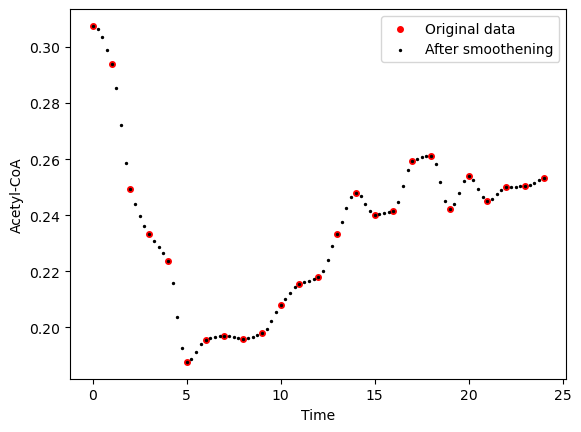

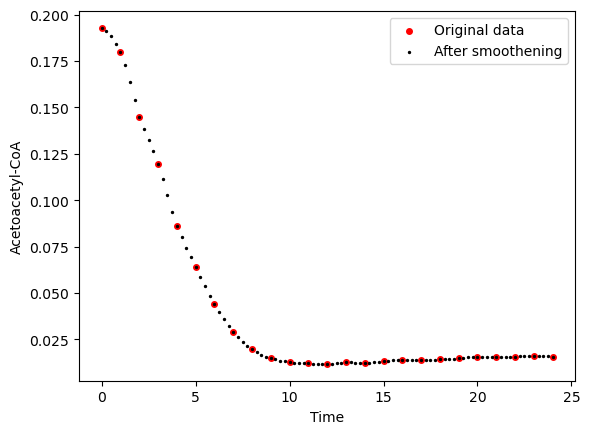

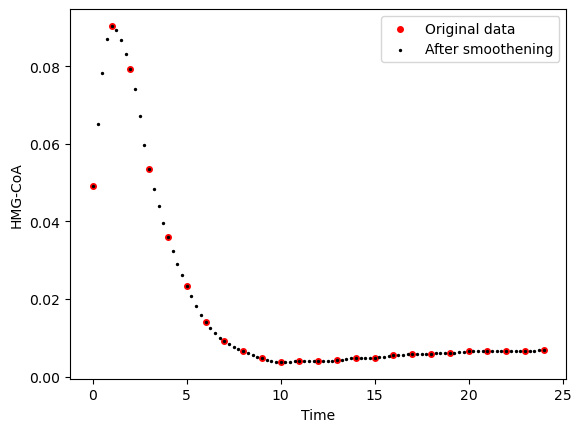

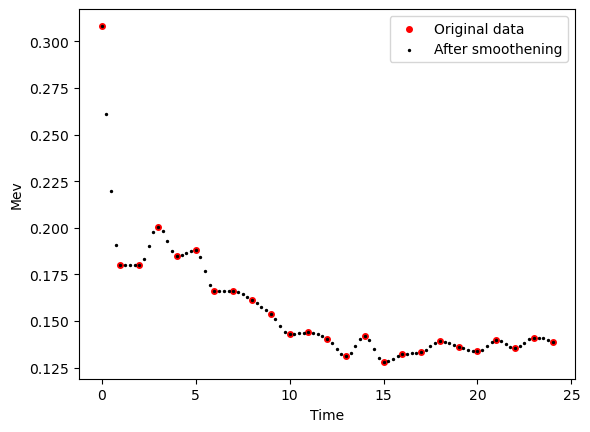

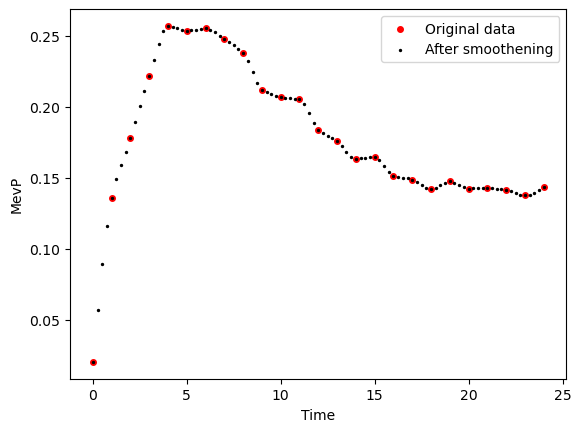

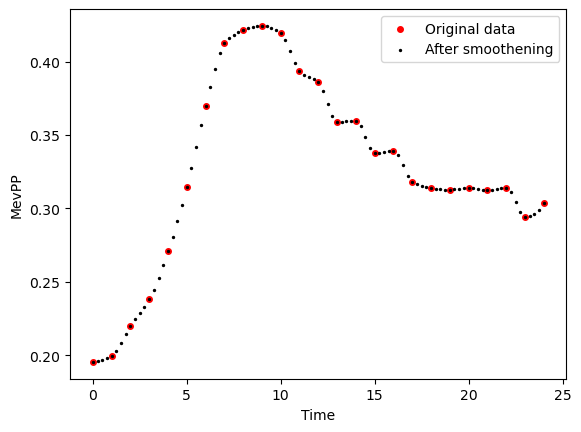

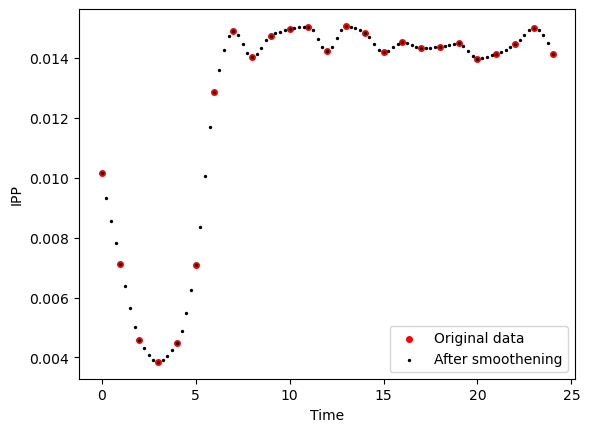

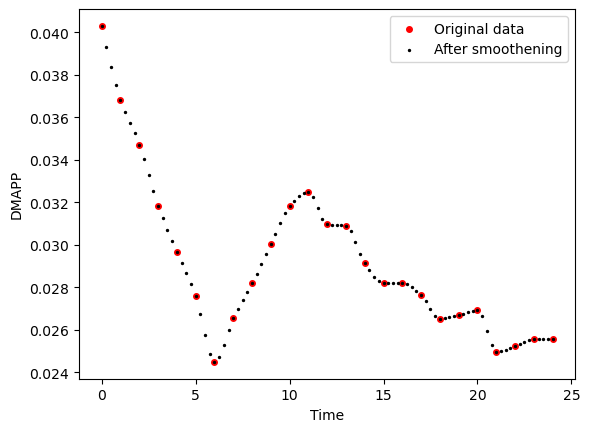

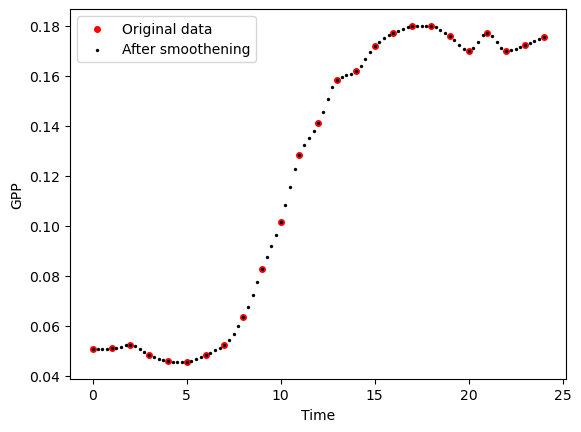

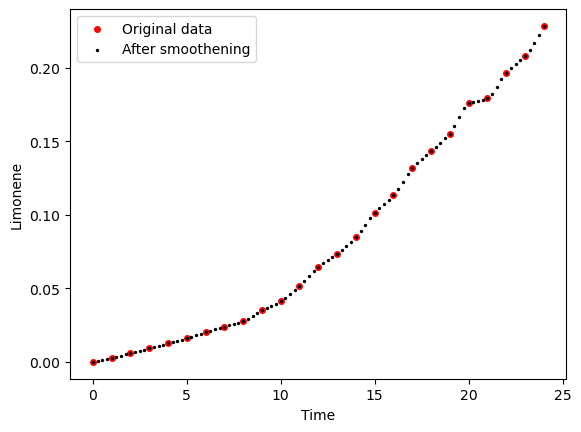

Strain Strain 2


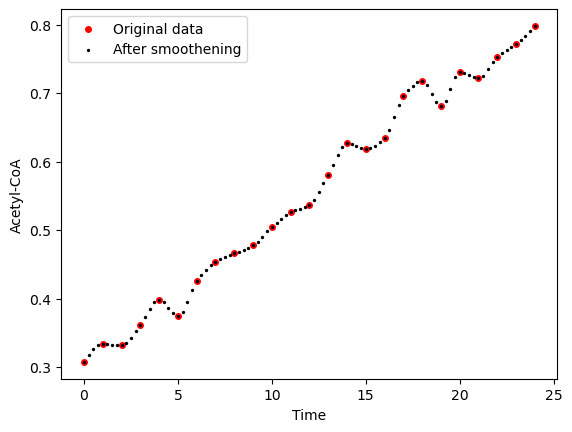

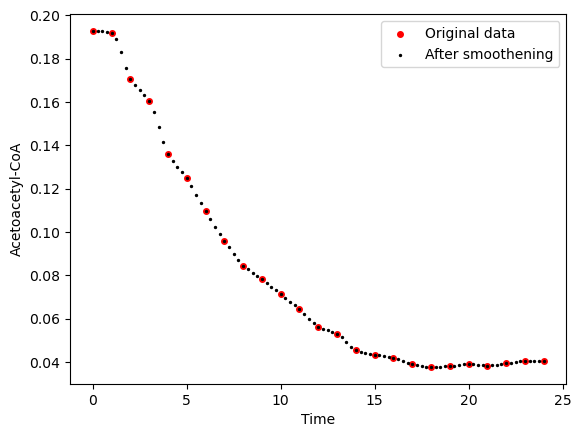

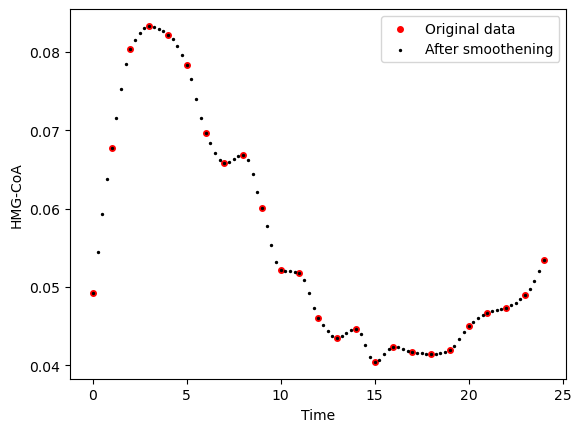

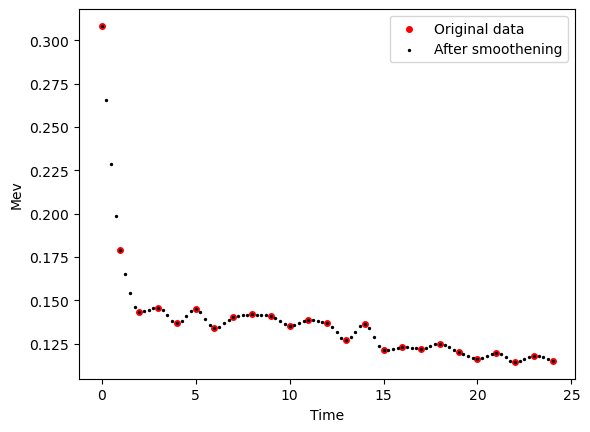

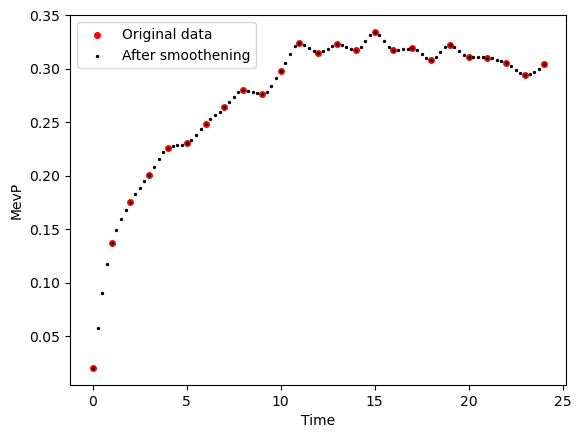

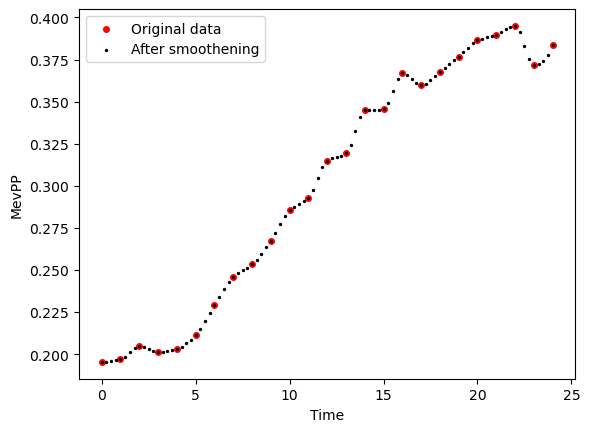

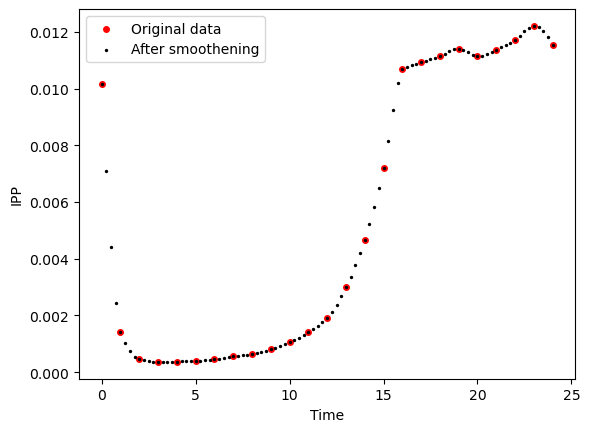

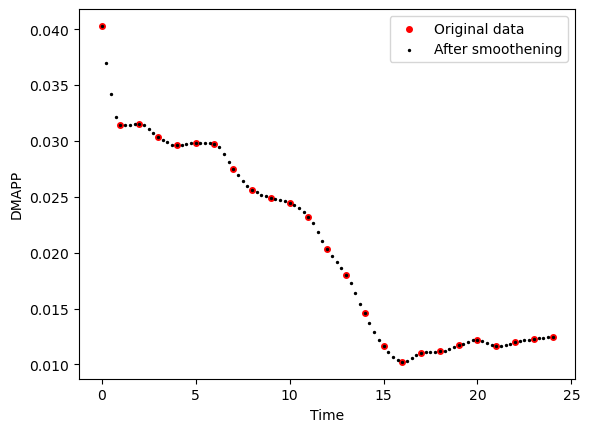

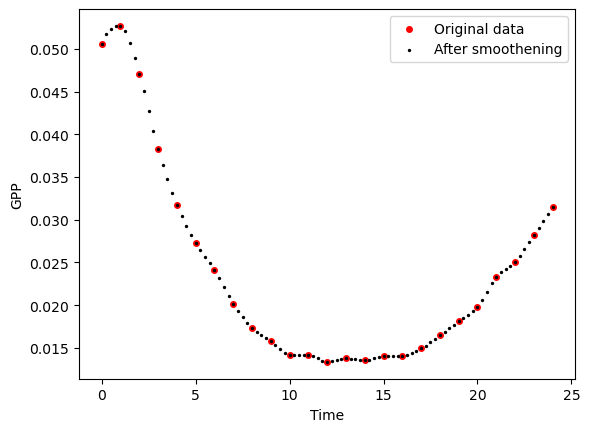

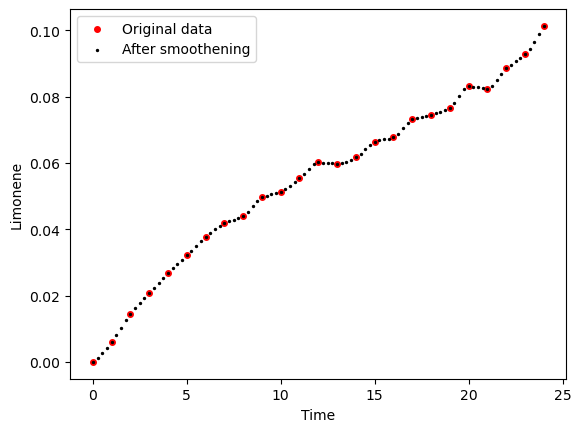

Strain Strain 3


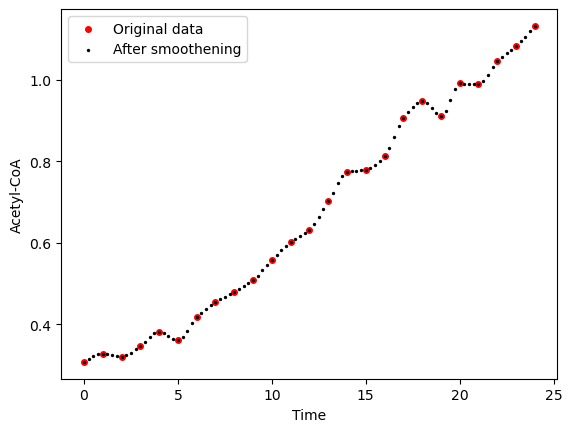

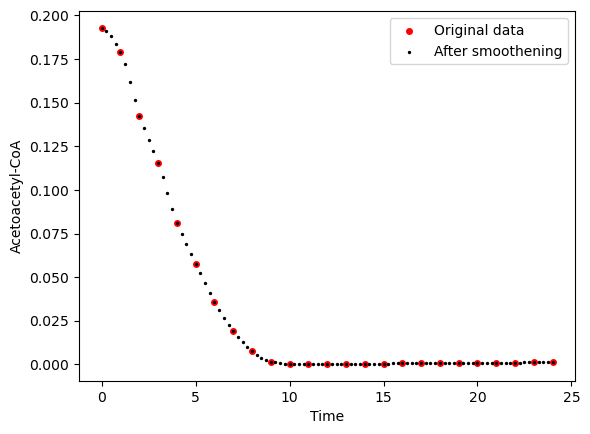

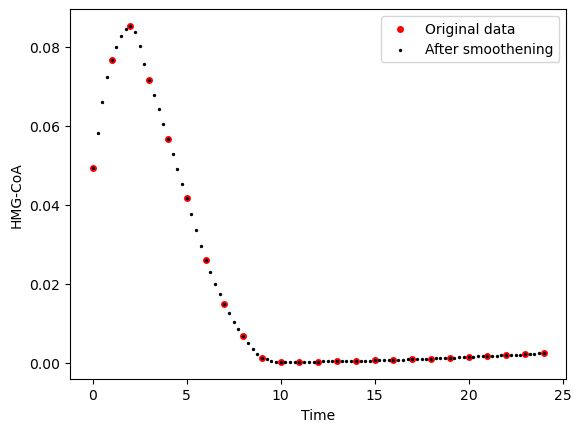

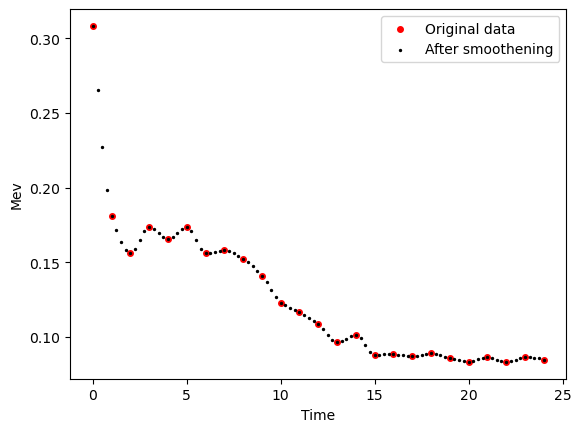

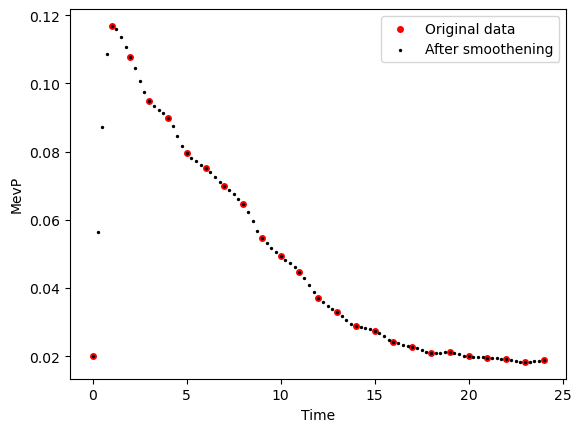

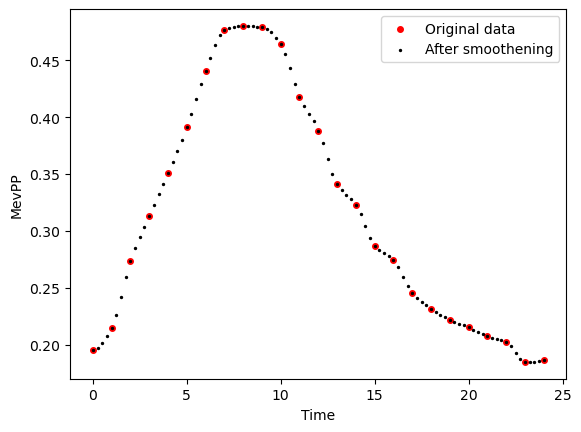

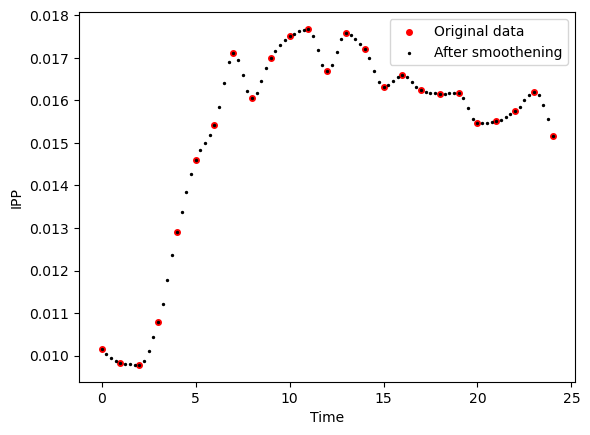

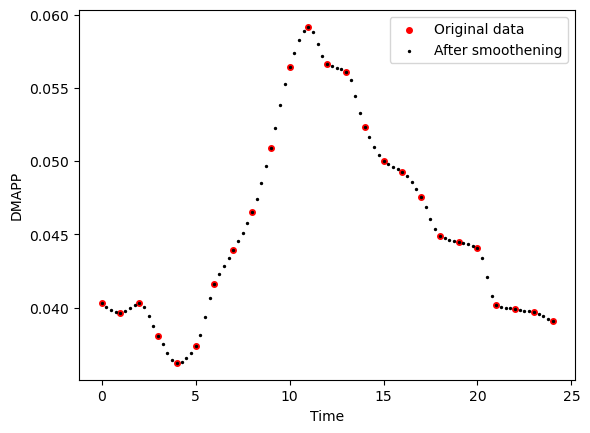

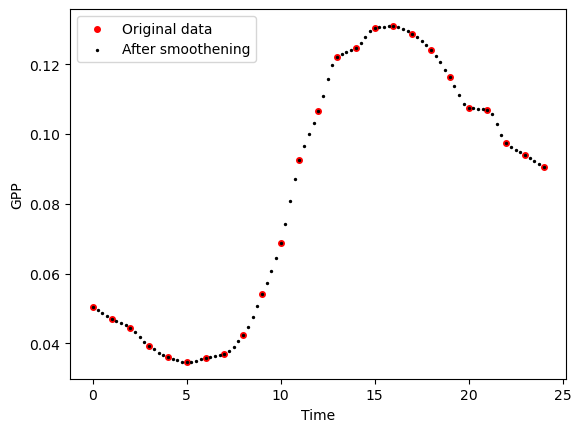

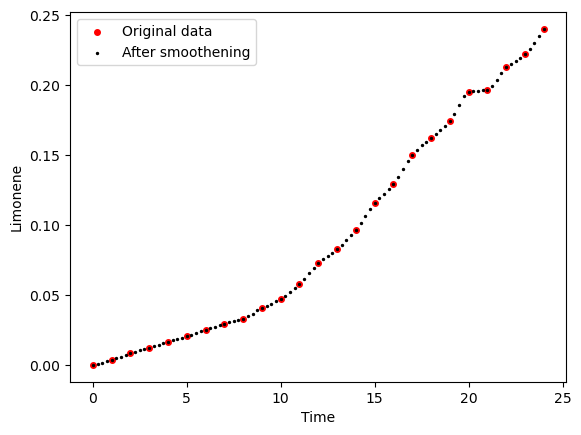

Strain WT


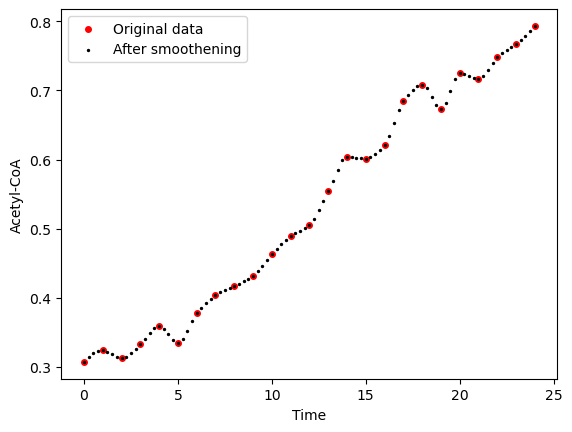

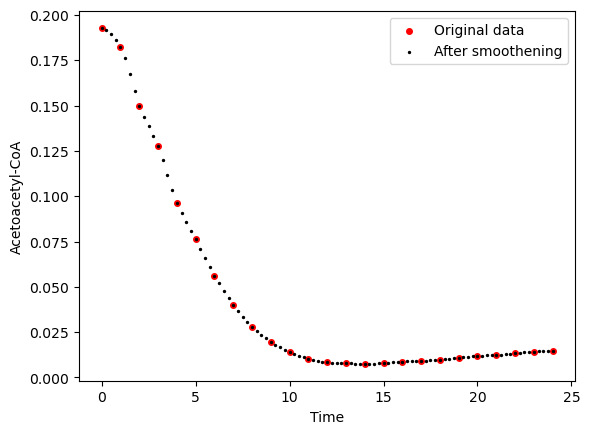

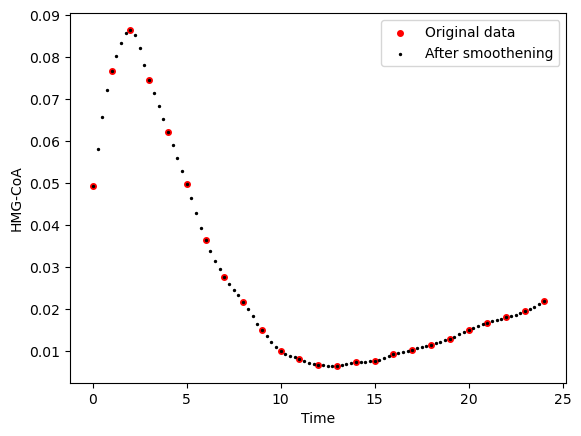

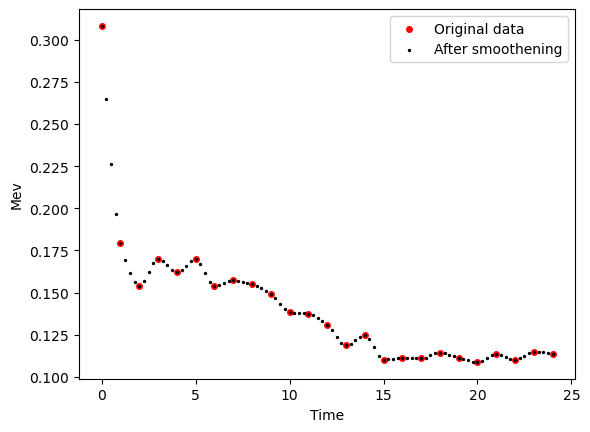

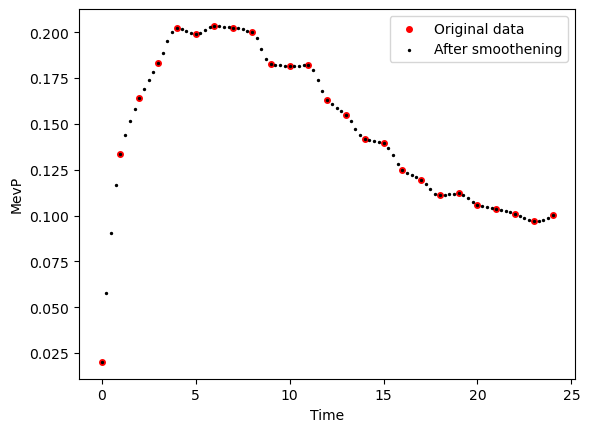

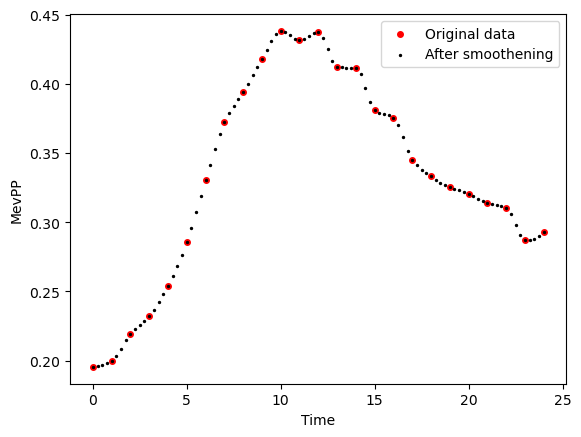

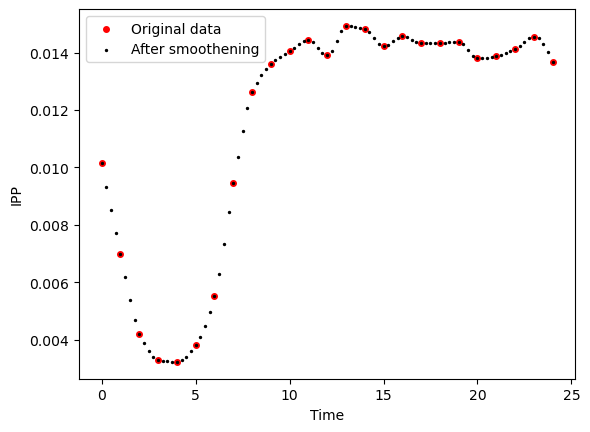

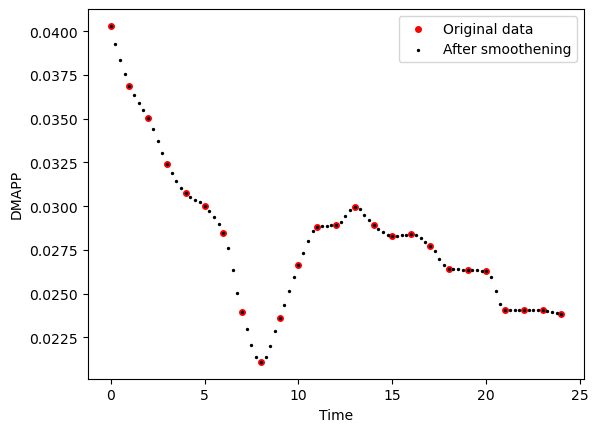

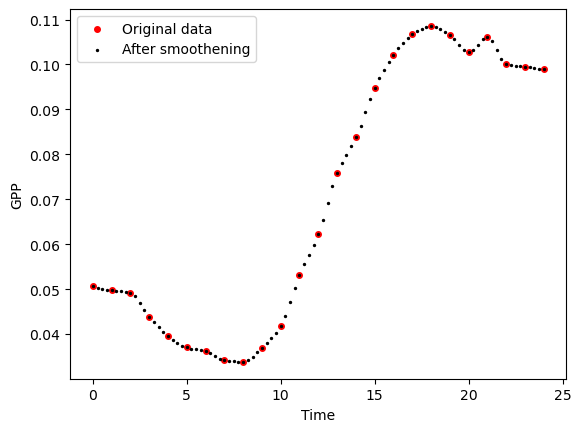

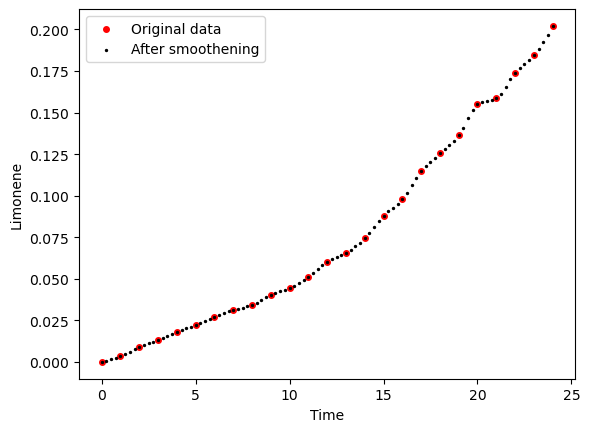

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


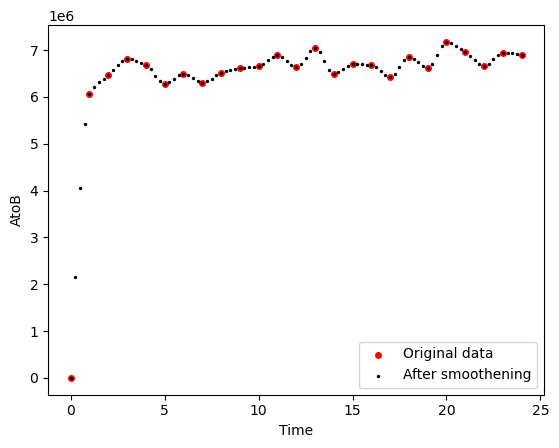

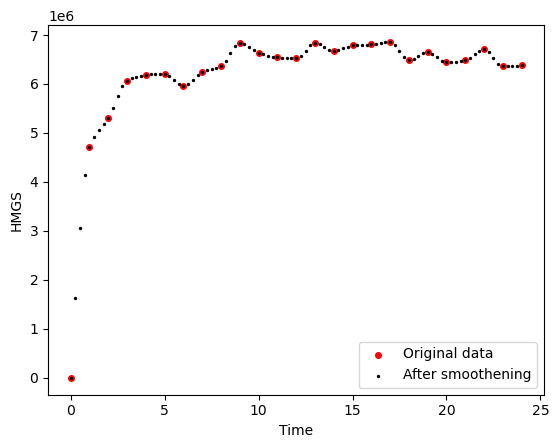

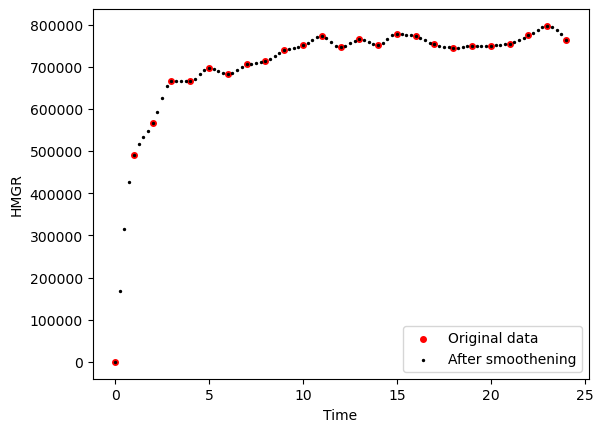

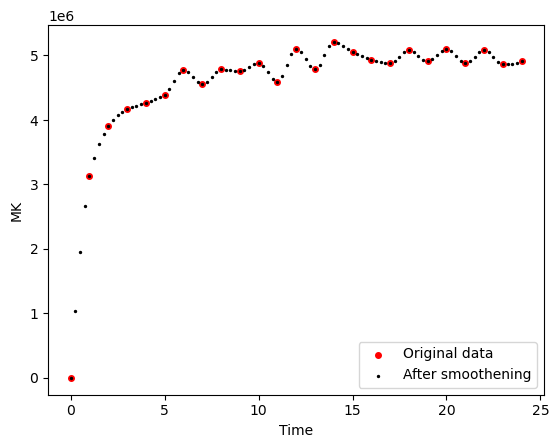

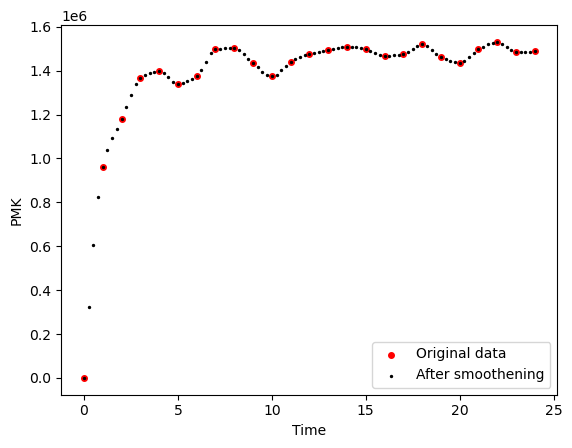

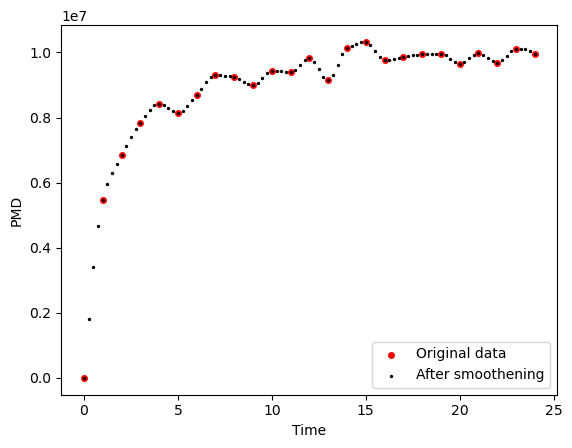

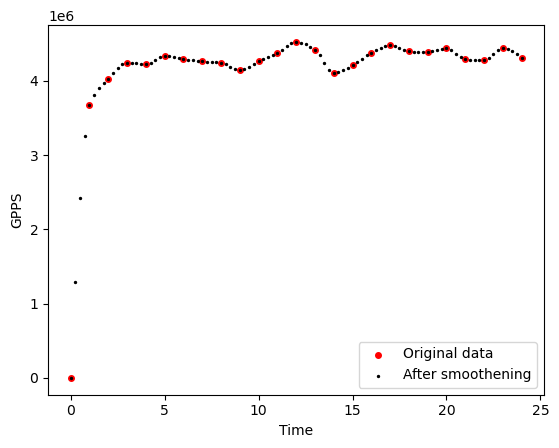

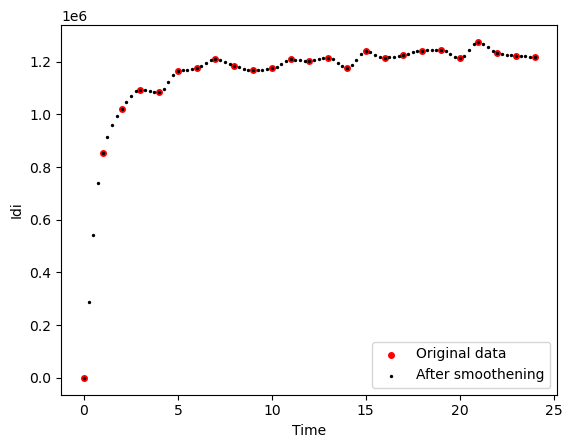

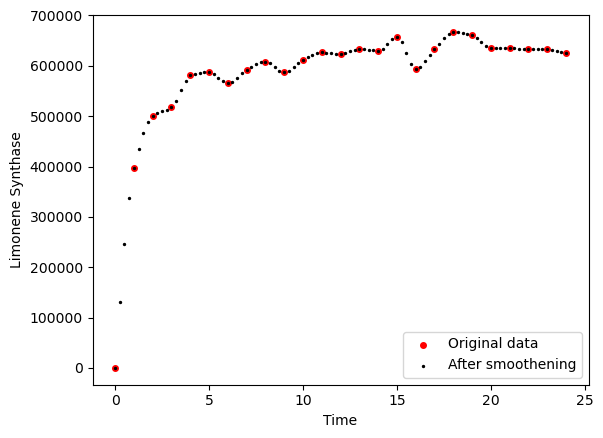

Strain Strain 2


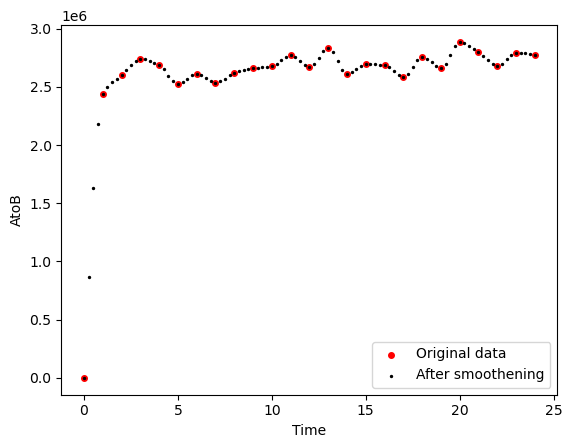

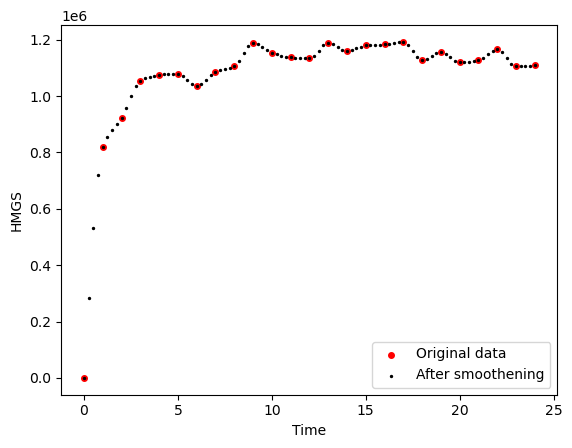

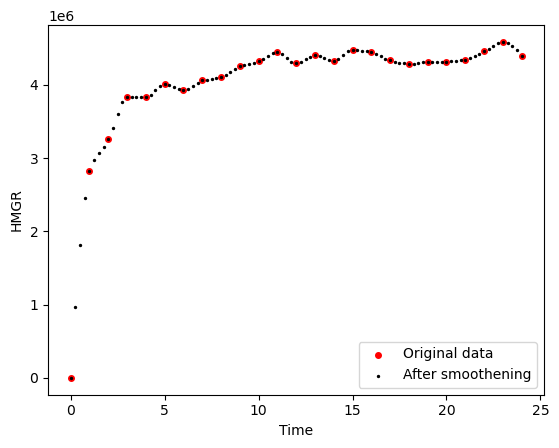

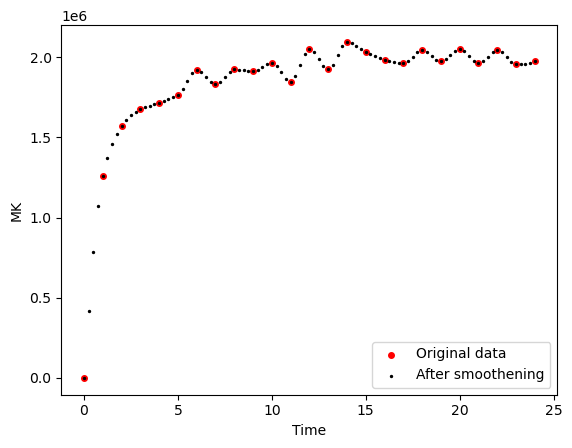

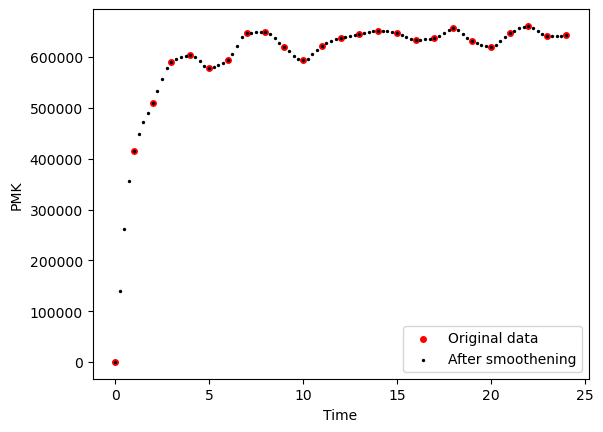

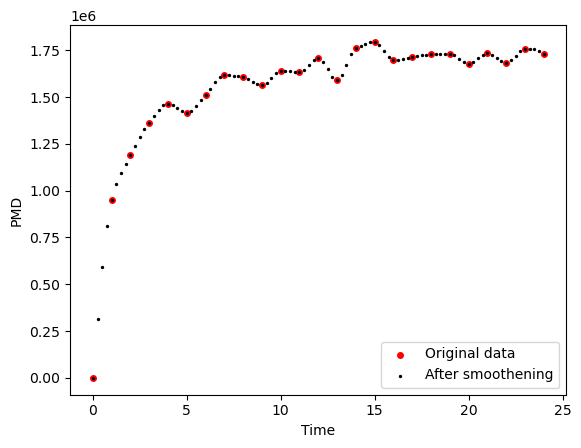

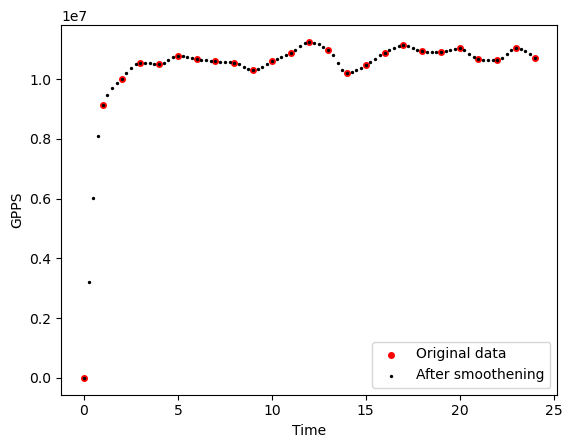

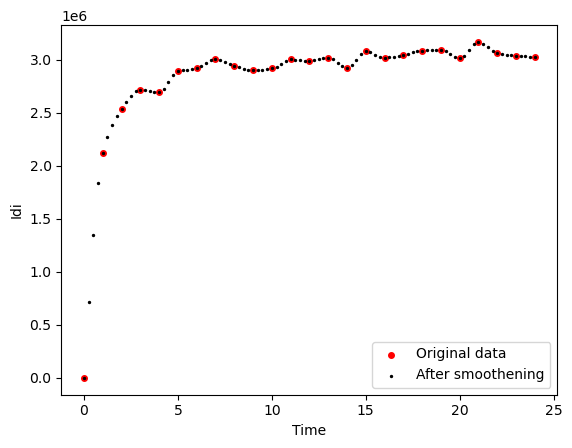

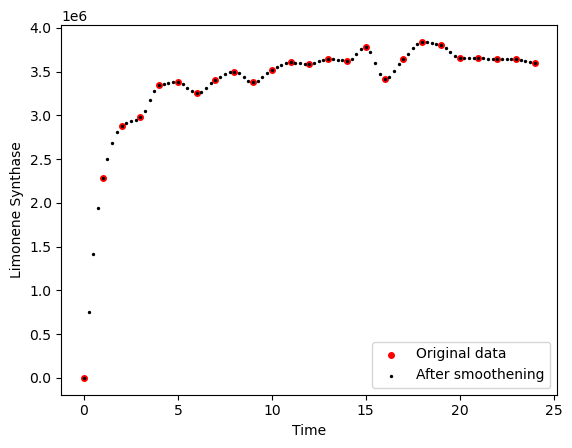

Strain Strain 3


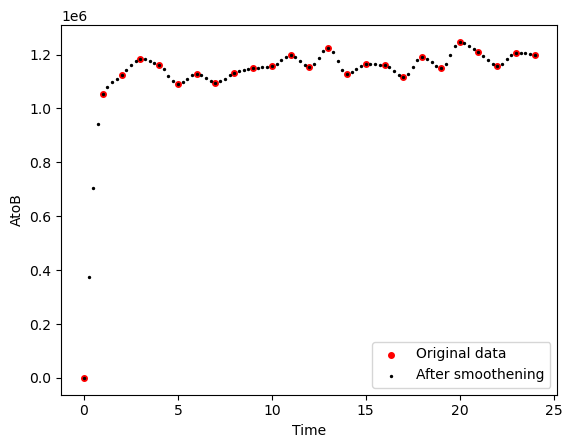

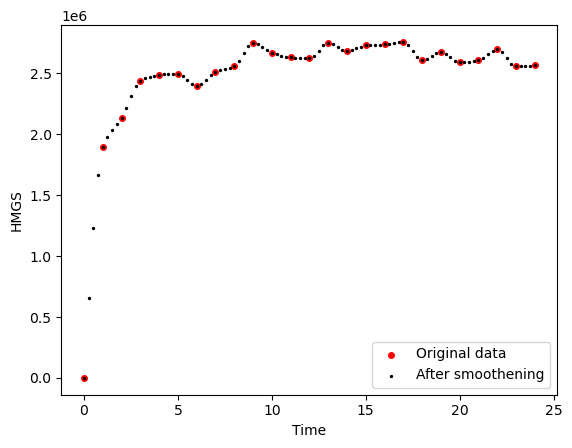

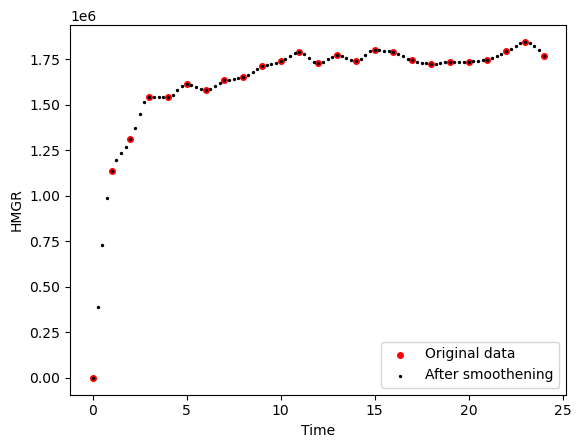

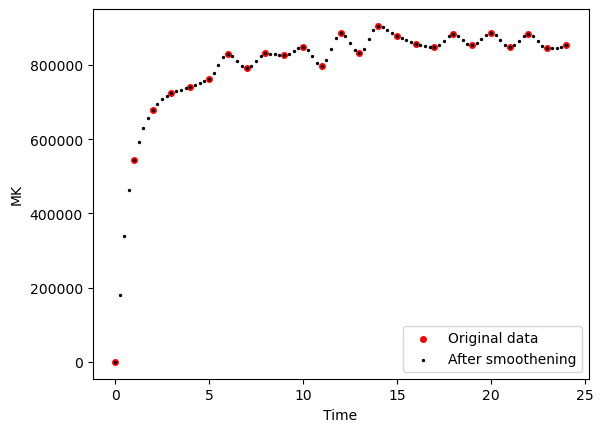

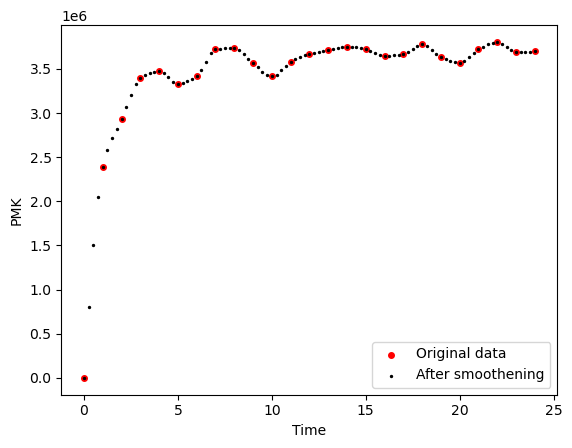

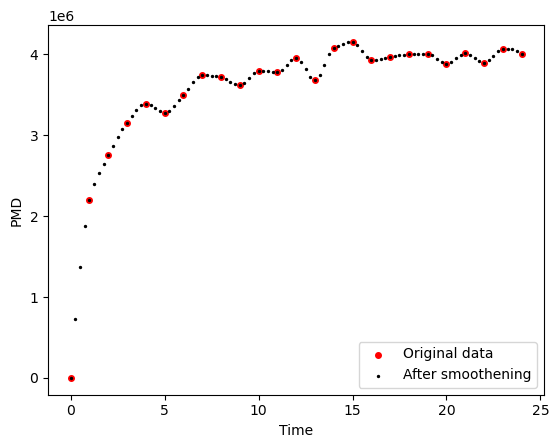

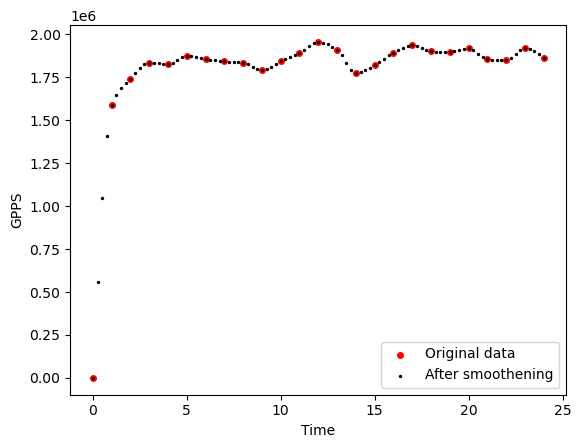

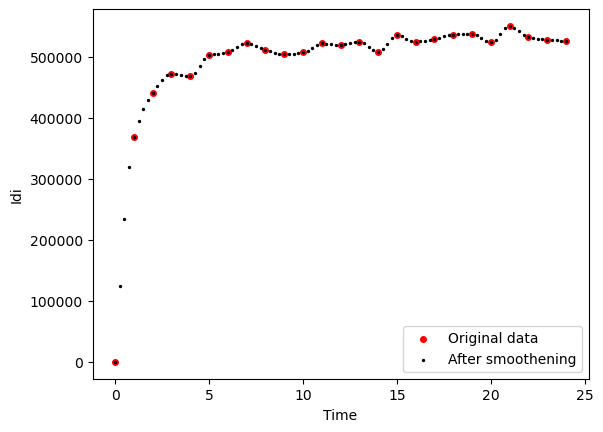

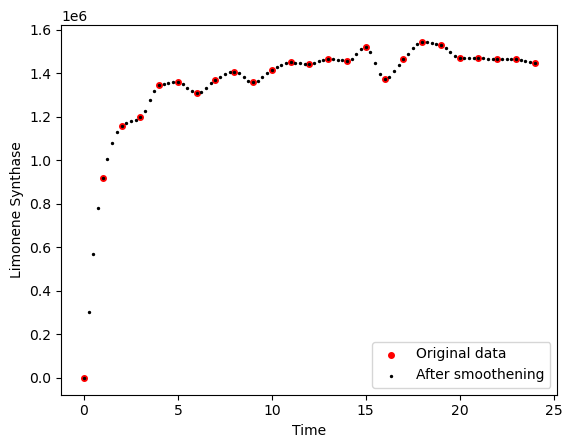

Strain WT


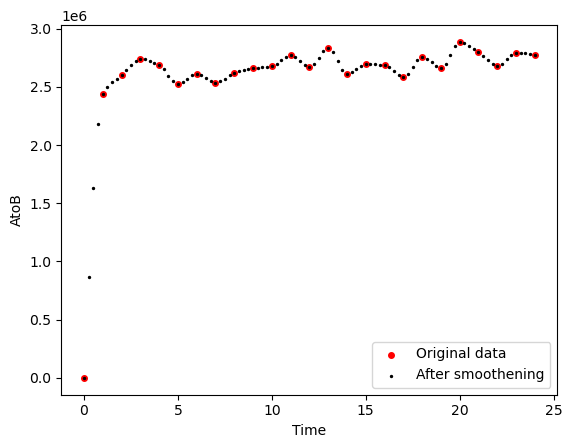

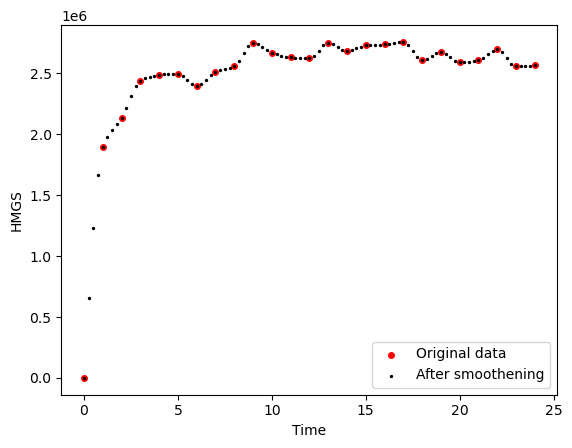

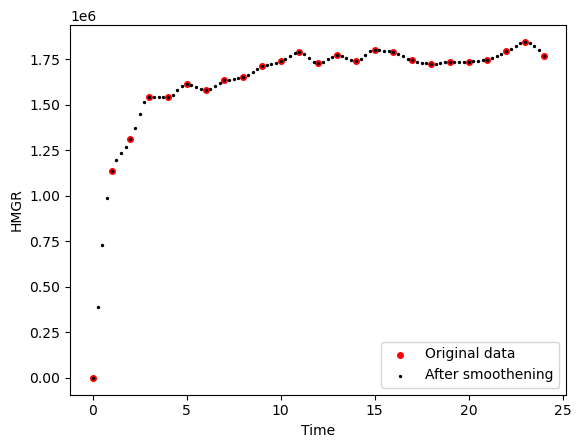

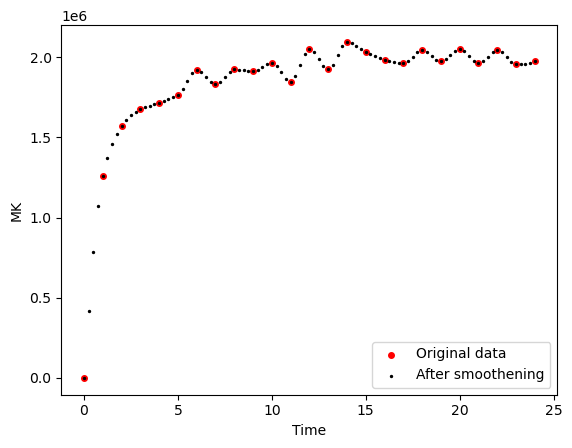

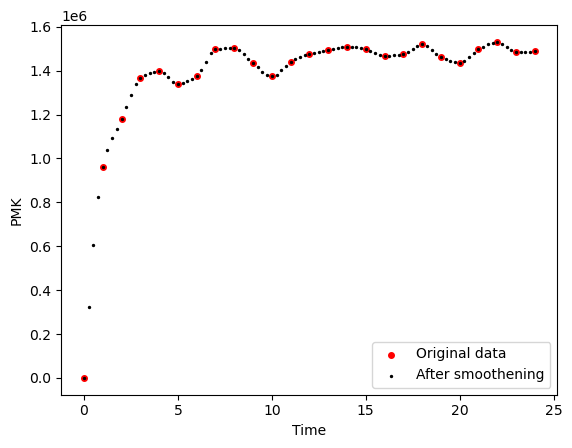

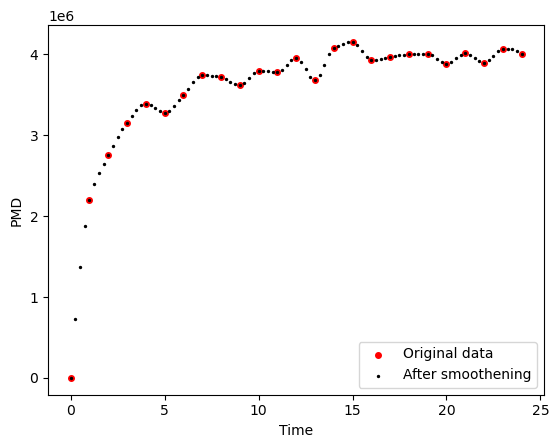

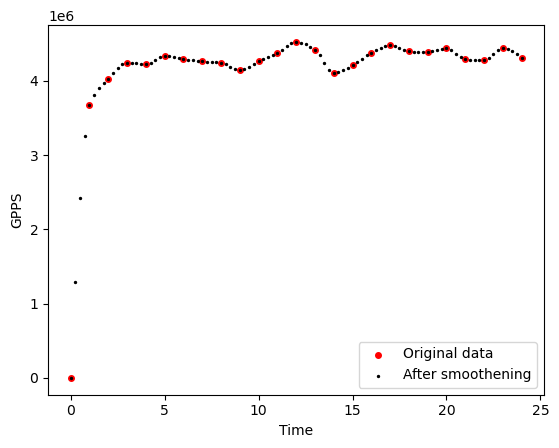

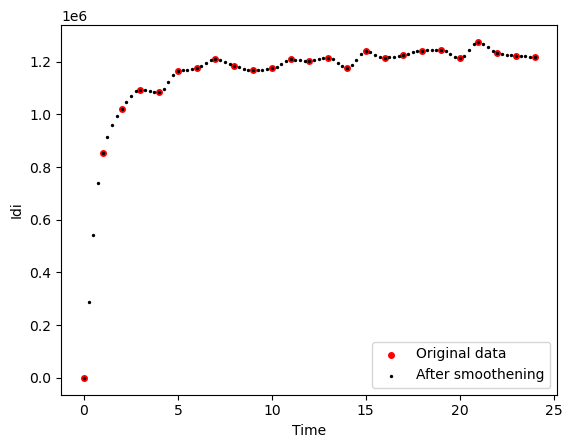

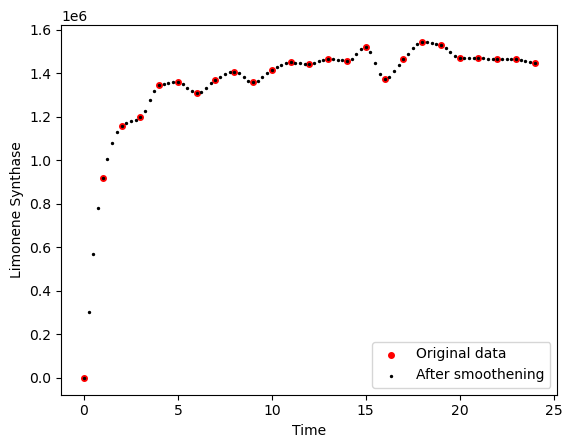

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307507        0.192847  0.049264  0.308261  0.020131   
         0.25    0.306380        0.191375  0.065154  0.261074  0.056567   
         0.50    0.303384        0.188399  0.078250  0.219935  0.088981   
         0.75    0.299099        0.184379  0.087141  0.190848  0.115805   
         1.00    0.294101        0.179772  0.090419  0.179818  0.135471   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.766917        0.014266  0.019396  0.115010  0.096844   
         23.25   0.772683        0.014396  0.019914  0.114986  0.097025   
         23.50   0.779017        0.014509  0.020521  0.114813  0.097600   
         23.75   0.785861        0.014596  0.021204  0.114346  0.098614   
         24.00   0.793155        0.014646  0.021948  0.113436  0.100114   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.195401  0.010149  0.040297  0.050591  0.000000  ...   
         0.25   0.195747  0.009337  0.039293  0.050623  0.000479  ...   
         0.50   0.196687  0.008558  0.038369  0.050709  0.001046  ...   
         0.75   0.198077  0.007813  0.037541  0.050833  0.001685  ...   
         1.00   0.199769  0.007104  0.036825  0.050980  0.002385  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.287211  0.014564  0.024051  0.099509  0.184427  ...   
         23.25  0.287302  0.014497  0.024028  0.099358  0.188026  ...   
         23.50  0.287945  0.014310  0.023974  0.099202  0.192238  ...   
         23.75  0.289689  0.014025  0.023899  0.099043  0.196971  ...   
         24.00  0.293085  0.013663  0.023812  0.098880  0.202135  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.003316       -0.004899  0.075352 -0.227262  0.160685   
         0.25    -0.008477       -0.009078  0.058536 -0.179054  0.138326   
         0.50    -0.013637       -0.013258  0.041719 -0.130845  0.115967   
         0.75    -0.020579       -0.018107  0.024278 -0.081034  0.092433   
         1.00    -0.030589       -0.024276  0.007769 -0.036427  0.069375   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.021259        0.000638  0.001930  0.002060 -0.000902   
         23.25    0.023909        0.000499  0.002244 -0.000008  0.001309   
         23.50    0.026261        0.000383  0.002558 -0.001515  0.003251   
         23.75    0.028299        0.000278  0.002859 -0.002696  0.005009   
         24.00    0.030337        0.000173  0.003160 -0.003877  0.006766   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.000837 -0.003321 -0.004246  0.000090  0.001803  
         0.25   0.002631 -0.003183 -0.003862  0.000242  0.002097  
         0.50   0.004426 -0.003045 -0.003479  0.000395  0.002390  
         0.75   0.007060 -0.002950 -0.003060  0.000640  0.002723  
         1.00   0.011313 -0.002906 -0.002618  0.001029  0.003116  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009507 -0.000063 -0.000074 -0.000540  0.013036  
         23.25 -0.000432 -0.000489 -0.000155 -0.000595  0.015455  
         23.50  0.005654 -0.000909 -0.000243 -0.000630  0.017744  
         23.75  0.010060 -0.001302 -0.000328 -0.000645  0.019830  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

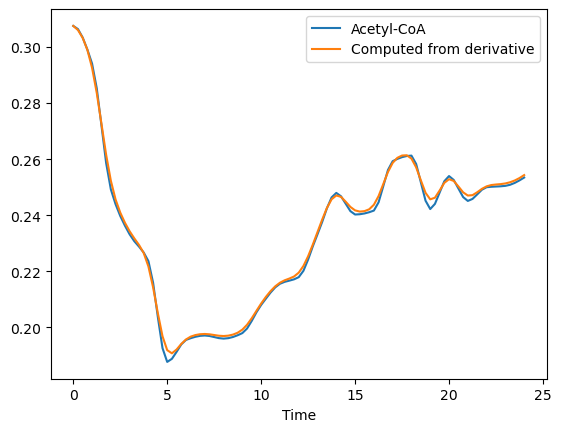

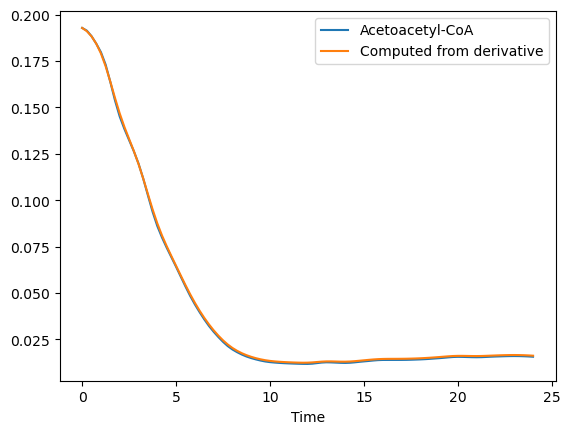

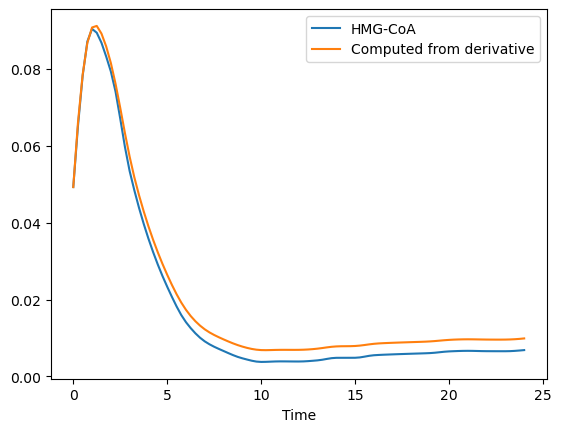

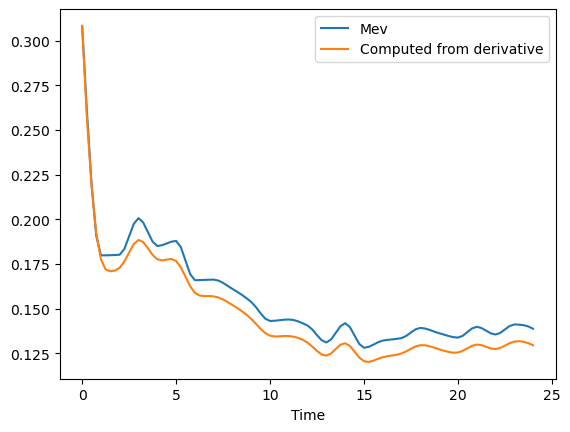

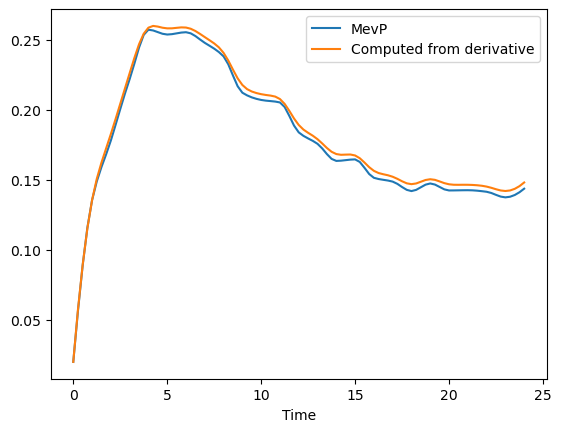

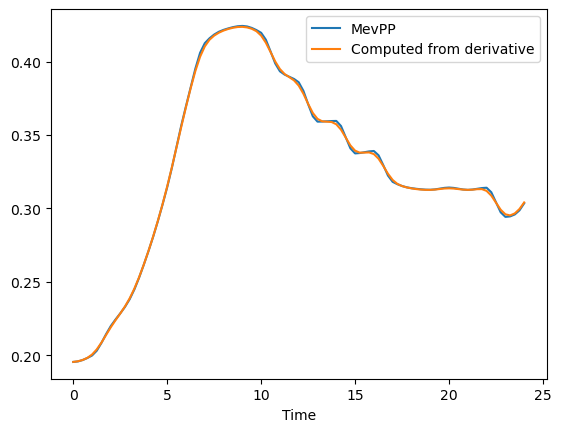

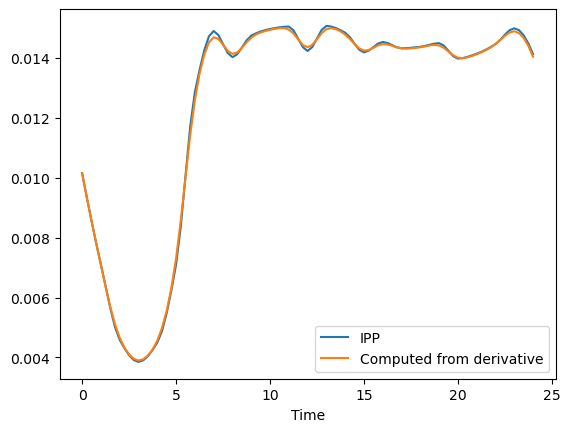

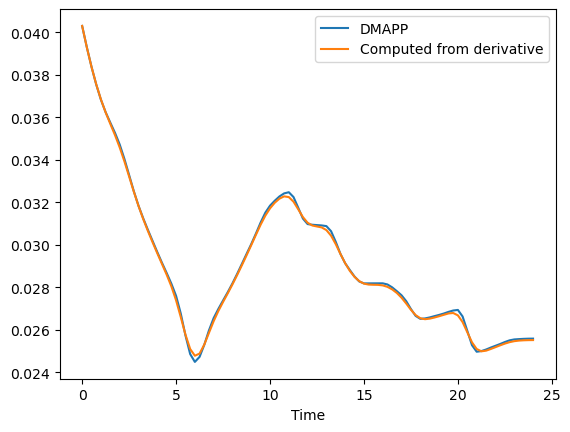

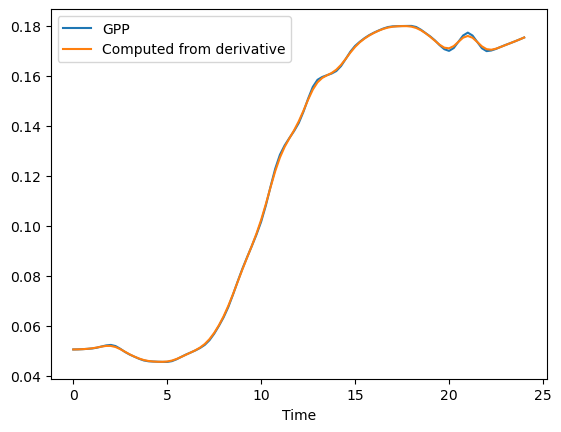

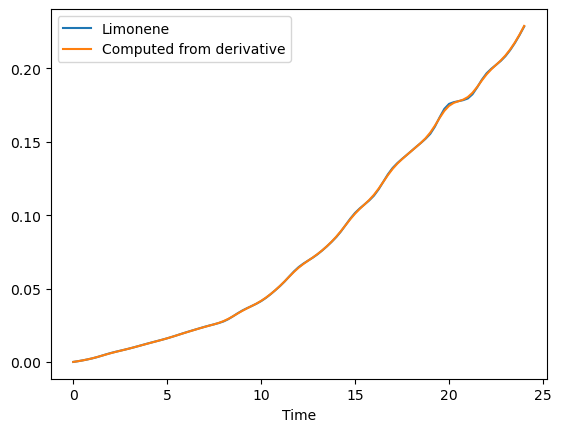

'Time profile from derivative vs. actual profile for Strain 2'

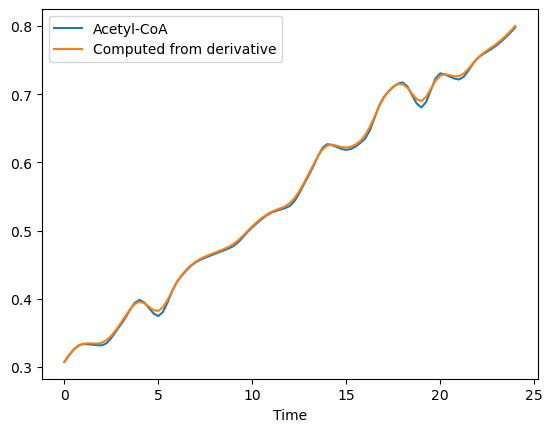

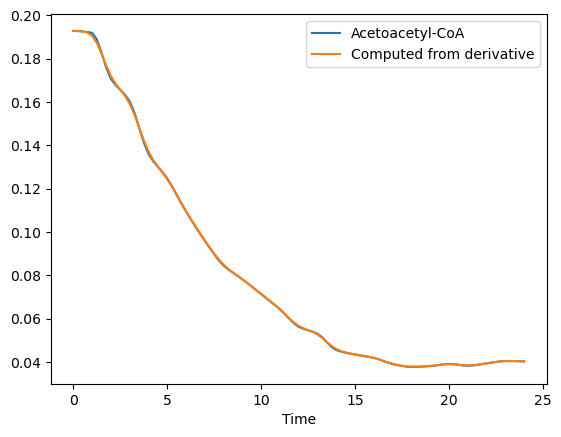

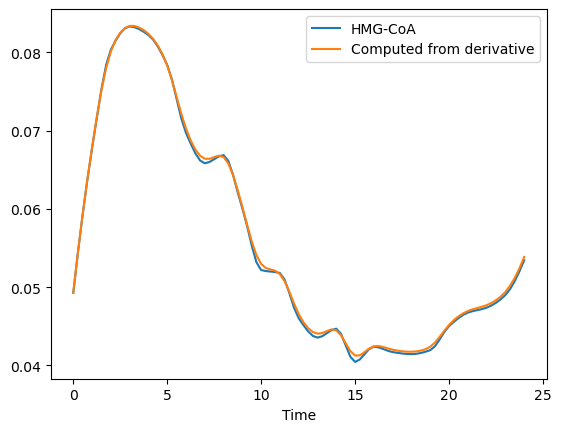

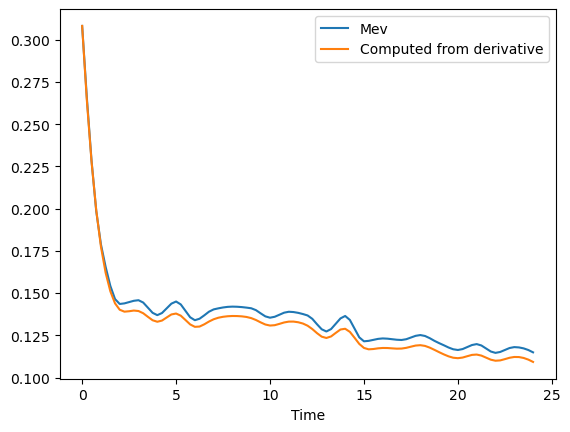

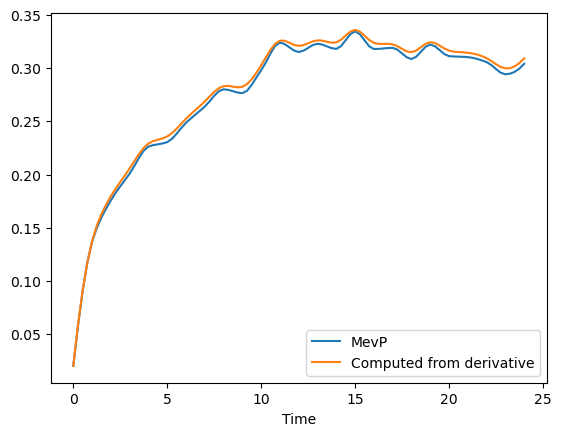

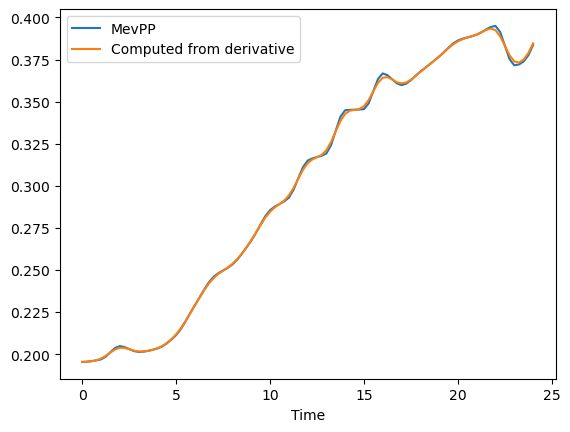

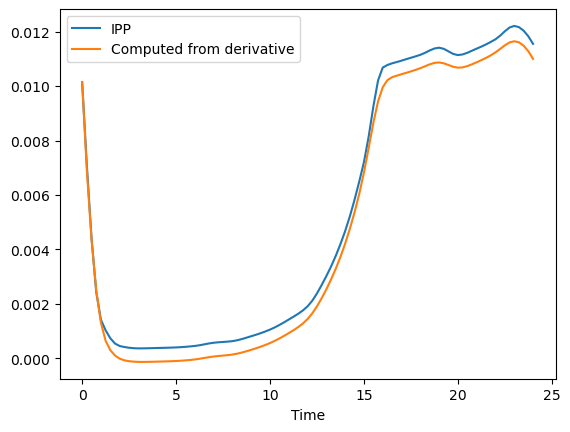

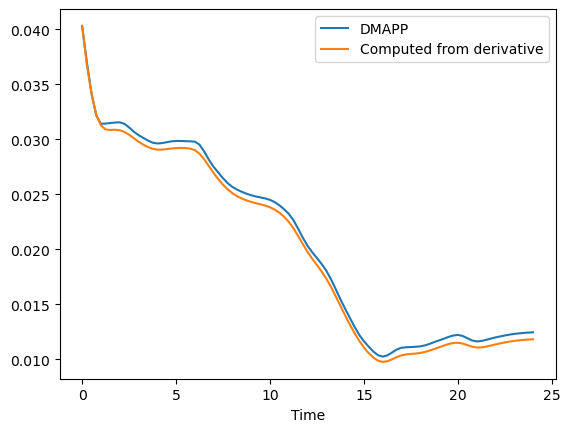

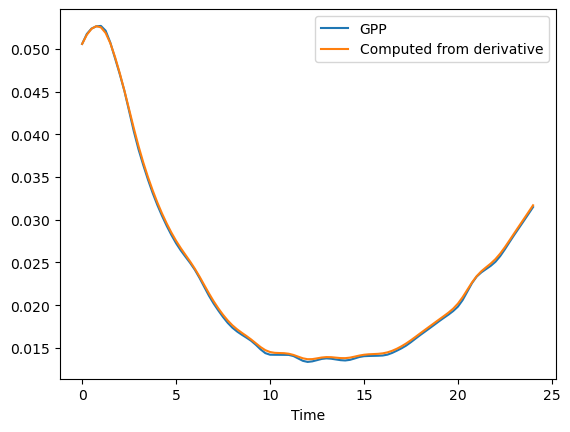

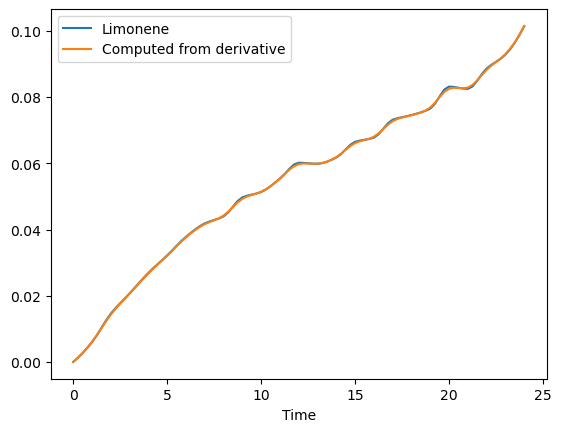

'Time profile from derivative vs. actual profile for Strain 3'

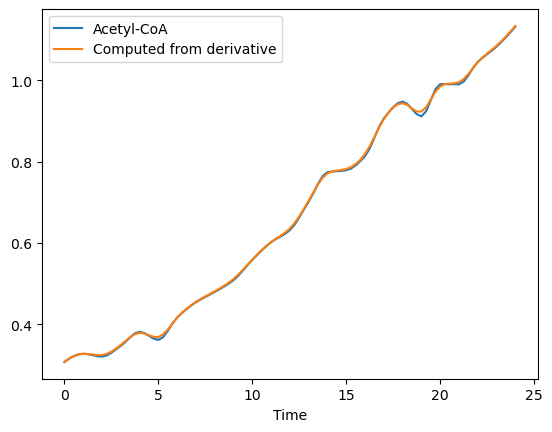

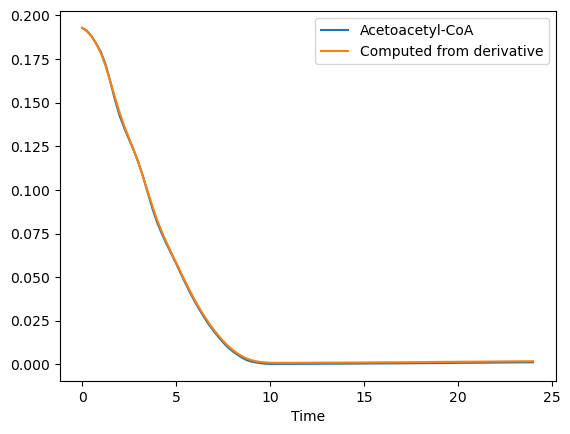

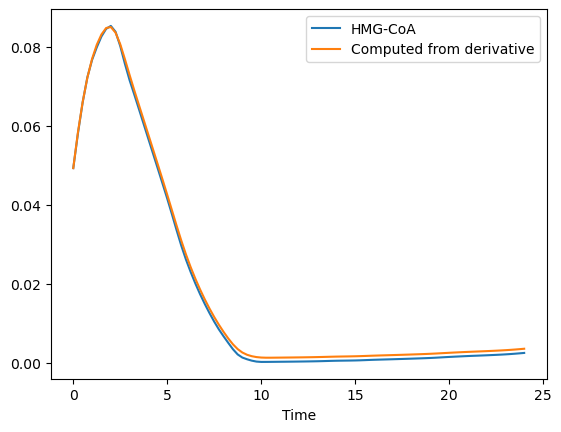

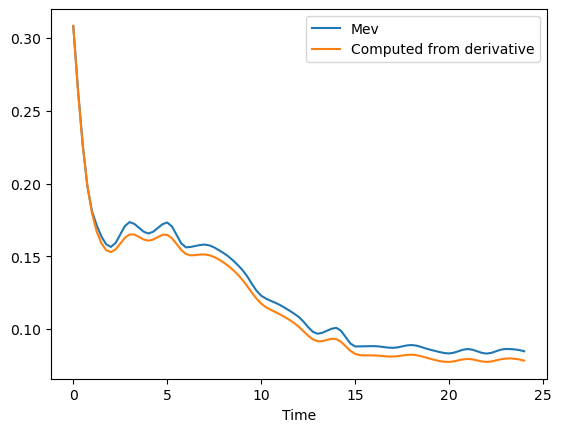

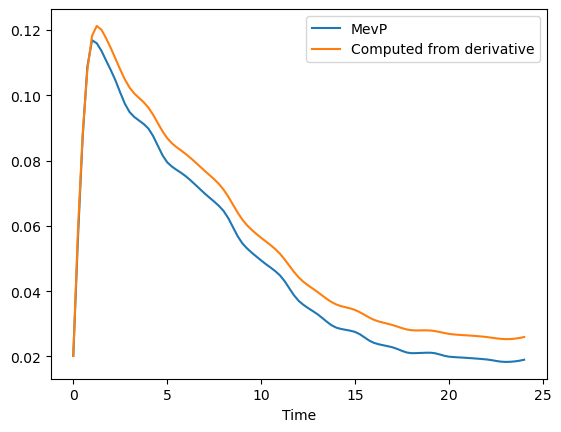

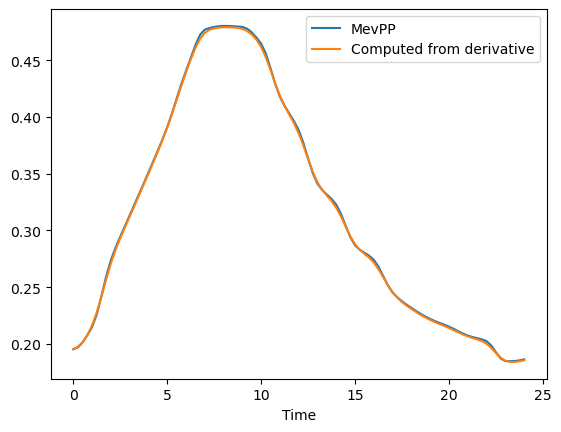

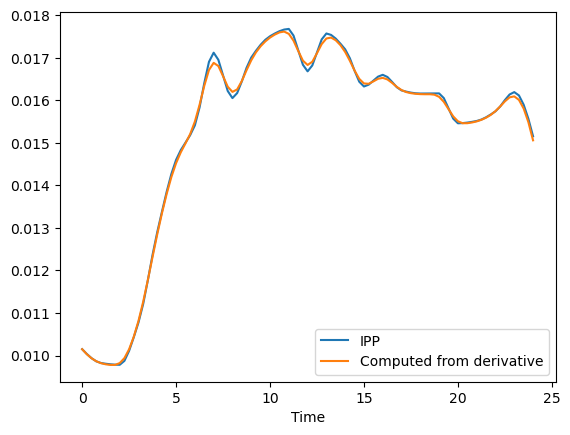

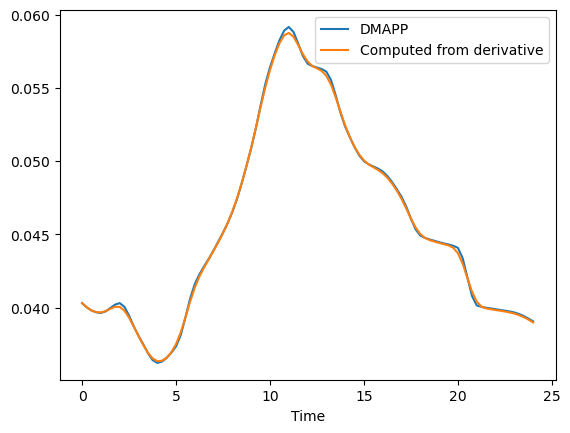

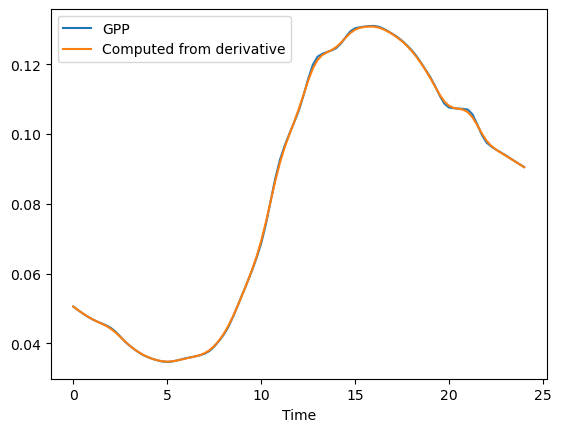

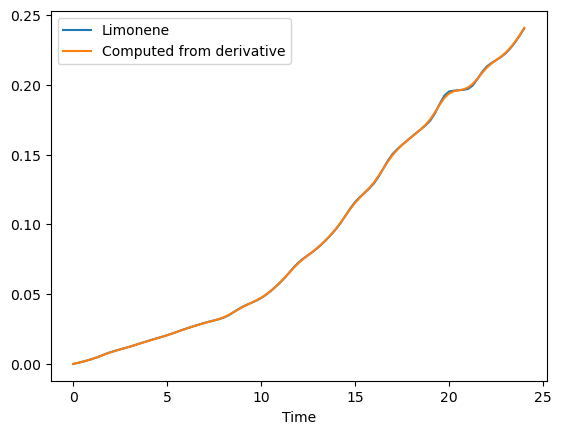

'Time profile from derivative vs. actual profile for WT'

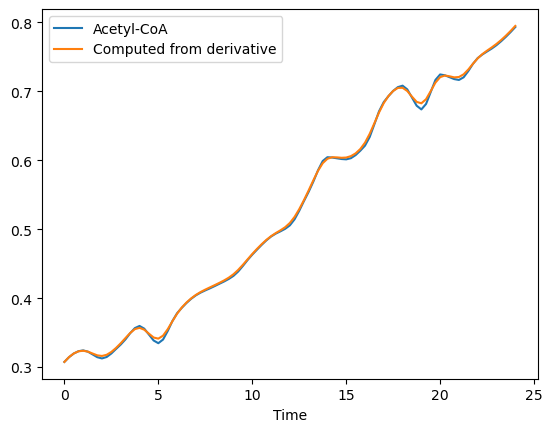

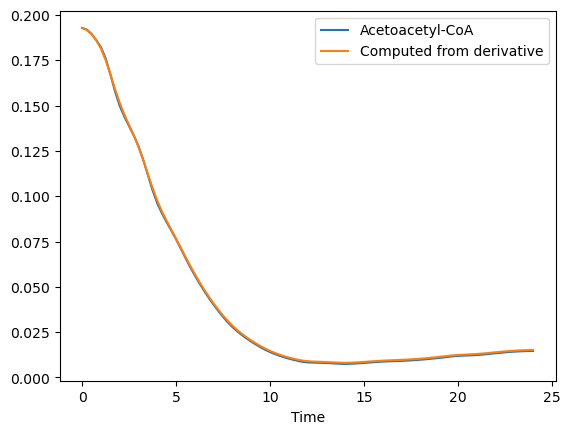

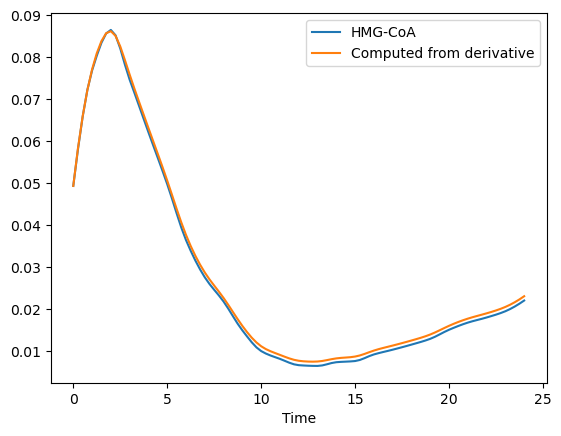

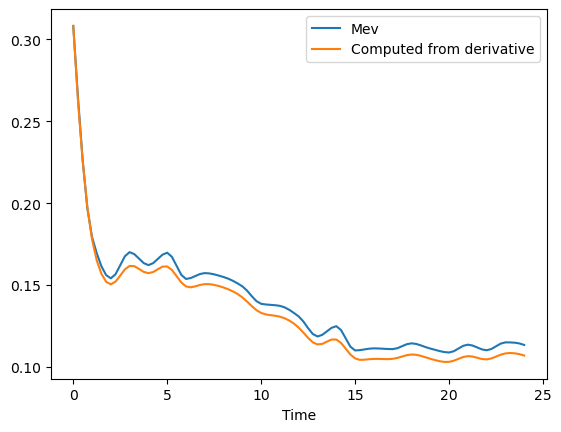

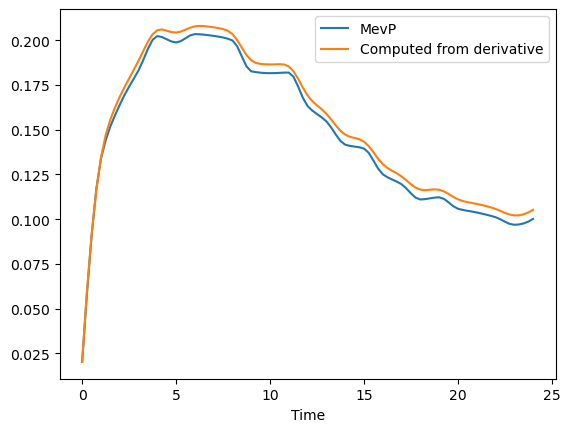

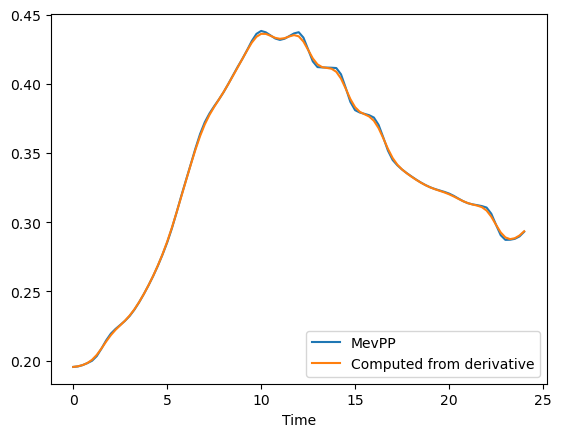

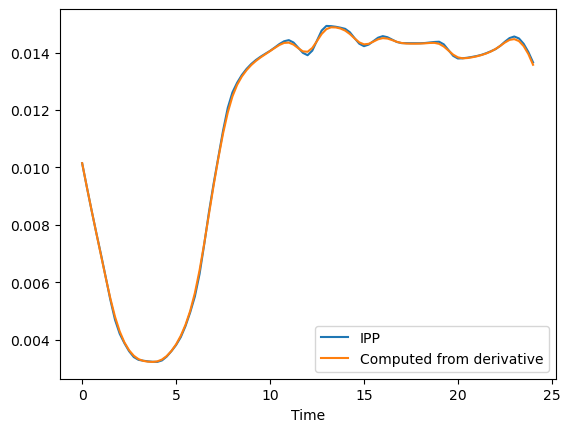

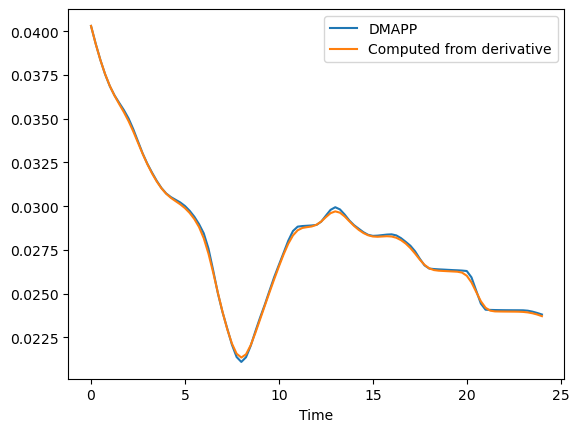

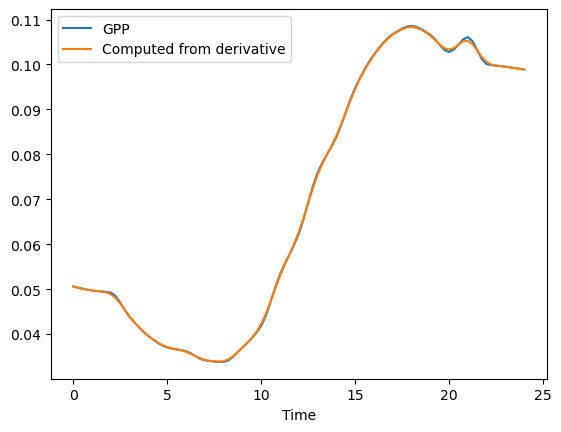

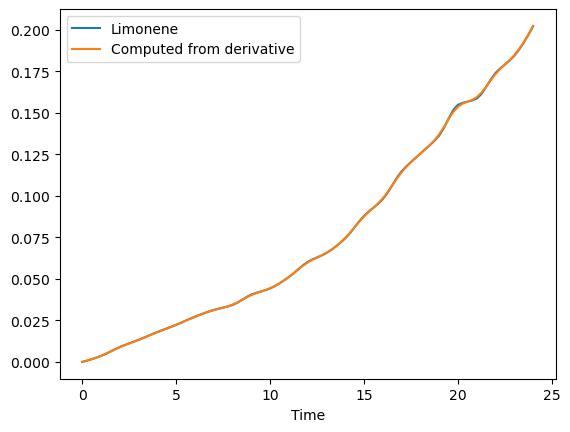

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.095775e+01  3.830916e+01  3.642460e+01  5.920951e+01   
         0.25   2.163927e+06  1.633941e+06  1.682643e+05  1.035021e+06   
         0.50   4.051265e+06  3.061227e+06  3.153739e+05  1.945321e+06   
         0.75   5.429229e+06  4.134013e+06  4.272001e+05  2.664895e+06   
         1.00   6.064973e+06  4.704415e+06  4.895777e+05  3.127680e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.791560e+06  2.558419e+06  1.844035e+06  1.958944e+06   
         23.25  2.791223e+06  2.558567e+06  1.838782e+06  1.959222e+06   
         23.50  2.788859e+06  2.559602e+06  1.823748e+06  1.961173e+06   
         23.75  2.782444e+06  2.562413e+06  1.800023e+06  1.966468e+06   
         24.00  2.769951e+06  2.567887e+06  1.768697e+06  1.976778e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.677443e+01  5.322851e+01  5.629791e+01  1.882676e+01   
         0.25   3.212978e+05  1.809103e+06  1.292103e+06  2.894430e+05   
         0.50   6.034085e+05  3.400654e+06  2.419680e+06  5.430175e+05   
         0.75   8.244120e+05  4.660389e+06  3.255201e+06  7.388073e+05   
         1.00   9.623617e+05  5.473993e+06  3.671077e+06  8.548772e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.484768e+06  4.071536e+06  4.436833e+06  1.222453e+06   
         23.25  1.484831e+06  4.069615e+06  4.429267e+06  1.220923e+06   
         23.50  1.485272e+06  4.060575e+06  4.405756e+06  1.219553e+06   
         23.75  1.486468e+06  4.039499e+06  4.365077e+06  1.218397e+06   
         24.00  1.488798e+06  4.001470e+06  4.306011e+06  1.217507e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.069984e+01   0.307507        0.192847  0.049264   
         0.25       1.309671e+05   0.306380        0.191375  0.065154   
         0.50       2.462316e+05   0.303384        0.188399  0.078250   
         0.75       3.377454e+05   0.299099        0.184379  0.087141   
         1.00       3.974297e+05   0.294101        0.179772  0.090419   
...                          ...        ...             ...       ...   
WT       23.00      1.464867e+06   0.766917        0.014266  0.019396   
         23.25      1.462868e+06   0.772683        0.014396  0.019914   
         23.50      1.458949e+06   0.779017        0.014509  0.020521   
         23.75      1.453688e+06   0.785861        0.014596  0.021204   
         24.00      1.447661e+06   0.793155        0.014646  0.021948   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.308261  0.020131  0.195401  0.010149  0.040297  0.050591   
         0.25   0.261074  0.056567  0.195747  0.009337  0.039293  0.050623   
         0.50   0.219935  0.088981  0.196687  0.008558  0.038369  0.050709   
         0.75   0.190848  0.115805  0.198077  0.007813  0.037541  0.050833   
         1.00   0.179818  0.135471  0.199769  0.007104  0.036825  0.050980   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.115010  0.096844  0.287211  0.014564  0.024051  0.099509   
         23.25  0.114986  0.097025  0.287302  0.014497  0.024028  0.099358   
         23.50  0.114813  0.097600  0.287945  0.014310  0.023974 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.003316       -0.004899  0.075352 -0.227262  0.160685   
         0.25    -0.008477       -0.009078  0.058536 -0.179054  0.138326   
         0.50    -0.013637       -0.013258  0.041719 -0.130845  0.115967   
         0.75    -0.020579       -0.018107  0.024278 -0.081034  0.092433   
         1.00    -0.030589       -0.024276  0.007769 -0.036427  0.069375   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.021259        0.000638  0.001930  0.002060 -0.000902   
         23.25    0.023909        0.000499  0.002244 -0.000008  0.001309   
         23.50    0.026261        0.000383  0.002558 -0.001515  0.003251   
         23.75    0.028299        0.000278  0.002859 -0.002696  0.005009   
         24.00    0.030337        0.000173  0.003160 -0.003877  0.006766   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.000837 -0.003321 -0.004246  0.000090  0.001803  
         0.25   0.002631 -0.003183 -0.003862  0.000242  0.002097  
         0.50   0.004426 -0.003045 -0.003479  0.000395  0.002390  
         0.75   0.007060 -0.002950 -0.003060  0.000640  0.002723  
         1.00   0.011313 -0.002906 -0.002618  0.001029  0.003116  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.009507 -0.000063 -0.000074 -0.000540  0.013036  
         23.25 -0.000432 -0.000489 -0.000155 -0.000595  0.015455  
         23.50  0.005654 -0.000909 -0.000243 -0.000630  0.017744  
         23.75  0.010060 -0.001302 -0.000328 -0.000645  0.019830  
         24.00  0.014465 -0.001695 -0.000414 -0.000660  0.021917  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 3.014897E+180 | 1.433910E+108
     2 |       74 | 2.648054E+117 | 2.894728E+106
     3 |      138 | 5.655727E+105 |  8.053360E+86
     4 |      202 |  9.734643E+95 |  1.270391E+78
     5 |      266 |  7.601379E+84 |  1.036731E+72
     6 |      330 |  1.770080E+74 |  1.357543E+61
     7 |      394 |  1.299755E+71 |  2.460140E+54
     8 |      458 |  5.357846E+62 |  8.325170E+43
     9 |      522 |  5.211963E+55 |  1.790690E+37
    10 |      586 |  3.270144E+45 |  3.814735E+36
    11 |      650 |  1.163257E+45 |  2.984496E+26
    12 |      714 |  7.423608E+36 |  2.984496E+26
    13 |      778 |  5.696504E+32 |  2.154033E+19
    14 |      842 |  7.472086E+27 |  2.154033E+19
    15 |      906 |  2.404560E+24 |  2.113083E+11
    16 |      970 |  4.193896E+22 |  2.113083E+11
    17 |     1034 |  5.964833E+21 |  2.113083E+11
    18 |     1098 |  6.549557E+20 |  2.113083E+11
    19 |     1162 |  3.952

   162 |    10314 |  2.437113E+01 |  2.352056E+01
   163 |    10378 |  2.435111E+01 |  2.352056E+01
   164 |    10442 |  2.426449E+01 |  2.349302E+01
   165 |    10506 |  2.413359E+01 |  2.349302E+01
   166 |    10570 |  2.438198E+01 |  2.349302E+01
   167 |    10634 |  2.447521E+01 |  2.349302E+01
   168 |    10698 |  2.455152E+01 |  2.349302E+01
   169 |    10762 |  2.452557E+01 |  2.349302E+01
   170 |    10826 |  2.472032E+01 |  2.349302E+01
   171 |    10890 |  2.429983E+01 |  2.331951E+01
   172 |    10954 |  2.459027E+01 |  2.331951E+01
   173 |    11018 |  2.457038E+01 |  2.331951E+01
   174 |    11082 |  2.441693E+01 |  2.331951E+01
   175 |    11146 |  2.433772E+01 |  2.331951E+01
   176 |    11210 |  2.459333E+01 |  2.331951E+01
   177 |    11274 |  2.446791E+01 |  2.331951E+01
   178 |    11338 |  2.456122E+01 |  2.331951E+01
   179 |    11402 |  2.425612E+01 |  2.331951E+01
   180 |    11466 |  2.419799E+01 |  2.271151E+01
   181 |    11530 |  2.396339E+01 |  2.221582E+01


   326 |    20810 |  2.036144E+01 |  1.905350E+01
   327 |    20874 |  2.029971E+01 |  1.905350E+01
   328 |    20938 |  2.015277E+01 |  1.905350E+01
   329 |    21002 |  2.007002E+01 |  1.905350E+01
   330 |    21066 |  2.019853E+01 |  1.905350E+01
   331 |    21130 |  1.994987E+01 |  1.905350E+01
   332 |    21194 |  1.993457E+01 |  1.905350E+01
   333 |    21258 |  1.987603E+01 |  1.905350E+01
   334 |    21322 |  1.998471E+01 |  1.905350E+01
   335 |    21386 |  1.977541E+01 |  1.905350E+01
   336 |    21450 |  1.966615E+01 |  1.905350E+01
   337 |    21514 |  1.965823E+01 |  1.905350E+01
   338 |    21578 |  1.966339E+01 |  1.905350E+01
   339 |    21642 |  1.967989E+01 |  1.905350E+01
   340 |    21706 |  1.941534E+01 |  1.905350E+01
   341 |    21770 |  1.901467E+01 |  1.848335E+01
   342 |    21834 |  1.918006E+01 |  1.848335E+01
   343 |    21898 |  1.868536E+01 |  1.841652E+01
   344 |    21962 |  1.871686E+01 |  1.832159E+01
   345 |    22026 |  1.858353E+01 |  1.824862E+01


   490 |    31306 |  1.410515E+01 |  1.407104E+01
   491 |    31370 |  1.410508E+01 |  1.407104E+01
   492 |    31434 |  1.411169E+01 |  1.401991E+01
   493 |    31498 |  1.408550E+01 |  1.397340E+01
   494 |    31562 |  1.407505E+01 |  1.397340E+01
   495 |    31626 |  1.407801E+01 |  1.393123E+01
   496 |    31690 |  1.408706E+01 |  1.393123E+01
   497 |    31754 |  1.405652E+01 |  1.393123E+01
   498 |    31818 |  1.404607E+01 |  1.391627E+01
   499 |    31882 |  1.405659E+01 |  1.391627E+01
   500 |    31946 |  1.400401E+01 |  1.391627E+01
   501 |    32010 |  1.393537E+01 |  1.372313E+01
   502 |    32074 |  1.399635E+01 |  1.372313E+01
   503 |    32138 |  1.397055E+01 |  1.372313E+01
   504 |    32202 |  1.392529E+01 |  1.372313E+01
   505 |    32266 |  1.384559E+01 |  1.352925E+01
   506 |    32330 |  1.384544E+01 |  1.352925E+01
   507 |    32394 |  1.383300E+01 |  1.352925E+01
   508 |    32458 |  1.376916E+01 |  1.352925E+01
   509 |    32522 |  1.375788E+01 |  1.352925E+01


   654 |    41802 |  1.324506E+01 |  1.324368E+01
   655 |    41866 |  1.324609E+01 |  1.324368E+01
   656 |    41930 |  1.324500E+01 |  1.324339E+01
   657 |    41994 |  1.324500E+01 |  1.324272E+01
   658 |    42058 |  1.324469E+01 |  1.324218E+01
   659 |    42122 |  1.324377E+01 |  1.324218E+01
   660 |    42186 |  1.324424E+01 |  1.324218E+01
   661 |    42250 |  1.324370E+01 |  1.323942E+01
   662 |    42314 |  1.324281E+01 |  1.323778E+01
   663 |    42378 |  1.324198E+01 |  1.323778E+01
   664 |    42442 |  1.323948E+01 |  1.323736E+01
   665 |    42506 |  1.323929E+01 |  1.323649E+01
   666 |    42570 |  1.323873E+01 |  1.323649E+01
   667 |    42634 |  1.323856E+01 |  1.323615E+01
   668 |    42698 |  1.323683E+01 |  1.323472E+01
   669 |    42762 |  1.323507E+01 |  1.323387E+01
   670 |    42826 |  1.323450E+01 |  1.323329E+01
   671 |    42890 |  1.323427E+01 |  1.323296E+01
   672 |    42954 |  1.323355E+01 |  1.323150E+01
   673 |    43018 |  1.323239E+01 |  1.323080E+01


   818 |    52298 |  1.291006E+01 |  1.290713E+01
   819 |    52362 |  1.290990E+01 |  1.290605E+01
   820 |    52426 |  1.290833E+01 |  1.290479E+01
   821 |    52490 |  1.290685E+01 |  1.290121E+01
   822 |    52554 |  1.290353E+01 |  1.289694E+01
   823 |    52618 |  1.290252E+01 |  1.289694E+01
   824 |    52682 |  1.290041E+01 |  1.289572E+01
   825 |    52746 |  1.289833E+01 |  1.289480E+01
   826 |    52810 |  1.289709E+01 |  1.289480E+01
   827 |    52874 |  1.289755E+01 |  1.289480E+01
   828 |    52938 |  1.289771E+01 |  1.289480E+01
   829 |    53002 |  1.289691E+01 |  1.289409E+01
   830 |    53066 |  1.289600E+01 |  1.289084E+01
   831 |    53130 |  1.289446E+01 |  1.288601E+01
   832 |    53194 |  1.289102E+01 |  1.288601E+01
   833 |    53258 |  1.289024E+01 |  1.288601E+01
   834 |    53322 |  1.289039E+01 |  1.288601E+01
   835 |    53386 |  1.289101E+01 |  1.288601E+01
   836 |    53450 |  1.288995E+01 |  1.288601E+01
   837 |    53514 |  1.288957E+01 |  1.288574E+01


   982 |    62794 |  1.165238E+01 |  1.162762E+01
   983 |    62858 |  1.163939E+01 |  1.160822E+01
   984 |    62922 |  1.163108E+01 |  1.160822E+01
   985 |    62986 |  1.162893E+01 |  1.160822E+01
   986 |    63050 |  1.162208E+01 |  1.158975E+01
   987 |    63114 |  1.160652E+01 |  1.158975E+01
   988 |    63178 |  1.160593E+01 |  1.158975E+01
   989 |    63242 |  1.160242E+01 |  1.158975E+01
   990 |    63306 |  1.159813E+01 |  1.158316E+01
   991 |    63370 |  1.159591E+01 |  1.158083E+01
   992 |    63434 |  1.156842E+01 |  1.154464E+01
   993 |    63498 |  1.156164E+01 |  1.154464E+01
   994 |    63562 |  1.156176E+01 |  1.154464E+01
   995 |    63626 |  1.155895E+01 |  1.154464E+01
   996 |    63690 |  1.155553E+01 |  1.154464E+01
   997 |    63754 |  1.154892E+01 |  1.154091E+01
   998 |    63818 |  1.154518E+01 |  1.153898E+01
   999 |    63882 |  1.154613E+01 |  1.153898E+01
  1000 |    63946 |  1.154384E+01 |  1.152523E+01
  1001 |    64010 |  1.153497E+01 |  1.152523E+01


  1146 |    73290 |  1.143300E+01 |  1.143281E+01
  1147 |    73354 |  1.143284E+01 |  1.143258E+01
  1148 |    73418 |  1.143269E+01 |  1.143240E+01
  1149 |    73482 |  1.143255E+01 |  1.143239E+01
  1150 |    73546 |  1.143244E+01 |  1.143221E+01
  1151 |    73610 |  1.143233E+01 |  1.143214E+01
  1152 |    73674 |  1.143222E+01 |  1.143210E+01
  1153 |    73738 |  1.143208E+01 |  1.143187E+01
  1154 |    73802 |  1.143196E+01 |  1.143171E+01
  1155 |    73866 |  1.143187E+01 |  1.143150E+01
  1156 |    73930 |  1.143174E+01 |  1.143132E+01
  1157 |    73994 |  1.143149E+01 |  1.143119E+01
  1158 |    74058 |  1.143148E+01 |  1.143119E+01
  1159 |    74122 |  1.143142E+01 |  1.143119E+01
  1160 |    74186 |  1.143125E+01 |  1.143092E+01
  1161 |    74250 |  1.143103E+01 |  1.143070E+01
  1162 |    74314 |  1.143101E+01 |  1.143070E+01
  1163 |    74378 |  1.143092E+01 |  1.143070E+01
  1164 |    74442 |  1.143084E+01 |  1.143059E+01
  1165 |    74506 |  1.143081E+01 |  1.143035E+01


  1310 |    83786 |  1.140544E+01 |  1.140522E+01
  1311 |    83850 |  1.140539E+01 |  1.140519E+01
  1312 |    83914 |  1.140519E+01 |  1.140505E+01
  1313 |    83978 |  1.140505E+01 |  1.140493E+01
  1314 |    84042 |  1.140490E+01 |  1.140470E+01
  1315 |    84106 |  1.140481E+01 |  1.140454E+01
  1316 |    84170 |  1.140467E+01 |  1.140433E+01
  1317 |    84234 |  1.140462E+01 |  1.140433E+01
  1318 |    84298 |  1.140445E+01 |  1.140428E+01
  1319 |    84362 |  1.140438E+01 |  1.140428E+01
  1320 |    84426 |  1.140423E+01 |  1.140395E+01
  1321 |    84490 |  1.140411E+01 |  1.140372E+01
  1322 |    84554 |  1.140390E+01 |  1.140345E+01
  1323 |    84618 |  1.140372E+01 |  1.140336E+01
  1324 |    84682 |  1.140342E+01 |  1.140316E+01
  1325 |    84746 |  1.140326E+01 |  1.140310E+01
  1326 |    84810 |  1.140310E+01 |  1.140267E+01
  1327 |    84874 |  1.140294E+01 |  1.140263E+01
  1328 |    84938 |  1.140285E+01 |  1.140263E+01
  1329 |    85002 |  1.140266E+01 |  1.140247E+01


  1474 |    94282 |  1.116367E+01 |  1.115868E+01
  1475 |    94346 |  1.116244E+01 |  1.115868E+01
  1476 |    94410 |  1.116193E+01 |  1.115796E+01
  1477 |    94474 |  1.116114E+01 |  1.115796E+01
  1478 |    94538 |  1.116009E+01 |  1.115723E+01
  1479 |    94602 |  1.116088E+01 |  1.115723E+01
  1480 |    94666 |  1.115780E+01 |  1.115484E+01
  1481 |    94730 |  1.115697E+01 |  1.115472E+01
  1482 |    94794 |  1.115594E+01 |  1.115416E+01
  1483 |    94858 |  1.115469E+01 |  1.115203E+01
  1484 |    94922 |  1.115434E+01 |  1.115203E+01
  1485 |    94986 |  1.115416E+01 |  1.115203E+01
  1486 |    95050 |  1.115404E+01 |  1.115203E+01
  1487 |    95114 |  1.115293E+01 |  1.115044E+01
  1488 |    95178 |  1.115230E+01 |  1.114987E+01
  1489 |    95242 |  1.115132E+01 |  1.114876E+01
  1490 |    95306 |  1.115069E+01 |  1.114859E+01
  1491 |    95370 |  1.115031E+01 |  1.114859E+01
  1492 |    95434 |  1.115023E+01 |  1.114859E+01
  1493 |    95498 |  1.114978E+01 |  1.114823E+01


  1638 |   104778 |  1.108948E+01 |  1.108833E+01
  1639 |   104842 |  1.108915E+01 |  1.108833E+01
  1640 |   104906 |  1.108882E+01 |  1.108832E+01
  1641 |   104970 |  1.108811E+01 |  1.108645E+01
  1642 |   105034 |  1.108743E+01 |  1.108523E+01
  1643 |   105098 |  1.108612E+01 |  1.108484E+01
  1644 |   105162 |  1.108563E+01 |  1.108469E+01
  1645 |   105226 |  1.108536E+01 |  1.108469E+01
  1646 |   105290 |  1.108484E+01 |  1.108338E+01
  1647 |   105354 |  1.108402E+01 |  1.108338E+01
  1648 |   105418 |  1.108429E+01 |  1.108338E+01
  1649 |   105482 |  1.108413E+01 |  1.108281E+01
  1650 |   105546 |  1.108417E+01 |  1.108281E+01
  1651 |   105610 |  1.108369E+01 |  1.108223E+01
  1652 |   105674 |  1.108344E+01 |  1.108223E+01
  1653 |   105738 |  1.108292E+01 |  1.108101E+01
  1654 |   105802 |  1.108281E+01 |  1.108101E+01
  1655 |   105866 |  1.108243E+01 |  1.108044E+01
  1656 |   105930 |  1.108176E+01 |  1.107969E+01
  1657 |   105994 |  1.108152E+01 |  1.107969E+01


  1802 |   115274 |  1.100780E+01 |  1.100713E+01
  1803 |   115338 |  1.100746E+01 |  1.100682E+01
  1804 |   115402 |  1.100729E+01 |  1.100611E+01
  1805 |   115466 |  1.100688E+01 |  1.100533E+01
  1806 |   115530 |  1.100597E+01 |  1.100509E+01
  1807 |   115594 |  1.100589E+01 |  1.100497E+01
  1808 |   115658 |  1.100525E+01 |  1.100403E+01
  1809 |   115722 |  1.100451E+01 |  1.100331E+01
  1810 |   115786 |  1.100348E+01 |  1.100270E+01
  1811 |   115850 |  1.100304E+01 |  1.100221E+01
  1812 |   115914 |  1.100268E+01 |  1.100181E+01
  1813 |   115978 |  1.100222E+01 |  1.100162E+01
  1814 |   116042 |  1.100243E+01 |  1.100118E+01
  1815 |   116106 |  1.100165E+01 |  1.100059E+01
  1816 |   116170 |  1.100166E+01 |  1.100051E+01
  1817 |   116234 |  1.100115E+01 |  1.100012E+01
  1818 |   116298 |  1.100124E+01 |  1.100012E+01
  1819 |   116362 |  1.100146E+01 |  1.100012E+01
  1820 |   116426 |  1.100082E+01 |  1.099945E+01
  1821 |   116490 |  1.099986E+01 |  1.099864E+01


  1966 |   125770 |  1.095317E+01 |  1.095292E+01
  1967 |   125834 |  1.095306E+01 |  1.095286E+01
  1968 |   125898 |  1.095293E+01 |  1.095273E+01
  1969 |   125962 |  1.095278E+01 |  1.095255E+01
  1970 |   126026 |  1.095264E+01 |  1.095254E+01
  1971 |   126090 |  1.095268E+01 |  1.095242E+01
  1972 |   126154 |  1.095256E+01 |  1.095218E+01
  1973 |   126218 |  1.095259E+01 |  1.095218E+01
  1974 |   126282 |  1.095250E+01 |  1.095218E+01
  1975 |   126346 |  1.095242E+01 |  1.095201E+01
  1976 |   126410 |  1.095248E+01 |  1.095201E+01
  1977 |   126474 |  1.095213E+01 |  1.095158E+01
  1978 |   126538 |  1.095196E+01 |  1.095158E+01
  1979 |   126602 |  1.095195E+01 |  1.095158E+01
  1980 |   126666 |  1.095185E+01 |  1.095158E+01
  1981 |   126730 |  1.095171E+01 |  1.095135E+01
  1982 |   126794 |  1.095158E+01 |  1.095135E+01
  1983 |   126858 |  1.095131E+01 |  1.095113E+01
  1984 |   126922 |  1.095112E+01 |  1.095081E+01
  1985 |   126986 |  1.095078E+01 |  1.095036E+01


  2130 |   136266 |  1.092248E+01 |  1.092212E+01
  2131 |   136330 |  1.092214E+01 |  1.092125E+01
  2132 |   136394 |  1.092151E+01 |  1.092114E+01
  2133 |   136458 |  1.092110E+01 |  1.092096E+01
  2134 |   136522 |  1.092109E+01 |  1.092078E+01
  2135 |   136586 |  1.092067E+01 |  1.092040E+01
  2136 |   136650 |  1.092053E+01 |  1.092033E+01
  2137 |   136714 |  1.092045E+01 |  1.092018E+01
  2138 |   136778 |  1.092013E+01 |  1.091973E+01
  2139 |   136842 |  1.091985E+01 |  1.091961E+01
  2140 |   136906 |  1.091979E+01 |  1.091951E+01
  2141 |   136970 |  1.091956E+01 |  1.091937E+01
  2142 |   137034 |  1.091952E+01 |  1.091915E+01
  2143 |   137098 |  1.091942E+01 |  1.091904E+01
  2144 |   137162 |  1.091924E+01 |  1.091855E+01
  2145 |   137226 |  1.091891E+01 |  1.091855E+01
  2146 |   137290 |  1.091879E+01 |  1.091842E+01
  2147 |   137354 |  1.091872E+01 |  1.091828E+01
  2148 |   137418 |  1.091825E+01 |  1.091779E+01
  2149 |   137482 |  1.091797E+01 |  1.091758E+01


  2294 |   146762 |  1.087872E+01 |  1.087796E+01
  2295 |   146826 |  1.087832E+01 |  1.087773E+01
  2296 |   146890 |  1.087822E+01 |  1.087748E+01
  2297 |   146954 |  1.087779E+01 |  1.087727E+01
  2298 |   147018 |  1.087748E+01 |  1.087697E+01
  2299 |   147082 |  1.087749E+01 |  1.087697E+01
  2300 |   147146 |  1.087759E+01 |  1.087675E+01
  2301 |   147210 |  1.087759E+01 |  1.087675E+01
  2302 |   147274 |  1.087726E+01 |  1.087656E+01
  2303 |   147338 |  1.087726E+01 |  1.087656E+01
  2304 |   147402 |  1.087698E+01 |  1.087656E+01
  2305 |   147466 |  1.087707E+01 |  1.087649E+01
  2306 |   147530 |  1.087684E+01 |  1.087639E+01
  2307 |   147594 |  1.087672E+01 |  1.087601E+01
  2308 |   147658 |  1.087634E+01 |  1.087519E+01
  2309 |   147722 |  1.087595E+01 |  1.087489E+01
  2310 |   147786 |  1.087545E+01 |  1.087458E+01
  2311 |   147850 |  1.087503E+01 |  1.087431E+01
  2312 |   147914 |  1.087509E+01 |  1.087431E+01
  2313 |   147978 |  1.087488E+01 |  1.087431E+01


  2458 |   157258 |  1.086320E+01 |  1.086312E+01
  2459 |   157322 |  1.086312E+01 |  1.086300E+01
  2460 |   157386 |  1.086305E+01 |  1.086297E+01
  2461 |   157450 |  1.086295E+01 |  1.086281E+01
  2462 |   157514 |  1.086283E+01 |  1.086257E+01
  2463 |   157578 |  1.086266E+01 |  1.086241E+01
  2464 |   157642 |  1.086256E+01 |  1.086238E+01
  2465 |   157706 |  1.086238E+01 |  1.086216E+01
  2466 |   157770 |  1.086222E+01 |  1.086206E+01
  2467 |   157834 |  1.086210E+01 |  1.086198E+01
  2468 |   157898 |  1.086202E+01 |  1.086174E+01
  2469 |   157962 |  1.086185E+01 |  1.086161E+01
  2470 |   158026 |  1.086165E+01 |  1.086144E+01
  2471 |   158090 |  1.086141E+01 |  1.086127E+01
  2472 |   158154 |  1.086127E+01 |  1.086116E+01
  2473 |   158218 |  1.086111E+01 |  1.086084E+01
  2474 |   158282 |  1.086103E+01 |  1.086084E+01
  2475 |   158346 |  1.086096E+01 |  1.086077E+01
  2476 |   158410 |  1.086082E+01 |  1.086047E+01
  2477 |   158474 |  1.086068E+01 |  1.086047E+01


  2622 |   167754 |  1.084701E+01 |  1.084687E+01
  2623 |   167818 |  1.084688E+01 |  1.084674E+01
  2624 |   167882 |  1.084672E+01 |  1.084657E+01
  2625 |   167946 |  1.084664E+01 |  1.084654E+01
  2626 |   168010 |  1.084664E+01 |  1.084654E+01
  2627 |   168074 |  1.084665E+01 |  1.084654E+01
  2628 |   168138 |  1.084655E+01 |  1.084636E+01
  2629 |   168202 |  1.084649E+01 |  1.084635E+01
  2630 |   168266 |  1.084646E+01 |  1.084635E+01
  2631 |   168330 |  1.084645E+01 |  1.084629E+01
  2632 |   168394 |  1.084639E+01 |  1.084629E+01
  2633 |   168458 |  1.084641E+01 |  1.084629E+01
  2634 |   168522 |  1.084637E+01 |  1.084610E+01
  2635 |   168586 |  1.084631E+01 |  1.084602E+01
  2636 |   168650 |  1.084613E+01 |  1.084595E+01
  2637 |   168714 |  1.084610E+01 |  1.084595E+01
  2638 |   168778 |  1.084596E+01 |  1.084582E+01
  2639 |   168842 |  1.084586E+01 |  1.084570E+01
  2640 |   168906 |  1.084580E+01 |  1.084559E+01
  2641 |   168970 |  1.084571E+01 |  1.084558E+01


  2786 |   178250 |  1.082097E+01 |  1.082056E+01
  2787 |   178314 |  1.082074E+01 |  1.081984E+01
  2788 |   178378 |  1.082033E+01 |  1.081944E+01
  2789 |   178442 |  1.081996E+01 |  1.081941E+01
  2790 |   178506 |  1.081961E+01 |  1.081905E+01
  2791 |   178570 |  1.081933E+01 |  1.081892E+01
  2792 |   178634 |  1.081891E+01 |  1.081847E+01
  2793 |   178698 |  1.081862E+01 |  1.081803E+01
  2794 |   178762 |  1.081824E+01 |  1.081781E+01
  2795 |   178826 |  1.081815E+01 |  1.081702E+01
  2796 |   178890 |  1.081776E+01 |  1.081676E+01
  2797 |   178954 |  1.081727E+01 |  1.081676E+01
  2798 |   179018 |  1.081714E+01 |  1.081666E+01
  2799 |   179082 |  1.081670E+01 |  1.081637E+01
  2800 |   179146 |  1.081645E+01 |  1.081563E+01
  2801 |   179210 |  1.081625E+01 |  1.081563E+01
  2802 |   179274 |  1.081558E+01 |  1.081519E+01
  2803 |   179338 |  1.081556E+01 |  1.081512E+01
  2804 |   179402 |  1.081553E+01 |  1.081432E+01
  2805 |   179466 |  1.081488E+01 |  1.081382E+01


  2950 |   188746 |  1.076160E+01 |  1.076084E+01
  2951 |   188810 |  1.076147E+01 |  1.076077E+01
  2952 |   188874 |  1.076175E+01 |  1.076077E+01
  2953 |   188938 |  1.076165E+01 |  1.076077E+01
  2954 |   189002 |  1.076128E+01 |  1.076004E+01
  2955 |   189066 |  1.076089E+01 |  1.076004E+01
  2956 |   189130 |  1.076063E+01 |  1.076004E+01
  2957 |   189194 |  1.076041E+01 |  1.075980E+01
  2958 |   189258 |  1.076030E+01 |  1.075980E+01
  2959 |   189322 |  1.076015E+01 |  1.075980E+01
  2960 |   189386 |  1.076013E+01 |  1.075980E+01
  2961 |   189450 |  1.076011E+01 |  1.075980E+01
  2962 |   189514 |  1.075996E+01 |  1.075953E+01
  2963 |   189578 |  1.075989E+01 |  1.075944E+01
  2964 |   189642 |  1.075984E+01 |  1.075944E+01
  2965 |   189706 |  1.075968E+01 |  1.075936E+01
  2966 |   189770 |  1.075959E+01 |  1.075901E+01
  2967 |   189834 |  1.075957E+01 |  1.075896E+01
  2968 |   189898 |  1.075938E+01 |  1.075896E+01
  2969 |   189962 |  1.075927E+01 |  1.075852E+01


  3114 |   199242 |  1.074197E+01 |  1.074173E+01
  3115 |   199306 |  1.074187E+01 |  1.074173E+01
  3116 |   199370 |  1.074189E+01 |  1.074164E+01
  3117 |   199434 |  1.074186E+01 |  1.074132E+01
  3118 |   199498 |  1.074176E+01 |  1.074132E+01
  3119 |   199562 |  1.074178E+01 |  1.074132E+01
  3120 |   199626 |  1.074168E+01 |  1.074132E+01
  3121 |   199690 |  1.074165E+01 |  1.074132E+01
  3122 |   199754 |  1.074165E+01 |  1.074132E+01
  3123 |   199818 |  1.074155E+01 |  1.074132E+01
  3124 |   199882 |  1.074146E+01 |  1.074112E+01
  3125 |   199946 |  1.074133E+01 |  1.074096E+01
  3126 |   200010 |  1.074123E+01 |  1.074096E+01
  3127 |   200074 |  1.074121E+01 |  1.074096E+01
  3128 |   200138 |  1.074105E+01 |  1.074082E+01
  3129 |   200202 |  1.074090E+01 |  1.074077E+01
  3130 |   200266 |  1.074083E+01 |  1.074068E+01
  3131 |   200330 |  1.074081E+01 |  1.074060E+01
  3132 |   200394 |  1.074071E+01 |  1.074055E+01
  3133 |   200458 |  1.074074E+01 |  1.074055E+01


  3278 |   209738 |  1.073314E+01 |  1.073283E+01
  3279 |   209802 |  1.073319E+01 |  1.073283E+01
  3280 |   209866 |  1.073301E+01 |  1.073283E+01
  3281 |   209930 |  1.073313E+01 |  1.073283E+01
  3282 |   209994 |  1.073299E+01 |  1.073262E+01
  3283 |   210058 |  1.073303E+01 |  1.073262E+01
  3284 |   210122 |  1.073294E+01 |  1.073262E+01
  3285 |   210186 |  1.073298E+01 |  1.073262E+01
  3286 |   210250 |  1.073290E+01 |  1.073262E+01
  3287 |   210314 |  1.073285E+01 |  1.073262E+01
  3288 |   210378 |  1.073277E+01 |  1.073249E+01
  3289 |   210442 |  1.073272E+01 |  1.073249E+01
  3290 |   210506 |  1.073275E+01 |  1.073245E+01
  3291 |   210570 |  1.073257E+01 |  1.073237E+01
  3292 |   210634 |  1.073252E+01 |  1.073236E+01
  3293 |   210698 |  1.073244E+01 |  1.073220E+01
  3294 |   210762 |  1.073241E+01 |  1.073220E+01
  3295 |   210826 |  1.073221E+01 |  1.073194E+01
  3296 |   210890 |  1.073212E+01 |  1.073179E+01
  3297 |   210954 |  1.073197E+01 |  1.073173E+01


  3442 |   220234 |  1.071878E+01 |  1.071864E+01
  3443 |   220298 |  1.071864E+01 |  1.071844E+01
  3444 |   220362 |  1.071855E+01 |  1.071819E+01
  3445 |   220426 |  1.071844E+01 |  1.071819E+01
  3446 |   220490 |  1.071818E+01 |  1.071792E+01
  3447 |   220554 |  1.071812E+01 |  1.071792E+01
  3448 |   220618 |  1.071805E+01 |  1.071787E+01
  3449 |   220682 |  1.071803E+01 |  1.071779E+01
  3450 |   220746 |  1.071806E+01 |  1.071771E+01
  3451 |   220810 |  1.071781E+01 |  1.071739E+01
  3452 |   220874 |  1.071767E+01 |  1.071739E+01
  3453 |   220938 |  1.071775E+01 |  1.071739E+01
  3454 |   221002 |  1.071763E+01 |  1.071721E+01
  3455 |   221066 |  1.071737E+01 |  1.071698E+01
  3456 |   221130 |  1.071715E+01 |  1.071684E+01
  3457 |   221194 |  1.071701E+01 |  1.071684E+01
  3458 |   221258 |  1.071701E+01 |  1.071680E+01
  3459 |   221322 |  1.071681E+01 |  1.071658E+01
  3460 |   221386 |  1.071657E+01 |  1.071623E+01
  3461 |   221450 |  1.071635E+01 |  1.071605E+01


  3606 |   230730 |  1.070482E+01 |  1.070477E+01
  3607 |   230794 |  1.070480E+01 |  1.070473E+01
  3608 |   230858 |  1.070476E+01 |  1.070472E+01
  3609 |   230922 |  1.070476E+01 |  1.070465E+01
  3610 |   230986 |  1.070469E+01 |  1.070452E+01
  3611 |   231050 |  1.070458E+01 |  1.070449E+01
  3612 |   231114 |  1.070451E+01 |  1.070445E+01
  3613 |   231178 |  1.070447E+01 |  1.070443E+01
  3614 |   231242 |  1.070445E+01 |  1.070440E+01
  3615 |   231306 |  1.070440E+01 |  1.070434E+01
  3616 |   231370 |  1.070434E+01 |  1.070430E+01
  3617 |   231434 |  1.070431E+01 |  1.070424E+01
  3618 |   231498 |  1.070426E+01 |  1.070423E+01
  3619 |   231562 |  1.070425E+01 |  1.070421E+01
  3620 |   231626 |  1.070419E+01 |  1.070409E+01
  3621 |   231690 |  1.070414E+01 |  1.070400E+01
  3622 |   231754 |  1.070408E+01 |  1.070400E+01
  3623 |   231818 |  1.070406E+01 |  1.070400E+01
  3624 |   231882 |  1.070402E+01 |  1.070396E+01
  3625 |   231946 |  1.070397E+01 |  1.070391E+01


  3770 |   241226 |  1.069475E+01 |  1.069461E+01
  3771 |   241290 |  1.069471E+01 |  1.069461E+01
  3772 |   241354 |  1.069464E+01 |  1.069459E+01
  3773 |   241418 |  1.069461E+01 |  1.069450E+01
  3774 |   241482 |  1.069453E+01 |  1.069442E+01
  3775 |   241546 |  1.069441E+01 |  1.069428E+01
  3776 |   241610 |  1.069428E+01 |  1.069419E+01
  3777 |   241674 |  1.069417E+01 |  1.069407E+01
  3778 |   241738 |  1.069410E+01 |  1.069396E+01
  3779 |   241802 |  1.069405E+01 |  1.069393E+01
  3780 |   241866 |  1.069398E+01 |  1.069384E+01
  3781 |   241930 |  1.069386E+01 |  1.069380E+01
  3782 |   241994 |  1.069369E+01 |  1.069349E+01
  3783 |   242058 |  1.069361E+01 |  1.069349E+01
  3784 |   242122 |  1.069351E+01 |  1.069345E+01
  3785 |   242186 |  1.069343E+01 |  1.069323E+01
  3786 |   242250 |  1.069326E+01 |  1.069303E+01
  3787 |   242314 |  1.069317E+01 |  1.069299E+01
  3788 |   242378 |  1.069300E+01 |  1.069275E+01
  3789 |   242442 |  1.069280E+01 |  1.069261E+01


  3934 |   251722 |  1.065809E+01 |  1.065787E+01
  3935 |   251786 |  1.065775E+01 |  1.065702E+01
  3936 |   251850 |  1.065756E+01 |  1.065699E+01
  3937 |   251914 |  1.065759E+01 |  1.065669E+01
  3938 |   251978 |  1.065717E+01 |  1.065620E+01
  3939 |   252042 |  1.065719E+01 |  1.065620E+01
  3940 |   252106 |  1.065718E+01 |  1.065620E+01
  3941 |   252170 |  1.065676E+01 |  1.065557E+01
  3942 |   252234 |  1.065624E+01 |  1.065557E+01
  3943 |   252298 |  1.065642E+01 |  1.065479E+01
  3944 |   252362 |  1.065547E+01 |  1.065470E+01
  3945 |   252426 |  1.065495E+01 |  1.065430E+01
  3946 |   252490 |  1.065486E+01 |  1.065430E+01
  3947 |   252554 |  1.065467E+01 |  1.065353E+01
  3948 |   252618 |  1.065430E+01 |  1.065292E+01
  3949 |   252682 |  1.065324E+01 |  1.065230E+01
  3950 |   252746 |  1.065312E+01 |  1.065218E+01
  3951 |   252810 |  1.065262E+01 |  1.065106E+01
  3952 |   252874 |  1.065195E+01 |  1.065106E+01
  3953 |   252938 |  1.065172E+01 |  1.065106E+01


  4098 |   262218 |  1.063254E+01 |  1.063229E+01
  4099 |   262282 |  1.063241E+01 |  1.063210E+01
  4100 |   262346 |  1.063240E+01 |  1.063210E+01
  4101 |   262410 |  1.063245E+01 |  1.063210E+01
  4102 |   262474 |  1.063246E+01 |  1.063210E+01
  4103 |   262538 |  1.063243E+01 |  1.063210E+01
  4104 |   262602 |  1.063232E+01 |  1.063210E+01
  4105 |   262666 |  1.063222E+01 |  1.063196E+01
  4106 |   262730 |  1.063209E+01 |  1.063189E+01
  4107 |   262794 |  1.063185E+01 |  1.063165E+01
  4108 |   262858 |  1.063163E+01 |  1.063151E+01
  4109 |   262922 |  1.063162E+01 |  1.063138E+01
  4110 |   262986 |  1.063149E+01 |  1.063133E+01
  4111 |   263050 |  1.063145E+01 |  1.063126E+01
  4112 |   263114 |  1.063140E+01 |  1.063110E+01
  4113 |   263178 |  1.063124E+01 |  1.063110E+01
  4114 |   263242 |  1.063119E+01 |  1.063086E+01
  4115 |   263306 |  1.063108E+01 |  1.063086E+01
  4116 |   263370 |  1.063107E+01 |  1.063086E+01
  4117 |   263434 |  1.063109E+01 |  1.063086E+01


  4262 |   272714 |  1.061980E+01 |  1.061976E+01
  4263 |   272778 |  1.061975E+01 |  1.061966E+01
  4264 |   272842 |  1.061969E+01 |  1.061962E+01
  4265 |   272906 |  1.061965E+01 |  1.061962E+01
  4266 |   272970 |  1.061960E+01 |  1.061951E+01
  4267 |   273034 |  1.061955E+01 |  1.061947E+01
  4268 |   273098 |  1.061950E+01 |  1.061943E+01
  4269 |   273162 |  1.061945E+01 |  1.061938E+01
  4270 |   273226 |  1.061941E+01 |  1.061933E+01
  4271 |   273290 |  1.061933E+01 |  1.061927E+01
  4272 |   273354 |  1.061927E+01 |  1.061924E+01
  4273 |   273418 |  1.061921E+01 |  1.061918E+01
  4274 |   273482 |  1.061918E+01 |  1.061914E+01
  4275 |   273546 |  1.061914E+01 |  1.061912E+01
  4276 |   273610 |  1.061910E+01 |  1.061906E+01
  4277 |   273674 |  1.061908E+01 |  1.061904E+01
  4278 |   273738 |  1.061903E+01 |  1.061899E+01
  4279 |   273802 |  1.061900E+01 |  1.061897E+01
  4280 |   273866 |  1.061894E+01 |  1.061888E+01
  4281 |   273930 |  1.061889E+01 |  1.061883E+01


  4426 |   283210 |  1.061329E+01 |  1.061313E+01
  4427 |   283274 |  1.061321E+01 |  1.061312E+01
  4428 |   283338 |  1.061314E+01 |  1.061288E+01
  4429 |   283402 |  1.061303E+01 |  1.061285E+01
  4430 |   283466 |  1.061292E+01 |  1.061285E+01
  4431 |   283530 |  1.061283E+01 |  1.061277E+01
  4432 |   283594 |  1.061276E+01 |  1.061266E+01
  4433 |   283658 |  1.061262E+01 |  1.061248E+01
  4434 |   283722 |  1.061248E+01 |  1.061239E+01
  4435 |   283786 |  1.061234E+01 |  1.061224E+01
  4436 |   283850 |  1.061232E+01 |  1.061224E+01
  4437 |   283914 |  1.061221E+01 |  1.061209E+01
  4438 |   283978 |  1.061211E+01 |  1.061190E+01
  4439 |   284042 |  1.061197E+01 |  1.061162E+01
  4440 |   284106 |  1.061177E+01 |  1.061150E+01
  4441 |   284170 |  1.061149E+01 |  1.061132E+01
  4442 |   284234 |  1.061132E+01 |  1.061121E+01
  4443 |   284298 |  1.061130E+01 |  1.061117E+01
  4444 |   284362 |  1.061118E+01 |  1.061100E+01
  4445 |   284426 |  1.061097E+01 |  1.061059E+01


  4590 |   293706 |  1.057931E+01 |  1.057912E+01
  4591 |   293770 |  1.057929E+01 |  1.057910E+01
  4592 |   293834 |  1.057918E+01 |  1.057898E+01
  4593 |   293898 |  1.057910E+01 |  1.057893E+01
  4594 |   293962 |  1.057893E+01 |  1.057877E+01
  4595 |   294026 |  1.057883E+01 |  1.057875E+01
  4596 |   294090 |  1.057873E+01 |  1.057863E+01
  4597 |   294154 |  1.057864E+01 |  1.057848E+01
  4598 |   294218 |  1.057855E+01 |  1.057838E+01
  4599 |   294282 |  1.057844E+01 |  1.057835E+01
  4600 |   294346 |  1.057839E+01 |  1.057826E+01
  4601 |   294410 |  1.057836E+01 |  1.057826E+01
  4602 |   294474 |  1.057822E+01 |  1.057814E+01
  4603 |   294538 |  1.057812E+01 |  1.057800E+01
  4604 |   294602 |  1.057800E+01 |  1.057786E+01
  4605 |   294666 |  1.057786E+01 |  1.057762E+01
  4606 |   294730 |  1.057772E+01 |  1.057762E+01
  4607 |   294794 |  1.057760E+01 |  1.057753E+01
  4608 |   294858 |  1.057751E+01 |  1.057743E+01
  4609 |   294922 |  1.057736E+01 |  1.057707E+01


  4754 |   304202 |  1.056516E+01 |  1.056502E+01
  4755 |   304266 |  1.056503E+01 |  1.056499E+01
  4756 |   304330 |  1.056501E+01 |  1.056492E+01
  4757 |   304394 |  1.056494E+01 |  1.056483E+01
  4758 |   304458 |  1.056490E+01 |  1.056483E+01
  4759 |   304522 |  1.056483E+01 |  1.056468E+01
  4760 |   304586 |  1.056476E+01 |  1.056468E+01
  4761 |   304650 |  1.056467E+01 |  1.056457E+01
  4762 |   304714 |  1.056461E+01 |  1.056446E+01
  4763 |   304778 |  1.056455E+01 |  1.056446E+01
  4764 |   304842 |  1.056445E+01 |  1.056438E+01
  4765 |   304906 |  1.056442E+01 |  1.056432E+01
  4766 |   304970 |  1.056437E+01 |  1.056423E+01
  4767 |   305034 |  1.056423E+01 |  1.056412E+01
  4768 |   305098 |  1.056417E+01 |  1.056409E+01
  4769 |   305162 |  1.056413E+01 |  1.056400E+01
  4770 |   305226 |  1.056403E+01 |  1.056393E+01
  4771 |   305290 |  1.056396E+01 |  1.056389E+01
  4772 |   305354 |  1.056389E+01 |  1.056379E+01
  4773 |   305418 |  1.056386E+01 |  1.056378E+01


  4918 |   314698 |  1.055666E+01 |  1.055645E+01
  4919 |   314762 |  1.055670E+01 |  1.055645E+01
  4920 |   314826 |  1.055667E+01 |  1.055645E+01
  4921 |   314890 |  1.055663E+01 |  1.055645E+01
  4922 |   314954 |  1.055651E+01 |  1.055630E+01
  4923 |   315018 |  1.055641E+01 |  1.055624E+01
  4924 |   315082 |  1.055635E+01 |  1.055624E+01
  4925 |   315146 |  1.055632E+01 |  1.055601E+01
  4926 |   315210 |  1.055623E+01 |  1.055601E+01
  4927 |   315274 |  1.055616E+01 |  1.055580E+01
  4928 |   315338 |  1.055606E+01 |  1.055580E+01
  4929 |   315402 |  1.055593E+01 |  1.055565E+01
  4930 |   315466 |  1.055590E+01 |  1.055565E+01
  4931 |   315530 |  1.055579E+01 |  1.055565E+01
  4932 |   315594 |  1.055578E+01 |  1.055558E+01
  4933 |   315658 |  1.055579E+01 |  1.055554E+01
  4934 |   315722 |  1.055570E+01 |  1.055548E+01
  4935 |   315786 |  1.055559E+01 |  1.055539E+01
  4936 |   315850 |  1.055556E+01 |  1.055539E+01
  4937 |   315914 |  1.055555E+01 |  1.055539E+01


  5082 |   325194 |  1.055156E+01 |  1.055153E+01
  5083 |   325258 |  1.055155E+01 |  1.055151E+01
  5084 |   325322 |  1.055152E+01 |  1.055146E+01
  5085 |   325386 |  1.055149E+01 |  1.055140E+01
  5086 |   325450 |  1.055144E+01 |  1.055139E+01
  5087 |   325514 |  1.055141E+01 |  1.055135E+01
  5088 |   325578 |  1.055137E+01 |  1.055133E+01
  5089 |   325642 |  1.055136E+01 |  1.055128E+01
  5090 |   325706 |  1.055134E+01 |  1.055126E+01
  5091 |   325770 |  1.055130E+01 |  1.055123E+01
  5092 |   325834 |  1.055127E+01 |  1.055120E+01
  5093 |   325898 |  1.055124E+01 |  1.055120E+01
  5094 |   325962 |  1.055123E+01 |  1.055116E+01
  5095 |   326026 |  1.055121E+01 |  1.055115E+01
  5096 |   326090 |  1.055121E+01 |  1.055115E+01
  5097 |   326154 |  1.055120E+01 |  1.055115E+01
  5098 |   326218 |  1.055117E+01 |  1.055113E+01
  5099 |   326282 |  1.055112E+01 |  1.055108E+01
  5100 |   326346 |  1.055108E+01 |  1.055103E+01
  5101 |   326410 |  1.055105E+01 |  1.055100E+01


  5246 |   335690 |  1.054799E+01 |  1.054796E+01
  5247 |   335754 |  1.054794E+01 |  1.054790E+01
  5248 |   335818 |  1.054790E+01 |  1.054789E+01
  5249 |   335882 |  1.054788E+01 |  1.054786E+01
  5250 |   335946 |  1.054785E+01 |  1.054783E+01
  5251 |   336010 |  1.054783E+01 |  1.054779E+01
  5252 |   336074 |  1.054778E+01 |  1.054774E+01
  5253 |   336138 |  1.054776E+01 |  1.054774E+01
  5254 |   336202 |  1.054774E+01 |  1.054772E+01
  5255 |   336266 |  1.054770E+01 |  1.054767E+01
  5256 |   336330 |  1.054767E+01 |  1.054760E+01
  5257 |   336394 |  1.054761E+01 |  1.054751E+01
  5258 |   336458 |  1.054752E+01 |  1.054748E+01
  5259 |   336522 |  1.054748E+01 |  1.054746E+01
  5260 |   336586 |  1.054747E+01 |  1.054744E+01
  5261 |   336650 |  1.054744E+01 |  1.054739E+01
  5262 |   336714 |  1.054741E+01 |  1.054738E+01
  5263 |   336778 |  1.054738E+01 |  1.054735E+01
  5264 |   336842 |  1.054736E+01 |  1.054731E+01
  5265 |   336906 |  1.054731E+01 |  1.054723E+01


  5410 |   346186 |  1.054182E+01 |  1.054173E+01
  5411 |   346250 |  1.054178E+01 |  1.054171E+01
  5412 |   346314 |  1.054176E+01 |  1.054164E+01
  5413 |   346378 |  1.054173E+01 |  1.054164E+01
  5414 |   346442 |  1.054168E+01 |  1.054158E+01
  5415 |   346506 |  1.054164E+01 |  1.054157E+01
  5416 |   346570 |  1.054161E+01 |  1.054153E+01
  5417 |   346634 |  1.054158E+01 |  1.054153E+01
  5418 |   346698 |  1.054157E+01 |  1.054147E+01
  5419 |   346762 |  1.054152E+01 |  1.054147E+01
  5420 |   346826 |  1.054149E+01 |  1.054143E+01
  5421 |   346890 |  1.054149E+01 |  1.054143E+01
  5422 |   346954 |  1.054143E+01 |  1.054138E+01
  5423 |   347018 |  1.054141E+01 |  1.054134E+01
  5424 |   347082 |  1.054137E+01 |  1.054127E+01
  5425 |   347146 |  1.054129E+01 |  1.054121E+01
  5426 |   347210 |  1.054127E+01 |  1.054117E+01
  5427 |   347274 |  1.054124E+01 |  1.054117E+01
  5428 |   347338 |  1.054119E+01 |  1.054111E+01
  5429 |   347402 |  1.054112E+01 |  1.054108E+01


  5574 |   356682 |  1.053278E+01 |  1.053270E+01
  5575 |   356746 |  1.053275E+01 |  1.053267E+01
  5576 |   356810 |  1.053272E+01 |  1.053267E+01
  5577 |   356874 |  1.053269E+01 |  1.053261E+01
  5578 |   356938 |  1.053269E+01 |  1.053256E+01
  5579 |   357002 |  1.053263E+01 |  1.053255E+01
  5580 |   357066 |  1.053260E+01 |  1.053255E+01
  5581 |   357130 |  1.053253E+01 |  1.053243E+01
  5582 |   357194 |  1.053250E+01 |  1.053242E+01
  5583 |   357258 |  1.053250E+01 |  1.053242E+01
  5584 |   357322 |  1.053249E+01 |  1.053228E+01
  5585 |   357386 |  1.053241E+01 |  1.053228E+01
  5586 |   357450 |  1.053235E+01 |  1.053225E+01
  5587 |   357514 |  1.053230E+01 |  1.053221E+01
  5588 |   357578 |  1.053220E+01 |  1.053212E+01
  5589 |   357642 |  1.053219E+01 |  1.053212E+01
  5590 |   357706 |  1.053214E+01 |  1.053207E+01
  5591 |   357770 |  1.053211E+01 |  1.053205E+01
  5592 |   357834 |  1.053202E+01 |  1.053194E+01
  5593 |   357898 |  1.053196E+01 |  1.053179E+01


  5738 |   367178 |  1.052675E+01 |  1.052669E+01
  5739 |   367242 |  1.052675E+01 |  1.052665E+01
  5740 |   367306 |  1.052672E+01 |  1.052665E+01
  5741 |   367370 |  1.052668E+01 |  1.052657E+01
  5742 |   367434 |  1.052666E+01 |  1.052657E+01
  5743 |   367498 |  1.052664E+01 |  1.052657E+01
  5744 |   367562 |  1.052668E+01 |  1.052657E+01
  5745 |   367626 |  1.052666E+01 |  1.052657E+01
  5746 |   367690 |  1.052661E+01 |  1.052650E+01
  5747 |   367754 |  1.052655E+01 |  1.052647E+01
  5748 |   367818 |  1.052654E+01 |  1.052646E+01
  5749 |   367882 |  1.052651E+01 |  1.052645E+01
  5750 |   367946 |  1.052648E+01 |  1.052639E+01
  5751 |   368010 |  1.052645E+01 |  1.052639E+01
  5752 |   368074 |  1.052641E+01 |  1.052634E+01
  5753 |   368138 |  1.052641E+01 |  1.052634E+01
  5754 |   368202 |  1.052641E+01 |  1.052634E+01
  5755 |   368266 |  1.052644E+01 |  1.052634E+01
  5756 |   368330 |  1.052642E+01 |  1.052634E+01
  5757 |   368394 |  1.052642E+01 |  1.052634E+01


  5902 |   377674 |  1.052105E+01 |  1.052095E+01
  5903 |   377738 |  1.052100E+01 |  1.052087E+01
  5904 |   377802 |  1.052094E+01 |  1.052079E+01
  5905 |   377866 |  1.052089E+01 |  1.052079E+01
  5906 |   377930 |  1.052083E+01 |  1.052068E+01
  5907 |   377994 |  1.052076E+01 |  1.052068E+01
  5908 |   378058 |  1.052072E+01 |  1.052064E+01
  5909 |   378122 |  1.052059E+01 |  1.052045E+01
  5910 |   378186 |  1.052054E+01 |  1.052045E+01
  5911 |   378250 |  1.052051E+01 |  1.052037E+01
  5912 |   378314 |  1.052041E+01 |  1.052031E+01
  5913 |   378378 |  1.052033E+01 |  1.052023E+01
  5914 |   378442 |  1.052032E+01 |  1.052018E+01
  5915 |   378506 |  1.052023E+01 |  1.052010E+01
  5916 |   378570 |  1.052012E+01 |  1.051997E+01
  5917 |   378634 |  1.052009E+01 |  1.051997E+01
  5918 |   378698 |  1.052002E+01 |  1.051988E+01
  5919 |   378762 |  1.051998E+01 |  1.051986E+01
  5920 |   378826 |  1.051994E+01 |  1.051974E+01
  5921 |   378890 |  1.051988E+01 |  1.051974E+01


  6066 |   388170 |  1.049729E+01 |  1.049710E+01
  6067 |   388234 |  1.049730E+01 |  1.049710E+01
  6068 |   388298 |  1.049720E+01 |  1.049688E+01
  6069 |   388362 |  1.049705E+01 |  1.049671E+01
  6070 |   388426 |  1.049690E+01 |  1.049671E+01
  6071 |   388490 |  1.049681E+01 |  1.049656E+01
  6072 |   388554 |  1.049672E+01 |  1.049653E+01
  6073 |   388618 |  1.049656E+01 |  1.049633E+01
  6074 |   388682 |  1.049643E+01 |  1.049622E+01
  6075 |   388746 |  1.049627E+01 |  1.049577E+01
  6076 |   388810 |  1.049596E+01 |  1.049565E+01
  6077 |   388874 |  1.049566E+01 |  1.049516E+01
  6078 |   388938 |  1.049529E+01 |  1.049501E+01
  6079 |   389002 |  1.049516E+01 |  1.049501E+01
  6080 |   389066 |  1.049500E+01 |  1.049483E+01
  6081 |   389130 |  1.049486E+01 |  1.049435E+01
  6082 |   389194 |  1.049456E+01 |  1.049423E+01
  6083 |   389258 |  1.049436E+01 |  1.049408E+01
  6084 |   389322 |  1.049422E+01 |  1.049408E+01
  6085 |   389386 |  1.049410E+01 |  1.049389E+01


  6230 |   398666 |  1.048159E+01 |  1.048129E+01
  6231 |   398730 |  1.048154E+01 |  1.048129E+01
  6232 |   398794 |  1.048149E+01 |  1.048129E+01
  6233 |   398858 |  1.048157E+01 |  1.048129E+01
  6234 |   398922 |  1.048150E+01 |  1.048129E+01
  6235 |   398986 |  1.048151E+01 |  1.048129E+01
  6236 |   399050 |  1.048130E+01 |  1.048109E+01
  6237 |   399114 |  1.048120E+01 |  1.048108E+01
  6238 |   399178 |  1.048116E+01 |  1.048106E+01
  6239 |   399242 |  1.048115E+01 |  1.048090E+01
  6240 |   399306 |  1.048104E+01 |  1.048088E+01
  6241 |   399370 |  1.048095E+01 |  1.048071E+01
  6242 |   399434 |  1.048083E+01 |  1.048071E+01
  6243 |   399498 |  1.048082E+01 |  1.048063E+01
  6244 |   399562 |  1.048088E+01 |  1.048063E+01
  6245 |   399626 |  1.048080E+01 |  1.048063E+01
  6246 |   399690 |  1.048072E+01 |  1.048059E+01
  6247 |   399754 |  1.048069E+01 |  1.048043E+01
  6248 |   399818 |  1.048053E+01 |  1.048018E+01
  6249 |   399882 |  1.048046E+01 |  1.048018E+01


  6394 |   409162 |  1.046945E+01 |  1.046921E+01
  6395 |   409226 |  1.046927E+01 |  1.046878E+01
  6396 |   409290 |  1.046899E+01 |  1.046871E+01
  6397 |   409354 |  1.046889E+01 |  1.046861E+01
  6398 |   409418 |  1.046881E+01 |  1.046846E+01
  6399 |   409482 |  1.046857E+01 |  1.046829E+01
  6400 |   409546 |  1.046832E+01 |  1.046815E+01
  6401 |   409610 |  1.046823E+01 |  1.046800E+01
  6402 |   409674 |  1.046818E+01 |  1.046795E+01
  6403 |   409738 |  1.046806E+01 |  1.046775E+01
  6404 |   409802 |  1.046792E+01 |  1.046772E+01
  6405 |   409866 |  1.046773E+01 |  1.046751E+01
  6406 |   409930 |  1.046748E+01 |  1.046715E+01
  6407 |   409994 |  1.046731E+01 |  1.046697E+01
  6408 |   410058 |  1.046718E+01 |  1.046697E+01
  6409 |   410122 |  1.046711E+01 |  1.046697E+01
  6410 |   410186 |  1.046698E+01 |  1.046676E+01
  6411 |   410250 |  1.046674E+01 |  1.046653E+01
  6412 |   410314 |  1.046659E+01 |  1.046636E+01
  6413 |   410378 |  1.046642E+01 |  1.046620E+01


  6558 |   419658 |  1.045320E+01 |  1.045302E+01
  6559 |   419722 |  1.045315E+01 |  1.045302E+01
  6560 |   419786 |  1.045307E+01 |  1.045295E+01
  6561 |   419850 |  1.045295E+01 |  1.045277E+01
  6562 |   419914 |  1.045284E+01 |  1.045270E+01
  6563 |   419978 |  1.045272E+01 |  1.045258E+01
  6564 |   420042 |  1.045262E+01 |  1.045251E+01
  6565 |   420106 |  1.045259E+01 |  1.045250E+01
  6566 |   420170 |  1.045250E+01 |  1.045243E+01
  6567 |   420234 |  1.045242E+01 |  1.045216E+01
  6568 |   420298 |  1.045236E+01 |  1.045216E+01
  6569 |   420362 |  1.045235E+01 |  1.045216E+01
  6570 |   420426 |  1.045227E+01 |  1.045214E+01
  6571 |   420490 |  1.045219E+01 |  1.045209E+01
  6572 |   420554 |  1.045212E+01 |  1.045196E+01
  6573 |   420618 |  1.045200E+01 |  1.045171E+01
  6574 |   420682 |  1.045184E+01 |  1.045156E+01
  6575 |   420746 |  1.045169E+01 |  1.045150E+01
  6576 |   420810 |  1.045161E+01 |  1.045150E+01
  6577 |   420874 |  1.045152E+01 |  1.045136E+01


  6722 |   430154 |  1.044567E+01 |  1.044561E+01
  6723 |   430218 |  1.044565E+01 |  1.044561E+01
  6724 |   430282 |  1.044560E+01 |  1.044550E+01
  6725 |   430346 |  1.044557E+01 |  1.044547E+01
  6726 |   430410 |  1.044550E+01 |  1.044544E+01
  6727 |   430474 |  1.044548E+01 |  1.044543E+01
  6728 |   430538 |  1.044545E+01 |  1.044542E+01
  6729 |   430602 |  1.044542E+01 |  1.044538E+01
  6730 |   430666 |  1.044538E+01 |  1.044532E+01
  6731 |   430730 |  1.044535E+01 |  1.044529E+01
  6732 |   430794 |  1.044531E+01 |  1.044527E+01
  6733 |   430858 |  1.044531E+01 |  1.044527E+01
  6734 |   430922 |  1.044531E+01 |  1.044524E+01
  6735 |   430986 |  1.044526E+01 |  1.044520E+01
  6736 |   431050 |  1.044525E+01 |  1.044520E+01
  6737 |   431114 |  1.044519E+01 |  1.044499E+01
  6738 |   431178 |  1.044509E+01 |  1.044499E+01
  6739 |   431242 |  1.044503E+01 |  1.044492E+01
  6740 |   431306 |  1.044500E+01 |  1.044481E+01
  6741 |   431370 |  1.044492E+01 |  1.044481E+01


  6886 |   440650 |  1.043308E+01 |  1.043300E+01
  6887 |   440714 |  1.043305E+01 |  1.043289E+01
  6888 |   440778 |  1.043300E+01 |  1.043286E+01
  6889 |   440842 |  1.043298E+01 |  1.043280E+01
  6890 |   440906 |  1.043291E+01 |  1.043261E+01
  6891 |   440970 |  1.043280E+01 |  1.043261E+01
  6892 |   441034 |  1.043272E+01 |  1.043261E+01
  6893 |   441098 |  1.043268E+01 |  1.043256E+01
  6894 |   441162 |  1.043271E+01 |  1.043256E+01
  6895 |   441226 |  1.043269E+01 |  1.043256E+01
  6896 |   441290 |  1.043263E+01 |  1.043254E+01
  6897 |   441354 |  1.043265E+01 |  1.043253E+01
  6898 |   441418 |  1.043264E+01 |  1.043249E+01
  6899 |   441482 |  1.043258E+01 |  1.043238E+01
  6900 |   441546 |  1.043248E+01 |  1.043238E+01
  6901 |   441610 |  1.043245E+01 |  1.043229E+01
  6902 |   441674 |  1.043244E+01 |  1.043229E+01
  6903 |   441738 |  1.043235E+01 |  1.043220E+01
  6904 |   441802 |  1.043222E+01 |  1.043201E+01
  6905 |   441866 |  1.043213E+01 |  1.043191E+01


  7050 |   451146 |  1.042130E+01 |  1.042123E+01
  7051 |   451210 |  1.042127E+01 |  1.042118E+01
  7052 |   451274 |  1.042121E+01 |  1.042116E+01
  7053 |   451338 |  1.042115E+01 |  1.042099E+01
  7054 |   451402 |  1.042109E+01 |  1.042099E+01
  7055 |   451466 |  1.042105E+01 |  1.042096E+01
  7056 |   451530 |  1.042103E+01 |  1.042096E+01
  7057 |   451594 |  1.042105E+01 |  1.042096E+01
  7058 |   451658 |  1.042104E+01 |  1.042096E+01
  7059 |   451722 |  1.042098E+01 |  1.042090E+01
  7060 |   451786 |  1.042091E+01 |  1.042078E+01
  7061 |   451850 |  1.042086E+01 |  1.042076E+01
  7062 |   451914 |  1.042078E+01 |  1.042061E+01
  7063 |   451978 |  1.042064E+01 |  1.042057E+01
  7064 |   452042 |  1.042060E+01 |  1.042056E+01
  7065 |   452106 |  1.042055E+01 |  1.042048E+01
  7066 |   452170 |  1.042051E+01 |  1.042040E+01
  7067 |   452234 |  1.042046E+01 |  1.042038E+01
  7068 |   452298 |  1.042043E+01 |  1.042032E+01
  7069 |   452362 |  1.042035E+01 |  1.042027E+01


  7214 |   461642 |  1.041124E+01 |  1.041109E+01
  7215 |   461706 |  1.041116E+01 |  1.041098E+01
  7216 |   461770 |  1.041105E+01 |  1.041093E+01
  7217 |   461834 |  1.041095E+01 |  1.041073E+01
  7218 |   461898 |  1.041091E+01 |  1.041073E+01
  7219 |   461962 |  1.041086E+01 |  1.041073E+01
  7220 |   462026 |  1.041091E+01 |  1.041073E+01
  7221 |   462090 |  1.041087E+01 |  1.041073E+01
  7222 |   462154 |  1.041082E+01 |  1.041073E+01
  7223 |   462218 |  1.041075E+01 |  1.041066E+01
  7224 |   462282 |  1.041067E+01 |  1.041056E+01
  7225 |   462346 |  1.041056E+01 |  1.041048E+01
  7226 |   462410 |  1.041051E+01 |  1.041042E+01
  7227 |   462474 |  1.041049E+01 |  1.041035E+01
  7228 |   462538 |  1.041041E+01 |  1.041035E+01
  7229 |   462602 |  1.041036E+01 |  1.041031E+01
  7230 |   462666 |  1.041032E+01 |  1.041024E+01
  7231 |   462730 |  1.041029E+01 |  1.041019E+01
  7232 |   462794 |  1.041025E+01 |  1.041004E+01
  7233 |   462858 |  1.041015E+01 |  1.041004E+01


  7378 |   472138 |  1.040038E+01 |  1.040017E+01
  7379 |   472202 |  1.040020E+01 |  1.039997E+01
  7380 |   472266 |  1.040009E+01 |  1.039997E+01
  7381 |   472330 |  1.040007E+01 |  1.039997E+01
  7382 |   472394 |  1.040008E+01 |  1.039997E+01
  7383 |   472458 |  1.040002E+01 |  1.039987E+01
  7384 |   472522 |  1.039989E+01 |  1.039975E+01
  7385 |   472586 |  1.039986E+01 |  1.039971E+01
  7386 |   472650 |  1.039979E+01 |  1.039955E+01
  7387 |   472714 |  1.039973E+01 |  1.039955E+01
  7388 |   472778 |  1.039967E+01 |  1.039955E+01
  7389 |   472842 |  1.039962E+01 |  1.039953E+01
  7390 |   472906 |  1.039963E+01 |  1.039937E+01
  7391 |   472970 |  1.039955E+01 |  1.039937E+01
  7392 |   473034 |  1.039946E+01 |  1.039924E+01
  7393 |   473098 |  1.039942E+01 |  1.039924E+01
  7394 |   473162 |  1.039935E+01 |  1.039919E+01
  7395 |   473226 |  1.039920E+01 |  1.039908E+01
  7396 |   473290 |  1.039920E+01 |  1.039900E+01
  7397 |   473354 |  1.039911E+01 |  1.039899E+01


  7542 |   482634 |  1.038785E+01 |  1.038770E+01
  7543 |   482698 |  1.038773E+01 |  1.038751E+01
  7544 |   482762 |  1.038752E+01 |  1.038735E+01
  7545 |   482826 |  1.038744E+01 |  1.038730E+01
  7546 |   482890 |  1.038737E+01 |  1.038721E+01
  7547 |   482954 |  1.038719E+01 |  1.038707E+01
  7548 |   483018 |  1.038701E+01 |  1.038688E+01
  7549 |   483082 |  1.038686E+01 |  1.038666E+01
  7550 |   483146 |  1.038676E+01 |  1.038647E+01
  7551 |   483210 |  1.038667E+01 |  1.038647E+01
  7552 |   483274 |  1.038653E+01 |  1.038629E+01
  7553 |   483338 |  1.038635E+01 |  1.038612E+01
  7554 |   483402 |  1.038620E+01 |  1.038582E+01
  7555 |   483466 |  1.038595E+01 |  1.038576E+01
  7556 |   483530 |  1.038588E+01 |  1.038567E+01
  7557 |   483594 |  1.038581E+01 |  1.038559E+01
  7558 |   483658 |  1.038571E+01 |  1.038553E+01
  7559 |   483722 |  1.038557E+01 |  1.038532E+01
  7560 |   483786 |  1.038530E+01 |  1.038495E+01
  7561 |   483850 |  1.038507E+01 |  1.038479E+01


  7706 |   493130 |  1.037716E+01 |  1.037709E+01
  7707 |   493194 |  1.037711E+01 |  1.037705E+01
  7708 |   493258 |  1.037708E+01 |  1.037703E+01
  7709 |   493322 |  1.037703E+01 |  1.037700E+01
  7710 |   493386 |  1.037700E+01 |  1.037695E+01
  7711 |   493450 |  1.037695E+01 |  1.037687E+01
  7712 |   493514 |  1.037690E+01 |  1.037684E+01
  7713 |   493578 |  1.037688E+01 |  1.037684E+01
  7714 |   493642 |  1.037681E+01 |  1.037674E+01
  7715 |   493706 |  1.037673E+01 |  1.037666E+01
  7716 |   493770 |  1.037669E+01 |  1.037661E+01
  7717 |   493834 |  1.037666E+01 |  1.037660E+01
  7718 |   493898 |  1.037660E+01 |  1.037652E+01
  7719 |   493962 |  1.037654E+01 |  1.037643E+01
  7720 |   494026 |  1.037649E+01 |  1.037639E+01
  7721 |   494090 |  1.037640E+01 |  1.037629E+01
  7722 |   494154 |  1.037626E+01 |  1.037617E+01
  7723 |   494218 |  1.037617E+01 |  1.037614E+01
  7724 |   494282 |  1.037611E+01 |  1.037606E+01
  7725 |   494346 |  1.037606E+01 |  1.037597E+01


  7870 |   503626 |  1.036683E+01 |  1.036671E+01
  7871 |   503690 |  1.036671E+01 |  1.036663E+01
  7872 |   503754 |  1.036668E+01 |  1.036644E+01
  7873 |   503818 |  1.036657E+01 |  1.036639E+01
  7874 |   503882 |  1.036649E+01 |  1.036639E+01
  7875 |   503946 |  1.036644E+01 |  1.036632E+01
  7876 |   504010 |  1.036637E+01 |  1.036627E+01
  7877 |   504074 |  1.036627E+01 |  1.036616E+01
  7878 |   504138 |  1.036625E+01 |  1.036613E+01
  7879 |   504202 |  1.036618E+01 |  1.036603E+01
  7880 |   504266 |  1.036615E+01 |  1.036603E+01
  7881 |   504330 |  1.036609E+01 |  1.036592E+01
  7882 |   504394 |  1.036593E+01 |  1.036570E+01
  7883 |   504458 |  1.036579E+01 |  1.036568E+01
  7884 |   504522 |  1.036572E+01 |  1.036548E+01
  7885 |   504586 |  1.036559E+01 |  1.036548E+01
  7886 |   504650 |  1.036555E+01 |  1.036540E+01
  7887 |   504714 |  1.036541E+01 |  1.036517E+01
  7888 |   504778 |  1.036525E+01 |  1.036508E+01
  7889 |   504842 |  1.036523E+01 |  1.036508E+01


  8034 |   514122 |  1.034185E+01 |  1.034176E+01
  8035 |   514186 |  1.034180E+01 |  1.034163E+01
  8036 |   514250 |  1.034177E+01 |  1.034162E+01
  8037 |   514314 |  1.034172E+01 |  1.034153E+01
  8038 |   514378 |  1.034153E+01 |  1.034138E+01
  8039 |   514442 |  1.034145E+01 |  1.034127E+01
  8040 |   514506 |  1.034138E+01 |  1.034127E+01
  8041 |   514570 |  1.034130E+01 |  1.034120E+01
  8042 |   514634 |  1.034124E+01 |  1.034116E+01
  8043 |   514698 |  1.034113E+01 |  1.034103E+01
  8044 |   514762 |  1.034110E+01 |  1.034103E+01
  8045 |   514826 |  1.034112E+01 |  1.034103E+01
  8046 |   514890 |  1.034112E+01 |  1.034103E+01
  8047 |   514954 |  1.034111E+01 |  1.034103E+01
  8048 |   515018 |  1.034107E+01 |  1.034095E+01
  8049 |   515082 |  1.034105E+01 |  1.034092E+01
  8050 |   515146 |  1.034102E+01 |  1.034082E+01
  8051 |   515210 |  1.034093E+01 |  1.034076E+01
  8052 |   515274 |  1.034090E+01 |  1.034074E+01
  8053 |   515338 |  1.034086E+01 |  1.034060E+01


  8198 |   524618 |  1.033588E+01 |  1.033584E+01
  8199 |   524682 |  1.033586E+01 |  1.033581E+01
  8200 |   524746 |  1.033583E+01 |  1.033579E+01
  8201 |   524810 |  1.033581E+01 |  1.033577E+01
  8202 |   524874 |  1.033581E+01 |  1.033576E+01
  8203 |   524938 |  1.033579E+01 |  1.033575E+01
  8204 |   525002 |  1.033577E+01 |  1.033571E+01
  8205 |   525066 |  1.033576E+01 |  1.033571E+01
  8206 |   525130 |  1.033574E+01 |  1.033571E+01
  8207 |   525194 |  1.033574E+01 |  1.033569E+01
  8208 |   525258 |  1.033572E+01 |  1.033569E+01
  8209 |   525322 |  1.033571E+01 |  1.033568E+01
  8210 |   525386 |  1.033572E+01 |  1.033566E+01
  8211 |   525450 |  1.033568E+01 |  1.033564E+01
  8212 |   525514 |  1.033567E+01 |  1.033563E+01
  8213 |   525578 |  1.033566E+01 |  1.033561E+01
  8214 |   525642 |  1.033567E+01 |  1.033560E+01
  8215 |   525706 |  1.033565E+01 |  1.033560E+01
  8216 |   525770 |  1.033563E+01 |  1.033557E+01
  8217 |   525834 |  1.033560E+01 |  1.033557E+01


  8362 |   535114 |  1.032881E+01 |  1.032873E+01
  8363 |   535178 |  1.032878E+01 |  1.032861E+01
  8364 |   535242 |  1.032869E+01 |  1.032857E+01
  8365 |   535306 |  1.032862E+01 |  1.032848E+01
  8366 |   535370 |  1.032853E+01 |  1.032835E+01
  8367 |   535434 |  1.032839E+01 |  1.032828E+01
  8368 |   535498 |  1.032832E+01 |  1.032822E+01
  8369 |   535562 |  1.032827E+01 |  1.032812E+01
  8370 |   535626 |  1.032817E+01 |  1.032809E+01
  8371 |   535690 |  1.032813E+01 |  1.032806E+01
  8372 |   535754 |  1.032809E+01 |  1.032804E+01
  8373 |   535818 |  1.032808E+01 |  1.032799E+01
  8374 |   535882 |  1.032799E+01 |  1.032790E+01
  8375 |   535946 |  1.032790E+01 |  1.032780E+01
  8376 |   536010 |  1.032781E+01 |  1.032773E+01
  8377 |   536074 |  1.032777E+01 |  1.032770E+01
  8378 |   536138 |  1.032771E+01 |  1.032763E+01
  8379 |   536202 |  1.032766E+01 |  1.032755E+01
  8380 |   536266 |  1.032758E+01 |  1.032753E+01
  8381 |   536330 |  1.032751E+01 |  1.032746E+01


  8526 |   545610 |  1.031033E+01 |  1.031016E+01
  8527 |   545674 |  1.031023E+01 |  1.031010E+01
  8528 |   545738 |  1.031002E+01 |  1.030964E+01
  8529 |   545802 |  1.030966E+01 |  1.030935E+01
  8530 |   545866 |  1.030945E+01 |  1.030914E+01
  8531 |   545930 |  1.030921E+01 |  1.030897E+01
  8532 |   545994 |  1.030912E+01 |  1.030885E+01
  8533 |   546058 |  1.030907E+01 |  1.030885E+01
  8534 |   546122 |  1.030891E+01 |  1.030872E+01
  8535 |   546186 |  1.030885E+01 |  1.030872E+01
  8536 |   546250 |  1.030871E+01 |  1.030846E+01
  8537 |   546314 |  1.030867E+01 |  1.030844E+01
  8538 |   546378 |  1.030846E+01 |  1.030824E+01
  8539 |   546442 |  1.030844E+01 |  1.030824E+01
  8540 |   546506 |  1.030838E+01 |  1.030820E+01
  8541 |   546570 |  1.030832E+01 |  1.030819E+01
  8542 |   546634 |  1.030823E+01 |  1.030793E+01
  8543 |   546698 |  1.030792E+01 |  1.030745E+01
  8544 |   546762 |  1.030774E+01 |  1.030745E+01
  8545 |   546826 |  1.030762E+01 |  1.030733E+01


  8690 |   556106 |  1.030138E+01 |  1.030128E+01
  8691 |   556170 |  1.030140E+01 |  1.030128E+01
  8692 |   556234 |  1.030138E+01 |  1.030128E+01
  8693 |   556298 |  1.030134E+01 |  1.030128E+01
  8694 |   556362 |  1.030131E+01 |  1.030120E+01
  8695 |   556426 |  1.030121E+01 |  1.030115E+01
  8696 |   556490 |  1.030118E+01 |  1.030114E+01
  8697 |   556554 |  1.030115E+01 |  1.030106E+01
  8698 |   556618 |  1.030109E+01 |  1.030101E+01
  8699 |   556682 |  1.030104E+01 |  1.030100E+01
  8700 |   556746 |  1.030100E+01 |  1.030094E+01
  8701 |   556810 |  1.030097E+01 |  1.030089E+01
  8702 |   556874 |  1.030092E+01 |  1.030085E+01
  8703 |   556938 |  1.030090E+01 |  1.030085E+01
  8704 |   557002 |  1.030087E+01 |  1.030084E+01
  8705 |   557066 |  1.030087E+01 |  1.030084E+01
  8706 |   557130 |  1.030085E+01 |  1.030083E+01
  8707 |   557194 |  1.030082E+01 |  1.030077E+01
  8708 |   557258 |  1.030078E+01 |  1.030076E+01
  8709 |   557322 |  1.030077E+01 |  1.030074E+01


  8854 |   566602 |  1.029725E+01 |  1.029717E+01
  8855 |   566666 |  1.029722E+01 |  1.029717E+01
  8856 |   566730 |  1.029718E+01 |  1.029713E+01
  8857 |   566794 |  1.029714E+01 |  1.029709E+01
  8858 |   566858 |  1.029713E+01 |  1.029707E+01
  8859 |   566922 |  1.029709E+01 |  1.029699E+01
  8860 |   566986 |  1.029705E+01 |  1.029696E+01
  8861 |   567050 |  1.029703E+01 |  1.029696E+01
  8862 |   567114 |  1.029701E+01 |  1.029693E+01
  8863 |   567178 |  1.029697E+01 |  1.029691E+01
  8864 |   567242 |  1.029693E+01 |  1.029689E+01
  8865 |   567306 |  1.029689E+01 |  1.029684E+01
  8866 |   567370 |  1.029688E+01 |  1.029684E+01
  8867 |   567434 |  1.029685E+01 |  1.029677E+01
  8868 |   567498 |  1.029680E+01 |  1.029669E+01
  8869 |   567562 |  1.029679E+01 |  1.029669E+01
  8870 |   567626 |  1.029675E+01 |  1.029669E+01
  8871 |   567690 |  1.029675E+01 |  1.029664E+01
  8872 |   567754 |  1.029673E+01 |  1.029664E+01
  8873 |   567818 |  1.029670E+01 |  1.029661E+01


  9018 |   577098 |  1.029253E+01 |  1.029242E+01
  9019 |   577162 |  1.029246E+01 |  1.029240E+01
  9020 |   577226 |  1.029243E+01 |  1.029234E+01
  9021 |   577290 |  1.029237E+01 |  1.029233E+01
  9022 |   577354 |  1.029233E+01 |  1.029218E+01
  9023 |   577418 |  1.029224E+01 |  1.029217E+01
  9024 |   577482 |  1.029222E+01 |  1.029217E+01
  9025 |   577546 |  1.029219E+01 |  1.029204E+01
  9026 |   577610 |  1.029213E+01 |  1.029197E+01
  9027 |   577674 |  1.029206E+01 |  1.029197E+01
  9028 |   577738 |  1.029204E+01 |  1.029197E+01
  9029 |   577802 |  1.029202E+01 |  1.029197E+01
  9030 |   577866 |  1.029196E+01 |  1.029182E+01
  9031 |   577930 |  1.029193E+01 |  1.029182E+01
  9032 |   577994 |  1.029187E+01 |  1.029178E+01
  9033 |   578058 |  1.029178E+01 |  1.029165E+01
  9034 |   578122 |  1.029173E+01 |  1.029157E+01
  9035 |   578186 |  1.029168E+01 |  1.029154E+01
  9036 |   578250 |  1.029156E+01 |  1.029149E+01
  9037 |   578314 |  1.029152E+01 |  1.029147E+01


  9182 |   587594 |  1.028690E+01 |  1.028688E+01
  9183 |   587658 |  1.028689E+01 |  1.028687E+01
  9184 |   587722 |  1.028688E+01 |  1.028685E+01
  9185 |   587786 |  1.028685E+01 |  1.028683E+01
  9186 |   587850 |  1.028684E+01 |  1.028682E+01
  9187 |   587914 |  1.028683E+01 |  1.028679E+01
  9188 |   587978 |  1.028680E+01 |  1.028676E+01
  9189 |   588042 |  1.028679E+01 |  1.028676E+01
  9190 |   588106 |  1.028677E+01 |  1.028673E+01
  9191 |   588170 |  1.028675E+01 |  1.028673E+01
  9192 |   588234 |  1.028675E+01 |  1.028673E+01
  9193 |   588298 |  1.028673E+01 |  1.028671E+01
  9194 |   588362 |  1.028673E+01 |  1.028671E+01
  9195 |   588426 |  1.028671E+01 |  1.028667E+01
  9196 |   588490 |  1.028670E+01 |  1.028667E+01
  9197 |   588554 |  1.028668E+01 |  1.028667E+01
  9198 |   588618 |  1.028667E+01 |  1.028665E+01
  9199 |   588682 |  1.028667E+01 |  1.028664E+01
  9200 |   588746 |  1.028666E+01 |  1.028664E+01
  9201 |   588810 |  1.028665E+01 |  1.028664E+01


  9346 |   598090 |  1.028450E+01 |  1.028445E+01
  9347 |   598154 |  1.028447E+01 |  1.028440E+01
  9348 |   598218 |  1.028443E+01 |  1.028438E+01
  9349 |   598282 |  1.028440E+01 |  1.028437E+01
  9350 |   598346 |  1.028438E+01 |  1.028433E+01
  9351 |   598410 |  1.028436E+01 |  1.028433E+01
  9352 |   598474 |  1.028432E+01 |  1.028427E+01
  9353 |   598538 |  1.028428E+01 |  1.028424E+01
  9354 |   598602 |  1.028423E+01 |  1.028419E+01
  9355 |   598666 |  1.028420E+01 |  1.028411E+01
  9356 |   598730 |  1.028415E+01 |  1.028411E+01
  9357 |   598794 |  1.028414E+01 |  1.028407E+01
  9358 |   598858 |  1.028409E+01 |  1.028404E+01
  9359 |   598922 |  1.028402E+01 |  1.028397E+01
  9360 |   598986 |  1.028400E+01 |  1.028388E+01
  9361 |   599050 |  1.028397E+01 |  1.028388E+01
  9362 |   599114 |  1.028390E+01 |  1.028381E+01
  9363 |   599178 |  1.028387E+01 |  1.028381E+01
  9364 |   599242 |  1.028383E+01 |  1.028364E+01
  9365 |   599306 |  1.028378E+01 |  1.028364E+01


  9510 |   608586 |  1.027760E+01 |  1.027744E+01
  9511 |   608650 |  1.027755E+01 |  1.027743E+01
  9512 |   608714 |  1.027751E+01 |  1.027742E+01
  9513 |   608778 |  1.027747E+01 |  1.027737E+01
  9514 |   608842 |  1.027749E+01 |  1.027737E+01
  9515 |   608906 |  1.027746E+01 |  1.027737E+01
  9516 |   608970 |  1.027746E+01 |  1.027737E+01
  9517 |   609034 |  1.027740E+01 |  1.027719E+01
  9518 |   609098 |  1.027733E+01 |  1.027706E+01
  9519 |   609162 |  1.027725E+01 |  1.027698E+01
  9520 |   609226 |  1.027723E+01 |  1.027698E+01
  9521 |   609290 |  1.027716E+01 |  1.027698E+01
  9522 |   609354 |  1.027710E+01 |  1.027697E+01
  9523 |   609418 |  1.027704E+01 |  1.027685E+01
  9524 |   609482 |  1.027696E+01 |  1.027680E+01
  9525 |   609546 |  1.027686E+01 |  1.027667E+01
  9526 |   609610 |  1.027681E+01 |  1.027650E+01
  9527 |   609674 |  1.027673E+01 |  1.027650E+01
  9528 |   609738 |  1.027667E+01 |  1.027642E+01
  9529 |   609802 |  1.027659E+01 |  1.027642E+01


  9674 |   619082 |  1.027168E+01 |  1.027166E+01
  9675 |   619146 |  1.027166E+01 |  1.027159E+01
  9676 |   619210 |  1.027164E+01 |  1.027159E+01
  9677 |   619274 |  1.027161E+01 |  1.027155E+01
  9678 |   619338 |  1.027160E+01 |  1.027155E+01
  9679 |   619402 |  1.027157E+01 |  1.027152E+01
  9680 |   619466 |  1.027155E+01 |  1.027152E+01
  9681 |   619530 |  1.027155E+01 |  1.027151E+01
  9682 |   619594 |  1.027153E+01 |  1.027150E+01
  9683 |   619658 |  1.027150E+01 |  1.027147E+01
  9684 |   619722 |  1.027150E+01 |  1.027145E+01
  9685 |   619786 |  1.027148E+01 |  1.027145E+01
  9686 |   619850 |  1.027147E+01 |  1.027143E+01
  9687 |   619914 |  1.027147E+01 |  1.027143E+01
  9688 |   619978 |  1.027147E+01 |  1.027143E+01
  9689 |   620042 |  1.027146E+01 |  1.027143E+01
  9690 |   620106 |  1.027146E+01 |  1.027140E+01
  9691 |   620170 |  1.027143E+01 |  1.027138E+01
  9692 |   620234 |  1.027141E+01 |  1.027138E+01
  9693 |   620298 |  1.027141E+01 |  1.027131E+01


  9838 |   629578 |  1.026755E+01 |  1.026751E+01
  9839 |   629642 |  1.026753E+01 |  1.026745E+01
  9840 |   629706 |  1.026750E+01 |  1.026745E+01
  9841 |   629770 |  1.026747E+01 |  1.026740E+01
  9842 |   629834 |  1.026742E+01 |  1.026734E+01
  9843 |   629898 |  1.026736E+01 |  1.026730E+01
  9844 |   629962 |  1.026733E+01 |  1.026729E+01
  9845 |   630026 |  1.026732E+01 |  1.026722E+01
  9846 |   630090 |  1.026728E+01 |  1.026722E+01
  9847 |   630154 |  1.026725E+01 |  1.026721E+01
  9848 |   630218 |  1.026722E+01 |  1.026718E+01
  9849 |   630282 |  1.026718E+01 |  1.026713E+01
  9850 |   630346 |  1.026715E+01 |  1.026710E+01
  9851 |   630410 |  1.026713E+01 |  1.026700E+01
  9852 |   630474 |  1.026704E+01 |  1.026695E+01
  9853 |   630538 |  1.026701E+01 |  1.026695E+01
  9854 |   630602 |  1.026694E+01 |  1.026686E+01
  9855 |   630666 |  1.026688E+01 |  1.026684E+01
  9856 |   630730 |  1.026686E+01 |  1.026684E+01
  9857 |   630794 |  1.026680E+01 |  1.026668E+01


 10002 |   640074 |  1.026171E+01 |  1.026154E+01
 10003 |   640138 |  1.026163E+01 |  1.026150E+01
 10004 |   640202 |  1.026151E+01 |  1.026143E+01
 10005 |   640266 |  1.026142E+01 |  1.026129E+01
 10006 |   640330 |  1.026135E+01 |  1.026127E+01
 10007 |   640394 |  1.026135E+01 |  1.026125E+01
 10008 |   640458 |  1.026135E+01 |  1.026120E+01
 10009 |   640522 |  1.026128E+01 |  1.026120E+01
 10010 |   640586 |  1.026123E+01 |  1.026111E+01
 10011 |   640650 |  1.026116E+01 |  1.026111E+01
 10012 |   640714 |  1.026110E+01 |  1.026096E+01
 10013 |   640778 |  1.026103E+01 |  1.026091E+01
 10014 |   640842 |  1.026098E+01 |  1.026091E+01
 10015 |   640906 |  1.026090E+01 |  1.026084E+01
 10016 |   640970 |  1.026087E+01 |  1.026083E+01
 10017 |   641034 |  1.026084E+01 |  1.026079E+01
 10018 |   641098 |  1.026077E+01 |  1.026066E+01
 10019 |   641162 |  1.026067E+01 |  1.026057E+01
 10020 |   641226 |  1.026061E+01 |  1.026052E+01
 10021 |   641290 |  1.026053E+01 |  1.026045E+01


 10166 |   650570 |  1.025249E+01 |  1.025245E+01
 10167 |   650634 |  1.025241E+01 |  1.025236E+01
 10168 |   650698 |  1.025234E+01 |  1.025218E+01
 10169 |   650762 |  1.025232E+01 |  1.025218E+01
 10170 |   650826 |  1.025228E+01 |  1.025218E+01
 10171 |   650890 |  1.025225E+01 |  1.025213E+01
 10172 |   650954 |  1.025218E+01 |  1.025203E+01
 10173 |   651018 |  1.025214E+01 |  1.025203E+01
 10174 |   651082 |  1.025212E+01 |  1.025200E+01
 10175 |   651146 |  1.025206E+01 |  1.025200E+01
 10176 |   651210 |  1.025207E+01 |  1.025198E+01
 10177 |   651274 |  1.025199E+01 |  1.025184E+01
 10178 |   651338 |  1.025189E+01 |  1.025181E+01
 10179 |   651402 |  1.025181E+01 |  1.025172E+01
 10180 |   651466 |  1.025177E+01 |  1.025166E+01
 10181 |   651530 |  1.025161E+01 |  1.025144E+01
 10182 |   651594 |  1.025148E+01 |  1.025132E+01
 10183 |   651658 |  1.025136E+01 |  1.025131E+01
 10184 |   651722 |  1.025128E+01 |  1.025120E+01
 10185 |   651786 |  1.025121E+01 |  1.025109E+01


 10330 |   661066 |  1.024719E+01 |  1.024717E+01
 10331 |   661130 |  1.024718E+01 |  1.024717E+01
 10332 |   661194 |  1.024719E+01 |  1.024717E+01
 10333 |   661258 |  1.024718E+01 |  1.024717E+01
 10334 |   661322 |  1.024718E+01 |  1.024717E+01
 10335 |   661386 |  1.024717E+01 |  1.024715E+01
 10336 |   661450 |  1.024716E+01 |  1.024714E+01
 10337 |   661514 |  1.024715E+01 |  1.024713E+01
 10338 |   661578 |  1.024714E+01 |  1.024713E+01
 10339 |   661642 |  1.024713E+01 |  1.024712E+01
 10340 |   661706 |  1.024712E+01 |  1.024712E+01
 10341 |   661770 |  1.024712E+01 |  1.024710E+01
 10342 |   661834 |  1.024711E+01 |  1.024709E+01
 10343 |   661898 |  1.024710E+01 |  1.024708E+01
 10344 |   661962 |  1.024709E+01 |  1.024706E+01
 10345 |   662026 |  1.024707E+01 |  1.024706E+01
 10346 |   662090 |  1.024707E+01 |  1.024705E+01
 10347 |   662154 |  1.024707E+01 |  1.024705E+01
 10348 |   662218 |  1.024706E+01 |  1.024702E+01
 10349 |   662282 |  1.024704E+01 |  1.024702E+01


 10494 |   671562 |  1.024549E+01 |  1.024547E+01
 10495 |   671626 |  1.024548E+01 |  1.024547E+01
 10496 |   671690 |  1.024547E+01 |  1.024546E+01
 10497 |   671754 |  1.024544E+01 |  1.024537E+01
 10498 |   671818 |  1.024542E+01 |  1.024537E+01
 10499 |   671882 |  1.024539E+01 |  1.024533E+01
 10500 |   671946 |  1.024535E+01 |  1.024531E+01
 10501 |   672010 |  1.024533E+01 |  1.024526E+01
 10502 |   672074 |  1.024529E+01 |  1.024526E+01
 10503 |   672138 |  1.024528E+01 |  1.024524E+01
 10504 |   672202 |  1.024525E+01 |  1.024518E+01
 10505 |   672266 |  1.024526E+01 |  1.024518E+01
 10506 |   672330 |  1.024521E+01 |  1.024516E+01
 10507 |   672394 |  1.024521E+01 |  1.024516E+01
 10508 |   672458 |  1.024517E+01 |  1.024510E+01
 10509 |   672522 |  1.024513E+01 |  1.024506E+01
 10510 |   672586 |  1.024508E+01 |  1.024502E+01
 10511 |   672650 |  1.024506E+01 |  1.024498E+01
 10512 |   672714 |  1.024503E+01 |  1.024498E+01
 10513 |   672778 |  1.024503E+01 |  1.024498E+01


 10658 |   682058 |  1.024241E+01 |  1.024239E+01
 10659 |   682122 |  1.024242E+01 |  1.024239E+01
 10660 |   682186 |  1.024241E+01 |  1.024239E+01
 10661 |   682250 |  1.024242E+01 |  1.024239E+01
 10662 |   682314 |  1.024242E+01 |  1.024239E+01
 10663 |   682378 |  1.024240E+01 |  1.024237E+01
 10664 |   682442 |  1.024240E+01 |  1.024237E+01
 10665 |   682506 |  1.024237E+01 |  1.024235E+01
 10666 |   682570 |  1.024235E+01 |  1.024230E+01
 10667 |   682634 |  1.024235E+01 |  1.024230E+01
 10668 |   682698 |  1.024233E+01 |  1.024229E+01
 10669 |   682762 |  1.024233E+01 |  1.024229E+01
 10670 |   682826 |  1.024230E+01 |  1.024224E+01
 10671 |   682890 |  1.024225E+01 |  1.024222E+01
 10672 |   682954 |  1.024223E+01 |  1.024220E+01
 10673 |   683018 |  1.024222E+01 |  1.024220E+01
 10674 |   683082 |  1.024220E+01 |  1.024213E+01
 10675 |   683146 |  1.024217E+01 |  1.024212E+01
 10676 |   683210 |  1.024215E+01 |  1.024211E+01
 10677 |   683274 |  1.024214E+01 |  1.024210E+01


 10822 |   692554 |  1.023910E+01 |  1.023906E+01
 10823 |   692618 |  1.023908E+01 |  1.023903E+01
 10824 |   692682 |  1.023907E+01 |  1.023899E+01
 10825 |   692746 |  1.023905E+01 |  1.023899E+01
 10826 |   692810 |  1.023901E+01 |  1.023897E+01
 10827 |   692874 |  1.023900E+01 |  1.023894E+01
 10828 |   692938 |  1.023897E+01 |  1.023893E+01
 10829 |   693002 |  1.023893E+01 |  1.023891E+01
 10830 |   693066 |  1.023892E+01 |  1.023889E+01
 10831 |   693130 |  1.023890E+01 |  1.023883E+01
 10832 |   693194 |  1.023886E+01 |  1.023881E+01
 10833 |   693258 |  1.023884E+01 |  1.023881E+01
 10834 |   693322 |  1.023881E+01 |  1.023877E+01
 10835 |   693386 |  1.023879E+01 |  1.023876E+01
 10836 |   693450 |  1.023879E+01 |  1.023876E+01
 10837 |   693514 |  1.023877E+01 |  1.023875E+01
 10838 |   693578 |  1.023876E+01 |  1.023873E+01
 10839 |   693642 |  1.023876E+01 |  1.023873E+01
 10840 |   693706 |  1.023873E+01 |  1.023870E+01
 10841 |   693770 |  1.023870E+01 |  1.023867E+01


 10986 |   703050 |  1.023650E+01 |  1.023648E+01
 10987 |   703114 |  1.023649E+01 |  1.023648E+01
 10988 |   703178 |  1.023649E+01 |  1.023648E+01
 10989 |   703242 |  1.023649E+01 |  1.023647E+01
 10990 |   703306 |  1.023648E+01 |  1.023646E+01
 10991 |   703370 |  1.023646E+01 |  1.023645E+01
 10992 |   703434 |  1.023645E+01 |  1.023642E+01
 10993 |   703498 |  1.023644E+01 |  1.023641E+01
 10994 |   703562 |  1.023643E+01 |  1.023640E+01
 10995 |   703626 |  1.023642E+01 |  1.023640E+01
 10996 |   703690 |  1.023641E+01 |  1.023639E+01
 10997 |   703754 |  1.023641E+01 |  1.023637E+01
 10998 |   703818 |  1.023638E+01 |  1.023637E+01
 10999 |   703882 |  1.023638E+01 |  1.023636E+01
 11000 |   703946 |  1.023637E+01 |  1.023634E+01
 11001 |   704010 |  1.023634E+01 |  1.023631E+01
 11002 |   704074 |  1.023632E+01 |  1.023631E+01
 11003 |   704138 |  1.023632E+01 |  1.023630E+01
 11004 |   704202 |  1.023630E+01 |  1.023628E+01
 11005 |   704266 |  1.023629E+01 |  1.023628E+01


 11150 |   713546 |  1.023107E+01 |  1.023097E+01
 11151 |   713610 |  1.023101E+01 |  1.023095E+01
 11152 |   713674 |  1.023097E+01 |  1.023078E+01
 11153 |   713738 |  1.023091E+01 |  1.023078E+01
 11154 |   713802 |  1.023086E+01 |  1.023060E+01
 11155 |   713866 |  1.023059E+01 |  1.023034E+01
 11156 |   713930 |  1.023053E+01 |  1.023034E+01
 11157 |   713994 |  1.023041E+01 |  1.023023E+01
 11158 |   714058 |  1.023040E+01 |  1.023023E+01
 11159 |   714122 |  1.023037E+01 |  1.023023E+01
 11160 |   714186 |  1.023035E+01 |  1.023023E+01
 11161 |   714250 |  1.023033E+01 |  1.023017E+01
 11162 |   714314 |  1.023031E+01 |  1.023017E+01
 11163 |   714378 |  1.023031E+01 |  1.023011E+01
 11164 |   714442 |  1.023027E+01 |  1.023011E+01
 11165 |   714506 |  1.023021E+01 |  1.023007E+01
 11166 |   714570 |  1.023019E+01 |  1.023007E+01
 11167 |   714634 |  1.023013E+01 |  1.022995E+01
 11168 |   714698 |  1.023011E+01 |  1.022991E+01
 11169 |   714762 |  1.022999E+01 |  1.022984E+01


 11314 |   724042 |  1.022578E+01 |  1.022575E+01
 11315 |   724106 |  1.022578E+01 |  1.022574E+01
 11316 |   724170 |  1.022575E+01 |  1.022572E+01
 11317 |   724234 |  1.022573E+01 |  1.022569E+01
 11318 |   724298 |  1.022573E+01 |  1.022569E+01
 11319 |   724362 |  1.022569E+01 |  1.022564E+01
 11320 |   724426 |  1.022566E+01 |  1.022562E+01
 11321 |   724490 |  1.022565E+01 |  1.022562E+01
 11322 |   724554 |  1.022563E+01 |  1.022561E+01
 11323 |   724618 |  1.022562E+01 |  1.022558E+01
 11324 |   724682 |  1.022560E+01 |  1.022558E+01
 11325 |   724746 |  1.022559E+01 |  1.022557E+01
 11326 |   724810 |  1.022559E+01 |  1.022557E+01
 11327 |   724874 |  1.022557E+01 |  1.022553E+01
 11328 |   724938 |  1.022554E+01 |  1.022550E+01
 11329 |   725002 |  1.022553E+01 |  1.022550E+01
 11330 |   725066 |  1.022550E+01 |  1.022548E+01
 11331 |   725130 |  1.022549E+01 |  1.022546E+01
 11332 |   725194 |  1.022546E+01 |  1.022542E+01
 11333 |   725258 |  1.022545E+01 |  1.022542E+01


 11478 |   734538 |  1.022088E+01 |  1.022081E+01
 11479 |   734602 |  1.022088E+01 |  1.022081E+01
 11480 |   734666 |  1.022087E+01 |  1.022081E+01
 11481 |   734730 |  1.022086E+01 |  1.022079E+01
 11482 |   734794 |  1.022081E+01 |  1.022071E+01
 11483 |   734858 |  1.022079E+01 |  1.022071E+01
 11484 |   734922 |  1.022076E+01 |  1.022071E+01
 11485 |   734986 |  1.022074E+01 |  1.022068E+01
 11486 |   735050 |  1.022075E+01 |  1.022068E+01
 11487 |   735114 |  1.022077E+01 |  1.022068E+01
 11488 |   735178 |  1.022076E+01 |  1.022068E+01
 11489 |   735242 |  1.022075E+01 |  1.022067E+01
 11490 |   735306 |  1.022077E+01 |  1.022067E+01
 11491 |   735370 |  1.022075E+01 |  1.022066E+01
 11492 |   735434 |  1.022074E+01 |  1.022066E+01
 11493 |   735498 |  1.022072E+01 |  1.022063E+01
 11494 |   735562 |  1.022072E+01 |  1.022063E+01
 11495 |   735626 |  1.022073E+01 |  1.022063E+01
 11496 |   735690 |  1.022077E+01 |  1.022063E+01
 11497 |   735754 |  1.022074E+01 |  1.022063E+01


 11642 |   745034 |  1.021752E+01 |  1.021747E+01
 11643 |   745098 |  1.021751E+01 |  1.021747E+01
 11644 |   745162 |  1.021748E+01 |  1.021743E+01
 11645 |   745226 |  1.021746E+01 |  1.021739E+01
 11646 |   745290 |  1.021743E+01 |  1.021739E+01
 11647 |   745354 |  1.021740E+01 |  1.021737E+01
 11648 |   745418 |  1.021737E+01 |  1.021731E+01
 11649 |   745482 |  1.021736E+01 |  1.021731E+01
 11650 |   745546 |  1.021732E+01 |  1.021724E+01
 11651 |   745610 |  1.021727E+01 |  1.021716E+01
 11652 |   745674 |  1.021724E+01 |  1.021716E+01
 11653 |   745738 |  1.021722E+01 |  1.021716E+01
 11654 |   745802 |  1.021721E+01 |  1.021716E+01
 11655 |   745866 |  1.021718E+01 |  1.021713E+01
 11656 |   745930 |  1.021716E+01 |  1.021711E+01
 11657 |   745994 |  1.021713E+01 |  1.021711E+01
 11658 |   746058 |  1.021711E+01 |  1.021705E+01
 11659 |   746122 |  1.021709E+01 |  1.021704E+01
 11660 |   746186 |  1.021705E+01 |  1.021698E+01
 11661 |   746250 |  1.021704E+01 |  1.021698E+01


 11806 |   755530 |  1.021477E+01 |  1.021476E+01
 11807 |   755594 |  1.021476E+01 |  1.021473E+01
 11808 |   755658 |  1.021474E+01 |  1.021472E+01
 11809 |   755722 |  1.021472E+01 |  1.021469E+01
 11810 |   755786 |  1.021470E+01 |  1.021469E+01
 11811 |   755850 |  1.021470E+01 |  1.021469E+01
 11812 |   755914 |  1.021469E+01 |  1.021468E+01
 11813 |   755978 |  1.021469E+01 |  1.021468E+01
 11814 |   756042 |  1.021468E+01 |  1.021467E+01
 11815 |   756106 |  1.021467E+01 |  1.021464E+01
 11816 |   756170 |  1.021466E+01 |  1.021464E+01
 11817 |   756234 |  1.021465E+01 |  1.021464E+01
 11818 |   756298 |  1.021464E+01 |  1.021462E+01
 11819 |   756362 |  1.021462E+01 |  1.021457E+01
 11820 |   756426 |  1.021461E+01 |  1.021457E+01
 11821 |   756490 |  1.021458E+01 |  1.021455E+01
 11822 |   756554 |  1.021457E+01 |  1.021454E+01
 11823 |   756618 |  1.021455E+01 |  1.021451E+01
 11824 |   756682 |  1.021453E+01 |  1.021451E+01
 11825 |   756746 |  1.021451E+01 |  1.021448E+01


 11970 |   766026 |  1.021001E+01 |  1.020990E+01
 11971 |   766090 |  1.021002E+01 |  1.020990E+01
 11972 |   766154 |  1.021002E+01 |  1.020990E+01
 11973 |   766218 |  1.021000E+01 |  1.020990E+01
 11974 |   766282 |  1.021001E+01 |  1.020990E+01
 11975 |   766346 |  1.021003E+01 |  1.020990E+01
 11976 |   766410 |  1.021002E+01 |  1.020990E+01
 11977 |   766474 |  1.021004E+01 |  1.020990E+01
 11978 |   766538 |  1.021003E+01 |  1.020990E+01
 11979 |   766602 |  1.021002E+01 |  1.020990E+01
 11980 |   766666 |  1.021002E+01 |  1.020990E+01
 11981 |   766730 |  1.021005E+01 |  1.020990E+01
 11982 |   766794 |  1.021001E+01 |  1.020989E+01
 11983 |   766858 |  1.021001E+01 |  1.020989E+01
 11984 |   766922 |  1.020995E+01 |  1.020988E+01
 11985 |   766986 |  1.020995E+01 |  1.020983E+01
 11986 |   767050 |  1.020998E+01 |  1.020983E+01
 11987 |   767114 |  1.020995E+01 |  1.020983E+01
 11988 |   767178 |  1.020996E+01 |  1.020983E+01
 11989 |   767242 |  1.020996E+01 |  1.020983E+01


 12134 |   776522 |  1.020728E+01 |  1.020726E+01
 12135 |   776586 |  1.020726E+01 |  1.020725E+01
 12136 |   776650 |  1.020724E+01 |  1.020723E+01
 12137 |   776714 |  1.020724E+01 |  1.020722E+01
 12138 |   776778 |  1.020723E+01 |  1.020722E+01
 12139 |   776842 |  1.020723E+01 |  1.020721E+01
 12140 |   776906 |  1.020722E+01 |  1.020721E+01
 12141 |   776970 |  1.020722E+01 |  1.020719E+01
 12142 |   777034 |  1.020722E+01 |  1.020719E+01
 12143 |   777098 |  1.020719E+01 |  1.020716E+01
 12144 |   777162 |  1.020717E+01 |  1.020716E+01
 12145 |   777226 |  1.020716E+01 |  1.020714E+01
 12146 |   777290 |  1.020716E+01 |  1.020713E+01
 12147 |   777354 |  1.020714E+01 |  1.020713E+01
 12148 |   777418 |  1.020713E+01 |  1.020711E+01
 12149 |   777482 |  1.020712E+01 |  1.020711E+01
 12150 |   777546 |  1.020711E+01 |  1.020709E+01
 12151 |   777610 |  1.020710E+01 |  1.020709E+01
 12152 |   777674 |  1.020710E+01 |  1.020709E+01
 12153 |   777738 |  1.020709E+01 |  1.020708E+01


 12298 |   787018 |  1.020452E+01 |  1.020446E+01
 12299 |   787082 |  1.020448E+01 |  1.020445E+01
 12300 |   787146 |  1.020446E+01 |  1.020443E+01
 12301 |   787210 |  1.020445E+01 |  1.020443E+01
 12302 |   787274 |  1.020443E+01 |  1.020439E+01
 12303 |   787338 |  1.020440E+01 |  1.020435E+01
 12304 |   787402 |  1.020438E+01 |  1.020434E+01
 12305 |   787466 |  1.020435E+01 |  1.020432E+01
 12306 |   787530 |  1.020433E+01 |  1.020429E+01
 12307 |   787594 |  1.020431E+01 |  1.020427E+01
 12308 |   787658 |  1.020429E+01 |  1.020424E+01
 12309 |   787722 |  1.020423E+01 |  1.020416E+01
 12310 |   787786 |  1.020420E+01 |  1.020416E+01
 12311 |   787850 |  1.020418E+01 |  1.020413E+01
 12312 |   787914 |  1.020414E+01 |  1.020407E+01
 12313 |   787978 |  1.020409E+01 |  1.020403E+01
 12314 |   788042 |  1.020403E+01 |  1.020394E+01
 12315 |   788106 |  1.020398E+01 |  1.020394E+01
 12316 |   788170 |  1.020395E+01 |  1.020391E+01
 12317 |   788234 |  1.020391E+01 |  1.020387E+01


 12462 |   797514 |  1.019829E+01 |  1.019824E+01
 12463 |   797578 |  1.019830E+01 |  1.019824E+01
 12464 |   797642 |  1.019830E+01 |  1.019823E+01
 12465 |   797706 |  1.019828E+01 |  1.019822E+01
 12466 |   797770 |  1.019828E+01 |  1.019818E+01
 12467 |   797834 |  1.019824E+01 |  1.019816E+01
 12468 |   797898 |  1.019822E+01 |  1.019811E+01
 12469 |   797962 |  1.019819E+01 |  1.019811E+01
 12470 |   798026 |  1.019815E+01 |  1.019811E+01
 12471 |   798090 |  1.019817E+01 |  1.019811E+01
 12472 |   798154 |  1.019817E+01 |  1.019811E+01
 12473 |   798218 |  1.019812E+01 |  1.019807E+01
 12474 |   798282 |  1.019809E+01 |  1.019801E+01
 12475 |   798346 |  1.019808E+01 |  1.019801E+01
 12476 |   798410 |  1.019806E+01 |  1.019801E+01
 12477 |   798474 |  1.019806E+01 |  1.019801E+01
 12478 |   798538 |  1.019805E+01 |  1.019801E+01
 12479 |   798602 |  1.019805E+01 |  1.019797E+01
 12480 |   798666 |  1.019802E+01 |  1.019797E+01
 12481 |   798730 |  1.019799E+01 |  1.019794E+01


 12626 |   808010 |  1.019465E+01 |  1.019458E+01
 12627 |   808074 |  1.019463E+01 |  1.019458E+01
 12628 |   808138 |  1.019465E+01 |  1.019458E+01
 12629 |   808202 |  1.019464E+01 |  1.019458E+01
 12630 |   808266 |  1.019461E+01 |  1.019454E+01
 12631 |   808330 |  1.019458E+01 |  1.019454E+01
 12632 |   808394 |  1.019458E+01 |  1.019454E+01
 12633 |   808458 |  1.019458E+01 |  1.019454E+01
 12634 |   808522 |  1.019458E+01 |  1.019453E+01
 12635 |   808586 |  1.019458E+01 |  1.019453E+01
 12636 |   808650 |  1.019456E+01 |  1.019453E+01
 12637 |   808714 |  1.019454E+01 |  1.019445E+01
 12638 |   808778 |  1.019450E+01 |  1.019445E+01
 12639 |   808842 |  1.019447E+01 |  1.019442E+01
 12640 |   808906 |  1.019446E+01 |  1.019442E+01
 12641 |   808970 |  1.019444E+01 |  1.019441E+01
 12642 |   809034 |  1.019442E+01 |  1.019438E+01
 12643 |   809098 |  1.019441E+01 |  1.019437E+01
 12644 |   809162 |  1.019440E+01 |  1.019437E+01
 12645 |   809226 |  1.019439E+01 |  1.019435E+01


 12790 |   818506 |  1.019108E+01 |  1.019103E+01
 12791 |   818570 |  1.019108E+01 |  1.019100E+01
 12792 |   818634 |  1.019103E+01 |  1.019096E+01
 12793 |   818698 |  1.019101E+01 |  1.019096E+01
 12794 |   818762 |  1.019102E+01 |  1.019096E+01
 12795 |   818826 |  1.019098E+01 |  1.019094E+01
 12796 |   818890 |  1.019094E+01 |  1.019089E+01
 12797 |   818954 |  1.019092E+01 |  1.019088E+01
 12798 |   819018 |  1.019092E+01 |  1.019086E+01
 12799 |   819082 |  1.019090E+01 |  1.019083E+01
 12800 |   819146 |  1.019090E+01 |  1.019083E+01
 12801 |   819210 |  1.019084E+01 |  1.019079E+01
 12802 |   819274 |  1.019083E+01 |  1.019076E+01
 12803 |   819338 |  1.019082E+01 |  1.019076E+01
 12804 |   819402 |  1.019079E+01 |  1.019074E+01
 12805 |   819466 |  1.019076E+01 |  1.019069E+01
 12806 |   819530 |  1.019073E+01 |  1.019065E+01
 12807 |   819594 |  1.019070E+01 |  1.019065E+01
 12808 |   819658 |  1.019067E+01 |  1.019059E+01
 12809 |   819722 |  1.019064E+01 |  1.019059E+01


 12954 |   829002 |  1.018714E+01 |  1.018707E+01
 12955 |   829066 |  1.018710E+01 |  1.018707E+01
 12956 |   829130 |  1.018707E+01 |  1.018702E+01
 12957 |   829194 |  1.018704E+01 |  1.018699E+01
 12958 |   829258 |  1.018701E+01 |  1.018697E+01
 12959 |   829322 |  1.018700E+01 |  1.018696E+01
 12960 |   829386 |  1.018698E+01 |  1.018694E+01
 12961 |   829450 |  1.018696E+01 |  1.018691E+01
 12962 |   829514 |  1.018694E+01 |  1.018689E+01
 12963 |   829578 |  1.018693E+01 |  1.018689E+01
 12964 |   829642 |  1.018691E+01 |  1.018688E+01
 12965 |   829706 |  1.018693E+01 |  1.018688E+01
 12966 |   829770 |  1.018692E+01 |  1.018685E+01
 12967 |   829834 |  1.018691E+01 |  1.018685E+01
 12968 |   829898 |  1.018691E+01 |  1.018685E+01
 12969 |   829962 |  1.018690E+01 |  1.018685E+01
 12970 |   830026 |  1.018689E+01 |  1.018685E+01
 12971 |   830090 |  1.018689E+01 |  1.018685E+01
 12972 |   830154 |  1.018688E+01 |  1.018683E+01
 12973 |   830218 |  1.018685E+01 |  1.018683E+01


 13118 |   839498 |  1.018402E+01 |  1.018389E+01
 13119 |   839562 |  1.018399E+01 |  1.018389E+01
 13120 |   839626 |  1.018395E+01 |  1.018383E+01
 13121 |   839690 |  1.018391E+01 |  1.018382E+01
 13122 |   839754 |  1.018387E+01 |  1.018378E+01
 13123 |   839818 |  1.018383E+01 |  1.018378E+01
 13124 |   839882 |  1.018383E+01 |  1.018376E+01
 13125 |   839946 |  1.018387E+01 |  1.018376E+01
 13126 |   840010 |  1.018384E+01 |  1.018376E+01
 13127 |   840074 |  1.018381E+01 |  1.018372E+01
 13128 |   840138 |  1.018380E+01 |  1.018372E+01
 13129 |   840202 |  1.018376E+01 |  1.018372E+01
 13130 |   840266 |  1.018372E+01 |  1.018365E+01
 13131 |   840330 |  1.018369E+01 |  1.018365E+01
 13132 |   840394 |  1.018367E+01 |  1.018363E+01
 13133 |   840458 |  1.018364E+01 |  1.018359E+01
 13134 |   840522 |  1.018360E+01 |  1.018356E+01
 13135 |   840586 |  1.018357E+01 |  1.018350E+01
 13136 |   840650 |  1.018352E+01 |  1.018343E+01
 13137 |   840714 |  1.018347E+01 |  1.018341E+01


 13282 |   849994 |  1.017988E+01 |  1.017981E+01
 13283 |   850058 |  1.017987E+01 |  1.017981E+01
 13284 |   850122 |  1.017985E+01 |  1.017981E+01
 13285 |   850186 |  1.017987E+01 |  1.017977E+01
 13286 |   850250 |  1.017983E+01 |  1.017973E+01
 13287 |   850314 |  1.017979E+01 |  1.017969E+01
 13288 |   850378 |  1.017977E+01 |  1.017969E+01
 13289 |   850442 |  1.017978E+01 |  1.017969E+01
 13290 |   850506 |  1.017978E+01 |  1.017969E+01
 13291 |   850570 |  1.017975E+01 |  1.017967E+01
 13292 |   850634 |  1.017971E+01 |  1.017963E+01
 13293 |   850698 |  1.017967E+01 |  1.017957E+01
 13294 |   850762 |  1.017966E+01 |  1.017954E+01
 13295 |   850826 |  1.017961E+01 |  1.017954E+01
 13296 |   850890 |  1.017964E+01 |  1.017954E+01
 13297 |   850954 |  1.017960E+01 |  1.017952E+01
 13298 |   851018 |  1.017954E+01 |  1.017934E+01
 13299 |   851082 |  1.017952E+01 |  1.017934E+01
 13300 |   851146 |  1.017947E+01 |  1.017931E+01
 13301 |   851210 |  1.017944E+01 |  1.017930E+01


 13446 |   860490 |  1.017425E+01 |  1.017420E+01
 13447 |   860554 |  1.017424E+01 |  1.017420E+01
 13448 |   860618 |  1.017422E+01 |  1.017419E+01
 13449 |   860682 |  1.017420E+01 |  1.017416E+01
 13450 |   860746 |  1.017416E+01 |  1.017405E+01
 13451 |   860810 |  1.017414E+01 |  1.017405E+01
 13452 |   860874 |  1.017411E+01 |  1.017405E+01
 13453 |   860938 |  1.017411E+01 |  1.017403E+01
 13454 |   861002 |  1.017406E+01 |  1.017396E+01
 13455 |   861066 |  1.017402E+01 |  1.017396E+01
 13456 |   861130 |  1.017398E+01 |  1.017395E+01
 13457 |   861194 |  1.017397E+01 |  1.017394E+01
 13458 |   861258 |  1.017397E+01 |  1.017388E+01
 13459 |   861322 |  1.017396E+01 |  1.017388E+01
 13460 |   861386 |  1.017393E+01 |  1.017385E+01
 13461 |   861450 |  1.017389E+01 |  1.017382E+01
 13462 |   861514 |  1.017384E+01 |  1.017376E+01
 13463 |   861578 |  1.017379E+01 |  1.017374E+01
 13464 |   861642 |  1.017377E+01 |  1.017369E+01
 13465 |   861706 |  1.017374E+01 |  1.017369E+01


 13610 |   870986 |  1.017196E+01 |  1.017194E+01
 13611 |   871050 |  1.017195E+01 |  1.017193E+01
 13612 |   871114 |  1.017194E+01 |  1.017192E+01
 13613 |   871178 |  1.017193E+01 |  1.017192E+01
 13614 |   871242 |  1.017192E+01 |  1.017191E+01
 13615 |   871306 |  1.017191E+01 |  1.017189E+01
 13616 |   871370 |  1.017190E+01 |  1.017188E+01
 13617 |   871434 |  1.017189E+01 |  1.017187E+01
 13618 |   871498 |  1.017188E+01 |  1.017187E+01
 13619 |   871562 |  1.017187E+01 |  1.017185E+01
 13620 |   871626 |  1.017186E+01 |  1.017184E+01
 13621 |   871690 |  1.017184E+01 |  1.017183E+01
 13622 |   871754 |  1.017183E+01 |  1.017182E+01
 13623 |   871818 |  1.017182E+01 |  1.017181E+01
 13624 |   871882 |  1.017182E+01 |  1.017181E+01
 13625 |   871946 |  1.017181E+01 |  1.017179E+01
 13626 |   872010 |  1.017180E+01 |  1.017179E+01
 13627 |   872074 |  1.017179E+01 |  1.017177E+01
 13628 |   872138 |  1.017179E+01 |  1.017176E+01
 13629 |   872202 |  1.017179E+01 |  1.017176E+01


 13774 |   881482 |  1.016812E+01 |  1.016807E+01
 13775 |   881546 |  1.016810E+01 |  1.016804E+01
 13776 |   881610 |  1.016808E+01 |  1.016804E+01
 13777 |   881674 |  1.016805E+01 |  1.016801E+01
 13778 |   881738 |  1.016803E+01 |  1.016801E+01
 13779 |   881802 |  1.016801E+01 |  1.016799E+01
 13780 |   881866 |  1.016800E+01 |  1.016799E+01
 13781 |   881930 |  1.016799E+01 |  1.016796E+01
 13782 |   881994 |  1.016800E+01 |  1.016795E+01
 13783 |   882058 |  1.016796E+01 |  1.016792E+01
 13784 |   882122 |  1.016794E+01 |  1.016792E+01
 13785 |   882186 |  1.016794E+01 |  1.016792E+01
 13786 |   882250 |  1.016793E+01 |  1.016790E+01
 13787 |   882314 |  1.016792E+01 |  1.016787E+01
 13788 |   882378 |  1.016789E+01 |  1.016787E+01
 13789 |   882442 |  1.016788E+01 |  1.016785E+01
 13790 |   882506 |  1.016789E+01 |  1.016785E+01
 13791 |   882570 |  1.016787E+01 |  1.016783E+01
 13792 |   882634 |  1.016787E+01 |  1.016782E+01
 13793 |   882698 |  1.016785E+01 |  1.016782E+01


 13938 |   891978 |  1.016270E+01 |  1.016262E+01
 13939 |   892042 |  1.016266E+01 |  1.016259E+01
 13940 |   892106 |  1.016265E+01 |  1.016254E+01
 13941 |   892170 |  1.016261E+01 |  1.016254E+01
 13942 |   892234 |  1.016258E+01 |  1.016250E+01
 13943 |   892298 |  1.016254E+01 |  1.016245E+01
 13944 |   892362 |  1.016250E+01 |  1.016237E+01
 13945 |   892426 |  1.016247E+01 |  1.016237E+01
 13946 |   892490 |  1.016245E+01 |  1.016237E+01
 13947 |   892554 |  1.016241E+01 |  1.016226E+01
 13948 |   892618 |  1.016238E+01 |  1.016226E+01
 13949 |   892682 |  1.016232E+01 |  1.016224E+01
 13950 |   892746 |  1.016228E+01 |  1.016221E+01
 13951 |   892810 |  1.016224E+01 |  1.016215E+01
 13952 |   892874 |  1.016220E+01 |  1.016212E+01
 13953 |   892938 |  1.016220E+01 |  1.016212E+01
 13954 |   893002 |  1.016219E+01 |  1.016212E+01
 13955 |   893066 |  1.016217E+01 |  1.016203E+01
 13956 |   893130 |  1.016211E+01 |  1.016198E+01
 13957 |   893194 |  1.016208E+01 |  1.016198E+01


 14102 |   902474 |  1.015812E+01 |  1.015807E+01
 14103 |   902538 |  1.015812E+01 |  1.015806E+01
 14104 |   902602 |  1.015808E+01 |  1.015803E+01
 14105 |   902666 |  1.015804E+01 |  1.015800E+01
 14106 |   902730 |  1.015802E+01 |  1.015795E+01
 14107 |   902794 |  1.015799E+01 |  1.015795E+01
 14108 |   902858 |  1.015795E+01 |  1.015785E+01
 14109 |   902922 |  1.015792E+01 |  1.015783E+01
 14110 |   902986 |  1.015789E+01 |  1.015783E+01
 14111 |   903050 |  1.015785E+01 |  1.015783E+01
 14112 |   903114 |  1.015783E+01 |  1.015778E+01
 14113 |   903178 |  1.015779E+01 |  1.015776E+01
 14114 |   903242 |  1.015777E+01 |  1.015775E+01
 14115 |   903306 |  1.015775E+01 |  1.015771E+01
 14116 |   903370 |  1.015769E+01 |  1.015758E+01
 14117 |   903434 |  1.015763E+01 |  1.015758E+01
 14118 |   903498 |  1.015760E+01 |  1.015755E+01
 14119 |   903562 |  1.015757E+01 |  1.015754E+01
 14120 |   903626 |  1.015753E+01 |  1.015749E+01
 14121 |   903690 |  1.015751E+01 |  1.015745E+01


 14266 |   912970 |  1.014673E+01 |  1.014657E+01
 14267 |   913034 |  1.014662E+01 |  1.014647E+01
 14268 |   913098 |  1.014651E+01 |  1.014634E+01
 14269 |   913162 |  1.014641E+01 |  1.014630E+01
 14270 |   913226 |  1.014635E+01 |  1.014623E+01
 14271 |   913290 |  1.014631E+01 |  1.014621E+01
 14272 |   913354 |  1.014626E+01 |  1.014617E+01
 14273 |   913418 |  1.014622E+01 |  1.014606E+01
 14274 |   913482 |  1.014610E+01 |  1.014595E+01
 14275 |   913546 |  1.014606E+01 |  1.014595E+01
 14276 |   913610 |  1.014597E+01 |  1.014588E+01
 14277 |   913674 |  1.014592E+01 |  1.014573E+01
 14278 |   913738 |  1.014584E+01 |  1.014573E+01
 14279 |   913802 |  1.014575E+01 |  1.014560E+01
 14280 |   913866 |  1.014560E+01 |  1.014549E+01
 14281 |   913930 |  1.014553E+01 |  1.014536E+01
 14282 |   913994 |  1.014539E+01 |  1.014506E+01
 14283 |   914058 |  1.014527E+01 |  1.014495E+01
 14284 |   914122 |  1.014510E+01 |  1.014489E+01
 14285 |   914186 |  1.014502E+01 |  1.014489E+01


 14430 |   923466 |  1.013505E+01 |  1.013485E+01
 14431 |   923530 |  1.013490E+01 |  1.013479E+01
 14432 |   923594 |  1.013484E+01 |  1.013471E+01
 14433 |   923658 |  1.013465E+01 |  1.013444E+01
 14434 |   923722 |  1.013465E+01 |  1.013430E+01
 14435 |   923786 |  1.013447E+01 |  1.013423E+01
 14436 |   923850 |  1.013421E+01 |  1.013405E+01
 14437 |   923914 |  1.013420E+01 |  1.013405E+01
 14438 |   923978 |  1.013405E+01 |  1.013392E+01
 14439 |   924042 |  1.013397E+01 |  1.013375E+01
 14440 |   924106 |  1.013380E+01 |  1.013348E+01
 14441 |   924170 |  1.013357E+01 |  1.013306E+01
 14442 |   924234 |  1.013319E+01 |  1.013286E+01
 14443 |   924298 |  1.013305E+01 |  1.013275E+01
 14444 |   924362 |  1.013275E+01 |  1.013238E+01
 14445 |   924426 |  1.013254E+01 |  1.013232E+01
 14446 |   924490 |  1.013236E+01 |  1.013199E+01
 14447 |   924554 |  1.013211E+01 |  1.013153E+01
 14448 |   924618 |  1.013170E+01 |  1.013123E+01
 14449 |   924682 |  1.013150E+01 |  1.013111E+01


 14594 |   933962 |  1.008011E+01 |  1.007909E+01
 14595 |   934026 |  1.007936E+01 |  1.007760E+01
 14596 |   934090 |  1.007899E+01 |  1.007760E+01
 14597 |   934154 |  1.007790E+01 |  1.007638E+01
 14598 |   934218 |  1.007791E+01 |  1.007638E+01
 14599 |   934282 |  1.007801E+01 |  1.007638E+01
 14600 |   934346 |  1.007757E+01 |  1.007604E+01
 14601 |   934410 |  1.007716E+01 |  1.007531E+01
 14602 |   934474 |  1.007593E+01 |  1.007427E+01
 14603 |   934538 |  1.007494E+01 |  1.007299E+01
 14604 |   934602 |  1.007405E+01 |  1.007254E+01
 14605 |   934666 |  1.007305E+01 |  1.007187E+01
 14606 |   934730 |  1.007236E+01 |  1.007137E+01
 14607 |   934794 |  1.007172E+01 |  1.007097E+01
 14608 |   934858 |  1.007106E+01 |  1.007011E+01
 14609 |   934922 |  1.007040E+01 |  1.006958E+01
 14610 |   934986 |  1.006951E+01 |  1.006832E+01
 14611 |   935050 |  1.006898E+01 |  1.006803E+01
 14612 |   935114 |  1.006857E+01 |  1.006793E+01
 14613 |   935178 |  1.006815E+01 |  1.006736E+01


 14758 |   944458 |  9.7952836927 |  9.7920849066
 14759 |   944522 |  9.7945935001 |  9.7903517717
 14760 |   944586 |  9.7869571055 |  9.7818697122
 14761 |   944650 |  9.7840775120 |  9.7788889077
 14762 |   944714 |  9.7816757739 |  9.7745668759
 14763 |   944778 |  9.7757637126 |  9.7704393884
 14764 |   944842 |  9.7735194367 |  9.7671493243
 14765 |   944906 |  9.7720436726 |  9.7660932621
 14766 |   944970 |  9.7689609163 |  9.7632797555
 14767 |   945034 |  9.7663701661 |  9.7614460939
 14768 |   945098 |  9.7633937759 |  9.7584705752
 14769 |   945162 |  9.7574646425 |  9.7479835850
 14770 |   945226 |  9.7537964186 |  9.7422238049
 14771 |   945290 |  9.7469510028 |  9.7268587021
 14772 |   945354 |  9.7373876537 |  9.7256772050
 14773 |   945418 |  9.7296755193 |  9.7230107434
 14774 |   945482 |  9.7271429104 |  9.7202476830
 14775 |   945546 |  9.7215317152 |  9.7165584023
 14776 |   945610 |  9.7200073038 |  9.7071554123
 14777 |   945674 |  9.7168883700 |  9.7071554123


 14922 |   954954 |  8.3973746378 |  8.3936933015
 14923 |   955018 |  8.3959935536 |  8.3921817590
 14924 |   955082 |  8.3941646617 |  8.3921817590
 14925 |   955146 |  8.3938031863 |  8.3914080755
 14926 |   955210 |  8.3932930627 |  8.3906620588
 14927 |   955274 |  8.3921115629 |  8.3893091024
 14928 |   955338 |  8.3918887050 |  8.3889140256
 14929 |   955402 |  8.3915790329 |  8.3889140256
 14930 |   955466 |  8.3887081067 |  8.3859369513
 14931 |   955530 |  8.3868357112 |  8.3834742692
 14932 |   955594 |  8.3866054856 |  8.3834742692
 14933 |   955658 |  8.3852942915 |  8.3831291974
 14934 |   955722 |  8.3847638455 |  8.3821501774
 14935 |   955786 |  8.3830704806 |  8.3783083257
 14936 |   955850 |  8.3802298210 |  8.3760921966
 14937 |   955914 |  8.3780545243 |  8.3746944170
 14938 |   955978 |  8.3766988615 |  8.3728571816
 14939 |   956042 |  8.3746498346 |  8.3670103312
 14940 |   956106 |  8.3701132704 |  8.3670103312
 14941 |   956170 |  8.3705942525 |  8.3609809341


 15086 |   965450 |  8.1638419845 |  8.1619098997
 15087 |   965514 |  8.1628650823 |  8.1611122415
 15088 |   965578 |  8.1630210081 |  8.1610666101
 15089 |   965642 |  8.1622873150 |  8.1594962255
 15090 |   965706 |  8.1605406870 |  8.1578822662
 15091 |   965770 |  8.1595918361 |  8.1570046368
 15092 |   965834 |  8.1582853291 |  8.1551078401
 15093 |   965898 |  8.1578225953 |  8.1551078401
 15094 |   965962 |  8.1574806834 |  8.1551078401
 15095 |   966026 |  8.1571278642 |  8.1551078401
 15096 |   966090 |  8.1566170587 |  8.1551078401
 15097 |   966154 |  8.1553503415 |  8.1531767958
 15098 |   966218 |  8.1537484687 |  8.1518594561
 15099 |   966282 |  8.1528497376 |  8.1506544544
 15100 |   966346 |  8.1530871042 |  8.1505524167
 15101 |   966410 |  8.1513837547 |  8.1486563059
 15102 |   966474 |  8.1519720030 |  8.1486563059
 15103 |   966538 |  8.1509620199 |  8.1469212716
 15104 |   966602 |  8.1494375175 |  8.1469212716
 15105 |   966666 |  8.1492036699 |  8.1461252160


 15250 |   975946 |  8.0608424771 |  8.0596491010
 15251 |   976010 |  8.0600717987 |  8.0587542939
 15252 |   976074 |  8.0603866112 |  8.0583990895
 15253 |   976138 |  8.0603043371 |  8.0583990895
 15254 |   976202 |  8.0602586770 |  8.0582321696
 15255 |   976266 |  8.0599571534 |  8.0582321696
 15256 |   976330 |  8.0592111290 |  8.0563926600
 15257 |   976394 |  8.0582726557 |  8.0556540656
 15258 |   976458 |  8.0564988048 |  8.0548041733
 15259 |   976522 |  8.0550343904 |  8.0534677911
 15260 |   976586 |  8.0546655835 |  8.0534677911
 15261 |   976650 |  8.0541807704 |  8.0527679199
 15262 |   976714 |  8.0540469126 |  8.0527679199
 15263 |   976778 |  8.0532489673 |  8.0519778897
 15264 |   976842 |  8.0526277197 |  8.0514291245
 15265 |   976906 |  8.0516009462 |  8.0501520904
 15266 |   976970 |  8.0504090889 |  8.0494032760
 15267 |   977034 |  8.0502092168 |  8.0494032760
 15268 |   977098 |  8.0497820316 |  8.0486065293
 15269 |   977162 |  8.0497412963 |  8.0486065293


 15414 |   986442 |  7.9912341190 |  7.9903449250
 15415 |   986506 |  7.9909149613 |  7.9899127070
 15416 |   986570 |  7.9905189756 |  7.9899127070
 15417 |   986634 |  7.9899076107 |  7.9892086396
 15418 |   986698 |  7.9897675287 |  7.9892086396
 15419 |   986762 |  7.9895882127 |  7.9886281948
 15420 |   986826 |  7.9890201884 |  7.9886281948
 15421 |   986890 |  7.9890178174 |  7.9886045804
 15422 |   986954 |  7.9888688081 |  7.9884245527
 15423 |   987018 |  7.9886573570 |  7.9880639656
 15424 |   987082 |  7.9883336237 |  7.9875096500
 15425 |   987146 |  7.9883622444 |  7.9870014487
 15426 |   987210 |  7.9877671322 |  7.9870014487
 15427 |   987274 |  7.9875691510 |  7.9870014487
 15428 |   987338 |  7.9874223333 |  7.9866022673
 15429 |   987402 |  7.9872079692 |  7.9866022673
 15430 |   987466 |  7.9868187783 |  7.9854951749
 15431 |   987530 |  7.9865859863 |  7.9854951749
 15432 |   987594 |  7.9865563178 |  7.9854951749
 15433 |   987658 |  7.9861748093 |  7.9854951749


 15578 |   996938 |  7.9645285560 |  7.9643553753
 15579 |   997002 |  7.9644435384 |  7.9642959221
 15580 |   997066 |  7.9644474437 |  7.9642959221
 15581 |   997130 |  7.9643869071 |  7.9642179209
 15582 |   997194 |  7.9643413764 |  7.9642085281
 15583 |   997258 |  7.9642876025 |  7.9640837082
 15584 |   997322 |  7.9641535451 |  7.9640236173
 15585 |   997386 |  7.9641120620 |  7.9638311291
 15586 |   997450 |  7.9639609140 |  7.9638179856
 15587 |   997514 |  7.9639237390 |  7.9637336120
 15588 |   997578 |  7.9637258697 |  7.9635198335
 15589 |   997642 |  7.9636395814 |  7.9634918774
 15590 |   997706 |  7.9635727735 |  7.9633965654
 15591 |   997770 |  7.9634978552 |  7.9633245619
 15592 |   997834 |  7.9633033523 |  7.9629755189
 15593 |   997898 |  7.9630551325 |  7.9628383957
 15594 |   997962 |  7.9628260634 |  7.9625379744
 15595 |   998026 |  7.9627485527 |  7.9625379744
 15596 |   998090 |  7.9629041575 |  7.9625379744
 15597 |   998154 |  7.9627457643 |  7.9623868695


 15742 |  1007434 |  7.9383542181 |  7.9377855254
 15743 |  1007498 |  7.9381562915 |  7.9377855254
 15744 |  1007562 |  7.9381369560 |  7.9377680412
 15745 |  1007626 |  7.9377606167 |  7.9372112324
 15746 |  1007690 |  7.9375146880 |  7.9371797905
 15747 |  1007754 |  7.9370845685 |  7.9365805732
 15748 |  1007818 |  7.9368875372 |  7.9361468407
 15749 |  1007882 |  7.9367095019 |  7.9361468407
 15750 |  1007946 |  7.9366868867 |  7.9361468407
 15751 |  1008010 |  7.9364046032 |  7.9357719821
 15752 |  1008074 |  7.9359963918 |  7.9356266282
 15753 |  1008138 |  7.9356515357 |  7.9350801732
 15754 |  1008202 |  7.9354337989 |  7.9350801732
 15755 |  1008266 |  7.9353825716 |  7.9350801732
 15756 |  1008330 |  7.9350755237 |  7.9348019710
 15757 |  1008394 |  7.9351420365 |  7.9348019710
 15758 |  1008458 |  7.9349736440 |  7.9347600767
 15759 |  1008522 |  7.9347831869 |  7.9346508878
 15760 |  1008586 |  7.9345858720 |  7.9341898353
 15761 |  1008650 |  7.9344960965 |  7.9339722701


 15906 |  1017930 |  7.9223851757 |  7.9223230076
 15907 |  1017994 |  7.9223705708 |  7.9223230076
 15908 |  1018058 |  7.9223585491 |  7.9223230076
 15909 |  1018122 |  7.9223282251 |  7.9222956961
 15910 |  1018186 |  7.9223002961 |  7.9222122974
 15911 |  1018250 |  7.9222728562 |  7.9221662189
 15912 |  1018314 |  7.9222493136 |  7.9221561992
 15913 |  1018378 |  7.9222093626 |  7.9221561992
 15914 |  1018442 |  7.9221778786 |  7.9221346894
 15915 |  1018506 |  7.9221513837 |  7.9221129247
 15916 |  1018570 |  7.9221291958 |  7.9220806009
 15917 |  1018634 |  7.9220972863 |  7.9220704919
 15918 |  1018698 |  7.9220738846 |  7.9220396675
 15919 |  1018762 |  7.9220442749 |  7.9220182238
 15920 |  1018826 |  7.9220197857 |  7.9219782550
 15921 |  1018890 |  7.9219981258 |  7.9219482640
 15922 |  1018954 |  7.9219613543 |  7.9219220406
 15923 |  1019018 |  7.9219441175 |  7.9218837800
 15924 |  1019082 |  7.9219067266 |  7.9218768240
 15925 |  1019146 |  7.9219002374 |  7.9218733071


 16070 |  1028426 |  7.9131552273 |  7.9130129977
 16071 |  1028490 |  7.9130785242 |  7.9129120733
 16072 |  1028554 |  7.9130248800 |  7.9128381319
 16073 |  1028618 |  7.9129355012 |  7.9128285794
 16074 |  1028682 |  7.9128916869 |  7.9127077736
 16075 |  1028746 |  7.9128072975 |  7.9126890476
 16076 |  1028810 |  7.9128013988 |  7.9126761881
 16077 |  1028874 |  7.9128040011 |  7.9125045236
 16078 |  1028938 |  7.9127524455 |  7.9124040523
 16079 |  1029002 |  7.9125727454 |  7.9123886259
 16080 |  1029066 |  7.9126002324 |  7.9123179857
 16081 |  1029130 |  7.9125542039 |  7.9123179857
 16082 |  1029194 |  7.9125289734 |  7.9123179857
 16083 |  1029258 |  7.9124008782 |  7.9120436933
 16084 |  1029322 |  7.9122620743 |  7.9120436933
 16085 |  1029386 |  7.9121239615 |  7.9120078545
 16086 |  1029450 |  7.9121085811 |  7.9118983507
 16087 |  1029514 |  7.9120946853 |  7.9118983507
 16088 |  1029578 |  7.9119861505 |  7.9118648463
 16089 |  1029642 |  7.9119574290 |  7.9118064179


 16234 |  1038922 |  7.9050213424 |  7.9049345467
 16235 |  1038986 |  7.9050468141 |  7.9049345467
 16236 |  1039050 |  7.9049612618 |  7.9048707060
 16237 |  1039114 |  7.9049495477 |  7.9048577589
 16238 |  1039178 |  7.9049091376 |  7.9048212871
 16239 |  1039242 |  7.9048829692 |  7.9048212871
 16240 |  1039306 |  7.9048245323 |  7.9047711699
 16241 |  1039370 |  7.9048338027 |  7.9047711699
 16242 |  1039434 |  7.9048309206 |  7.9047598401
 16243 |  1039498 |  7.9047967146 |  7.9047514930
 16244 |  1039562 |  7.9047460731 |  7.9047129209
 16245 |  1039626 |  7.9047124492 |  7.9046392963
 16246 |  1039690 |  7.9046373429 |  7.9045572857
 16247 |  1039754 |  7.9045835988 |  7.9045008540
 16248 |  1039818 |  7.9045498141 |  7.9044745154
 16249 |  1039882 |  7.9045566891 |  7.9044745154
 16250 |  1039946 |  7.9045417837 |  7.9044745154
 16251 |  1040010 |  7.9044719972 |  7.9043508188
 16252 |  1040074 |  7.9044521042 |  7.9043508188
 16253 |  1040138 |  7.9044193184 |  7.9043088842


 16398 |  1049418 |  7.8920980336 |  7.8918649906
 16399 |  1049482 |  7.8921382446 |  7.8918649906
 16400 |  1049546 |  7.8920264847 |  7.8917408248
 16401 |  1049610 |  7.8918744514 |  7.8916371026
 16402 |  1049674 |  7.8918353656 |  7.8916371026
 16403 |  1049738 |  7.8917740800 |  7.8914915637
 16404 |  1049802 |  7.8917450084 |  7.8914915637
 16405 |  1049866 |  7.8916785257 |  7.8914915637
 16406 |  1049930 |  7.8916522303 |  7.8914651445
 16407 |  1049994 |  7.8915674792 |  7.8914195812
 16408 |  1050058 |  7.8913867559 |  7.8911215540
 16409 |  1050122 |  7.8912318526 |  7.8910188499
 16410 |  1050186 |  7.8910528394 |  7.8907640084
 16411 |  1050250 |  7.8908280147 |  7.8906078234
 16412 |  1050314 |  7.8906559501 |  7.8903399977
 16413 |  1050378 |  7.8905087452 |  7.8903399977
 16414 |  1050442 |  7.8903814514 |  7.8901915606
 16415 |  1050506 |  7.8901704511 |  7.8899029861
 16416 |  1050570 |  7.8900459564 |  7.8898703222
 16417 |  1050634 |  7.8899273997 |  7.8895370375


 16562 |  1059914 |  7.8764532732 |  7.8762322504
 16563 |  1059978 |  7.8762061373 |  7.8760878457
 16564 |  1060042 |  7.8761634391 |  7.8760435767
 16565 |  1060106 |  7.8760208137 |  7.8758281728
 16566 |  1060170 |  7.8758628948 |  7.8756945977
 16567 |  1060234 |  7.8757600264 |  7.8756091106
 16568 |  1060298 |  7.8757095342 |  7.8755809092
 16569 |  1060362 |  7.8755882174 |  7.8754538816
 16570 |  1060426 |  7.8754695936 |  7.8753211327
 16571 |  1060490 |  7.8753353863 |  7.8751373394
 16572 |  1060554 |  7.8751806198 |  7.8749946318
 16573 |  1060618 |  7.8750324840 |  7.8749610204
 16574 |  1060682 |  7.8749673422 |  7.8747505838
 16575 |  1060746 |  7.8748096094 |  7.8745758849
 16576 |  1060810 |  7.8746055333 |  7.8744817545
 16577 |  1060874 |  7.8744910067 |  7.8742597811
 16578 |  1060938 |  7.8742034623 |  7.8739515531
 16579 |  1061002 |  7.8739105246 |  7.8736661498
 16580 |  1061066 |  7.8736972081 |  7.8734847460
 16581 |  1061130 |  7.8735950135 |  7.8734056409


 16726 |  1070410 |  7.8209899791 |  7.8206626884
 16727 |  1070474 |  7.8209646249 |  7.8205275502
 16728 |  1070538 |  7.8207762253 |  7.8204270453
 16729 |  1070602 |  7.8206896350 |  7.8201834359
 16730 |  1070666 |  7.8206907652 |  7.8198572683
 16731 |  1070730 |  7.8203980279 |  7.8198572683
 16732 |  1070794 |  7.8200544396 |  7.8196400015
 16733 |  1070858 |  7.8196616644 |  7.8192866548
 16734 |  1070922 |  7.8195292401 |  7.8190465941
 16735 |  1070986 |  7.8189676541 |  7.8183177891
 16736 |  1071050 |  7.8186634123 |  7.8181327301
 16737 |  1071114 |  7.8184036502 |  7.8175741577
 16738 |  1071178 |  7.8181097498 |  7.8173392442
 16739 |  1071242 |  7.8179190325 |  7.8169168536
 16740 |  1071306 |  7.8173472058 |  7.8169168536
 16741 |  1071370 |  7.8171301474 |  7.8167532813
 16742 |  1071434 |  7.8165781647 |  7.8160927166
 16743 |  1071498 |  7.8160791481 |  7.8157272012
 16744 |  1071562 |  7.8161535838 |  7.8157211221
 16745 |  1071626 |  7.8161142868 |  7.8155066643


 16890 |  1080906 |  7.7801464783 |  7.7796573967
 16891 |  1080970 |  7.7800807767 |  7.7791979989
 16892 |  1081034 |  7.7800565768 |  7.7791979989
 16893 |  1081098 |  7.7798909605 |  7.7791979989
 16894 |  1081162 |  7.7797151681 |  7.7791218485
 16895 |  1081226 |  7.7800116064 |  7.7791218485
 16896 |  1081290 |  7.7801471929 |  7.7791218485
 16897 |  1081354 |  7.7796132764 |  7.7787095813
 16898 |  1081418 |  7.7792454175 |  7.7785036146
 16899 |  1081482 |  7.7791705533 |  7.7785036146
 16900 |  1081546 |  7.7790956714 |  7.7785036146
 16901 |  1081610 |  7.7788139500 |  7.7780452971
 16902 |  1081674 |  7.7786584474 |  7.7780452971
 16903 |  1081738 |  7.7781603909 |  7.7777450408
 16904 |  1081802 |  7.7780709227 |  7.7777222899
 16905 |  1081866 |  7.7778967578 |  7.7773399054
 16906 |  1081930 |  7.7778261613 |  7.7773399054
 16907 |  1081994 |  7.7776029392 |  7.7773399054
 16908 |  1082058 |  7.7775217423 |  7.7769853585
 16909 |  1082122 |  7.7770936192 |  7.7765142390


 17054 |  1091402 |  7.7666658101 |  7.7665271045
 17055 |  1091466 |  7.7665426157 |  7.7663570928
 17056 |  1091530 |  7.7664708260 |  7.7663570928
 17057 |  1091594 |  7.7663408640 |  7.7661935090
 17058 |  1091658 |  7.7662716832 |  7.7661458622
 17059 |  1091722 |  7.7663002556 |  7.7661295746
 17060 |  1091786 |  7.7661919737 |  7.7660701452
 17061 |  1091850 |  7.7660853028 |  7.7660309249
 17062 |  1091914 |  7.7660290989 |  7.7659238330
 17063 |  1091978 |  7.7659797385 |  7.7658718522
 17064 |  1092042 |  7.7658604037 |  7.7657271828
 17065 |  1092106 |  7.7658420970 |  7.7657271828
 17066 |  1092170 |  7.7657400335 |  7.7656524577
 17067 |  1092234 |  7.7655939102 |  7.7654209120
 17068 |  1092298 |  7.7655052968 |  7.7654172711
 17069 |  1092362 |  7.7655264571 |  7.7653416568
 17070 |  1092426 |  7.7653559442 |  7.7652164496
 17071 |  1092490 |  7.7652251406 |  7.7651266260
 17072 |  1092554 |  7.7651931906 |  7.7651266260
 17073 |  1092618 |  7.7651222015 |  7.7648911816


 17218 |  1101898 |  7.7384519264 |  7.7374705848
 17219 |  1101962 |  7.7378756167 |  7.7370295284
 17220 |  1102026 |  7.7375639368 |  7.7370295284
 17221 |  1102090 |  7.7373246982 |  7.7368626746
 17222 |  1102154 |  7.7369960410 |  7.7361086908
 17223 |  1102218 |  7.7364126295 |  7.7358729578
 17224 |  1102282 |  7.7360416298 |  7.7351617340
 17225 |  1102346 |  7.7354352840 |  7.7351258164
 17226 |  1102410 |  7.7353775293 |  7.7343075798
 17227 |  1102474 |  7.7345025448 |  7.7329593165
 17228 |  1102538 |  7.7340350061 |  7.7329593165
 17229 |  1102602 |  7.7337908791 |  7.7326434295
 17230 |  1102666 |  7.7338034691 |  7.7326434295
 17231 |  1102730 |  7.7335302963 |  7.7326434295
 17232 |  1102794 |  7.7330790965 |  7.7317735277
 17233 |  1102858 |  7.7324404753 |  7.7309387058
 17234 |  1102922 |  7.7321553824 |  7.7304528256
 17235 |  1102986 |  7.7311505650 |  7.7295048746
 17236 |  1103050 |  7.7301860772 |  7.7288204962
 17237 |  1103114 |  7.7300252165 |  7.7288204962


 17382 |  1112394 |  7.7059529826 |  7.7055383111
 17383 |  1112458 |  7.7059570245 |  7.7055383111
 17384 |  1112522 |  7.7059117102 |  7.7054765921
 17385 |  1112586 |  7.7058729382 |  7.7054765921
 17386 |  1112650 |  7.7056639944 |  7.7044582896
 17387 |  1112714 |  7.7051927830 |  7.7044582896
 17388 |  1112778 |  7.7050223827 |  7.7044582896
 17389 |  1112842 |  7.7048320499 |  7.7044582896
 17390 |  1112906 |  7.7046888956 |  7.7044334260
 17391 |  1112970 |  7.7046475846 |  7.7043530203
 17392 |  1113034 |  7.7044350606 |  7.7038804532
 17393 |  1113098 |  7.7042224658 |  7.7038804532
 17394 |  1113162 |  7.7041451860 |  7.7038804532
 17395 |  1113226 |  7.7040520808 |  7.7038762660
 17396 |  1113290 |  7.7038048834 |  7.7036802702
 17397 |  1113354 |  7.7038208970 |  7.7034610564
 17398 |  1113418 |  7.7036161336 |  7.7032381867
 17399 |  1113482 |  7.7035455160 |  7.7029593502
 17400 |  1113546 |  7.7032849303 |  7.7029593502
 17401 |  1113610 |  7.7031466969 |  7.7026537288


 17546 |  1122890 |  7.6847912593 |  7.6846293684
 17547 |  1122954 |  7.6846704695 |  7.6844399696
 17548 |  1123018 |  7.6844947071 |  7.6843717498
 17549 |  1123082 |  7.6844800091 |  7.6843717498
 17550 |  1123146 |  7.6843108027 |  7.6841492072
 17551 |  1123210 |  7.6841324636 |  7.6838584845
 17552 |  1123274 |  7.6839101713 |  7.6837330052
 17553 |  1123338 |  7.6837481379 |  7.6835271234
 17554 |  1123402 |  7.6836347794 |  7.6834649223
 17555 |  1123466 |  7.6834791989 |  7.6831866230
 17556 |  1123530 |  7.6833838927 |  7.6830014354
 17557 |  1123594 |  7.6831888604 |  7.6829025047
 17558 |  1123658 |  7.6829193592 |  7.6823614942
 17559 |  1123722 |  7.6828195087 |  7.6823614942
 17560 |  1123786 |  7.6826927332 |  7.6823242776
 17561 |  1123850 |  7.6825712725 |  7.6822567947
 17562 |  1123914 |  7.6824366908 |  7.6818832275
 17563 |  1123978 |  7.6821234927 |  7.6818563687
 17564 |  1124042 |  7.6820349223 |  7.6816443001
 17565 |  1124106 |  7.6819006063 |  7.6813043345


 17710 |  1133386 |  7.6689698373 |  7.6686024199
 17711 |  1133450 |  7.6688514920 |  7.6685611276
 17712 |  1133514 |  7.6687723764 |  7.6685383813
 17713 |  1133578 |  7.6686671381 |  7.6684887042
 17714 |  1133642 |  7.6687201357 |  7.6684887042
 17715 |  1133706 |  7.6686682216 |  7.6683345904
 17716 |  1133770 |  7.6687741407 |  7.6683345904
 17717 |  1133834 |  7.6685246691 |  7.6678607795
 17718 |  1133898 |  7.6682819619 |  7.6678607795
 17719 |  1133962 |  7.6682188959 |  7.6678607795
 17720 |  1134026 |  7.6680122393 |  7.6678141840
 17721 |  1134090 |  7.6678940951 |  7.6676799182
 17722 |  1134154 |  7.6680678398 |  7.6676799182
 17723 |  1134218 |  7.6681581108 |  7.6676799182
 17724 |  1134282 |  7.6680360292 |  7.6676504731
 17725 |  1134346 |  7.6679016138 |  7.6675377042
 17726 |  1134410 |  7.6676451962 |  7.6673264691
 17727 |  1134474 |  7.6675564376 |  7.6672465923
 17728 |  1134538 |  7.6675711410 |  7.6670935504
 17729 |  1134602 |  7.6675078472 |  7.6670159606


 17874 |  1143882 |  7.6569238357 |  7.6568290609
 17875 |  1143946 |  7.6568856629 |  7.6568219062
 17876 |  1144010 |  7.6568561980 |  7.6567482181
 17877 |  1144074 |  7.6567809419 |  7.6566259826
 17878 |  1144138 |  7.6566966696 |  7.6566114354
 17879 |  1144202 |  7.6566604874 |  7.6566114354
 17880 |  1144266 |  7.6565442466 |  7.6564666311
 17881 |  1144330 |  7.6564849103 |  7.6564269027
 17882 |  1144394 |  7.6564355409 |  7.6562269227
 17883 |  1144458 |  7.6562810426 |  7.6560979686
 17884 |  1144522 |  7.6561352973 |  7.6559388043
 17885 |  1144586 |  7.6560128190 |  7.6559287887
 17886 |  1144650 |  7.6558932355 |  7.6557740563
 17887 |  1144714 |  7.6558729087 |  7.6557500134
 17888 |  1144778 |  7.6557221351 |  7.6556083835
 17889 |  1144842 |  7.6554765096 |  7.6552089640
 17890 |  1144906 |  7.6552770575 |  7.6549027881
 17891 |  1144970 |  7.6550760430 |  7.6548827266
 17892 |  1145034 |  7.6549964905 |  7.6548827266
 17893 |  1145098 |  7.6549085191 |  7.6547117646


 18038 |  1154378 |  7.6385592642 |  7.6379510425
 18039 |  1154442 |  7.6382809281 |  7.6379510425
 18040 |  1154506 |  7.6382519121 |  7.6379510425
 18041 |  1154570 |  7.6382351452 |  7.6377232163
 18042 |  1154634 |  7.6381530275 |  7.6373551327
 18043 |  1154698 |  7.6375668924 |  7.6369629557
 18044 |  1154762 |  7.6372115505 |  7.6365208168
 18045 |  1154826 |  7.6367961073 |  7.6357406041
 18046 |  1154890 |  7.6364055232 |  7.6354158143
 18047 |  1154954 |  7.6358307861 |  7.6354158143
 18048 |  1155018 |  7.6357831468 |  7.6354158143
 18049 |  1155082 |  7.6354935254 |  7.6353223486
 18050 |  1155146 |  7.6352997398 |  7.6351444648
 18051 |  1155210 |  7.6352636591 |  7.6350988940
 18052 |  1155274 |  7.6352903228 |  7.6350988940
 18053 |  1155338 |  7.6350688275 |  7.6348809404
 18054 |  1155402 |  7.6350377196 |  7.6348809404
 18055 |  1155466 |  7.6349353993 |  7.6346355418
 18056 |  1155530 |  7.6347415810 |  7.6343829346
 18057 |  1155594 |  7.6343889674 |  7.6339607075


 18202 |  1164874 |  7.6112037345 |  7.6110710113
 18203 |  1164938 |  7.6112123492 |  7.6110710113
 18204 |  1165002 |  7.6111377553 |  7.6109891076
 18205 |  1165066 |  7.6111547997 |  7.6109891076
 18206 |  1165130 |  7.6110854529 |  7.6107731689
 18207 |  1165194 |  7.6109287630 |  7.6106476863
 18208 |  1165258 |  7.6108216089 |  7.6106476863
 18209 |  1165322 |  7.6108745265 |  7.6105500710
 18210 |  1165386 |  7.6108411719 |  7.6105500710
 18211 |  1165450 |  7.6107051196 |  7.6104458500
 18212 |  1165514 |  7.6106734315 |  7.6104458500
 18213 |  1165578 |  7.6105974875 |  7.6104458500
 18214 |  1165642 |  7.6103847882 |  7.6102892060
 18215 |  1165706 |  7.6103172772 |  7.6100226818
 18216 |  1165770 |  7.6102750459 |  7.6100226818
 18217 |  1165834 |  7.6101497298 |  7.6099156584
 18218 |  1165898 |  7.6099474404 |  7.6096844206
 18219 |  1165962 |  7.6097895574 |  7.6095632136
 18220 |  1166026 |  7.6097014224 |  7.6095176273
 18221 |  1166090 |  7.6096988295 |  7.6095176273


 18366 |  1175370 |  7.5898101269 |  7.5894816127
 18367 |  1175434 |  7.5896942887 |  7.5894816127
 18368 |  1175498 |  7.5896769801 |  7.5893357403
 18369 |  1175562 |  7.5896040592 |  7.5893357403
 18370 |  1175626 |  7.5894442011 |  7.5891762456
 18371 |  1175690 |  7.5895764620 |  7.5891762456
 18372 |  1175754 |  7.5894671777 |  7.5890594746
 18373 |  1175818 |  7.5891868943 |  7.5889245784
 18374 |  1175882 |  7.5891640529 |  7.5889216928
 18375 |  1175946 |  7.5891136343 |  7.5889161202
 18376 |  1176010 |  7.5890437266 |  7.5889110532
 18377 |  1176074 |  7.5889744733 |  7.5887874421
 18378 |  1176138 |  7.5888911111 |  7.5887874421
 18379 |  1176202 |  7.5888909995 |  7.5886346887
 18380 |  1176266 |  7.5888287677 |  7.5886346887
 18381 |  1176330 |  7.5887236795 |  7.5885605929
 18382 |  1176394 |  7.5886911327 |  7.5885333178
 18383 |  1176458 |  7.5886448666 |  7.5884552088
 18384 |  1176522 |  7.5885746664 |  7.5884552088
 18385 |  1176586 |  7.5885860327 |  7.5884265860


 18530 |  1185866 |  7.5629533522 |  7.5627075299
 18531 |  1185930 |  7.5628460563 |  7.5624436474
 18532 |  1185994 |  7.5625983090 |  7.5622245439
 18533 |  1186058 |  7.5625902792 |  7.5622245439
 18534 |  1186122 |  7.5626436898 |  7.5619732096
 18535 |  1186186 |  7.5622669059 |  7.5617011325
 18536 |  1186250 |  7.5620847085 |  7.5617011325
 18537 |  1186314 |  7.5618846957 |  7.5615516057
 18538 |  1186378 |  7.5618463864 |  7.5614075681
 18539 |  1186442 |  7.5619595480 |  7.5614075681
 18540 |  1186506 |  7.5619319575 |  7.5614075681
 18541 |  1186570 |  7.5619522141 |  7.5614075681
 18542 |  1186634 |  7.5615800737 |  7.5612031907
 18543 |  1186698 |  7.5613203257 |  7.5606312401
 18544 |  1186762 |  7.5610543208 |  7.5605707938
 18545 |  1186826 |  7.5610879956 |  7.5605707938
 18546 |  1186890 |  7.5608741823 |  7.5603728070
 18547 |  1186954 |  7.5606868074 |  7.5603017489
 18548 |  1187018 |  7.5605503411 |  7.5603017489
 18549 |  1187082 |  7.5604348891 |  7.5602780630


 18694 |  1196362 |  7.5501255967 |  7.5500132624
 18695 |  1196426 |  7.5501087512 |  7.5500132624
 18696 |  1196490 |  7.5500755769 |  7.5500132624
 18697 |  1196554 |  7.5500279131 |  7.5499796108
 18698 |  1196618 |  7.5500032366 |  7.5499036382
 18699 |  1196682 |  7.5499298608 |  7.5498415931
 18700 |  1196746 |  7.5498706371 |  7.5498100361
 18701 |  1196810 |  7.5498252957 |  7.5497334823
 18702 |  1196874 |  7.5497694151 |  7.5496926874
 18703 |  1196938 |  7.5497433085 |  7.5496926874
 18704 |  1197002 |  7.5497286317 |  7.5496926636
 18705 |  1197066 |  7.5497035986 |  7.5496254515
 18706 |  1197130 |  7.5496939307 |  7.5496254515
 18707 |  1197194 |  7.5496811102 |  7.5496227901
 18708 |  1197258 |  7.5496250698 |  7.5495398725
 18709 |  1197322 |  7.5496075150 |  7.5495353395
 18710 |  1197386 |  7.5495610024 |  7.5494852328
 18711 |  1197450 |  7.5495122799 |  7.5494162773
 18712 |  1197514 |  7.5494462318 |  7.5493820680
 18713 |  1197578 |  7.5494051024 |  7.5493037686


 18858 |  1206858 |  7.5430182121 |  7.5429811441
 18859 |  1206922 |  7.5429801677 |  7.5429384718
 18860 |  1206986 |  7.5429681706 |  7.5429321024
 18861 |  1207050 |  7.5429552506 |  7.5429085350
 18862 |  1207114 |  7.5429312811 |  7.5429079256
 18863 |  1207178 |  7.5429237816 |  7.5428936625
 18864 |  1207242 |  7.5429010813 |  7.5428801731
 18865 |  1207306 |  7.5428969506 |  7.5428151472
 18866 |  1207370 |  7.5428761456 |  7.5427924707
 18867 |  1207434 |  7.5428553245 |  7.5427889302
 18868 |  1207498 |  7.5428121197 |  7.5427416788
 18869 |  1207562 |  7.5427480830 |  7.5427297602
 18870 |  1207626 |  7.5427441493 |  7.5427168740
 18871 |  1207690 |  7.5427221874 |  7.5426491224
 18872 |  1207754 |  7.5426763578 |  7.5426438884
 18873 |  1207818 |  7.5426569854 |  7.5426249085
 18874 |  1207882 |  7.5426349076 |  7.5425949167
 18875 |  1207946 |  7.5426070300 |  7.5425858574
 18876 |  1208010 |  7.5425872538 |  7.5425508979
 18877 |  1208074 |  7.5425540362 |  7.5425291171


 19022 |  1217354 |  7.5352649056 |  7.5351218591
 19023 |  1217418 |  7.5351709056 |  7.5350744299
 19024 |  1217482 |  7.5351703932 |  7.5350407392
 19025 |  1217546 |  7.5351603643 |  7.5350407392
 19026 |  1217610 |  7.5351847431 |  7.5350407392
 19027 |  1217674 |  7.5351376714 |  7.5349750392
 19028 |  1217738 |  7.5350717242 |  7.5349750392
 19029 |  1217802 |  7.5350198939 |  7.5349467602
 19030 |  1217866 |  7.5349708439 |  7.5348747751
 19031 |  1217930 |  7.5349345741 |  7.5348121897
 19032 |  1217994 |  7.5348908350 |  7.5348121897
 19033 |  1218058 |  7.5348264086 |  7.5347831418
 19034 |  1218122 |  7.5348072737 |  7.5347561286
 19035 |  1218186 |  7.5347915617 |  7.5346757476
 19036 |  1218250 |  7.5347400529 |  7.5346757476
 19037 |  1218314 |  7.5347254653 |  7.5346171490
 19038 |  1218378 |  7.5346676229 |  7.5345582604
 19039 |  1218442 |  7.5345768514 |  7.5344885537
 19040 |  1218506 |  7.5345189309 |  7.5344665674
 19041 |  1218570 |  7.5345059166 |  7.5344083306


 19186 |  1227850 |  7.5248677509 |  7.5245513459
 19187 |  1227914 |  7.5246354118 |  7.5245030560
 19188 |  1227978 |  7.5244294819 |  7.5242420765
 19189 |  1228042 |  7.5243536492 |  7.5242420765
 19190 |  1228106 |  7.5242861054 |  7.5241315738
 19191 |  1228170 |  7.5241763102 |  7.5239728202
 19192 |  1228234 |  7.5240687599 |  7.5238216164
 19193 |  1228298 |  7.5240407208 |  7.5238216164
 19194 |  1228362 |  7.5239346145 |  7.5237484082
 19195 |  1228426 |  7.5239632180 |  7.5237484082
 19196 |  1228490 |  7.5238759989 |  7.5235223921
 19197 |  1228554 |  7.5239011844 |  7.5235223921
 19198 |  1228618 |  7.5239101002 |  7.5233516211
 19199 |  1228682 |  7.5233883106 |  7.5229674628
 19200 |  1228746 |  7.5231165139 |  7.5228635419
 19201 |  1228810 |  7.5231389038 |  7.5228635419
 19202 |  1228874 |  7.5231012315 |  7.5228264953
 19203 |  1228938 |  7.5231460863 |  7.5227417695
 19204 |  1229002 |  7.5232003899 |  7.5227417695
 19205 |  1229066 |  7.5231685236 |  7.5227417695


 19350 |  1238346 |  7.5103803795 |  7.5102406029
 19351 |  1238410 |  7.5102947620 |  7.5101848688
 19352 |  1238474 |  7.5102670782 |  7.5100953100
 19353 |  1238538 |  7.5103111836 |  7.5100953100
 19354 |  1238602 |  7.5102220421 |  7.5100423552
 19355 |  1238666 |  7.5101872701 |  7.5100305064
 19356 |  1238730 |  7.5100706283 |  7.5099054829
 19357 |  1238794 |  7.5099749887 |  7.5098736603
 19358 |  1238858 |  7.5099423066 |  7.5097897718
 19359 |  1238922 |  7.5097740499 |  7.5094727954
 19360 |  1238986 |  7.5096951720 |  7.5094727954
 19361 |  1239050 |  7.5095696807 |  7.5093593576
 19362 |  1239114 |  7.5094956649 |  7.5093303754
 19363 |  1239178 |  7.5093351266 |  7.5091745604
 19364 |  1239242 |  7.5091528458 |  7.5089378984
 19365 |  1239306 |  7.5091187802 |  7.5089378984
 19366 |  1239370 |  7.5090558210 |  7.5088360778
 19367 |  1239434 |  7.5089957570 |  7.5088360778
 19368 |  1239498 |  7.5089409618 |  7.5086253148
 19369 |  1239562 |  7.5088262132 |  7.5086140949


 19514 |  1248842 |  7.4944153490 |  7.4941633485
 19515 |  1248906 |  7.4942785739 |  7.4940508620
 19516 |  1248970 |  7.4941570282 |  7.4940508620
 19517 |  1249034 |  7.4940713025 |  7.4939101569
 19518 |  1249098 |  7.4938786167 |  7.4936598388
 19519 |  1249162 |  7.4936647272 |  7.4933531822
 19520 |  1249226 |  7.4936546388 |  7.4933531822
 19521 |  1249290 |  7.4934297050 |  7.4931201983
 19522 |  1249354 |  7.4932853674 |  7.4929137486
 19523 |  1249418 |  7.4931545454 |  7.4928793880
 19524 |  1249482 |  7.4930185536 |  7.4928793880
 19525 |  1249546 |  7.4928623083 |  7.4926457353
 19526 |  1249610 |  7.4928326612 |  7.4926083819
 19527 |  1249674 |  7.4927023107 |  7.4921496825
 19528 |  1249738 |  7.4924288736 |  7.4921002907
 19529 |  1249802 |  7.4923952703 |  7.4920564299
 19530 |  1249866 |  7.4921901096 |  7.4918075817
 19531 |  1249930 |  7.4920447045 |  7.4917895313
 19532 |  1249994 |  7.4920727781 |  7.4915094548
 19533 |  1250058 |  7.4919734385 |  7.4915094548


 19678 |  1259338 |  7.4801677316 |  7.4801030308
 19679 |  1259402 |  7.4801845267 |  7.4800871097
 19680 |  1259466 |  7.4801589912 |  7.4800871097
 19681 |  1259530 |  7.4801619885 |  7.4800371420
 19682 |  1259594 |  7.4800918915 |  7.4800197390
 19683 |  1259658 |  7.4800870708 |  7.4799846782
 19684 |  1259722 |  7.4800641571 |  7.4799646857
 19685 |  1259786 |  7.4800127253 |  7.4799351739
 19686 |  1259850 |  7.4799860889 |  7.4798545723
 19687 |  1259914 |  7.4799854692 |  7.4798545723
 19688 |  1259978 |  7.4800311127 |  7.4798545723
 19689 |  1260042 |  7.4799658916 |  7.4798371022
 19690 |  1260106 |  7.4799086271 |  7.4797191769
 19691 |  1260170 |  7.4798731310 |  7.4797191769
 19692 |  1260234 |  7.4797794009 |  7.4796993752
 19693 |  1260298 |  7.4797121708 |  7.4795626559
 19694 |  1260362 |  7.4796661480 |  7.4794833320
 19695 |  1260426 |  7.4796648397 |  7.4794790080
 19696 |  1260490 |  7.4795756224 |  7.4794535820
 19697 |  1260554 |  7.4795645345 |  7.4794535820


 19842 |  1269834 |  7.4759550616 |  7.4759344003
 19843 |  1269898 |  7.4759233516 |  7.4758901416
 19844 |  1269962 |  7.4759055776 |  7.4758603108
 19845 |  1270026 |  7.4758843500 |  7.4758423611
 19846 |  1270090 |  7.4758771575 |  7.4758368545
 19847 |  1270154 |  7.4758478580 |  7.4758261339
 19848 |  1270218 |  7.4758331452 |  7.4758162278
 19849 |  1270282 |  7.4758219900 |  7.4757912290
 19850 |  1270346 |  7.4757978190 |  7.4757798667
 19851 |  1270410 |  7.4757786307 |  7.4757558396
 19852 |  1270474 |  7.4757699858 |  7.4757477790
 19853 |  1270538 |  7.4757575854 |  7.4757398903
 19854 |  1270602 |  7.4757411986 |  7.4757157464
 19855 |  1270666 |  7.4757144742 |  7.4756953207
 19856 |  1270730 |  7.4757010620 |  7.4756690538
 19857 |  1270794 |  7.4756878902 |  7.4756690538
 19858 |  1270858 |  7.4756804504 |  7.4756500392
 19859 |  1270922 |  7.4756669009 |  7.4756494710
 19860 |  1270986 |  7.4756533423 |  7.4756388745
 19861 |  1271050 |  7.4756353109 |  7.4756104929


 20006 |  1280330 |  7.4703917441 |  7.4702249917
 20007 |  1280394 |  7.4702765190 |  7.4701719464
 20008 |  1280458 |  7.4701659843 |  7.4700439935
 20009 |  1280522 |  7.4700972776 |  7.4700174058
 20010 |  1280586 |  7.4700847408 |  7.4700136578
 20011 |  1280650 |  7.4700016639 |  7.4698889678
 20012 |  1280714 |  7.4699542828 |  7.4698730834
 20013 |  1280778 |  7.4698079386 |  7.4695907274
 20014 |  1280842 |  7.4696901487 |  7.4694737023
 20015 |  1280906 |  7.4695676455 |  7.4694524259
 20016 |  1280970 |  7.4694818864 |  7.4693376301
 20017 |  1281034 |  7.4694433256 |  7.4693028299
 20018 |  1281098 |  7.4693768688 |  7.4692223361
 20019 |  1281162 |  7.4692852590 |  7.4691953961
 20020 |  1281226 |  7.4692275411 |  7.4690990425
 20021 |  1281290 |  7.4691072586 |  7.4689673816
 20022 |  1281354 |  7.4690232513 |  7.4689077602
 20023 |  1281418 |  7.4689506922 |  7.4688046250
 20024 |  1281482 |  7.4688650394 |  7.4686774460
 20025 |  1281546 |  7.4687600836 |  7.4685352637


 20170 |  1290826 |  7.4588670943 |  7.4586881679
 20171 |  1290890 |  7.4587795932 |  7.4586492100
 20172 |  1290954 |  7.4587236499 |  7.4585712281
 20173 |  1291018 |  7.4585830714 |  7.4583895934
 20174 |  1291082 |  7.4584756405 |  7.4583016335
 20175 |  1291146 |  7.4584774021 |  7.4583016335
 20176 |  1291210 |  7.4583942353 |  7.4582100081
 20177 |  1291274 |  7.4582514319 |  7.4577842620
 20178 |  1291338 |  7.4582716443 |  7.4577842620
 20179 |  1291402 |  7.4581307434 |  7.4577842620
 20180 |  1291466 |  7.4580252739 |  7.4577689408
 20181 |  1291530 |  7.4578800214 |  7.4576266379
 20182 |  1291594 |  7.4577808190 |  7.4575730359
 20183 |  1291658 |  7.4576373229 |  7.4574846642
 20184 |  1291722 |  7.4576058309 |  7.4574278698
 20185 |  1291786 |  7.4575191752 |  7.4573254841
 20186 |  1291850 |  7.4574782331 |  7.4572814609
 20187 |  1291914 |  7.4573278081 |  7.4571910856
 20188 |  1291978 |  7.4572734096 |  7.4568381121
 20189 |  1292042 |  7.4570561932 |  7.4566706584


 20334 |  1301322 |  7.4476449554 |  7.4474919625
 20335 |  1301386 |  7.4475394900 |  7.4474376032
 20336 |  1301450 |  7.4474795612 |  7.4474376032
 20337 |  1301514 |  7.4474746223 |  7.4474209869
 20338 |  1301578 |  7.4474178050 |  7.4473595447
 20339 |  1301642 |  7.4473798559 |  7.4473318908
 20340 |  1301706 |  7.4473436830 |  7.4473036191
 20341 |  1301770 |  7.4472850560 |  7.4471673627
 20342 |  1301834 |  7.4472239575 |  7.4471661088
 20343 |  1301898 |  7.4471787242 |  7.4471378134
 20344 |  1301962 |  7.4471282412 |  7.4470795796
 20345 |  1302026 |  7.4470836897 |  7.4470230901
 20346 |  1302090 |  7.4470441238 |  7.4469650574
 20347 |  1302154 |  7.4470035900 |  7.4469572110
 20348 |  1302218 |  7.4469742615 |  7.4469354571
 20349 |  1302282 |  7.4469443100 |  7.4469067512
 20350 |  1302346 |  7.4469188591 |  7.4469012034
 20351 |  1302410 |  7.4468871686 |  7.4468606399
 20352 |  1302474 |  7.4468526801 |  7.4468056593
 20353 |  1302538 |  7.4468239846 |  7.4467571645


 20498 |  1311818 |  7.4386517050 |  7.4385449628
 20499 |  1311882 |  7.4386025950 |  7.4385274189
 20500 |  1311946 |  7.4385578089 |  7.4384371813
 20501 |  1312010 |  7.4384563732 |  7.4383733463
 20502 |  1312074 |  7.4384210588 |  7.4383491996
 20503 |  1312138 |  7.4383975430 |  7.4383480357
 20504 |  1312202 |  7.4383750916 |  7.4383400142
 20505 |  1312266 |  7.4383603253 |  7.4382110909
 20506 |  1312330 |  7.4383112329 |  7.4382110909
 20507 |  1312394 |  7.4382595580 |  7.4381465818
 20508 |  1312458 |  7.4382589124 |  7.4381465818
 20509 |  1312522 |  7.4382378027 |  7.4381465818
 20510 |  1312586 |  7.4381539953 |  7.4380534470
 20511 |  1312650 |  7.4380768974 |  7.4380078976
 20512 |  1312714 |  7.4380408509 |  7.4379963993
 20513 |  1312778 |  7.4380055189 |  7.4379754907
 20514 |  1312842 |  7.4379736848 |  7.4379146863
 20515 |  1312906 |  7.4379419133 |  7.4378738348
 20516 |  1312970 |  7.4379357620 |  7.4378292475
 20517 |  1313034 |  7.4378870870 |  7.4378287335


 20662 |  1322314 |  7.4266770467 |  7.4265245853
 20663 |  1322378 |  7.4266346112 |  7.4265245853
 20664 |  1322442 |  7.4266439413 |  7.4264735915
 20665 |  1322506 |  7.4266936702 |  7.4264735915
 20666 |  1322570 |  7.4265731294 |  7.4263990021
 20667 |  1322634 |  7.4265045095 |  7.4262753387
 20668 |  1322698 |  7.4263638316 |  7.4262286462
 20669 |  1322762 |  7.4263278587 |  7.4260810288
 20670 |  1322826 |  7.4262747584 |  7.4260243218
 20671 |  1322890 |  7.4262081857 |  7.4259592930
 20672 |  1322954 |  7.4261845667 |  7.4259592930
 20673 |  1323018 |  7.4260351761 |  7.4258969272
 20674 |  1323082 |  7.4259378349 |  7.4258261861
 20675 |  1323146 |  7.4258581074 |  7.4257205574
 20676 |  1323210 |  7.4258882790 |  7.4257205574
 20677 |  1323274 |  7.4257600753 |  7.4255512967
 20678 |  1323338 |  7.4256884259 |  7.4255057242
 20679 |  1323402 |  7.4256889701 |  7.4253554256
 20680 |  1323466 |  7.4256502130 |  7.4253554256
 20681 |  1323530 |  7.4256148000 |  7.4253554256


 20826 |  1332810 |  7.4093226862 |  7.4091997762
 20827 |  1332874 |  7.4092696674 |  7.4091318803
 20828 |  1332938 |  7.4092142600 |  7.4091281620
 20829 |  1333002 |  7.4091392780 |  7.4090537766
 20830 |  1333066 |  7.4090855777 |  7.4089773197
 20831 |  1333130 |  7.4090584816 |  7.4089241079
 20832 |  1333194 |  7.4089962042 |  7.4089131728
 20833 |  1333258 |  7.4089677365 |  7.4088495443
 20834 |  1333322 |  7.4089436409 |  7.4088284291
 20835 |  1333386 |  7.4088823586 |  7.4087358807
 20836 |  1333450 |  7.4087765041 |  7.4087161090
 20837 |  1333514 |  7.4087626891 |  7.4086967785
 20838 |  1333578 |  7.4087557311 |  7.4086075182
 20839 |  1333642 |  7.4086877161 |  7.4085322312
 20840 |  1333706 |  7.4086676112 |  7.4085225997
 20841 |  1333770 |  7.4086673820 |  7.4085225997
 20842 |  1333834 |  7.4085907034 |  7.4084671988
 20843 |  1333898 |  7.4085671161 |  7.4084671988
 20844 |  1333962 |  7.4084850128 |  7.4083537144
 20845 |  1334026 |  7.4083955033 |  7.4081800329


 20990 |  1343306 |  7.4035420329 |  7.4034331998
 20991 |  1343370 |  7.4034885129 |  7.4033883272
 20992 |  1343434 |  7.4034457580 |  7.4033780494
 20993 |  1343498 |  7.4033975879 |  7.4033629005
 20994 |  1343562 |  7.4033630859 |  7.4033126073
 20995 |  1343626 |  7.4032891018 |  7.4031863139
 20996 |  1343690 |  7.4032800186 |  7.4031863139
 20997 |  1343754 |  7.4032050652 |  7.4031214537
 20998 |  1343818 |  7.4031532808 |  7.4030585229
 20999 |  1343882 |  7.4031222003 |  7.4030363389
 21000 |  1343946 |  7.4030942924 |  7.4030363389
 21001 |  1344010 |  7.4030545468 |  7.4030086970
 21002 |  1344074 |  7.4030421238 |  7.4029945297
 21003 |  1344138 |  7.4029784774 |  7.4029175797
 21004 |  1344202 |  7.4029400750 |  7.4029001067
 21005 |  1344266 |  7.4028793193 |  7.4027614719
 21006 |  1344330 |  7.4028024929 |  7.4026892110
 21007 |  1344394 |  7.4027415871 |  7.4026591078
 21008 |  1344458 |  7.4027380892 |  7.4026314472
 21009 |  1344522 |  7.4026873192 |  7.4026314472


 21154 |  1353802 |  7.3965686798 |  7.3965028158
 21155 |  1353866 |  7.3965404870 |  7.3963991404
 21156 |  1353930 |  7.3964686347 |  7.3963991404
 21157 |  1353994 |  7.3964564101 |  7.3963183007
 21158 |  1354058 |  7.3964081490 |  7.3963183007
 21159 |  1354122 |  7.3963467068 |  7.3961992828
 21160 |  1354186 |  7.3962497344 |  7.3961813748
 21161 |  1354250 |  7.3962266621 |  7.3961806062
 21162 |  1354314 |  7.3962094169 |  7.3961207848
 21163 |  1354378 |  7.3961813215 |  7.3960713103
 21164 |  1354442 |  7.3961471682 |  7.3960713103
 21165 |  1354506 |  7.3960928851 |  7.3959266260
 21166 |  1354570 |  7.3960197301 |  7.3958653376
 21167 |  1354634 |  7.3959820591 |  7.3958653376
 21168 |  1354698 |  7.3959359554 |  7.3958639924
 21169 |  1354762 |  7.3959080526 |  7.3958244066
 21170 |  1354826 |  7.3958609678 |  7.3957826056
 21171 |  1354890 |  7.3958295081 |  7.3957569006
 21172 |  1354954 |  7.3958074582 |  7.3956713874
 21173 |  1355018 |  7.3957396483 |  7.3955274230


 21318 |  1364298 |  7.3903250874 |  7.3902389434
 21319 |  1364362 |  7.3902883314 |  7.3902389434
 21320 |  1364426 |  7.3902660244 |  7.3902219490
 21321 |  1364490 |  7.3902334614 |  7.3901248801
 21322 |  1364554 |  7.3901819553 |  7.3900818997
 21323 |  1364618 |  7.3901498191 |  7.3900514146
 21324 |  1364682 |  7.3900870880 |  7.3900191294
 21325 |  1364746 |  7.3900531896 |  7.3899683531
 21326 |  1364810 |  7.3900137488 |  7.3899580042
 21327 |  1364874 |  7.3899826371 |  7.3899158534
 21328 |  1364938 |  7.3899207416 |  7.3898663611
 21329 |  1365002 |  7.3898652215 |  7.3898048891
 21330 |  1365066 |  7.3898479448 |  7.3898048891
 21331 |  1365130 |  7.3898368234 |  7.3898048891
 21332 |  1365194 |  7.3898077452 |  7.3897482242
 21333 |  1365258 |  7.3897930933 |  7.3897182123
 21334 |  1365322 |  7.3897941844 |  7.3897182123
 21335 |  1365386 |  7.3897329127 |  7.3896540363
 21336 |  1365450 |  7.3896860768 |  7.3896515541
 21337 |  1365514 |  7.3896557344 |  7.3895413320


 21482 |  1374794 |  7.3848454466 |  7.3847385953
 21483 |  1374858 |  7.3848551167 |  7.3846776433
 21484 |  1374922 |  7.3848212769 |  7.3846776433
 21485 |  1374986 |  7.3848054741 |  7.3846776433
 21486 |  1375050 |  7.3847377019 |  7.3846143480
 21487 |  1375114 |  7.3847469916 |  7.3846143480
 21488 |  1375178 |  7.3846928082 |  7.3844992821
 21489 |  1375242 |  7.3846204514 |  7.3844992821
 21490 |  1375306 |  7.3846059637 |  7.3844937677
 21491 |  1375370 |  7.3845577854 |  7.3844066150
 21492 |  1375434 |  7.3844858575 |  7.3843709193
 21493 |  1375498 |  7.3844404925 |  7.3843709193
 21494 |  1375562 |  7.3843902683 |  7.3842666282
 21495 |  1375626 |  7.3843052325 |  7.3842181511
 21496 |  1375690 |  7.3842871385 |  7.3842007863
 21497 |  1375754 |  7.3842381335 |  7.3842007863
 21498 |  1375818 |  7.3842424299 |  7.3841988129
 21499 |  1375882 |  7.3842145720 |  7.3841582743
 21500 |  1375946 |  7.3842082720 |  7.3840948981
 21501 |  1376010 |  7.3841657290 |  7.3840948981


 21646 |  1385290 |  7.3801337273 |  7.3800943676
 21647 |  1385354 |  7.3801075987 |  7.3800549422
 21648 |  1385418 |  7.3800925105 |  7.3800446761
 21649 |  1385482 |  7.3800776287 |  7.3800280980
 21650 |  1385546 |  7.3800572744 |  7.3799993845
 21651 |  1385610 |  7.3800283094 |  7.3799860715
 21652 |  1385674 |  7.3800015404 |  7.3799765983
 21653 |  1385738 |  7.3799809814 |  7.3799534653
 21654 |  1385802 |  7.3799744386 |  7.3799514310
 21655 |  1385866 |  7.3799623377 |  7.3799362244
 21656 |  1385930 |  7.3799540594 |  7.3799232024
 21657 |  1385994 |  7.3799613152 |  7.3799232024
 21658 |  1386058 |  7.3799653742 |  7.3798533110
 21659 |  1386122 |  7.3798629619 |  7.3797816629
 21660 |  1386186 |  7.3798423572 |  7.3797816629
 21661 |  1386250 |  7.3798282288 |  7.3797816629
 21662 |  1386314 |  7.3798108269 |  7.3797757847
 21663 |  1386378 |  7.3797981098 |  7.3797381284
 21664 |  1386442 |  7.3797361048 |  7.3796885821
 21665 |  1386506 |  7.3797166738 |  7.3796829217


 21810 |  1395786 |  7.3773880677 |  7.3772847831
 21811 |  1395850 |  7.3773330184 |  7.3772508532
 21812 |  1395914 |  7.3773220563 |  7.3772508532
 21813 |  1395978 |  7.3773109550 |  7.3772508532
 21814 |  1396042 |  7.3772625743 |  7.3772151907
 21815 |  1396106 |  7.3772429782 |  7.3771954728
 21816 |  1396170 |  7.3772399581 |  7.3771916680
 21817 |  1396234 |  7.3772179815 |  7.3771669620
 21818 |  1396298 |  7.3772114798 |  7.3771669620
 21819 |  1396362 |  7.3771739776 |  7.3770989199
 21820 |  1396426 |  7.3771533411 |  7.3770989199
 21821 |  1396490 |  7.3771283967 |  7.3770781048
 21822 |  1396554 |  7.3770801371 |  7.3769997283
 21823 |  1396618 |  7.3770861475 |  7.3769997283
 21824 |  1396682 |  7.3770508742 |  7.3769997283
 21825 |  1396746 |  7.3770361343 |  7.3769979490
 21826 |  1396810 |  7.3770166591 |  7.3769786931
 21827 |  1396874 |  7.3770070171 |  7.3769279906
 21828 |  1396938 |  7.3769639432 |  7.3768703907
 21829 |  1397002 |  7.3769327568 |  7.3768703907


 21974 |  1406282 |  7.3742959431 |  7.3742598221
 21975 |  1406346 |  7.3742718788 |  7.3742366441
 21976 |  1406410 |  7.3742726753 |  7.3742366441
 21977 |  1406474 |  7.3742368017 |  7.3742117907
 21978 |  1406538 |  7.3742133528 |  7.3741645568
 21979 |  1406602 |  7.3742005181 |  7.3741535236
 21980 |  1406666 |  7.3741711739 |  7.3741324235
 21981 |  1406730 |  7.3741431644 |  7.3740730235
 21982 |  1406794 |  7.3741204809 |  7.3740393557
 21983 |  1406858 |  7.3740728664 |  7.3740055863
 21984 |  1406922 |  7.3740695686 |  7.3740055863
 21985 |  1406986 |  7.3740425938 |  7.3739667525
 21986 |  1407050 |  7.3740006654 |  7.3739180520
 21987 |  1407114 |  7.3739639603 |  7.3738881448
 21988 |  1407178 |  7.3739616274 |  7.3738881448
 21989 |  1407242 |  7.3739365172 |  7.3738881448
 21990 |  1407306 |  7.3739167325 |  7.3738881358
 21991 |  1407370 |  7.3738836635 |  7.3738496984
 21992 |  1407434 |  7.3738598780 |  7.3737838250
 21993 |  1407498 |  7.3738405138 |  7.3737838250


 22138 |  1416778 |  7.3631673293 |  7.3630334344
 22139 |  1416842 |  7.3631293650 |  7.3630334344
 22140 |  1416906 |  7.3629953068 |  7.3629236791
 22141 |  1416970 |  7.3629428885 |  7.3628307420
 22142 |  1417034 |  7.3629161227 |  7.3628307420
 22143 |  1417098 |  7.3628638408 |  7.3627826113
 22144 |  1417162 |  7.3628081052 |  7.3626676292
 22145 |  1417226 |  7.3628016567 |  7.3626676292
 22146 |  1417290 |  7.3627710988 |  7.3626676292
 22147 |  1417354 |  7.3627640640 |  7.3626647628
 22148 |  1417418 |  7.3627055306 |  7.3625948014
 22149 |  1417482 |  7.3626855746 |  7.3625660921
 22150 |  1417546 |  7.3626297298 |  7.3625345987
 22151 |  1417610 |  7.3626009174 |  7.3624359692
 22152 |  1417674 |  7.3625393811 |  7.3624040638
 22153 |  1417738 |  7.3624534046 |  7.3623747015
 22154 |  1417802 |  7.3624580366 |  7.3623747015
 22155 |  1417866 |  7.3624658012 |  7.3623747015
 22156 |  1417930 |  7.3624385845 |  7.3622960296
 22157 |  1417994 |  7.3623598779 |  7.3622960296


 22302 |  1427274 |  7.3581740008 |  7.3581483303
 22303 |  1427338 |  7.3581671384 |  7.3581483303
 22304 |  1427402 |  7.3581595277 |  7.3581371826
 22305 |  1427466 |  7.3581434248 |  7.3581131656
 22306 |  1427530 |  7.3581303651 |  7.3581081147
 22307 |  1427594 |  7.3581198710 |  7.3580811779
 22308 |  1427658 |  7.3581063239 |  7.3580649576
 22309 |  1427722 |  7.3580874034 |  7.3580558483
 22310 |  1427786 |  7.3580922414 |  7.3580558483
 22311 |  1427850 |  7.3580746624 |  7.3580379151
 22312 |  1427914 |  7.3580455885 |  7.3580050266
 22313 |  1427978 |  7.3580233320 |  7.3579881959
 22314 |  1428042 |  7.3580197804 |  7.3579798766
 22315 |  1428106 |  7.3580054424 |  7.3579798407
 22316 |  1428170 |  7.3579959475 |  7.3579611726
 22317 |  1428234 |  7.3579864675 |  7.3579553285
 22318 |  1428298 |  7.3579703820 |  7.3579189249
 22319 |  1428362 |  7.3579566442 |  7.3579189249
 22320 |  1428426 |  7.3579459237 |  7.3579189249
 22321 |  1428490 |  7.3579303754 |  7.3578807203


 22466 |  1437770 |  7.3548010445 |  7.3547762287
 22467 |  1437834 |  7.3547798359 |  7.3547047442
 22468 |  1437898 |  7.3547332390 |  7.3546842246
 22469 |  1437962 |  7.3546956065 |  7.3546622376
 22470 |  1438026 |  7.3546673894 |  7.3546478629
 22471 |  1438090 |  7.3546557665 |  7.3545626744
 22472 |  1438154 |  7.3546020975 |  7.3545308281
 22473 |  1438218 |  7.3545829182 |  7.3545308281
 22474 |  1438282 |  7.3545559461 |  7.3545256818
 22475 |  1438346 |  7.3545257399 |  7.3544776357
 22476 |  1438410 |  7.3545025208 |  7.3544489597
 22477 |  1438474 |  7.3544854354 |  7.3544393283
 22478 |  1438538 |  7.3544308353 |  7.3543683137
 22479 |  1438602 |  7.3544208690 |  7.3543683137
 22480 |  1438666 |  7.3543695186 |  7.3543153814
 22481 |  1438730 |  7.3543447235 |  7.3543153814
 22482 |  1438794 |  7.3543255374 |  7.3542884489
 22483 |  1438858 |  7.3543080548 |  7.3542746549
 22484 |  1438922 |  7.3542933076 |  7.3542550340
 22485 |  1438986 |  7.3542850925 |  7.3542294695


 22630 |  1448266 |  7.3494585255 |  7.3493907773
 22631 |  1448330 |  7.3494493511 |  7.3493699385
 22632 |  1448394 |  7.3494378259 |  7.3493699385
 22633 |  1448458 |  7.3494123921 |  7.3493607141
 22634 |  1448522 |  7.3493809040 |  7.3493182442
 22635 |  1448586 |  7.3493552312 |  7.3493109152
 22636 |  1448650 |  7.3493371947 |  7.3493061258
 22637 |  1448714 |  7.3492995754 |  7.3492230460
 22638 |  1448778 |  7.3492760722 |  7.3492122921
 22639 |  1448842 |  7.3492617853 |  7.3492122921
 22640 |  1448906 |  7.3492306345 |  7.3491700195
 22641 |  1448970 |  7.3492163377 |  7.3491700195
 22642 |  1449034 |  7.3492205706 |  7.3491467760
 22643 |  1449098 |  7.3491871266 |  7.3491428613
 22644 |  1449162 |  7.3491642394 |  7.3491428613
 22645 |  1449226 |  7.3491576613 |  7.3491044275
 22646 |  1449290 |  7.3491235572 |  7.3490525733
 22647 |  1449354 |  7.3490711705 |  7.3490359808
 22648 |  1449418 |  7.3490567520 |  7.3490130317
 22649 |  1449482 |  7.3490387143 |  7.3489920893


 22794 |  1458762 |  7.3466613778 |  7.3465866907
 22795 |  1458826 |  7.3466481300 |  7.3465866907
 22796 |  1458890 |  7.3466165878 |  7.3465784687
 22797 |  1458954 |  7.3466126471 |  7.3465614308
 22798 |  1459018 |  7.3465695816 |  7.3465164228
 22799 |  1459082 |  7.3465495456 |  7.3464815526
 22800 |  1459146 |  7.3465061924 |  7.3464481950
 22801 |  1459210 |  7.3464770764 |  7.3464305048
 22802 |  1459274 |  7.3464383637 |  7.3463875284
 22803 |  1459338 |  7.3464199730 |  7.3463493793
 22804 |  1459402 |  7.3463852304 |  7.3463369265
 22805 |  1459466 |  7.3463274373 |  7.3462528343
 22806 |  1459530 |  7.3462742007 |  7.3462070993
 22807 |  1459594 |  7.3462332751 |  7.3461972373
 22808 |  1459658 |  7.3462119147 |  7.3461784508
 22809 |  1459722 |  7.3462085022 |  7.3461784508
 22810 |  1459786 |  7.3461555990 |  7.3460887965
 22811 |  1459850 |  7.3461291146 |  7.3460508402
 22812 |  1459914 |  7.3461088383 |  7.3460508402
 22813 |  1459978 |  7.3460680278 |  7.3460059876


 22958 |  1469258 |  7.3400349911 |  7.3398943031
 22959 |  1469322 |  7.3400042143 |  7.3398248909
 22960 |  1469386 |  7.3399672969 |  7.3398248909
 22961 |  1469450 |  7.3398693164 |  7.3397859494
 22962 |  1469514 |  7.3397396160 |  7.3395070131
 22963 |  1469578 |  7.3397162537 |  7.3395070131
 22964 |  1469642 |  7.3396420999 |  7.3395070131
 22965 |  1469706 |  7.3396447866 |  7.3394821586
 22966 |  1469770 |  7.3396110094 |  7.3394821586
 22967 |  1469834 |  7.3395414269 |  7.3394057594
 22968 |  1469898 |  7.3396064188 |  7.3394057594
 22969 |  1469962 |  7.3395516234 |  7.3394057594
 22970 |  1470026 |  7.3394492554 |  7.3393752150
 22971 |  1470090 |  7.3394039043 |  7.3392820332
 22972 |  1470154 |  7.3393816439 |  7.3392820332
 22973 |  1470218 |  7.3393354153 |  7.3391974936
 22974 |  1470282 |  7.3393043767 |  7.3391974936
 22975 |  1470346 |  7.3393023564 |  7.3391974936
 22976 |  1470410 |  7.3392789748 |  7.3391607157
 22977 |  1470474 |  7.3392476347 |  7.3391502024


 23122 |  1479754 |  7.3363200678 |  7.3362914853
 23123 |  1479818 |  7.3363164847 |  7.3362914853
 23124 |  1479882 |  7.3363262331 |  7.3362874837
 23125 |  1479946 |  7.3363233925 |  7.3362835064
 23126 |  1480010 |  7.3363189017 |  7.3362835064
 23127 |  1480074 |  7.3362925316 |  7.3362566294
 23128 |  1480138 |  7.3362890138 |  7.3362243998
 23129 |  1480202 |  7.3362685074 |  7.3362072721
 23130 |  1480266 |  7.3362480852 |  7.3362072721
 23131 |  1480330 |  7.3362205186 |  7.3361808919
 23132 |  1480394 |  7.3361934955 |  7.3361566650
 23133 |  1480458 |  7.3361754995 |  7.3361379914
 23134 |  1480522 |  7.3361665456 |  7.3361379914
 23135 |  1480586 |  7.3361503565 |  7.3361138902
 23136 |  1480650 |  7.3361394481 |  7.3361138902
 23137 |  1480714 |  7.3361107059 |  7.3360644933
 23138 |  1480778 |  7.3360963076 |  7.3360644933
 23139 |  1480842 |  7.3360905644 |  7.3360538589
 23140 |  1480906 |  7.3360773727 |  7.3360395985
 23141 |  1480970 |  7.3360747592 |  7.3360386419


 23286 |  1490250 |  7.3342954831 |  7.3342709650
 23287 |  1490314 |  7.3342817489 |  7.3342557333
 23288 |  1490378 |  7.3342729498 |  7.3342243114
 23289 |  1490442 |  7.3342599829 |  7.3342227123
 23290 |  1490506 |  7.3342478821 |  7.3342227123
 23291 |  1490570 |  7.3342333690 |  7.3342078668
 23292 |  1490634 |  7.3342101838 |  7.3341824560
 23293 |  1490698 |  7.3342005394 |  7.3341824560
 23294 |  1490762 |  7.3341936230 |  7.3341538896
 23295 |  1490826 |  7.3341682692 |  7.3341125969
 23296 |  1490890 |  7.3341371014 |  7.3341125969
 23297 |  1490954 |  7.3341390335 |  7.3341125969
 23298 |  1491018 |  7.3341155327 |  7.3340978738
 23299 |  1491082 |  7.3340961641 |  7.3340638142
 23300 |  1491146 |  7.3340815479 |  7.3340425438
 23301 |  1491210 |  7.3340724152 |  7.3340425438
 23302 |  1491274 |  7.3340700438 |  7.3340425438
 23303 |  1491338 |  7.3340681487 |  7.3340339937
 23304 |  1491402 |  7.3340654936 |  7.3340263217
 23305 |  1491466 |  7.3340538205 |  7.3340099901


 23450 |  1500746 |  7.3311569672 |  7.3311217226
 23451 |  1500810 |  7.3311398628 |  7.3311066957
 23452 |  1500874 |  7.3311226612 |  7.3310988745
 23453 |  1500938 |  7.3311090644 |  7.3310830674
 23454 |  1501002 |  7.3310784510 |  7.3310160355
 23455 |  1501066 |  7.3310440710 |  7.3310158269
 23456 |  1501130 |  7.3310301414 |  7.3309959075
 23457 |  1501194 |  7.3310082844 |  7.3309620929
 23458 |  1501258 |  7.3309689642 |  7.3309454505
 23459 |  1501322 |  7.3309449344 |  7.3308914295
 23460 |  1501386 |  7.3309255537 |  7.3308566605
 23461 |  1501450 |  7.3308950444 |  7.3308566605
 23462 |  1501514 |  7.3308809760 |  7.3308259590
 23463 |  1501578 |  7.3308599481 |  7.3308183035
 23464 |  1501642 |  7.3308050660 |  7.3307562197
 23465 |  1501706 |  7.3308241989 |  7.3307562197
 23466 |  1501770 |  7.3308143488 |  7.3307541704
 23467 |  1501834 |  7.3307913406 |  7.3307228774
 23468 |  1501898 |  7.3307378982 |  7.3306531364
 23469 |  1501962 |  7.3306698170 |  7.3306281762


 23614 |  1511242 |  7.3271129671 |  7.3270859228
 23615 |  1511306 |  7.3270956718 |  7.3270790049
 23616 |  1511370 |  7.3270744879 |  7.3270590011
 23617 |  1511434 |  7.3270689729 |  7.3270379971
 23618 |  1511498 |  7.3270529589 |  7.3270375187
 23619 |  1511562 |  7.3270424486 |  7.3270181366
 23620 |  1511626 |  7.3270324838 |  7.3270150314
 23621 |  1511690 |  7.3270180835 |  7.3270017342
 23622 |  1511754 |  7.3269926166 |  7.3269466516
 23623 |  1511818 |  7.3269690601 |  7.3269370828
 23624 |  1511882 |  7.3269461638 |  7.3269093431
 23625 |  1511946 |  7.3269228162 |  7.3269030730
 23626 |  1512010 |  7.3269130464 |  7.3268930506
 23627 |  1512074 |  7.3268967518 |  7.3268885340
 23628 |  1512138 |  7.3268932304 |  7.3268781393
 23629 |  1512202 |  7.3268858122 |  7.3268645085
 23630 |  1512266 |  7.3268692675 |  7.3268434194
 23631 |  1512330 |  7.3268554134 |  7.3268344203
 23632 |  1512394 |  7.3268352913 |  7.3268164322
 23633 |  1512458 |  7.3268064499 |  7.3267631946


 23778 |  1521738 |  7.3226934162 |  7.3225500969
 23779 |  1521802 |  7.3226609598 |  7.3224682078
 23780 |  1521866 |  7.3225135644 |  7.3223640325
 23781 |  1521930 |  7.3224874776 |  7.3223640325
 23782 |  1521994 |  7.3223778800 |  7.3222243785
 23783 |  1522058 |  7.3222976342 |  7.3222095005
 23784 |  1522122 |  7.3222942714 |  7.3222054762
 23785 |  1522186 |  7.3222845286 |  7.3221851087
 23786 |  1522250 |  7.3222553666 |  7.3221851087
 23787 |  1522314 |  7.3221621684 |  7.3219162355
 23788 |  1522378 |  7.3221033862 |  7.3219162355
 23789 |  1522442 |  7.3219882185 |  7.3218440967
 23790 |  1522506 |  7.3218886340 |  7.3217331542
 23791 |  1522570 |  7.3218478960 |  7.3216916780
 23792 |  1522634 |  7.3216845670 |  7.3214439591
 23793 |  1522698 |  7.3216006816 |  7.3213419804
 23794 |  1522762 |  7.3214196587 |  7.3212162107
 23795 |  1522826 |  7.3213493499 |  7.3211029687
 23796 |  1522890 |  7.3214355120 |  7.3211029687
 23797 |  1522954 |  7.3213991615 |  7.3211029687


 23942 |  1532234 |  7.3112599253 |  7.3111776696
 23943 |  1532298 |  7.3111833855 |  7.3110932454
 23944 |  1532362 |  7.3111969709 |  7.3110932454
 23945 |  1532426 |  7.3111571048 |  7.3110817934
 23946 |  1532490 |  7.3111421624 |  7.3110312765
 23947 |  1532554 |  7.3110652076 |  7.3109989287
 23948 |  1532618 |  7.3110604176 |  7.3109989287
 23949 |  1532682 |  7.3110275654 |  7.3109609796
 23950 |  1532746 |  7.3109904840 |  7.3109339803
 23951 |  1532810 |  7.3109710346 |  7.3109339803
 23952 |  1532874 |  7.3109446859 |  7.3108929524
 23953 |  1532938 |  7.3109303389 |  7.3108845993
 23954 |  1533002 |  7.3109426460 |  7.3108845993
 23955 |  1533066 |  7.3109031547 |  7.3108392616
 23956 |  1533130 |  7.3108760125 |  7.3108342077
 23957 |  1533194 |  7.3108624700 |  7.3108047425
 23958 |  1533258 |  7.3108564270 |  7.3108047425
 23959 |  1533322 |  7.3108273619 |  7.3107755634
 23960 |  1533386 |  7.3108090157 |  7.3107597655
 23961 |  1533450 |  7.3107884022 |  7.3107200822


 24106 |  1542730 |  7.3065265535 |  7.3064602813
 24107 |  1542794 |  7.3064784890 |  7.3064018009
 24108 |  1542858 |  7.3064651295 |  7.3064018009
 24109 |  1542922 |  7.3064537868 |  7.3063939111
 24110 |  1542986 |  7.3064396110 |  7.3063588389
 24111 |  1543050 |  7.3063593107 |  7.3062390159
 24112 |  1543114 |  7.3063228037 |  7.3062390159
 24113 |  1543178 |  7.3063125081 |  7.3062247572
 24114 |  1543242 |  7.3063036293 |  7.3062247572
 24115 |  1543306 |  7.3062845426 |  7.3062247572
 24116 |  1543370 |  7.3062481860 |  7.3062159164
 24117 |  1543434 |  7.3062493045 |  7.3061595395
 24118 |  1543498 |  7.3062192306 |  7.3061595395
 24119 |  1543562 |  7.3062195958 |  7.3061595395
 24120 |  1543626 |  7.3062210183 |  7.3061595395
 24121 |  1543690 |  7.3062282079 |  7.3061534526
 24122 |  1543754 |  7.3061674014 |  7.3060812038
 24123 |  1543818 |  7.3061317334 |  7.3059770521
 24124 |  1543882 |  7.3060931283 |  7.3059770521
 24125 |  1543946 |  7.3060858007 |  7.3059770521


 24270 |  1553226 |  7.3024912251 |  7.3024496147
 24271 |  1553290 |  7.3024734444 |  7.3024202721
 24272 |  1553354 |  7.3024880858 |  7.3024090014
 24273 |  1553418 |  7.3024518400 |  7.3024090014
 24274 |  1553482 |  7.3024539062 |  7.3023503804
 24275 |  1553546 |  7.3024524370 |  7.3023279178
 24276 |  1553610 |  7.3024200268 |  7.3023077409
 24277 |  1553674 |  7.3023717328 |  7.3023077409
 24278 |  1553738 |  7.3023707016 |  7.3023077409
 24279 |  1553802 |  7.3023359204 |  7.3022479546
 24280 |  1553866 |  7.3023535954 |  7.3022479546
 24281 |  1553930 |  7.3023188710 |  7.3022479546
 24282 |  1553994 |  7.3023008843 |  7.3022408920
 24283 |  1554058 |  7.3023031680 |  7.3022291370
 24284 |  1554122 |  7.3022618174 |  7.3022175591
 24285 |  1554186 |  7.3022604548 |  7.3022158772
 24286 |  1554250 |  7.3022294435 |  7.3021900185
 24287 |  1554314 |  7.3021870170 |  7.3021630056
 24288 |  1554378 |  7.3021377981 |  7.3020972473
 24289 |  1554442 |  7.3021478322 |  7.3020972473


 24434 |  1563722 |  7.2964773004 |  7.2963016251
 24435 |  1563786 |  7.2963420853 |  7.2961702053
 24436 |  1563850 |  7.2962926943 |  7.2961702053
 24437 |  1563914 |  7.2962567798 |  7.2961451959
 24438 |  1563978 |  7.2961865301 |  7.2960688460
 24439 |  1564042 |  7.2960632616 |  7.2959237016
 24440 |  1564106 |  7.2959447103 |  7.2957552566
 24441 |  1564170 |  7.2959010178 |  7.2957552566
 24442 |  1564234 |  7.2958161133 |  7.2957105437
 24443 |  1564298 |  7.2958170449 |  7.2957105437
 24444 |  1564362 |  7.2958154411 |  7.2957105437
 24445 |  1564426 |  7.2957456908 |  7.2956205380
 24446 |  1564490 |  7.2956742926 |  7.2955355767
 24447 |  1564554 |  7.2956422378 |  7.2955355767
 24448 |  1564618 |  7.2956323211 |  7.2955355767
 24449 |  1564682 |  7.2956039652 |  7.2954925625
 24450 |  1564746 |  7.2955713951 |  7.2954925625
 24451 |  1564810 |  7.2955482645 |  7.2954475294
 24452 |  1564874 |  7.2955147322 |  7.2953961877
 24453 |  1564938 |  7.2954647646 |  7.2953333920


 24598 |  1574218 |  7.2897208273 |  7.2895553385
 24599 |  1574282 |  7.2896368577 |  7.2895553385
 24600 |  1574346 |  7.2896053660 |  7.2895553385
 24601 |  1574410 |  7.2896131467 |  7.2895390871
 24602 |  1574474 |  7.2896187714 |  7.2895390871
 24603 |  1574538 |  7.2896064517 |  7.2895390871
 24604 |  1574602 |  7.2895837779 |  7.2895319370
 24605 |  1574666 |  7.2895651761 |  7.2895210678
 24606 |  1574730 |  7.2895483056 |  7.2895080233
 24607 |  1574794 |  7.2894983077 |  7.2894635134
 24608 |  1574858 |  7.2894859340 |  7.2894520915
 24609 |  1574922 |  7.2894855886 |  7.2894286214
 24610 |  1574986 |  7.2894843722 |  7.2894286214
 24611 |  1575050 |  7.2894618336 |  7.2894283955
 24612 |  1575114 |  7.2894357888 |  7.2893787958
 24613 |  1575178 |  7.2894130184 |  7.2893787958
 24614 |  1575242 |  7.2893900156 |  7.2893588934
 24615 |  1575306 |  7.2893904165 |  7.2893400438
 24616 |  1575370 |  7.2893651275 |  7.2893036564
 24617 |  1575434 |  7.2893185299 |  7.2892527607


 24762 |  1584714 |  7.2850973081 |  7.2850661509
 24763 |  1584778 |  7.2850856133 |  7.2850345929
 24764 |  1584842 |  7.2850670891 |  7.2850154628
 24765 |  1584906 |  7.2850288489 |  7.2849445829
 24766 |  1584970 |  7.2850005678 |  7.2849230870
 24767 |  1585034 |  7.2849579649 |  7.2848858659
 24768 |  1585098 |  7.2849359953 |  7.2848858659
 24769 |  1585162 |  7.2849175851 |  7.2848771622
 24770 |  1585226 |  7.2848916371 |  7.2848500201
 24771 |  1585290 |  7.2848808001 |  7.2848489757
 24772 |  1585354 |  7.2848666498 |  7.2848271254
 24773 |  1585418 |  7.2848485152 |  7.2848212427
 24774 |  1585482 |  7.2848297859 |  7.2848063422
 24775 |  1585546 |  7.2848010517 |  7.2847631416
 24776 |  1585610 |  7.2847614679 |  7.2847175216
 24777 |  1585674 |  7.2847265772 |  7.2846710460
 24778 |  1585738 |  7.2847199961 |  7.2846710460
 24779 |  1585802 |  7.2846958126 |  7.2846652948
 24780 |  1585866 |  7.2846699199 |  7.2846199438
 24781 |  1585930 |  7.2846472568 |  7.2846098851


 24926 |  1595210 |  7.2815864059 |  7.2815206790
 24927 |  1595274 |  7.2815533111 |  7.2814993943
 24928 |  1595338 |  7.2815183958 |  7.2814794999
 24929 |  1595402 |  7.2814879869 |  7.2814538411
 24930 |  1595466 |  7.2814514456 |  7.2814180699
 24931 |  1595530 |  7.2814226941 |  7.2813934777
 24932 |  1595594 |  7.2814118348 |  7.2813261617
 24933 |  1595658 |  7.2813669373 |  7.2813159889
 24934 |  1595722 |  7.2813526330 |  7.2812927751
 24935 |  1595786 |  7.2813493632 |  7.2812927751
 24936 |  1595850 |  7.2813418163 |  7.2812927751
 24937 |  1595914 |  7.2813223095 |  7.2812776010
 24938 |  1595978 |  7.2812926548 |  7.2812595977
 24939 |  1596042 |  7.2812741214 |  7.2812404023
 24940 |  1596106 |  7.2812548128 |  7.2812394612
 24941 |  1596170 |  7.2812239001 |  7.2811750449
 24942 |  1596234 |  7.2811756455 |  7.2811056797
 24943 |  1596298 |  7.2811268041 |  7.2811004443
 24944 |  1596362 |  7.2810964396 |  7.2810185460
 24945 |  1596426 |  7.2810728040 |  7.2810185460


 25090 |  1605706 |  7.2759844512 |  7.2758679336
 25091 |  1605770 |  7.2760218833 |  7.2758679336
 25092 |  1605834 |  7.2759990150 |  7.2758645391
 25093 |  1605898 |  7.2759381673 |  7.2758231929
 25094 |  1605962 |  7.2759619618 |  7.2758231929
 25095 |  1606026 |  7.2759595018 |  7.2758027504
 25096 |  1606090 |  7.2759822897 |  7.2758027504
 25097 |  1606154 |  7.2759376001 |  7.2757663926
 25098 |  1606218 |  7.2758012965 |  7.2756770027
 25099 |  1606282 |  7.2757618502 |  7.2756402599
 25100 |  1606346 |  7.2757876434 |  7.2756402599
 25101 |  1606410 |  7.2758037412 |  7.2756153148
 25102 |  1606474 |  7.2757203225 |  7.2755388541
 25103 |  1606538 |  7.2756937737 |  7.2755101715
 25104 |  1606602 |  7.2756391364 |  7.2755101715
 25105 |  1606666 |  7.2756363728 |  7.2755101715
 25106 |  1606730 |  7.2755953976 |  7.2754765459
 25107 |  1606794 |  7.2755615520 |  7.2754679320
 25108 |  1606858 |  7.2755449321 |  7.2754679320
 25109 |  1606922 |  7.2755164726 |  7.2754515272


 25254 |  1616202 |  7.2670824270 |  7.2670016075
 25255 |  1616266 |  7.2670713384 |  7.2669425488
 25256 |  1616330 |  7.2670318909 |  7.2669028120
 25257 |  1616394 |  7.2669820495 |  7.2669028120
 25258 |  1616458 |  7.2669807213 |  7.2668959362
 25259 |  1616522 |  7.2669145477 |  7.2667810694
 25260 |  1616586 |  7.2668474852 |  7.2667200647
 25261 |  1616650 |  7.2668224174 |  7.2667177596
 25262 |  1616714 |  7.2668291581 |  7.2667177596
 25263 |  1616778 |  7.2668146773 |  7.2667177596
 25264 |  1616842 |  7.2668078733 |  7.2667177596
 25265 |  1616906 |  7.2667704217 |  7.2667177596
 25266 |  1616970 |  7.2667427280 |  7.2666859510
 25267 |  1617034 |  7.2667133366 |  7.2666313168
 25268 |  1617098 |  7.2666489296 |  7.2665383037
 25269 |  1617162 |  7.2665865382 |  7.2665010849
 25270 |  1617226 |  7.2665317362 |  7.2664935383
 25271 |  1617290 |  7.2664999472 |  7.2664631234
 25272 |  1617354 |  7.2664809300 |  7.2664265369
 25273 |  1617418 |  7.2664620582 |  7.2664185034


 25418 |  1626698 |  7.2621755352 |  7.2620773199
 25419 |  1626762 |  7.2621576390 |  7.2620743855
 25420 |  1626826 |  7.2621301026 |  7.2620743855
 25421 |  1626890 |  7.2620498809 |  7.2619544751
 25422 |  1626954 |  7.2620043067 |  7.2619272340
 25423 |  1627018 |  7.2619778310 |  7.2619069667
 25424 |  1627082 |  7.2619580834 |  7.2618572718
 25425 |  1627146 |  7.2619380431 |  7.2618572718
 25426 |  1627210 |  7.2619166297 |  7.2618527427
 25427 |  1627274 |  7.2618877126 |  7.2618275116
 25428 |  1627338 |  7.2618620115 |  7.2617553195
 25429 |  1627402 |  7.2618044235 |  7.2617263160
 25430 |  1627466 |  7.2617494741 |  7.2616550705
 25431 |  1627530 |  7.2616909520 |  7.2616309800
 25432 |  1627594 |  7.2616708492 |  7.2615588268
 25433 |  1627658 |  7.2616041497 |  7.2615221052
 25434 |  1627722 |  7.2615294732 |  7.2614177733
 25435 |  1627786 |  7.2614566128 |  7.2614177733
 25436 |  1627850 |  7.2614294224 |  7.2613772238
 25437 |  1627914 |  7.2613739251 |  7.2612996988


 25582 |  1637194 |  7.2528835133 |  7.2525898267
 25583 |  1637258 |  7.2527259531 |  7.2525085850
 25584 |  1637322 |  7.2526731759 |  7.2525085850
 25585 |  1637386 |  7.2525374163 |  7.2523746513
 25586 |  1637450 |  7.2525270101 |  7.2523678100
 25587 |  1637514 |  7.2524997033 |  7.2523678100
 25588 |  1637578 |  7.2524356715 |  7.2522614519
 25589 |  1637642 |  7.2524344154 |  7.2522614519
 25590 |  1637706 |  7.2524568587 |  7.2522614519
 25591 |  1637770 |  7.2524308811 |  7.2522614519
 25592 |  1637834 |  7.2523641486 |  7.2521041460
 25593 |  1637898 |  7.2523722263 |  7.2521041460
 25594 |  1637962 |  7.2523013062 |  7.2520943809
 25595 |  1638026 |  7.2522056429 |  7.2520135138
 25596 |  1638090 |  7.2521890069 |  7.2520135138
 25597 |  1638154 |  7.2521362034 |  7.2519357621
 25598 |  1638218 |  7.2520933889 |  7.2519357621
 25599 |  1638282 |  7.2520325510 |  7.2518116894
 25600 |  1638346 |  7.2520145756 |  7.2518116894
 25601 |  1638410 |  7.2519398027 |  7.2517610587


 25746 |  1647690 |  7.2475742627 |  7.2475516231
 25747 |  1647754 |  7.2475506048 |  7.2475291276
 25748 |  1647818 |  7.2475263136 |  7.2475093377
 25749 |  1647882 |  7.2475084050 |  7.2474749556
 25750 |  1647946 |  7.2474741311 |  7.2474434214
 25751 |  1648010 |  7.2474321675 |  7.2474073711
 25752 |  1648074 |  7.2474085711 |  7.2473815761
 25753 |  1648138 |  7.2473954299 |  7.2473530584
 25754 |  1648202 |  7.2473712050 |  7.2473378846
 25755 |  1648266 |  7.2473583247 |  7.2473336183
 25756 |  1648330 |  7.2473545130 |  7.2473192252
 25757 |  1648394 |  7.2473270773 |  7.2473088112
 25758 |  1648458 |  7.2473239148 |  7.2472857108
 25759 |  1648522 |  7.2472913396 |  7.2472605110
 25760 |  1648586 |  7.2472751922 |  7.2472515086
 25761 |  1648650 |  7.2472761748 |  7.2472515086
 25762 |  1648714 |  7.2472726769 |  7.2472034347
 25763 |  1648778 |  7.2472265159 |  7.2471736932
 25764 |  1648842 |  7.2471951532 |  7.2471622883
 25765 |  1648906 |  7.2471888147 |  7.2471615274


 25910 |  1658186 |  7.2439110526 |  7.2438704135
 25911 |  1658250 |  7.2439227735 |  7.2438704135
 25912 |  1658314 |  7.2439097026 |  7.2438704135
 25913 |  1658378 |  7.2438838132 |  7.2438214909
 25914 |  1658442 |  7.2438631582 |  7.2437661240
 25915 |  1658506 |  7.2438173611 |  7.2437661240
 25916 |  1658570 |  7.2438076175 |  7.2437661240
 25917 |  1658634 |  7.2437785484 |  7.2437441251
 25918 |  1658698 |  7.2437721178 |  7.2437441251
 25919 |  1658762 |  7.2437538959 |  7.2437307030
 25920 |  1658826 |  7.2437445921 |  7.2437158933
 25921 |  1658890 |  7.2437313837 |  7.2437016574
 25922 |  1658954 |  7.2437125787 |  7.2436648941
 25923 |  1659018 |  7.2436943108 |  7.2436414517
 25924 |  1659082 |  7.2436773930 |  7.2436351723
 25925 |  1659146 |  7.2436542896 |  7.2436212113
 25926 |  1659210 |  7.2436349452 |  7.2435721632
 25927 |  1659274 |  7.2435961779 |  7.2435488638
 25928 |  1659338 |  7.2435573579 |  7.2435261985
 25929 |  1659402 |  7.2435253681 |  7.2435003309


 26074 |  1668682 |  7.2394134662 |  7.2393764708
 26075 |  1668746 |  7.2394015913 |  7.2393697424
 26076 |  1668810 |  7.2393799254 |  7.2393304231
 26077 |  1668874 |  7.2393429511 |  7.2392953066
 26078 |  1668938 |  7.2393228249 |  7.2392953066
 26079 |  1669002 |  7.2392930785 |  7.2392467393
 26080 |  1669066 |  7.2392600907 |  7.2392255512
 26081 |  1669130 |  7.2392449565 |  7.2392028779
 26082 |  1669194 |  7.2392138532 |  7.2391838290
 26083 |  1669258 |  7.2391884911 |  7.2391093849
 26084 |  1669322 |  7.2391754448 |  7.2391067189
 26085 |  1669386 |  7.2391529157 |  7.2391067189
 26086 |  1669450 |  7.2391087282 |  7.2389844222
 26087 |  1669514 |  7.2390672800 |  7.2389844222
 26088 |  1669578 |  7.2390285603 |  7.2389844222
 26089 |  1669642 |  7.2389885970 |  7.2389064862
 26090 |  1669706 |  7.2389403835 |  7.2389025581
 26091 |  1669770 |  7.2388908143 |  7.2387838534
 26092 |  1669834 |  7.2388357203 |  7.2387792019
 26093 |  1669898 |  7.2387890793 |  7.2387147716


 26238 |  1679178 |  7.2358462848 |  7.2358301762
 26239 |  1679242 |  7.2358348989 |  7.2358253434
 26240 |  1679306 |  7.2358292495 |  7.2357965066
 26241 |  1679370 |  7.2358239200 |  7.2357965066
 26242 |  1679434 |  7.2358286382 |  7.2357965066
 26243 |  1679498 |  7.2358061332 |  7.2357858247
 26244 |  1679562 |  7.2357982431 |  7.2357793120
 26245 |  1679626 |  7.2357984105 |  7.2357793120
 26246 |  1679690 |  7.2357868009 |  7.2357610198
 26247 |  1679754 |  7.2357732614 |  7.2357220474
 26248 |  1679818 |  7.2357542224 |  7.2357220474
 26249 |  1679882 |  7.2357438571 |  7.2357220474
 26250 |  1679946 |  7.2357267730 |  7.2356981015
 26251 |  1680010 |  7.2357141812 |  7.2356925819
 26252 |  1680074 |  7.2357023507 |  7.2356826839
 26253 |  1680138 |  7.2356861532 |  7.2356551354
 26254 |  1680202 |  7.2356709503 |  7.2356385431
 26255 |  1680266 |  7.2356597957 |  7.2356385431
 26256 |  1680330 |  7.2356561320 |  7.2356385431
 26257 |  1680394 |  7.2356535520 |  7.2356276102


 26402 |  1689674 |  7.2331544712 |  7.2331360906
 26403 |  1689738 |  7.2331347180 |  7.2331119173
 26404 |  1689802 |  7.2331155134 |  7.2330783785
 26405 |  1689866 |  7.2330998220 |  7.2330783785
 26406 |  1689930 |  7.2330827851 |  7.2330558126
 26407 |  1689994 |  7.2330679477 |  7.2330370966
 26408 |  1690058 |  7.2330521410 |  7.2330370966
 26409 |  1690122 |  7.2330361562 |  7.2329752944
 26410 |  1690186 |  7.2330060403 |  7.2329752944
 26411 |  1690250 |  7.2329872897 |  7.2329390183
 26412 |  1690314 |  7.2329534635 |  7.2329244975
 26413 |  1690378 |  7.2329395765 |  7.2329244975
 26414 |  1690442 |  7.2329266829 |  7.2329076480
 26415 |  1690506 |  7.2329093808 |  7.2328895311
 26416 |  1690570 |  7.2328892058 |  7.2328710084
 26417 |  1690634 |  7.2328791248 |  7.2328560995
 26418 |  1690698 |  7.2328676230 |  7.2328413060
 26419 |  1690762 |  7.2328557821 |  7.2328296455
 26420 |  1690826 |  7.2328384585 |  7.2328196498
 26421 |  1690890 |  7.2328369418 |  7.2327964262


 26566 |  1700170 |  7.2278649512 |  7.2277830668
 26567 |  1700234 |  7.2278597050 |  7.2277830668
 26568 |  1700298 |  7.2278168324 |  7.2277163932
 26569 |  1700362 |  7.2278305858 |  7.2277093509
 26570 |  1700426 |  7.2277521775 |  7.2276735318
 26571 |  1700490 |  7.2276986854 |  7.2276177816
 26572 |  1700554 |  7.2276547792 |  7.2275718903
 26573 |  1700618 |  7.2275851682 |  7.2275368571
 26574 |  1700682 |  7.2275874672 |  7.2274886595
 26575 |  1700746 |  7.2275393750 |  7.2274845087
 26576 |  1700810 |  7.2275086028 |  7.2274638128
 26577 |  1700874 |  7.2274945731 |  7.2274373321
 26578 |  1700938 |  7.2274824522 |  7.2273665690
 26579 |  1701002 |  7.2274170041 |  7.2273526321
 26580 |  1701066 |  7.2274114860 |  7.2273526321
 26581 |  1701130 |  7.2274008954 |  7.2273526321
 26582 |  1701194 |  7.2273965499 |  7.2273220923
 26583 |  1701258 |  7.2273581923 |  7.2273160470
 26584 |  1701322 |  7.2273753403 |  7.2272704140
 26585 |  1701386 |  7.2273311338 |  7.2272601992


 26730 |  1710666 |  7.2225536707 |  7.2225051944
 26731 |  1710730 |  7.2225315027 |  7.2224452467
 26732 |  1710794 |  7.2224971567 |  7.2224452467
 26733 |  1710858 |  7.2224482987 |  7.2224152265
 26734 |  1710922 |  7.2224237607 |  7.2223847955
 26735 |  1710986 |  7.2223773593 |  7.2223371341
 26736 |  1711050 |  7.2223543914 |  7.2223024493
 26737 |  1711114 |  7.2223174416 |  7.2222767651
 26738 |  1711178 |  7.2223026204 |  7.2222704213
 26739 |  1711242 |  7.2223065753 |  7.2222704213
 26740 |  1711306 |  7.2222817035 |  7.2222111103
 26741 |  1711370 |  7.2222464311 |  7.2222111103
 26742 |  1711434 |  7.2222216958 |  7.2221655854
 26743 |  1711498 |  7.2221955294 |  7.2221655854
 26744 |  1711562 |  7.2221744972 |  7.2221279932
 26745 |  1711626 |  7.2221540462 |  7.2221279932
 26746 |  1711690 |  7.2221442365 |  7.2221109960
 26747 |  1711754 |  7.2221427781 |  7.2221109960
 26748 |  1711818 |  7.2220890056 |  7.2220086252
 26749 |  1711882 |  7.2220368336 |  7.2219993836


 26894 |  1721162 |  7.2179862226 |  7.2179407995
 26895 |  1721226 |  7.2179745829 |  7.2179318168
 26896 |  1721290 |  7.2179431847 |  7.2178947965
 26897 |  1721354 |  7.2179112644 |  7.2178700930
 26898 |  1721418 |  7.2178922563 |  7.2178695871
 26899 |  1721482 |  7.2178772403 |  7.2178585862
 26900 |  1721546 |  7.2178607320 |  7.2178052430
 26901 |  1721610 |  7.2178278440 |  7.2177791274
 26902 |  1721674 |  7.2178037244 |  7.2177600585
 26903 |  1721738 |  7.2177759518 |  7.2177500943
 26904 |  1721802 |  7.2177492637 |  7.2177105963
 26905 |  1721866 |  7.2177409926 |  7.2176888220
 26906 |  1721930 |  7.2177110445 |  7.2176843594
 26907 |  1721994 |  7.2176864336 |  7.2176523410
 26908 |  1722058 |  7.2176667966 |  7.2176363130
 26909 |  1722122 |  7.2176308161 |  7.2175850861
 26910 |  1722186 |  7.2176116506 |  7.2175850861
 26911 |  1722250 |  7.2175891668 |  7.2175673191
 26912 |  1722314 |  7.2175733369 |  7.2175383861
 26913 |  1722378 |  7.2175582777 |  7.2175310567


 27058 |  1731658 |  7.2139186320 |  7.2139056565
 27059 |  1731722 |  7.2139023015 |  7.2138649837
 27060 |  1731786 |  7.2138780079 |  7.2138599142
 27061 |  1731850 |  7.2138451412 |  7.2137919801
 27062 |  1731914 |  7.2138095578 |  7.2137776029
 27063 |  1731978 |  7.2137693751 |  7.2137245448
 27064 |  1732042 |  7.2137456042 |  7.2137009241
 27065 |  1732106 |  7.2137318927 |  7.2136677252
 27066 |  1732170 |  7.2136903783 |  7.2136602190
 27067 |  1732234 |  7.2136815350 |  7.2136514069
 27068 |  1732298 |  7.2136670833 |  7.2136474050
 27069 |  1732362 |  7.2136603794 |  7.2136384655
 27070 |  1732426 |  7.2136615796 |  7.2135861941
 27071 |  1732490 |  7.2136458887 |  7.2135861941
 27072 |  1732554 |  7.2136006150 |  7.2135674842
 27073 |  1732618 |  7.2135824292 |  7.2135498065
 27074 |  1732682 |  7.2135558043 |  7.2135178045
 27075 |  1732746 |  7.2135543251 |  7.2135178045
 27076 |  1732810 |  7.2135241585 |  7.2134162323
 27077 |  1732874 |  7.2134752512 |  7.2134162323


 27222 |  1742154 |  7.2102778469 |  7.2102369952
 27223 |  1742218 |  7.2102648098 |  7.2102148572
 27224 |  1742282 |  7.2102432807 |  7.2101915874
 27225 |  1742346 |  7.2101745225 |  7.2101158168
 27226 |  1742410 |  7.2101393326 |  7.2101115451
 27227 |  1742474 |  7.2101266991 |  7.2101081031
 27228 |  1742538 |  7.2101085346 |  7.2100687189
 27229 |  1742602 |  7.2100786729 |  7.2100400926
 27230 |  1742666 |  7.2100354228 |  7.2099872975
 27231 |  1742730 |  7.2099914674 |  7.2099607745
 27232 |  1742794 |  7.2099783522 |  7.2099042048
 27233 |  1742858 |  7.2099197615 |  7.2098766844
 27234 |  1742922 |  7.2098810454 |  7.2098567209
 27235 |  1742986 |  7.2098667754 |  7.2098340223
 27236 |  1743050 |  7.2098515189 |  7.2098121925
 27237 |  1743114 |  7.2098389962 |  7.2098065552
 27238 |  1743178 |  7.2098057115 |  7.2097444994
 27239 |  1743242 |  7.2097807907 |  7.2097336466
 27240 |  1743306 |  7.2097660633 |  7.2097318638
 27241 |  1743370 |  7.2097552322 |  7.2096770074


 27386 |  1752650 |  7.2058965321 |  7.2058685934
 27387 |  1752714 |  7.2058875122 |  7.2058529035
 27388 |  1752778 |  7.2058864350 |  7.2058484095
 27389 |  1752842 |  7.2058619698 |  7.2057920188
 27390 |  1752906 |  7.2058231924 |  7.2057582625
 27391 |  1752970 |  7.2057933865 |  7.2057582625
 27392 |  1753034 |  7.2057706218 |  7.2056965799
 27393 |  1753098 |  7.2057352962 |  7.2056965799
 27394 |  1753162 |  7.2057094224 |  7.2056082966
 27395 |  1753226 |  7.2056552366 |  7.2056082966
 27396 |  1753290 |  7.2056404456 |  7.2056082966
 27397 |  1753354 |  7.2056292028 |  7.2056082966
 27398 |  1753418 |  7.2056290396 |  7.2055996859
 27399 |  1753482 |  7.2056008728 |  7.2055657210
 27400 |  1753546 |  7.2055857245 |  7.2055475309
 27401 |  1753610 |  7.2055631814 |  7.2055335397
 27402 |  1753674 |  7.2055490020 |  7.2055028403
 27403 |  1753738 |  7.2055280731 |  7.2055028403
 27404 |  1753802 |  7.2055137759 |  7.2054878007
 27405 |  1753866 |  7.2054806238 |  7.2054234193


 27550 |  1763146 |  7.2025874180 |  7.2025480118
 27551 |  1763210 |  7.2025687123 |  7.2025422090
 27552 |  1763274 |  7.2025536455 |  7.2025116774
 27553 |  1763338 |  7.2025476448 |  7.2025116774
 27554 |  1763402 |  7.2025334808 |  7.2024957640
 27555 |  1763466 |  7.2025182829 |  7.2024923961
 27556 |  1763530 |  7.2025143901 |  7.2024796334
 27557 |  1763594 |  7.2024944159 |  7.2024577644
 27558 |  1763658 |  7.2024870260 |  7.2024577644
 27559 |  1763722 |  7.2024670718 |  7.2024216700
 27560 |  1763786 |  7.2024357234 |  7.2024123136
 27561 |  1763850 |  7.2024155789 |  7.2023985498
 27562 |  1763914 |  7.2023974309 |  7.2023669788
 27563 |  1763978 |  7.2023813153 |  7.2023568987
 27564 |  1764042 |  7.2023653777 |  7.2023412553
 27565 |  1764106 |  7.2023538776 |  7.2023165569
 27566 |  1764170 |  7.2023335215 |  7.2023165569
 27567 |  1764234 |  7.2023149446 |  7.2022945612
 27568 |  1764298 |  7.2022993111 |  7.2022837067
 27569 |  1764362 |  7.2022804213 |  7.2022420270


 27714 |  1773642 |  7.1980344794 |  7.1979383477
 27715 |  1773706 |  7.1980083184 |  7.1979383477
 27716 |  1773770 |  7.1980028917 |  7.1978977945
 27717 |  1773834 |  7.1979699019 |  7.1978361082
 27718 |  1773898 |  7.1979705579 |  7.1978361082
 27719 |  1773962 |  7.1979297937 |  7.1977904003
 27720 |  1774026 |  7.1978829328 |  7.1977904003
 27721 |  1774090 |  7.1979214608 |  7.1977904003
 27722 |  1774154 |  7.1979151009 |  7.1977904003
 27723 |  1774218 |  7.1978598882 |  7.1977904003
 27724 |  1774282 |  7.1978418373 |  7.1977706929
 27725 |  1774346 |  7.1978054788 |  7.1977440129
 27726 |  1774410 |  7.1977632668 |  7.1977237712
 27727 |  1774474 |  7.1977357702 |  7.1977039206
 27728 |  1774538 |  7.1977243999 |  7.1976736474
 27729 |  1774602 |  7.1976726825 |  7.1975889339
 27730 |  1774666 |  7.1976649397 |  7.1975889339
 27731 |  1774730 |  7.1976755519 |  7.1975889339
 27732 |  1774794 |  7.1976559176 |  7.1975889339
 27733 |  1774858 |  7.1976159883 |  7.1974786703


 27878 |  1784138 |  7.1934086051 |  7.1933810051
 27879 |  1784202 |  7.1933712016 |  7.1933106734
 27880 |  1784266 |  7.1933665642 |  7.1933051254
 27881 |  1784330 |  7.1933479842 |  7.1932978870
 27882 |  1784394 |  7.1933125683 |  7.1932599279
 27883 |  1784458 |  7.1932910480 |  7.1932166365
 27884 |  1784522 |  7.1932610942 |  7.1932166365
 27885 |  1784586 |  7.1932584913 |  7.1931923872
 27886 |  1784650 |  7.1932433056 |  7.1931757314
 27887 |  1784714 |  7.1932007819 |  7.1931611147
 27888 |  1784778 |  7.1931959940 |  7.1931611147
 27889 |  1784842 |  7.1931788609 |  7.1931460262
 27890 |  1784906 |  7.1931897250 |  7.1931275887
 27891 |  1784970 |  7.1931844094 |  7.1931275887
 27892 |  1785034 |  7.1931838759 |  7.1931275887
 27893 |  1785098 |  7.1931453423 |  7.1931182455
 27894 |  1785162 |  7.1931500437 |  7.1931182455
 27895 |  1785226 |  7.1931497677 |  7.1931145230
 27896 |  1785290 |  7.1931408252 |  7.1931145230
 27897 |  1785354 |  7.1931090552 |  7.1930269094


 28042 |  1794634 |  7.1906922702 |  7.1906225141
 28043 |  1794698 |  7.1906543027 |  7.1905905675
 28044 |  1794762 |  7.1906420329 |  7.1905296671
 28045 |  1794826 |  7.1905734457 |  7.1905125331
 28046 |  1794890 |  7.1905324896 |  7.1904474022
 28047 |  1794954 |  7.1904784028 |  7.1904260594
 28048 |  1795018 |  7.1904972404 |  7.1904260594
 28049 |  1795082 |  7.1904545320 |  7.1903932219
 28050 |  1795146 |  7.1904177173 |  7.1903672921
 28051 |  1795210 |  7.1904091543 |  7.1903521447
 28052 |  1795274 |  7.1903698704 |  7.1903047305
 28053 |  1795338 |  7.1903347008 |  7.1902962274
 28054 |  1795402 |  7.1903303842 |  7.1902902390
 28055 |  1795466 |  7.1903284256 |  7.1902572246
 28056 |  1795530 |  7.1903027992 |  7.1902423155
 28057 |  1795594 |  7.1902790763 |  7.1902070525
 28058 |  1795658 |  7.1902384727 |  7.1901924361
 28059 |  1795722 |  7.1902281123 |  7.1901924361
 28060 |  1795786 |  7.1902118594 |  7.1901631690
 28061 |  1795850 |  7.1901956201 |  7.1901631690


 28206 |  1805130 |  7.1861347490 |  7.1860890900
 28207 |  1805194 |  7.1861002340 |  7.1860494588
 28208 |  1805258 |  7.1860740788 |  7.1860365506
 28209 |  1805322 |  7.1860617755 |  7.1860365506
 28210 |  1805386 |  7.1860749308 |  7.1860365506
 28211 |  1805450 |  7.1860362941 |  7.1859878519
 28212 |  1805514 |  7.1860423710 |  7.1859878519
 28213 |  1805578 |  7.1860202621 |  7.1859864279
 28214 |  1805642 |  7.1859793853 |  7.1859422245
 28215 |  1805706 |  7.1859534586 |  7.1859319675
 28216 |  1805770 |  7.1859332337 |  7.1859165365
 28217 |  1805834 |  7.1859300464 |  7.1859165365
 28218 |  1805898 |  7.1859220934 |  7.1858970915
 28219 |  1805962 |  7.1859150984 |  7.1858809549
 28220 |  1806026 |  7.1859003290 |  7.1858518593
 28221 |  1806090 |  7.1858812223 |  7.1858518593
 28222 |  1806154 |  7.1858611797 |  7.1858369427
 28223 |  1806218 |  7.1858448420 |  7.1858067862
 28224 |  1806282 |  7.1858284721 |  7.1858067862
 28225 |  1806346 |  7.1858274095 |  7.1858058625


 28370 |  1815626 |  7.1837608741 |  7.1837262413
 28371 |  1815690 |  7.1837545774 |  7.1836953474
 28372 |  1815754 |  7.1837515397 |  7.1836953474
 28373 |  1815818 |  7.1837495018 |  7.1836935157
 28374 |  1815882 |  7.1837175501 |  7.1836675150
 28375 |  1815946 |  7.1836987103 |  7.1836159014
 28376 |  1816010 |  7.1836902114 |  7.1836159014
 28377 |  1816074 |  7.1836634691 |  7.1836033453
 28378 |  1816138 |  7.1836402514 |  7.1836033453
 28379 |  1816202 |  7.1836334609 |  7.1836033453
 28380 |  1816266 |  7.1836269189 |  7.1836033453
 28381 |  1816330 |  7.1836076957 |  7.1835632668
 28382 |  1816394 |  7.1835911619 |  7.1835333208
 28383 |  1816458 |  7.1835772743 |  7.1835277851
 28384 |  1816522 |  7.1835467609 |  7.1835145011
 28385 |  1816586 |  7.1835109857 |  7.1834834055
 28386 |  1816650 |  7.1834952305 |  7.1834605554
 28387 |  1816714 |  7.1834817653 |  7.1834592933
 28388 |  1816778 |  7.1834471778 |  7.1833909224
 28389 |  1816842 |  7.1834284034 |  7.1833909224


 28534 |  1826122 |  7.1810563978 |  7.1810363029
 28535 |  1826186 |  7.1810474380 |  7.1810363029
 28536 |  1826250 |  7.1810298581 |  7.1810177414
 28537 |  1826314 |  7.1810153247 |  7.1809785851
 28538 |  1826378 |  7.1810051638 |  7.1809785851
 28539 |  1826442 |  7.1809879419 |  7.1809769406
 28540 |  1826506 |  7.1809775561 |  7.1809605549
 28541 |  1826570 |  7.1809631710 |  7.1809442901
 28542 |  1826634 |  7.1809491775 |  7.1809242385
 28543 |  1826698 |  7.1809406809 |  7.1809242385
 28544 |  1826762 |  7.1809359927 |  7.1809135741
 28545 |  1826826 |  7.1809246678 |  7.1809078814
 28546 |  1826890 |  7.1809198449 |  7.1809078814
 28547 |  1826954 |  7.1809104235 |  7.1808987851
 28548 |  1827018 |  7.1808997207 |  7.1808831252
 28549 |  1827082 |  7.1808890471 |  7.1808568685
 28550 |  1827146 |  7.1808756288 |  7.1808568685
 28551 |  1827210 |  7.1808740200 |  7.1808561212
 28552 |  1827274 |  7.1808684265 |  7.1808430461
 28553 |  1827338 |  7.1808614635 |  7.1808430461


 28698 |  1836618 |  7.1793697342 |  7.1793498883
 28699 |  1836682 |  7.1793571422 |  7.1793132045
 28700 |  1836746 |  7.1793341198 |  7.1793132045
 28701 |  1836810 |  7.1793223146 |  7.1792834063
 28702 |  1836874 |  7.1793112256 |  7.1792762552
 28703 |  1836938 |  7.1792897393 |  7.1792472695
 28704 |  1837002 |  7.1792936250 |  7.1792472695
 28705 |  1837066 |  7.1792814204 |  7.1792472695
 28706 |  1837130 |  7.1792652405 |  7.1792337130
 28707 |  1837194 |  7.1792602632 |  7.1792337130
 28708 |  1837258 |  7.1792462035 |  7.1792228698
 28709 |  1837322 |  7.1792347601 |  7.1792110250
 28710 |  1837386 |  7.1792200848 |  7.1792092687
 28711 |  1837450 |  7.1792222689 |  7.1791983961
 28712 |  1837514 |  7.1792045923 |  7.1791699300
 28713 |  1837578 |  7.1791816759 |  7.1791616841
 28714 |  1837642 |  7.1791623665 |  7.1791174214
 28715 |  1837706 |  7.1791298704 |  7.1791085720
 28716 |  1837770 |  7.1791145864 |  7.1790898031
 28717 |  1837834 |  7.1790984003 |  7.1790662767


 28862 |  1847114 |  7.1763030271 |  7.1761988920
 28863 |  1847178 |  7.1762681240 |  7.1761988920
 28864 |  1847242 |  7.1762568424 |  7.1761988920
 28865 |  1847306 |  7.1762447784 |  7.1761988920
 28866 |  1847370 |  7.1762173566 |  7.1761921243
 28867 |  1847434 |  7.1761994547 |  7.1761696825
 28868 |  1847498 |  7.1762118500 |  7.1761696825
 28869 |  1847562 |  7.1762159635 |  7.1761529027
 28870 |  1847626 |  7.1761740141 |  7.1761226310
 28871 |  1847690 |  7.1761680428 |  7.1761193879
 28872 |  1847754 |  7.1761592721 |  7.1760957845
 28873 |  1847818 |  7.1761490058 |  7.1760957845
 28874 |  1847882 |  7.1761342601 |  7.1760274375
 28875 |  1847946 |  7.1760894008 |  7.1760274375
 28876 |  1848010 |  7.1760538024 |  7.1760166376
 28877 |  1848074 |  7.1760197269 |  7.1759688746
 28878 |  1848138 |  7.1760033252 |  7.1759684672
 28879 |  1848202 |  7.1759728207 |  7.1759348166
 28880 |  1848266 |  7.1759727488 |  7.1759348166
 28881 |  1848330 |  7.1759530250 |  7.1759061577


 29026 |  1857610 |  7.1730153310 |  7.1729732730
 29027 |  1857674 |  7.1730045745 |  7.1729582193
 29028 |  1857738 |  7.1730085525 |  7.1729582193
 29029 |  1857802 |  7.1729769503 |  7.1729408130
 29030 |  1857866 |  7.1729744462 |  7.1729340603
 29031 |  1857930 |  7.1729561537 |  7.1729034225
 29032 |  1857994 |  7.1729394502 |  7.1728999873
 29033 |  1858058 |  7.1729543181 |  7.1728999873
 29034 |  1858122 |  7.1729351906 |  7.1728999873
 29035 |  1858186 |  7.1729260475 |  7.1728695018
 29036 |  1858250 |  7.1729053692 |  7.1728523408
 29037 |  1858314 |  7.1729111458 |  7.1728523408
 29038 |  1858378 |  7.1728946678 |  7.1728442659
 29039 |  1858442 |  7.1729130590 |  7.1728442659
 29040 |  1858506 |  7.1729180606 |  7.1728442659
 29041 |  1858570 |  7.1729234347 |  7.1728442659
 29042 |  1858634 |  7.1728928929 |  7.1727960689
 29043 |  1858698 |  7.1728745278 |  7.1727960689
 29044 |  1858762 |  7.1728349323 |  7.1727823856
 29045 |  1858826 |  7.1728234933 |  7.1727536996


 29190 |  1868106 |  7.1696379220 |  7.1695916884
 29191 |  1868170 |  7.1696221019 |  7.1695468024
 29192 |  1868234 |  7.1695883047 |  7.1695468024
 29193 |  1868298 |  7.1695822623 |  7.1695468024
 29194 |  1868362 |  7.1695592273 |  7.1695172731
 29195 |  1868426 |  7.1695287124 |  7.1695097516
 29196 |  1868490 |  7.1695214089 |  7.1694575085
 29197 |  1868554 |  7.1694900784 |  7.1693989474
 29198 |  1868618 |  7.1694452163 |  7.1693835369
 29199 |  1868682 |  7.1694163020 |  7.1693458920
 29200 |  1868746 |  7.1694018673 |  7.1693458920
 29201 |  1868810 |  7.1693818248 |  7.1693386215
 29202 |  1868874 |  7.1693486155 |  7.1693097262
 29203 |  1868938 |  7.1693337335 |  7.1692956842
 29204 |  1869002 |  7.1693402032 |  7.1692956842
 29205 |  1869066 |  7.1692844274 |  7.1692361566
 29206 |  1869130 |  7.1692542021 |  7.1691923190
 29207 |  1869194 |  7.1692380201 |  7.1691452030
 29208 |  1869258 |  7.1692256156 |  7.1691452030
 29209 |  1869322 |  7.1692214414 |  7.1691452030


 29354 |  1878602 |  7.1640654638 |  7.1640198999
 29355 |  1878666 |  7.1640385357 |  7.1639993371
 29356 |  1878730 |  7.1640201231 |  7.1639966743
 29357 |  1878794 |  7.1639879292 |  7.1639735373
 29358 |  1878858 |  7.1639672858 |  7.1639520927
 29359 |  1878922 |  7.1639588643 |  7.1639436764
 29360 |  1878986 |  7.1639409272 |  7.1639016975
 29361 |  1879050 |  7.1639277889 |  7.1638904223
 29362 |  1879114 |  7.1639114511 |  7.1638902209
 29363 |  1879178 |  7.1638890098 |  7.1638465763
 29364 |  1879242 |  7.1638627020 |  7.1638417930
 29365 |  1879306 |  7.1638541553 |  7.1638333721
 29366 |  1879370 |  7.1638571544 |  7.1638300626
 29367 |  1879434 |  7.1638373167 |  7.1638262076
 29368 |  1879498 |  7.1638345716 |  7.1638207896
 29369 |  1879562 |  7.1638233329 |  7.1637881923
 29370 |  1879626 |  7.1638086460 |  7.1637781838
 29371 |  1879690 |  7.1637877627 |  7.1637767604
 29372 |  1879754 |  7.1637870610 |  7.1637674556
 29373 |  1879818 |  7.1637683715 |  7.1637415082


 29518 |  1889098 |  7.1604408373 |  7.1603810546
 29519 |  1889162 |  7.1604435224 |  7.1603778741
 29520 |  1889226 |  7.1604389968 |  7.1603778741
 29521 |  1889290 |  7.1604063970 |  7.1603483012
 29522 |  1889354 |  7.1603976959 |  7.1603196903
 29523 |  1889418 |  7.1603790217 |  7.1603041774
 29524 |  1889482 |  7.1603612450 |  7.1603041774
 29525 |  1889546 |  7.1603563957 |  7.1603041774
 29526 |  1889610 |  7.1603426274 |  7.1603041774
 29527 |  1889674 |  7.1603382432 |  7.1602685923
 29528 |  1889738 |  7.1603058827 |  7.1602281549
 29529 |  1889802 |  7.1602724541 |  7.1601849697
 29530 |  1889866 |  7.1602552982 |  7.1601732380
 29531 |  1889930 |  7.1602379975 |  7.1601732380
 29532 |  1889994 |  7.1602149718 |  7.1601732380
 29533 |  1890058 |  7.1601934261 |  7.1601694660
 29534 |  1890122 |  7.1601915699 |  7.1601591429
 29535 |  1890186 |  7.1601723885 |  7.1601271766
 29536 |  1890250 |  7.1601572960 |  7.1600947046
 29537 |  1890314 |  7.1601439116 |  7.1600863533


 29682 |  1899594 |  7.1582586490 |  7.1582424925
 29683 |  1899658 |  7.1582605793 |  7.1582424925
 29684 |  1899722 |  7.1582509241 |  7.1582408789
 29685 |  1899786 |  7.1582420395 |  7.1582140637
 29686 |  1899850 |  7.1582342080 |  7.1582140637
 29687 |  1899914 |  7.1582180496 |  7.1581871149
 29688 |  1899978 |  7.1582063666 |  7.1581763691
 29689 |  1900042 |  7.1581955699 |  7.1581592109
 29690 |  1900106 |  7.1581871773 |  7.1581519718
 29691 |  1900170 |  7.1581732204 |  7.1581424559
 29692 |  1900234 |  7.1581548189 |  7.1581338922
 29693 |  1900298 |  7.1581432135 |  7.1581084639
 29694 |  1900362 |  7.1581302953 |  7.1580983904
 29695 |  1900426 |  7.1581227059 |  7.1580843918
 29696 |  1900490 |  7.1581006965 |  7.1580662156
 29697 |  1900554 |  7.1580937217 |  7.1580662156
 29698 |  1900618 |  7.1580731312 |  7.1580228907
 29699 |  1900682 |  7.1580555001 |  7.1580228907
 29700 |  1900746 |  7.1580423016 |  7.1580188916
 29701 |  1900810 |  7.1580345722 |  7.1580188916


 29846 |  1910090 |  7.1559306983 |  7.1559119651
 29847 |  1910154 |  7.1559150625 |  7.1558966266
 29848 |  1910218 |  7.1559030997 |  7.1558920289
 29849 |  1910282 |  7.1558920862 |  7.1558692390
 29850 |  1910346 |  7.1558830987 |  7.1558669448
 29851 |  1910410 |  7.1558765916 |  7.1558602980
 29852 |  1910474 |  7.1558535165 |  7.1558188885
 29853 |  1910538 |  7.1558186477 |  7.1557916741
 29854 |  1910602 |  7.1558002934 |  7.1557723812
 29855 |  1910666 |  7.1557799251 |  7.1557550560
 29856 |  1910730 |  7.1557643756 |  7.1557300100
 29857 |  1910794 |  7.1557420514 |  7.1557242995
 29858 |  1910858 |  7.1557183837 |  7.1557032451
 29859 |  1910922 |  7.1557181987 |  7.1557014595
 29860 |  1910986 |  7.1557117135 |  7.1556893242
 29861 |  1911050 |  7.1556854824 |  7.1556215182
 29862 |  1911114 |  7.1556565167 |  7.1556215182
 29863 |  1911178 |  7.1556407323 |  7.1555879535
 29864 |  1911242 |  7.1556002218 |  7.1555647891
 29865 |  1911306 |  7.1555887950 |  7.1555647891


 30010 |  1920586 |  7.1539855348 |  7.1539752415
 30011 |  1920650 |  7.1539835605 |  7.1539749291
 30012 |  1920714 |  7.1539800038 |  7.1539698548
 30013 |  1920778 |  7.1539709911 |  7.1539589977
 30014 |  1920842 |  7.1539628526 |  7.1539560534
 30015 |  1920906 |  7.1539587836 |  7.1539539157
 30016 |  1920970 |  7.1539571018 |  7.1539531399
 30017 |  1921034 |  7.1539551137 |  7.1539501744
 30018 |  1921098 |  7.1539514331 |  7.1539461488
 30019 |  1921162 |  7.1539460111 |  7.1539338380
 30020 |  1921226 |  7.1539399470 |  7.1539337676
 30021 |  1921290 |  7.1539360286 |  7.1539252043
 30022 |  1921354 |  7.1539327039 |  7.1539252043
 30023 |  1921418 |  7.1539299102 |  7.1539214917
 30024 |  1921482 |  7.1539252244 |  7.1539214917
 30025 |  1921546 |  7.1539208425 |  7.1539085106
 30026 |  1921610 |  7.1539105678 |  7.1539020518
 30027 |  1921674 |  7.1539028202 |  7.1538964171
 30028 |  1921738 |  7.1538988174 |  7.1538891434
 30029 |  1921802 |  7.1538938214 |  7.1538888999


 30174 |  1931082 |  7.1526331998 |  7.1526263201
 30175 |  1931146 |  7.1526332420 |  7.1526209739
 30176 |  1931210 |  7.1526333967 |  7.1526197974
 30177 |  1931274 |  7.1526278915 |  7.1526103871
 30178 |  1931338 |  7.1526245814 |  7.1526103871
 30179 |  1931402 |  7.1526218823 |  7.1526103871
 30180 |  1931466 |  7.1526150282 |  7.1526009839
 30181 |  1931530 |  7.1526134273 |  7.1525825114
 30182 |  1931594 |  7.1526016420 |  7.1525825114
 30183 |  1931658 |  7.1525897839 |  7.1525760380
 30184 |  1931722 |  7.1525811907 |  7.1525702975
 30185 |  1931786 |  7.1525819889 |  7.1525533604
 30186 |  1931850 |  7.1525720543 |  7.1525533604
 30187 |  1931914 |  7.1525598090 |  7.1525464002
 30188 |  1931978 |  7.1525525498 |  7.1525406147
 30189 |  1932042 |  7.1525504642 |  7.1525406147
 30190 |  1932106 |  7.1525488853 |  7.1525406147
 30191 |  1932170 |  7.1525440295 |  7.1525241683
 30192 |  1932234 |  7.1525354418 |  7.1525241683
 30193 |  1932298 |  7.1525269633 |  7.1525077477


 30338 |  1941578 |  7.1509243741 |  7.1509025616
 30339 |  1941642 |  7.1509203595 |  7.1508984137
 30340 |  1941706 |  7.1509056702 |  7.1508911495
 30341 |  1941770 |  7.1508962812 |  7.1508784185
 30342 |  1941834 |  7.1508869423 |  7.1508698887
 30343 |  1941898 |  7.1508908439 |  7.1508670597
 30344 |  1941962 |  7.1508886301 |  7.1508670597
 30345 |  1942026 |  7.1508498811 |  7.1508140592
 30346 |  1942090 |  7.1508502132 |  7.1508140592
 30347 |  1942154 |  7.1508280214 |  7.1507843031
 30348 |  1942218 |  7.1508005877 |  7.1507561909
 30349 |  1942282 |  7.1507772824 |  7.1507080410
 30350 |  1942346 |  7.1507497334 |  7.1506424313
 30351 |  1942410 |  7.1507044021 |  7.1506424313
 30352 |  1942474 |  7.1506785833 |  7.1506424313
 30353 |  1942538 |  7.1506420624 |  7.1505776861
 30354 |  1942602 |  7.1505986317 |  7.1505209862
 30355 |  1942666 |  7.1505665820 |  7.1505074408
 30356 |  1942730 |  7.1505195924 |  7.1504736381
 30357 |  1942794 |  7.1504629238 |  7.1504215915


 30502 |  1952074 |  7.1489404839 |  7.1489150270
 30503 |  1952138 |  7.1489283936 |  7.1489032225
 30504 |  1952202 |  7.1489097802 |  7.1488927491
 30505 |  1952266 |  7.1489016860 |  7.1488864757
 30506 |  1952330 |  7.1488938699 |  7.1488862784
 30507 |  1952394 |  7.1488906905 |  7.1488846695
 30508 |  1952458 |  7.1488907944 |  7.1488834421
 30509 |  1952522 |  7.1488839972 |  7.1488777108
 30510 |  1952586 |  7.1488778028 |  7.1488637425
 30511 |  1952650 |  7.1488677943 |  7.1488611246
 30512 |  1952714 |  7.1488610266 |  7.1488553421
 30513 |  1952778 |  7.1488523082 |  7.1488418696
 30514 |  1952842 |  7.1488541112 |  7.1488418696
 30515 |  1952906 |  7.1488434998 |  7.1488355852
 30516 |  1952970 |  7.1488357626 |  7.1488195844
 30517 |  1953034 |  7.1488274614 |  7.1488138168
 30518 |  1953098 |  7.1488169725 |  7.1488081276
 30519 |  1953162 |  7.1488077640 |  7.1487957920
 30520 |  1953226 |  7.1487972365 |  7.1487863271
 30521 |  1953290 |  7.1487897034 |  7.1487767035


 30666 |  1962570 |  7.1475027434 |  7.1474948322
 30667 |  1962634 |  7.1474964244 |  7.1474815027
 30668 |  1962698 |  7.1474872053 |  7.1474784181
 30669 |  1962762 |  7.1474784837 |  7.1474660270
 30670 |  1962826 |  7.1474706984 |  7.1474573609
 30671 |  1962890 |  7.1474635530 |  7.1474519592
 30672 |  1962954 |  7.1474537226 |  7.1474420824
 30673 |  1963018 |  7.1474573600 |  7.1474420824
 30674 |  1963082 |  7.1474557286 |  7.1474415191
 30675 |  1963146 |  7.1474515730 |  7.1474404434
 30676 |  1963210 |  7.1474437533 |  7.1474370427
 30677 |  1963274 |  7.1474388578 |  7.1474285557
 30678 |  1963338 |  7.1474329898 |  7.1474277364
 30679 |  1963402 |  7.1474277015 |  7.1474233266
 30680 |  1963466 |  7.1474216321 |  7.1474089346
 30681 |  1963530 |  7.1474155597 |  7.1474089346
 30682 |  1963594 |  7.1474107157 |  7.1474065674
 30683 |  1963658 |  7.1474060599 |  7.1473989566
 30684 |  1963722 |  7.1474012486 |  7.1473952205
 30685 |  1963786 |  7.1473968302 |  7.1473891142


 30830 |  1973066 |  7.1464858591 |  7.1464702627
 30831 |  1973130 |  7.1464763582 |  7.1464549566
 30832 |  1973194 |  7.1464570359 |  7.1464338993
 30833 |  1973258 |  7.1464466383 |  7.1464338993
 30834 |  1973322 |  7.1464426178 |  7.1464219422
 30835 |  1973386 |  7.1464313065 |  7.1464219422
 30836 |  1973450 |  7.1464309647 |  7.1464219422
 30837 |  1973514 |  7.1464267218 |  7.1464164633
 30838 |  1973578 |  7.1464232750 |  7.1464076344
 30839 |  1973642 |  7.1464162039 |  7.1463978588
 30840 |  1973706 |  7.1464140506 |  7.1463978588
 30841 |  1973770 |  7.1464031565 |  7.1463795139
 30842 |  1973834 |  7.1463949150 |  7.1463795139
 30843 |  1973898 |  7.1463883555 |  7.1463790620
 30844 |  1973962 |  7.1463808691 |  7.1463636826
 30845 |  1974026 |  7.1463780765 |  7.1463636826
 30846 |  1974090 |  7.1463822194 |  7.1463636826
 30847 |  1974154 |  7.1463829044 |  7.1463532309
 30848 |  1974218 |  7.1463692597 |  7.1463532309
 30849 |  1974282 |  7.1463693387 |  7.1463501680


 30994 |  1983562 |  7.1453022661 |  7.1452777559
 30995 |  1983626 |  7.1452918276 |  7.1452654901
 30996 |  1983690 |  7.1452803208 |  7.1452441568
 30997 |  1983754 |  7.1452636380 |  7.1452391212
 30998 |  1983818 |  7.1452567897 |  7.1452202350
 30999 |  1983882 |  7.1452567454 |  7.1452202350
 31000 |  1983946 |  7.1452590821 |  7.1452202350
 31001 |  1984010 |  7.1452410122 |  7.1452200314
 31002 |  1984074 |  7.1452408143 |  7.1452200314
 31003 |  1984138 |  7.1452508020 |  7.1452200314
 31004 |  1984202 |  7.1452469499 |  7.1452200314
 31005 |  1984266 |  7.1452439205 |  7.1452200314
 31006 |  1984330 |  7.1452351218 |  7.1452173012
 31007 |  1984394 |  7.1452236850 |  7.1452056767
 31008 |  1984458 |  7.1452181332 |  7.1451892996
 31009 |  1984522 |  7.1452051236 |  7.1451668345
 31010 |  1984586 |  7.1451913604 |  7.1451473637
 31011 |  1984650 |  7.1451709348 |  7.1451473637
 31012 |  1984714 |  7.1451614200 |  7.1451473637
 31013 |  1984778 |  7.1451550664 |  7.1451292927


 31158 |  1994058 |  7.1440273726 |  7.1440012282
 31159 |  1994122 |  7.1440136198 |  7.1439939468
 31160 |  1994186 |  7.1440006415 |  7.1439872184
 31161 |  1994250 |  7.1439866514 |  7.1439667762
 31162 |  1994314 |  7.1439877572 |  7.1439638861
 31163 |  1994378 |  7.1439911000 |  7.1439591364
 31164 |  1994442 |  7.1439771730 |  7.1439421118
 31165 |  1994506 |  7.1439579391 |  7.1439354904
 31166 |  1994570 |  7.1439684085 |  7.1439354904
 31167 |  1994634 |  7.1439625048 |  7.1439245525
 31168 |  1994698 |  7.1439568769 |  7.1439245525
 31169 |  1994762 |  7.1439420341 |  7.1439229631
 31170 |  1994826 |  7.1439332863 |  7.1438980740
 31171 |  1994890 |  7.1439265239 |  7.1438913980
 31172 |  1994954 |  7.1439150291 |  7.1438913980
 31173 |  1995018 |  7.1438912467 |  7.1438459937
 31174 |  1995082 |  7.1438730948 |  7.1438459937
 31175 |  1995146 |  7.1438536897 |  7.1438287000
 31176 |  1995210 |  7.1438445418 |  7.1438274358
 31177 |  1995274 |  7.1438314110 |  7.1438012415


 31322 |  2004554 |  7.1427364651 |  7.1427209660
 31323 |  2004618 |  7.1427315784 |  7.1426892749
 31324 |  2004682 |  7.1427082316 |  7.1426567796
 31325 |  2004746 |  7.1426903467 |  7.1426463209
 31326 |  2004810 |  7.1426735964 |  7.1426403182
 31327 |  2004874 |  7.1426526865 |  7.1426049231
 31328 |  2004938 |  7.1426352022 |  7.1425993249
 31329 |  2005002 |  7.1426306583 |  7.1425993249
 31330 |  2005066 |  7.1426052816 |  7.1425709255
 31331 |  2005130 |  7.1425908309 |  7.1425499513
 31332 |  2005194 |  7.1425677676 |  7.1425415149
 31333 |  2005258 |  7.1425559465 |  7.1425415149
 31334 |  2005322 |  7.1425563416 |  7.1425276720
 31335 |  2005386 |  7.1425403120 |  7.1425228093
 31336 |  2005450 |  7.1425317541 |  7.1425224163
 31337 |  2005514 |  7.1425235862 |  7.1425133897
 31338 |  2005578 |  7.1425157310 |  7.1425062197
 31339 |  2005642 |  7.1425178103 |  7.1425024666
 31340 |  2005706 |  7.1425114516 |  7.1425015743
 31341 |  2005770 |  7.1425032050 |  7.1424924177


 31486 |  2015050 |  7.1410436506 |  7.1410271170
 31487 |  2015114 |  7.1410341866 |  7.1410023916
 31488 |  2015178 |  7.1410123469 |  7.1409935954
 31489 |  2015242 |  7.1410035907 |  7.1409611642
 31490 |  2015306 |  7.1409672457 |  7.1409450353
 31491 |  2015370 |  7.1409573309 |  7.1409245106
 31492 |  2015434 |  7.1409413579 |  7.1409212326
 31493 |  2015498 |  7.1409352305 |  7.1409141433
 31494 |  2015562 |  7.1409249275 |  7.1409139349
 31495 |  2015626 |  7.1409132203 |  7.1408956294
 31496 |  2015690 |  7.1409068526 |  7.1408956294
 31497 |  2015754 |  7.1408993887 |  7.1408797026
 31498 |  2015818 |  7.1408861376 |  7.1408754202
 31499 |  2015882 |  7.1408826764 |  7.1408599098
 31500 |  2015946 |  7.1408737627 |  7.1408525987
 31501 |  2016010 |  7.1408599168 |  7.1408457831
 31502 |  2016074 |  7.1408521095 |  7.1408405942
 31503 |  2016138 |  7.1408402208 |  7.1408185835
 31504 |  2016202 |  7.1408296668 |  7.1408142240
 31505 |  2016266 |  7.1408187831 |  7.1408026898


 31650 |  2025546 |  7.1391152299 |  7.1391032335
 31651 |  2025610 |  7.1391054792 |  7.1390955611
 31652 |  2025674 |  7.1390972301 |  7.1390850734
 31653 |  2025738 |  7.1390896201 |  7.1390698132
 31654 |  2025802 |  7.1390802371 |  7.1390698132
 31655 |  2025866 |  7.1390720811 |  7.1390596941
 31656 |  2025930 |  7.1390597211 |  7.1390312913
 31657 |  2025994 |  7.1390417523 |  7.1390240213
 31658 |  2026058 |  7.1390279356 |  7.1390158379
 31659 |  2026122 |  7.1390235641 |  7.1390133404
 31660 |  2026186 |  7.1390076711 |  7.1389868809
 31661 |  2026250 |  7.1389909760 |  7.1389738485
 31662 |  2026314 |  7.1389733533 |  7.1389637817
 31663 |  2026378 |  7.1389667920 |  7.1389437477
 31664 |  2026442 |  7.1389619520 |  7.1389437477
 31665 |  2026506 |  7.1389518741 |  7.1389365430
 31666 |  2026570 |  7.1389476825 |  7.1389365430
 31667 |  2026634 |  7.1389384135 |  7.1389246587
 31668 |  2026698 |  7.1389229625 |  7.1389069921
 31669 |  2026762 |  7.1389145253 |  7.1389034889


 31814 |  2036042 |  7.1375422888 |  7.1375331645
 31815 |  2036106 |  7.1375435477 |  7.1375331645
 31816 |  2036170 |  7.1375281155 |  7.1375212707
 31817 |  2036234 |  7.1375207459 |  7.1375121486
 31818 |  2036298 |  7.1375159446 |  7.1375080607
 31819 |  2036362 |  7.1375116301 |  7.1375024358
 31820 |  2036426 |  7.1375020233 |  7.1374909426
 31821 |  2036490 |  7.1374967698 |  7.1374889874
 31822 |  2036554 |  7.1374897399 |  7.1374815692
 31823 |  2036618 |  7.1374826114 |  7.1374705651
 31824 |  2036682 |  7.1374787368 |  7.1374705651
 31825 |  2036746 |  7.1374749114 |  7.1374633088
 31826 |  2036810 |  7.1374684610 |  7.1374609415
 31827 |  2036874 |  7.1374615673 |  7.1374491921
 31828 |  2036938 |  7.1374565451 |  7.1374491921
 31829 |  2037002 |  7.1374515184 |  7.1374454890
 31830 |  2037066 |  7.1374484175 |  7.1374362704
 31831 |  2037130 |  7.1374432365 |  7.1374345446
 31832 |  2037194 |  7.1374350405 |  7.1374266889
 31833 |  2037258 |  7.1374278028 |  7.1374153012


 31978 |  2046538 |  7.1356666287 |  7.1356570010
 31979 |  2046602 |  7.1356709473 |  7.1356345196
 31980 |  2046666 |  7.1356620226 |  7.1356196284
 31981 |  2046730 |  7.1356402030 |  7.1356196284
 31982 |  2046794 |  7.1356306862 |  7.1356040417
 31983 |  2046858 |  7.1356151054 |  7.1355594191
 31984 |  2046922 |  7.1355921887 |  7.1355520410
 31985 |  2046986 |  7.1355781337 |  7.1355520410
 31986 |  2047050 |  7.1355597756 |  7.1355301466
 31987 |  2047114 |  7.1355496828 |  7.1355301466
 31988 |  2047178 |  7.1355485244 |  7.1355301466
 31989 |  2047242 |  7.1355347766 |  7.1355062690
 31990 |  2047306 |  7.1355183606 |  7.1355053073
 31991 |  2047370 |  7.1355056342 |  7.1354862244
 31992 |  2047434 |  7.1354958281 |  7.1354778574
 31993 |  2047498 |  7.1354792934 |  7.1354559317
 31994 |  2047562 |  7.1354689890 |  7.1354559317
 31995 |  2047626 |  7.1354590397 |  7.1354390707
 31996 |  2047690 |  7.1354413829 |  7.1354009934
 31997 |  2047754 |  7.1354285247 |  7.1354009934


 32142 |  2057034 |  7.1336671248 |  7.1335792859
 32143 |  2057098 |  7.1336283713 |  7.1335647091
 32144 |  2057162 |  7.1336294547 |  7.1335647091
 32145 |  2057226 |  7.1336514976 |  7.1335647091
 32146 |  2057290 |  7.1336314094 |  7.1335647091
 32147 |  2057354 |  7.1336201326 |  7.1335647091
 32148 |  2057418 |  7.1335998744 |  7.1335647091
 32149 |  2057482 |  7.1335944964 |  7.1335482116
 32150 |  2057546 |  7.1335866047 |  7.1335482116
 32151 |  2057610 |  7.1335627060 |  7.1335064606
 32152 |  2057674 |  7.1335487986 |  7.1335064606
 32153 |  2057738 |  7.1335286937 |  7.1334773868
 32154 |  2057802 |  7.1334834564 |  7.1334456181
 32155 |  2057866 |  7.1334745837 |  7.1334456181
 32156 |  2057930 |  7.1334856498 |  7.1334456181
 32157 |  2057994 |  7.1334785428 |  7.1334456181
 32158 |  2058058 |  7.1334494371 |  7.1334236398
 32159 |  2058122 |  7.1334153531 |  7.1333985214
 32160 |  2058186 |  7.1334033013 |  7.1333821564
 32161 |  2058250 |  7.1333925893 |  7.1333638815


 32306 |  2067530 |  7.1315699169 |  7.1315088736
 32307 |  2067594 |  7.1315482782 |  7.1315088736
 32308 |  2067658 |  7.1315343247 |  7.1314626760
 32309 |  2067722 |  7.1315487880 |  7.1314626760
 32310 |  2067786 |  7.1315301912 |  7.1314626760
 32311 |  2067850 |  7.1315281177 |  7.1314480034
 32312 |  2067914 |  7.1315219876 |  7.1314240434
 32313 |  2067978 |  7.1315144935 |  7.1314240434
 32314 |  2068042 |  7.1314920784 |  7.1313785061
 32315 |  2068106 |  7.1314793206 |  7.1313785061
 32316 |  2068170 |  7.1314503972 |  7.1313714061
 32317 |  2068234 |  7.1314094801 |  7.1313365987
 32318 |  2068298 |  7.1314125787 |  7.1313365987
 32319 |  2068362 |  7.1313890837 |  7.1312875996
 32320 |  2068426 |  7.1313360476 |  7.1312549991
 32321 |  2068490 |  7.1313081745 |  7.1312549991
 32322 |  2068554 |  7.1312836032 |  7.1312088440
 32323 |  2068618 |  7.1312481451 |  7.1311866002
 32324 |  2068682 |  7.1312170538 |  7.1311483880
 32325 |  2068746 |  7.1312065979 |  7.1311483880


 32470 |  2078026 |  7.1290108746 |  7.1289871642
 32471 |  2078090 |  7.1289924459 |  7.1289726938
 32472 |  2078154 |  7.1289809191 |  7.1289558038
 32473 |  2078218 |  7.1289641459 |  7.1289423594
 32474 |  2078282 |  7.1289540890 |  7.1289316598
 32475 |  2078346 |  7.1289446977 |  7.1289302199
 32476 |  2078410 |  7.1289320952 |  7.1289083891
 32477 |  2078474 |  7.1289190445 |  7.1289031346
 32478 |  2078538 |  7.1289131619 |  7.1288949854
 32479 |  2078602 |  7.1288942599 |  7.1288739145
 32480 |  2078666 |  7.1288803847 |  7.1288441510
 32481 |  2078730 |  7.1288536810 |  7.1288405313
 32482 |  2078794 |  7.1288507792 |  7.1288405313
 32483 |  2078858 |  7.1288372359 |  7.1288273652
 32484 |  2078922 |  7.1288295781 |  7.1288187092
 32485 |  2078986 |  7.1288212117 |  7.1288051330
 32486 |  2079050 |  7.1288082172 |  7.1287965613
 32487 |  2079114 |  7.1287999696 |  7.1287811870
 32488 |  2079178 |  7.1287861211 |  7.1287762170
 32489 |  2079242 |  7.1287787456 |  7.1287686137


 32634 |  2088522 |  7.1277714518 |  7.1277683029
 32635 |  2088586 |  7.1277666892 |  7.1277612088
 32636 |  2088650 |  7.1277612303 |  7.1277566252
 32637 |  2088714 |  7.1277546724 |  7.1277491807
 32638 |  2088778 |  7.1277456135 |  7.1277359583
 32639 |  2088842 |  7.1277382714 |  7.1277272605
 32640 |  2088906 |  7.1277295029 |  7.1277195889
 32641 |  2088970 |  7.1277251305 |  7.1277195889
 32642 |  2089034 |  7.1277230954 |  7.1277184612
 32643 |  2089098 |  7.1277176164 |  7.1277099314
 32644 |  2089162 |  7.1277094849 |  7.1277001453
 32645 |  2089226 |  7.1277016530 |  7.1276961293
 32646 |  2089290 |  7.1276965443 |  7.1276914199
 32647 |  2089354 |  7.1276886868 |  7.1276833108
 32648 |  2089418 |  7.1276814111 |  7.1276784274
 32649 |  2089482 |  7.1276795361 |  7.1276738436
 32650 |  2089546 |  7.1276803774 |  7.1276717177
 32651 |  2089610 |  7.1276769618 |  7.1276635574
 32652 |  2089674 |  7.1276702535 |  7.1276595956
 32653 |  2089738 |  7.1276629518 |  7.1276548922


 32798 |  2099018 |  7.1258126437 |  7.1257917447
 32799 |  2099082 |  7.1258067255 |  7.1257917447
 32800 |  2099146 |  7.1257987383 |  7.1257822374
 32801 |  2099210 |  7.1257872381 |  7.1257752745
 32802 |  2099274 |  7.1257797805 |  7.1257469852
 32803 |  2099338 |  7.1257610778 |  7.1257469852
 32804 |  2099402 |  7.1257492504 |  7.1257318878
 32805 |  2099466 |  7.1257412669 |  7.1257231045
 32806 |  2099530 |  7.1257331315 |  7.1256964938
 32807 |  2099594 |  7.1257230505 |  7.1256964938
 32808 |  2099658 |  7.1257158648 |  7.1256942896
 32809 |  2099722 |  7.1257042974 |  7.1256942896
 32810 |  2099786 |  7.1256954788 |  7.1256797839
 32811 |  2099850 |  7.1256856428 |  7.1256757500
 32812 |  2099914 |  7.1256736209 |  7.1256621876
 32813 |  2099978 |  7.1256699470 |  7.1256428421
 32814 |  2100042 |  7.1256490065 |  7.1256274223
 32815 |  2100106 |  7.1256368557 |  7.1256274223
 32816 |  2100170 |  7.1256274569 |  7.1256096677
 32817 |  2100234 |  7.1256171613 |  7.1256040125


 32962 |  2109514 |  7.1243284527 |  7.1243017029
 32963 |  2109578 |  7.1243262714 |  7.1243017029
 32964 |  2109642 |  7.1243146916 |  7.1242949985
 32965 |  2109706 |  7.1243131945 |  7.1242915201
 32966 |  2109770 |  7.1243010491 |  7.1242854248
 32967 |  2109834 |  7.1242946455 |  7.1242850325
 32968 |  2109898 |  7.1242937195 |  7.1242780416
 32969 |  2109962 |  7.1242817282 |  7.1242616719
 32970 |  2110026 |  7.1242758358 |  7.1242575087
 32971 |  2110090 |  7.1242658443 |  7.1242524217
 32972 |  2110154 |  7.1242571541 |  7.1242469377
 32973 |  2110218 |  7.1242563517 |  7.1242469377
 32974 |  2110282 |  7.1242558426 |  7.1242469377
 32975 |  2110346 |  7.1242406065 |  7.1242239630
 32976 |  2110410 |  7.1242301268 |  7.1242066013
 32977 |  2110474 |  7.1242162636 |  7.1241802112
 32978 |  2110538 |  7.1241985978 |  7.1241769396
 32979 |  2110602 |  7.1241871271 |  7.1241741283
 32980 |  2110666 |  7.1241699986 |  7.1241530923
 32981 |  2110730 |  7.1241599051 |  7.1241454113


 33126 |  2120010 |  7.1225414758 |  7.1225283415
 33127 |  2120074 |  7.1225357832 |  7.1225205132
 33128 |  2120138 |  7.1225296737 |  7.1225167472
 33129 |  2120202 |  7.1225169690 |  7.1225076454
 33130 |  2120266 |  7.1225160799 |  7.1225076454
 33131 |  2120330 |  7.1225168507 |  7.1225076454
 33132 |  2120394 |  7.1225105052 |  7.1224893875
 33133 |  2120458 |  7.1225069388 |  7.1224893875
 33134 |  2120522 |  7.1225086217 |  7.1224893875
 33135 |  2120586 |  7.1225052902 |  7.1224893875
 33136 |  2120650 |  7.1224969295 |  7.1224889013
 33137 |  2120714 |  7.1224958849 |  7.1224712452
 33138 |  2120778 |  7.1224843243 |  7.1224678159
 33139 |  2120842 |  7.1224833777 |  7.1224678159
 33140 |  2120906 |  7.1224783232 |  7.1224636175
 33141 |  2120970 |  7.1224704630 |  7.1224525310
 33142 |  2121034 |  7.1224695092 |  7.1224463089
 33143 |  2121098 |  7.1224687050 |  7.1224463089
 33144 |  2121162 |  7.1224677314 |  7.1224463089
 33145 |  2121226 |  7.1224625523 |  7.1224448250


 33290 |  2130506 |  7.1212270988 |  7.1211952440
 33291 |  2130570 |  7.1212179801 |  7.1211861590
 33292 |  2130634 |  7.1211974555 |  7.1211778853
 33293 |  2130698 |  7.1211835507 |  7.1211632238
 33294 |  2130762 |  7.1211780956 |  7.1211632238
 33295 |  2130826 |  7.1211708342 |  7.1211632238
 33296 |  2130890 |  7.1211671289 |  7.1211483414
 33297 |  2130954 |  7.1211608765 |  7.1211481520
 33298 |  2131018 |  7.1211581416 |  7.1211481520
 33299 |  2131082 |  7.1211532815 |  7.1211402364
 33300 |  2131146 |  7.1211427162 |  7.1211326402
 33301 |  2131210 |  7.1211403668 |  7.1211322581
 33302 |  2131274 |  7.1211355760 |  7.1211303287
 33303 |  2131338 |  7.1211285073 |  7.1211194717
 33304 |  2131402 |  7.1211244139 |  7.1211090635
 33305 |  2131466 |  7.1211158892 |  7.1211063810
 33306 |  2131530 |  7.1211094776 |  7.1211063810
 33307 |  2131594 |  7.1211041859 |  7.1210932949
 33308 |  2131658 |  7.1210964915 |  7.1210870668
 33309 |  2131722 |  7.1210943261 |  7.1210870668


 33454 |  2141002 |  7.1199412552 |  7.1199229830
 33455 |  2141066 |  7.1199355561 |  7.1199229206
 33456 |  2141130 |  7.1199274075 |  7.1199043927
 33457 |  2141194 |  7.1199123303 |  7.1198949991
 33458 |  2141258 |  7.1199071588 |  7.1198819096
 33459 |  2141322 |  7.1198991725 |  7.1198812698
 33460 |  2141386 |  7.1198900998 |  7.1198401803
 33461 |  2141450 |  7.1198611163 |  7.1198244724
 33462 |  2141514 |  7.1198338280 |  7.1198147989
 33463 |  2141578 |  7.1198259739 |  7.1197951609
 33464 |  2141642 |  7.1198027640 |  7.1197821943
 33465 |  2141706 |  7.1197931586 |  7.1197599408
 33466 |  2141770 |  7.1197784405 |  7.1197500830
 33467 |  2141834 |  7.1197605086 |  7.1197393580
 33468 |  2141898 |  7.1197528615 |  7.1197393580
 33469 |  2141962 |  7.1197484441 |  7.1197390717
 33470 |  2142026 |  7.1197342559 |  7.1197180671
 33471 |  2142090 |  7.1197236806 |  7.1197094865
 33472 |  2142154 |  7.1197166368 |  7.1197094154
 33473 |  2142218 |  7.1197115316 |  7.1196946427


 33618 |  2151498 |  7.1185555087 |  7.1185419186
 33619 |  2151562 |  7.1185548555 |  7.1185319703
 33620 |  2151626 |  7.1185454826 |  7.1185319703
 33621 |  2151690 |  7.1185431738 |  7.1185301029
 33622 |  2151754 |  7.1185346548 |  7.1185207694
 33623 |  2151818 |  7.1185318742 |  7.1185207694
 33624 |  2151882 |  7.1185270671 |  7.1185061447
 33625 |  2151946 |  7.1185176348 |  7.1185061447
 33626 |  2152010 |  7.1185143383 |  7.1185051547
 33627 |  2152074 |  7.1185115855 |  7.1185025373
 33628 |  2152138 |  7.1185012041 |  7.1184900301
 33629 |  2152202 |  7.1184922871 |  7.1184793632
 33630 |  2152266 |  7.1184943387 |  7.1184793632
 33631 |  2152330 |  7.1184936641 |  7.1184793632
 33632 |  2152394 |  7.1184904102 |  7.1184771321
 33633 |  2152458 |  7.1184882432 |  7.1184744235
 33634 |  2152522 |  7.1184800187 |  7.1184707734
 33635 |  2152586 |  7.1184784167 |  7.1184703584
 33636 |  2152650 |  7.1184812005 |  7.1184703584
 33637 |  2152714 |  7.1184828328 |  7.1184698980


 33782 |  2161994 |  7.1171028653 |  7.1170723928
 33783 |  2162058 |  7.1171004489 |  7.1170697242
 33784 |  2162122 |  7.1170896635 |  7.1170692805
 33785 |  2162186 |  7.1170740667 |  7.1170484377
 33786 |  2162250 |  7.1170625460 |  7.1170288155
 33787 |  2162314 |  7.1170476018 |  7.1170151162
 33788 |  2162378 |  7.1170415244 |  7.1170151162
 33789 |  2162442 |  7.1170202312 |  7.1169996911
 33790 |  2162506 |  7.1170091177 |  7.1169955224
 33791 |  2162570 |  7.1170023359 |  7.1169756500
 33792 |  2162634 |  7.1169946635 |  7.1169756500
 33793 |  2162698 |  7.1169878836 |  7.1169482636
 33794 |  2162762 |  7.1169666309 |  7.1169342878
 33795 |  2162826 |  7.1169478393 |  7.1169190271
 33796 |  2162890 |  7.1169395145 |  7.1169190271
 33797 |  2162954 |  7.1169249819 |  7.1169022551
 33798 |  2163018 |  7.1168927840 |  7.1168766257
 33799 |  2163082 |  7.1168713445 |  7.1168430990
 33800 |  2163146 |  7.1168612976 |  7.1168347871
 33801 |  2163210 |  7.1168509921 |  7.1168346198


 33946 |  2172490 |  7.1156416159 |  7.1156339838
 33947 |  2172554 |  7.1156355612 |  7.1156217109
 33948 |  2172618 |  7.1156290508 |  7.1156212866
 33949 |  2172682 |  7.1156205687 |  7.1156063019
 33950 |  2172746 |  7.1156107657 |  7.1156054398
 33951 |  2172810 |  7.1156076255 |  7.1155998949
 33952 |  2172874 |  7.1156057072 |  7.1155947968
 33953 |  2172938 |  7.1155993053 |  7.1155916402
 33954 |  2173002 |  7.1155954381 |  7.1155846493
 33955 |  2173066 |  7.1155910428 |  7.1155818496
 33956 |  2173130 |  7.1155829843 |  7.1155713017
 33957 |  2173194 |  7.1155748155 |  7.1155659053
 33958 |  2173258 |  7.1155700269 |  7.1155619088
 33959 |  2173322 |  7.1155663681 |  7.1155614798
 33960 |  2173386 |  7.1155615120 |  7.1155576091
 33961 |  2173450 |  7.1155577048 |  7.1155540173
 33962 |  2173514 |  7.1155558672 |  7.1155454455
 33963 |  2173578 |  7.1155486277 |  7.1155349340
 33964 |  2173642 |  7.1155441861 |  7.1155349340
 33965 |  2173706 |  7.1155392073 |  7.1155292583


 34110 |  2182986 |  7.1141780504 |  7.1141591190
 34111 |  2183050 |  7.1141651810 |  7.1141197202
 34112 |  2183114 |  7.1141566450 |  7.1141197202
 34113 |  2183178 |  7.1141426007 |  7.1141188945
 34114 |  2183242 |  7.1141310481 |  7.1141106503
 34115 |  2183306 |  7.1141284348 |  7.1140983312
 34116 |  2183370 |  7.1141148194 |  7.1140944319
 34117 |  2183434 |  7.1141019045 |  7.1140880862
 34118 |  2183498 |  7.1141006150 |  7.1140847548
 34119 |  2183562 |  7.1140998166 |  7.1140847548
 34120 |  2183626 |  7.1140898684 |  7.1140642678
 34121 |  2183690 |  7.1140817679 |  7.1140610558
 34122 |  2183754 |  7.1140717324 |  7.1140593127
 34123 |  2183818 |  7.1140737204 |  7.1140593127
 34124 |  2183882 |  7.1140726516 |  7.1140397475
 34125 |  2183946 |  7.1140681765 |  7.1140397475
 34126 |  2184010 |  7.1140712180 |  7.1140397475
 34127 |  2184074 |  7.1140666409 |  7.1140397475
 34128 |  2184138 |  7.1140556662 |  7.1140397475
 34129 |  2184202 |  7.1140432156 |  7.1140266256


 34274 |  2193482 |  7.1130417928 |  7.1130055748
 34275 |  2193546 |  7.1130382776 |  7.1130055748
 34276 |  2193610 |  7.1130234191 |  7.1130010499
 34277 |  2193674 |  7.1130125436 |  7.1129917587
 34278 |  2193738 |  7.1130003466 |  7.1129705041
 34279 |  2193802 |  7.1129778497 |  7.1129502269
 34280 |  2193866 |  7.1129632772 |  7.1129411893
 34281 |  2193930 |  7.1129492267 |  7.1129346502
 34282 |  2193994 |  7.1129432219 |  7.1129290466
 34283 |  2194058 |  7.1129419783 |  7.1129290466
 34284 |  2194122 |  7.1129426262 |  7.1129268412
 34285 |  2194186 |  7.1129278829 |  7.1128845341
 34286 |  2194250 |  7.1129147603 |  7.1128845341
 34287 |  2194314 |  7.1129032368 |  7.1128578980
 34288 |  2194378 |  7.1128886028 |  7.1128578980
 34289 |  2194442 |  7.1128832238 |  7.1128578980
 34290 |  2194506 |  7.1128814349 |  7.1128573972
 34291 |  2194570 |  7.1128711612 |  7.1128557917
 34292 |  2194634 |  7.1128589123 |  7.1128353275
 34293 |  2194698 |  7.1128465951 |  7.1128147370


 34438 |  2203978 |  7.1119988543 |  7.1119860732
 34439 |  2204042 |  7.1119910327 |  7.1119840185
 34440 |  2204106 |  7.1119864722 |  7.1119786654
 34441 |  2204170 |  7.1119803596 |  7.1119740634
 34442 |  2204234 |  7.1119780240 |  7.1119693170
 34443 |  2204298 |  7.1119727575 |  7.1119666807
 34444 |  2204362 |  7.1119684130 |  7.1119581273
 34445 |  2204426 |  7.1119628568 |  7.1119495749
 34446 |  2204490 |  7.1119605988 |  7.1119495749
 34447 |  2204554 |  7.1119566000 |  7.1119495749
 34448 |  2204618 |  7.1119502688 |  7.1119415052
 34449 |  2204682 |  7.1119425728 |  7.1119361391
 34450 |  2204746 |  7.1119410759 |  7.1119334154
 34451 |  2204810 |  7.1119312760 |  7.1119164749
 34452 |  2204874 |  7.1119241134 |  7.1119164749
 34453 |  2204938 |  7.1119171615 |  7.1119025159
 34454 |  2205002 |  7.1119071543 |  7.1118931864
 34455 |  2205066 |  7.1118956457 |  7.1118777347
 34456 |  2205130 |  7.1118840737 |  7.1118738575
 34457 |  2205194 |  7.1118736165 |  7.1118599847


 34602 |  2214474 |  7.1104416514 |  7.1104222175
 34603 |  2214538 |  7.1104334465 |  7.1104143316
 34604 |  2214602 |  7.1104149344 |  7.1103643420
 34605 |  2214666 |  7.1104028260 |  7.1103455184
 34606 |  2214730 |  7.1103841084 |  7.1103455184
 34607 |  2214794 |  7.1103637848 |  7.1103307350
 34608 |  2214858 |  7.1103510009 |  7.1103307350
 34609 |  2214922 |  7.1103443289 |  7.1103304254
 34610 |  2214986 |  7.1103237886 |  7.1102801089
 34611 |  2215050 |  7.1103126574 |  7.1102801089
 34612 |  2215114 |  7.1102974458 |  7.1102644023
 34613 |  2215178 |  7.1102652222 |  7.1102464477
 34614 |  2215242 |  7.1102636218 |  7.1102457021
 34615 |  2215306 |  7.1102401835 |  7.1102126896
 34616 |  2215370 |  7.1102246640 |  7.1101942788
 34617 |  2215434 |  7.1102154986 |  7.1101668604
 34618 |  2215498 |  7.1101964661 |  7.1101585614
 34619 |  2215562 |  7.1101871537 |  7.1101585614
 34620 |  2215626 |  7.1101316268 |  7.1100443497
 34621 |  2215690 |  7.1101033051 |  7.1100387831


 34766 |  2224970 |  7.1075015269 |  7.1074747249
 34767 |  2225034 |  7.1075029041 |  7.1074747249
 34768 |  2225098 |  7.1074964086 |  7.1074651890
 34769 |  2225162 |  7.1074919443 |  7.1074615548
 34770 |  2225226 |  7.1074810270 |  7.1074553425
 34771 |  2225290 |  7.1074812870 |  7.1074483535
 34772 |  2225354 |  7.1074795020 |  7.1074483535
 34773 |  2225418 |  7.1074723022 |  7.1074469774
 34774 |  2225482 |  7.1074648217 |  7.1074414547
 34775 |  2225546 |  7.1074528735 |  7.1074145318
 34776 |  2225610 |  7.1074551982 |  7.1074070066
 34777 |  2225674 |  7.1074219707 |  7.1073953963
 34778 |  2225738 |  7.1074082924 |  7.1073953963
 34779 |  2225802 |  7.1074007071 |  7.1073814692
 34780 |  2225866 |  7.1074040991 |  7.1073688121
 34781 |  2225930 |  7.1073971113 |  7.1073688121
 34782 |  2225994 |  7.1073869332 |  7.1073556332
 34783 |  2226058 |  7.1073789441 |  7.1073556332
 34784 |  2226122 |  7.1073660329 |  7.1073529278
 34785 |  2226186 |  7.1073551671 |  7.1073311791


 34930 |  2235466 |  7.1062905541 |  7.1062732366
 34931 |  2235530 |  7.1062788175 |  7.1062515901
 34932 |  2235594 |  7.1062723696 |  7.1062515901
 34933 |  2235658 |  7.1062669296 |  7.1062515901
 34934 |  2235722 |  7.1062610389 |  7.1062416741
 34935 |  2235786 |  7.1062492975 |  7.1062263512
 34936 |  2235850 |  7.1062308369 |  7.1062079594
 34937 |  2235914 |  7.1062133529 |  7.1061869858
 34938 |  2235978 |  7.1062148699 |  7.1061869858
 34939 |  2236042 |  7.1062109379 |  7.1061787134
 34940 |  2236106 |  7.1062021639 |  7.1061787134
 34941 |  2236170 |  7.1062003701 |  7.1061699922
 34942 |  2236234 |  7.1061697195 |  7.1061245905
 34943 |  2236298 |  7.1061505901 |  7.1061245905
 34944 |  2236362 |  7.1061447299 |  7.1061241355
 34945 |  2236426 |  7.1061276810 |  7.1060875523
 34946 |  2236490 |  7.1061052951 |  7.1060701373
 34947 |  2236554 |  7.1060876934 |  7.1060561842
 34948 |  2236618 |  7.1060725179 |  7.1060561842
 34949 |  2236682 |  7.1060619641 |  7.1060554540


 35094 |  2245962 |  7.1051181320 |  7.1051058023
 35095 |  2246026 |  7.1051082320 |  7.1050985480
 35096 |  2246090 |  7.1051010979 |  7.1050893804
 35097 |  2246154 |  7.1050959505 |  7.1050846807
 35098 |  2246218 |  7.1050925015 |  7.1050846807
 35099 |  2246282 |  7.1050837994 |  7.1050761844
 35100 |  2246346 |  7.1050776082 |  7.1050615567
 35101 |  2246410 |  7.1050724350 |  7.1050614933
 35102 |  2246474 |  7.1050711239 |  7.1050614933
 35103 |  2246538 |  7.1050726202 |  7.1050614933
 35104 |  2246602 |  7.1050677017 |  7.1050590772
 35105 |  2246666 |  7.1050626044 |  7.1050531056
 35106 |  2246730 |  7.1050556264 |  7.1050508096
 35107 |  2246794 |  7.1050553753 |  7.1050458238
 35108 |  2246858 |  7.1050555708 |  7.1050416637
 35109 |  2246922 |  7.1050498061 |  7.1050391097
 35110 |  2246986 |  7.1050444827 |  7.1050334588
 35111 |  2247050 |  7.1050432205 |  7.1050313608
 35112 |  2247114 |  7.1050382922 |  7.1050286289
 35113 |  2247178 |  7.1050323422 |  7.1050202639


 35258 |  2256458 |  7.1040683651 |  7.1040063109
 35259 |  2256522 |  7.1040560663 |  7.1040063109
 35260 |  2256586 |  7.1040416758 |  7.1040063109
 35261 |  2256650 |  7.1040370913 |  7.1039897416
 35262 |  2256714 |  7.1040041879 |  7.1039780789
 35263 |  2256778 |  7.1039904169 |  7.1039733845
 35264 |  2256842 |  7.1039804261 |  7.1039276012
 35265 |  2256906 |  7.1039815039 |  7.1039276012
 35266 |  2256970 |  7.1039403768 |  7.1038532478
 35267 |  2257034 |  7.1038973515 |  7.1038496007
 35268 |  2257098 |  7.1038747407 |  7.1038346067
 35269 |  2257162 |  7.1038759677 |  7.1038346067
 35270 |  2257226 |  7.1038701771 |  7.1038346067
 35271 |  2257290 |  7.1038530215 |  7.1037918166
 35272 |  2257354 |  7.1038342752 |  7.1037918166
 35273 |  2257418 |  7.1038186225 |  7.1037621691
 35274 |  2257482 |  7.1037902736 |  7.1037392812
 35275 |  2257546 |  7.1037445845 |  7.1037163004
 35276 |  2257610 |  7.1037285466 |  7.1036968189
 35277 |  2257674 |  7.1037140543 |  7.1036915178


 35422 |  2266954 |  7.1026496582 |  7.1026429264
 35423 |  2267018 |  7.1026462047 |  7.1026399233
 35424 |  2267082 |  7.1026400240 |  7.1026330517
 35425 |  2267146 |  7.1026359382 |  7.1026321395
 35426 |  2267210 |  7.1026379789 |  7.1026321395
 35427 |  2267274 |  7.1026305825 |  7.1026214747
 35428 |  2267338 |  7.1026261345 |  7.1026170917
 35429 |  2267402 |  7.1026185965 |  7.1026004201
 35430 |  2267466 |  7.1026109848 |  7.1026004201
 35431 |  2267530 |  7.1026107241 |  7.1026004201
 35432 |  2267594 |  7.1026096752 |  7.1025971530
 35433 |  2267658 |  7.1026032529 |  7.1025971530
 35434 |  2267722 |  7.1026033454 |  7.1025862625
 35435 |  2267786 |  7.1025907113 |  7.1025752286
 35436 |  2267850 |  7.1025849622 |  7.1025693259
 35437 |  2267914 |  7.1025848732 |  7.1025421462
 35438 |  2267978 |  7.1025698593 |  7.1025421462
 35439 |  2268042 |  7.1025545993 |  7.1025421462
 35440 |  2268106 |  7.1025465270 |  7.1025331542
 35441 |  2268170 |  7.1025416315 |  7.1025233762


 35586 |  2277450 |  7.1012087080 |  7.1011963735
 35587 |  2277514 |  7.1011998753 |  7.1011743999
 35588 |  2277578 |  7.1011987404 |  7.1011668516
 35589 |  2277642 |  7.1011820569 |  7.1011668516
 35590 |  2277706 |  7.1011736591 |  7.1011546817
 35591 |  2277770 |  7.1011643170 |  7.1011474814
 35592 |  2277834 |  7.1011599468 |  7.1011374863
 35593 |  2277898 |  7.1011544741 |  7.1011374863
 35594 |  2277962 |  7.1011486608 |  7.1011332116
 35595 |  2278026 |  7.1011397136 |  7.1011138521
 35596 |  2278090 |  7.1011263267 |  7.1010975948
 35597 |  2278154 |  7.1011164502 |  7.1010975948
 35598 |  2278218 |  7.1011173273 |  7.1010975948
 35599 |  2278282 |  7.1011138014 |  7.1010975948
 35600 |  2278346 |  7.1011092925 |  7.1010934034
 35601 |  2278410 |  7.1011074080 |  7.1010818168
 35602 |  2278474 |  7.1011000248 |  7.1010786145
 35603 |  2278538 |  7.1010850973 |  7.1010652732
 35604 |  2278602 |  7.1010854419 |  7.1010652732
 35605 |  2278666 |  7.1010759033 |  7.1010595778


 35750 |  2287946 |  7.1003780981 |  7.1003618146
 35751 |  2288010 |  7.1003679227 |  7.1003613767
 35752 |  2288074 |  7.1003648034 |  7.1003497711
 35753 |  2288138 |  7.1003587623 |  7.1003470304
 35754 |  2288202 |  7.1003602312 |  7.1003429646
 35755 |  2288266 |  7.1003518511 |  7.1003258742
 35756 |  2288330 |  7.1003337970 |  7.1003203596
 35757 |  2288394 |  7.1003189403 |  7.1003080793
 35758 |  2288458 |  7.1003104197 |  7.1002969423
 35759 |  2288522 |  7.1003034167 |  7.1002964029
 35760 |  2288586 |  7.1002963694 |  7.1002887774
 35761 |  2288650 |  7.1002905878 |  7.1002757568
 35762 |  2288714 |  7.1002853703 |  7.1002748718
 35763 |  2288778 |  7.1002772646 |  7.1002666774
 35764 |  2288842 |  7.1002688655 |  7.1002460121
 35765 |  2288906 |  7.1002692790 |  7.1002460121
 35766 |  2288970 |  7.1002638965 |  7.1002409350
 35767 |  2289034 |  7.1002475502 |  7.1002277469
 35768 |  2289098 |  7.1002314813 |  7.1002196064
 35769 |  2289162 |  7.1002263725 |  7.1002194096


 35914 |  2298442 |  7.0992629979 |  7.0992550947
 35915 |  2298506 |  7.0992602455 |  7.0992518051
 35916 |  2298570 |  7.0992595538 |  7.0992518051
 35917 |  2298634 |  7.0992568613 |  7.0992518051
 35918 |  2298698 |  7.0992538904 |  7.0992461684
 35919 |  2298762 |  7.0992476286 |  7.0992374513
 35920 |  2298826 |  7.0992443810 |  7.0992374513
 35921 |  2298890 |  7.0992412380 |  7.0992277149
 35922 |  2298954 |  7.0992358163 |  7.0992277149
 35923 |  2299018 |  7.0992333725 |  7.0992266243
 35924 |  2299082 |  7.0992303841 |  7.0992213180
 35925 |  2299146 |  7.0992263722 |  7.0992212988
 35926 |  2299210 |  7.0992243019 |  7.0992175965
 35927 |  2299274 |  7.0992231466 |  7.0992164973
 35928 |  2299338 |  7.0992202306 |  7.0992164973
 35929 |  2299402 |  7.0992170867 |  7.0992078131
 35930 |  2299466 |  7.0992145419 |  7.0992078131
 35931 |  2299530 |  7.0992122458 |  7.0992076490
 35932 |  2299594 |  7.0992096471 |  7.0992026387
 35933 |  2299658 |  7.0992101011 |  7.0992026387


 36078 |  2308938 |  7.0987649145 |  7.0987557486
 36079 |  2309002 |  7.0987606532 |  7.0987535733
 36080 |  2309066 |  7.0987570517 |  7.0987523813
 36081 |  2309130 |  7.0987529234 |  7.0987401470
 36082 |  2309194 |  7.0987468334 |  7.0987395153
 36083 |  2309258 |  7.0987426138 |  7.0987371034
 36084 |  2309322 |  7.0987383118 |  7.0987355237
 36085 |  2309386 |  7.0987383910 |  7.0987336087
 36086 |  2309450 |  7.0987345624 |  7.0987288187
 36087 |  2309514 |  7.0987309282 |  7.0987221406
 36088 |  2309578 |  7.0987240557 |  7.0987172327
 36089 |  2309642 |  7.0987190703 |  7.0987110177
 36090 |  2309706 |  7.0987131260 |  7.0987081626
 36091 |  2309770 |  7.0987053347 |  7.0986973163
 36092 |  2309834 |  7.0987009805 |  7.0986964011
 36093 |  2309898 |  7.0986972255 |  7.0986919098
 36094 |  2309962 |  7.0986921459 |  7.0986814160
 36095 |  2310026 |  7.0986879393 |  7.0986814160
 36096 |  2310090 |  7.0986842876 |  7.0986744541
 36097 |  2310154 |  7.0986801249 |  7.0986726418


 36242 |  2319434 |  7.0979121943 |  7.0979027977
 36243 |  2319498 |  7.0979062757 |  7.0978906081
 36244 |  2319562 |  7.0979038568 |  7.0978802659
 36245 |  2319626 |  7.0979019921 |  7.0978802659
 36246 |  2319690 |  7.0979026548 |  7.0978801392
 36247 |  2319754 |  7.0979037670 |  7.0978801392
 36248 |  2319818 |  7.0978988601 |  7.0978801392
 36249 |  2319882 |  7.0978961255 |  7.0978705301
 36250 |  2319946 |  7.0978859447 |  7.0978705301
 36251 |  2320010 |  7.0978704038 |  7.0978463908
 36252 |  2320074 |  7.0978722772 |  7.0978463908
 36253 |  2320138 |  7.0978620697 |  7.0978448704
 36254 |  2320202 |  7.0978646758 |  7.0978448704
 36255 |  2320266 |  7.0978651630 |  7.0978362370
 36256 |  2320330 |  7.0978541595 |  7.0978362370
 36257 |  2320394 |  7.0978447024 |  7.0978135528
 36258 |  2320458 |  7.0978326375 |  7.0978018198
 36259 |  2320522 |  7.0978141816 |  7.0977900493
 36260 |  2320586 |  7.0978008677 |  7.0977834530
 36261 |  2320650 |  7.0977950298 |  7.0977722520


 36406 |  2329930 |  7.0971872255 |  7.0971774073
 36407 |  2329994 |  7.0971794167 |  7.0971700852
 36408 |  2330058 |  7.0971712777 |  7.0971620722
 36409 |  2330122 |  7.0971657243 |  7.0971590888
 36410 |  2330186 |  7.0971576023 |  7.0971554501
 36411 |  2330250 |  7.0971520947 |  7.0971488604
 36412 |  2330314 |  7.0971481097 |  7.0971369101
 36413 |  2330378 |  7.0971412356 |  7.0971249466
 36414 |  2330442 |  7.0971324361 |  7.0971241285
 36415 |  2330506 |  7.0971210866 |  7.0971120363
 36416 |  2330570 |  7.0971110608 |  7.0971063257
 36417 |  2330634 |  7.0971068671 |  7.0971030219
 36418 |  2330698 |  7.0971013554 |  7.0970999717
 36419 |  2330762 |  7.0970941145 |  7.0970851428
 36420 |  2330826 |  7.0970754455 |  7.0970554219
 36421 |  2330890 |  7.0970657321 |  7.0970554219
 36422 |  2330954 |  7.0970600377 |  7.0970509117
 36423 |  2331018 |  7.0970575840 |  7.0970509117
 36424 |  2331082 |  7.0970541227 |  7.0970441621
 36425 |  2331146 |  7.0970444810 |  7.0970376130


 36570 |  2340426 |  7.0961417544 |  7.0961283365
 36571 |  2340490 |  7.0961373038 |  7.0961232639
 36572 |  2340554 |  7.0961305392 |  7.0961192715
 36573 |  2340618 |  7.0961216507 |  7.0961131943
 36574 |  2340682 |  7.0961149600 |  7.0960979441
 36575 |  2340746 |  7.0960986705 |  7.0960747278
 36576 |  2340810 |  7.0960877188 |  7.0960635899
 36577 |  2340874 |  7.0960851099 |  7.0960635899
 36578 |  2340938 |  7.0960765982 |  7.0960635899
 36579 |  2341002 |  7.0960610352 |  7.0960465194
 36580 |  2341066 |  7.0960510907 |  7.0960354942
 36581 |  2341130 |  7.0960546210 |  7.0960354942
 36582 |  2341194 |  7.0960549893 |  7.0960354942
 36583 |  2341258 |  7.0960437644 |  7.0960247411
 36584 |  2341322 |  7.0960250831 |  7.0960145757
 36585 |  2341386 |  7.0960209240 |  7.0960084589
 36586 |  2341450 |  7.0960108226 |  7.0959995024
 36587 |  2341514 |  7.0960056443 |  7.0959995024
 36588 |  2341578 |  7.0960011281 |  7.0959888712
 36589 |  2341642 |  7.0960013196 |  7.0959848833


 36734 |  2350922 |  7.0951115996 |  7.0950588717
 36735 |  2350986 |  7.0950982291 |  7.0950452953
 36736 |  2351050 |  7.0950939086 |  7.0950356849
 36737 |  2351114 |  7.0950957146 |  7.0950356849
 36738 |  2351178 |  7.0950752977 |  7.0949971880
 36739 |  2351242 |  7.0950489339 |  7.0949971880
 36740 |  2351306 |  7.0950342064 |  7.0949937326
 36741 |  2351370 |  7.0950395281 |  7.0949937326
 36742 |  2351434 |  7.0950683179 |  7.0949937326
 36743 |  2351498 |  7.0950890077 |  7.0949937326
 36744 |  2351562 |  7.0950972812 |  7.0949937326
 36745 |  2351626 |  7.0950958089 |  7.0949937326
 36746 |  2351690 |  7.0950849407 |  7.0949937326
 36747 |  2351754 |  7.0950568025 |  7.0949937326
 36748 |  2351818 |  7.0950548818 |  7.0949937326
 36749 |  2351882 |  7.0950571909 |  7.0949701369
 36750 |  2351946 |  7.0950143347 |  7.0949681449
 36751 |  2352010 |  7.0950079213 |  7.0949516071
 36752 |  2352074 |  7.0949895684 |  7.0949193140
 36753 |  2352138 |  7.0949591137 |  7.0948977868


 36898 |  2361418 |  7.0937771952 |  7.0937643441
 36899 |  2361482 |  7.0937732124 |  7.0937643441
 36900 |  2361546 |  7.0937634445 |  7.0937501631
 36901 |  2361610 |  7.0937536882 |  7.0937428782
 36902 |  2361674 |  7.0937476711 |  7.0937428782
 36903 |  2361738 |  7.0937382004 |  7.0937293278
 36904 |  2361802 |  7.0937310636 |  7.0937141912
 36905 |  2361866 |  7.0937198223 |  7.0937108518
 36906 |  2361930 |  7.0937104693 |  7.0936957090
 36907 |  2361994 |  7.0937023537 |  7.0936900642
 36908 |  2362058 |  7.0936932036 |  7.0936788261
 36909 |  2362122 |  7.0936836775 |  7.0936712349
 36910 |  2362186 |  7.0936780668 |  7.0936618102
 36911 |  2362250 |  7.0936657464 |  7.0936534845
 36912 |  2362314 |  7.0936556505 |  7.0936387450
 36913 |  2362378 |  7.0936522401 |  7.0936367839
 36914 |  2362442 |  7.0936340089 |  7.0936012640
 36915 |  2362506 |  7.0936119082 |  7.0935770695
 36916 |  2362570 |  7.0936018149 |  7.0935770695
 36917 |  2362634 |  7.0935910507 |  7.0935739884


 37062 |  2371914 |  7.0928028556 |  7.0927872028
 37063 |  2371978 |  7.0927928349 |  7.0927786826
 37064 |  2372042 |  7.0927881754 |  7.0927786636
 37065 |  2372106 |  7.0927842925 |  7.0927715343
 37066 |  2372170 |  7.0927840528 |  7.0927592213
 37067 |  2372234 |  7.0927760870 |  7.0927574544
 37068 |  2372298 |  7.0927662187 |  7.0927417069
 37069 |  2372362 |  7.0927545934 |  7.0927411264
 37070 |  2372426 |  7.0927517533 |  7.0927341068
 37071 |  2372490 |  7.0927390371 |  7.0927143673
 37072 |  2372554 |  7.0927280071 |  7.0927143673
 37073 |  2372618 |  7.0927283641 |  7.0927131852
 37074 |  2372682 |  7.0927161401 |  7.0926907512
 37075 |  2372746 |  7.0927072309 |  7.0926907512
 37076 |  2372810 |  7.0927007489 |  7.0926777060
 37077 |  2372874 |  7.0926926363 |  7.0926777060
 37078 |  2372938 |  7.0926964369 |  7.0926777060
 37079 |  2373002 |  7.0926929571 |  7.0926633854
 37080 |  2373066 |  7.0926829841 |  7.0926633854
 37081 |  2373130 |  7.0926692858 |  7.0926499853


 37226 |  2382410 |  7.0920718788 |  7.0920554024
 37227 |  2382474 |  7.0920653331 |  7.0920299828
 37228 |  2382538 |  7.0920593991 |  7.0920299828
 37229 |  2382602 |  7.0920531100 |  7.0920299828
 37230 |  2382666 |  7.0920452647 |  7.0920285533
 37231 |  2382730 |  7.0920375114 |  7.0920281546
 37232 |  2382794 |  7.0920257392 |  7.0920101180
 37233 |  2382858 |  7.0920272009 |  7.0920101180
 37234 |  2382922 |  7.0920185231 |  7.0920040568
 37235 |  2382986 |  7.0920073840 |  7.0919904790
 37236 |  2383050 |  7.0920033631 |  7.0919904790
 37237 |  2383114 |  7.0920023174 |  7.0919904790
 37238 |  2383178 |  7.0919919627 |  7.0919736030
 37239 |  2383242 |  7.0919924073 |  7.0919736030
 37240 |  2383306 |  7.0919833398 |  7.0919647842
 37241 |  2383370 |  7.0919853936 |  7.0919647842
 37242 |  2383434 |  7.0919797896 |  7.0919629610
 37243 |  2383498 |  7.0919755449 |  7.0919590881
 37244 |  2383562 |  7.0919646625 |  7.0919478365
 37245 |  2383626 |  7.0919599877 |  7.0919386664


 37390 |  2392906 |  7.0911786601 |  7.0911675830
 37391 |  2392970 |  7.0911707665 |  7.0911622356
 37392 |  2393034 |  7.0911706834 |  7.0911604424
 37393 |  2393098 |  7.0911704094 |  7.0911604424
 37394 |  2393162 |  7.0911681261 |  7.0911592091
 37395 |  2393226 |  7.0911688241 |  7.0911483920
 37396 |  2393290 |  7.0911528658 |  7.0911283175
 37397 |  2393354 |  7.0911373689 |  7.0911283175
 37398 |  2393418 |  7.0911333081 |  7.0911233038
 37399 |  2393482 |  7.0911330391 |  7.0911233038
 37400 |  2393546 |  7.0911220215 |  7.0911163134
 37401 |  2393610 |  7.0911231785 |  7.0911163134
 37402 |  2393674 |  7.0911120367 |  7.0910920561
 37403 |  2393738 |  7.0911030999 |  7.0910920561
 37404 |  2393802 |  7.0910985132 |  7.0910880209
 37405 |  2393866 |  7.0910941128 |  7.0910833966
 37406 |  2393930 |  7.0910887489 |  7.0910768135
 37407 |  2393994 |  7.0910846077 |  7.0910763720
 37408 |  2394058 |  7.0910822910 |  7.0910762757
 37409 |  2394122 |  7.0910795682 |  7.0910658016


 37554 |  2403402 |  7.0902209748 |  7.0902090390
 37555 |  2403466 |  7.0902170805 |  7.0902082809
 37556 |  2403530 |  7.0902123603 |  7.0902003621
 37557 |  2403594 |  7.0902067797 |  7.0901987621
 37558 |  2403658 |  7.0902013066 |  7.0901879764
 37559 |  2403722 |  7.0901954036 |  7.0901845252
 37560 |  2403786 |  7.0901957735 |  7.0901845252
 37561 |  2403850 |  7.0901912375 |  7.0901782540
 37562 |  2403914 |  7.0901890288 |  7.0901642575
 37563 |  2403978 |  7.0901818489 |  7.0901642575
 37564 |  2404042 |  7.0901731876 |  7.0901642575
 37565 |  2404106 |  7.0901695711 |  7.0901524630
 37566 |  2404170 |  7.0901627915 |  7.0901511865
 37567 |  2404234 |  7.0901523161 |  7.0901327170
 37568 |  2404298 |  7.0901402294 |  7.0901228083
 37569 |  2404362 |  7.0901303179 |  7.0901193751
 37570 |  2404426 |  7.0901234706 |  7.0901038013
 37571 |  2404490 |  7.0901130711 |  7.0901038013
 37572 |  2404554 |  7.0901134769 |  7.0901025265
 37573 |  2404618 |  7.0901052459 |  7.0900917385


 37718 |  2413898 |  7.0887195929 |  7.0886863119
 37719 |  2413962 |  7.0887024807 |  7.0886572680
 37720 |  2414026 |  7.0886901029 |  7.0886572680
 37721 |  2414090 |  7.0886815202 |  7.0886241339
 37722 |  2414154 |  7.0886633031 |  7.0886241339
 37723 |  2414218 |  7.0886472664 |  7.0886189966
 37724 |  2414282 |  7.0886334594 |  7.0885930050
 37725 |  2414346 |  7.0886209335 |  7.0885877119
 37726 |  2414410 |  7.0886100271 |  7.0885737472
 37727 |  2414474 |  7.0885922979 |  7.0885504701
 37728 |  2414538 |  7.0885780053 |  7.0885463039
 37729 |  2414602 |  7.0885833428 |  7.0885404359
 37730 |  2414666 |  7.0885790586 |  7.0885235149
 37731 |  2414730 |  7.0885533472 |  7.0885131550
 37732 |  2414794 |  7.0885520284 |  7.0884860201
 37733 |  2414858 |  7.0885258174 |  7.0884860201
 37734 |  2414922 |  7.0885135605 |  7.0884842013
 37735 |  2414986 |  7.0885211630 |  7.0884842013
 37736 |  2415050 |  7.0885053366 |  7.0884637364
 37737 |  2415114 |  7.0884667973 |  7.0884235159


 37882 |  2424394 |  7.0862069185 |  7.0861899178
 37883 |  2424458 |  7.0862086882 |  7.0861862004
 37884 |  2424522 |  7.0862013901 |  7.0861862004
 37885 |  2424586 |  7.0861924338 |  7.0861729405
 37886 |  2424650 |  7.0861745975 |  7.0861608337
 37887 |  2424714 |  7.0861720999 |  7.0861561772
 37888 |  2424778 |  7.0861693292 |  7.0861561772
 37889 |  2424842 |  7.0861614045 |  7.0861487231
 37890 |  2424906 |  7.0861481337 |  7.0861349167
 37891 |  2424970 |  7.0861424038 |  7.0861329675
 37892 |  2425034 |  7.0861418997 |  7.0861220300
 37893 |  2425098 |  7.0861320797 |  7.0861069091
 37894 |  2425162 |  7.0861152150 |  7.0861051255
 37895 |  2425226 |  7.0861110516 |  7.0860959428
 37896 |  2425290 |  7.0861126517 |  7.0860959428
 37897 |  2425354 |  7.0861095348 |  7.0860959428
 37898 |  2425418 |  7.0861038446 |  7.0860910528
 37899 |  2425482 |  7.0860951893 |  7.0860804223
 37900 |  2425546 |  7.0860865177 |  7.0860755846
 37901 |  2425610 |  7.0860824078 |  7.0860728308


 38046 |  2434890 |  7.0849645323 |  7.0849434881
 38047 |  2434954 |  7.0849551433 |  7.0849369414
 38048 |  2435018 |  7.0849479617 |  7.0849324928
 38049 |  2435082 |  7.0849431524 |  7.0849294570
 38050 |  2435146 |  7.0849372163 |  7.0849245761
 38051 |  2435210 |  7.0849324166 |  7.0849143382
 38052 |  2435274 |  7.0849299980 |  7.0849101397
 38053 |  2435338 |  7.0849232050 |  7.0849007407
 38054 |  2435402 |  7.0849213728 |  7.0848962540
 38055 |  2435466 |  7.0849025136 |  7.0848898834
 38056 |  2435530 |  7.0848912976 |  7.0848746859
 38057 |  2435594 |  7.0848851431 |  7.0848704840
 38058 |  2435658 |  7.0848772939 |  7.0848649801
 38059 |  2435722 |  7.0848784670 |  7.0848649801
 38060 |  2435786 |  7.0848852372 |  7.0848606991
 38061 |  2435850 |  7.0848742631 |  7.0848606991
 38062 |  2435914 |  7.0848558111 |  7.0848415442
 38063 |  2435978 |  7.0848543856 |  7.0848395977
 38064 |  2436042 |  7.0848570444 |  7.0848395977
 38065 |  2436106 |  7.0848508854 |  7.0848339376


 38210 |  2445386 |  7.0840795762 |  7.0840693474
 38211 |  2445450 |  7.0840799674 |  7.0840693474
 38212 |  2445514 |  7.0840791408 |  7.0840693474
 38213 |  2445578 |  7.0840740740 |  7.0840537457
 38214 |  2445642 |  7.0840607992 |  7.0840523845
 38215 |  2445706 |  7.0840586993 |  7.0840501268
 38216 |  2445770 |  7.0840573266 |  7.0840441189
 38217 |  2445834 |  7.0840499218 |  7.0840384569
 38218 |  2445898 |  7.0840476253 |  7.0840384569
 38219 |  2445962 |  7.0840410890 |  7.0840284335
 38220 |  2446026 |  7.0840368533 |  7.0840253505
 38221 |  2446090 |  7.0840309687 |  7.0840238897
 38222 |  2446154 |  7.0840241872 |  7.0840183607
 38223 |  2446218 |  7.0840251171 |  7.0840183607
 38224 |  2446282 |  7.0840230536 |  7.0840093898
 38225 |  2446346 |  7.0840177128 |  7.0840063853
 38226 |  2446410 |  7.0840123491 |  7.0840063853
 38227 |  2446474 |  7.0840107216 |  7.0840003223
 38228 |  2446538 |  7.0840080627 |  7.0840003223
 38229 |  2446602 |  7.0840051647 |  7.0839982201


 38374 |  2455882 |  7.0833215759 |  7.0833040053
 38375 |  2455946 |  7.0833098911 |  7.0832928434
 38376 |  2456010 |  7.0833009765 |  7.0832883407
 38377 |  2456074 |  7.0832938661 |  7.0832883407
 38378 |  2456138 |  7.0832934384 |  7.0832857609
 38379 |  2456202 |  7.0832920285 |  7.0832816055
 38380 |  2456266 |  7.0832907890 |  7.0832816055
 38381 |  2456330 |  7.0832877136 |  7.0832816055
 38382 |  2456394 |  7.0832831875 |  7.0832768568
 38383 |  2456458 |  7.0832786429 |  7.0832643697
 38384 |  2456522 |  7.0832725743 |  7.0832643338
 38385 |  2456586 |  7.0832679699 |  7.0832628705
 38386 |  2456650 |  7.0832655524 |  7.0832558847
 38387 |  2456714 |  7.0832602873 |  7.0832522414
 38388 |  2456778 |  7.0832518153 |  7.0832437466
 38389 |  2456842 |  7.0832458130 |  7.0832378348
 38390 |  2456906 |  7.0832387199 |  7.0832307250
 38391 |  2456970 |  7.0832349312 |  7.0832276220
 38392 |  2457034 |  7.0832308106 |  7.0832240975
 38393 |  2457098 |  7.0832252796 |  7.0832175986


 38538 |  2466378 |  7.0828195457 |  7.0828155914
 38539 |  2466442 |  7.0828188958 |  7.0828155914
 38540 |  2466506 |  7.0828191819 |  7.0828155914
 38541 |  2466570 |  7.0828184154 |  7.0828143503
 38542 |  2466634 |  7.0828164971 |  7.0828138580
 38543 |  2466698 |  7.0828157140 |  7.0828120529
 38544 |  2466762 |  7.0828156891 |  7.0828120529
 38545 |  2466826 |  7.0828149024 |  7.0828120529
 38546 |  2466890 |  7.0828144917 |  7.0828101035
 38547 |  2466954 |  7.0828129810 |  7.0828101035
 38548 |  2467018 |  7.0828118133 |  7.0828101035
 38549 |  2467082 |  7.0828115602 |  7.0828092906
 38550 |  2467146 |  7.0828107275 |  7.0828081771
 38551 |  2467210 |  7.0828089377 |  7.0828068235
 38552 |  2467274 |  7.0828091764 |  7.0828058253
 38553 |  2467338 |  7.0828087410 |  7.0828058253
 38554 |  2467402 |  7.0828072872 |  7.0828047581
 38555 |  2467466 |  7.0828068047 |  7.0828018746
 38556 |  2467530 |  7.0828062855 |  7.0828018746
 38557 |  2467594 |  7.0828030664 |  7.0827985523


 38702 |  2476874 |  7.0825517911 |  7.0825469555
 38703 |  2476938 |  7.0825497721 |  7.0825449030
 38704 |  2477002 |  7.0825446008 |  7.0825375186
 38705 |  2477066 |  7.0825372730 |  7.0825347046
 38706 |  2477130 |  7.0825356306 |  7.0825287522
 38707 |  2477194 |  7.0825332547 |  7.0825249843
 38708 |  2477258 |  7.0825304491 |  7.0825171519
 38709 |  2477322 |  7.0825248961 |  7.0825171519
 38710 |  2477386 |  7.0825242432 |  7.0825171519
 38711 |  2477450 |  7.0825194366 |  7.0825135090
 38712 |  2477514 |  7.0825152765 |  7.0825110429
 38713 |  2477578 |  7.0825115321 |  7.0825022112
 38714 |  2477642 |  7.0825082756 |  7.0825022112
 38715 |  2477706 |  7.0825043163 |  7.0824991747
 38716 |  2477770 |  7.0825021074 |  7.0824989213
 38717 |  2477834 |  7.0825005932 |  7.0824939675
 38718 |  2477898 |  7.0824983983 |  7.0824926556
 38719 |  2477962 |  7.0824959671 |  7.0824912306
 38720 |  2478026 |  7.0824909371 |  7.0824859436
 38721 |  2478090 |  7.0824875106 |  7.0824829032


 38866 |  2487370 |  7.0817800769 |  7.0817599838
 38867 |  2487434 |  7.0817717089 |  7.0817425645
 38868 |  2487498 |  7.0817527119 |  7.0816989806
 38869 |  2487562 |  7.0817393034 |  7.0816989806
 38870 |  2487626 |  7.0817353631 |  7.0816989806
 38871 |  2487690 |  7.0817034878 |  7.0816798488
 38872 |  2487754 |  7.0816882312 |  7.0816798488
 38873 |  2487818 |  7.0816838808 |  7.0816617727
 38874 |  2487882 |  7.0816777971 |  7.0816617727
 38875 |  2487946 |  7.0816771598 |  7.0816616329
 38876 |  2488010 |  7.0816574561 |  7.0816407841
 38877 |  2488074 |  7.0816476440 |  7.0816386048
 38878 |  2488138 |  7.0816409561 |  7.0816314894
 38879 |  2488202 |  7.0816355272 |  7.0816170684
 38880 |  2488266 |  7.0816272164 |  7.0816145892
 38881 |  2488330 |  7.0816148949 |  7.0816015186
 38882 |  2488394 |  7.0816067069 |  7.0815955039
 38883 |  2488458 |  7.0816012882 |  7.0815895830
 38884 |  2488522 |  7.0815979229 |  7.0815857721
 38885 |  2488586 |  7.0815917760 |  7.0815733085


 39030 |  2497866 |  7.0805550301 |  7.0805344649
 39031 |  2497930 |  7.0805396169 |  7.0805202466
 39032 |  2497994 |  7.0805312923 |  7.0805195779
 39033 |  2498058 |  7.0805256544 |  7.0805195779
 39034 |  2498122 |  7.0805215628 |  7.0805043139
 39035 |  2498186 |  7.0805183104 |  7.0805043139
 39036 |  2498250 |  7.0805128402 |  7.0805043139
 39037 |  2498314 |  7.0805104532 |  7.0805010067
 39038 |  2498378 |  7.0805073695 |  7.0804891166
 39039 |  2498442 |  7.0805012775 |  7.0804856771
 39040 |  2498506 |  7.0804925735 |  7.0804838716
 39041 |  2498570 |  7.0804829694 |  7.0804679122
 39042 |  2498634 |  7.0804769645 |  7.0804668290
 39043 |  2498698 |  7.0804709591 |  7.0804486731
 39044 |  2498762 |  7.0804595115 |  7.0804486731
 39045 |  2498826 |  7.0804546354 |  7.0804425751
 39046 |  2498890 |  7.0804491178 |  7.0804339875
 39047 |  2498954 |  7.0804436360 |  7.0804339875
 39048 |  2499018 |  7.0804435779 |  7.0804339875
 39049 |  2499082 |  7.0804412564 |  7.0804339875


 39194 |  2508362 |  7.0795519281 |  7.0795260026
 39195 |  2508426 |  7.0795405382 |  7.0795154811
 39196 |  2508490 |  7.0795236780 |  7.0795048824
 39197 |  2508554 |  7.0795096761 |  7.0795002447
 39198 |  2508618 |  7.0795055314 |  7.0795002447
 39199 |  2508682 |  7.0795013618 |  7.0794923349
 39200 |  2508746 |  7.0794954864 |  7.0794868006
 39201 |  2508810 |  7.0794866543 |  7.0794723137
 39202 |  2508874 |  7.0794878710 |  7.0794723137
 39203 |  2508938 |  7.0794807035 |  7.0794683985
 39204 |  2509002 |  7.0794738934 |  7.0794683985
 39205 |  2509066 |  7.0794690738 |  7.0794511812
 39206 |  2509130 |  7.0794695455 |  7.0794511812
 39207 |  2509194 |  7.0794605199 |  7.0794511812
 39208 |  2509258 |  7.0794604673 |  7.0794424406
 39209 |  2509322 |  7.0794497186 |  7.0794327160
 39210 |  2509386 |  7.0794504227 |  7.0794327160
 39211 |  2509450 |  7.0794493974 |  7.0794313793
 39212 |  2509514 |  7.0794396372 |  7.0794234183
 39213 |  2509578 |  7.0794348774 |  7.0794173172


 39358 |  2518858 |  7.0787976482 |  7.0787839850
 39359 |  2518922 |  7.0787858352 |  7.0787677661
 39360 |  2518986 |  7.0787774106 |  7.0787677661
 39361 |  2519050 |  7.0787818688 |  7.0787664394
 39362 |  2519114 |  7.0787729246 |  7.0787627923
 39363 |  2519178 |  7.0787734015 |  7.0787493335
 39364 |  2519242 |  7.0787611431 |  7.0787493335
 39365 |  2519306 |  7.0787534740 |  7.0787346101
 39366 |  2519370 |  7.0787440122 |  7.0787331595
 39367 |  2519434 |  7.0787370361 |  7.0787293045
 39368 |  2519498 |  7.0787312861 |  7.0787195010
 39369 |  2519562 |  7.0787250651 |  7.0787128422
 39370 |  2519626 |  7.0787123410 |  7.0787066886
 39371 |  2519690 |  7.0787052145 |  7.0786983506
 39372 |  2519754 |  7.0786994807 |  7.0786932006
 39373 |  2519818 |  7.0786927013 |  7.0786777508
 39374 |  2519882 |  7.0786891740 |  7.0786777508
 39375 |  2519946 |  7.0786891817 |  7.0786777508
 39376 |  2520010 |  7.0786816710 |  7.0786740917
 39377 |  2520074 |  7.0786795185 |  7.0786733108


 39522 |  2529354 |  7.0781807413 |  7.0781611147
 39523 |  2529418 |  7.0781686777 |  7.0781555939
 39524 |  2529482 |  7.0781621771 |  7.0781539348
 39525 |  2529546 |  7.0781605003 |  7.0781539348
 39526 |  2529610 |  7.0781585866 |  7.0781432176
 39527 |  2529674 |  7.0781479154 |  7.0781422427
 39528 |  2529738 |  7.0781455994 |  7.0781402648
 39529 |  2529802 |  7.0781356267 |  7.0781258268
 39530 |  2529866 |  7.0781276902 |  7.0781234873
 39531 |  2529930 |  7.0781222957 |  7.0781135378
 39532 |  2529994 |  7.0781170307 |  7.0781097494
 39533 |  2530058 |  7.0781162542 |  7.0781003200
 39534 |  2530122 |  7.0781107166 |  7.0780937925
 39535 |  2530186 |  7.0780980235 |  7.0780861653
 39536 |  2530250 |  7.0780979168 |  7.0780861653
 39537 |  2530314 |  7.0780924257 |  7.0780782458
 39538 |  2530378 |  7.0780898470 |  7.0780768010
 39539 |  2530442 |  7.0780799332 |  7.0780651499
 39540 |  2530506 |  7.0780750972 |  7.0780570060
 39541 |  2530570 |  7.0780636359 |  7.0780518554


 39686 |  2539850 |  7.0773491165 |  7.0773449123
 39687 |  2539914 |  7.0773464018 |  7.0773420957
 39688 |  2539978 |  7.0773440861 |  7.0773392092
 39689 |  2540042 |  7.0773399015 |  7.0773361550
 39690 |  2540106 |  7.0773350942 |  7.0773303102
 39691 |  2540170 |  7.0773310380 |  7.0773251393
 39692 |  2540234 |  7.0773270864 |  7.0773196514
 39693 |  2540298 |  7.0773242728 |  7.0773196514
 39694 |  2540362 |  7.0773234738 |  7.0773196514
 39695 |  2540426 |  7.0773223940 |  7.0773185964
 39696 |  2540490 |  7.0773222178 |  7.0773166668
 39697 |  2540554 |  7.0773184368 |  7.0773138021
 39698 |  2540618 |  7.0773171480 |  7.0773106865
 39699 |  2540682 |  7.0773095086 |  7.0773016965
 39700 |  2540746 |  7.0773030446 |  7.0772921096
 39701 |  2540810 |  7.0772988727 |  7.0772920656
 39702 |  2540874 |  7.0772928843 |  7.0772870057
 39703 |  2540938 |  7.0772893972 |  7.0772828046
 39704 |  2541002 |  7.0772863027 |  7.0772823489
 39705 |  2541066 |  7.0772842973 |  7.0772803941


 39850 |  2550346 |  7.0768642759 |  7.0768521060
 39851 |  2550410 |  7.0768609995 |  7.0768521060
 39852 |  2550474 |  7.0768593648 |  7.0768521060
 39853 |  2550538 |  7.0768582054 |  7.0768501408
 39854 |  2550602 |  7.0768610194 |  7.0768501408
 39855 |  2550666 |  7.0768573459 |  7.0768402239
 39856 |  2550730 |  7.0768498780 |  7.0768318468
 39857 |  2550794 |  7.0768415463 |  7.0768318468
 39858 |  2550858 |  7.0768367018 |  7.0768277136
 39859 |  2550922 |  7.0768368917 |  7.0768234542
 39860 |  2550986 |  7.0768355754 |  7.0768234542
 39861 |  2551050 |  7.0768273657 |  7.0768181381
 39862 |  2551114 |  7.0768306595 |  7.0768181381
 39863 |  2551178 |  7.0768203757 |  7.0768049443
 39864 |  2551242 |  7.0768115230 |  7.0767956444
 39865 |  2551306 |  7.0768078090 |  7.0767956444
 39866 |  2551370 |  7.0768075035 |  7.0767956444
 39867 |  2551434 |  7.0768077040 |  7.0767955991
 39868 |  2551498 |  7.0768007113 |  7.0767858586
 39869 |  2551562 |  7.0767955038 |  7.0767712847


 40014 |  2560842 |  7.0760738067 |  7.0760549982
 40015 |  2560906 |  7.0760689694 |  7.0760422430
 40016 |  2560970 |  7.0760555154 |  7.0760322492
 40017 |  2561034 |  7.0760460037 |  7.0760315884
 40018 |  2561098 |  7.0760547732 |  7.0760270589
 40019 |  2561162 |  7.0760619349 |  7.0760270589
 40020 |  2561226 |  7.0760573419 |  7.0760226825
 40021 |  2561290 |  7.0760315929 |  7.0760023904
 40022 |  2561354 |  7.0760137671 |  7.0759975121
 40023 |  2561418 |  7.0760200011 |  7.0759975121
 40024 |  2561482 |  7.0760121742 |  7.0759975121
 40025 |  2561546 |  7.0760047783 |  7.0759671229
 40026 |  2561610 |  7.0759862543 |  7.0759551473
 40027 |  2561674 |  7.0759697050 |  7.0759529516
 40028 |  2561738 |  7.0759609501 |  7.0759463832
 40029 |  2561802 |  7.0759595448 |  7.0759355470
 40030 |  2561866 |  7.0759481514 |  7.0759290339
 40031 |  2561930 |  7.0759351536 |  7.0759258807
 40032 |  2561994 |  7.0759185796 |  7.0758855883
 40033 |  2562058 |  7.0759054738 |  7.0758855883


 40178 |  2571338 |  7.0751162713 |  7.0750989649
 40179 |  2571402 |  7.0751148158 |  7.0750941292
 40180 |  2571466 |  7.0751034667 |  7.0750844265
 40181 |  2571530 |  7.0750968576 |  7.0750703918
 40182 |  2571594 |  7.0750891444 |  7.0750703918
 40183 |  2571658 |  7.0750760124 |  7.0750660337
 40184 |  2571722 |  7.0750689651 |  7.0750499519
 40185 |  2571786 |  7.0750670002 |  7.0750499519
 40186 |  2571850 |  7.0750621178 |  7.0750400728
 40187 |  2571914 |  7.0750514562 |  7.0750314155
 40188 |  2571978 |  7.0750463619 |  7.0750314155
 40189 |  2572042 |  7.0750413482 |  7.0750253001
 40190 |  2572106 |  7.0750388773 |  7.0750253001
 40191 |  2572170 |  7.0750357397 |  7.0750253001
 40192 |  2572234 |  7.0750311514 |  7.0750157454
 40193 |  2572298 |  7.0750257213 |  7.0750152451
 40194 |  2572362 |  7.0750243692 |  7.0750139636
 40195 |  2572426 |  7.0750147438 |  7.0750021645
 40196 |  2572490 |  7.0750170511 |  7.0750021645
 40197 |  2572554 |  7.0750083697 |  7.0749907718


 40342 |  2581834 |  7.0742365478 |  7.0742318624
 40343 |  2581898 |  7.0742380130 |  7.0742309289
 40344 |  2581962 |  7.0742362432 |  7.0742286647
 40345 |  2582026 |  7.0742318168 |  7.0742176981
 40346 |  2582090 |  7.0742264538 |  7.0742116257
 40347 |  2582154 |  7.0742193968 |  7.0742048611
 40348 |  2582218 |  7.0742116927 |  7.0742048611
 40349 |  2582282 |  7.0742022871 |  7.0741902875
 40350 |  2582346 |  7.0741919242 |  7.0741869821
 40351 |  2582410 |  7.0741920553 |  7.0741837222
 40352 |  2582474 |  7.0741885217 |  7.0741809003
 40353 |  2582538 |  7.0741842341 |  7.0741742634
 40354 |  2582602 |  7.0741744712 |  7.0741616309
 40355 |  2582666 |  7.0741652534 |  7.0741561834
 40356 |  2582730 |  7.0741606961 |  7.0741445113
 40357 |  2582794 |  7.0741536473 |  7.0741328114
 40358 |  2582858 |  7.0741477321 |  7.0741328114
 40359 |  2582922 |  7.0741425944 |  7.0741328114
 40360 |  2582986 |  7.0741420456 |  7.0741322368
 40361 |  2583050 |  7.0741407682 |  7.0741286333


 40506 |  2592330 |  7.0734458598 |  7.0734310361
 40507 |  2592394 |  7.0734414186 |  7.0734304487
 40508 |  2592458 |  7.0734486910 |  7.0734304487
 40509 |  2592522 |  7.0734455820 |  7.0734229509
 40510 |  2592586 |  7.0734376549 |  7.0734229509
 40511 |  2592650 |  7.0734351780 |  7.0734111457
 40512 |  2592714 |  7.0734252234 |  7.0734105624
 40513 |  2592778 |  7.0734233510 |  7.0734105241
 40514 |  2592842 |  7.0734152516 |  7.0733973732
 40515 |  2592906 |  7.0734061939 |  7.0733973732
 40516 |  2592970 |  7.0734055302 |  7.0733904180
 40517 |  2593034 |  7.0734002520 |  7.0733839785
 40518 |  2593098 |  7.0733914678 |  7.0733834620
 40519 |  2593162 |  7.0733901132 |  7.0733767946
 40520 |  2593226 |  7.0733891878 |  7.0733767946
 40521 |  2593290 |  7.0733919941 |  7.0733767946
 40522 |  2593354 |  7.0733812486 |  7.0733642278
 40523 |  2593418 |  7.0733738829 |  7.0733642278
 40524 |  2593482 |  7.0733666745 |  7.0733596734
 40525 |  2593546 |  7.0733661059 |  7.0733553074


 40670 |  2602826 |  7.0727512985 |  7.0727437512
 40671 |  2602890 |  7.0727479570 |  7.0727437512
 40672 |  2602954 |  7.0727462859 |  7.0727339170
 40673 |  2603018 |  7.0727460688 |  7.0727327682
 40674 |  2603082 |  7.0727420219 |  7.0727275793
 40675 |  2603146 |  7.0727406646 |  7.0727275793
 40676 |  2603210 |  7.0727387529 |  7.0727275793
 40677 |  2603274 |  7.0727342537 |  7.0727248464
 40678 |  2603338 |  7.0727284248 |  7.0727153958
 40679 |  2603402 |  7.0727268863 |  7.0727116498
 40680 |  2603466 |  7.0727215213 |  7.0727066112
 40681 |  2603530 |  7.0727142989 |  7.0726979706
 40682 |  2603594 |  7.0727067094 |  7.0726979706
 40683 |  2603658 |  7.0727019422 |  7.0726936659
 40684 |  2603722 |  7.0727019909 |  7.0726936659
 40685 |  2603786 |  7.0726993490 |  7.0726931622
 40686 |  2603850 |  7.0726940556 |  7.0726897741
 40687 |  2603914 |  7.0726893720 |  7.0726803923
 40688 |  2603978 |  7.0726848728 |  7.0726701259
 40689 |  2604042 |  7.0726786623 |  7.0726701259


 40834 |  2613322 |  7.0720387918 |  7.0720280268
 40835 |  2613386 |  7.0720350241 |  7.0720280002
 40836 |  2613450 |  7.0720417304 |  7.0720280002
 40837 |  2613514 |  7.0720324669 |  7.0720239104
 40838 |  2613578 |  7.0720261098 |  7.0720172669
 40839 |  2613642 |  7.0720276051 |  7.0720172669
 40840 |  2613706 |  7.0720222838 |  7.0720131067
 40841 |  2613770 |  7.0720174236 |  7.0720105793
 40842 |  2613834 |  7.0720167319 |  7.0720010878
 40843 |  2613898 |  7.0720154175 |  7.0720010878
 40844 |  2613962 |  7.0720126351 |  7.0719977615
 40845 |  2614026 |  7.0720045718 |  7.0719963260
 40846 |  2614090 |  7.0720027245 |  7.0719963260
 40847 |  2614154 |  7.0720026210 |  7.0719919047
 40848 |  2614218 |  7.0720016642 |  7.0719919047
 40849 |  2614282 |  7.0719974048 |  7.0719919047
 40850 |  2614346 |  7.0719972541 |  7.0719901772
 40851 |  2614410 |  7.0719949636 |  7.0719873885
 40852 |  2614474 |  7.0719962625 |  7.0719867641
 40853 |  2614538 |  7.0719931140 |  7.0719867641


 40998 |  2623818 |  7.0714716080 |  7.0714681581
 40999 |  2623882 |  7.0714676729 |  7.0714623347
 41000 |  2623946 |  7.0714625743 |  7.0714556705
 41001 |  2624010 |  7.0714602566 |  7.0714550147
 41002 |  2624074 |  7.0714582638 |  7.0714514161
 41003 |  2624138 |  7.0714533144 |  7.0714390961
 41004 |  2624202 |  7.0714452068 |  7.0714384558
 41005 |  2624266 |  7.0714433618 |  7.0714384558
 41006 |  2624330 |  7.0714387868 |  7.0714321635
 41007 |  2624394 |  7.0714366180 |  7.0714299596
 41008 |  2624458 |  7.0714364194 |  7.0714299596
 41009 |  2624522 |  7.0714305989 |  7.0714178266
 41010 |  2624586 |  7.0714278989 |  7.0714178266
 41011 |  2624650 |  7.0714270348 |  7.0714178266
 41012 |  2624714 |  7.0714249303 |  7.0714178266
 41013 |  2624778 |  7.0714202074 |  7.0714113762
 41014 |  2624842 |  7.0714188740 |  7.0714061739
 41015 |  2624906 |  7.0714120607 |  7.0714055305
 41016 |  2624970 |  7.0714067618 |  7.0714008987
 41017 |  2625034 |  7.0714040246 |  7.0713917775


 41162 |  2634314 |  7.0708217674 |  7.0708117189
 41163 |  2634378 |  7.0708184858 |  7.0708087366
 41164 |  2634442 |  7.0708163002 |  7.0708077958
 41165 |  2634506 |  7.0708188018 |  7.0708077958
 41166 |  2634570 |  7.0708159682 |  7.0708068316
 41167 |  2634634 |  7.0708182898 |  7.0708068316
 41168 |  2634698 |  7.0708168408 |  7.0708068316
 41169 |  2634762 |  7.0708166024 |  7.0708068316
 41170 |  2634826 |  7.0708184197 |  7.0708068316
 41171 |  2634890 |  7.0708182778 |  7.0708068316
 41172 |  2634954 |  7.0708139380 |  7.0708043665
 41173 |  2635018 |  7.0708118991 |  7.0708042140
 41174 |  2635082 |  7.0708032400 |  7.0707952157
 41175 |  2635146 |  7.0708036060 |  7.0707943164
 41176 |  2635210 |  7.0708004365 |  7.0707926225
 41177 |  2635274 |  7.0708033480 |  7.0707923674
 41178 |  2635338 |  7.0708025525 |  7.0707923674
 41179 |  2635402 |  7.0707941566 |  7.0707817053
 41180 |  2635466 |  7.0707937595 |  7.0707817053
 41181 |  2635530 |  7.0707880017 |  7.0707806859


 41326 |  2644810 |  7.0703366131 |  7.0703333084
 41327 |  2644874 |  7.0703308972 |  7.0703212020
 41328 |  2644938 |  7.0703275328 |  7.0703212020
 41329 |  2645002 |  7.0703239530 |  7.0703107293
 41330 |  2645066 |  7.0703151151 |  7.0703026999
 41331 |  2645130 |  7.0703080851 |  7.0702994210
 41332 |  2645194 |  7.0703026116 |  7.0702990335
 41333 |  2645258 |  7.0702987632 |  7.0702921024
 41334 |  2645322 |  7.0702898496 |  7.0702759593
 41335 |  2645386 |  7.0702805848 |  7.0702722708
 41336 |  2645450 |  7.0702754754 |  7.0702632888
 41337 |  2645514 |  7.0702616849 |  7.0702485807
 41338 |  2645578 |  7.0702551782 |  7.0702485807
 41339 |  2645642 |  7.0702520830 |  7.0702445524
 41340 |  2645706 |  7.0702447222 |  7.0702328045
 41341 |  2645770 |  7.0702352632 |  7.0702319118
 41342 |  2645834 |  7.0702266851 |  7.0702072473
 41343 |  2645898 |  7.0702172664 |  7.0702072473
 41344 |  2645962 |  7.0702142991 |  7.0702072473
 41345 |  2646026 |  7.0702098130 |  7.0701958216


 41490 |  2655306 |  7.0694361935 |  7.0694318708
 41491 |  2655370 |  7.0694341474 |  7.0694297662
 41492 |  2655434 |  7.0694359555 |  7.0694297662
 41493 |  2655498 |  7.0694328202 |  7.0694258207
 41494 |  2655562 |  7.0694288884 |  7.0694205421
 41495 |  2655626 |  7.0694270990 |  7.0694176650
 41496 |  2655690 |  7.0694298926 |  7.0694176650
 41497 |  2655754 |  7.0694260013 |  7.0694164719
 41498 |  2655818 |  7.0694241519 |  7.0694164719
 41499 |  2655882 |  7.0694224266 |  7.0694134674
 41500 |  2655946 |  7.0694182647 |  7.0694132479
 41501 |  2656010 |  7.0694164041 |  7.0694105699
 41502 |  2656074 |  7.0694121054 |  7.0694030163
 41503 |  2656138 |  7.0694086891 |  7.0693979946
 41504 |  2656202 |  7.0694058770 |  7.0693979946
 41505 |  2656266 |  7.0694039276 |  7.0693956290
 41506 |  2656330 |  7.0694034176 |  7.0693956290
 41507 |  2656394 |  7.0694018542 |  7.0693946070
 41508 |  2656458 |  7.0693983438 |  7.0693937760
 41509 |  2656522 |  7.0693975563 |  7.0693890593


 41654 |  2665802 |  7.0690105158 |  7.0690037144
 41655 |  2665866 |  7.0690066882 |  7.0690015062
 41656 |  2665930 |  7.0690029486 |  7.0689999089
 41657 |  2665994 |  7.0690011726 |  7.0689955356
 41658 |  2666058 |  7.0689976989 |  7.0689951523
 41659 |  2666122 |  7.0689954721 |  7.0689912586
 41660 |  2666186 |  7.0689928332 |  7.0689887200
 41661 |  2666250 |  7.0689908361 |  7.0689865010
 41662 |  2666314 |  7.0689879476 |  7.0689835682
 41663 |  2666378 |  7.0689862135 |  7.0689835682
 41664 |  2666442 |  7.0689846836 |  7.0689815582
 41665 |  2666506 |  7.0689810770 |  7.0689763809
 41666 |  2666570 |  7.0689780518 |  7.0689732279
 41667 |  2666634 |  7.0689759423 |  7.0689732279
 41668 |  2666698 |  7.0689733853 |  7.0689663366
 41669 |  2666762 |  7.0689709241 |  7.0689635082
 41670 |  2666826 |  7.0689640468 |  7.0689473776
 41671 |  2666890 |  7.0689568981 |  7.0689473776
 41672 |  2666954 |  7.0689503229 |  7.0689446318
 41673 |  2667018 |  7.0689489272 |  7.0689405943


 41818 |  2676298 |  7.0683292202 |  7.0683186000
 41819 |  2676362 |  7.0683273641 |  7.0683171518
 41820 |  2676426 |  7.0683215534 |  7.0683016671
 41821 |  2676490 |  7.0683110300 |  7.0682851834
 41822 |  2676554 |  7.0682997758 |  7.0682747247
 41823 |  2676618 |  7.0682901680 |  7.0682747247
 41824 |  2676682 |  7.0682888564 |  7.0682747247
 41825 |  2676746 |  7.0682756927 |  7.0682639379
 41826 |  2676810 |  7.0682685587 |  7.0682521822
 41827 |  2676874 |  7.0682642147 |  7.0682438961
 41828 |  2676938 |  7.0682586580 |  7.0682438961
 41829 |  2677002 |  7.0682512633 |  7.0682380288
 41830 |  2677066 |  7.0682461079 |  7.0682378060
 41831 |  2677130 |  7.0682457244 |  7.0682330486
 41832 |  2677194 |  7.0682429724 |  7.0682237630
 41833 |  2677258 |  7.0682410586 |  7.0682237630
 41834 |  2677322 |  7.0682365593 |  7.0682237630
 41835 |  2677386 |  7.0682323067 |  7.0682191613
 41836 |  2677450 |  7.0682350641 |  7.0682070848
 41837 |  2677514 |  7.0682196374 |  7.0681949735


 41982 |  2686794 |  7.0677227529 |  7.0677150615
 41983 |  2686858 |  7.0677204916 |  7.0677150615
 41984 |  2686922 |  7.0677182064 |  7.0677137852
 41985 |  2686986 |  7.0677171064 |  7.0677135932
 41986 |  2687050 |  7.0677161917 |  7.0677135932
 41987 |  2687114 |  7.0677146260 |  7.0677121417
 41988 |  2687178 |  7.0677133412 |  7.0677082165
 41989 |  2687242 |  7.0677114376 |  7.0677082165
 41990 |  2687306 |  7.0677108861 |  7.0677072445
 41991 |  2687370 |  7.0677086011 |  7.0677031695
 41992 |  2687434 |  7.0677065725 |  7.0677030951
 41993 |  2687498 |  7.0677054785 |  7.0677030951
 41994 |  2687562 |  7.0677038594 |  7.0677004568
 41995 |  2687626 |  7.0677020574 |  7.0676959327
 41996 |  2687690 |  7.0676993272 |  7.0676959327
 41997 |  2687754 |  7.0676992082 |  7.0676959327
 41998 |  2687818 |  7.0676972167 |  7.0676935528
 41999 |  2687882 |  7.0676950553 |  7.0676921230
 42000 |  2687946 |  7.0676930581 |  7.0676903719
 42001 |  2688010 |  7.0676901492 |  7.0676858810


 42146 |  2697290 |  7.0672651963 |  7.0672555289
 42147 |  2697354 |  7.0672616157 |  7.0672551258
 42148 |  2697418 |  7.0672576466 |  7.0672535286
 42149 |  2697482 |  7.0672534674 |  7.0672490243
 42150 |  2697546 |  7.0672507080 |  7.0672458674
 42151 |  2697610 |  7.0672510807 |  7.0672458674
 42152 |  2697674 |  7.0672451699 |  7.0672392364
 42153 |  2697738 |  7.0672413531 |  7.0672352516
 42154 |  2697802 |  7.0672378078 |  7.0672329800
 42155 |  2697866 |  7.0672355226 |  7.0672329800
 42156 |  2697930 |  7.0672339382 |  7.0672292994
 42157 |  2697994 |  7.0672323580 |  7.0672250697
 42158 |  2698058 |  7.0672304252 |  7.0672250401
 42159 |  2698122 |  7.0672284835 |  7.0672199098
 42160 |  2698186 |  7.0672264360 |  7.0672199098
 42161 |  2698250 |  7.0672267292 |  7.0672168209
 42162 |  2698314 |  7.0672215971 |  7.0672165542
 42163 |  2698378 |  7.0672194392 |  7.0672130610
 42164 |  2698442 |  7.0672169703 |  7.0672087779
 42165 |  2698506 |  7.0672172060 |  7.0672087779


 42310 |  2707786 |  7.0668683182 |  7.0668634270
 42311 |  2707850 |  7.0668650197 |  7.0668619810
 42312 |  2707914 |  7.0668629108 |  7.0668585154
 42313 |  2707978 |  7.0668614116 |  7.0668572615
 42314 |  2708042 |  7.0668593540 |  7.0668563732
 42315 |  2708106 |  7.0668588001 |  7.0668556366
 42316 |  2708170 |  7.0668570557 |  7.0668539745
 42317 |  2708234 |  7.0668548498 |  7.0668513427
 42318 |  2708298 |  7.0668528806 |  7.0668498317
 42319 |  2708362 |  7.0668518182 |  7.0668498317
 42320 |  2708426 |  7.0668513600 |  7.0668484329
 42321 |  2708490 |  7.0668509385 |  7.0668484329
 42322 |  2708554 |  7.0668497547 |  7.0668483504
 42323 |  2708618 |  7.0668496538 |  7.0668472738
 42324 |  2708682 |  7.0668482228 |  7.0668465685
 42325 |  2708746 |  7.0668483293 |  7.0668465685
 42326 |  2708810 |  7.0668461617 |  7.0668442752
 42327 |  2708874 |  7.0668445292 |  7.0668412014
 42328 |  2708938 |  7.0668432991 |  7.0668412014
 42329 |  2709002 |  7.0668422908 |  7.0668411648


 42474 |  2718282 |  7.0665328044 |  7.0665297305
 42475 |  2718346 |  7.0665310771 |  7.0665278219
 42476 |  2718410 |  7.0665291737 |  7.0665241044
 42477 |  2718474 |  7.0665297452 |  7.0665241044
 42478 |  2718538 |  7.0665259896 |  7.0665230488
 42479 |  2718602 |  7.0665228671 |  7.0665179478
 42480 |  2718666 |  7.0665180546 |  7.0665148998
 42481 |  2718730 |  7.0665167154 |  7.0665115811
 42482 |  2718794 |  7.0665140985 |  7.0665082947
 42483 |  2718858 |  7.0665115131 |  7.0665059174
 42484 |  2718922 |  7.0665075925 |  7.0665029382
 42485 |  2718986 |  7.0665054649 |  7.0664994552
 42486 |  2719050 |  7.0665021917 |  7.0664971342
 42487 |  2719114 |  7.0665004799 |  7.0664942248
 42488 |  2719178 |  7.0664983965 |  7.0664942248
 42489 |  2719242 |  7.0664969339 |  7.0664914714
 42490 |  2719306 |  7.0664945640 |  7.0664848682
 42491 |  2719370 |  7.0664907617 |  7.0664848682
 42492 |  2719434 |  7.0664852963 |  7.0664797663
 42493 |  2719498 |  7.0664850248 |  7.0664797663


 42638 |  2728778 |  7.0661459702 |  7.0661414056
 42639 |  2728842 |  7.0661418325 |  7.0661386126
 42640 |  2728906 |  7.0661402375 |  7.0661342200
 42641 |  2728970 |  7.0661375481 |  7.0661330670
 42642 |  2729034 |  7.0661358679 |  7.0661282465
 42643 |  2729098 |  7.0661316102 |  7.0661262373
 42644 |  2729162 |  7.0661284777 |  7.0661225891
 42645 |  2729226 |  7.0661251707 |  7.0661180554
 42646 |  2729290 |  7.0661206925 |  7.0661102876
 42647 |  2729354 |  7.0661173365 |  7.0661102876
 42648 |  2729418 |  7.0661157265 |  7.0661081332
 42649 |  2729482 |  7.0661161423 |  7.0661081332
 42650 |  2729546 |  7.0661153360 |  7.0661032649
 42651 |  2729610 |  7.0661124837 |  7.0661032649
 42652 |  2729674 |  7.0661086986 |  7.0661032649
 42653 |  2729738 |  7.0661048668 |  7.0661010382
 42654 |  2729802 |  7.0661006879 |  7.0660969490
 42655 |  2729866 |  7.0660996885 |  7.0660954026
 42656 |  2729930 |  7.0660971992 |  7.0660895943
 42657 |  2729994 |  7.0660963398 |  7.0660895943


 42802 |  2739274 |  7.0658598718 |  7.0658578664
 42803 |  2739338 |  7.0658566963 |  7.0658504531
 42804 |  2739402 |  7.0658526250 |  7.0658489515
 42805 |  2739466 |  7.0658499813 |  7.0658426504
 42806 |  2739530 |  7.0658490197 |  7.0658426504
 42807 |  2739594 |  7.0658466572 |  7.0658404129
 42808 |  2739658 |  7.0658434774 |  7.0658403348
 42809 |  2739722 |  7.0658416764 |  7.0658393523
 42810 |  2739786 |  7.0658409751 |  7.0658357210
 42811 |  2739850 |  7.0658373628 |  7.0658303692
 42812 |  2739914 |  7.0658312305 |  7.0658210814
 42813 |  2739978 |  7.0658271032 |  7.0658210814
 42814 |  2740042 |  7.0658232581 |  7.0658207862
 42815 |  2740106 |  7.0658216427 |  7.0658161598
 42816 |  2740170 |  7.0658196098 |  7.0658144046
 42817 |  2740234 |  7.0658159916 |  7.0658108742
 42818 |  2740298 |  7.0658118000 |  7.0658069974
 42819 |  2740362 |  7.0658095983 |  7.0658042192
 42820 |  2740426 |  7.0658080835 |  7.0658038646
 42821 |  2740490 |  7.0658064953 |  7.0658034658


 42966 |  2749770 |  7.0654330326 |  7.0654244649
 42967 |  2749834 |  7.0654292578 |  7.0654218831
 42968 |  2749898 |  7.0654289168 |  7.0654218831
 42969 |  2749962 |  7.0654277846 |  7.0654218831
 42970 |  2750026 |  7.0654243645 |  7.0654191720
 42971 |  2750090 |  7.0654213197 |  7.0654142791
 42972 |  2750154 |  7.0654198737 |  7.0654117072
 42973 |  2750218 |  7.0654171102 |  7.0654117072
 42974 |  2750282 |  7.0654157379 |  7.0654067326
 42975 |  2750346 |  7.0654117440 |  7.0654031007
 42976 |  2750410 |  7.0654119556 |  7.0654023568
 42977 |  2750474 |  7.0654100278 |  7.0654023568
 42978 |  2750538 |  7.0654088648 |  7.0654023568
 42979 |  2750602 |  7.0654103434 |  7.0654023568
 42980 |  2750666 |  7.0654064192 |  7.0654009495
 42981 |  2750730 |  7.0654065182 |  7.0653994690
 42982 |  2750794 |  7.0654039757 |  7.0653938011
 42983 |  2750858 |  7.0653998937 |  7.0653927047
 42984 |  2750922 |  7.0653932706 |  7.0653792333
 42985 |  2750986 |  7.0653870316 |  7.0653792333


 43130 |  2760266 |  7.0649011713 |  7.0648860005
 43131 |  2760330 |  7.0648970481 |  7.0648860005
 43132 |  2760394 |  7.0648903335 |  7.0648749363
 43133 |  2760458 |  7.0648866016 |  7.0648729030
 43134 |  2760522 |  7.0648810801 |  7.0648729030
 43135 |  2760586 |  7.0648749752 |  7.0648643480
 43136 |  2760650 |  7.0648697070 |  7.0648585600
 43137 |  2760714 |  7.0648658243 |  7.0648576044
 43138 |  2760778 |  7.0648599893 |  7.0648530907
 43139 |  2760842 |  7.0648585179 |  7.0648494871
 43140 |  2760906 |  7.0648533030 |  7.0648457977
 43141 |  2760970 |  7.0648447128 |  7.0648366797
 43142 |  2761034 |  7.0648395919 |  7.0648262066
 43143 |  2761098 |  7.0648353628 |  7.0648197562
 43144 |  2761162 |  7.0648310025 |  7.0648197562
 43145 |  2761226 |  7.0648254990 |  7.0648181643
 43146 |  2761290 |  7.0648201856 |  7.0648108219
 43147 |  2761354 |  7.0648134147 |  7.0648073799
 43148 |  2761418 |  7.0648080479 |  7.0647934712
 43149 |  2761482 |  7.0648035095 |  7.0647931591


 43294 |  2770762 |  7.0642680026 |  7.0642652577
 43295 |  2770826 |  7.0642654390 |  7.0642616001
 43296 |  2770890 |  7.0642635998 |  7.0642563668
 43297 |  2770954 |  7.0642633004 |  7.0642563668
 43298 |  2771018 |  7.0642597589 |  7.0642485378
 43299 |  2771082 |  7.0642547143 |  7.0642411821
 43300 |  2771146 |  7.0642460508 |  7.0642388400
 43301 |  2771210 |  7.0642432446 |  7.0642373680
 43302 |  2771274 |  7.0642420861 |  7.0642373680
 43303 |  2771338 |  7.0642383148 |  7.0642346786
 43304 |  2771402 |  7.0642362101 |  7.0642264452
 43305 |  2771466 |  7.0642316228 |  7.0642210472
 43306 |  2771530 |  7.0642239004 |  7.0642161294
 43307 |  2771594 |  7.0642198708 |  7.0642121742
 43308 |  2771658 |  7.0642161053 |  7.0642089890
 43309 |  2771722 |  7.0642126634 |  7.0642089890
 43310 |  2771786 |  7.0642093470 |  7.0642040112
 43311 |  2771850 |  7.0642074977 |  7.0642040112
 43312 |  2771914 |  7.0642055647 |  7.0641974074
 43313 |  2771978 |  7.0642014273 |  7.0641944203


 43458 |  2781258 |  7.0638516427 |  7.0638414970
 43459 |  2781322 |  7.0638481936 |  7.0638414970
 43460 |  2781386 |  7.0638438610 |  7.0638367722
 43461 |  2781450 |  7.0638430233 |  7.0638367722
 43462 |  2781514 |  7.0638437877 |  7.0638358916
 43463 |  2781578 |  7.0638402396 |  7.0638327182
 43464 |  2781642 |  7.0638383426 |  7.0638327182
 43465 |  2781706 |  7.0638339356 |  7.0638231135
 43466 |  2781770 |  7.0638298199 |  7.0638176120
 43467 |  2781834 |  7.0638259188 |  7.0638176120
 43468 |  2781898 |  7.0638220554 |  7.0638114879
 43469 |  2781962 |  7.0638238434 |  7.0638114879
 43470 |  2782026 |  7.0638270766 |  7.0638114879
 43471 |  2782090 |  7.0638290682 |  7.0638114879
 43472 |  2782154 |  7.0638212082 |  7.0638077449
 43473 |  2782218 |  7.0638152606 |  7.0638040144
 43474 |  2782282 |  7.0638158366 |  7.0638040144
 43475 |  2782346 |  7.0638164173 |  7.0638040144
 43476 |  2782410 |  7.0638143320 |  7.0638040144
 43477 |  2782474 |  7.0638114115 |  7.0637989249


 43622 |  2791754 |  7.0633118255 |  7.0632951906
 43623 |  2791818 |  7.0633044146 |  7.0632882278
 43624 |  2791882 |  7.0632975760 |  7.0632790587
 43625 |  2791946 |  7.0632977764 |  7.0632790587
 43626 |  2792010 |  7.0632908905 |  7.0632742111
 43627 |  2792074 |  7.0632823763 |  7.0632742111
 43628 |  2792138 |  7.0632785343 |  7.0632697891
 43629 |  2792202 |  7.0632759815 |  7.0632652122
 43630 |  2792266 |  7.0632722031 |  7.0632606602
 43631 |  2792330 |  7.0632710331 |  7.0632596374
 43632 |  2792394 |  7.0632669687 |  7.0632585271
 43633 |  2792458 |  7.0632647208 |  7.0632509034
 43634 |  2792522 |  7.0632632397 |  7.0632509034
 43635 |  2792586 |  7.0632575984 |  7.0632452638
 43636 |  2792650 |  7.0632528573 |  7.0632418004
 43637 |  2792714 |  7.0632518149 |  7.0632413197
 43638 |  2792778 |  7.0632454477 |  7.0632413197
 43639 |  2792842 |  7.0632444263 |  7.0632396641
 43640 |  2792906 |  7.0632406954 |  7.0632379627
 43641 |  2792970 |  7.0632416286 |  7.0632378877


 43786 |  2802250 |  7.0628978371 |  7.0628945096
 43787 |  2802314 |  7.0628975433 |  7.0628945096
 43788 |  2802378 |  7.0628947915 |  7.0628922047
 43789 |  2802442 |  7.0628926812 |  7.0628906005
 43790 |  2802506 |  7.0628914432 |  7.0628887051
 43791 |  2802570 |  7.0628894759 |  7.0628867276
 43792 |  2802634 |  7.0628882856 |  7.0628849740
 43793 |  2802698 |  7.0628869746 |  7.0628842095
 43794 |  2802762 |  7.0628852986 |  7.0628799471
 43795 |  2802826 |  7.0628827377 |  7.0628799471
 43796 |  2802890 |  7.0628799367 |  7.0628777522
 43797 |  2802954 |  7.0628770932 |  7.0628737136
 43798 |  2803018 |  7.0628749665 |  7.0628704141
 43799 |  2803082 |  7.0628717602 |  7.0628683561
 43800 |  2803146 |  7.0628693486 |  7.0628674150
 43801 |  2803210 |  7.0628682235 |  7.0628661133
 43802 |  2803274 |  7.0628676508 |  7.0628659125
 43803 |  2803338 |  7.0628669315 |  7.0628657738
 43804 |  2803402 |  7.0628661715 |  7.0628634906
 43805 |  2803466 |  7.0628641976 |  7.0628594627


 43950 |  2812746 |  7.0620409055 |  7.0620297892
 43951 |  2812810 |  7.0620419950 |  7.0620206938
 43952 |  2812874 |  7.0620273001 |  7.0620090229
 43953 |  2812938 |  7.0620337957 |  7.0620090229
 43954 |  2813002 |  7.0620396588 |  7.0620076633
 43955 |  2813066 |  7.0620358019 |  7.0620076633
 43956 |  2813130 |  7.0620189716 |  7.0619952635
 43957 |  2813194 |  7.0620203471 |  7.0619866603
 43958 |  2813258 |  7.0620174168 |  7.0619866603
 43959 |  2813322 |  7.0620064149 |  7.0619786999
 43960 |  2813386 |  7.0620056282 |  7.0619749324
 43961 |  2813450 |  7.0620000152 |  7.0619749324
 43962 |  2813514 |  7.0619746006 |  7.0619494734
 43963 |  2813578 |  7.0619623856 |  7.0619494734
 43964 |  2813642 |  7.0619559007 |  7.0619453073
 43965 |  2813706 |  7.0619480331 |  7.0619363333
 43966 |  2813770 |  7.0619465934 |  7.0619309719
 43967 |  2813834 |  7.0619458375 |  7.0619257201
 43968 |  2813898 |  7.0619354343 |  7.0619172802
 43969 |  2813962 |  7.0619328746 |  7.0619172802


 44114 |  2823242 |  7.0611455205 |  7.0611301004
 44115 |  2823306 |  7.0611430204 |  7.0611277643
 44116 |  2823370 |  7.0611350149 |  7.0611259922
 44117 |  2823434 |  7.0611366231 |  7.0611242413
 44118 |  2823498 |  7.0611345030 |  7.0611091714
 44119 |  2823562 |  7.0611270996 |  7.0611091714
 44120 |  2823626 |  7.0611204472 |  7.0611091714
 44121 |  2823690 |  7.0611154478 |  7.0611084100
 44122 |  2823754 |  7.0611146700 |  7.0610991354
 44123 |  2823818 |  7.0611107997 |  7.0610984323
 44124 |  2823882 |  7.0611073172 |  7.0610811317
 44125 |  2823946 |  7.0610994331 |  7.0610811317
 44126 |  2824010 |  7.0611016533 |  7.0610811317
 44127 |  2824074 |  7.0610941423 |  7.0610811317
 44128 |  2824138 |  7.0610957623 |  7.0610811317
 44129 |  2824202 |  7.0610928671 |  7.0610811317
 44130 |  2824266 |  7.0610916527 |  7.0610811317
 44131 |  2824330 |  7.0610920063 |  7.0610726577
 44132 |  2824394 |  7.0610889544 |  7.0610719600
 44133 |  2824458 |  7.0610857879 |  7.0610719600


 44278 |  2833738 |  7.0606683468 |  7.0606658335
 44279 |  2833802 |  7.0606667389 |  7.0606633629
 44280 |  2833866 |  7.0606661814 |  7.0606633629
 44281 |  2833930 |  7.0606651115 |  7.0606631584
 44282 |  2833994 |  7.0606636343 |  7.0606613196
 44283 |  2834058 |  7.0606625150 |  7.0606607723
 44284 |  2834122 |  7.0606632819 |  7.0606607723
 44285 |  2834186 |  7.0606657491 |  7.0606607723
 44286 |  2834250 |  7.0606644370 |  7.0606607723
 44287 |  2834314 |  7.0606626476 |  7.0606576494
 44288 |  2834378 |  7.0606610416 |  7.0606576494
 44289 |  2834442 |  7.0606619386 |  7.0606576494
 44290 |  2834506 |  7.0606624758 |  7.0606576494
 44291 |  2834570 |  7.0606625230 |  7.0606576494
 44292 |  2834634 |  7.0606618675 |  7.0606576494
 44293 |  2834698 |  7.0606629167 |  7.0606576494
 44294 |  2834762 |  7.0606612110 |  7.0606556508
 44295 |  2834826 |  7.0606571863 |  7.0606536121
 44296 |  2834890 |  7.0606546474 |  7.0606522282
 44297 |  2834954 |  7.0606537978 |  7.0606513869


 44442 |  2844234 |  7.0603625951 |  7.0603604172
 44443 |  2844298 |  7.0603616195 |  7.0603580770
 44444 |  2844362 |  7.0603610552 |  7.0603580770
 44445 |  2844426 |  7.0603581537 |  7.0603531629
 44446 |  2844490 |  7.0603556748 |  7.0603522081
 44447 |  2844554 |  7.0603535554 |  7.0603494974
 44448 |  2844618 |  7.0603511377 |  7.0603484498
 44449 |  2844682 |  7.0603491200 |  7.0603451428
 44450 |  2844746 |  7.0603486732 |  7.0603451428
 44451 |  2844810 |  7.0603471685 |  7.0603451428
 44452 |  2844874 |  7.0603455788 |  7.0603422895
 44453 |  2844938 |  7.0603417442 |  7.0603387506
 44454 |  2845002 |  7.0603394897 |  7.0603374427
 44455 |  2845066 |  7.0603377386 |  7.0603332944
 44456 |  2845130 |  7.0603354906 |  7.0603332944
 44457 |  2845194 |  7.0603345926 |  7.0603308488
 44458 |  2845258 |  7.0603325948 |  7.0603302057
 44459 |  2845322 |  7.0603305301 |  7.0603283182
 44460 |  2845386 |  7.0603290209 |  7.0603253305
 44461 |  2845450 |  7.0603265614 |  7.0603242347


 44606 |  2854730 |  7.0598320306 |  7.0598186753
 44607 |  2854794 |  7.0598239609 |  7.0598139140
 44608 |  2854858 |  7.0598245889 |  7.0598139140
 44609 |  2854922 |  7.0598189011 |  7.0598136254
 44610 |  2854986 |  7.0598161913 |  7.0598103067
 44611 |  2855050 |  7.0598099785 |  7.0597962152
 44612 |  2855114 |  7.0598011381 |  7.0597877504
 44613 |  2855178 |  7.0598005711 |  7.0597877504
 44614 |  2855242 |  7.0597960548 |  7.0597877504
 44615 |  2855306 |  7.0597920115 |  7.0597830669
 44616 |  2855370 |  7.0597850712 |  7.0597732942
 44617 |  2855434 |  7.0597782569 |  7.0597654860
 44618 |  2855498 |  7.0597748581 |  7.0597654860
 44619 |  2855562 |  7.0597734088 |  7.0597654860
 44620 |  2855626 |  7.0597690798 |  7.0597564823
 44621 |  2855690 |  7.0597631529 |  7.0597545704
 44622 |  2855754 |  7.0597602496 |  7.0597533434
 44623 |  2855818 |  7.0597584500 |  7.0597417467
 44624 |  2855882 |  7.0597560272 |  7.0597417467
 44625 |  2855946 |  7.0597538008 |  7.0597417467


 44770 |  2865226 |  7.0592552732 |  7.0592522058
 44771 |  2865290 |  7.0592534462 |  7.0592489415
 44772 |  2865354 |  7.0592524560 |  7.0592489415
 44773 |  2865418 |  7.0592512430 |  7.0592485694
 44774 |  2865482 |  7.0592490282 |  7.0592468778
 44775 |  2865546 |  7.0592482908 |  7.0592464771
 44776 |  2865610 |  7.0592470503 |  7.0592443451
 44777 |  2865674 |  7.0592461526 |  7.0592443451
 44778 |  2865738 |  7.0592466883 |  7.0592443451
 44779 |  2865802 |  7.0592444654 |  7.0592432799
 44780 |  2865866 |  7.0592436278 |  7.0592394850
 44781 |  2865930 |  7.0592406900 |  7.0592387542
 44782 |  2865994 |  7.0592383117 |  7.0592368603
 44783 |  2866058 |  7.0592363771 |  7.0592347675
 44784 |  2866122 |  7.0592364945 |  7.0592335649
 44785 |  2866186 |  7.0592360435 |  7.0592315047
 44786 |  2866250 |  7.0592346129 |  7.0592308079
 44787 |  2866314 |  7.0592326850 |  7.0592307531
 44788 |  2866378 |  7.0592310786 |  7.0592268691
 44789 |  2866442 |  7.0592283617 |  7.0592245931


 44934 |  2875722 |  7.0587400909 |  7.0587348408
 44935 |  2875786 |  7.0587356281 |  7.0587311433
 44936 |  2875850 |  7.0587348177 |  7.0587280570
 44937 |  2875914 |  7.0587303322 |  7.0587211284
 44938 |  2875978 |  7.0587267869 |  7.0587204368
 44939 |  2876042 |  7.0587179623 |  7.0587070574
 44940 |  2876106 |  7.0587133523 |  7.0587033689
 44941 |  2876170 |  7.0587094560 |  7.0587033689
 44942 |  2876234 |  7.0587078579 |  7.0587033689
 44943 |  2876298 |  7.0587072909 |  7.0586990181
 44944 |  2876362 |  7.0587033702 |  7.0586990181
 44945 |  2876426 |  7.0587003551 |  7.0586954914
 44946 |  2876490 |  7.0586991535 |  7.0586909859
 44947 |  2876554 |  7.0586947037 |  7.0586906746
 44948 |  2876618 |  7.0586937074 |  7.0586884532
 44949 |  2876682 |  7.0586893311 |  7.0586815437
 44950 |  2876746 |  7.0586890122 |  7.0586815437
 44951 |  2876810 |  7.0586875160 |  7.0586813746
 44952 |  2876874 |  7.0586833144 |  7.0586714116
 44953 |  2876938 |  7.0586813427 |  7.0586714116


 45098 |  2886218 |  7.0580829143 |  7.0580759985
 45099 |  2886282 |  7.0580812518 |  7.0580659931
 45100 |  2886346 |  7.0580762449 |  7.0580659931
 45101 |  2886410 |  7.0580690460 |  7.0580625446
 45102 |  2886474 |  7.0580623208 |  7.0580508241
 45103 |  2886538 |  7.0580555095 |  7.0580464497
 45104 |  2886602 |  7.0580491368 |  7.0580363943
 45105 |  2886666 |  7.0580480414 |  7.0580363943
 45106 |  2886730 |  7.0580436980 |  7.0580331117
 45107 |  2886794 |  7.0580381532 |  7.0580228096
 45108 |  2886858 |  7.0580309259 |  7.0580228096
 45109 |  2886922 |  7.0580292566 |  7.0580186476
 45110 |  2886986 |  7.0580193805 |  7.0580004062
 45111 |  2887050 |  7.0580133699 |  7.0580004062
 45112 |  2887114 |  7.0580110992 |  7.0580004062
 45113 |  2887178 |  7.0580028624 |  7.0579923071
 45114 |  2887242 |  7.0580017101 |  7.0579923071
 45115 |  2887306 |  7.0579964130 |  7.0579876670
 45116 |  2887370 |  7.0579927963 |  7.0579773575
 45117 |  2887434 |  7.0579849531 |  7.0579717594


 45262 |  2896714 |  7.0574220074 |  7.0574173927
 45263 |  2896778 |  7.0574212498 |  7.0574081285
 45264 |  2896842 |  7.0574180474 |  7.0574081285
 45265 |  2896906 |  7.0574142656 |  7.0574081285
 45266 |  2896970 |  7.0574120566 |  7.0574065323
 45267 |  2897034 |  7.0574094800 |  7.0574052674
 45268 |  2897098 |  7.0574078667 |  7.0573993451
 45269 |  2897162 |  7.0574037136 |  7.0573993451
 45270 |  2897226 |  7.0574024782 |  7.0573993451
 45271 |  2897290 |  7.0574036900 |  7.0573993451
 45272 |  2897354 |  7.0573999691 |  7.0573940200
 45273 |  2897418 |  7.0573973616 |  7.0573940200
 45274 |  2897482 |  7.0573966707 |  7.0573930241
 45275 |  2897546 |  7.0573922450 |  7.0573880046
 45276 |  2897610 |  7.0573910396 |  7.0573865698
 45277 |  2897674 |  7.0573895890 |  7.0573865698
 45278 |  2897738 |  7.0573882260 |  7.0573772540
 45279 |  2897802 |  7.0573813399 |  7.0573766954
 45280 |  2897866 |  7.0573801648 |  7.0573764314
 45281 |  2897930 |  7.0573801640 |  7.0573764314


 45426 |  2907210 |  7.0569689533 |  7.0569651746
 45427 |  2907274 |  7.0569626961 |  7.0569576822
 45428 |  2907338 |  7.0569621911 |  7.0569576822
 45429 |  2907402 |  7.0569569131 |  7.0569480358
 45430 |  2907466 |  7.0569539084 |  7.0569452679
 45431 |  2907530 |  7.0569524209 |  7.0569441776
 45432 |  2907594 |  7.0569475674 |  7.0569413394
 45433 |  2907658 |  7.0569446122 |  7.0569366111
 45434 |  2907722 |  7.0569421600 |  7.0569366111
 45435 |  2907786 |  7.0569388542 |  7.0569344151
 45436 |  2907850 |  7.0569391785 |  7.0569344151
 45437 |  2907914 |  7.0569365052 |  7.0569326036
 45438 |  2907978 |  7.0569357201 |  7.0569287998
 45439 |  2908042 |  7.0569320678 |  7.0569258158
 45440 |  2908106 |  7.0569290211 |  7.0569208723
 45441 |  2908170 |  7.0569272921 |  7.0569208723
 45442 |  2908234 |  7.0569247981 |  7.0569208723
 45443 |  2908298 |  7.0569249282 |  7.0569208723
 45444 |  2908362 |  7.0569236450 |  7.0569190130
 45445 |  2908426 |  7.0569226158 |  7.0569166338


 45590 |  2917706 |  7.0567219446 |  7.0567194438
 45591 |  2917770 |  7.0567199749 |  7.0567169598
 45592 |  2917834 |  7.0567177323 |  7.0567161094
 45593 |  2917898 |  7.0567167260 |  7.0567146869
 45594 |  2917962 |  7.0567156622 |  7.0567127785
 45595 |  2918026 |  7.0567136256 |  7.0567116257
 45596 |  2918090 |  7.0567127776 |  7.0567104519
 45597 |  2918154 |  7.0567112297 |  7.0567098566
 45598 |  2918218 |  7.0567103337 |  7.0567091165
 45599 |  2918282 |  7.0567097184 |  7.0567072764
 45600 |  2918346 |  7.0567085558 |  7.0567072764
 45601 |  2918410 |  7.0567080015 |  7.0567049778
 45602 |  2918474 |  7.0567057069 |  7.0567049714
 45603 |  2918538 |  7.0567044544 |  7.0567025744
 45604 |  2918602 |  7.0567039102 |  7.0567009396
 45605 |  2918666 |  7.0567017094 |  7.0566999644
 45606 |  2918730 |  7.0567008637 |  7.0566983853
 45607 |  2918794 |  7.0566988862 |  7.0566966600
 45608 |  2918858 |  7.0566974789 |  7.0566959256
 45609 |  2918922 |  7.0566964123 |  7.0566929590


 45754 |  2928202 |  7.0562145902 |  7.0562016383
 45755 |  2928266 |  7.0562106498 |  7.0562016383
 45756 |  2928330 |  7.0562014294 |  7.0561909298
 45757 |  2928394 |  7.0561955634 |  7.0561909298
 45758 |  2928458 |  7.0561960427 |  7.0561855443
 45759 |  2928522 |  7.0561910434 |  7.0561854681
 45760 |  2928586 |  7.0561903751 |  7.0561841865
 45761 |  2928650 |  7.0561863332 |  7.0561796141
 45762 |  2928714 |  7.0561850569 |  7.0561796141
 45763 |  2928778 |  7.0561839645 |  7.0561775843
 45764 |  2928842 |  7.0561828286 |  7.0561749299
 45765 |  2928906 |  7.0561791577 |  7.0561726345
 45766 |  2928970 |  7.0561769631 |  7.0561656201
 45767 |  2929034 |  7.0561747450 |  7.0561620694
 45768 |  2929098 |  7.0561728058 |  7.0561603583
 45769 |  2929162 |  7.0561630237 |  7.0561546532
 45770 |  2929226 |  7.0561544941 |  7.0561432887
 45771 |  2929290 |  7.0561517823 |  7.0561399743
 45772 |  2929354 |  7.0561424273 |  7.0561328529
 45773 |  2929418 |  7.0561343972 |  7.0561223108


 45918 |  2938698 |  7.0556910118 |  7.0556811764
 45919 |  2938762 |  7.0556865417 |  7.0556799792
 45920 |  2938826 |  7.0556824080 |  7.0556772611
 45921 |  2938890 |  7.0556796115 |  7.0556703736
 45922 |  2938954 |  7.0556783554 |  7.0556703736
 45923 |  2939018 |  7.0556833117 |  7.0556703736
 45924 |  2939082 |  7.0556810807 |  7.0556703736
 45925 |  2939146 |  7.0556760600 |  7.0556703736
 45926 |  2939210 |  7.0556766621 |  7.0556703736
 45927 |  2939274 |  7.0556740948 |  7.0556703736
 45928 |  2939338 |  7.0556724553 |  7.0556643263
 45929 |  2939402 |  7.0556704971 |  7.0556643263
 45930 |  2939466 |  7.0556658116 |  7.0556604014
 45931 |  2939530 |  7.0556629941 |  7.0556558063
 45932 |  2939594 |  7.0556605951 |  7.0556558063
 45933 |  2939658 |  7.0556570811 |  7.0556478619
 45934 |  2939722 |  7.0556510342 |  7.0556471674
 45935 |  2939786 |  7.0556475623 |  7.0556416403
 45936 |  2939850 |  7.0556421244 |  7.0556311020
 45937 |  2939914 |  7.0556373012 |  7.0556277797


 46082 |  2949194 |  7.0552253627 |  7.0552227439
 46083 |  2949258 |  7.0552237699 |  7.0552198581
 46084 |  2949322 |  7.0552204522 |  7.0552144182
 46085 |  2949386 |  7.0552190111 |  7.0552132122
 46086 |  2949450 |  7.0552129212 |  7.0552102481
 46087 |  2949514 |  7.0552107454 |  7.0552057377
 46088 |  2949578 |  7.0552110645 |  7.0552057377
 46089 |  2949642 |  7.0552087979 |  7.0552057377
 46090 |  2949706 |  7.0552087559 |  7.0552053349
 46091 |  2949770 |  7.0552072434 |  7.0552013964
 46092 |  2949834 |  7.0552028502 |  7.0551992912
 46093 |  2949898 |  7.0551988581 |  7.0551897548
 46094 |  2949962 |  7.0551927943 |  7.0551839993
 46095 |  2950026 |  7.0551871079 |  7.0551827117
 46096 |  2950090 |  7.0551842811 |  7.0551818600
 46097 |  2950154 |  7.0551813709 |  7.0551793527
 46098 |  2950218 |  7.0551801996 |  7.0551771215
 46099 |  2950282 |  7.0551774908 |  7.0551751144
 46100 |  2950346 |  7.0551744566 |  7.0551693883
 46101 |  2950410 |  7.0551697999 |  7.0551662976


 46246 |  2959690 |  7.0544519126 |  7.0544418375
 46247 |  2959754 |  7.0544480777 |  7.0544418375
 46248 |  2959818 |  7.0544438122 |  7.0544382009
 46249 |  2959882 |  7.0544366848 |  7.0544263665
 46250 |  2959946 |  7.0544326759 |  7.0544190353
 46251 |  2960010 |  7.0544255904 |  7.0544190353
 46252 |  2960074 |  7.0544248379 |  7.0544139712
 46253 |  2960138 |  7.0544207434 |  7.0544139712
 46254 |  2960202 |  7.0544153426 |  7.0544037014
 46255 |  2960266 |  7.0544082533 |  7.0543985013
 46256 |  2960330 |  7.0544031053 |  7.0543985013
 46257 |  2960394 |  7.0544022890 |  7.0543939055
 46258 |  2960458 |  7.0543977770 |  7.0543911901
 46259 |  2960522 |  7.0543948115 |  7.0543871902
 46260 |  2960586 |  7.0543854813 |  7.0543800988
 46261 |  2960650 |  7.0543802116 |  7.0543638086
 46262 |  2960714 |  7.0543720892 |  7.0543638086
 46263 |  2960778 |  7.0543640661 |  7.0543581683
 46264 |  2960842 |  7.0543617737 |  7.0543581683
 46265 |  2960906 |  7.0543565190 |  7.0543503814


 46410 |  2970186 |  7.0534387908 |  7.0534309526
 46411 |  2970250 |  7.0534336924 |  7.0534265590
 46412 |  2970314 |  7.0534367136 |  7.0534265590
 46413 |  2970378 |  7.0534324617 |  7.0534257695
 46414 |  2970442 |  7.0534300666 |  7.0534257695
 46415 |  2970506 |  7.0534341221 |  7.0534153239
 46416 |  2970570 |  7.0534235154 |  7.0534133767
 46417 |  2970634 |  7.0534206951 |  7.0534133767
 46418 |  2970698 |  7.0534217129 |  7.0534133767
 46419 |  2970762 |  7.0534163079 |  7.0534044549
 46420 |  2970826 |  7.0534140660 |  7.0534037067
 46421 |  2970890 |  7.0534101650 |  7.0534001450
 46422 |  2970954 |  7.0534117695 |  7.0534001450
 46423 |  2971018 |  7.0534092786 |  7.0533995095
 46424 |  2971082 |  7.0534038009 |  7.0533934845
 46425 |  2971146 |  7.0534024880 |  7.0533898909
 46426 |  2971210 |  7.0534006357 |  7.0533898909
 46427 |  2971274 |  7.0533990788 |  7.0533898909
 46428 |  2971338 |  7.0533918526 |  7.0533820780
 46429 |  2971402 |  7.0533892371 |  7.0533820780


 46574 |  2980682 |  7.0531062251 |  7.0531048456
 46575 |  2980746 |  7.0531044886 |  7.0531030001
 46576 |  2980810 |  7.0531044355 |  7.0531028201
 46577 |  2980874 |  7.0531032094 |  7.0530990298
 46578 |  2980938 |  7.0531017125 |  7.0530987146
 46579 |  2981002 |  7.0531000341 |  7.0530968589
 46580 |  2981066 |  7.0530991292 |  7.0530968589
 46581 |  2981130 |  7.0530968915 |  7.0530931393
 46582 |  2981194 |  7.0530951271 |  7.0530931393
 46583 |  2981258 |  7.0530925734 |  7.0530896260
 46584 |  2981322 |  7.0530917099 |  7.0530893090
 46585 |  2981386 |  7.0530914400 |  7.0530893090
 46586 |  2981450 |  7.0530905906 |  7.0530891653
 46587 |  2981514 |  7.0530888509 |  7.0530868913
 46588 |  2981578 |  7.0530882055 |  7.0530857479
 46589 |  2981642 |  7.0530866395 |  7.0530834999
 46590 |  2981706 |  7.0530846833 |  7.0530816283
 46591 |  2981770 |  7.0530826328 |  7.0530814831
 46592 |  2981834 |  7.0530819613 |  7.0530790991
 46593 |  2981898 |  7.0530791899 |  7.0530781997


 46738 |  2991178 |  7.0526116512 |  7.0526101058
 46739 |  2991242 |  7.0526105099 |  7.0526065898
 46740 |  2991306 |  7.0526085392 |  7.0526051801
 46741 |  2991370 |  7.0526060078 |  7.0526036114
 46742 |  2991434 |  7.0526034841 |  7.0526001816
 46743 |  2991498 |  7.0526005416 |  7.0525964454
 46744 |  2991562 |  7.0525979196 |  7.0525952718
 46745 |  2991626 |  7.0525937953 |  7.0525900438
 46746 |  2991690 |  7.0525906585 |  7.0525885855
 46747 |  2991754 |  7.0525890905 |  7.0525861319
 46748 |  2991818 |  7.0525873476 |  7.0525851557
 46749 |  2991882 |  7.0525864726 |  7.0525805406
 46750 |  2991946 |  7.0525833112 |  7.0525797458
 46751 |  2992010 |  7.0525803717 |  7.0525785180
 46752 |  2992074 |  7.0525768552 |  7.0525724311
 46753 |  2992138 |  7.0525745049 |  7.0525710244
 46754 |  2992202 |  7.0525717850 |  7.0525685713
 46755 |  2992266 |  7.0525690239 |  7.0525660327
 46756 |  2992330 |  7.0525678274 |  7.0525650915
 46757 |  2992394 |  7.0525652786 |  7.0525637037


 46902 |  3001674 |  7.0522453094 |  7.0522442953
 46903 |  3001738 |  7.0522449585 |  7.0522437105
 46904 |  3001802 |  7.0522443904 |  7.0522420092
 46905 |  3001866 |  7.0522432694 |  7.0522420092
 46906 |  3001930 |  7.0522413404 |  7.0522400045
 46907 |  3001994 |  7.0522395381 |  7.0522372700
 46908 |  3002058 |  7.0522373615 |  7.0522364170
 46909 |  3002122 |  7.0522360571 |  7.0522327164
 46910 |  3002186 |  7.0522344155 |  7.0522321646
 46911 |  3002250 |  7.0522326556 |  7.0522306703
 46912 |  3002314 |  7.0522307862 |  7.0522286100
 46913 |  3002378 |  7.0522291547 |  7.0522280998
 46914 |  3002442 |  7.0522276877 |  7.0522262717
 46915 |  3002506 |  7.0522267876 |  7.0522242964
 46916 |  3002570 |  7.0522242959 |  7.0522199124
 46917 |  3002634 |  7.0522219187 |  7.0522199124
 46918 |  3002698 |  7.0522212196 |  7.0522188848
 46919 |  3002762 |  7.0522196665 |  7.0522167953
 46920 |  3002826 |  7.0522172286 |  7.0522158666
 46921 |  3002890 |  7.0522172895 |  7.0522149086


 47066 |  3012170 |  7.0518095930 |  7.0518052167
 47067 |  3012234 |  7.0518049923 |  7.0518021554
 47068 |  3012298 |  7.0518032577 |  7.0517987708
 47069 |  3012362 |  7.0518020270 |  7.0517984966
 47070 |  3012426 |  7.0517974341 |  7.0517916129
 47071 |  3012490 |  7.0517942926 |  7.0517883555
 47072 |  3012554 |  7.0517900194 |  7.0517837292
 47073 |  3012618 |  7.0517868542 |  7.0517833368
 47074 |  3012682 |  7.0517834752 |  7.0517774984
 47075 |  3012746 |  7.0517801555 |  7.0517738110
 47076 |  3012810 |  7.0517779268 |  7.0517738110
 47077 |  3012874 |  7.0517767622 |  7.0517733276
 47078 |  3012938 |  7.0517775789 |  7.0517726981
 47079 |  3013002 |  7.0517790777 |  7.0517726981
 47080 |  3013066 |  7.0517752778 |  7.0517660492
 47081 |  3013130 |  7.0517707604 |  7.0517562511
 47082 |  3013194 |  7.0517681028 |  7.0517562511
 47083 |  3013258 |  7.0517622618 |  7.0517546682
 47084 |  3013322 |  7.0517552607 |  7.0517461381
 47085 |  3013386 |  7.0517500428 |  7.0517403771


 47230 |  3022666 |  7.0514249679 |  7.0514217989
 47231 |  3022730 |  7.0514217722 |  7.0514187525
 47232 |  3022794 |  7.0514202555 |  7.0514186055
 47233 |  3022858 |  7.0514183658 |  7.0514127054
 47234 |  3022922 |  7.0514143159 |  7.0514055094
 47235 |  3022986 |  7.0514103369 |  7.0514055094
 47236 |  3023050 |  7.0514084510 |  7.0514034555
 47237 |  3023114 |  7.0514048314 |  7.0514012095
 47238 |  3023178 |  7.0514037753 |  7.0514012095
 47239 |  3023242 |  7.0514033477 |  7.0513988498
 47240 |  3023306 |  7.0514008151 |  7.0513975066
 47241 |  3023370 |  7.0513967314 |  7.0513920263
 47242 |  3023434 |  7.0513952401 |  7.0513920263
 47243 |  3023498 |  7.0513944871 |  7.0513920263
 47244 |  3023562 |  7.0513949007 |  7.0513915028
 47245 |  3023626 |  7.0513942086 |  7.0513915028
 47246 |  3023690 |  7.0513927451 |  7.0513901254
 47247 |  3023754 |  7.0513911283 |  7.0513894954
 47248 |  3023818 |  7.0513912622 |  7.0513883426
 47249 |  3023882 |  7.0513900946 |  7.0513875912


 47394 |  3033162 |  7.0503631011 |  7.0503532562
 47395 |  3033226 |  7.0503594057 |  7.0503532562
 47396 |  3033290 |  7.0503599164 |  7.0503532562
 47397 |  3033354 |  7.0503563121 |  7.0503502997
 47398 |  3033418 |  7.0503514307 |  7.0503460847
 47399 |  3033482 |  7.0503493628 |  7.0503415696
 47400 |  3033546 |  7.0503458457 |  7.0503406219
 47401 |  3033610 |  7.0503452345 |  7.0503390938
 47402 |  3033674 |  7.0503445157 |  7.0503390938
 47403 |  3033738 |  7.0503421499 |  7.0503371909
 47404 |  3033802 |  7.0503384489 |  7.0503348719
 47405 |  3033866 |  7.0503377696 |  7.0503297231
 47406 |  3033930 |  7.0503363774 |  7.0503297231
 47407 |  3033994 |  7.0503331670 |  7.0503282407
 47408 |  3034058 |  7.0503278155 |  7.0503231116
 47409 |  3034122 |  7.0503258705 |  7.0503193619
 47410 |  3034186 |  7.0503231452 |  7.0503174590
 47411 |  3034250 |  7.0503195873 |  7.0503131163
 47412 |  3034314 |  7.0503186398 |  7.0503131163
 47413 |  3034378 |  7.0503139405 |  7.0503083584


 47558 |  3043658 |  7.0497458701 |  7.0497406467
 47559 |  3043722 |  7.0497432074 |  7.0497351375
 47560 |  3043786 |  7.0497424280 |  7.0497351375
 47561 |  3043850 |  7.0497388557 |  7.0497351375
 47562 |  3043914 |  7.0497368317 |  7.0497269828
 47563 |  3043978 |  7.0497315772 |  7.0497216030
 47564 |  3044042 |  7.0497245371 |  7.0497216030
 47565 |  3044106 |  7.0497228537 |  7.0497184140
 47566 |  3044170 |  7.0497210239 |  7.0497179054
 47567 |  3044234 |  7.0497201168 |  7.0497145888
 47568 |  3044298 |  7.0497150809 |  7.0497116113
 47569 |  3044362 |  7.0497103056 |  7.0497055968
 47570 |  3044426 |  7.0497073348 |  7.0497013150
 47571 |  3044490 |  7.0497031899 |  7.0496994217
 47572 |  3044554 |  7.0496989844 |  7.0496854123
 47573 |  3044618 |  7.0496898019 |  7.0496840804
 47574 |  3044682 |  7.0496849982 |  7.0496809984
 47575 |  3044746 |  7.0496833625 |  7.0496794813
 47576 |  3044810 |  7.0496806930 |  7.0496776113
 47577 |  3044874 |  7.0496759872 |  7.0496707515


 47722 |  3054154 |  7.0493250996 |  7.0493188581
 47723 |  3054218 |  7.0493252051 |  7.0493188581
 47724 |  3054282 |  7.0493233842 |  7.0493188581
 47725 |  3054346 |  7.0493257944 |  7.0493188581
 47726 |  3054410 |  7.0493237319 |  7.0493183991
 47727 |  3054474 |  7.0493228091 |  7.0493165253
 47728 |  3054538 |  7.0493132261 |  7.0493066387
 47729 |  3054602 |  7.0493088312 |  7.0493017690
 47730 |  3054666 |  7.0493054679 |  7.0492981442
 47731 |  3054730 |  7.0493001328 |  7.0492941256
 47732 |  3054794 |  7.0492967538 |  7.0492938872
 47733 |  3054858 |  7.0492977416 |  7.0492924691
 47734 |  3054922 |  7.0492917470 |  7.0492811002
 47735 |  3054986 |  7.0492884219 |  7.0492811002
 47736 |  3055050 |  7.0492846585 |  7.0492752142
 47737 |  3055114 |  7.0492775122 |  7.0492711694
 47738 |  3055178 |  7.0492732355 |  7.0492647992
 47739 |  3055242 |  7.0492692923 |  7.0492647992
 47740 |  3055306 |  7.0492687491 |  7.0492631780
 47741 |  3055370 |  7.0492663569 |  7.0492631780


 47886 |  3064650 |  7.0488423547 |  7.0488354640
 47887 |  3064714 |  7.0488403590 |  7.0488345478
 47888 |  3064778 |  7.0488415402 |  7.0488332563
 47889 |  3064842 |  7.0488396046 |  7.0488332563
 47890 |  3064906 |  7.0488387779 |  7.0488332563
 47891 |  3064970 |  7.0488374452 |  7.0488332563
 47892 |  3065034 |  7.0488379030 |  7.0488293423
 47893 |  3065098 |  7.0488369406 |  7.0488251696
 47894 |  3065162 |  7.0488325970 |  7.0488245794
 47895 |  3065226 |  7.0488308018 |  7.0488228544
 47896 |  3065290 |  7.0488275993 |  7.0488228544
 47897 |  3065354 |  7.0488259957 |  7.0488192361
 47898 |  3065418 |  7.0488240562 |  7.0488192361
 47899 |  3065482 |  7.0488221083 |  7.0488160624
 47900 |  3065546 |  7.0488186076 |  7.0488136731
 47901 |  3065610 |  7.0488164485 |  7.0488136731
 47902 |  3065674 |  7.0488166908 |  7.0488133798
 47903 |  3065738 |  7.0488169542 |  7.0488097978
 47904 |  3065802 |  7.0488162425 |  7.0488097978
 47905 |  3065866 |  7.0488153765 |  7.0488097978


 48050 |  3075146 |  7.0484382655 |  7.0484346930
 48051 |  3075210 |  7.0484369541 |  7.0484346930
 48052 |  3075274 |  7.0484370813 |  7.0484336299
 48053 |  3075338 |  7.0484355190 |  7.0484309747
 48054 |  3075402 |  7.0484349615 |  7.0484309747
 48055 |  3075466 |  7.0484333240 |  7.0484295724
 48056 |  3075530 |  7.0484336885 |  7.0484295724
 48057 |  3075594 |  7.0484323311 |  7.0484295724
 48058 |  3075658 |  7.0484299852 |  7.0484242878
 48059 |  3075722 |  7.0484266140 |  7.0484225012
 48060 |  3075786 |  7.0484237339 |  7.0484165101
 48061 |  3075850 |  7.0484202894 |  7.0484122630
 48062 |  3075914 |  7.0484180187 |  7.0484122630
 48063 |  3075978 |  7.0484161457 |  7.0484122630
 48064 |  3076042 |  7.0484127056 |  7.0484058324
 48065 |  3076106 |  7.0484108401 |  7.0484058324
 48066 |  3076170 |  7.0484094315 |  7.0484054295
 48067 |  3076234 |  7.0484089591 |  7.0484054295
 48068 |  3076298 |  7.0484073708 |  7.0484021790
 48069 |  3076362 |  7.0484043174 |  7.0483996822


 48214 |  3085642 |  7.0480993861 |  7.0480945532
 48215 |  3085706 |  7.0480970023 |  7.0480945532
 48216 |  3085770 |  7.0480961703 |  7.0480917934
 48217 |  3085834 |  7.0480958811 |  7.0480909446
 48218 |  3085898 |  7.0480941270 |  7.0480897488
 48219 |  3085962 |  7.0480951925 |  7.0480897488
 48220 |  3086026 |  7.0480950106 |  7.0480897488
 48221 |  3086090 |  7.0480943077 |  7.0480897488
 48222 |  3086154 |  7.0480937946 |  7.0480895777
 48223 |  3086218 |  7.0480942436 |  7.0480846676
 48224 |  3086282 |  7.0480912319 |  7.0480846676
 48225 |  3086346 |  7.0480911172 |  7.0480846676
 48226 |  3086410 |  7.0480879383 |  7.0480827251
 48227 |  3086474 |  7.0480864113 |  7.0480813685
 48228 |  3086538 |  7.0480825304 |  7.0480811400
 48229 |  3086602 |  7.0480821301 |  7.0480779462
 48230 |  3086666 |  7.0480786932 |  7.0480755083
 48231 |  3086730 |  7.0480776478 |  7.0480730047
 48232 |  3086794 |  7.0480755896 |  7.0480708020
 48233 |  3086858 |  7.0480742089 |  7.0480691372


 48378 |  3096138 |  7.0478040823 |  7.0478002472
 48379 |  3096202 |  7.0478002794 |  7.0477978837
 48380 |  3096266 |  7.0477996784 |  7.0477971563
 48381 |  3096330 |  7.0477976917 |  7.0477950844
 48382 |  3096394 |  7.0477972933 |  7.0477950844
 48383 |  3096458 |  7.0477940970 |  7.0477915714
 48384 |  3096522 |  7.0477930203 |  7.0477899842
 48385 |  3096586 |  7.0477910534 |  7.0477884615
 48386 |  3096650 |  7.0477895601 |  7.0477872584
 48387 |  3096714 |  7.0477874787 |  7.0477858787
 48388 |  3096778 |  7.0477857616 |  7.0477814497
 48389 |  3096842 |  7.0477843805 |  7.0477814497
 48390 |  3096906 |  7.0477845682 |  7.0477796152
 48391 |  3096970 |  7.0477819989 |  7.0477786119
 48392 |  3097034 |  7.0477793174 |  7.0477781566
 48393 |  3097098 |  7.0477776354 |  7.0477743118
 48394 |  3097162 |  7.0477756678 |  7.0477722891
 48395 |  3097226 |  7.0477718186 |  7.0477690852
 48396 |  3097290 |  7.0477709117 |  7.0477690852
 48397 |  3097354 |  7.0477709410 |  7.0477690852


 48542 |  3106634 |  7.0474648951 |  7.0474630653
 48543 |  3106698 |  7.0474644448 |  7.0474616448
 48544 |  3106762 |  7.0474634972 |  7.0474605851
 48545 |  3106826 |  7.0474622540 |  7.0474605851
 48546 |  3106890 |  7.0474605398 |  7.0474591562
 48547 |  3106954 |  7.0474607286 |  7.0474574204
 48548 |  3107018 |  7.0474588185 |  7.0474569056
 48549 |  3107082 |  7.0474580928 |  7.0474562143
 48550 |  3107146 |  7.0474567220 |  7.0474542366
 48551 |  3107210 |  7.0474561880 |  7.0474536433
 48552 |  3107274 |  7.0474557406 |  7.0474536433
 48553 |  3107338 |  7.0474549379 |  7.0474488920
 48554 |  3107402 |  7.0474529824 |  7.0474488920
 48555 |  3107466 |  7.0474512666 |  7.0474488920
 48556 |  3107530 |  7.0474503858 |  7.0474484041
 48557 |  3107594 |  7.0474492572 |  7.0474482479
 48558 |  3107658 |  7.0474489484 |  7.0474463074
 48559 |  3107722 |  7.0474478618 |  7.0474459639
 48560 |  3107786 |  7.0474470774 |  7.0474454176
 48561 |  3107850 |  7.0474456331 |  7.0474441181


 48706 |  3117130 |  7.0473034770 |  7.0473027933
 48707 |  3117194 |  7.0473032397 |  7.0473018702
 48708 |  3117258 |  7.0473026750 |  7.0473016076
 48709 |  3117322 |  7.0473021794 |  7.0473003719
 48710 |  3117386 |  7.0473012709 |  7.0473003719
 48711 |  3117450 |  7.0473004241 |  7.0472996244
 48712 |  3117514 |  7.0472994542 |  7.0472970508
 48713 |  3117578 |  7.0472974943 |  7.0472953375
 48714 |  3117642 |  7.0472961795 |  7.0472951381
 48715 |  3117706 |  7.0472954690 |  7.0472945821
 48716 |  3117770 |  7.0472943775 |  7.0472932985
 48717 |  3117834 |  7.0472936398 |  7.0472925695
 48718 |  3117898 |  7.0472930381 |  7.0472919759
 48719 |  3117962 |  7.0472919793 |  7.0472900178
 48720 |  3118026 |  7.0472917319 |  7.0472900178
 48721 |  3118090 |  7.0472912133 |  7.0472892621
 48722 |  3118154 |  7.0472906819 |  7.0472892621
 48723 |  3118218 |  7.0472899551 |  7.0472857387
 48724 |  3118282 |  7.0472871896 |  7.0472842742
 48725 |  3118346 |  7.0472848606 |  7.0472819007


 48870 |  3127626 |  7.0470226663 |  7.0470203906
 48871 |  3127690 |  7.0470217874 |  7.0470194112
 48872 |  3127754 |  7.0470202770 |  7.0470162529
 48873 |  3127818 |  7.0470180507 |  7.0470139811
 48874 |  3127882 |  7.0470152655 |  7.0470123045
 48875 |  3127946 |  7.0470136767 |  7.0470083518
 48876 |  3128010 |  7.0470135168 |  7.0470083518
 48877 |  3128074 |  7.0470127540 |  7.0470083518
 48878 |  3128138 |  7.0470104030 |  7.0470070231
 48879 |  3128202 |  7.0470055569 |  7.0470011243
 48880 |  3128266 |  7.0470056036 |  7.0470011243
 48881 |  3128330 |  7.0470045474 |  7.0469979234
 48882 |  3128394 |  7.0470036587 |  7.0469958038
 48883 |  3128458 |  7.0469996555 |  7.0469937790
 48884 |  3128522 |  7.0469954516 |  7.0469894018
 48885 |  3128586 |  7.0469931578 |  7.0469888785
 48886 |  3128650 |  7.0469921628 |  7.0469851601
 48887 |  3128714 |  7.0469910688 |  7.0469840854
 48888 |  3128778 |  7.0469873198 |  7.0469836657
 48889 |  3128842 |  7.0469839090 |  7.0469813625


 49034 |  3138122 |  7.0467704177 |  7.0467672938
 49035 |  3138186 |  7.0467696417 |  7.0467672938
 49036 |  3138250 |  7.0467696279 |  7.0467668405
 49037 |  3138314 |  7.0467673902 |  7.0467616262
 49038 |  3138378 |  7.0467631147 |  7.0467598501
 49039 |  3138442 |  7.0467607627 |  7.0467560660
 49040 |  3138506 |  7.0467565912 |  7.0467549697
 49041 |  3138570 |  7.0467551102 |  7.0467534333
 49042 |  3138634 |  7.0467549176 |  7.0467532842
 49043 |  3138698 |  7.0467543762 |  7.0467519648
 49044 |  3138762 |  7.0467530064 |  7.0467510641
 49045 |  3138826 |  7.0467509224 |  7.0467482852
 49046 |  3138890 |  7.0467496068 |  7.0467480076
 49047 |  3138954 |  7.0467491838 |  7.0467460451
 49048 |  3139018 |  7.0467488279 |  7.0467460451
 49049 |  3139082 |  7.0467470758 |  7.0467453128
 49050 |  3139146 |  7.0467464067 |  7.0467444760
 49051 |  3139210 |  7.0467452923 |  7.0467443266
 49052 |  3139274 |  7.0467445112 |  7.0467420091
 49053 |  3139338 |  7.0467433920 |  7.0467413413


 49198 |  3148618 |  7.0464123295 |  7.0464083193
 49199 |  3148682 |  7.0464105869 |  7.0464066127
 49200 |  3148746 |  7.0464093680 |  7.0464054388
 49201 |  3148810 |  7.0464068172 |  7.0464054388
 49202 |  3148874 |  7.0464052983 |  7.0464026777
 49203 |  3148938 |  7.0464037668 |  7.0464005433
 49204 |  3149002 |  7.0464024123 |  7.0463989465
 49205 |  3149066 |  7.0463994814 |  7.0463962004
 49206 |  3149130 |  7.0463968996 |  7.0463936496
 49207 |  3149194 |  7.0463943566 |  7.0463917653
 49208 |  3149258 |  7.0463923973 |  7.0463908788
 49209 |  3149322 |  7.0463904317 |  7.0463883565
 49210 |  3149386 |  7.0463893279 |  7.0463870416
 49211 |  3149450 |  7.0463881164 |  7.0463870416
 49212 |  3149514 |  7.0463873896 |  7.0463865177
 49213 |  3149578 |  7.0463870392 |  7.0463858863
 49214 |  3149642 |  7.0463858810 |  7.0463812698
 49215 |  3149706 |  7.0463839552 |  7.0463812698
 49216 |  3149770 |  7.0463826269 |  7.0463806323
 49217 |  3149834 |  7.0463813214 |  7.0463796870


 49362 |  3159114 |  7.0461092347 |  7.0460997350
 49363 |  3159178 |  7.0461058765 |  7.0460966817
 49364 |  3159242 |  7.0461025588 |  7.0460920023
 49365 |  3159306 |  7.0460994933 |  7.0460903450
 49366 |  3159370 |  7.0460954085 |  7.0460884411
 49367 |  3159434 |  7.0460975798 |  7.0460884411
 49368 |  3159498 |  7.0460955274 |  7.0460832072
 49369 |  3159562 |  7.0460919010 |  7.0460822279
 49370 |  3159626 |  7.0460908230 |  7.0460772379
 49371 |  3159690 |  7.0460914726 |  7.0460772379
 49372 |  3159754 |  7.0460909438 |  7.0460772379
 49373 |  3159818 |  7.0460901829 |  7.0460772379
 49374 |  3159882 |  7.0460864974 |  7.0460772379
 49375 |  3159946 |  7.0460831491 |  7.0460772379
 49376 |  3160010 |  7.0460811104 |  7.0460730387
 49377 |  3160074 |  7.0460758340 |  7.0460657936
 49378 |  3160138 |  7.0460689838 |  7.0460605458
 49379 |  3160202 |  7.0460667861 |  7.0460574747
 49380 |  3160266 |  7.0460631837 |  7.0460539069
 49381 |  3160330 |  7.0460608894 |  7.0460539069


 49526 |  3169610 |  7.0457535689 |  7.0457512180
 49527 |  3169674 |  7.0457511986 |  7.0457466342
 49528 |  3169738 |  7.0457498258 |  7.0457466342
 49529 |  3169802 |  7.0457481639 |  7.0457457760
 49530 |  3169866 |  7.0457459488 |  7.0457398070
 49531 |  3169930 |  7.0457431376 |  7.0457387299
 49532 |  3169994 |  7.0457412264 |  7.0457375074
 49533 |  3170058 |  7.0457410207 |  7.0457375074
 49534 |  3170122 |  7.0457409183 |  7.0457358196
 49535 |  3170186 |  7.0457374106 |  7.0457346065
 49536 |  3170250 |  7.0457368938 |  7.0457346065
 49537 |  3170314 |  7.0457355611 |  7.0457339302
 49538 |  3170378 |  7.0457336863 |  7.0457318747
 49539 |  3170442 |  7.0457315574 |  7.0457260565
 49540 |  3170506 |  7.0457299884 |  7.0457243414
 49541 |  3170570 |  7.0457283942 |  7.0457189396
 49542 |  3170634 |  7.0457239020 |  7.0457185476
 49543 |  3170698 |  7.0457218103 |  7.0457151197
 49544 |  3170762 |  7.0457173886 |  7.0457119890
 49545 |  3170826 |  7.0457144978 |  7.0457100181


 49690 |  3180106 |  7.0453977347 |  7.0453938576
 49691 |  3180170 |  7.0453966366 |  7.0453919363
 49692 |  3180234 |  7.0453977888 |  7.0453919363
 49693 |  3180298 |  7.0453965629 |  7.0453919363
 49694 |  3180362 |  7.0453953509 |  7.0453881292
 49695 |  3180426 |  7.0453928929 |  7.0453881292
 49696 |  3180490 |  7.0453921227 |  7.0453881292
 49697 |  3180554 |  7.0453888419 |  7.0453848853
 49698 |  3180618 |  7.0453870985 |  7.0453771107
 49699 |  3180682 |  7.0453819758 |  7.0453764902
 49700 |  3180746 |  7.0453814401 |  7.0453758052
 49701 |  3180810 |  7.0453781439 |  7.0453729720
 49702 |  3180874 |  7.0453762461 |  7.0453728510
 49703 |  3180938 |  7.0453761627 |  7.0453721893
 49704 |  3181002 |  7.0453739976 |  7.0453701478
 49705 |  3181066 |  7.0453750380 |  7.0453685810
 49706 |  3181130 |  7.0453735683 |  7.0453685810
 49707 |  3181194 |  7.0453723568 |  7.0453685810
 49708 |  3181258 |  7.0453725350 |  7.0453604910
 49709 |  3181322 |  7.0453690912 |  7.0453579366


 49854 |  3190602 |  7.0449908094 |  7.0449828188
 49855 |  3190666 |  7.0449876490 |  7.0449828188
 49856 |  3190730 |  7.0449854306 |  7.0449806339
 49857 |  3190794 |  7.0449849008 |  7.0449798913
 49858 |  3190858 |  7.0449839937 |  7.0449798913
 49859 |  3190922 |  7.0449814257 |  7.0449748307
 49860 |  3190986 |  7.0449784054 |  7.0449739296
 49861 |  3191050 |  7.0449756146 |  7.0449717780
 49862 |  3191114 |  7.0449744005 |  7.0449717513
 49863 |  3191178 |  7.0449741386 |  7.0449691568
 49864 |  3191242 |  7.0449717580 |  7.0449691568
 49865 |  3191306 |  7.0449714968 |  7.0449658511
 49866 |  3191370 |  7.0449700111 |  7.0449587847
 49867 |  3191434 |  7.0449678262 |  7.0449587847
 49868 |  3191498 |  7.0449623539 |  7.0449577637
 49869 |  3191562 |  7.0449574937 |  7.0449521825
 49870 |  3191626 |  7.0449532071 |  7.0449491572
 49871 |  3191690 |  7.0449511497 |  7.0449474820
 49872 |  3191754 |  7.0449456991 |  7.0449394638
 49873 |  3191818 |  7.0449408285 |  7.0449368863


 50018 |  3201098 |  7.0446875136 |  7.0446860146
 50019 |  3201162 |  7.0446870902 |  7.0446849235
 50020 |  3201226 |  7.0446861980 |  7.0446849235
 50021 |  3201290 |  7.0446858910 |  7.0446844419
 50022 |  3201354 |  7.0446856728 |  7.0446844419
 50023 |  3201418 |  7.0446848861 |  7.0446839562
 50024 |  3201482 |  7.0446843452 |  7.0446829783
 50025 |  3201546 |  7.0446844991 |  7.0446829783
 50026 |  3201610 |  7.0446844322 |  7.0446825982
 50027 |  3201674 |  7.0446833087 |  7.0446810499
 50028 |  3201738 |  7.0446826435 |  7.0446809972
 50029 |  3201802 |  7.0446812790 |  7.0446797522
 50030 |  3201866 |  7.0446805506 |  7.0446790281
 50031 |  3201930 |  7.0446795278 |  7.0446773710
 50032 |  3201994 |  7.0446783921 |  7.0446772764
 50033 |  3202058 |  7.0446775433 |  7.0446761583
 50034 |  3202122 |  7.0446767493 |  7.0446754790
 50035 |  3202186 |  7.0446755805 |  7.0446744603
 50036 |  3202250 |  7.0446746012 |  7.0446735094
 50037 |  3202314 |  7.0446736193 |  7.0446726514


 50182 |  3211594 |  7.0443279097 |  7.0443227629
 50183 |  3211658 |  7.0443240518 |  7.0443202849
 50184 |  3211722 |  7.0443221885 |  7.0443179875
 50185 |  3211786 |  7.0443200413 |  7.0443163389
 50186 |  3211850 |  7.0443180427 |  7.0443154546
 50187 |  3211914 |  7.0443151953 |  7.0443130488
 50188 |  3211978 |  7.0443134518 |  7.0443102488
 50189 |  3212042 |  7.0443113687 |  7.0443063580
 50190 |  3212106 |  7.0443081884 |  7.0443057165
 50191 |  3212170 |  7.0443059472 |  7.0443020980
 50192 |  3212234 |  7.0443067138 |  7.0443020980
 50193 |  3212298 |  7.0443056695 |  7.0443020980
 50194 |  3212362 |  7.0443039761 |  7.0442981330
 50195 |  3212426 |  7.0443005001 |  7.0442974048
 50196 |  3212490 |  7.0442986667 |  7.0442959983
 50197 |  3212554 |  7.0442978669 |  7.0442947211
 50198 |  3212618 |  7.0442943692 |  7.0442921961
 50199 |  3212682 |  7.0442922748 |  7.0442890604
 50200 |  3212746 |  7.0442890248 |  7.0442853399
 50201 |  3212810 |  7.0442874061 |  7.0442847327


 50346 |  3222090 |  7.0440152942 |  7.0440092682
 50347 |  3222154 |  7.0440133815 |  7.0440090419
 50348 |  3222218 |  7.0440131874 |  7.0440060208
 50349 |  3222282 |  7.0440106773 |  7.0440049638
 50350 |  3222346 |  7.0440045403 |  7.0439984220
 50351 |  3222410 |  7.0440017826 |  7.0439944294
 50352 |  3222474 |  7.0439970544 |  7.0439884139
 50353 |  3222538 |  7.0439899016 |  7.0439831021
 50354 |  3222602 |  7.0439883279 |  7.0439831021
 50355 |  3222666 |  7.0439854730 |  7.0439788008
 50356 |  3222730 |  7.0439851452 |  7.0439788008
 50357 |  3222794 |  7.0439827898 |  7.0439750268
 50358 |  3222858 |  7.0439813666 |  7.0439750268
 50359 |  3222922 |  7.0439828184 |  7.0439750268
 50360 |  3222986 |  7.0439766282 |  7.0439724897
 50361 |  3223050 |  7.0439757856 |  7.0439678825
 50362 |  3223114 |  7.0439719322 |  7.0439628729
 50363 |  3223178 |  7.0439687083 |  7.0439628729
 50364 |  3223242 |  7.0439671821 |  7.0439628729
 50365 |  3223306 |  7.0439648352 |  7.0439592017


 50510 |  3232586 |  7.0437298431 |  7.0437252459
 50511 |  3232650 |  7.0437268595 |  7.0437251459
 50512 |  3232714 |  7.0437247254 |  7.0437227622
 50513 |  3232778 |  7.0437234117 |  7.0437197831
 50514 |  3232842 |  7.0437220103 |  7.0437197831
 50515 |  3232906 |  7.0437205567 |  7.0437192326
 50516 |  3232970 |  7.0437200852 |  7.0437163598
 50517 |  3233034 |  7.0437187441 |  7.0437163598
 50518 |  3233098 |  7.0437178607 |  7.0437163598
 50519 |  3233162 |  7.0437169698 |  7.0437146922
 50520 |  3233226 |  7.0437151460 |  7.0437113027
 50521 |  3233290 |  7.0437133589 |  7.0437098978
 50522 |  3233354 |  7.0437122763 |  7.0437072891
 50523 |  3233418 |  7.0437102441 |  7.0437072891
 50524 |  3233482 |  7.0437094266 |  7.0437071671
 50525 |  3233546 |  7.0437070060 |  7.0437046529
 50526 |  3233610 |  7.0437056062 |  7.0437023156
 50527 |  3233674 |  7.0437021221 |  7.0436993346
 50528 |  3233738 |  7.0437011867 |  7.0436993346
 50529 |  3233802 |  7.0437011301 |  7.0436983512


 50674 |  3243082 |  7.0434678351 |  7.0434659937
 50675 |  3243146 |  7.0434678926 |  7.0434653249
 50676 |  3243210 |  7.0434659173 |  7.0434628090
 50677 |  3243274 |  7.0434633598 |  7.0434619041
 50678 |  3243338 |  7.0434588459 |  7.0434540470
 50679 |  3243402 |  7.0434581342 |  7.0434540470
 50680 |  3243466 |  7.0434559756 |  7.0434523273
 50681 |  3243530 |  7.0434536274 |  7.0434494512
 50682 |  3243594 |  7.0434522238 |  7.0434493169
 50683 |  3243658 |  7.0434511754 |  7.0434479488
 50684 |  3243722 |  7.0434500246 |  7.0434473132
 50685 |  3243786 |  7.0434477907 |  7.0434448279
 50686 |  3243850 |  7.0434469202 |  7.0434445724
 50687 |  3243914 |  7.0434457001 |  7.0434410204
 50688 |  3243978 |  7.0434444559 |  7.0434410204
 50689 |  3244042 |  7.0434421487 |  7.0434410204
 50690 |  3244106 |  7.0434418642 |  7.0434384517
 50691 |  3244170 |  7.0434397766 |  7.0434349587
 50692 |  3244234 |  7.0434374936 |  7.0434339510
 50693 |  3244298 |  7.0434383969 |  7.0434339510


 50838 |  3253578 |  7.0432369816 |  7.0432333115
 50839 |  3253642 |  7.0432352896 |  7.0432333115
 50840 |  3253706 |  7.0432338077 |  7.0432315897
 50841 |  3253770 |  7.0432316446 |  7.0432281106
 50842 |  3253834 |  7.0432293132 |  7.0432268954
 50843 |  3253898 |  7.0432271829 |  7.0432254563
 50844 |  3253962 |  7.0432262347 |  7.0432232547
 50845 |  3254026 |  7.0432242064 |  7.0432207941
 50846 |  3254090 |  7.0432219048 |  7.0432188035
 50847 |  3254154 |  7.0432182255 |  7.0432151691
 50848 |  3254218 |  7.0432175081 |  7.0432151691
 50849 |  3254282 |  7.0432172862 |  7.0432151691
 50850 |  3254346 |  7.0432164839 |  7.0432151691
 50851 |  3254410 |  7.0432178278 |  7.0432149069
 50852 |  3254474 |  7.0432166858 |  7.0432142611
 50853 |  3254538 |  7.0432154491 |  7.0432132043
 50854 |  3254602 |  7.0432147373 |  7.0432112436
 50855 |  3254666 |  7.0432115900 |  7.0432054876
 50856 |  3254730 |  7.0432097379 |  7.0432038313
 50857 |  3254794 |  7.0432069842 |  7.0432024648


 51002 |  3264074 |  7.0430162717 |  7.0430127871
 51003 |  3264138 |  7.0430137062 |  7.0430111132
 51004 |  3264202 |  7.0430114111 |  7.0430053691
 51005 |  3264266 |  7.0430098797 |  7.0430053691
 51006 |  3264330 |  7.0430079427 |  7.0430053691
 51007 |  3264394 |  7.0430076610 |  7.0430040528
 51008 |  3264458 |  7.0430055303 |  7.0430034224
 51009 |  3264522 |  7.0430029462 |  7.0429986317
 51010 |  3264586 |  7.0430014341 |  7.0429986317
 51011 |  3264650 |  7.0430006063 |  7.0429964615
 51012 |  3264714 |  7.0429996678 |  7.0429964615
 51013 |  3264778 |  7.0429977072 |  7.0429946078
 51014 |  3264842 |  7.0429943847 |  7.0429912928
 51015 |  3264906 |  7.0429928452 |  7.0429907938
 51016 |  3264970 |  7.0429905280 |  7.0429888143
 51017 |  3265034 |  7.0429901198 |  7.0429870049
 51018 |  3265098 |  7.0429880254 |  7.0429862596
 51019 |  3265162 |  7.0429870051 |  7.0429847144
 51020 |  3265226 |  7.0429854234 |  7.0429834581
 51021 |  3265290 |  7.0429833970 |  7.0429803755


 51166 |  3274570 |  7.0428102613 |  7.0428075917
 51167 |  3274634 |  7.0428089920 |  7.0428067033
 51168 |  3274698 |  7.0428082615 |  7.0428067033
 51169 |  3274762 |  7.0428071705 |  7.0428054097
 51170 |  3274826 |  7.0428056913 |  7.0428044729
 51171 |  3274890 |  7.0428042537 |  7.0428028310
 51172 |  3274954 |  7.0428037061 |  7.0428018538
 51173 |  3275018 |  7.0428032457 |  7.0428018538
 51174 |  3275082 |  7.0428022767 |  7.0428001798
 51175 |  3275146 |  7.0428013858 |  7.0427991975
 51176 |  3275210 |  7.0428003050 |  7.0427965470
 51177 |  3275274 |  7.0427990534 |  7.0427965470
 51178 |  3275338 |  7.0427978316 |  7.0427960664
 51179 |  3275402 |  7.0427970363 |  7.0427960664
 51180 |  3275466 |  7.0427951465 |  7.0427916746
 51181 |  3275530 |  7.0427933831 |  7.0427916746
 51182 |  3275594 |  7.0427928113 |  7.0427903700
 51183 |  3275658 |  7.0427929929 |  7.0427899012
 51184 |  3275722 |  7.0427916340 |  7.0427895346
 51185 |  3275786 |  7.0427917754 |  7.0427895346


 51330 |  3285066 |  7.0426316401 |  7.0426297616
 51331 |  3285130 |  7.0426325488 |  7.0426297616
 51332 |  3285194 |  7.0426312649 |  7.0426284687
 51333 |  3285258 |  7.0426288186 |  7.0426249095
 51334 |  3285322 |  7.0426265652 |  7.0426248333
 51335 |  3285386 |  7.0426259837 |  7.0426240573
 51336 |  3285450 |  7.0426238174 |  7.0426230529
 51337 |  3285514 |  7.0426229142 |  7.0426209448
 51338 |  3285578 |  7.0426226992 |  7.0426209448
 51339 |  3285642 |  7.0426225834 |  7.0426197757
 51340 |  3285706 |  7.0426210139 |  7.0426165527
 51341 |  3285770 |  7.0426186534 |  7.0426165527
 51342 |  3285834 |  7.0426173754 |  7.0426161064
 51343 |  3285898 |  7.0426165682 |  7.0426155490
 51344 |  3285962 |  7.0426158451 |  7.0426132765
 51345 |  3286026 |  7.0426140028 |  7.0426110963
 51346 |  3286090 |  7.0426128317 |  7.0426085546
 51347 |  3286154 |  7.0426111025 |  7.0426085546
 51348 |  3286218 |  7.0426095136 |  7.0426067836
 51349 |  3286282 |  7.0426087368 |  7.0426067836


 51494 |  3295562 |  7.0422811997 |  7.0422728665
 51495 |  3295626 |  7.0422747050 |  7.0422688648
 51496 |  3295690 |  7.0422730075 |  7.0422677200
 51497 |  3295754 |  7.0422679400 |  7.0422604457
 51498 |  3295818 |  7.0422590779 |  7.0422528674
 51499 |  3295882 |  7.0422525562 |  7.0422495777
 51500 |  3295946 |  7.0422511660 |  7.0422478810
 51501 |  3296010 |  7.0422463772 |  7.0422381101
 51502 |  3296074 |  7.0422406798 |  7.0422350123
 51503 |  3296138 |  7.0422386963 |  7.0422334142
 51504 |  3296202 |  7.0422361550 |  7.0422304794
 51505 |  3296266 |  7.0422326386 |  7.0422268774
 51506 |  3296330 |  7.0422315656 |  7.0422268774
 51507 |  3296394 |  7.0422278687 |  7.0422234749
 51508 |  3296458 |  7.0422222836 |  7.0422172264
 51509 |  3296522 |  7.0422194762 |  7.0422170314
 51510 |  3296586 |  7.0422172289 |  7.0422116556
 51511 |  3296650 |  7.0422140406 |  7.0422096291
 51512 |  3296714 |  7.0422095632 |  7.0422026922
 51513 |  3296778 |  7.0422048014 |  7.0421988133


 51658 |  3306058 |  7.0418587686 |  7.0418557916
 51659 |  3306122 |  7.0418576113 |  7.0418498918
 51660 |  3306186 |  7.0418531028 |  7.0418464094
 51661 |  3306250 |  7.0418493714 |  7.0418453701
 51662 |  3306314 |  7.0418497748 |  7.0418436922
 51663 |  3306378 |  7.0418474050 |  7.0418436922
 51664 |  3306442 |  7.0418484241 |  7.0418429670
 51665 |  3306506 |  7.0418461078 |  7.0418392689
 51666 |  3306570 |  7.0418427948 |  7.0418392689
 51667 |  3306634 |  7.0418416745 |  7.0418373343
 51668 |  3306698 |  7.0418365193 |  7.0418260882
 51669 |  3306762 |  7.0418321345 |  7.0418260882
 51670 |  3306826 |  7.0418280295 |  7.0418234014
 51671 |  3306890 |  7.0418283281 |  7.0418234014
 51672 |  3306954 |  7.0418261810 |  7.0418228811
 51673 |  3307018 |  7.0418231451 |  7.0418185813
 51674 |  3307082 |  7.0418220467 |  7.0418157025
 51675 |  3307146 |  7.0418197190 |  7.0418113597
 51676 |  3307210 |  7.0418164069 |  7.0418066529
 51677 |  3307274 |  7.0418154294 |  7.0418057223


 51822 |  3316554 |  7.0416000502 |  7.0415993962
 51823 |  3316618 |  7.0415997438 |  7.0415990423
 51824 |  3316682 |  7.0415994735 |  7.0415985221
 51825 |  3316746 |  7.0415986944 |  7.0415977495
 51826 |  3316810 |  7.0415985012 |  7.0415972738
 51827 |  3316874 |  7.0415981717 |  7.0415972738
 51828 |  3316938 |  7.0415974239 |  7.0415968963
 51829 |  3317002 |  7.0415970247 |  7.0415960642
 51830 |  3317066 |  7.0415968444 |  7.0415960642
 51831 |  3317130 |  7.0415957935 |  7.0415941815
 51832 |  3317194 |  7.0415950910 |  7.0415940734
 51833 |  3317258 |  7.0415950044 |  7.0415938799
 51834 |  3317322 |  7.0415949219 |  7.0415938799
 51835 |  3317386 |  7.0415949091 |  7.0415938799
 51836 |  3317450 |  7.0415943663 |  7.0415928051
 51837 |  3317514 |  7.0415937872 |  7.0415928051
 51838 |  3317578 |  7.0415939960 |  7.0415928051
 51839 |  3317642 |  7.0415937661 |  7.0415921868
 51840 |  3317706 |  7.0415934991 |  7.0415917323
 51841 |  3317770 |  7.0415918089 |  7.0415902173


 51986 |  3327050 |  7.0414681949 |  7.0414648233
 51987 |  3327114 |  7.0414684422 |  7.0414648233
 51988 |  3327178 |  7.0414680055 |  7.0414648233
 51989 |  3327242 |  7.0414679578 |  7.0414648233
 51990 |  3327306 |  7.0414677572 |  7.0414648233
 51991 |  3327370 |  7.0414658267 |  7.0414610966
 51992 |  3327434 |  7.0414648895 |  7.0414599223
 51993 |  3327498 |  7.0414625294 |  7.0414599223
 51994 |  3327562 |  7.0414631174 |  7.0414599223
 51995 |  3327626 |  7.0414627530 |  7.0414589530
 51996 |  3327690 |  7.0414611104 |  7.0414578129
 51997 |  3327754 |  7.0414606986 |  7.0414576333
 51998 |  3327818 |  7.0414598072 |  7.0414541549
 51999 |  3327882 |  7.0414575814 |  7.0414529667
 52000 |  3327946 |  7.0414549232 |  7.0414522911
 52001 |  3328010 |  7.0414525117 |  7.0414507578
 52002 |  3328074 |  7.0414532438 |  7.0414496426
 52003 |  3328138 |  7.0414515745 |  7.0414485477
 52004 |  3328202 |  7.0414499129 |  7.0414479139
 52005 |  3328266 |  7.0414492219 |  7.0414479139


 52150 |  3337546 |  7.0413112673 |  7.0413079088
 52151 |  3337610 |  7.0413083309 |  7.0413045741
 52152 |  3337674 |  7.0413079009 |  7.0413045741
 52153 |  3337738 |  7.0413070314 |  7.0413016943
 52154 |  3337802 |  7.0413054894 |  7.0413016943
 52155 |  3337866 |  7.0413035773 |  7.0412995913
 52156 |  3337930 |  7.0413044377 |  7.0412995913
 52157 |  3337994 |  7.0413015185 |  7.0412974173
 52158 |  3338058 |  7.0413006217 |  7.0412974173
 52159 |  3338122 |  7.0412978163 |  7.0412948877
 52160 |  3338186 |  7.0412959259 |  7.0412931666
 52161 |  3338250 |  7.0412945554 |  7.0412917879
 52162 |  3338314 |  7.0412921853 |  7.0412890021
 52163 |  3338378 |  7.0412913846 |  7.0412884272
 52164 |  3338442 |  7.0412909679 |  7.0412884272
 52165 |  3338506 |  7.0412903770 |  7.0412874838
 52166 |  3338570 |  7.0412879795 |  7.0412833201
 52167 |  3338634 |  7.0412858991 |  7.0412817495
 52168 |  3338698 |  7.0412854082 |  7.0412817495
 52169 |  3338762 |  7.0412808197 |  7.0412742613


 52314 |  3348042 |  7.0410993300 |  7.0410981620
 52315 |  3348106 |  7.0410989595 |  7.0410979514
 52316 |  3348170 |  7.0410989255 |  7.0410979514
 52317 |  3348234 |  7.0410981007 |  7.0410959232
 52318 |  3348298 |  7.0410974675 |  7.0410959232
 52319 |  3348362 |  7.0410965053 |  7.0410954875
 52320 |  3348426 |  7.0410962223 |  7.0410948106
 52321 |  3348490 |  7.0410948262 |  7.0410930150
 52322 |  3348554 |  7.0410942033 |  7.0410928963
 52323 |  3348618 |  7.0410940705 |  7.0410922302
 52324 |  3348682 |  7.0410930431 |  7.0410917871
 52325 |  3348746 |  7.0410920716 |  7.0410913916
 52326 |  3348810 |  7.0410916706 |  7.0410905217
 52327 |  3348874 |  7.0410908574 |  7.0410899943
 52328 |  3348938 |  7.0410897716 |  7.0410883647
 52329 |  3349002 |  7.0410884937 |  7.0410873502
 52330 |  3349066 |  7.0410879910 |  7.0410872758
 52331 |  3349130 |  7.0410873937 |  7.0410864938
 52332 |  3349194 |  7.0410859618 |  7.0410838461
 52333 |  3349258 |  7.0410852354 |  7.0410832647


 52478 |  3358538 |  7.0409251653 |  7.0409232241
 52479 |  3358602 |  7.0409234380 |  7.0409222498
 52480 |  3358666 |  7.0409241876 |  7.0409222498
 52481 |  3358730 |  7.0409240163 |  7.0409222498
 52482 |  3358794 |  7.0409241781 |  7.0409215784
 52483 |  3358858 |  7.0409235975 |  7.0409213299
 52484 |  3358922 |  7.0409233424 |  7.0409213299
 52485 |  3358986 |  7.0409221105 |  7.0409196609
 52486 |  3359050 |  7.0409217456 |  7.0409196609
 52487 |  3359114 |  7.0409216044 |  7.0409185195
 52488 |  3359178 |  7.0409217910 |  7.0409185195
 52489 |  3359242 |  7.0409211425 |  7.0409182633
 52490 |  3359306 |  7.0409198059 |  7.0409168656
 52491 |  3359370 |  7.0409184350 |  7.0409150523
 52492 |  3359434 |  7.0409177011 |  7.0409150523
 52493 |  3359498 |  7.0409166969 |  7.0409133075
 52494 |  3359562 |  7.0409163487 |  7.0409133075
 52495 |  3359626 |  7.0409146529 |  7.0409114507
 52496 |  3359690 |  7.0409138136 |  7.0409114507
 52497 |  3359754 |  7.0409127920 |  7.0409113079


 52642 |  3369034 |  7.0407819612 |  7.0407803228
 52643 |  3369098 |  7.0407820286 |  7.0407803228
 52644 |  3369162 |  7.0407816156 |  7.0407801822
 52645 |  3369226 |  7.0407798357 |  7.0407777738
 52646 |  3369290 |  7.0407786527 |  7.0407768248
 52647 |  3369354 |  7.0407780751 |  7.0407768248
 52648 |  3369418 |  7.0407775716 |  7.0407749420
 52649 |  3369482 |  7.0407776701 |  7.0407749420
 52650 |  3369546 |  7.0407766981 |  7.0407741231
 52651 |  3369610 |  7.0407756465 |  7.0407733371
 52652 |  3369674 |  7.0407747356 |  7.0407733371
 52653 |  3369738 |  7.0407748216 |  7.0407733357
 52654 |  3369802 |  7.0407737119 |  7.0407714160
 52655 |  3369866 |  7.0407723064 |  7.0407678316
 52656 |  3369930 |  7.0407709382 |  7.0407672816
 52657 |  3369994 |  7.0407694713 |  7.0407664063
 52658 |  3370058 |  7.0407697587 |  7.0407664063
 52659 |  3370122 |  7.0407687831 |  7.0407656920
 52660 |  3370186 |  7.0407666515 |  7.0407656747
 52661 |  3370250 |  7.0407656031 |  7.0407640604


 52806 |  3379530 |  7.0405748841 |  7.0405707372
 52807 |  3379594 |  7.0405754405 |  7.0405707372
 52808 |  3379658 |  7.0405726211 |  7.0405678354
 52809 |  3379722 |  7.0405701751 |  7.0405652830
 52810 |  3379786 |  7.0405674408 |  7.0405647587
 52811 |  3379850 |  7.0405670342 |  7.0405631302
 52812 |  3379914 |  7.0405657825 |  7.0405631302
 52813 |  3379978 |  7.0405656984 |  7.0405618499
 52814 |  3380042 |  7.0405649763 |  7.0405614428
 52815 |  3380106 |  7.0405631261 |  7.0405598895
 52816 |  3380170 |  7.0405614497 |  7.0405570248
 52817 |  3380234 |  7.0405604293 |  7.0405556164
 52818 |  3380298 |  7.0405596007 |  7.0405556164
 52819 |  3380362 |  7.0405584009 |  7.0405523071
 52820 |  3380426 |  7.0405558975 |  7.0405523071
 52821 |  3380490 |  7.0405545921 |  7.0405523071
 52822 |  3380554 |  7.0405548211 |  7.0405511416
 52823 |  3380618 |  7.0405537298 |  7.0405502263
 52824 |  3380682 |  7.0405528561 |  7.0405497009
 52825 |  3380746 |  7.0405514504 |  7.0405492594


 52970 |  3390026 |  7.0403779256 |  7.0403741297
 52971 |  3390090 |  7.0403747548 |  7.0403700039
 52972 |  3390154 |  7.0403720764 |  7.0403682731
 52973 |  3390218 |  7.0403691599 |  7.0403651147
 52974 |  3390282 |  7.0403687900 |  7.0403651147
 52975 |  3390346 |  7.0403660562 |  7.0403627362
 52976 |  3390410 |  7.0403645583 |  7.0403627362
 52977 |  3390474 |  7.0403636592 |  7.0403612456
 52978 |  3390538 |  7.0403610528 |  7.0403595861
 52979 |  3390602 |  7.0403598712 |  7.0403576866
 52980 |  3390666 |  7.0403604324 |  7.0403576866
 52981 |  3390730 |  7.0403573779 |  7.0403560128
 52982 |  3390794 |  7.0403559784 |  7.0403527871
 52983 |  3390858 |  7.0403539200 |  7.0403484662
 52984 |  3390922 |  7.0403511439 |  7.0403483017
 52985 |  3390986 |  7.0403493559 |  7.0403476764
 52986 |  3391050 |  7.0403478809 |  7.0403464847
 52987 |  3391114 |  7.0403466446 |  7.0403444545
 52988 |  3391178 |  7.0403430694 |  7.0403388481
 52989 |  3391242 |  7.0403404074 |  7.0403348415


 53134 |  3400522 |  7.0400042254 |  7.0400017638
 53135 |  3400586 |  7.0400024863 |  7.0400002769
 53136 |  3400650 |  7.0400011470 |  7.0399987400
 53137 |  3400714 |  7.0399997842 |  7.0399974191
 53138 |  3400778 |  7.0399988078 |  7.0399969722
 53139 |  3400842 |  7.0399980581 |  7.0399956453
 53140 |  3400906 |  7.0399958564 |  7.0399943708
 53141 |  3400970 |  7.0399946237 |  7.0399918917
 53142 |  3401034 |  7.0399936574 |  7.0399915390
 53143 |  3401098 |  7.0399924938 |  7.0399900605
 53144 |  3401162 |  7.0399917874 |  7.0399897749
 53145 |  3401226 |  7.0399902839 |  7.0399889739
 53146 |  3401290 |  7.0399891765 |  7.0399876848
 53147 |  3401354 |  7.0399880092 |  7.0399852124
 53148 |  3401418 |  7.0399862938 |  7.0399846986
 53149 |  3401482 |  7.0399856002 |  7.0399836625
 53150 |  3401546 |  7.0399845589 |  7.0399830811
 53151 |  3401610 |  7.0399846184 |  7.0399830811
 53152 |  3401674 |  7.0399837762 |  7.0399825136
 53153 |  3401738 |  7.0399832119 |  7.0399811222


 53298 |  3411018 |  7.0398301601 |  7.0398261009
 53299 |  3411082 |  7.0398305660 |  7.0398261009
 53300 |  3411146 |  7.0398300251 |  7.0398247146
 53301 |  3411210 |  7.0398284881 |  7.0398247146
 53302 |  3411274 |  7.0398262346 |  7.0398235154
 53303 |  3411338 |  7.0398250426 |  7.0398184681
 53304 |  3411402 |  7.0398212626 |  7.0398184681
 53305 |  3411466 |  7.0398206822 |  7.0398179972
 53306 |  3411530 |  7.0398193624 |  7.0398176298
 53307 |  3411594 |  7.0398192594 |  7.0398169491
 53308 |  3411658 |  7.0398174473 |  7.0398141328
 53309 |  3411722 |  7.0398156065 |  7.0398141328
 53310 |  3411786 |  7.0398163359 |  7.0398138342
 53311 |  3411850 |  7.0398147327 |  7.0398119961
 53312 |  3411914 |  7.0398129868 |  7.0398106014
 53313 |  3411978 |  7.0398112334 |  7.0398059422
 53314 |  3412042 |  7.0398087071 |  7.0398036559
 53315 |  3412106 |  7.0398068064 |  7.0398036559
 53316 |  3412170 |  7.0398055129 |  7.0398026824
 53317 |  3412234 |  7.0398057394 |  7.0398019439


 53462 |  3421514 |  7.0396316598 |  7.0396301362
 53463 |  3421578 |  7.0396301752 |  7.0396289195
 53464 |  3421642 |  7.0396302512 |  7.0396271116
 53465 |  3421706 |  7.0396296309 |  7.0396271116
 53466 |  3421770 |  7.0396288825 |  7.0396271116
 53467 |  3421834 |  7.0396287950 |  7.0396270458
 53468 |  3421898 |  7.0396281626 |  7.0396268735
 53469 |  3421962 |  7.0396276442 |  7.0396242542
 53470 |  3422026 |  7.0396248339 |  7.0396224097
 53471 |  3422090 |  7.0396241879 |  7.0396214396
 53472 |  3422154 |  7.0396238613 |  7.0396214396
 53473 |  3422218 |  7.0396221601 |  7.0396199470
 53474 |  3422282 |  7.0396203271 |  7.0396178860
 53475 |  3422346 |  7.0396195635 |  7.0396173996
 53476 |  3422410 |  7.0396193369 |  7.0396173766
 53477 |  3422474 |  7.0396190246 |  7.0396173766
 53478 |  3422538 |  7.0396183158 |  7.0396168616
 53479 |  3422602 |  7.0396186750 |  7.0396168616
 53480 |  3422666 |  7.0396181078 |  7.0396166109
 53481 |  3422730 |  7.0396173911 |  7.0396160260


 53626 |  3432010 |  7.0394363985 |  7.0394336002
 53627 |  3432074 |  7.0394366753 |  7.0394336002
 53628 |  3432138 |  7.0394348682 |  7.0394329008
 53629 |  3432202 |  7.0394346798 |  7.0394325530
 53630 |  3432266 |  7.0394328041 |  7.0394295902
 53631 |  3432330 |  7.0394315602 |  7.0394294545
 53632 |  3432394 |  7.0394309239 |  7.0394294545
 53633 |  3432458 |  7.0394299819 |  7.0394276375
 53634 |  3432522 |  7.0394303662 |  7.0394273943
 53635 |  3432586 |  7.0394301184 |  7.0394273943
 53636 |  3432650 |  7.0394296825 |  7.0394273943
 53637 |  3432714 |  7.0394288164 |  7.0394272308
 53638 |  3432778 |  7.0394264062 |  7.0394231399
 53639 |  3432842 |  7.0394249931 |  7.0394231399
 53640 |  3432906 |  7.0394240958 |  7.0394214553
 53641 |  3432970 |  7.0394235259 |  7.0394214553
 53642 |  3433034 |  7.0394217024 |  7.0394182934
 53643 |  3433098 |  7.0394203618 |  7.0394182332
 53644 |  3433162 |  7.0394197827 |  7.0394182332
 53645 |  3433226 |  7.0394190206 |  7.0394166223


 53790 |  3442506 |  7.0392427170 |  7.0392397283
 53791 |  3442570 |  7.0392399877 |  7.0392363951
 53792 |  3442634 |  7.0392373969 |  7.0392343969
 53793 |  3442698 |  7.0392351882 |  7.0392322950
 53794 |  3442762 |  7.0392337496 |  7.0392319722
 53795 |  3442826 |  7.0392331548 |  7.0392298796
 53796 |  3442890 |  7.0392303056 |  7.0392274606
 53797 |  3442954 |  7.0392286938 |  7.0392251745
 53798 |  3443018 |  7.0392277010 |  7.0392251745
 53799 |  3443082 |  7.0392260093 |  7.0392232971
 53800 |  3443146 |  7.0392243530 |  7.0392222162
 53801 |  3443210 |  7.0392229711 |  7.0392216034
 53802 |  3443274 |  7.0392219667 |  7.0392172438
 53803 |  3443338 |  7.0392189556 |  7.0392148168
 53804 |  3443402 |  7.0392173738 |  7.0392144032
 53805 |  3443466 |  7.0392157773 |  7.0392144032
 53806 |  3443530 |  7.0392137923 |  7.0392086990
 53807 |  3443594 |  7.0392124168 |  7.0392086990
 53808 |  3443658 |  7.0392093747 |  7.0392030720
 53809 |  3443722 |  7.0392050936 |  7.0392013112


 53954 |  3453002 |  7.0388734007 |  7.0388683441
 53955 |  3453066 |  7.0388714307 |  7.0388676088
 53956 |  3453130 |  7.0388681189 |  7.0388622293
 53957 |  3453194 |  7.0388668936 |  7.0388622293
 53958 |  3453258 |  7.0388678838 |  7.0388622293
 53959 |  3453322 |  7.0388684770 |  7.0388622293
 53960 |  3453386 |  7.0388668860 |  7.0388622293
 53961 |  3453450 |  7.0388680163 |  7.0388622293
 53962 |  3453514 |  7.0388668469 |  7.0388622293
 53963 |  3453578 |  7.0388651153 |  7.0388605253
 53964 |  3453642 |  7.0388633468 |  7.0388594352
 53965 |  3453706 |  7.0388621101 |  7.0388540108
 53966 |  3453770 |  7.0388616623 |  7.0388528304
 53967 |  3453834 |  7.0388584902 |  7.0388528304
 53968 |  3453898 |  7.0388582552 |  7.0388528304
 53969 |  3453962 |  7.0388577519 |  7.0388522383
 53970 |  3454026 |  7.0388553693 |  7.0388522383
 53971 |  3454090 |  7.0388528611 |  7.0388488834
 53972 |  3454154 |  7.0388536756 |  7.0388488834
 53973 |  3454218 |  7.0388536211 |  7.0388488834


 54118 |  3463498 |  7.0386305861 |  7.0386292303
 54119 |  3463562 |  7.0386292943 |  7.0386268713
 54120 |  3463626 |  7.0386281319 |  7.0386260295
 54121 |  3463690 |  7.0386274013 |  7.0386252504
 54122 |  3463754 |  7.0386266868 |  7.0386237713
 54123 |  3463818 |  7.0386242539 |  7.0386225098
 54124 |  3463882 |  7.0386235580 |  7.0386222010
 54125 |  3463946 |  7.0386225681 |  7.0386191887
 54126 |  3464010 |  7.0386220387 |  7.0386191887
 54127 |  3464074 |  7.0386218589 |  7.0386191887
 54128 |  3464138 |  7.0386213574 |  7.0386191887
 54129 |  3464202 |  7.0386200625 |  7.0386183765
 54130 |  3464266 |  7.0386181193 |  7.0386148577
 54131 |  3464330 |  7.0386159875 |  7.0386135898
 54132 |  3464394 |  7.0386147733 |  7.0386120913
 54133 |  3464458 |  7.0386138929 |  7.0386107926
 54134 |  3464522 |  7.0386115863 |  7.0386095404
 54135 |  3464586 |  7.0386096613 |  7.0386063688
 54136 |  3464650 |  7.0386083127 |  7.0386063688
 54137 |  3464714 |  7.0386079251 |  7.0386053080


 54282 |  3473994 |  7.0383598601 |  7.0383496156
 54283 |  3474058 |  7.0383566439 |  7.0383496156
 54284 |  3474122 |  7.0383537373 |  7.0383496156
 54285 |  3474186 |  7.0383483719 |  7.0383418715
 54286 |  3474250 |  7.0383451833 |  7.0383409654
 54287 |  3474314 |  7.0383451819 |  7.0383387311
 54288 |  3474378 |  7.0383436095 |  7.0383354503
 54289 |  3474442 |  7.0383394698 |  7.0383354473
 54290 |  3474506 |  7.0383412444 |  7.0383354473
 54291 |  3474570 |  7.0383362199 |  7.0383318293
 54292 |  3474634 |  7.0383321110 |  7.0383279937
 54293 |  3474698 |  7.0383327398 |  7.0383279937
 54294 |  3474762 |  7.0383290075 |  7.0383256763
 54295 |  3474826 |  7.0383286699 |  7.0383238240
 54296 |  3474890 |  7.0383260194 |  7.0383207506
 54297 |  3474954 |  7.0383219265 |  7.0383177848
 54298 |  3475018 |  7.0383211600 |  7.0383141208
 54299 |  3475082 |  7.0383183794 |  7.0383133359
 54300 |  3475146 |  7.0383156920 |  7.0383106790
 54301 |  3475210 |  7.0383148750 |  7.0383106790


 54446 |  3484490 |  7.0380497836 |  7.0380488776
 54447 |  3484554 |  7.0380496286 |  7.0380479842
 54448 |  3484618 |  7.0380485286 |  7.0380475112
 54449 |  3484682 |  7.0380478525 |  7.0380459130
 54450 |  3484746 |  7.0380464817 |  7.0380455279
 54451 |  3484810 |  7.0380452213 |  7.0380432105
 54452 |  3484874 |  7.0380441547 |  7.0380418185
 54453 |  3484938 |  7.0380431125 |  7.0380418185
 54454 |  3485002 |  7.0380417766 |  7.0380406253
 54455 |  3485066 |  7.0380414418 |  7.0380406253
 54456 |  3485130 |  7.0380408501 |  7.0380397509
 54457 |  3485194 |  7.0380404596 |  7.0380395735
 54458 |  3485258 |  7.0380393980 |  7.0380382924
 54459 |  3485322 |  7.0380384616 |  7.0380360363
 54460 |  3485386 |  7.0380380896 |  7.0380360363
 54461 |  3485450 |  7.0380378781 |  7.0380360363
 54462 |  3485514 |  7.0380379905 |  7.0380360363
 54463 |  3485578 |  7.0380371468 |  7.0380358013
 54464 |  3485642 |  7.0380359598 |  7.0380345976
 54465 |  3485706 |  7.0380354947 |  7.0380342568


 54610 |  3494986 |  7.0378451642 |  7.0378436970
 54611 |  3495050 |  7.0378448665 |  7.0378436000
 54612 |  3495114 |  7.0378442031 |  7.0378418622
 54613 |  3495178 |  7.0378419964 |  7.0378385816
 54614 |  3495242 |  7.0378409576 |  7.0378385816
 54615 |  3495306 |  7.0378380105 |  7.0378315883
 54616 |  3495370 |  7.0378357034 |  7.0378315883
 54617 |  3495434 |  7.0378344112 |  7.0378314644
 54618 |  3495498 |  7.0378344848 |  7.0378314644
 54619 |  3495562 |  7.0378344928 |  7.0378314644
 54620 |  3495626 |  7.0378352074 |  7.0378288372
 54621 |  3495690 |  7.0378335367 |  7.0378288372
 54622 |  3495754 |  7.0378327025 |  7.0378274408
 54623 |  3495818 |  7.0378314239 |  7.0378259117
 54624 |  3495882 |  7.0378298887 |  7.0378259117
 54625 |  3495946 |  7.0378284344 |  7.0378248702
 54626 |  3496010 |  7.0378268930 |  7.0378243396
 54627 |  3496074 |  7.0378243597 |  7.0378216255
 54628 |  3496138 |  7.0378236280 |  7.0378208411
 54629 |  3496202 |  7.0378231368 |  7.0378208411


 54774 |  3505482 |  7.0377229665 |  7.0377222377
 54775 |  3505546 |  7.0377230414 |  7.0377218120
 54776 |  3505610 |  7.0377233334 |  7.0377218120
 54777 |  3505674 |  7.0377228262 |  7.0377216877
 54778 |  3505738 |  7.0377223637 |  7.0377215438
 54779 |  3505802 |  7.0377217980 |  7.0377201037
 54780 |  3505866 |  7.0377209254 |  7.0377190762
 54781 |  3505930 |  7.0377193805 |  7.0377182695
 54782 |  3505994 |  7.0377191730 |  7.0377173642
 54783 |  3506058 |  7.0377190104 |  7.0377173642
 54784 |  3506122 |  7.0377181107 |  7.0377171539
 54785 |  3506186 |  7.0377175036 |  7.0377162845
 54786 |  3506250 |  7.0377170082 |  7.0377153721
 54787 |  3506314 |  7.0377162609 |  7.0377153721
 54788 |  3506378 |  7.0377160693 |  7.0377153721
 54789 |  3506442 |  7.0377161358 |  7.0377139714
 54790 |  3506506 |  7.0377153835 |  7.0377139714
 54791 |  3506570 |  7.0377150029 |  7.0377139714
 54792 |  3506634 |  7.0377148493 |  7.0377139714
 54793 |  3506698 |  7.0377145724 |  7.0377132480


 54938 |  3515978 |  7.0376479236 |  7.0376468526
 54939 |  3516042 |  7.0376467094 |  7.0376449424
 54940 |  3516106 |  7.0376468423 |  7.0376449424
 54941 |  3516170 |  7.0376456887 |  7.0376444830
 54942 |  3516234 |  7.0376456868 |  7.0376439530
 54943 |  3516298 |  7.0376454471 |  7.0376439530
 54944 |  3516362 |  7.0376449372 |  7.0376431680
 54945 |  3516426 |  7.0376449210 |  7.0376431680
 54946 |  3516490 |  7.0376443528 |  7.0376419458
 54947 |  3516554 |  7.0376434452 |  7.0376418199
 54948 |  3516618 |  7.0376428282 |  7.0376399726
 54949 |  3516682 |  7.0376404928 |  7.0376381224
 54950 |  3516746 |  7.0376385172 |  7.0376357250
 54951 |  3516810 |  7.0376369386 |  7.0376353186
 54952 |  3516874 |  7.0376356280 |  7.0376337333
 54953 |  3516938 |  7.0376343284 |  7.0376319085
 54954 |  3517002 |  7.0376340581 |  7.0376319085
 54955 |  3517066 |  7.0376336863 |  7.0376317047
 54956 |  3517130 |  7.0376343372 |  7.0376297572
 54957 |  3517194 |  7.0376313287 |  7.0376244414


 55102 |  3526474 |  7.0374923271 |  7.0374905747
 55103 |  3526538 |  7.0374913784 |  7.0374900418
 55104 |  3526602 |  7.0374904345 |  7.0374886904
 55105 |  3526666 |  7.0374903617 |  7.0374875999
 55106 |  3526730 |  7.0374895801 |  7.0374875999
 55107 |  3526794 |  7.0374893998 |  7.0374875825
 55108 |  3526858 |  7.0374884722 |  7.0374865063
 55109 |  3526922 |  7.0374867493 |  7.0374844130
 55110 |  3526986 |  7.0374858497 |  7.0374835719
 55111 |  3527050 |  7.0374844485 |  7.0374831279
 55112 |  3527114 |  7.0374831369 |  7.0374818448
 55113 |  3527178 |  7.0374824870 |  7.0374815491
 55114 |  3527242 |  7.0374814479 |  7.0374799087
 55115 |  3527306 |  7.0374799211 |  7.0374763830
 55116 |  3527370 |  7.0374775271 |  7.0374763830
 55117 |  3527434 |  7.0374759212 |  7.0374750186
 55118 |  3527498 |  7.0374755220 |  7.0374742894
 55119 |  3527562 |  7.0374750118 |  7.0374737742
 55120 |  3527626 |  7.0374750293 |  7.0374728805
 55121 |  3527690 |  7.0374738059 |  7.0374725259


 55266 |  3536970 |  7.0373172794 |  7.0373125010
 55267 |  3537034 |  7.0373169415 |  7.0373087248
 55268 |  3537098 |  7.0373137477 |  7.0373059455
 55269 |  3537162 |  7.0373102169 |  7.0373055679
 55270 |  3537226 |  7.0373057008 |  7.0372998994
 55271 |  3537290 |  7.0373035124 |  7.0372986866
 55272 |  3537354 |  7.0373014248 |  7.0372958878
 55273 |  3537418 |  7.0372990231 |  7.0372951002
 55274 |  3537482 |  7.0372961715 |  7.0372907904
 55275 |  3537546 |  7.0372954231 |  7.0372904867
 55276 |  3537610 |  7.0372937509 |  7.0372904867
 55277 |  3537674 |  7.0372923509 |  7.0372866881
 55278 |  3537738 |  7.0372908273 |  7.0372866881
 55279 |  3537802 |  7.0372913636 |  7.0372866881
 55280 |  3537866 |  7.0372913243 |  7.0372866881
 55281 |  3537930 |  7.0372889097 |  7.0372851060
 55282 |  3537994 |  7.0372875355 |  7.0372824122
 55283 |  3538058 |  7.0372862568 |  7.0372824122
 55284 |  3538122 |  7.0372852455 |  7.0372824122
 55285 |  3538186 |  7.0372844395 |  7.0372785023


 55430 |  3547466 |  7.0370153985 |  7.0370087177
 55431 |  3547530 |  7.0370080857 |  7.0369982031
 55432 |  3547594 |  7.0370025280 |  7.0369982031
 55433 |  3547658 |  7.0369955477 |  7.0369869622
 55434 |  3547722 |  7.0369893077 |  7.0369797618
 55435 |  3547786 |  7.0369864030 |  7.0369797618
 55436 |  3547850 |  7.0369855675 |  7.0369784743
 55437 |  3547914 |  7.0369806258 |  7.0369748410
 55438 |  3547978 |  7.0369780780 |  7.0369733234
 55439 |  3548042 |  7.0369746428 |  7.0369677132
 55440 |  3548106 |  7.0369736094 |  7.0369660067
 55441 |  3548170 |  7.0369694214 |  7.0369597233
 55442 |  3548234 |  7.0369662311 |  7.0369597233
 55443 |  3548298 |  7.0369654925 |  7.0369597002
 55444 |  3548362 |  7.0369640751 |  7.0369597002
 55445 |  3548426 |  7.0369634800 |  7.0369597002
 55446 |  3548490 |  7.0369632662 |  7.0369591651
 55447 |  3548554 |  7.0369635946 |  7.0369591651
 55448 |  3548618 |  7.0369627913 |  7.0369591651
 55449 |  3548682 |  7.0369610872 |  7.0369542189


 55594 |  3557962 |  7.0367714349 |  7.0367698748
 55595 |  3558026 |  7.0367709402 |  7.0367698498
 55596 |  3558090 |  7.0367706911 |  7.0367688839
 55597 |  3558154 |  7.0367698251 |  7.0367683426
 55598 |  3558218 |  7.0367686445 |  7.0367672485
 55599 |  3558282 |  7.0367674043 |  7.0367661699
 55600 |  3558346 |  7.0367666063 |  7.0367652324
 55601 |  3558410 |  7.0367646875 |  7.0367616894
 55602 |  3558474 |  7.0367617141 |  7.0367594231
 55603 |  3558538 |  7.0367601868 |  7.0367583228
 55604 |  3558602 |  7.0367598763 |  7.0367583228
 55605 |  3558666 |  7.0367589554 |  7.0367580305
 55606 |  3558730 |  7.0367583509 |  7.0367571081
 55607 |  3558794 |  7.0367573472 |  7.0367557891
 55608 |  3558858 |  7.0367572745 |  7.0367557891
 55609 |  3558922 |  7.0367569952 |  7.0367553360
 55610 |  3558986 |  7.0367552864 |  7.0367518101
 55611 |  3559050 |  7.0367540797 |  7.0367518101
 55612 |  3559114 |  7.0367532225 |  7.0367518101
 55613 |  3559178 |  7.0367532720 |  7.0367518101


 55758 |  3568458 |  7.0366044721 |  7.0365993560
 55759 |  3568522 |  7.0366019520 |  7.0365983076
 55760 |  3568586 |  7.0365991197 |  7.0365950094
 55761 |  3568650 |  7.0365974220 |  7.0365838757
 55762 |  3568714 |  7.0365942781 |  7.0365827566
 55763 |  3568778 |  7.0365924132 |  7.0365827566
 55764 |  3568842 |  7.0365883493 |  7.0365792063
 55765 |  3568906 |  7.0365798942 |  7.0365741590
 55766 |  3568970 |  7.0365773406 |  7.0365719467
 55767 |  3569034 |  7.0365729880 |  7.0365694659
 55768 |  3569098 |  7.0365711921 |  7.0365658344
 55769 |  3569162 |  7.0365697204 |  7.0365643760
 55770 |  3569226 |  7.0365648836 |  7.0365603075
 55771 |  3569290 |  7.0365622443 |  7.0365529821
 55772 |  3569354 |  7.0365600176 |  7.0365529821
 55773 |  3569418 |  7.0365552198 |  7.0365495353
 55774 |  3569482 |  7.0365500203 |  7.0365455733
 55775 |  3569546 |  7.0365504192 |  7.0365394306
 55776 |  3569610 |  7.0365414300 |  7.0365343508
 55777 |  3569674 |  7.0365386302 |  7.0365337490


 55922 |  3578954 |  7.0361842055 |  7.0361792084
 55923 |  3579018 |  7.0361829563 |  7.0361784895
 55924 |  3579082 |  7.0361810243 |  7.0361769351
 55925 |  3579146 |  7.0361795494 |  7.0361753685
 55926 |  3579210 |  7.0361795143 |  7.0361753685
 55927 |  3579274 |  7.0361799151 |  7.0361753685
 55928 |  3579338 |  7.0361781946 |  7.0361738925
 55929 |  3579402 |  7.0361774998 |  7.0361738925
 55930 |  3579466 |  7.0361758575 |  7.0361723429
 55931 |  3579530 |  7.0361722105 |  7.0361669131
 55932 |  3579594 |  7.0361698016 |  7.0361666714
 55933 |  3579658 |  7.0361695702 |  7.0361666398
 55934 |  3579722 |  7.0361687870 |  7.0361644531
 55935 |  3579786 |  7.0361679963 |  7.0361644531
 55936 |  3579850 |  7.0361673856 |  7.0361644531
 55937 |  3579914 |  7.0361666793 |  7.0361644531
 55938 |  3579978 |  7.0361655769 |  7.0361637376
 55939 |  3580042 |  7.0361652368 |  7.0361633097
 55940 |  3580106 |  7.0361641482 |  7.0361630024
 55941 |  3580170 |  7.0361642013 |  7.0361630024


 56086 |  3589450 |  7.0360810061 |  7.0360783981
 56087 |  3589514 |  7.0360807452 |  7.0360783981
 56088 |  3589578 |  7.0360805135 |  7.0360783981
 56089 |  3589642 |  7.0360798456 |  7.0360783981
 56090 |  3589706 |  7.0360791427 |  7.0360781978
 56091 |  3589770 |  7.0360780909 |  7.0360769619
 56092 |  3589834 |  7.0360770807 |  7.0360755446
 56093 |  3589898 |  7.0360764309 |  7.0360742561
 56094 |  3589962 |  7.0360744655 |  7.0360718106
 56095 |  3590026 |  7.0360736104 |  7.0360718106
 56096 |  3590090 |  7.0360727195 |  7.0360693977
 56097 |  3590154 |  7.0360705879 |  7.0360685461
 56098 |  3590218 |  7.0360697854 |  7.0360685461
 56099 |  3590282 |  7.0360697947 |  7.0360685461
 56100 |  3590346 |  7.0360698276 |  7.0360685441
 56101 |  3590410 |  7.0360693111 |  7.0360681116
 56102 |  3590474 |  7.0360690821 |  7.0360671339
 56103 |  3590538 |  7.0360683484 |  7.0360671339
 56104 |  3590602 |  7.0360671553 |  7.0360663533
 56105 |  3590666 |  7.0360668416 |  7.0360659628


 56250 |  3599946 |  7.0358085419 |  7.0358030703
 56251 |  3600010 |  7.0358108070 |  7.0358030703
 56252 |  3600074 |  7.0358110465 |  7.0358030703
 56253 |  3600138 |  7.0358089779 |  7.0357990919
 56254 |  3600202 |  7.0358080409 |  7.0357990919
 56255 |  3600266 |  7.0358109692 |  7.0357990919
 56256 |  3600330 |  7.0358053614 |  7.0357967647
 56257 |  3600394 |  7.0358062115 |  7.0357894347
 56258 |  3600458 |  7.0358010301 |  7.0357894347
 56259 |  3600522 |  7.0357994053 |  7.0357829561
 56260 |  3600586 |  7.0357939156 |  7.0357816999
 56261 |  3600650 |  7.0357891111 |  7.0357782247
 56262 |  3600714 |  7.0357899622 |  7.0357782247
 56263 |  3600778 |  7.0357894914 |  7.0357782247
 56264 |  3600842 |  7.0357892568 |  7.0357782247
 56265 |  3600906 |  7.0357851304 |  7.0357754600
 56266 |  3600970 |  7.0357808456 |  7.0357717267
 56267 |  3601034 |  7.0357800715 |  7.0357684655
 56268 |  3601098 |  7.0357726958 |  7.0357571607
 56269 |  3601162 |  7.0357711330 |  7.0357571607


 56414 |  3610442 |  7.0355084271 |  7.0355010945
 56415 |  3610506 |  7.0355086882 |  7.0355010945
 56416 |  3610570 |  7.0355053183 |  7.0355002529
 56417 |  3610634 |  7.0355028556 |  7.0355002529
 56418 |  3610698 |  7.0355013935 |  7.0354935547
 56419 |  3610762 |  7.0354967512 |  7.0354913795
 56420 |  3610826 |  7.0354936957 |  7.0354901999
 56421 |  3610890 |  7.0354927771 |  7.0354876524
 56422 |  3610954 |  7.0354918450 |  7.0354876524
 56423 |  3611018 |  7.0354919094 |  7.0354876524
 56424 |  3611082 |  7.0354895689 |  7.0354871713
 56425 |  3611146 |  7.0354884590 |  7.0354864216
 56426 |  3611210 |  7.0354863261 |  7.0354825107
 56427 |  3611274 |  7.0354846632 |  7.0354801749
 56428 |  3611338 |  7.0354815870 |  7.0354792436
 56429 |  3611402 |  7.0354820993 |  7.0354792436
 56430 |  3611466 |  7.0354798150 |  7.0354761945
 56431 |  3611530 |  7.0354792218 |  7.0354739528
 56432 |  3611594 |  7.0354769493 |  7.0354725199
 56433 |  3611658 |  7.0354740573 |  7.0354722666


 56578 |  3620938 |  7.0353130684 |  7.0353115236
 56579 |  3621002 |  7.0353118934 |  7.0353106206
 56580 |  3621066 |  7.0353113398 |  7.0353099271
 56581 |  3621130 |  7.0353105652 |  7.0353084241
 56582 |  3621194 |  7.0353096770 |  7.0353084241
 56583 |  3621258 |  7.0353086409 |  7.0353057933
 56584 |  3621322 |  7.0353081060 |  7.0353057933
 56585 |  3621386 |  7.0353077604 |  7.0353057933
 56586 |  3621450 |  7.0353076284 |  7.0353057933
 56587 |  3621514 |  7.0353072081 |  7.0353057933
 56588 |  3621578 |  7.0353059873 |  7.0353045161
 56589 |  3621642 |  7.0353050195 |  7.0353036578
 56590 |  3621706 |  7.0353040959 |  7.0353026852
 56591 |  3621770 |  7.0353027184 |  7.0353007674
 56592 |  3621834 |  7.0353015497 |  7.0353006261
 56593 |  3621898 |  7.0353010646 |  7.0352999228
 56594 |  3621962 |  7.0352994167 |  7.0352978101
 56595 |  3622026 |  7.0352988540 |  7.0352975997
 56596 |  3622090 |  7.0352986173 |  7.0352971227
 56597 |  3622154 |  7.0352977553 |  7.0352969873


 56742 |  3631434 |  7.0350950191 |  7.0350927255
 56743 |  3631498 |  7.0350939799 |  7.0350879740
 56744 |  3631562 |  7.0350906963 |  7.0350865530
 56745 |  3631626 |  7.0350887903 |  7.0350856272
 56746 |  3631690 |  7.0350884647 |  7.0350856272
 56747 |  3631754 |  7.0350850245 |  7.0350807570
 56748 |  3631818 |  7.0350823897 |  7.0350776025
 56749 |  3631882 |  7.0350816229 |  7.0350776025
 56750 |  3631946 |  7.0350801344 |  7.0350744965
 56751 |  3632010 |  7.0350774973 |  7.0350744965
 56752 |  3632074 |  7.0350754373 |  7.0350734318
 56753 |  3632138 |  7.0350736172 |  7.0350680407
 56754 |  3632202 |  7.0350720175 |  7.0350671626
 56755 |  3632266 |  7.0350696294 |  7.0350666502
 56756 |  3632330 |  7.0350690931 |  7.0350666502
 56757 |  3632394 |  7.0350665778 |  7.0350597654
 56758 |  3632458 |  7.0350628800 |  7.0350597527
 56759 |  3632522 |  7.0350634433 |  7.0350597527
 56760 |  3632586 |  7.0350610203 |  7.0350588360
 56761 |  3632650 |  7.0350586520 |  7.0350535437


 56906 |  3641930 |  7.0348747177 |  7.0348740363
 56907 |  3641994 |  7.0348726955 |  7.0348705376
 56908 |  3642058 |  7.0348701248 |  7.0348676419
 56909 |  3642122 |  7.0348675751 |  7.0348660252
 56910 |  3642186 |  7.0348666220 |  7.0348644668
 56911 |  3642250 |  7.0348646234 |  7.0348633344
 56912 |  3642314 |  7.0348637979 |  7.0348632216
 56913 |  3642378 |  7.0348628052 |  7.0348609832
 56914 |  3642442 |  7.0348615022 |  7.0348601869
 56915 |  3642506 |  7.0348609004 |  7.0348594118
 56916 |  3642570 |  7.0348597581 |  7.0348582717
 56917 |  3642634 |  7.0348580636 |  7.0348574240
 56918 |  3642698 |  7.0348569228 |  7.0348552110
 56919 |  3642762 |  7.0348550434 |  7.0348534029
 56920 |  3642826 |  7.0348537166 |  7.0348523250
 56921 |  3642890 |  7.0348522711 |  7.0348497941
 56922 |  3642954 |  7.0348499370 |  7.0348479072
 56923 |  3643018 |  7.0348480336 |  7.0348470049
 56924 |  3643082 |  7.0348469611 |  7.0348454066
 56925 |  3643146 |  7.0348463854 |  7.0348437384


 57070 |  3652426 |  7.0345694451 |  7.0345636821
 57071 |  3652490 |  7.0345685808 |  7.0345636821
 57072 |  3652554 |  7.0345671748 |  7.0345608080
 57073 |  3652618 |  7.0345634424 |  7.0345608080
 57074 |  3652682 |  7.0345617072 |  7.0345595965
 57075 |  3652746 |  7.0345598799 |  7.0345575821
 57076 |  3652810 |  7.0345597152 |  7.0345570621
 57077 |  3652874 |  7.0345590024 |  7.0345529275
 57078 |  3652938 |  7.0345531351 |  7.0345467793
 57079 |  3653002 |  7.0345487241 |  7.0345447594
 57080 |  3653066 |  7.0345481949 |  7.0345423300
 57081 |  3653130 |  7.0345456621 |  7.0345411147
 57082 |  3653194 |  7.0345464103 |  7.0345411147
 57083 |  3653258 |  7.0345415700 |  7.0345327953
 57084 |  3653322 |  7.0345378191 |  7.0345301662
 57085 |  3653386 |  7.0345352091 |  7.0345240442
 57086 |  3653450 |  7.0345334428 |  7.0345240442
 57087 |  3653514 |  7.0345296085 |  7.0345233969
 57088 |  3653578 |  7.0345269334 |  7.0345189424
 57089 |  3653642 |  7.0345237804 |  7.0345188142


 57234 |  3662922 |  7.0343488844 |  7.0343480684
 57235 |  3662986 |  7.0343484527 |  7.0343479565
 57236 |  3663050 |  7.0343485535 |  7.0343477015
 57237 |  3663114 |  7.0343483264 |  7.0343475483
 57238 |  3663178 |  7.0343477384 |  7.0343468172
 57239 |  3663242 |  7.0343472821 |  7.0343459569
 57240 |  3663306 |  7.0343467215 |  7.0343459569
 57241 |  3663370 |  7.0343460277 |  7.0343455205
 57242 |  3663434 |  7.0343455069 |  7.0343448043
 57243 |  3663498 |  7.0343455113 |  7.0343448043
 57244 |  3663562 |  7.0343451315 |  7.0343444112
 57245 |  3663626 |  7.0343449030 |  7.0343442931
 57246 |  3663690 |  7.0343443046 |  7.0343431573
 57247 |  3663754 |  7.0343436212 |  7.0343428456
 57248 |  3663818 |  7.0343432665 |  7.0343424769
 57249 |  3663882 |  7.0343429684 |  7.0343411778
 57250 |  3663946 |  7.0343419338 |  7.0343411778
 57251 |  3664010 |  7.0343417735 |  7.0343411778
 57252 |  3664074 |  7.0343417590 |  7.0343409671
 57253 |  3664138 |  7.0343412264 |  7.0343405992


 57398 |  3673418 |  7.0342301698 |  7.0342286341
 57399 |  3673482 |  7.0342294667 |  7.0342281350
 57400 |  3673546 |  7.0342287259 |  7.0342278452
 57401 |  3673610 |  7.0342286307 |  7.0342274520
 57402 |  3673674 |  7.0342280180 |  7.0342273768
 57403 |  3673738 |  7.0342267507 |  7.0342247645
 57404 |  3673802 |  7.0342264506 |  7.0342247645
 57405 |  3673866 |  7.0342263256 |  7.0342247645
 57406 |  3673930 |  7.0342258091 |  7.0342244518
 57407 |  3673994 |  7.0342256231 |  7.0342244518
 57408 |  3674058 |  7.0342260236 |  7.0342244518
 57409 |  3674122 |  7.0342254017 |  7.0342236802
 57410 |  3674186 |  7.0342243620 |  7.0342234138
 57411 |  3674250 |  7.0342239749 |  7.0342220744
 57412 |  3674314 |  7.0342233056 |  7.0342220744
 57413 |  3674378 |  7.0342229385 |  7.0342213139
 57414 |  3674442 |  7.0342224890 |  7.0342212296
 57415 |  3674506 |  7.0342222854 |  7.0342212296
 57416 |  3674570 |  7.0342219644 |  7.0342202870
 57417 |  3674634 |  7.0342212132 |  7.0342202870


 57562 |  3683914 |  7.0341370021 |  7.0341331841
 57563 |  3683978 |  7.0341355991 |  7.0341329187
 57564 |  3684042 |  7.0341347934 |  7.0341320507
 57565 |  3684106 |  7.0341339437 |  7.0341320507
 57566 |  3684170 |  7.0341337856 |  7.0341294377
 57567 |  3684234 |  7.0341326389 |  7.0341267089
 57568 |  3684298 |  7.0341320462 |  7.0341267089
 57569 |  3684362 |  7.0341310300 |  7.0341267089
 57570 |  3684426 |  7.0341299374 |  7.0341252415
 57571 |  3684490 |  7.0341299236 |  7.0341248880
 57572 |  3684554 |  7.0341283700 |  7.0341247487
 57573 |  3684618 |  7.0341282805 |  7.0341247487
 57574 |  3684682 |  7.0341280589 |  7.0341247487
 57575 |  3684746 |  7.0341272510 |  7.0341235604
 57576 |  3684810 |  7.0341252642 |  7.0341235604
 57577 |  3684874 |  7.0341235194 |  7.0341207138
 57578 |  3684938 |  7.0341229365 |  7.0341207138
 57579 |  3685002 |  7.0341220283 |  7.0341200319
 57580 |  3685066 |  7.0341210039 |  7.0341192137
 57581 |  3685130 |  7.0341203786 |  7.0341179893


 57726 |  3694410 |  7.0339952005 |  7.0339935374
 57727 |  3694474 |  7.0339962612 |  7.0339935374
 57728 |  3694538 |  7.0339963893 |  7.0339935374
 57729 |  3694602 |  7.0339941525 |  7.0339909896
 57730 |  3694666 |  7.0339934965 |  7.0339899320
 57731 |  3694730 |  7.0339924495 |  7.0339899320
 57732 |  3694794 |  7.0339915043 |  7.0339886344
 57733 |  3694858 |  7.0339898553 |  7.0339884445
 57734 |  3694922 |  7.0339887556 |  7.0339868468
 57735 |  3694986 |  7.0339874912 |  7.0339858742
 57736 |  3695050 |  7.0339867864 |  7.0339839565
 57737 |  3695114 |  7.0339864603 |  7.0339810074
 57738 |  3695178 |  7.0339844740 |  7.0339810074
 57739 |  3695242 |  7.0339837761 |  7.0339797199
 57740 |  3695306 |  7.0339830111 |  7.0339797199
 57741 |  3695370 |  7.0339816524 |  7.0339797199
 57742 |  3695434 |  7.0339796920 |  7.0339758406
 57743 |  3695498 |  7.0339781840 |  7.0339758406
 57744 |  3695562 |  7.0339766616 |  7.0339750038
 57745 |  3695626 |  7.0339761767 |  7.0339746453


 57890 |  3704906 |  7.0338958566 |  7.0338936908
 57891 |  3704970 |  7.0338948766 |  7.0338936908
 57892 |  3705034 |  7.0338941860 |  7.0338931552
 57893 |  3705098 |  7.0338937800 |  7.0338931552
 57894 |  3705162 |  7.0338933164 |  7.0338925282
 57895 |  3705226 |  7.0338927925 |  7.0338917801
 57896 |  3705290 |  7.0338921314 |  7.0338917025
 57897 |  3705354 |  7.0338914533 |  7.0338907465
 57898 |  3705418 |  7.0338908152 |  7.0338900487
 57899 |  3705482 |  7.0338900226 |  7.0338894142
 57900 |  3705546 |  7.0338893677 |  7.0338882010
 57901 |  3705610 |  7.0338888703 |  7.0338877106
 57902 |  3705674 |  7.0338882663 |  7.0338868575
 57903 |  3705738 |  7.0338876406 |  7.0338866833
 57904 |  3705802 |  7.0338875137 |  7.0338866833
 57905 |  3705866 |  7.0338872796 |  7.0338857951
 57906 |  3705930 |  7.0338865381 |  7.0338857951
 57907 |  3705994 |  7.0338861926 |  7.0338845046
 57908 |  3706058 |  7.0338851686 |  7.0338839100
 57909 |  3706122 |  7.0338840578 |  7.0338830471


 58054 |  3715402 |  7.0338073496 |  7.0338065038
 58055 |  3715466 |  7.0338069770 |  7.0338065038
 58056 |  3715530 |  7.0338066594 |  7.0338052764
 58057 |  3715594 |  7.0338056912 |  7.0338043999
 58058 |  3715658 |  7.0338051304 |  7.0338041601
 58059 |  3715722 |  7.0338044521 |  7.0338037288
 58060 |  3715786 |  7.0338038761 |  7.0338030211
 58061 |  3715850 |  7.0338037512 |  7.0338030211
 58062 |  3715914 |  7.0338034883 |  7.0338025422
 58063 |  3715978 |  7.0338031498 |  7.0338025422
 58064 |  3716042 |  7.0338027310 |  7.0338018067
 58065 |  3716106 |  7.0338022902 |  7.0338013495
 58066 |  3716170 |  7.0338018579 |  7.0338013495
 58067 |  3716234 |  7.0338016999 |  7.0338012274
 58068 |  3716298 |  7.0338012734 |  7.0338006745
 58069 |  3716362 |  7.0338009091 |  7.0338006205
 58070 |  3716426 |  7.0338007610 |  7.0337997880
 58071 |  3716490 |  7.0338001340 |  7.0337996326
 58072 |  3716554 |  7.0337997697 |  7.0337992327
 58073 |  3716618 |  7.0337995167 |  7.0337986463


 58218 |  3725898 |  7.0337188119 |  7.0337176652
 58219 |  3725962 |  7.0337186884 |  7.0337173472
 58220 |  3726026 |  7.0337180897 |  7.0337171590
 58221 |  3726090 |  7.0337176870 |  7.0337165946
 58222 |  3726154 |  7.0337161967 |  7.0337143766
 58223 |  3726218 |  7.0337153630 |  7.0337140819
 58224 |  3726282 |  7.0337145108 |  7.0337132123
 58225 |  3726346 |  7.0337133959 |  7.0337115031
 58226 |  3726410 |  7.0337129060 |  7.0337115031
 58227 |  3726474 |  7.0337122594 |  7.0337113488
 58228 |  3726538 |  7.0337116514 |  7.0337096712
 58229 |  3726602 |  7.0337109774 |  7.0337092925
 58230 |  3726666 |  7.0337096280 |  7.0337076950
 58231 |  3726730 |  7.0337083494 |  7.0337057384
 58232 |  3726794 |  7.0337071567 |  7.0337057384
 58233 |  3726858 |  7.0337066038 |  7.0337057142
 58234 |  3726922 |  7.0337063235 |  7.0337045292
 58235 |  3726986 |  7.0337065290 |  7.0337045292
 58236 |  3727050 |  7.0337050902 |  7.0337029268
 58237 |  3727114 |  7.0337041755 |  7.0337029268


 58382 |  3736394 |  7.0335267835 |  7.0335243914
 58383 |  3736458 |  7.0335251678 |  7.0335241426
 58384 |  3736522 |  7.0335243692 |  7.0335223016
 58385 |  3736586 |  7.0335235159 |  7.0335211131
 58386 |  3736650 |  7.0335221415 |  7.0335210998
 58387 |  3736714 |  7.0335206848 |  7.0335156922
 58388 |  3736778 |  7.0335189473 |  7.0335156922
 58389 |  3736842 |  7.0335189580 |  7.0335156922
 58390 |  3736906 |  7.0335180013 |  7.0335156922
 58391 |  3736970 |  7.0335170452 |  7.0335129332
 58392 |  3737034 |  7.0335149037 |  7.0335124441
 58393 |  3737098 |  7.0335128262 |  7.0335094875
 58394 |  3737162 |  7.0335117347 |  7.0335094875
 58395 |  3737226 |  7.0335118386 |  7.0335091983
 58396 |  3737290 |  7.0335117209 |  7.0335091326
 58397 |  3737354 |  7.0335110206 |  7.0335091326
 58398 |  3737418 |  7.0335112390 |  7.0335091326
 58399 |  3737482 |  7.0335107442 |  7.0335091326
 58400 |  3737546 |  7.0335102806 |  7.0335086061
 58401 |  3737610 |  7.0335094752 |  7.0335065141


 58546 |  3746890 |  7.0333804388 |  7.0333783990
 58547 |  3746954 |  7.0333796308 |  7.0333776594
 58548 |  3747018 |  7.0333787095 |  7.0333776594
 58549 |  3747082 |  7.0333781871 |  7.0333767959
 58550 |  3747146 |  7.0333778586 |  7.0333764361
 58551 |  3747210 |  7.0333777195 |  7.0333764361
 58552 |  3747274 |  7.0333778305 |  7.0333764361
 58553 |  3747338 |  7.0333775355 |  7.0333754762
 58554 |  3747402 |  7.0333770606 |  7.0333754762
 58555 |  3747466 |  7.0333762868 |  7.0333754562
 58556 |  3747530 |  7.0333755117 |  7.0333741354
 58557 |  3747594 |  7.0333751441 |  7.0333741354
 58558 |  3747658 |  7.0333746416 |  7.0333740218
 58559 |  3747722 |  7.0333739643 |  7.0333728372
 58560 |  3747786 |  7.0333735019 |  7.0333721490
 58561 |  3747850 |  7.0333726066 |  7.0333720684
 58562 |  3747914 |  7.0333720218 |  7.0333712955
 58563 |  3747978 |  7.0333714416 |  7.0333704230
 58564 |  3748042 |  7.0333704842 |  7.0333689878
 58565 |  3748106 |  7.0333700822 |  7.0333688916


 58710 |  3757386 |  7.0333044773 |  7.0333041612
 58711 |  3757450 |  7.0333042458 |  7.0333037675
 58712 |  3757514 |  7.0333041018 |  7.0333036808
 58713 |  3757578 |  7.0333039952 |  7.0333034252
 58714 |  3757642 |  7.0333039113 |  7.0333034252
 58715 |  3757706 |  7.0333037863 |  7.0333032780
 58716 |  3757770 |  7.0333037740 |  7.0333032780
 58717 |  3757834 |  7.0333033926 |  7.0333026098
 58718 |  3757898 |  7.0333031354 |  7.0333026098
 58719 |  3757962 |  7.0333031122 |  7.0333026098
 58720 |  3758026 |  7.0333030162 |  7.0333026098
 58721 |  3758090 |  7.0333028997 |  7.0333025797
 58722 |  3758154 |  7.0333027856 |  7.0333021814
 58723 |  3758218 |  7.0333026642 |  7.0333021814
 58724 |  3758282 |  7.0333025378 |  7.0333019991
 58725 |  3758346 |  7.0333024636 |  7.0333019991
 58726 |  3758410 |  7.0333020511 |  7.0333012147
 58727 |  3758474 |  7.0333015024 |  7.0333008770
 58728 |  3758538 |  7.0333014185 |  7.0333008770
 58729 |  3758602 |  7.0333014566 |  7.0333008770


 58874 |  3767882 |  7.0332745501 |  7.0332743460
 58875 |  3767946 |  7.0332742745 |  7.0332739396
 58876 |  3768010 |  7.0332741448 |  7.0332738305
 58877 |  3768074 |  7.0332739845 |  7.0332736624
 58878 |  3768138 |  7.0332736968 |  7.0332729575
 58879 |  3768202 |  7.0332732246 |  7.0332725130
 58880 |  3768266 |  7.0332728289 |  7.0332724017
 58881 |  3768330 |  7.0332726848 |  7.0332720882
 58882 |  3768394 |  7.0332723948 |  7.0332720122
 58883 |  3768458 |  7.0332722099 |  7.0332716653
 58884 |  3768522 |  7.0332719643 |  7.0332713215
 58885 |  3768586 |  7.0332714494 |  7.0332709206
 58886 |  3768650 |  7.0332711443 |  7.0332708444
 58887 |  3768714 |  7.0332710200 |  7.0332704004
 58888 |  3768778 |  7.0332707388 |  7.0332701614
 58889 |  3768842 |  7.0332703138 |  7.0332695688
 58890 |  3768906 |  7.0332698073 |  7.0332688680
 58891 |  3768970 |  7.0332694408 |  7.0332688680
 58892 |  3769034 |  7.0332691476 |  7.0332686900
 58893 |  3769098 |  7.0332688162 |  7.0332681304


 59038 |  3778378 |  7.0332493834 |  7.0332491402
 59039 |  3778442 |  7.0332491483 |  7.0332489441
 59040 |  3778506 |  7.0332489882 |  7.0332488308
 59041 |  3778570 |  7.0332489456 |  7.0332487609
 59042 |  3778634 |  7.0332487792 |  7.0332486466
 59043 |  3778698 |  7.0332486139 |  7.0332483845
 59044 |  3778762 |  7.0332484813 |  7.0332480345
 59045 |  3778826 |  7.0332482806 |  7.0332480188
 59046 |  3778890 |  7.0332482014 |  7.0332478964
 59047 |  3778954 |  7.0332478911 |  7.0332475985
 59048 |  3779018 |  7.0332476473 |  7.0332473437
 59049 |  3779082 |  7.0332473971 |  7.0332470960
 59050 |  3779146 |  7.0332472814 |  7.0332470920
 59051 |  3779210 |  7.0332471150 |  7.0332467935
 59052 |  3779274 |  7.0332469374 |  7.0332466968
 59053 |  3779338 |  7.0332466931 |  7.0332464498
 59054 |  3779402 |  7.0332464531 |  7.0332462573
 59055 |  3779466 |  7.0332463406 |  7.0332461681
 59056 |  3779530 |  7.0332461520 |  7.0332457851
 59057 |  3779594 |  7.0332459252 |  7.0332457050


 59202 |  3788874 |  7.0330439248 |  7.0330415898
 59203 |  3788938 |  7.0330413899 |  7.0330361467
 59204 |  3789002 |  7.0330376602 |  7.0330343319
 59205 |  3789066 |  7.0330355911 |  7.0330325968
 59206 |  3789130 |  7.0330340459 |  7.0330317064
 59207 |  3789194 |  7.0330327657 |  7.0330273611
 59208 |  3789258 |  7.0330302978 |  7.0330258507
 59209 |  3789322 |  7.0330285445 |  7.0330247893
 59210 |  3789386 |  7.0330270583 |  7.0330239813
 59211 |  3789450 |  7.0330248315 |  7.0330230139
 59212 |  3789514 |  7.0330227881 |  7.0330215225
 59213 |  3789578 |  7.0330208062 |  7.0330184154
 59214 |  3789642 |  7.0330195207 |  7.0330179447
 59215 |  3789706 |  7.0330175623 |  7.0330160828
 59216 |  3789770 |  7.0330158820 |  7.0330125384
 59217 |  3789834 |  7.0330137004 |  7.0330091942
 59218 |  3789898 |  7.0330114083 |  7.0330090130
 59219 |  3789962 |  7.0330105405 |  7.0330077237
 59220 |  3790026 |  7.0330088551 |  7.0330063680
 59221 |  3790090 |  7.0330083077 |  7.0330063680


 59366 |  3799370 |  7.0328368527 |  7.0328311645
 59367 |  3799434 |  7.0328354676 |  7.0328303439
 59368 |  3799498 |  7.0328347869 |  7.0328303439
 59369 |  3799562 |  7.0328346721 |  7.0328303439
 59370 |  3799626 |  7.0328344506 |  7.0328303439
 59371 |  3799690 |  7.0328334918 |  7.0328284413
 59372 |  3799754 |  7.0328313128 |  7.0328253849
 59373 |  3799818 |  7.0328279533 |  7.0328242095
 59374 |  3799882 |  7.0328277274 |  7.0328242095
 59375 |  3799946 |  7.0328272391 |  7.0328233692
 59376 |  3800010 |  7.0328256649 |  7.0328214186
 59377 |  3800074 |  7.0328271069 |  7.0328214186
 59378 |  3800138 |  7.0328259184 |  7.0328201440
 59379 |  3800202 |  7.0328247321 |  7.0328201440
 59380 |  3800266 |  7.0328217711 |  7.0328174507
 59381 |  3800330 |  7.0328198102 |  7.0328168618
 59382 |  3800394 |  7.0328195713 |  7.0328167281
 59383 |  3800458 |  7.0328188419 |  7.0328151386
 59384 |  3800522 |  7.0328172820 |  7.0328135563
 59385 |  3800586 |  7.0328145546 |  7.0328112876


 59530 |  3809866 |  7.0326116421 |  7.0326100280
 59531 |  3809930 |  7.0326101187 |  7.0326091610
 59532 |  3809994 |  7.0326097706 |  7.0326088682
 59533 |  3810058 |  7.0326092095 |  7.0326083005
 59534 |  3810122 |  7.0326094348 |  7.0326082291
 59535 |  3810186 |  7.0326086421 |  7.0326065756
 59536 |  3810250 |  7.0326073909 |  7.0326060241
 59537 |  3810314 |  7.0326063571 |  7.0326044426
 59538 |  3810378 |  7.0326048916 |  7.0326035019
 59539 |  3810442 |  7.0326044173 |  7.0326019934
 59540 |  3810506 |  7.0326031078 |  7.0326019934
 59541 |  3810570 |  7.0326022526 |  7.0326008480
 59542 |  3810634 |  7.0326015736 |  7.0326006330
 59543 |  3810698 |  7.0326014804 |  7.0326006330
 59544 |  3810762 |  7.0326012889 |  7.0326006330
 59545 |  3810826 |  7.0326006757 |  7.0325994823
 59546 |  3810890 |  7.0326003213 |  7.0325994107
 59547 |  3810954 |  7.0326002673 |  7.0325993411
 59548 |  3811018 |  7.0325993140 |  7.0325981220
 59549 |  3811082 |  7.0325988733 |  7.0325976255


 59694 |  3820362 |  7.0325138967 |  7.0325130338
 59695 |  3820426 |  7.0325131273 |  7.0325113939
 59696 |  3820490 |  7.0325119730 |  7.0325109737
 59697 |  3820554 |  7.0325105383 |  7.0325088060
 59698 |  3820618 |  7.0325091406 |  7.0325074987
 59699 |  3820682 |  7.0325079422 |  7.0325073370
 59700 |  3820746 |  7.0325074225 |  7.0325061750
 59701 |  3820810 |  7.0325067916 |  7.0325057972
 59702 |  3820874 |  7.0325063167 |  7.0325056424
 59703 |  3820938 |  7.0325063118 |  7.0325056424
 59704 |  3821002 |  7.0325054140 |  7.0325048161
 59705 |  3821066 |  7.0325045595 |  7.0325035630
 59706 |  3821130 |  7.0325042349 |  7.0325029350
 59707 |  3821194 |  7.0325031684 |  7.0325023245
 59708 |  3821258 |  7.0325030022 |  7.0325018537
 59709 |  3821322 |  7.0325028410 |  7.0325018537
 59710 |  3821386 |  7.0325023977 |  7.0325011932
 59711 |  3821450 |  7.0325012983 |  7.0324988426
 59712 |  3821514 |  7.0324995266 |  7.0324976415
 59713 |  3821578 |  7.0324984594 |  7.0324974431


 59858 |  3830858 |  7.0324002739 |  7.0323979284
 59859 |  3830922 |  7.0323991752 |  7.0323979284
 59860 |  3830986 |  7.0323985265 |  7.0323974610
 59861 |  3831050 |  7.0323979881 |  7.0323971780
 59862 |  3831114 |  7.0323970117 |  7.0323955921
 59863 |  3831178 |  7.0323967785 |  7.0323953885
 59864 |  3831242 |  7.0323961157 |  7.0323953885
 59865 |  3831306 |  7.0323955908 |  7.0323941226
 59866 |  3831370 |  7.0323946481 |  7.0323936801
 59867 |  3831434 |  7.0323944025 |  7.0323926710
 59868 |  3831498 |  7.0323934752 |  7.0323920222
 59869 |  3831562 |  7.0323925575 |  7.0323918398
 59870 |  3831626 |  7.0323921050 |  7.0323886835
 59871 |  3831690 |  7.0323903172 |  7.0323886835
 59872 |  3831754 |  7.0323894455 |  7.0323884865
 59873 |  3831818 |  7.0323889686 |  7.0323879399
 59874 |  3831882 |  7.0323881112 |  7.0323859662
 59875 |  3831946 |  7.0323866960 |  7.0323852653
 59876 |  3832010 |  7.0323863128 |  7.0323852653
 59877 |  3832074 |  7.0323858964 |  7.0323843851


 60022 |  3841354 |  7.0322371023 |  7.0322302497
 60023 |  3841418 |  7.0322334471 |  7.0322235353
 60024 |  3841482 |  7.0322266912 |  7.0322154578
 60025 |  3841546 |  7.0322209126 |  7.0322128977
 60026 |  3841610 |  7.0322140097 |  7.0322098208
 60027 |  3841674 |  7.0322110582 |  7.0322051821
 60028 |  3841738 |  7.0322064044 |  7.0322017812
 60029 |  3841802 |  7.0322012236 |  7.0321896593
 60030 |  3841866 |  7.0321960782 |  7.0321896593
 60031 |  3841930 |  7.0321914879 |  7.0321843317
 60032 |  3841994 |  7.0321881309 |  7.0321816400
 60033 |  3842058 |  7.0321828769 |  7.0321771788
 60034 |  3842122 |  7.0321792269 |  7.0321682272
 60035 |  3842186 |  7.0321722381 |  7.0321651709
 60036 |  3842250 |  7.0321660893 |  7.0321629152
 60037 |  3842314 |  7.0321642727 |  7.0321599303
 60038 |  3842378 |  7.0321643141 |  7.0321599303
 60039 |  3842442 |  7.0321632263 |  7.0321599303
 60040 |  3842506 |  7.0321600603 |  7.0321497451
 60041 |  3842570 |  7.0321565488 |  7.0321481479


 60186 |  3851850 |  7.0318535673 |  7.0318524684
 60187 |  3851914 |  7.0318526200 |  7.0318519003
 60188 |  3851978 |  7.0318519590 |  7.0318505087
 60189 |  3852042 |  7.0318509292 |  7.0318500283
 60190 |  3852106 |  7.0318505655 |  7.0318496522
 60191 |  3852170 |  7.0318500943 |  7.0318493192
 60192 |  3852234 |  7.0318498252 |  7.0318486413
 60193 |  3852298 |  7.0318493469 |  7.0318484157
 60194 |  3852362 |  7.0318487604 |  7.0318480325
 60195 |  3852426 |  7.0318481969 |  7.0318468936
 60196 |  3852490 |  7.0318475083 |  7.0318462953
 60197 |  3852554 |  7.0318468109 |  7.0318462843
 60198 |  3852618 |  7.0318463610 |  7.0318455526
 60199 |  3852682 |  7.0318457934 |  7.0318455271
 60200 |  3852746 |  7.0318456443 |  7.0318452662
 60201 |  3852810 |  7.0318451655 |  7.0318442561
 60202 |  3852874 |  7.0318442763 |  7.0318438782
 60203 |  3852938 |  7.0318438754 |  7.0318430120
 60204 |  3853002 |  7.0318433282 |  7.0318424520
 60205 |  3853066 |  7.0318426992 |  7.0318418786


 60350 |  3862346 |  7.0316708308 |  7.0316690661
 60351 |  3862410 |  7.0316689387 |  7.0316655891
 60352 |  3862474 |  7.0316675454 |  7.0316638988
 60353 |  3862538 |  7.0316662164 |  7.0316638988
 60354 |  3862602 |  7.0316656138 |  7.0316622699
 60355 |  3862666 |  7.0316645751 |  7.0316622699
 60356 |  3862730 |  7.0316643648 |  7.0316622699
 60357 |  3862794 |  7.0316638061 |  7.0316622699
 60358 |  3862858 |  7.0316631209 |  7.0316622699
 60359 |  3862922 |  7.0316621000 |  7.0316601170
 60360 |  3862986 |  7.0316613798 |  7.0316593010
 60361 |  3863050 |  7.0316613483 |  7.0316593010
 60362 |  3863114 |  7.0316614794 |  7.0316593010
 60363 |  3863178 |  7.0316606772 |  7.0316588836
 60364 |  3863242 |  7.0316594297 |  7.0316581234
 60365 |  3863306 |  7.0316589327 |  7.0316581234
 60366 |  3863370 |  7.0316589224 |  7.0316571837
 60367 |  3863434 |  7.0316584598 |  7.0316571837
 60368 |  3863498 |  7.0316572258 |  7.0316561157
 60369 |  3863562 |  7.0316571018 |  7.0316553714


 60514 |  3872842 |  7.0315555909 |  7.0315545105
 60515 |  3872906 |  7.0315550552 |  7.0315538604
 60516 |  3872970 |  7.0315545923 |  7.0315530192
 60517 |  3873034 |  7.0315538397 |  7.0315528239
 60518 |  3873098 |  7.0315526884 |  7.0315513093
 60519 |  3873162 |  7.0315516485 |  7.0315508440
 60520 |  3873226 |  7.0315510938 |  7.0315501004
 60521 |  3873290 |  7.0315504423 |  7.0315489572
 60522 |  3873354 |  7.0315498157 |  7.0315485261
 60523 |  3873418 |  7.0315494591 |  7.0315479900
 60524 |  3873482 |  7.0315487587 |  7.0315479900
 60525 |  3873546 |  7.0315484780 |  7.0315479900
 60526 |  3873610 |  7.0315481560 |  7.0315468776
 60527 |  3873674 |  7.0315480518 |  7.0315464084
 60528 |  3873738 |  7.0315476308 |  7.0315458877
 60529 |  3873802 |  7.0315471008 |  7.0315458877
 60530 |  3873866 |  7.0315468666 |  7.0315456959
 60531 |  3873930 |  7.0315461998 |  7.0315455819
 60532 |  3873994 |  7.0315462219 |  7.0315451151
 60533 |  3874058 |  7.0315446934 |  7.0315432420


 60678 |  3883338 |  7.0313882969 |  7.0313867571
 60679 |  3883402 |  7.0313867514 |  7.0313858193
 60680 |  3883466 |  7.0313860948 |  7.0313852137
 60681 |  3883530 |  7.0313850251 |  7.0313846143
 60682 |  3883594 |  7.0313837600 |  7.0313823554
 60683 |  3883658 |  7.0313822057 |  7.0313807587
 60684 |  3883722 |  7.0313804586 |  7.0313787613
 60685 |  3883786 |  7.0313789801 |  7.0313780878
 60686 |  3883850 |  7.0313783422 |  7.0313776129
 60687 |  3883914 |  7.0313781474 |  7.0313763052
 60688 |  3883978 |  7.0313770674 |  7.0313759080
 60689 |  3884042 |  7.0313762809 |  7.0313749631
 60690 |  3884106 |  7.0313753111 |  7.0313735086
 60691 |  3884170 |  7.0313738830 |  7.0313720260
 60692 |  3884234 |  7.0313723694 |  7.0313716173
 60693 |  3884298 |  7.0313713581 |  7.0313694173
 60694 |  3884362 |  7.0313691793 |  7.0313681951
 60695 |  3884426 |  7.0313689019 |  7.0313679173
 60696 |  3884490 |  7.0313683185 |  7.0313665967
 60697 |  3884554 |  7.0313665062 |  7.0313652401


 60842 |  3893834 |  7.0311790024 |  7.0311757626
 60843 |  3893898 |  7.0311780570 |  7.0311757626
 60844 |  3893962 |  7.0311783422 |  7.0311757626
 60845 |  3894026 |  7.0311770907 |  7.0311732441
 60846 |  3894090 |  7.0311764812 |  7.0311732441
 60847 |  3894154 |  7.0311740569 |  7.0311726763
 60848 |  3894218 |  7.0311720478 |  7.0311681883
 60849 |  3894282 |  7.0311693176 |  7.0311677260
 60850 |  3894346 |  7.0311688903 |  7.0311676620
 60851 |  3894410 |  7.0311674770 |  7.0311647071
 60852 |  3894474 |  7.0311666744 |  7.0311647071
 60853 |  3894538 |  7.0311648367 |  7.0311604948
 60854 |  3894602 |  7.0311618259 |  7.0311555609
 60855 |  3894666 |  7.0311586579 |  7.0311555609
 60856 |  3894730 |  7.0311570406 |  7.0311555609
 60857 |  3894794 |  7.0311555619 |  7.0311547072
 60858 |  3894858 |  7.0311552947 |  7.0311535318
 60859 |  3894922 |  7.0311559731 |  7.0311535318
 60860 |  3894986 |  7.0311550237 |  7.0311524249
 60861 |  3895050 |  7.0311533499 |  7.0311519537


 61006 |  3904330 |  7.0310230579 |  7.0310224955
 61007 |  3904394 |  7.0310228074 |  7.0310224661
 61008 |  3904458 |  7.0310228220 |  7.0310224454
 61009 |  3904522 |  7.0310225279 |  7.0310220278
 61010 |  3904586 |  7.0310225825 |  7.0310218953
 61011 |  3904650 |  7.0310222099 |  7.0310217560
 61012 |  3904714 |  7.0310218734 |  7.0310207658
 61013 |  3904778 |  7.0310212048 |  7.0310200175
 61014 |  3904842 |  7.0310208330 |  7.0310193812
 61015 |  3904906 |  7.0310195669 |  7.0310188488
 61016 |  3904970 |  7.0310191663 |  7.0310182131
 61017 |  3905034 |  7.0310189954 |  7.0310180218
 61018 |  3905098 |  7.0310185210 |  7.0310173395
 61019 |  3905162 |  7.0310176821 |  7.0310171422
 61020 |  3905226 |  7.0310167713 |  7.0310161822
 61021 |  3905290 |  7.0310164952 |  7.0310157846
 61022 |  3905354 |  7.0310160200 |  7.0310148487
 61023 |  3905418 |  7.0310152205 |  7.0310145795
 61024 |  3905482 |  7.0310147777 |  7.0310138392
 61025 |  3905546 |  7.0310145568 |  7.0310138392


 61170 |  3914826 |  7.0309269451 |  7.0309254874
 61171 |  3914890 |  7.0309253435 |  7.0309234380
 61172 |  3914954 |  7.0309245074 |  7.0309230434
 61173 |  3915018 |  7.0309240948 |  7.0309230434
 61174 |  3915082 |  7.0309236813 |  7.0309223038
 61175 |  3915146 |  7.0309231173 |  7.0309223038
 61176 |  3915210 |  7.0309220020 |  7.0309206375
 61177 |  3915274 |  7.0309214155 |  7.0309205187
 61178 |  3915338 |  7.0309208527 |  7.0309205187
 61179 |  3915402 |  7.0309201347 |  7.0309195467
 61180 |  3915466 |  7.0309195509 |  7.0309186956
 61181 |  3915530 |  7.0309186972 |  7.0309182371
 61182 |  3915594 |  7.0309181497 |  7.0309173663
 61183 |  3915658 |  7.0309173243 |  7.0309149867
 61184 |  3915722 |  7.0309166013 |  7.0309149867
 61185 |  3915786 |  7.0309161632 |  7.0309144651
 61186 |  3915850 |  7.0309157103 |  7.0309144651
 61187 |  3915914 |  7.0309151576 |  7.0309144651
 61188 |  3915978 |  7.0309143785 |  7.0309133174
 61189 |  3916042 |  7.0309136536 |  7.0309124757


 61334 |  3925322 |  7.0308313420 |  7.0308303695
 61335 |  3925386 |  7.0308305392 |  7.0308293760
 61336 |  3925450 |  7.0308301780 |  7.0308292839
 61337 |  3925514 |  7.0308292706 |  7.0308284753
 61338 |  3925578 |  7.0308287921 |  7.0308273519
 61339 |  3925642 |  7.0308276728 |  7.0308271109
 61340 |  3925706 |  7.0308276982 |  7.0308266112
 61341 |  3925770 |  7.0308276457 |  7.0308266112
 61342 |  3925834 |  7.0308269314 |  7.0308244456
 61343 |  3925898 |  7.0308248066 |  7.0308240310
 61344 |  3925962 |  7.0308243398 |  7.0308234898
 61345 |  3926026 |  7.0308240138 |  7.0308233810
 61346 |  3926090 |  7.0308236632 |  7.0308231353
 61347 |  3926154 |  7.0308231078 |  7.0308221915
 61348 |  3926218 |  7.0308226447 |  7.0308221915
 61349 |  3926282 |  7.0308218773 |  7.0308202716
 61350 |  3926346 |  7.0308211355 |  7.0308188744
 61351 |  3926410 |  7.0308196551 |  7.0308181870
 61352 |  3926474 |  7.0308186094 |  7.0308163582
 61353 |  3926538 |  7.0308168719 |  7.0308154867


 61498 |  3935818 |  7.0307327106 |  7.0307316447
 61499 |  3935882 |  7.0307320866 |  7.0307316447
 61500 |  3935946 |  7.0307316323 |  7.0307311389
 61501 |  3936010 |  7.0307310752 |  7.0307300990
 61502 |  3936074 |  7.0307304453 |  7.0307288297
 61503 |  3936138 |  7.0307298411 |  7.0307288136
 61504 |  3936202 |  7.0307295100 |  7.0307288136
 61505 |  3936266 |  7.0307294307 |  7.0307286328
 61506 |  3936330 |  7.0307288227 |  7.0307282236
 61507 |  3936394 |  7.0307280858 |  7.0307269813
 61508 |  3936458 |  7.0307276019 |  7.0307268243
 61509 |  3936522 |  7.0307266135 |  7.0307253719
 61510 |  3936586 |  7.0307257817 |  7.0307244142
 61511 |  3936650 |  7.0307245470 |  7.0307231103
 61512 |  3936714 |  7.0307241939 |  7.0307231103
 61513 |  3936778 |  7.0307233129 |  7.0307224045
 61514 |  3936842 |  7.0307221256 |  7.0307213302
 61515 |  3936906 |  7.0307218757 |  7.0307212645
 61516 |  3936970 |  7.0307220515 |  7.0307212645
 61517 |  3937034 |  7.0307213314 |  7.0307199837


 61662 |  3946314 |  7.0305282393 |  7.0305245471
 61663 |  3946378 |  7.0305280096 |  7.0305245471
 61664 |  3946442 |  7.0305294642 |  7.0305245471
 61665 |  3946506 |  7.0305289800 |  7.0305245471
 61666 |  3946570 |  7.0305278640 |  7.0305245471
 61667 |  3946634 |  7.0305259831 |  7.0305239570
 61668 |  3946698 |  7.0305253300 |  7.0305235105
 61669 |  3946762 |  7.0305245480 |  7.0305215487
 61670 |  3946826 |  7.0305241907 |  7.0305206205
 61671 |  3946890 |  7.0305225182 |  7.0305187150
 61672 |  3946954 |  7.0305215720 |  7.0305178374
 61673 |  3947018 |  7.0305187938 |  7.0305157467
 61674 |  3947082 |  7.0305186612 |  7.0305157467
 61675 |  3947146 |  7.0305178265 |  7.0305157467
 61676 |  3947210 |  7.0305180234 |  7.0305157467
 61677 |  3947274 |  7.0305168766 |  7.0305151056
 61678 |  3947338 |  7.0305162343 |  7.0305151056
 61679 |  3947402 |  7.0305148113 |  7.0305112009
 61680 |  3947466 |  7.0305133106 |  7.0305112009
 61681 |  3947530 |  7.0305124664 |  7.0305106004


 61826 |  3956810 |  7.0304176068 |  7.0304151995
 61827 |  3956874 |  7.0304165264 |  7.0304146481
 61828 |  3956938 |  7.0304160518 |  7.0304145411
 61829 |  3957002 |  7.0304158649 |  7.0304142153
 61830 |  3957066 |  7.0304151315 |  7.0304142153
 61831 |  3957130 |  7.0304144938 |  7.0304133705
 61832 |  3957194 |  7.0304137476 |  7.0304129158
 61833 |  3957258 |  7.0304134297 |  7.0304122172
 61834 |  3957322 |  7.0304127380 |  7.0304112511
 61835 |  3957386 |  7.0304119536 |  7.0304098080
 61836 |  3957450 |  7.0304109446 |  7.0304098080
 61837 |  3957514 |  7.0304107541 |  7.0304098080
 61838 |  3957578 |  7.0304105584 |  7.0304090326
 61839 |  3957642 |  7.0304102406 |  7.0304090326
 61840 |  3957706 |  7.0304094226 |  7.0304079839
 61841 |  3957770 |  7.0304085607 |  7.0304074478
 61842 |  3957834 |  7.0304081973 |  7.0304074478
 61843 |  3957898 |  7.0304078978 |  7.0304068608
 61844 |  3957962 |  7.0304076219 |  7.0304067086
 61845 |  3958026 |  7.0304073155 |  7.0304067086


 61990 |  3967306 |  7.0303218972 |  7.0303207513
 61991 |  3967370 |  7.0303212768 |  7.0303192448
 61992 |  3967434 |  7.0303204445 |  7.0303192448
 61993 |  3967498 |  7.0303195336 |  7.0303177331
 61994 |  3967562 |  7.0303177419 |  7.0303168014
 61995 |  3967626 |  7.0303170237 |  7.0303159513
 61996 |  3967690 |  7.0303163227 |  7.0303153846
 61997 |  3967754 |  7.0303166752 |  7.0303153846
 61998 |  3967818 |  7.0303160810 |  7.0303141179
 61999 |  3967882 |  7.0303153979 |  7.0303141179
 62000 |  3967946 |  7.0303144688 |  7.0303140334
 62001 |  3968010 |  7.0303138422 |  7.0303132005
 62002 |  3968074 |  7.0303131841 |  7.0303124655
 62003 |  3968138 |  7.0303128809 |  7.0303123793
 62004 |  3968202 |  7.0303126353 |  7.0303113332
 62005 |  3968266 |  7.0303118703 |  7.0303110399
 62006 |  3968330 |  7.0303114957 |  7.0303108878
 62007 |  3968394 |  7.0303107314 |  7.0303097165
 62008 |  3968458 |  7.0303105335 |  7.0303091531
 62009 |  3968522 |  7.0303097815 |  7.0303091531


 62154 |  3977802 |  7.0302590019 |  7.0302586272
 62155 |  3977866 |  7.0302585174 |  7.0302577646
 62156 |  3977930 |  7.0302579471 |  7.0302575303
 62157 |  3977994 |  7.0302576041 |  7.0302573110
 62158 |  3978058 |  7.0302573898 |  7.0302572336
 62159 |  3978122 |  7.0302571698 |  7.0302570061
 62160 |  3978186 |  7.0302569403 |  7.0302562498
 62161 |  3978250 |  7.0302565055 |  7.0302559648
 62162 |  3978314 |  7.0302562581 |  7.0302559648
 62163 |  3978378 |  7.0302561415 |  7.0302559648
 62164 |  3978442 |  7.0302559184 |  7.0302554100
 62165 |  3978506 |  7.0302557044 |  7.0302549760
 62166 |  3978570 |  7.0302552222 |  7.0302546093
 62167 |  3978634 |  7.0302547693 |  7.0302543734
 62168 |  3978698 |  7.0302541780 |  7.0302537544
 62169 |  3978762 |  7.0302537371 |  7.0302533449
 62170 |  3978826 |  7.0302534386 |  7.0302530016
 62171 |  3978890 |  7.0302532846 |  7.0302526840
 62172 |  3978954 |  7.0302530660 |  7.0302524705
 62173 |  3979018 |  7.0302528546 |  7.0302524159


 62318 |  3988298 |  7.0302039091 |  7.0302033564
 62319 |  3988362 |  7.0302037063 |  7.0302027296
 62320 |  3988426 |  7.0302035584 |  7.0302027296
 62321 |  3988490 |  7.0302036107 |  7.0302025271
 62322 |  3988554 |  7.0302031308 |  7.0302021357
 62323 |  3988618 |  7.0302023638 |  7.0302012586
 62324 |  3988682 |  7.0302018866 |  7.0302012586
 62325 |  3988746 |  7.0302013335 |  7.0302002920
 62326 |  3988810 |  7.0302010967 |  7.0302002165
 62327 |  3988874 |  7.0302006727 |  7.0302001911
 62328 |  3988938 |  7.0302001716 |  7.0301996930
 62329 |  3989002 |  7.0301990401 |  7.0301979486
 62330 |  3989066 |  7.0301977462 |  7.0301967833
 62331 |  3989130 |  7.0301966878 |  7.0301952741
 62332 |  3989194 |  7.0301956355 |  7.0301937183
 62333 |  3989258 |  7.0301948330 |  7.0301937183
 62334 |  3989322 |  7.0301938436 |  7.0301925961
 62335 |  3989386 |  7.0301921585 |  7.0301906610
 62336 |  3989450 |  7.0301911178 |  7.0301893665
 62337 |  3989514 |  7.0301901649 |  7.0301891652


 62482 |  3998794 |  7.0300754241 |  7.0300720818
 62483 |  3998858 |  7.0300738179 |  7.0300696684
 62484 |  3998922 |  7.0300701837 |  7.0300663351
 62485 |  3998986 |  7.0300699879 |  7.0300626296
 62486 |  3999050 |  7.0300655630 |  7.0300626296
 62487 |  3999114 |  7.0300627275 |  7.0300593355
 62488 |  3999178 |  7.0300608552 |  7.0300593355
 62489 |  3999242 |  7.0300585549 |  7.0300543713
 62490 |  3999306 |  7.0300560467 |  7.0300516409
 62491 |  3999370 |  7.0300533407 |  7.0300485912
 62492 |  3999434 |  7.0300498819 |  7.0300425347
 62493 |  3999498 |  7.0300450915 |  7.0300398861
 62494 |  3999562 |  7.0300403576 |  7.0300347309
 62495 |  3999626 |  7.0300381966 |  7.0300347309
 62496 |  3999690 |  7.0300372472 |  7.0300340063
 62497 |  3999754 |  7.0300361339 |  7.0300322218
 62498 |  3999818 |  7.0300337786 |  7.0300304527
 62499 |  3999882 |  7.0300312911 |  7.0300239908
 62500 |  3999946 |  7.0300264299 |  7.0300190522
 62501 |  4000010 |  7.0300232186 |  7.0300188461


 62646 |  4009290 |  7.0298115479 |  7.0298083538
 62647 |  4009354 |  7.0298092547 |  7.0298048055
 62648 |  4009418 |  7.0298066492 |  7.0298033269
 62649 |  4009482 |  7.0298045629 |  7.0298022791
 62650 |  4009546 |  7.0298033134 |  7.0298022791
 62651 |  4009610 |  7.0298030063 |  7.0298006403
 62652 |  4009674 |  7.0298026790 |  7.0298006403
 62653 |  4009738 |  7.0298025228 |  7.0298006403
 62654 |  4009802 |  7.0298016035 |  7.0297996277
 62655 |  4009866 |  7.0298000749 |  7.0297971366
 62656 |  4009930 |  7.0297981260 |  7.0297965200
 62657 |  4009994 |  7.0297972105 |  7.0297948544
 62658 |  4010058 |  7.0297958542 |  7.0297937063
 62659 |  4010122 |  7.0297955683 |  7.0297937063
 62660 |  4010186 |  7.0297944140 |  7.0297921617
 62661 |  4010250 |  7.0297938059 |  7.0297917570
 62662 |  4010314 |  7.0297924528 |  7.0297897774
 62663 |  4010378 |  7.0297908753 |  7.0297877210
 62664 |  4010442 |  7.0297899697 |  7.0297861874
 62665 |  4010506 |  7.0297881049 |  7.0297849800


 62810 |  4019786 |  7.0296229948 |  7.0296213273
 62811 |  4019850 |  7.0296217113 |  7.0296205405
 62812 |  4019914 |  7.0296208986 |  7.0296194820
 62813 |  4019978 |  7.0296198360 |  7.0296191847
 62814 |  4020042 |  7.0296192928 |  7.0296174467
 62815 |  4020106 |  7.0296183039 |  7.0296174467
 62816 |  4020170 |  7.0296170313 |  7.0296156174
 62817 |  4020234 |  7.0296156650 |  7.0296129273
 62818 |  4020298 |  7.0296140348 |  7.0296112466
 62819 |  4020362 |  7.0296120293 |  7.0296112098
 62820 |  4020426 |  7.0296109950 |  7.0296100044
 62821 |  4020490 |  7.0296097531 |  7.0296082678
 62822 |  4020554 |  7.0296087185 |  7.0296074612
 62823 |  4020618 |  7.0296076705 |  7.0296067662
 62824 |  4020682 |  7.0296067993 |  7.0296042498
 62825 |  4020746 |  7.0296058657 |  7.0296041433
 62826 |  4020810 |  7.0296052172 |  7.0296023232
 62827 |  4020874 |  7.0296028155 |  7.0296013554
 62828 |  4020938 |  7.0296017085 |  7.0296010145
 62829 |  4021002 |  7.0296008742 |  7.0295996135


 62974 |  4030282 |  7.0294686990 |  7.0294659175
 62975 |  4030346 |  7.0294670644 |  7.0294644231
 62976 |  4030410 |  7.0294654906 |  7.0294629485
 62977 |  4030474 |  7.0294635248 |  7.0294602660
 62978 |  4030538 |  7.0294615716 |  7.0294602660
 62979 |  4030602 |  7.0294609025 |  7.0294600153
 62980 |  4030666 |  7.0294603286 |  7.0294595277
 62981 |  4030730 |  7.0294598057 |  7.0294587523
 62982 |  4030794 |  7.0294593079 |  7.0294581492
 62983 |  4030858 |  7.0294588619 |  7.0294575863
 62984 |  4030922 |  7.0294578949 |  7.0294550189
 62985 |  4030986 |  7.0294572617 |  7.0294550189
 62986 |  4031050 |  7.0294566189 |  7.0294547623
 62987 |  4031114 |  7.0294559577 |  7.0294528121
 62988 |  4031178 |  7.0294553627 |  7.0294528121
 62989 |  4031242 |  7.0294548029 |  7.0294528121
 62990 |  4031306 |  7.0294542436 |  7.0294520884
 62991 |  4031370 |  7.0294530934 |  7.0294518652
 62992 |  4031434 |  7.0294522898 |  7.0294504754
 62993 |  4031498 |  7.0294522048 |  7.0294504754


 63138 |  4040778 |  7.0293280318 |  7.0293264198
 63139 |  4040842 |  7.0293281746 |  7.0293264198
 63140 |  4040906 |  7.0293282238 |  7.0293264198
 63141 |  4040970 |  7.0293283279 |  7.0293264198
 63142 |  4041034 |  7.0293277874 |  7.0293261683
 63143 |  4041098 |  7.0293269573 |  7.0293261473
 63144 |  4041162 |  7.0293261706 |  7.0293248394
 63145 |  4041226 |  7.0293243149 |  7.0293206154
 63146 |  4041290 |  7.0293224580 |  7.0293203301
 63147 |  4041354 |  7.0293204736 |  7.0293181844
 63148 |  4041418 |  7.0293183280 |  7.0293154950
 63149 |  4041482 |  7.0293169319 |  7.0293147884
 63150 |  4041546 |  7.0293150711 |  7.0293129999
 63151 |  4041610 |  7.0293136547 |  7.0293093888
 63152 |  4041674 |  7.0293117111 |  7.0293093888
 63153 |  4041738 |  7.0293104528 |  7.0293093888
 63154 |  4041802 |  7.0293095724 |  7.0293072307
 63155 |  4041866 |  7.0293081506 |  7.0293066069
 63156 |  4041930 |  7.0293072111 |  7.0293055256
 63157 |  4041994 |  7.0293062131 |  7.0293052500


 63302 |  4051274 |  7.0292152735 |  7.0292139898
 63303 |  4051338 |  7.0292142316 |  7.0292129990
 63304 |  4051402 |  7.0292139317 |  7.0292129990
 63305 |  4051466 |  7.0292137371 |  7.0292129990
 63306 |  4051530 |  7.0292130362 |  7.0292125223
 63307 |  4051594 |  7.0292126752 |  7.0292119417
 63308 |  4051658 |  7.0292123878 |  7.0292114618
 63309 |  4051722 |  7.0292122057 |  7.0292106011
 63310 |  4051786 |  7.0292115721 |  7.0292106011
 63311 |  4051850 |  7.0292111756 |  7.0292104915
 63312 |  4051914 |  7.0292105515 |  7.0292096654
 63313 |  4051978 |  7.0292101598 |  7.0292092697
 63314 |  4052042 |  7.0292099922 |  7.0292084959
 63315 |  4052106 |  7.0292089940 |  7.0292078705
 63316 |  4052170 |  7.0292084712 |  7.0292078705
 63317 |  4052234 |  7.0292081753 |  7.0292076854
 63318 |  4052298 |  7.0292075811 |  7.0292067248
 63319 |  4052362 |  7.0292069076 |  7.0292057882
 63320 |  4052426 |  7.0292059129 |  7.0292051345
 63321 |  4052490 |  7.0292053724 |  7.0292046849


 63466 |  4061770 |  7.0290987161 |  7.0290960272
 63467 |  4061834 |  7.0290978486 |  7.0290946331
 63468 |  4061898 |  7.0290972635 |  7.0290931994
 63469 |  4061962 |  7.0290964710 |  7.0290931994
 63470 |  4062026 |  7.0290944824 |  7.0290918009
 63471 |  4062090 |  7.0290923870 |  7.0290904556
 63472 |  4062154 |  7.0290915065 |  7.0290899379
 63473 |  4062218 |  7.0290908611 |  7.0290899204
 63474 |  4062282 |  7.0290904582 |  7.0290890847
 63475 |  4062346 |  7.0290898319 |  7.0290887530
 63476 |  4062410 |  7.0290890424 |  7.0290876970
 63477 |  4062474 |  7.0290890337 |  7.0290876970
 63478 |  4062538 |  7.0290881943 |  7.0290866304
 63479 |  4062602 |  7.0290873908 |  7.0290846115
 63480 |  4062666 |  7.0290856909 |  7.0290843318
 63481 |  4062730 |  7.0290852338 |  7.0290842642
 63482 |  4062794 |  7.0290846022 |  7.0290833754
 63483 |  4062858 |  7.0290839355 |  7.0290829832
 63484 |  4062922 |  7.0290836212 |  7.0290822297
 63485 |  4062986 |  7.0290835032 |  7.0290815385


 63630 |  4072266 |  7.0290120626 |  7.0290110964
 63631 |  4072330 |  7.0290115640 |  7.0290110013
 63632 |  4072394 |  7.0290115742 |  7.0290110013
 63633 |  4072458 |  7.0290113123 |  7.0290109721
 63634 |  4072522 |  7.0290104159 |  7.0290096504
 63635 |  4072586 |  7.0290096228 |  7.0290086886
 63636 |  4072650 |  7.0290093452 |  7.0290086886
 63637 |  4072714 |  7.0290089566 |  7.0290079645
 63638 |  4072778 |  7.0290081068 |  7.0290077199
 63639 |  4072842 |  7.0290076309 |  7.0290074025
 63640 |  4072906 |  7.0290075558 |  7.0290070751
 63641 |  4072970 |  7.0290072745 |  7.0290067582
 63642 |  4073034 |  7.0290066423 |  7.0290061789
 63643 |  4073098 |  7.0290062811 |  7.0290054817
 63644 |  4073162 |  7.0290057503 |  7.0290051690
 63645 |  4073226 |  7.0290053416 |  7.0290048504
 63646 |  4073290 |  7.0290049561 |  7.0290041786
 63647 |  4073354 |  7.0290044201 |  7.0290037849
 63648 |  4073418 |  7.0290040743 |  7.0290036453
 63649 |  4073482 |  7.0290038450 |  7.0290031117


 63794 |  4082762 |  7.0289324143 |  7.0289315777
 63795 |  4082826 |  7.0289319949 |  7.0289310803
 63796 |  4082890 |  7.0289315862 |  7.0289309106
 63797 |  4082954 |  7.0289311462 |  7.0289305906
 63798 |  4083018 |  7.0289308081 |  7.0289304550
 63799 |  4083082 |  7.0289303723 |  7.0289294783
 63800 |  4083146 |  7.0289302241 |  7.0289290711
 63801 |  4083210 |  7.0289298984 |  7.0289290711
 63802 |  4083274 |  7.0289300254 |  7.0289290711
 63803 |  4083338 |  7.0289295319 |  7.0289290106
 63804 |  4083402 |  7.0289291773 |  7.0289283293
 63805 |  4083466 |  7.0289285678 |  7.0289280174
 63806 |  4083530 |  7.0289283274 |  7.0289280174
 63807 |  4083594 |  7.0289280484 |  7.0289273128
 63808 |  4083658 |  7.0289275007 |  7.0289271126
 63809 |  4083722 |  7.0289271757 |  7.0289268549
 63810 |  4083786 |  7.0289270615 |  7.0289265025
 63811 |  4083850 |  7.0289264705 |  7.0289258517
 63812 |  4083914 |  7.0289261516 |  7.0289258517
 63813 |  4083978 |  7.0289257893 |  7.0289250728


 63958 |  4093258 |  7.0288737486 |  7.0288733767
 63959 |  4093322 |  7.0288735058 |  7.0288723842
 63960 |  4093386 |  7.0288730560 |  7.0288720727
 63961 |  4093450 |  7.0288724581 |  7.0288714888
 63962 |  4093514 |  7.0288717300 |  7.0288706735
 63963 |  4093578 |  7.0288710158 |  7.0288702347
 63964 |  4093642 |  7.0288704408 |  7.0288696979
 63965 |  4093706 |  7.0288699141 |  7.0288696979
 63966 |  4093770 |  7.0288697328 |  7.0288687335
 63967 |  4093834 |  7.0288690594 |  7.0288682504
 63968 |  4093898 |  7.0288682366 |  7.0288676750
 63969 |  4093962 |  7.0288677948 |  7.0288671057
 63970 |  4094026 |  7.0288671752 |  7.0288664650
 63971 |  4094090 |  7.0288666669 |  7.0288656794
 63972 |  4094154 |  7.0288662323 |  7.0288656222
 63973 |  4094218 |  7.0288658105 |  7.0288648972
 63974 |  4094282 |  7.0288652409 |  7.0288648843
 63975 |  4094346 |  7.0288647415 |  7.0288643171
 63976 |  4094410 |  7.0288644352 |  7.0288638592
 63977 |  4094474 |  7.0288640405 |  7.0288636383


 64122 |  4103754 |  7.0287961269 |  7.0287953959
 64123 |  4103818 |  7.0287960885 |  7.0287953558
 64124 |  4103882 |  7.0287961263 |  7.0287943841
 64125 |  4103946 |  7.0287952547 |  7.0287941567
 64126 |  4104010 |  7.0287950300 |  7.0287941567
 64127 |  4104074 |  7.0287947383 |  7.0287941567
 64128 |  4104138 |  7.0287943588 |  7.0287936494
 64129 |  4104202 |  7.0287940649 |  7.0287934985
 64130 |  4104266 |  7.0287937572 |  7.0287927801
 64131 |  4104330 |  7.0287934274 |  7.0287921482
 64132 |  4104394 |  7.0287930938 |  7.0287921482
 64133 |  4104458 |  7.0287927940 |  7.0287920989
 64134 |  4104522 |  7.0287923340 |  7.0287919543
 64135 |  4104586 |  7.0287918818 |  7.0287913781
 64136 |  4104650 |  7.0287916795 |  7.0287908182
 64137 |  4104714 |  7.0287912637 |  7.0287904067
 64138 |  4104778 |  7.0287908017 |  7.0287897504
 64139 |  4104842 |  7.0287904361 |  7.0287895056
 64140 |  4104906 |  7.0287900489 |  7.0287895056
 64141 |  4104970 |  7.0287897484 |  7.0287893040


 64286 |  4114250 |  7.0286897552 |  7.0286885977
 64287 |  4114314 |  7.0286891573 |  7.0286883887
 64288 |  4114378 |  7.0286888003 |  7.0286879776
 64289 |  4114442 |  7.0286885539 |  7.0286875536
 64290 |  4114506 |  7.0286883573 |  7.0286875536
 64291 |  4114570 |  7.0286879672 |  7.0286872041
 64292 |  4114634 |  7.0286873449 |  7.0286863153
 64293 |  4114698 |  7.0286870811 |  7.0286863153
 64294 |  4114762 |  7.0286871066 |  7.0286863153
 64295 |  4114826 |  7.0286865552 |  7.0286854498
 64296 |  4114890 |  7.0286859893 |  7.0286850881
 64297 |  4114954 |  7.0286854461 |  7.0286844433
 64298 |  4115018 |  7.0286847839 |  7.0286835206
 64299 |  4115082 |  7.0286842943 |  7.0286835206
 64300 |  4115146 |  7.0286841609 |  7.0286835206
 64301 |  4115210 |  7.0286835919 |  7.0286829820
 64302 |  4115274 |  7.0286830420 |  7.0286821357
 64303 |  4115338 |  7.0286828408 |  7.0286821357
 64304 |  4115402 |  7.0286823530 |  7.0286814755
 64305 |  4115466 |  7.0286823689 |  7.0286814352


 64450 |  4124746 |  7.0286336890 |  7.0286332066
 64451 |  4124810 |  7.0286334154 |  7.0286329386
 64452 |  4124874 |  7.0286330640 |  7.0286325550
 64453 |  4124938 |  7.0286326778 |  7.0286321966
 64454 |  4125002 |  7.0286325412 |  7.0286321966
 64455 |  4125066 |  7.0286322139 |  7.0286317431
 64456 |  4125130 |  7.0286319415 |  7.0286315145
 64457 |  4125194 |  7.0286316761 |  7.0286313876
 64458 |  4125258 |  7.0286314230 |  7.0286310905
 64459 |  4125322 |  7.0286311121 |  7.0286305952
 64460 |  4125386 |  7.0286305606 |  7.0286303860
 64461 |  4125450 |  7.0286302508 |  7.0286298541
 64462 |  4125514 |  7.0286299238 |  7.0286296747
 64463 |  4125578 |  7.0286297317 |  7.0286292456
 64464 |  4125642 |  7.0286294627 |  7.0286289005
 64465 |  4125706 |  7.0286290934 |  7.0286284299
 64466 |  4125770 |  7.0286287425 |  7.0286284299
 64467 |  4125834 |  7.0286286033 |  7.0286283380
 64468 |  4125898 |  7.0286284253 |  7.0286282021
 64469 |  4125962 |  7.0286282760 |  7.0286280381


 64614 |  4135242 |  7.0285890945 |  7.0285882379
 64615 |  4135306 |  7.0285886776 |  7.0285872872
 64616 |  4135370 |  7.0285892834 |  7.0285872872
 64617 |  4135434 |  7.0285891259 |  7.0285872872
 64618 |  4135498 |  7.0285887471 |  7.0285871829
 64619 |  4135562 |  7.0285879522 |  7.0285865224
 64620 |  4135626 |  7.0285884788 |  7.0285865224
 64621 |  4135690 |  7.0285878057 |  7.0285855924
 64622 |  4135754 |  7.0285867674 |  7.0285852690
 64623 |  4135818 |  7.0285863162 |  7.0285850831
 64624 |  4135882 |  7.0285864865 |  7.0285848434
 64625 |  4135946 |  7.0285861976 |  7.0285848434
 64626 |  4136010 |  7.0285854154 |  7.0285846644
 64627 |  4136074 |  7.0285847224 |  7.0285835418
 64628 |  4136138 |  7.0285843951 |  7.0285832802
 64629 |  4136202 |  7.0285840614 |  7.0285832802
 64630 |  4136266 |  7.0285836014 |  7.0285828527
 64631 |  4136330 |  7.0285834978 |  7.0285819257
 64632 |  4136394 |  7.0285831643 |  7.0285819257
 64633 |  4136458 |  7.0285823120 |  7.0285816938


 64778 |  4145738 |  7.0285205838 |  7.0285191295
 64779 |  4145802 |  7.0285203171 |  7.0285191295
 64780 |  4145866 |  7.0285198982 |  7.0285191295
 64781 |  4145930 |  7.0285195981 |  7.0285188613
 64782 |  4145994 |  7.0285196737 |  7.0285184656
 64783 |  4146058 |  7.0285188083 |  7.0285180907
 64784 |  4146122 |  7.0285186883 |  7.0285176489
 64785 |  4146186 |  7.0285186300 |  7.0285176489
 64786 |  4146250 |  7.0285181415 |  7.0285173471
 64787 |  4146314 |  7.0285180649 |  7.0285173457
 64788 |  4146378 |  7.0285173662 |  7.0285165524
 64789 |  4146442 |  7.0285168115 |  7.0285163921
 64790 |  4146506 |  7.0285166935 |  7.0285160934
 64791 |  4146570 |  7.0285165860 |  7.0285160934
 64792 |  4146634 |  7.0285169357 |  7.0285160934
 64793 |  4146698 |  7.0285167729 |  7.0285160934
 64794 |  4146762 |  7.0285164789 |  7.0285151750
 64795 |  4146826 |  7.0285162900 |  7.0285149331
 64796 |  4146890 |  7.0285157442 |  7.0285149331
 64797 |  4146954 |  7.0285157804 |  7.0285149331


 64942 |  4156234 |  7.0284510187 |  7.0284497781
 64943 |  4156298 |  7.0284502302 |  7.0284493385
 64944 |  4156362 |  7.0284493050 |  7.0284484994
 64945 |  4156426 |  7.0284484790 |  7.0284473075
 64946 |  4156490 |  7.0284476403 |  7.0284457497
 64947 |  4156554 |  7.0284465105 |  7.0284455298
 64948 |  4156618 |  7.0284462925 |  7.0284455298
 64949 |  4156682 |  7.0284455692 |  7.0284445920
 64950 |  4156746 |  7.0284452651 |  7.0284439354
 64951 |  4156810 |  7.0284444432 |  7.0284435942
 64952 |  4156874 |  7.0284440351 |  7.0284434580
 64953 |  4156938 |  7.0284437079 |  7.0284429035
 64954 |  4157002 |  7.0284430390 |  7.0284424015
 64955 |  4157066 |  7.0284429132 |  7.0284424015
 64956 |  4157130 |  7.0284417498 |  7.0284394383
 64957 |  4157194 |  7.0284400618 |  7.0284393882
 64958 |  4157258 |  7.0284389063 |  7.0284374212
 64959 |  4157322 |  7.0284376794 |  7.0284370076
 64960 |  4157386 |  7.0284372964 |  7.0284362094
 64961 |  4157450 |  7.0284365428 |  7.0284352514


 65106 |  4166730 |  7.0283620072 |  7.0283607476
 65107 |  4166794 |  7.0283614899 |  7.0283607476
 65108 |  4166858 |  7.0283610172 |  7.0283601980
 65109 |  4166922 |  7.0283605406 |  7.0283598978
 65110 |  4166986 |  7.0283605360 |  7.0283598660
 65111 |  4167050 |  7.0283600870 |  7.0283589529
 65112 |  4167114 |  7.0283592181 |  7.0283581826
 65113 |  4167178 |  7.0283588336 |  7.0283581826
 65114 |  4167242 |  7.0283588276 |  7.0283581826
 65115 |  4167306 |  7.0283586662 |  7.0283580320
 65116 |  4167370 |  7.0283581540 |  7.0283568574
 65117 |  4167434 |  7.0283575362 |  7.0283564966
 65118 |  4167498 |  7.0283572474 |  7.0283564966
 65119 |  4167562 |  7.0283568121 |  7.0283562117
 65120 |  4167626 |  7.0283566505 |  7.0283562117
 65121 |  4167690 |  7.0283564079 |  7.0283558735
 65122 |  4167754 |  7.0283564198 |  7.0283557285
 65123 |  4167818 |  7.0283561069 |  7.0283552601
 65124 |  4167882 |  7.0283558515 |  7.0283552601
 65125 |  4167946 |  7.0283556748 |  7.0283550664


 65270 |  4177226 |  7.0282594451 |  7.0282585363
 65271 |  4177290 |  7.0282594938 |  7.0282582319
 65272 |  4177354 |  7.0282587289 |  7.0282577941
 65273 |  4177418 |  7.0282586318 |  7.0282576990
 65274 |  4177482 |  7.0282582438 |  7.0282573717
 65275 |  4177546 |  7.0282581692 |  7.0282573717
 65276 |  4177610 |  7.0282576894 |  7.0282573717
 65277 |  4177674 |  7.0282578837 |  7.0282573717
 65278 |  4177738 |  7.0282574842 |  7.0282560191
 65279 |  4177802 |  7.0282571335 |  7.0282560191
 65280 |  4177866 |  7.0282567345 |  7.0282557135
 65281 |  4177930 |  7.0282562358 |  7.0282544816
 65282 |  4177994 |  7.0282553597 |  7.0282543876
 65283 |  4178058 |  7.0282549849 |  7.0282543876
 65284 |  4178122 |  7.0282547518 |  7.0282539960
 65285 |  4178186 |  7.0282540541 |  7.0282534347
 65286 |  4178250 |  7.0282532996 |  7.0282518779
 65287 |  4178314 |  7.0282525599 |  7.0282510256
 65288 |  4178378 |  7.0282520783 |  7.0282507346
 65289 |  4178442 |  7.0282513203 |  7.0282496319


 65434 |  4187722 |  7.0281738844 |  7.0281716317
 65435 |  4187786 |  7.0281729483 |  7.0281711261
 65436 |  4187850 |  7.0281726314 |  7.0281711261
 65437 |  4187914 |  7.0281721727 |  7.0281707979
 65438 |  4187978 |  7.0281715790 |  7.0281707979
 65439 |  4188042 |  7.0281716558 |  7.0281707979
 65440 |  4188106 |  7.0281717288 |  7.0281703813
 65441 |  4188170 |  7.0281717566 |  7.0281702850
 65442 |  4188234 |  7.0281716473 |  7.0281702850
 65443 |  4188298 |  7.0281710508 |  7.0281692766
 65444 |  4188362 |  7.0281700318 |  7.0281690679
 65445 |  4188426 |  7.0281697911 |  7.0281689548
 65446 |  4188490 |  7.0281696600 |  7.0281686448
 65447 |  4188554 |  7.0281695298 |  7.0281686448
 65448 |  4188618 |  7.0281690434 |  7.0281686448
 65449 |  4188682 |  7.0281687854 |  7.0281685397
 65450 |  4188746 |  7.0281686832 |  7.0281679993
 65451 |  4188810 |  7.0281685308 |  7.0281676927
 65452 |  4188874 |  7.0281682462 |  7.0281676604
 65453 |  4188938 |  7.0281680155 |  7.0281675390


 65598 |  4198218 |  7.0281181607 |  7.0281179386
 65599 |  4198282 |  7.0281180588 |  7.0281176383
 65600 |  4198346 |  7.0281176828 |  7.0281171820
 65601 |  4198410 |  7.0281173565 |  7.0281169300
 65602 |  4198474 |  7.0281171338 |  7.0281167509
 65603 |  4198538 |  7.0281168853 |  7.0281165093
 65604 |  4198602 |  7.0281167511 |  7.0281164869
 65605 |  4198666 |  7.0281165004 |  7.0281157280
 65606 |  4198730 |  7.0281157197 |  7.0281149310
 65607 |  4198794 |  7.0281153961 |  7.0281149310
 65608 |  4198858 |  7.0281149825 |  7.0281145493
 65609 |  4198922 |  7.0281149640 |  7.0281145493
 65610 |  4198986 |  7.0281147740 |  7.0281141262
 65611 |  4199050 |  7.0281143701 |  7.0281140343
 65612 |  4199114 |  7.0281137754 |  7.0281131761
 65613 |  4199178 |  7.0281135247 |  7.0281125244
 65614 |  4199242 |  7.0281134284 |  7.0281123161
 65615 |  4199306 |  7.0281127369 |  7.0281123161
 65616 |  4199370 |  7.0281126317 |  7.0281123004
 65617 |  4199434 |  7.0281127521 |  7.0281122945


 65762 |  4208714 |  7.0280458324 |  7.0280447870
 65763 |  4208778 |  7.0280453108 |  7.0280442081
 65764 |  4208842 |  7.0280447849 |  7.0280436342
 65765 |  4208906 |  7.0280441301 |  7.0280433816
 65766 |  4208970 |  7.0280438644 |  7.0280431227
 65767 |  4209034 |  7.0280437877 |  7.0280431227
 65768 |  4209098 |  7.0280434288 |  7.0280428677
 65769 |  4209162 |  7.0280431747 |  7.0280418585
 65770 |  4209226 |  7.0280432646 |  7.0280416861
 65771 |  4209290 |  7.0280426196 |  7.0280415600
 65772 |  4209354 |  7.0280423500 |  7.0280415070
 65773 |  4209418 |  7.0280420605 |  7.0280415070
 65774 |  4209482 |  7.0280419703 |  7.0280412962
 65775 |  4209546 |  7.0280416484 |  7.0280404412
 65776 |  4209610 |  7.0280414505 |  7.0280404412
 65777 |  4209674 |  7.0280410321 |  7.0280403794
 65778 |  4209738 |  7.0280403690 |  7.0280398825
 65779 |  4209802 |  7.0280406676 |  7.0280398825
 65780 |  4209866 |  7.0280400442 |  7.0280385445
 65781 |  4209930 |  7.0280398029 |  7.0280385445


 65926 |  4219210 |  7.0279819139 |  7.0279803388
 65927 |  4219274 |  7.0279807588 |  7.0279797140
 65928 |  4219338 |  7.0279798902 |  7.0279791429
 65929 |  4219402 |  7.0279797357 |  7.0279791429
 65930 |  4219466 |  7.0279788745 |  7.0279773363
 65931 |  4219530 |  7.0279782501 |  7.0279768346
 65932 |  4219594 |  7.0279775746 |  7.0279768346
 65933 |  4219658 |  7.0279773642 |  7.0279764466
 65934 |  4219722 |  7.0279767437 |  7.0279763117
 65935 |  4219786 |  7.0279763769 |  7.0279757505
 65936 |  4219850 |  7.0279761529 |  7.0279752628
 65937 |  4219914 |  7.0279757338 |  7.0279748356
 65938 |  4219978 |  7.0279753744 |  7.0279742507
 65939 |  4220042 |  7.0279747597 |  7.0279738466
 65940 |  4220106 |  7.0279744444 |  7.0279731333
 65941 |  4220170 |  7.0279743059 |  7.0279731333
 65942 |  4220234 |  7.0279743341 |  7.0279731333
 65943 |  4220298 |  7.0279739106 |  7.0279730214
 65944 |  4220362 |  7.0279737585 |  7.0279727628
 65945 |  4220426 |  7.0279741146 |  7.0279718771


 66090 |  4229706 |  7.0279032429 |  7.0279017322
 66091 |  4229770 |  7.0279019593 |  7.0279013652
 66092 |  4229834 |  7.0279011897 |  7.0279008970
 66093 |  4229898 |  7.0279006579 |  7.0278997466
 66094 |  4229962 |  7.0279001071 |  7.0278996463
 66095 |  4230026 |  7.0278998156 |  7.0278993994
 66096 |  4230090 |  7.0278996281 |  7.0278993713
 66097 |  4230154 |  7.0278991218 |  7.0278986432
 66098 |  4230218 |  7.0278987036 |  7.0278979952
 66099 |  4230282 |  7.0278982032 |  7.0278971325
 66100 |  4230346 |  7.0278974952 |  7.0278964593
 66101 |  4230410 |  7.0278969751 |  7.0278964593
 66102 |  4230474 |  7.0278961543 |  7.0278956770
 66103 |  4230538 |  7.0278954550 |  7.0278949928
 66104 |  4230602 |  7.0278948579 |  7.0278942071
 66105 |  4230666 |  7.0278940872 |  7.0278935690
 66106 |  4230730 |  7.0278934979 |  7.0278928718
 66107 |  4230794 |  7.0278930973 |  7.0278923168
 66108 |  4230858 |  7.0278926548 |  7.0278921356
 66109 |  4230922 |  7.0278924515 |  7.0278919146


 66254 |  4240202 |  7.0278366981 |  7.0278359086
 66255 |  4240266 |  7.0278370100 |  7.0278359086
 66256 |  4240330 |  7.0278365826 |  7.0278355148
 66257 |  4240394 |  7.0278361843 |  7.0278351869
 66258 |  4240458 |  7.0278361933 |  7.0278351869
 66259 |  4240522 |  7.0278353364 |  7.0278338871
 66260 |  4240586 |  7.0278352080 |  7.0278338689
 66261 |  4240650 |  7.0278344382 |  7.0278332329
 66262 |  4240714 |  7.0278342267 |  7.0278324671
 66263 |  4240778 |  7.0278328351 |  7.0278318682
 66264 |  4240842 |  7.0278320647 |  7.0278311328
 66265 |  4240906 |  7.0278321041 |  7.0278311328
 66266 |  4240970 |  7.0278320572 |  7.0278307136
 66267 |  4241034 |  7.0278319463 |  7.0278307136
 66268 |  4241098 |  7.0278315248 |  7.0278305648
 66269 |  4241162 |  7.0278307625 |  7.0278300881
 66270 |  4241226 |  7.0278304674 |  7.0278296718
 66271 |  4241290 |  7.0278304259 |  7.0278295247
 66272 |  4241354 |  7.0278305139 |  7.0278295247
 66273 |  4241418 |  7.0278303459 |  7.0278295247


 66418 |  4250698 |  7.0277388723 |  7.0277381847
 66419 |  4250762 |  7.0277384095 |  7.0277381847
 66420 |  4250826 |  7.0277379727 |  7.0277374875
 66421 |  4250890 |  7.0277378418 |  7.0277367162
 66422 |  4250954 |  7.0277373944 |  7.0277367162
 66423 |  4251018 |  7.0277372043 |  7.0277366638
 66424 |  4251082 |  7.0277371461 |  7.0277362864
 66425 |  4251146 |  7.0277368060 |  7.0277358959
 66426 |  4251210 |  7.0277362985 |  7.0277354949
 66427 |  4251274 |  7.0277361395 |  7.0277354949
 66428 |  4251338 |  7.0277359947 |  7.0277354668
 66429 |  4251402 |  7.0277356070 |  7.0277350007
 66430 |  4251466 |  7.0277353838 |  7.0277348316
 66431 |  4251530 |  7.0277351607 |  7.0277343642
 66432 |  4251594 |  7.0277349499 |  7.0277341795
 66433 |  4251658 |  7.0277345561 |  7.0277340765
 66434 |  4251722 |  7.0277341586 |  7.0277336806
 66435 |  4251786 |  7.0277336779 |  7.0277327773
 66436 |  4251850 |  7.0277330074 |  7.0277325530
 66437 |  4251914 |  7.0277326481 |  7.0277313189


 66582 |  4261194 |  7.0276764534 |  7.0276756634
 66583 |  4261258 |  7.0276756291 |  7.0276750454
 66584 |  4261322 |  7.0276750476 |  7.0276743795
 66585 |  4261386 |  7.0276747953 |  7.0276743712
 66586 |  4261450 |  7.0276742892 |  7.0276738060
 66587 |  4261514 |  7.0276737588 |  7.0276728884
 66588 |  4261578 |  7.0276732235 |  7.0276722705
 66589 |  4261642 |  7.0276728252 |  7.0276722705
 66590 |  4261706 |  7.0276727544 |  7.0276722705
 66591 |  4261770 |  7.0276727304 |  7.0276722705
 66592 |  4261834 |  7.0276726653 |  7.0276722705
 66593 |  4261898 |  7.0276724698 |  7.0276722319
 66594 |  4261962 |  7.0276719448 |  7.0276716628
 66595 |  4262026 |  7.0276716757 |  7.0276709681
 66596 |  4262090 |  7.0276713956 |  7.0276706303
 66597 |  4262154 |  7.0276710318 |  7.0276703300
 66598 |  4262218 |  7.0276708183 |  7.0276703300
 66599 |  4262282 |  7.0276708467 |  7.0276701361
 66600 |  4262346 |  7.0276703941 |  7.0276698761
 66601 |  4262410 |  7.0276698607 |  7.0276693324


 66746 |  4271690 |  7.0276278308 |  7.0276269015
 66747 |  4271754 |  7.0276273941 |  7.0276266514
 66748 |  4271818 |  7.0276266539 |  7.0276259517
 66749 |  4271882 |  7.0276260971 |  7.0276253385
 66750 |  4271946 |  7.0276254719 |  7.0276250846
 66751 |  4272010 |  7.0276249821 |  7.0276242855
 66752 |  4272074 |  7.0276243920 |  7.0276234408
 66753 |  4272138 |  7.0276237109 |  7.0276231066
 66754 |  4272202 |  7.0276233030 |  7.0276230263
 66755 |  4272266 |  7.0276230024 |  7.0276227456
 66756 |  4272330 |  7.0276226438 |  7.0276220711
 66757 |  4272394 |  7.0276222482 |  7.0276216195
 66758 |  4272458 |  7.0276215978 |  7.0276207378
 66759 |  4272522 |  7.0276211307 |  7.0276207378
 66760 |  4272586 |  7.0276206492 |  7.0276201227
 66761 |  4272650 |  7.0276203265 |  7.0276199709
 66762 |  4272714 |  7.0276199817 |  7.0276193219
 66763 |  4272778 |  7.0276194643 |  7.0276187839
 66764 |  4272842 |  7.0276188288 |  7.0276179731
 66765 |  4272906 |  7.0276181494 |  7.0276172307


 66910 |  4282186 |  7.0274461132 |  7.0274451223
 66911 |  4282250 |  7.0274451859 |  7.0274446198
 66912 |  4282314 |  7.0274447158 |  7.0274438817
 66913 |  4282378 |  7.0274444396 |  7.0274437322
 66914 |  4282442 |  7.0274442020 |  7.0274436737
 66915 |  4282506 |  7.0274430947 |  7.0274421292
 66916 |  4282570 |  7.0274429087 |  7.0274421200
 66917 |  4282634 |  7.0274423596 |  7.0274417207
 66918 |  4282698 |  7.0274418092 |  7.0274412477
 66919 |  4282762 |  7.0274412612 |  7.0274407685
 66920 |  4282826 |  7.0274408885 |  7.0274398581
 66921 |  4282890 |  7.0274403989 |  7.0274389841
 66922 |  4282954 |  7.0274394260 |  7.0274380609
 66923 |  4283018 |  7.0274387976 |  7.0274380609
 66924 |  4283082 |  7.0274382215 |  7.0274378183
 66925 |  4283146 |  7.0274373505 |  7.0274362543
 66926 |  4283210 |  7.0274368711 |  7.0274356846
 66927 |  4283274 |  7.0274365195 |  7.0274351316
 66928 |  4283338 |  7.0274355994 |  7.0274336921
 66929 |  4283402 |  7.0274347707 |  7.0274336921


 67074 |  4292682 |  7.0273130474 |  7.0273094922
 67075 |  4292746 |  7.0273121835 |  7.0273085526
 67076 |  4292810 |  7.0273124133 |  7.0273085526
 67077 |  4292874 |  7.0273106969 |  7.0273085526
 67078 |  4292938 |  7.0273107683 |  7.0273084623
 67079 |  4293002 |  7.0273099379 |  7.0273075979
 67080 |  4293066 |  7.0273083117 |  7.0273047118
 67081 |  4293130 |  7.0273079401 |  7.0273047118
 67082 |  4293194 |  7.0273082178 |  7.0273047118
 67083 |  4293258 |  7.0273082217 |  7.0273046810
 67084 |  4293322 |  7.0273076757 |  7.0273046316
 67085 |  4293386 |  7.0273079765 |  7.0273046316
 67086 |  4293450 |  7.0273062673 |  7.0273046316
 67087 |  4293514 |  7.0273048690 |  7.0273024726
 67088 |  4293578 |  7.0273031966 |  7.0273012337
 67089 |  4293642 |  7.0273021779 |  7.0272990878
 67090 |  4293706 |  7.0273009332 |  7.0272968955
 67091 |  4293770 |  7.0272976337 |  7.0272944704
 67092 |  4293834 |  7.0272968834 |  7.0272944704
 67093 |  4293898 |  7.0272961327 |  7.0272920459


 67238 |  4303178 |  7.0271508152 |  7.0271488976
 67239 |  4303242 |  7.0271499245 |  7.0271474695
 67240 |  4303306 |  7.0271478449 |  7.0271449716
 67241 |  4303370 |  7.0271463875 |  7.0271437735
 67242 |  4303434 |  7.0271454607 |  7.0271436909
 67243 |  4303498 |  7.0271430071 |  7.0271404465
 67244 |  4303562 |  7.0271429764 |  7.0271395865
 67245 |  4303626 |  7.0271408866 |  7.0271384132
 67246 |  4303690 |  7.0271393237 |  7.0271376368
 67247 |  4303754 |  7.0271355828 |  7.0271319970
 67248 |  4303818 |  7.0271345799 |  7.0271319970
 67249 |  4303882 |  7.0271336035 |  7.0271296981
 67250 |  4303946 |  7.0271314275 |  7.0271278102
 67251 |  4304010 |  7.0271289461 |  7.0271248595
 67252 |  4304074 |  7.0271257330 |  7.0271207072
 67253 |  4304138 |  7.0271233036 |  7.0271199634
 67254 |  4304202 |  7.0271224463 |  7.0271190362
 67255 |  4304266 |  7.0271209729 |  7.0271173931
 67256 |  4304330 |  7.0271182694 |  7.0271107442
 67257 |  4304394 |  7.0271151972 |  7.0271107442


 67402 |  4313674 |  7.0270247477 |  7.0270241587
 67403 |  4313738 |  7.0270241894 |  7.0270232967
 67404 |  4313802 |  7.0270240771 |  7.0270229141
 67405 |  4313866 |  7.0270238476 |  7.0270229141
 67406 |  4313930 |  7.0270229837 |  7.0270219095
 67407 |  4313994 |  7.0270221641 |  7.0270212146
 67408 |  4314058 |  7.0270219722 |  7.0270212146
 67409 |  4314122 |  7.0270215357 |  7.0270207166
 67410 |  4314186 |  7.0270213206 |  7.0270207166
 67411 |  4314250 |  7.0270210374 |  7.0270204188
 67412 |  4314314 |  7.0270208679 |  7.0270200851
 67413 |  4314378 |  7.0270207240 |  7.0270198347
 67414 |  4314442 |  7.0270208322 |  7.0270194862
 67415 |  4314506 |  7.0270201785 |  7.0270189415
 67416 |  4314570 |  7.0270200712 |  7.0270189415
 67417 |  4314634 |  7.0270196773 |  7.0270187270
 67418 |  4314698 |  7.0270192442 |  7.0270185396
 67419 |  4314762 |  7.0270188661 |  7.0270185396
 67420 |  4314826 |  7.0270183278 |  7.0270168658
 67421 |  4314890 |  7.0270177018 |  7.0270165361


 67566 |  4324170 |  7.0269669863 |  7.0269663970
 67567 |  4324234 |  7.0269666996 |  7.0269659494
 67568 |  4324298 |  7.0269659140 |  7.0269648835
 67569 |  4324362 |  7.0269652625 |  7.0269648393
 67570 |  4324426 |  7.0269647241 |  7.0269633587
 67571 |  4324490 |  7.0269642425 |  7.0269633587
 67572 |  4324554 |  7.0269634825 |  7.0269629107
 67573 |  4324618 |  7.0269629473 |  7.0269622869
 67574 |  4324682 |  7.0269621984 |  7.0269611162
 67575 |  4324746 |  7.0269612258 |  7.0269602663
 67576 |  4324810 |  7.0269602611 |  7.0269591889
 67577 |  4324874 |  7.0269596444 |  7.0269591032
 67578 |  4324938 |  7.0269589195 |  7.0269572944
 67579 |  4325002 |  7.0269574081 |  7.0269562597
 67580 |  4325066 |  7.0269567866 |  7.0269549697
 67581 |  4325130 |  7.0269560576 |  7.0269549697
 67582 |  4325194 |  7.0269547489 |  7.0269538828
 67583 |  4325258 |  7.0269541877 |  7.0269522469
 67584 |  4325322 |  7.0269529015 |  7.0269520563
 67585 |  4325386 |  7.0269525613 |  7.0269515235


 67730 |  4334666 |  7.0268479958 |  7.0268439383
 67731 |  4334730 |  7.0268463488 |  7.0268439383
 67732 |  4334794 |  7.0268444907 |  7.0268417388
 67733 |  4334858 |  7.0268440756 |  7.0268413781
 67734 |  4334922 |  7.0268443567 |  7.0268413781
 67735 |  4334986 |  7.0268438264 |  7.0268413781
 67736 |  4335050 |  7.0268410894 |  7.0268364674
 67737 |  4335114 |  7.0268407588 |  7.0268364674
 67738 |  4335178 |  7.0268386063 |  7.0268347228
 67739 |  4335242 |  7.0268359100 |  7.0268323176
 67740 |  4335306 |  7.0268337328 |  7.0268311259
 67741 |  4335370 |  7.0268325490 |  7.0268276482
 67742 |  4335434 |  7.0268311922 |  7.0268260709
 67743 |  4335498 |  7.0268292715 |  7.0268260709
 67744 |  4335562 |  7.0268267439 |  7.0268224587
 67745 |  4335626 |  7.0268243972 |  7.0268160981
 67746 |  4335690 |  7.0268204897 |  7.0268160981
 67747 |  4335754 |  7.0268184673 |  7.0268147101
 67748 |  4335818 |  7.0268155430 |  7.0268116178
 67749 |  4335882 |  7.0268120391 |  7.0268091871


 67894 |  4345162 |  7.0266371745 |  7.0266325053
 67895 |  4345226 |  7.0266380600 |  7.0266325053
 67896 |  4345290 |  7.0266357696 |  7.0266325053
 67897 |  4345354 |  7.0266353546 |  7.0266325053
 67898 |  4345418 |  7.0266357027 |  7.0266323426
 67899 |  4345482 |  7.0266318574 |  7.0266268278
 67900 |  4345546 |  7.0266310305 |  7.0266262872
 67901 |  4345610 |  7.0266283089 |  7.0266241961
 67902 |  4345674 |  7.0266265065 |  7.0266240619
 67903 |  4345738 |  7.0266251158 |  7.0266215706
 67904 |  4345802 |  7.0266239799 |  7.0266212785
 67905 |  4345866 |  7.0266217146 |  7.0266198213
 67906 |  4345930 |  7.0266208339 |  7.0266179972
 67907 |  4345994 |  7.0266201507 |  7.0266168614
 67908 |  4346058 |  7.0266190480 |  7.0266168614
 67909 |  4346122 |  7.0266177835 |  7.0266131758
 67910 |  4346186 |  7.0266166831 |  7.0266131758
 67911 |  4346250 |  7.0266169601 |  7.0266131758
 67912 |  4346314 |  7.0266162498 |  7.0266131758
 67913 |  4346378 |  7.0266155305 |  7.0266130591


 68058 |  4355658 |  7.0264569952 |  7.0264556643
 68059 |  4355722 |  7.0264564839 |  7.0264556643
 68060 |  4355786 |  7.0264551732 |  7.0264533523
 68061 |  4355850 |  7.0264543518 |  7.0264533523
 68062 |  4355914 |  7.0264534847 |  7.0264527946
 68063 |  4355978 |  7.0264527330 |  7.0264508777
 68064 |  4356042 |  7.0264516645 |  7.0264500979
 68065 |  4356106 |  7.0264505968 |  7.0264492015
 68066 |  4356170 |  7.0264498608 |  7.0264487912
 68067 |  4356234 |  7.0264496806 |  7.0264485788
 68068 |  4356298 |  7.0264491889 |  7.0264485788
 68069 |  4356362 |  7.0264488754 |  7.0264479167
 68070 |  4356426 |  7.0264483825 |  7.0264479167
 68071 |  4356490 |  7.0264481077 |  7.0264471943
 68072 |  4356554 |  7.0264475972 |  7.0264463548
 68073 |  4356618 |  7.0264476523 |  7.0264463548
 68074 |  4356682 |  7.0264473459 |  7.0264463548
 68075 |  4356746 |  7.0264471906 |  7.0264459911
 68076 |  4356810 |  7.0264468460 |  7.0264458359
 68077 |  4356874 |  7.0264467349 |  7.0264452558


 68222 |  4366154 |  7.0263574276 |  7.0263565250
 68223 |  4366218 |  7.0263563830 |  7.0263549904
 68224 |  4366282 |  7.0263560512 |  7.0263544707
 68225 |  4366346 |  7.0263556647 |  7.0263544707
 68226 |  4366410 |  7.0263548076 |  7.0263535465
 68227 |  4366474 |  7.0263544144 |  7.0263529317
 68228 |  4366538 |  7.0263541568 |  7.0263522429
 68229 |  4366602 |  7.0263532276 |  7.0263522067
 68230 |  4366666 |  7.0263530339 |  7.0263517141
 68231 |  4366730 |  7.0263534322 |  7.0263517141
 68232 |  4366794 |  7.0263527673 |  7.0263515589
 68233 |  4366858 |  7.0263519395 |  7.0263501829
 68234 |  4366922 |  7.0263514902 |  7.0263501829
 68235 |  4366986 |  7.0263512369 |  7.0263501829
 68236 |  4367050 |  7.0263505200 |  7.0263500765
 68237 |  4367114 |  7.0263503014 |  7.0263493854
 68238 |  4367178 |  7.0263499129 |  7.0263493854
 68239 |  4367242 |  7.0263498304 |  7.0263487583
 68240 |  4367306 |  7.0263495848 |  7.0263487583
 68241 |  4367370 |  7.0263492738 |  7.0263483894


 68386 |  4376650 |  7.0262968452 |  7.0262960719
 68387 |  4376714 |  7.0262963640 |  7.0262955495
 68388 |  4376778 |  7.0262961476 |  7.0262953376
 68389 |  4376842 |  7.0262954571 |  7.0262947666
 68390 |  4376906 |  7.0262954106 |  7.0262940123
 68391 |  4376970 |  7.0262951988 |  7.0262940033
 68392 |  4377034 |  7.0262943975 |  7.0262932838
 68393 |  4377098 |  7.0262937009 |  7.0262931971
 68394 |  4377162 |  7.0262934436 |  7.0262924942
 68395 |  4377226 |  7.0262927470 |  7.0262919205
 68396 |  4377290 |  7.0262925648 |  7.0262912035
 68397 |  4377354 |  7.0262923381 |  7.0262912035
 68398 |  4377418 |  7.0262917101 |  7.0262905707
 68399 |  4377482 |  7.0262916334 |  7.0262905707
 68400 |  4377546 |  7.0262911421 |  7.0262902654
 68401 |  4377610 |  7.0262915067 |  7.0262902490
 68402 |  4377674 |  7.0262908275 |  7.0262894804
 68403 |  4377738 |  7.0262906241 |  7.0262894804
 68404 |  4377802 |  7.0262906559 |  7.0262894792
 68405 |  4377866 |  7.0262896093 |  7.0262889231


 68550 |  4387146 |  7.0262329970 |  7.0262311417
 68551 |  4387210 |  7.0262321452 |  7.0262295188
 68552 |  4387274 |  7.0262325409 |  7.0262295188
 68553 |  4387338 |  7.0262318830 |  7.0262291811
 68554 |  4387402 |  7.0262312158 |  7.0262285886
 68555 |  4387466 |  7.0262299457 |  7.0262272857
 68556 |  4387530 |  7.0262290394 |  7.0262261095
 68557 |  4387594 |  7.0262278614 |  7.0262259795
 68558 |  4387658 |  7.0262271157 |  7.0262254883
 68559 |  4387722 |  7.0262263721 |  7.0262243644
 68560 |  4387786 |  7.0262257647 |  7.0262242310
 68561 |  4387850 |  7.0262259117 |  7.0262242310
 68562 |  4387914 |  7.0262260828 |  7.0262242310
 68563 |  4387978 |  7.0262254712 |  7.0262238148
 68564 |  4388042 |  7.0262246005 |  7.0262228941
 68565 |  4388106 |  7.0262241472 |  7.0262225676
 68566 |  4388170 |  7.0262233525 |  7.0262210354
 68567 |  4388234 |  7.0262227803 |  7.0262198158
 68568 |  4388298 |  7.0262208629 |  7.0262190975
 68569 |  4388362 |  7.0262200038 |  7.0262164873


 68714 |  4397642 |  7.0261447238 |  7.0261442045
 68715 |  4397706 |  7.0261448452 |  7.0261439291
 68716 |  4397770 |  7.0261443084 |  7.0261431762
 68717 |  4397834 |  7.0261440483 |  7.0261431762
 68718 |  4397898 |  7.0261437289 |  7.0261428935
 68719 |  4397962 |  7.0261433202 |  7.0261428247
 68720 |  4398026 |  7.0261427840 |  7.0261425772
 68721 |  4398090 |  7.0261425112 |  7.0261417686
 68722 |  4398154 |  7.0261423073 |  7.0261417172
 68723 |  4398218 |  7.0261418600 |  7.0261414490
 68724 |  4398282 |  7.0261417243 |  7.0261413119
 68725 |  4398346 |  7.0261417042 |  7.0261411949
 68726 |  4398410 |  7.0261415355 |  7.0261411828
 68727 |  4398474 |  7.0261413064 |  7.0261409869
 68728 |  4398538 |  7.0261410249 |  7.0261406391
 68729 |  4398602 |  7.0261408598 |  7.0261403809
 68730 |  4398666 |  7.0261407214 |  7.0261403809
 68731 |  4398730 |  7.0261405708 |  7.0261402769
 68732 |  4398794 |  7.0261404102 |  7.0261401533
 68733 |  4398858 |  7.0261402883 |  7.0261398850


 68878 |  4408138 |  7.0261171464 |  7.0261168614
 68879 |  4408202 |  7.0261169786 |  7.0261164885
 68880 |  4408266 |  7.0261166790 |  7.0261163957
 68881 |  4408330 |  7.0261166308 |  7.0261163351
 68882 |  4408394 |  7.0261163549 |  7.0261161680
 68883 |  4408458 |  7.0261161116 |  7.0261158786
 68884 |  4408522 |  7.0261158946 |  7.0261151377
 68885 |  4408586 |  7.0261156054 |  7.0261151377
 68886 |  4408650 |  7.0261150569 |  7.0261146990
 68887 |  4408714 |  7.0261148010 |  7.0261144410
 68888 |  4408778 |  7.0261146034 |  7.0261138696
 68889 |  4408842 |  7.0261141986 |  7.0261138696
 68890 |  4408906 |  7.0261139799 |  7.0261135101
 68891 |  4408970 |  7.0261134984 |  7.0261130582
 68892 |  4409034 |  7.0261133009 |  7.0261125966
 68893 |  4409098 |  7.0261128433 |  7.0261122962
 68894 |  4409162 |  7.0261124593 |  7.0261120672
 68895 |  4409226 |  7.0261122524 |  7.0261119986
 68896 |  4409290 |  7.0261120471 |  7.0261114415
 68897 |  4409354 |  7.0261117487 |  7.0261112025


 69042 |  4418634 |  7.0260472409 |  7.0260458410
 69043 |  4418698 |  7.0260466699 |  7.0260458410
 69044 |  4418762 |  7.0260463553 |  7.0260458410
 69045 |  4418826 |  7.0260462615 |  7.0260453885
 69046 |  4418890 |  7.0260459198 |  7.0260448340
 69047 |  4418954 |  7.0260453331 |  7.0260447247
 69048 |  4419018 |  7.0260450521 |  7.0260440804
 69049 |  4419082 |  7.0260445518 |  7.0260440804
 69050 |  4419146 |  7.0260441774 |  7.0260439773
 69051 |  4419210 |  7.0260439895 |  7.0260435738
 69052 |  4419274 |  7.0260435281 |  7.0260431179
 69053 |  4419338 |  7.0260432425 |  7.0260426968
 69054 |  4419402 |  7.0260430752 |  7.0260417416
 69055 |  4419466 |  7.0260425311 |  7.0260417416
 69056 |  4419530 |  7.0260418834 |  7.0260402838
 69057 |  4419594 |  7.0260412920 |  7.0260402838
 69058 |  4419658 |  7.0260409348 |  7.0260401799
 69059 |  4419722 |  7.0260402688 |  7.0260391317
 69060 |  4419786 |  7.0260399335 |  7.0260390630
 69061 |  4419850 |  7.0260396582 |  7.0260390630


 69206 |  4429130 |  7.0259879442 |  7.0259876125
 69207 |  4429194 |  7.0259875686 |  7.0259871536
 69208 |  4429258 |  7.0259873767 |  7.0259869406
 69209 |  4429322 |  7.0259870802 |  7.0259865954
 69210 |  4429386 |  7.0259868994 |  7.0259865509
 69211 |  4429450 |  7.0259866228 |  7.0259863312
 69212 |  4429514 |  7.0259861993 |  7.0259859738
 69213 |  4429578 |  7.0259860339 |  7.0259855071
 69214 |  4429642 |  7.0259859742 |  7.0259855071
 69215 |  4429706 |  7.0259856466 |  7.0259852090
 69216 |  4429770 |  7.0259854124 |  7.0259849585
 69217 |  4429834 |  7.0259847904 |  7.0259840008
 69218 |  4429898 |  7.0259841741 |  7.0259838080
 69219 |  4429962 |  7.0259840070 |  7.0259835092
 69220 |  4430026 |  7.0259837678 |  7.0259830092
 69221 |  4430090 |  7.0259835047 |  7.0259830092
 69222 |  4430154 |  7.0259829399 |  7.0259825579
 69223 |  4430218 |  7.0259827846 |  7.0259819943
 69224 |  4430282 |  7.0259821121 |  7.0259815434
 69225 |  4430346 |  7.0259816554 |  7.0259810000


 69370 |  4439626 |  7.0259368717 |  7.0259359983
 69371 |  4439690 |  7.0259365714 |  7.0259359983
 69372 |  4439754 |  7.0259360454 |  7.0259358124
 69373 |  4439818 |  7.0259355675 |  7.0259353455
 69374 |  4439882 |  7.0259354185 |  7.0259350234
 69375 |  4439946 |  7.0259349222 |  7.0259338819
 69376 |  4440010 |  7.0259345158 |  7.0259338819
 69377 |  4440074 |  7.0259343845 |  7.0259338819
 69378 |  4440138 |  7.0259342427 |  7.0259336681
 69379 |  4440202 |  7.0259339207 |  7.0259335561
 69380 |  4440266 |  7.0259336202 |  7.0259327629
 69381 |  4440330 |  7.0259332065 |  7.0259326738
 69382 |  4440394 |  7.0259330124 |  7.0259324531
 69383 |  4440458 |  7.0259325989 |  7.0259317910
 69384 |  4440522 |  7.0259323252 |  7.0259313463
 69385 |  4440586 |  7.0259319526 |  7.0259313463
 69386 |  4440650 |  7.0259319959 |  7.0259312967
 69387 |  4440714 |  7.0259312753 |  7.0259301447
 69388 |  4440778 |  7.0259308864 |  7.0259301447
 69389 |  4440842 |  7.0259307722 |  7.0259299502


 69534 |  4450122 |  7.0258449776 |  7.0258443568
 69535 |  4450186 |  7.0258444011 |  7.0258433673
 69536 |  4450250 |  7.0258440312 |  7.0258433641
 69537 |  4450314 |  7.0258439041 |  7.0258433641
 69538 |  4450378 |  7.0258434873 |  7.0258427342
 69539 |  4450442 |  7.0258427992 |  7.0258417645
 69540 |  4450506 |  7.0258420849 |  7.0258412882
 69541 |  4450570 |  7.0258417826 |  7.0258401689
 69542 |  4450634 |  7.0258411853 |  7.0258401689
 69543 |  4450698 |  7.0258406117 |  7.0258392593
 69544 |  4450762 |  7.0258403223 |  7.0258392593
 69545 |  4450826 |  7.0258398217 |  7.0258387490
 69546 |  4450890 |  7.0258393424 |  7.0258381820
 69547 |  4450954 |  7.0258386696 |  7.0258369025
 69548 |  4451018 |  7.0258383318 |  7.0258356770
 69549 |  4451082 |  7.0258370270 |  7.0258356770
 69550 |  4451146 |  7.0258358270 |  7.0258344791
 69551 |  4451210 |  7.0258355720 |  7.0258342162
 69552 |  4451274 |  7.0258356196 |  7.0258342162
 69553 |  4451338 |  7.0258349366 |  7.0258342162


 69698 |  4460618 |  7.0257355684 |  7.0257351690
 69699 |  4460682 |  7.0257354046 |  7.0257349949
 69700 |  4460746 |  7.0257352883 |  7.0257349169
 69701 |  4460810 |  7.0257348826 |  7.0257344432
 69702 |  4460874 |  7.0257346366 |  7.0257341257
 69703 |  4460938 |  7.0257343298 |  7.0257337065
 69704 |  4461002 |  7.0257338401 |  7.0257334686
 69705 |  4461066 |  7.0257336894 |  7.0257330431
 69706 |  4461130 |  7.0257332242 |  7.0257325354
 69707 |  4461194 |  7.0257326016 |  7.0257320699
 69708 |  4461258 |  7.0257319461 |  7.0257311670
 69709 |  4461322 |  7.0257314912 |  7.0257311670
 69710 |  4461386 |  7.0257311713 |  7.0257308301
 69711 |  4461450 |  7.0257307969 |  7.0257303302
 69712 |  4461514 |  7.0257303303 |  7.0257296677
 69713 |  4461578 |  7.0257298006 |  7.0257288261
 69714 |  4461642 |  7.0257290559 |  7.0257282207
 69715 |  4461706 |  7.0257284350 |  7.0257275090
 69716 |  4461770 |  7.0257278779 |  7.0257275090
 69717 |  4461834 |  7.0257271871 |  7.0257254410


 69862 |  4471114 |  7.0256597200 |  7.0256593132
 69863 |  4471178 |  7.0256592501 |  7.0256590454
 69864 |  4471242 |  7.0256585795 |  7.0256578719
 69865 |  4471306 |  7.0256578955 |  7.0256574241
 69866 |  4471370 |  7.0256573153 |  7.0256562352
 69867 |  4471434 |  7.0256565973 |  7.0256560936
 69868 |  4471498 |  7.0256564059 |  7.0256554767
 69869 |  4471562 |  7.0256561774 |  7.0256554767
 69870 |  4471626 |  7.0256554990 |  7.0256549728
 69871 |  4471690 |  7.0256551791 |  7.0256546190
 69872 |  4471754 |  7.0256547722 |  7.0256542259
 69873 |  4471818 |  7.0256544975 |  7.0256536726
 69874 |  4471882 |  7.0256540008 |  7.0256531950
 69875 |  4471946 |  7.0256533548 |  7.0256526590
 69876 |  4472010 |  7.0256531770 |  7.0256524296
 69877 |  4472074 |  7.0256530635 |  7.0256524296
 69878 |  4472138 |  7.0256522805 |  7.0256510425
 69879 |  4472202 |  7.0256510699 |  7.0256503351
 69880 |  4472266 |  7.0256507673 |  7.0256497878
 69881 |  4472330 |  7.0256505154 |  7.0256497562


 70026 |  4481610 |  7.0255892720 |  7.0255883337
 70027 |  4481674 |  7.0255890036 |  7.0255879449
 70028 |  4481738 |  7.0255887995 |  7.0255879449
 70029 |  4481802 |  7.0255886660 |  7.0255878919
 70030 |  4481866 |  7.0255885912 |  7.0255878919
 70031 |  4481930 |  7.0255885255 |  7.0255877930
 70032 |  4481994 |  7.0255885538 |  7.0255877660
 70033 |  4482058 |  7.0255884160 |  7.0255877660
 70034 |  4482122 |  7.0255880178 |  7.0255873782
 70035 |  4482186 |  7.0255877368 |  7.0255871801
 70036 |  4482250 |  7.0255873851 |  7.0255867479
 70037 |  4482314 |  7.0255873863 |  7.0255867479
 70038 |  4482378 |  7.0255870346 |  7.0255866959
 70039 |  4482442 |  7.0255867702 |  7.0255862599
 70040 |  4482506 |  7.0255864783 |  7.0255861257
 70041 |  4482570 |  7.0255861234 |  7.0255858941
 70042 |  4482634 |  7.0255859620 |  7.0255856734
 70043 |  4482698 |  7.0255858736 |  7.0255853128
 70044 |  4482762 |  7.0255857368 |  7.0255851727
 70045 |  4482826 |  7.0255855333 |  7.0255851727


 70190 |  4492106 |  7.0255466623 |  7.0255460121
 70191 |  4492170 |  7.0255463659 |  7.0255456979
 70192 |  4492234 |  7.0255457732 |  7.0255448890
 70193 |  4492298 |  7.0255453207 |  7.0255446198
 70194 |  4492362 |  7.0255449026 |  7.0255439561
 70195 |  4492426 |  7.0255445260 |  7.0255439030
 70196 |  4492490 |  7.0255446625 |  7.0255439030
 70197 |  4492554 |  7.0255440717 |  7.0255433635
 70198 |  4492618 |  7.0255436939 |  7.0255429542
 70199 |  4492682 |  7.0255433040 |  7.0255427612
 70200 |  4492746 |  7.0255430529 |  7.0255423782
 70201 |  4492810 |  7.0255425953 |  7.0255418346
 70202 |  4492874 |  7.0255418249 |  7.0255411658
 70203 |  4492938 |  7.0255416751 |  7.0255411658
 70204 |  4493002 |  7.0255410884 |  7.0255404679
 70205 |  4493066 |  7.0255409814 |  7.0255404679
 70206 |  4493130 |  7.0255404738 |  7.0255397982
 70207 |  4493194 |  7.0255398317 |  7.0255392527
 70208 |  4493258 |  7.0255396809 |  7.0255392055
 70209 |  4493322 |  7.0255396162 |  7.0255392029


 70354 |  4502602 |  7.0255078710 |  7.0255075244
 70355 |  4502666 |  7.0255075968 |  7.0255073159
 70356 |  4502730 |  7.0255073661 |  7.0255071386
 70357 |  4502794 |  7.0255071660 |  7.0255069441
 70358 |  4502858 |  7.0255068987 |  7.0255065326
 70359 |  4502922 |  7.0255066615 |  7.0255064357
 70360 |  4502986 |  7.0255063488 |  7.0255060051
 70361 |  4503050 |  7.0255062439 |  7.0255059501
 70362 |  4503114 |  7.0255061683 |  7.0255057285
 70363 |  4503178 |  7.0255059220 |  7.0255055859
 70364 |  4503242 |  7.0255058299 |  7.0255054434
 70365 |  4503306 |  7.0255057555 |  7.0255054434
 70366 |  4503370 |  7.0255053940 |  7.0255050899
 70367 |  4503434 |  7.0255053001 |  7.0255050899
 70368 |  4503498 |  7.0255050885 |  7.0255049187
 70369 |  4503562 |  7.0255050920 |  7.0255047567
 70370 |  4503626 |  7.0255049702 |  7.0255044568
 70371 |  4503690 |  7.0255045201 |  7.0255035834
 70372 |  4503754 |  7.0255040395 |  7.0255034646
 70373 |  4503818 |  7.0255037302 |  7.0255033583


 70518 |  4513098 |  7.0254685848 |  7.0254682175
 70519 |  4513162 |  7.0254684114 |  7.0254681313
 70520 |  4513226 |  7.0254681744 |  7.0254673531
 70521 |  4513290 |  7.0254678178 |  7.0254673531
 70522 |  4513354 |  7.0254676094 |  7.0254673120
 70523 |  4513418 |  7.0254673498 |  7.0254671559
 70524 |  4513482 |  7.0254672077 |  7.0254670308
 70525 |  4513546 |  7.0254670154 |  7.0254668277
 70526 |  4513610 |  7.0254669200 |  7.0254665177
 70527 |  4513674 |  7.0254666495 |  7.0254660416
 70528 |  4513738 |  7.0254662017 |  7.0254658021
 70529 |  4513802 |  7.0254661059 |  7.0254658021
 70530 |  4513866 |  7.0254659314 |  7.0254655833
 70531 |  4513930 |  7.0254656509 |  7.0254652005
 70532 |  4513994 |  7.0254654776 |  7.0254652005
 70533 |  4514058 |  7.0254652338 |  7.0254650434
 70534 |  4514122 |  7.0254649922 |  7.0254648115
 70535 |  4514186 |  7.0254649583 |  7.0254648075
 70536 |  4514250 |  7.0254647970 |  7.0254643674
 70537 |  4514314 |  7.0254646770 |  7.0254643674


 70682 |  4523594 |  7.0254040552 |  7.0254033640
 70683 |  4523658 |  7.0254033382 |  7.0254025783
 70684 |  4523722 |  7.0254031280 |  7.0254025649
 70685 |  4523786 |  7.0254026372 |  7.0254019856
 70686 |  4523850 |  7.0254021153 |  7.0254017638
 70687 |  4523914 |  7.0254016266 |  7.0254007409
 70688 |  4523978 |  7.0254011884 |  7.0254005742
 70689 |  4524042 |  7.0254010573 |  7.0254004314
 70690 |  4524106 |  7.0254001856 |  7.0253988457
 70691 |  4524170 |  7.0253999573 |  7.0253988457
 70692 |  4524234 |  7.0253998096 |  7.0253978522
 70693 |  4524298 |  7.0253992459 |  7.0253978522
 70694 |  4524362 |  7.0253984011 |  7.0253964023
 70695 |  4524426 |  7.0253978841 |  7.0253959245
 70696 |  4524490 |  7.0253969232 |  7.0253953383
 70697 |  4524554 |  7.0253960364 |  7.0253949877
 70698 |  4524618 |  7.0253953827 |  7.0253940635
 70699 |  4524682 |  7.0253945897 |  7.0253929001
 70700 |  4524746 |  7.0253939210 |  7.0253929001
 70701 |  4524810 |  7.0253922471 |  7.0253896814


 70846 |  4534090 |  7.0252857110 |  7.0252838366
 70847 |  4534154 |  7.0252853945 |  7.0252838366
 70848 |  4534218 |  7.0252843731 |  7.0252835471
 70849 |  4534282 |  7.0252840256 |  7.0252825690
 70850 |  4534346 |  7.0252844579 |  7.0252825690
 70851 |  4534410 |  7.0252836782 |  7.0252814917
 70852 |  4534474 |  7.0252822762 |  7.0252797975
 70853 |  4534538 |  7.0252808261 |  7.0252797975
 70854 |  4534602 |  7.0252804222 |  7.0252793802
 70855 |  4534666 |  7.0252795748 |  7.0252778269
 70856 |  4534730 |  7.0252785503 |  7.0252776016
 70857 |  4534794 |  7.0252775656 |  7.0252768195
 70858 |  4534858 |  7.0252772281 |  7.0252752009
 70859 |  4534922 |  7.0252767867 |  7.0252752009
 70860 |  4534986 |  7.0252762773 |  7.0252752009
 70861 |  4535050 |  7.0252758119 |  7.0252746501
 70862 |  4535114 |  7.0252756011 |  7.0252746174
 70863 |  4535178 |  7.0252751430 |  7.0252742331
 70864 |  4535242 |  7.0252746831 |  7.0252735491
 70865 |  4535306 |  7.0252745970 |  7.0252735491


 71010 |  4544586 |  7.0252215001 |  7.0252209083
 71011 |  4544650 |  7.0252210501 |  7.0252206342
 71012 |  4544714 |  7.0252206772 |  7.0252202901
 71013 |  4544778 |  7.0252203962 |  7.0252198099
 71014 |  4544842 |  7.0252202600 |  7.0252198099
 71015 |  4544906 |  7.0252201795 |  7.0252192583
 71016 |  4544970 |  7.0252198864 |  7.0252192583
 71017 |  4545034 |  7.0252196498 |  7.0252189599
 71018 |  4545098 |  7.0252193757 |  7.0252187895
 71019 |  4545162 |  7.0252192386 |  7.0252182793
 71020 |  4545226 |  7.0252186270 |  7.0252181889
 71021 |  4545290 |  7.0252186598 |  7.0252177191
 71022 |  4545354 |  7.0252185038 |  7.0252177191
 71023 |  4545418 |  7.0252182458 |  7.0252174300
 71024 |  4545482 |  7.0252181032 |  7.0252173023
 71025 |  4545546 |  7.0252177315 |  7.0252172858
 71026 |  4545610 |  7.0252172468 |  7.0252170653
 71027 |  4545674 |  7.0252170322 |  7.0252167211
 71028 |  4545738 |  7.0252167256 |  7.0252163344
 71029 |  4545802 |  7.0252164737 |  7.0252161003


 71174 |  4555082 |  7.0251764466 |  7.0251762812
 71175 |  4555146 |  7.0251763504 |  7.0251760400
 71176 |  4555210 |  7.0251760826 |  7.0251758425
 71177 |  4555274 |  7.0251760138 |  7.0251756410
 71178 |  4555338 |  7.0251757815 |  7.0251754555
 71179 |  4555402 |  7.0251756149 |  7.0251754555
 71180 |  4555466 |  7.0251754396 |  7.0251749999
 71181 |  4555530 |  7.0251750885 |  7.0251745218
 71182 |  4555594 |  7.0251747087 |  7.0251744535
 71183 |  4555658 |  7.0251744689 |  7.0251742759
 71184 |  4555722 |  7.0251743504 |  7.0251738870
 71185 |  4555786 |  7.0251740745 |  7.0251738543
 71186 |  4555850 |  7.0251737684 |  7.0251731300
 71187 |  4555914 |  7.0251735188 |  7.0251731300
 71188 |  4555978 |  7.0251731661 |  7.0251728789
 71189 |  4556042 |  7.0251728985 |  7.0251724739
 71190 |  4556106 |  7.0251727359 |  7.0251723410
 71191 |  4556170 |  7.0251722122 |  7.0251714615
 71192 |  4556234 |  7.0251718912 |  7.0251714139
 71193 |  4556298 |  7.0251717665 |  7.0251714027


 71338 |  4565578 |  7.0251299476 |  7.0251292226
 71339 |  4565642 |  7.0251297481 |  7.0251292226
 71340 |  4565706 |  7.0251294864 |  7.0251288779
 71341 |  4565770 |  7.0251292472 |  7.0251288497
 71342 |  4565834 |  7.0251291605 |  7.0251283464
 71343 |  4565898 |  7.0251290575 |  7.0251280187
 71344 |  4565962 |  7.0251285716 |  7.0251280187
 71345 |  4566026 |  7.0251279375 |  7.0251272740
 71346 |  4566090 |  7.0251276065 |  7.0251267505
 71347 |  4566154 |  7.0251269740 |  7.0251265376
 71348 |  4566218 |  7.0251265832 |  7.0251261390
 71349 |  4566282 |  7.0251265304 |  7.0251260227
 71350 |  4566346 |  7.0251262050 |  7.0251259145
 71351 |  4566410 |  7.0251259707 |  7.0251258113
 71352 |  4566474 |  7.0251258741 |  7.0251255520
 71353 |  4566538 |  7.0251257432 |  7.0251253430
 71354 |  4566602 |  7.0251255035 |  7.0251252506
 71355 |  4566666 |  7.0251251844 |  7.0251247316
 71356 |  4566730 |  7.0251249092 |  7.0251245677
 71357 |  4566794 |  7.0251246610 |  7.0251243460


 71502 |  4576074 |  7.0250848436 |  7.0250845682
 71503 |  4576138 |  7.0250846829 |  7.0250844276
 71504 |  4576202 |  7.0250844910 |  7.0250842702
 71505 |  4576266 |  7.0250843855 |  7.0250842022
 71506 |  4576330 |  7.0250843420 |  7.0250840525
 71507 |  4576394 |  7.0250840918 |  7.0250837453
 71508 |  4576458 |  7.0250840308 |  7.0250837339
 71509 |  4576522 |  7.0250839145 |  7.0250836619
 71510 |  4576586 |  7.0250837650 |  7.0250836314
 71511 |  4576650 |  7.0250836075 |  7.0250834252
 71512 |  4576714 |  7.0250834754 |  7.0250831755
 71513 |  4576778 |  7.0250831571 |  7.0250827929
 71514 |  4576842 |  7.0250830539 |  7.0250827929
 71515 |  4576906 |  7.0250829963 |  7.0250827929
 71516 |  4576970 |  7.0250827747 |  7.0250824952
 71517 |  4577034 |  7.0250826471 |  7.0250824250
 71518 |  4577098 |  7.0250824013 |  7.0250821721
 71519 |  4577162 |  7.0250823356 |  7.0250819169
 71520 |  4577226 |  7.0250820272 |  7.0250817419
 71521 |  4577290 |  7.0250819051 |  7.0250816003


 71666 |  4586570 |  7.0250272331 |  7.0250261221
 71667 |  4586634 |  7.0250261629 |  7.0250247335
 71668 |  4586698 |  7.0250252286 |  7.0250241414
 71669 |  4586762 |  7.0250252633 |  7.0250239625
 71670 |  4586826 |  7.0250249266 |  7.0250223792
 71671 |  4586890 |  7.0250242133 |  7.0250223192
 71672 |  4586954 |  7.0250233301 |  7.0250211370
 71673 |  4587018 |  7.0250228140 |  7.0250211370
 71674 |  4587082 |  7.0250229163 |  7.0250211370
 71675 |  4587146 |  7.0250229187 |  7.0250211370
 71676 |  4587210 |  7.0250222886 |  7.0250211370
 71677 |  4587274 |  7.0250215342 |  7.0250200147
 71678 |  4587338 |  7.0250210694 |  7.0250188468
 71679 |  4587402 |  7.0250205534 |  7.0250185940
 71680 |  4587466 |  7.0250202116 |  7.0250185940
 71681 |  4587530 |  7.0250199627 |  7.0250185940
 71682 |  4587594 |  7.0250189791 |  7.0250179339
 71683 |  4587658 |  7.0250185751 |  7.0250167589
 71684 |  4587722 |  7.0250186870 |  7.0250167589
 71685 |  4587786 |  7.0250181547 |  7.0250159265


 71830 |  4597066 |  7.0249688876 |  7.0249684741
 71831 |  4597130 |  7.0249690842 |  7.0249684741
 71832 |  4597194 |  7.0249687330 |  7.0249678815
 71833 |  4597258 |  7.0249683504 |  7.0249674049
 71834 |  4597322 |  7.0249680927 |  7.0249670518
 71835 |  4597386 |  7.0249676707 |  7.0249670518
 71836 |  4597450 |  7.0249674972 |  7.0249670275
 71837 |  4597514 |  7.0249673828 |  7.0249670275
 71838 |  4597578 |  7.0249670221 |  7.0249666880
 71839 |  4597642 |  7.0249669935 |  7.0249665853
 71840 |  4597706 |  7.0249666838 |  7.0249664699
 71841 |  4597770 |  7.0249663314 |  7.0249658907
 71842 |  4597834 |  7.0249660854 |  7.0249656470
 71843 |  4597898 |  7.0249657487 |  7.0249654781
 71844 |  4597962 |  7.0249655255 |  7.0249653255
 71845 |  4598026 |  7.0249653964 |  7.0249650749
 71846 |  4598090 |  7.0249651733 |  7.0249649399
 71847 |  4598154 |  7.0249650913 |  7.0249646293
 71848 |  4598218 |  7.0249649817 |  7.0249646293
 71849 |  4598282 |  7.0249649351 |  7.0249646293


 71994 |  4607562 |  7.0249386062 |  7.0249377705
 71995 |  4607626 |  7.0249383416 |  7.0249377705
 71996 |  4607690 |  7.0249380730 |  7.0249376517
 71997 |  4607754 |  7.0249381198 |  7.0249376517
 71998 |  4607818 |  7.0249379770 |  7.0249374812
 71999 |  4607882 |  7.0249377239 |  7.0249372320
 72000 |  4607946 |  7.0249374910 |  7.0249371482
 72001 |  4608010 |  7.0249375348 |  7.0249370922
 72002 |  4608074 |  7.0249372970 |  7.0249367821
 72003 |  4608138 |  7.0249374677 |  7.0249367707
 72004 |  4608202 |  7.0249371269 |  7.0249367465
 72005 |  4608266 |  7.0249369348 |  7.0249365339
 72006 |  4608330 |  7.0249369601 |  7.0249362503
 72007 |  4608394 |  7.0249363932 |  7.0249360785
 72008 |  4608458 |  7.0249364770 |  7.0249353647
 72009 |  4608522 |  7.0249364311 |  7.0249353647
 72010 |  4608586 |  7.0249363734 |  7.0249353647
 72011 |  4608650 |  7.0249361337 |  7.0249353647
 72012 |  4608714 |  7.0249359840 |  7.0249353647
 72013 |  4608778 |  7.0249361874 |  7.0249353647


 72158 |  4618058 |  7.0249078189 |  7.0249072682
 72159 |  4618122 |  7.0249075266 |  7.0249069399
 72160 |  4618186 |  7.0249073474 |  7.0249067564
 72161 |  4618250 |  7.0249073948 |  7.0249067564
 72162 |  4618314 |  7.0249072343 |  7.0249067564
 72163 |  4618378 |  7.0249071401 |  7.0249067564
 72164 |  4618442 |  7.0249068805 |  7.0249059808
 72165 |  4618506 |  7.0249066138 |  7.0249059719
 72166 |  4618570 |  7.0249063734 |  7.0249057043
 72167 |  4618634 |  7.0249059825 |  7.0249053321
 72168 |  4618698 |  7.0249056974 |  7.0249053321
 72169 |  4618762 |  7.0249055767 |  7.0249047926
 72170 |  4618826 |  7.0249053526 |  7.0249047926
 72171 |  4618890 |  7.0249052133 |  7.0249047926
 72172 |  4618954 |  7.0249050190 |  7.0249046949
 72173 |  4619018 |  7.0249047517 |  7.0249044143
 72174 |  4619082 |  7.0249044929 |  7.0249041497
 72175 |  4619146 |  7.0249044757 |  7.0249041497
 72176 |  4619210 |  7.0249042895 |  7.0249039415
 72177 |  4619274 |  7.0249042584 |  7.0249038163


 72322 |  4628554 |  7.0248657750 |  7.0248653896
 72323 |  4628618 |  7.0248655912 |  7.0248651007
 72324 |  4628682 |  7.0248654472 |  7.0248647139
 72325 |  4628746 |  7.0248650109 |  7.0248646792
 72326 |  4628810 |  7.0248649423 |  7.0248646792
 72327 |  4628874 |  7.0248649793 |  7.0248646792
 72328 |  4628938 |  7.0248648825 |  7.0248642141
 72329 |  4629002 |  7.0248650610 |  7.0248642141
 72330 |  4629066 |  7.0248648601 |  7.0248637877
 72331 |  4629130 |  7.0248645784 |  7.0248637877
 72332 |  4629194 |  7.0248643689 |  7.0248637877
 72333 |  4629258 |  7.0248640486 |  7.0248633407
 72334 |  4629322 |  7.0248635787 |  7.0248630994
 72335 |  4629386 |  7.0248634919 |  7.0248630994
 72336 |  4629450 |  7.0248633996 |  7.0248628092
 72337 |  4629514 |  7.0248631647 |  7.0248628092
 72338 |  4629578 |  7.0248626146 |  7.0248619214
 72339 |  4629642 |  7.0248622507 |  7.0248619214
 72340 |  4629706 |  7.0248620044 |  7.0248617642
 72341 |  4629770 |  7.0248617997 |  7.0248615323


 72486 |  4639050 |  7.0248306594 |  7.0248302427
 72487 |  4639114 |  7.0248303634 |  7.0248299170
 72488 |  4639178 |  7.0248301818 |  7.0248296265
 72489 |  4639242 |  7.0248299037 |  7.0248290943
 72490 |  4639306 |  7.0248293272 |  7.0248288911
 72491 |  4639370 |  7.0248295082 |  7.0248288911
 72492 |  4639434 |  7.0248295308 |  7.0248288911
 72493 |  4639498 |  7.0248292179 |  7.0248286566
 72494 |  4639562 |  7.0248288514 |  7.0248282244
 72495 |  4639626 |  7.0248283724 |  7.0248276077
 72496 |  4639690 |  7.0248279842 |  7.0248276077
 72497 |  4639754 |  7.0248277548 |  7.0248273380
 72498 |  4639818 |  7.0248275420 |  7.0248272033
 72499 |  4639882 |  7.0248271637 |  7.0248266463
 72500 |  4639946 |  7.0248268523 |  7.0248264945
 72501 |  4640010 |  7.0248266511 |  7.0248262025
 72502 |  4640074 |  7.0248266075 |  7.0248261138
 72503 |  4640138 |  7.0248262589 |  7.0248257761
 72504 |  4640202 |  7.0248257861 |  7.0248251418
 72505 |  4640266 |  7.0248256291 |  7.0248244882


 72650 |  4649546 |  7.0247719561 |  7.0247710927
 72651 |  4649610 |  7.0247717217 |  7.0247702305
 72652 |  4649674 |  7.0247709777 |  7.0247696282
 72653 |  4649738 |  7.0247707676 |  7.0247696282
 72654 |  4649802 |  7.0247703395 |  7.0247694867
 72655 |  4649866 |  7.0247695714 |  7.0247691567
 72656 |  4649930 |  7.0247693909 |  7.0247683470
 72657 |  4649994 |  7.0247693365 |  7.0247683470
 72658 |  4650058 |  7.0247693711 |  7.0247683470
 72659 |  4650122 |  7.0247690534 |  7.0247683470
 72660 |  4650186 |  7.0247690553 |  7.0247683293
 72661 |  4650250 |  7.0247684625 |  7.0247675446
 72662 |  4650314 |  7.0247681650 |  7.0247674242
 72663 |  4650378 |  7.0247677993 |  7.0247672930
 72664 |  4650442 |  7.0247676420 |  7.0247668942
 72665 |  4650506 |  7.0247673370 |  7.0247664082
 72666 |  4650570 |  7.0247668578 |  7.0247661115
 72667 |  4650634 |  7.0247668053 |  7.0247654166
 72668 |  4650698 |  7.0247667566 |  7.0247654166
 72669 |  4650762 |  7.0247665066 |  7.0247654166


 72814 |  4660042 |  7.0246979080 |  7.0246965951
 72815 |  4660106 |  7.0246978791 |  7.0246965885
 72816 |  4660170 |  7.0246971668 |  7.0246963442
 72817 |  4660234 |  7.0246963605 |  7.0246954652
 72818 |  4660298 |  7.0246957013 |  7.0246945014
 72819 |  4660362 |  7.0246954981 |  7.0246945014
 72820 |  4660426 |  7.0246953488 |  7.0246945014
 72821 |  4660490 |  7.0246943175 |  7.0246933811
 72822 |  4660554 |  7.0246942245 |  7.0246933811
 72823 |  4660618 |  7.0246937820 |  7.0246927386
 72824 |  4660682 |  7.0246932618 |  7.0246920762
 72825 |  4660746 |  7.0246928095 |  7.0246911770
 72826 |  4660810 |  7.0246924396 |  7.0246907109
 72827 |  4660874 |  7.0246923496 |  7.0246907109
 72828 |  4660938 |  7.0246915475 |  7.0246907109
 72829 |  4661002 |  7.0246915618 |  7.0246906276
 72830 |  4661066 |  7.0246915341 |  7.0246901072
 72831 |  4661130 |  7.0246905590 |  7.0246894993
 72832 |  4661194 |  7.0246904104 |  7.0246890647
 72833 |  4661258 |  7.0246901337 |  7.0246890647


 72978 |  4670538 |  7.0246603002 |  7.0246599871
 72979 |  4670602 |  7.0246601251 |  7.0246598356
 72980 |  4670666 |  7.0246600753 |  7.0246598356
 72981 |  4670730 |  7.0246599329 |  7.0246596494
 72982 |  4670794 |  7.0246599153 |  7.0246596494
 72983 |  4670858 |  7.0246598166 |  7.0246596278
 72984 |  4670922 |  7.0246596931 |  7.0246594012
 72985 |  4670986 |  7.0246595666 |  7.0246593476
 72986 |  4671050 |  7.0246595517 |  7.0246592664
 72987 |  4671114 |  7.0246594681 |  7.0246592664
 72988 |  4671178 |  7.0246593438 |  7.0246592377
 72989 |  4671242 |  7.0246591958 |  7.0246589741
 72990 |  4671306 |  7.0246591084 |  7.0246586841
 72991 |  4671370 |  7.0246589804 |  7.0246586841
 72992 |  4671434 |  7.0246588113 |  7.0246585918
 72993 |  4671498 |  7.0246587265 |  7.0246585521
 72994 |  4671562 |  7.0246587026 |  7.0246585521
 72995 |  4671626 |  7.0246585640 |  7.0246582819
 72996 |  4671690 |  7.0246584478 |  7.0246581740
 72997 |  4671754 |  7.0246583234 |  7.0246581378


 73142 |  4681034 |  7.0246152884 |  7.0246151149
 73143 |  4681098 |  7.0246152094 |  7.0246150052
 73144 |  4681162 |  7.0246151297 |  7.0246147271
 73145 |  4681226 |  7.0246147818 |  7.0246145418
 73146 |  4681290 |  7.0246145589 |  7.0246141608
 73147 |  4681354 |  7.0246144480 |  7.0246141608
 73148 |  4681418 |  7.0246143831 |  7.0246138160
 73149 |  4681482 |  7.0246137122 |  7.0246130162
 73150 |  4681546 |  7.0246131984 |  7.0246127731
 73151 |  4681610 |  7.0246129309 |  7.0246124931
 73152 |  4681674 |  7.0246125049 |  7.0246119255
 73153 |  4681738 |  7.0246122466 |  7.0246116287
 73154 |  4681802 |  7.0246119086 |  7.0246112181
 73155 |  4681866 |  7.0246114042 |  7.0246107876
 73156 |  4681930 |  7.0246111185 |  7.0246107876
 73157 |  4681994 |  7.0246109412 |  7.0246103589
 73158 |  4682058 |  7.0246103726 |  7.0246101421
 73159 |  4682122 |  7.0246103463 |  7.0246098941
 73160 |  4682186 |  7.0246099306 |  7.0246095288
 73161 |  4682250 |  7.0246095925 |  7.0246091313


 73306 |  4691530 |  7.0245544432 |  7.0245534437
 73307 |  4691594 |  7.0245538666 |  7.0245519287
 73308 |  4691658 |  7.0245524307 |  7.0245509126
 73309 |  4691722 |  7.0245515551 |  7.0245497966
 73310 |  4691786 |  7.0245504233 |  7.0245491851
 73311 |  4691850 |  7.0245495961 |  7.0245482876
 73312 |  4691914 |  7.0245491924 |  7.0245482406
 73313 |  4691978 |  7.0245483689 |  7.0245475856
 73314 |  4692042 |  7.0245478550 |  7.0245471532
 73315 |  4692106 |  7.0245476658 |  7.0245471532
 73316 |  4692170 |  7.0245475908 |  7.0245468064
 73317 |  4692234 |  7.0245474857 |  7.0245465004
 73318 |  4692298 |  7.0245473210 |  7.0245461187
 73319 |  4692362 |  7.0245472514 |  7.0245461187
 73320 |  4692426 |  7.0245469077 |  7.0245461187
 73321 |  4692490 |  7.0245467193 |  7.0245456761
 73322 |  4692554 |  7.0245466427 |  7.0245456761
 73323 |  4692618 |  7.0245464938 |  7.0245451925
 73324 |  4692682 |  7.0245458238 |  7.0245447720
 73325 |  4692746 |  7.0245456627 |  7.0245443804


 73470 |  4702026 |  7.0245230088 |  7.0245227720
 73471 |  4702090 |  7.0245231578 |  7.0245227720
 73472 |  4702154 |  7.0245233423 |  7.0245227720
 73473 |  4702218 |  7.0245232208 |  7.0245226910
 73474 |  4702282 |  7.0245231099 |  7.0245226910
 73475 |  4702346 |  7.0245229093 |  7.0245221009
 73476 |  4702410 |  7.0245227730 |  7.0245221009
 73477 |  4702474 |  7.0245226995 |  7.0245221009
 73478 |  4702538 |  7.0245226452 |  7.0245218842
 73479 |  4702602 |  7.0245224308 |  7.0245215403
 73480 |  4702666 |  7.0245223084 |  7.0245215403
 73481 |  4702730 |  7.0245220880 |  7.0245212753
 73482 |  4702794 |  7.0245218304 |  7.0245212753
 73483 |  4702858 |  7.0245216598 |  7.0245211242
 73484 |  4702922 |  7.0245216607 |  7.0245211242
 73485 |  4702986 |  7.0245215873 |  7.0245209269
 73486 |  4703050 |  7.0245218297 |  7.0245209269
 73487 |  4703114 |  7.0245215219 |  7.0245209269
 73488 |  4703178 |  7.0245213104 |  7.0245204336
 73489 |  4703242 |  7.0245215017 |  7.0245204336


 73634 |  4712522 |  7.0244870884 |  7.0244868141
 73635 |  4712586 |  7.0244869614 |  7.0244865655
 73636 |  4712650 |  7.0244868691 |  7.0244863634
 73637 |  4712714 |  7.0244867428 |  7.0244863628
 73638 |  4712778 |  7.0244865462 |  7.0244863628
 73639 |  4712842 |  7.0244863431 |  7.0244858467
 73640 |  4712906 |  7.0244859193 |  7.0244854549
 73641 |  4712970 |  7.0244855917 |  7.0244852411
 73642 |  4713034 |  7.0244855487 |  7.0244851702
 73643 |  4713098 |  7.0244853190 |  7.0244851200
 73644 |  4713162 |  7.0244851181 |  7.0244848840
 73645 |  4713226 |  7.0244850344 |  7.0244848840
 73646 |  4713290 |  7.0244849154 |  7.0244843588
 73647 |  4713354 |  7.0244846740 |  7.0244843588
 73648 |  4713418 |  7.0244844282 |  7.0244842497
 73649 |  4713482 |  7.0244842381 |  7.0244839686
 73650 |  4713546 |  7.0244840569 |  7.0244837988
 73651 |  4713610 |  7.0244837662 |  7.0244834494
 73652 |  4713674 |  7.0244836389 |  7.0244831524
 73653 |  4713738 |  7.0244831798 |  7.0244828294


 73798 |  4723018 |  7.0244187126 |  7.0244175952
 73799 |  4723082 |  7.0244181281 |  7.0244170232
 73800 |  4723146 |  7.0244171877 |  7.0244163219
 73801 |  4723210 |  7.0244167972 |  7.0244158851
 73802 |  4723274 |  7.0244165398 |  7.0244153706
 73803 |  4723338 |  7.0244160646 |  7.0244153037
 73804 |  4723402 |  7.0244154657 |  7.0244139269
 73805 |  4723466 |  7.0244147895 |  7.0244129281
 73806 |  4723530 |  7.0244134707 |  7.0244121689
 73807 |  4723594 |  7.0244127736 |  7.0244121203
 73808 |  4723658 |  7.0244122024 |  7.0244115998
 73809 |  4723722 |  7.0244118995 |  7.0244115998
 73810 |  4723786 |  7.0244112179 |  7.0244098281
 73811 |  4723850 |  7.0244109235 |  7.0244098281
 73812 |  4723914 |  7.0244103180 |  7.0244098281
 73813 |  4723978 |  7.0244098506 |  7.0244091144
 73814 |  4724042 |  7.0244094284 |  7.0244087473
 73815 |  4724106 |  7.0244092245 |  7.0244086731
 73816 |  4724170 |  7.0244088066 |  7.0244079932
 73817 |  4724234 |  7.0244081135 |  7.0244075066


 73962 |  4733514 |  7.0243570151 |  7.0243559106
 73963 |  4733578 |  7.0243564877 |  7.0243559106
 73964 |  4733642 |  7.0243561306 |  7.0243545765
 73965 |  4733706 |  7.0243562213 |  7.0243545765
 73966 |  4733770 |  7.0243560122 |  7.0243545765
 73967 |  4733834 |  7.0243553671 |  7.0243541030
 73968 |  4733898 |  7.0243543312 |  7.0243531787
 73969 |  4733962 |  7.0243538486 |  7.0243531787
 73970 |  4734026 |  7.0243532721 |  7.0243520852
 73971 |  4734090 |  7.0243528924 |  7.0243515011
 73972 |  4734154 |  7.0243520659 |  7.0243511616
 73973 |  4734218 |  7.0243514037 |  7.0243500528
 73974 |  4734282 |  7.0243510926 |  7.0243500528
 73975 |  4734346 |  7.0243508676 |  7.0243500528
 73976 |  4734410 |  7.0243506370 |  7.0243500528
 73977 |  4734474 |  7.0243506251 |  7.0243500187
 73978 |  4734538 |  7.0243501739 |  7.0243493045
 73979 |  4734602 |  7.0243499115 |  7.0243493045
 73980 |  4734666 |  7.0243499478 |  7.0243493045
 73981 |  4734730 |  7.0243496451 |  7.0243487069


 74126 |  4744010 |  7.0243337204 |  7.0243335708
 74127 |  4744074 |  7.0243337841 |  7.0243335708
 74128 |  4744138 |  7.0243337770 |  7.0243335708
 74129 |  4744202 |  7.0243337051 |  7.0243335438
 74130 |  4744266 |  7.0243336224 |  7.0243334527
 74131 |  4744330 |  7.0243335465 |  7.0243333697
 74132 |  4744394 |  7.0243334935 |  7.0243333520
 74133 |  4744458 |  7.0243333817 |  7.0243333114
 74134 |  4744522 |  7.0243333324 |  7.0243331879
 74135 |  4744586 |  7.0243333346 |  7.0243331795
 74136 |  4744650 |  7.0243332561 |  7.0243331286
 74137 |  4744714 |  7.0243332360 |  7.0243330901
 74138 |  4744778 |  7.0243331447 |  7.0243329264
 74139 |  4744842 |  7.0243330659 |  7.0243328356
 74140 |  4744906 |  7.0243330154 |  7.0243328356
 74141 |  4744970 |  7.0243329606 |  7.0243328321
 74142 |  4745034 |  7.0243328425 |  7.0243327241
 74143 |  4745098 |  7.0243327525 |  7.0243326530
 74144 |  4745162 |  7.0243327065 |  7.0243326459
 74145 |  4745226 |  7.0243326198 |  7.0243325551


 74290 |  4754506 |  7.0243146327 |  7.0243141324
 74291 |  4754570 |  7.0243144998 |  7.0243141324
 74292 |  4754634 |  7.0243142781 |  7.0243139533
 74293 |  4754698 |  7.0243142487 |  7.0243139533
 74294 |  4754762 |  7.0243141376 |  7.0243139259
 74295 |  4754826 |  7.0243140423 |  7.0243137124
 74296 |  4754890 |  7.0243138605 |  7.0243136744
 74297 |  4754954 |  7.0243138374 |  7.0243135127
 74298 |  4755018 |  7.0243136046 |  7.0243131833
 74299 |  4755082 |  7.0243134037 |  7.0243131833
 74300 |  4755146 |  7.0243132217 |  7.0243128018
 74301 |  4755210 |  7.0243132932 |  7.0243128018
 74302 |  4755274 |  7.0243132117 |  7.0243128018
 74303 |  4755338 |  7.0243126765 |  7.0243123096
 74304 |  4755402 |  7.0243125876 |  7.0243123096
 74305 |  4755466 |  7.0243125047 |  7.0243122952
 74306 |  4755530 |  7.0243125076 |  7.0243121637
 74307 |  4755594 |  7.0243122169 |  7.0243117333
 74308 |  4755658 |  7.0243120303 |  7.0243116866
 74309 |  4755722 |  7.0243113772 |  7.0243110669


 74454 |  4765002 |  7.0242697601 |  7.0242689360
 74455 |  4765066 |  7.0242693390 |  7.0242684359
 74456 |  4765130 |  7.0242693492 |  7.0242680772
 74457 |  4765194 |  7.0242683460 |  7.0242676053
 74458 |  4765258 |  7.0242672816 |  7.0242661863
 74459 |  4765322 |  7.0242666841 |  7.0242659531
 74460 |  4765386 |  7.0242662422 |  7.0242651096
 74461 |  4765450 |  7.0242656604 |  7.0242644281
 74462 |  4765514 |  7.0242646454 |  7.0242639835
 74463 |  4765578 |  7.0242640648 |  7.0242629103
 74464 |  4765642 |  7.0242630750 |  7.0242621440
 74465 |  4765706 |  7.0242615213 |  7.0242598682
 74466 |  4765770 |  7.0242609992 |  7.0242595983
 74467 |  4765834 |  7.0242604122 |  7.0242595242
 74468 |  4765898 |  7.0242603129 |  7.0242595242
 74469 |  4765962 |  7.0242589478 |  7.0242569472
 74470 |  4766026 |  7.0242575017 |  7.0242563276
 74471 |  4766090 |  7.0242567650 |  7.0242560904
 74472 |  4766154 |  7.0242564025 |  7.0242549588
 74473 |  4766218 |  7.0242562017 |  7.0242549588


 74618 |  4775498 |  7.0241919107 |  7.0241903234
 74619 |  4775562 |  7.0241916001 |  7.0241903234
 74620 |  4775626 |  7.0241914203 |  7.0241903234
 74621 |  4775690 |  7.0241911332 |  7.0241903234
 74622 |  4775754 |  7.0241908022 |  7.0241903234
 74623 |  4775818 |  7.0241903533 |  7.0241896594
 74624 |  4775882 |  7.0241895509 |  7.0241884494
 74625 |  4775946 |  7.0241893396 |  7.0241884494
 74626 |  4776010 |  7.0241886811 |  7.0241876941
 74627 |  4776074 |  7.0241881665 |  7.0241871401
 74628 |  4776138 |  7.0241877473 |  7.0241860073
 74629 |  4776202 |  7.0241873817 |  7.0241860073
 74630 |  4776266 |  7.0241873310 |  7.0241860073
 74631 |  4776330 |  7.0241868807 |  7.0241860073
 74632 |  4776394 |  7.0241859330 |  7.0241846889
 74633 |  4776458 |  7.0241849086 |  7.0241838211
 74634 |  4776522 |  7.0241842832 |  7.0241831845
 74635 |  4776586 |  7.0241841019 |  7.0241830849
 74636 |  4776650 |  7.0241835314 |  7.0241820740
 74637 |  4776714 |  7.0241827823 |  7.0241819876


 74782 |  4785994 |  7.0241047086 |  7.0241043095
 74783 |  4786058 |  7.0241047548 |  7.0241038581
 74784 |  4786122 |  7.0241039787 |  7.0241025952
 74785 |  4786186 |  7.0241038894 |  7.0241025952
 74786 |  4786250 |  7.0241038520 |  7.0241025952
 74787 |  4786314 |  7.0241035908 |  7.0241025952
 74788 |  4786378 |  7.0241032552 |  7.0241025196
 74789 |  4786442 |  7.0241026644 |  7.0241022430
 74790 |  4786506 |  7.0241024400 |  7.0241012386
 74791 |  4786570 |  7.0241021272 |  7.0240995244
 74792 |  4786634 |  7.0241013756 |  7.0240995244
 74793 |  4786698 |  7.0241009743 |  7.0240995244
 74794 |  4786762 |  7.0241005775 |  7.0240994453
 74795 |  4786826 |  7.0241003616 |  7.0240991204
 74796 |  4786890 |  7.0241001439 |  7.0240989311
 74797 |  4786954 |  7.0240998140 |  7.0240989311
 74798 |  4787018 |  7.0240997208 |  7.0240989311
 74799 |  4787082 |  7.0240992671 |  7.0240986566
 74800 |  4787146 |  7.0240992348 |  7.0240983914
 74801 |  4787210 |  7.0240992421 |  7.0240979613


 74946 |  4796490 |  7.0240274446 |  7.0240215441
 74947 |  4796554 |  7.0240257736 |  7.0240215441
 74948 |  4796618 |  7.0240254090 |  7.0240215441
 74949 |  4796682 |  7.0240259592 |  7.0240215441
 74950 |  4796746 |  7.0240241119 |  7.0240215441
 74951 |  4796810 |  7.0240233120 |  7.0240208935
 74952 |  4796874 |  7.0240234747 |  7.0240208935
 74953 |  4796938 |  7.0240244028 |  7.0240208935
 74954 |  4797002 |  7.0240244500 |  7.0240208935
 74955 |  4797066 |  7.0240217326 |  7.0240179195
 74956 |  4797130 |  7.0240193396 |  7.0240164189
 74957 |  4797194 |  7.0240201401 |  7.0240164189
 74958 |  4797258 |  7.0240195021 |  7.0240164189
 74959 |  4797322 |  7.0240184524 |  7.0240164189
 74960 |  4797386 |  7.0240185568 |  7.0240161786
 74961 |  4797450 |  7.0240185624 |  7.0240160061
 74962 |  4797514 |  7.0240191151 |  7.0240143902
 74963 |  4797578 |  7.0240179644 |  7.0240143375
 74964 |  4797642 |  7.0240171789 |  7.0240135099
 74965 |  4797706 |  7.0240155336 |  7.0240116870


 75110 |  4806986 |  7.0239674712 |  7.0239665823
 75111 |  4807050 |  7.0239669850 |  7.0239659329
 75112 |  4807114 |  7.0239661396 |  7.0239653369
 75113 |  4807178 |  7.0239659556 |  7.0239652186
 75114 |  4807242 |  7.0239658788 |  7.0239649262
 75115 |  4807306 |  7.0239654703 |  7.0239648990
 75116 |  4807370 |  7.0239653431 |  7.0239643881
 75117 |  4807434 |  7.0239651675 |  7.0239643881
 75118 |  4807498 |  7.0239648441 |  7.0239642160
 75119 |  4807562 |  7.0239644237 |  7.0239631310
 75120 |  4807626 |  7.0239640371 |  7.0239631310
 75121 |  4807690 |  7.0239637142 |  7.0239626616
 75122 |  4807754 |  7.0239633885 |  7.0239626616
 75123 |  4807818 |  7.0239631442 |  7.0239626195
 75124 |  4807882 |  7.0239627084 |  7.0239622875
 75125 |  4807946 |  7.0239624055 |  7.0239616973
 75126 |  4808010 |  7.0239621784 |  7.0239616024
 75127 |  4808074 |  7.0239622931 |  7.0239609783
 75128 |  4808138 |  7.0239614437 |  7.0239608427
 75129 |  4808202 |  7.0239611640 |  7.0239605044


 75274 |  4817482 |  7.0239039092 |  7.0239024449
 75275 |  4817546 |  7.0239035899 |  7.0239024449
 75276 |  4817610 |  7.0239035208 |  7.0239017646
 75277 |  4817674 |  7.0239030772 |  7.0239017646
 75278 |  4817738 |  7.0239026601 |  7.0239017222
 75279 |  4817802 |  7.0239026174 |  7.0239013497
 75280 |  4817866 |  7.0239019834 |  7.0239011599
 75281 |  4817930 |  7.0239014551 |  7.0239006072
 75282 |  4817994 |  7.0239010636 |  7.0238996899
 75283 |  4818058 |  7.0239009444 |  7.0238996899
 75284 |  4818122 |  7.0239009735 |  7.0238993593
 75285 |  4818186 |  7.0239006239 |  7.0238993593
 75286 |  4818250 |  7.0239005820 |  7.0238993593
 75287 |  4818314 |  7.0238998930 |  7.0238993593
 75288 |  4818378 |  7.0239000114 |  7.0238993593
 75289 |  4818442 |  7.0238993471 |  7.0238980831
 75290 |  4818506 |  7.0238985916 |  7.0238975554
 75291 |  4818570 |  7.0238982683 |  7.0238975554
 75292 |  4818634 |  7.0238984242 |  7.0238971637
 75293 |  4818698 |  7.0238983776 |  7.0238968696


 75438 |  4827978 |  7.0238449586 |  7.0238446291
 75439 |  4828042 |  7.0238446116 |  7.0238443436
 75440 |  4828106 |  7.0238445456 |  7.0238443436
 75441 |  4828170 |  7.0238444378 |  7.0238440656
 75442 |  4828234 |  7.0238442851 |  7.0238439082
 75443 |  4828298 |  7.0238440333 |  7.0238437552
 75444 |  4828362 |  7.0238438464 |  7.0238436735
 75445 |  4828426 |  7.0238437561 |  7.0238435803
 75446 |  4828490 |  7.0238435950 |  7.0238433221
 75447 |  4828554 |  7.0238433929 |  7.0238432463
 75448 |  4828618 |  7.0238432771 |  7.0238427591
 75449 |  4828682 |  7.0238430516 |  7.0238426152
 75450 |  4828746 |  7.0238427502 |  7.0238424842
 75451 |  4828810 |  7.0238425744 |  7.0238423037
 75452 |  4828874 |  7.0238424482 |  7.0238422414
 75453 |  4828938 |  7.0238422056 |  7.0238420393
 75454 |  4829002 |  7.0238422016 |  7.0238419172
 75455 |  4829066 |  7.0238419797 |  7.0238418115
 75456 |  4829130 |  7.0238417668 |  7.0238415677
 75457 |  4829194 |  7.0238416139 |  7.0238414431


 75602 |  4838474 |  7.0238137887 |  7.0238133918
 75603 |  4838538 |  7.0238137491 |  7.0238133824
 75604 |  4838602 |  7.0238136051 |  7.0238126799
 75605 |  4838666 |  7.0238132645 |  7.0238126686
 75606 |  4838730 |  7.0238133360 |  7.0238126686
 75607 |  4838794 |  7.0238132846 |  7.0238126686
 75608 |  4838858 |  7.0238130869 |  7.0238124574
 75609 |  4838922 |  7.0238125171 |  7.0238116499
 75610 |  4838986 |  7.0238123728 |  7.0238115349
 75611 |  4839050 |  7.0238121999 |  7.0238115349
 75612 |  4839114 |  7.0238117073 |  7.0238108618
 75613 |  4839178 |  7.0238117990 |  7.0238108618
 75614 |  4839242 |  7.0238118135 |  7.0238108618
 75615 |  4839306 |  7.0238114095 |  7.0238100956
 75616 |  4839370 |  7.0238109357 |  7.0238100956
 75617 |  4839434 |  7.0238105890 |  7.0238099999
 75618 |  4839498 |  7.0238101833 |  7.0238088798
 75619 |  4839562 |  7.0238098869 |  7.0238088798
 75620 |  4839626 |  7.0238095832 |  7.0238088798
 75621 |  4839690 |  7.0238095074 |  7.0238087543


 75766 |  4848970 |  7.0237699854 |  7.0237697554
 75767 |  4849034 |  7.0237698440 |  7.0237696711
 75768 |  4849098 |  7.0237697819 |  7.0237695010
 75769 |  4849162 |  7.0237697012 |  7.0237694238
 75770 |  4849226 |  7.0237695942 |  7.0237693341
 75771 |  4849290 |  7.0237696829 |  7.0237693341
 75772 |  4849354 |  7.0237696558 |  7.0237693341
 75773 |  4849418 |  7.0237697353 |  7.0237693341
 75774 |  4849482 |  7.0237697306 |  7.0237693195
 75775 |  4849546 |  7.0237694616 |  7.0237689365
 75776 |  4849610 |  7.0237693347 |  7.0237687048
 75777 |  4849674 |  7.0237689892 |  7.0237687048
 75778 |  4849738 |  7.0237687380 |  7.0237684501
 75779 |  4849802 |  7.0237685739 |  7.0237683062
 75780 |  4849866 |  7.0237683436 |  7.0237678295
 75781 |  4849930 |  7.0237682775 |  7.0237678295
 75782 |  4849994 |  7.0237683140 |  7.0237677571
 75783 |  4850058 |  7.0237680230 |  7.0237675415
 75784 |  4850122 |  7.0237677928 |  7.0237672430
 75785 |  4850186 |  7.0237674806 |  7.0237671784


 75930 |  4859466 |  7.0237396914 |  7.0237394481
 75931 |  4859530 |  7.0237395648 |  7.0237391450
 75932 |  4859594 |  7.0237394353 |  7.0237391450
 75933 |  4859658 |  7.0237392762 |  7.0237387725
 75934 |  4859722 |  7.0237391960 |  7.0237387725
 75935 |  4859786 |  7.0237389934 |  7.0237387725
 75936 |  4859850 |  7.0237389024 |  7.0237387725
 75937 |  4859914 |  7.0237388101 |  7.0237383349
 75938 |  4859978 |  7.0237386278 |  7.0237383349
 75939 |  4860042 |  7.0237384243 |  7.0237382360
 75940 |  4860106 |  7.0237381919 |  7.0237379797
 75941 |  4860170 |  7.0237380501 |  7.0237378261
 75942 |  4860234 |  7.0237377757 |  7.0237374534
 75943 |  4860298 |  7.0237374831 |  7.0237371871
 75944 |  4860362 |  7.0237373097 |  7.0237371871
 75945 |  4860426 |  7.0237369375 |  7.0237364511
 75946 |  4860490 |  7.0237365567 |  7.0237363401
 75947 |  4860554 |  7.0237362643 |  7.0237359479
 75948 |  4860618 |  7.0237359991 |  7.0237357462
 75949 |  4860682 |  7.0237357302 |  7.0237353403


 76094 |  4869962 |  7.0236835719 |  7.0236832570
 76095 |  4870026 |  7.0236833644 |  7.0236831020
 76096 |  4870090 |  7.0236827727 |  7.0236810857
 76097 |  4870154 |  7.0236814033 |  7.0236808916
 76098 |  4870218 |  7.0236810344 |  7.0236805549
 76099 |  4870282 |  7.0236806230 |  7.0236800420
 76100 |  4870346 |  7.0236802722 |  7.0236800080
 76101 |  4870410 |  7.0236800994 |  7.0236796738
 76102 |  4870474 |  7.0236798290 |  7.0236792429
 76103 |  4870538 |  7.0236793768 |  7.0236788953
 76104 |  4870602 |  7.0236791383 |  7.0236788953
 76105 |  4870666 |  7.0236790678 |  7.0236785583
 76106 |  4870730 |  7.0236786677 |  7.0236771748
 76107 |  4870794 |  7.0236777214 |  7.0236769225
 76108 |  4870858 |  7.0236772288 |  7.0236763290
 76109 |  4870922 |  7.0236769803 |  7.0236763290
 76110 |  4870986 |  7.0236769825 |  7.0236756836
 76111 |  4871050 |  7.0236764489 |  7.0236754150
 76112 |  4871114 |  7.0236762658 |  7.0236754150
 76113 |  4871178 |  7.0236763195 |  7.0236754150


 76258 |  4880458 |  7.0236260591 |  7.0236238912
 76259 |  4880522 |  7.0236252583 |  7.0236238195
 76260 |  4880586 |  7.0236246534 |  7.0236215509
 76261 |  4880650 |  7.0236240073 |  7.0236215509
 76262 |  4880714 |  7.0236239467 |  7.0236215509
 76263 |  4880778 |  7.0236230596 |  7.0236215509
 76264 |  4880842 |  7.0236227752 |  7.0236204604
 76265 |  4880906 |  7.0236225589 |  7.0236204604
 76266 |  4880970 |  7.0236220019 |  7.0236202987
 76267 |  4881034 |  7.0236215465 |  7.0236196469
 76268 |  4881098 |  7.0236201236 |  7.0236179295
 76269 |  4881162 |  7.0236198403 |  7.0236176135
 76270 |  4881226 |  7.0236186426 |  7.0236169775
 76271 |  4881290 |  7.0236182573 |  7.0236169775
 76272 |  4881354 |  7.0236178144 |  7.0236145814
 76273 |  4881418 |  7.0236169233 |  7.0236122655
 76274 |  4881482 |  7.0236159889 |  7.0236122655
 76275 |  4881546 |  7.0236162679 |  7.0236122655
 76276 |  4881610 |  7.0236163640 |  7.0236122655
 76277 |  4881674 |  7.0236147672 |  7.0236113463


 76422 |  4890954 |  7.0235521251 |  7.0235517139
 76423 |  4891018 |  7.0235521917 |  7.0235515223
 76424 |  4891082 |  7.0235518591 |  7.0235511757
 76425 |  4891146 |  7.0235515441 |  7.0235509772
 76426 |  4891210 |  7.0235516103 |  7.0235509772
 76427 |  4891274 |  7.0235513365 |  7.0235506039
 76428 |  4891338 |  7.0235511827 |  7.0235506039
 76429 |  4891402 |  7.0235510643 |  7.0235504830
 76430 |  4891466 |  7.0235510127 |  7.0235503165
 76431 |  4891530 |  7.0235505965 |  7.0235491944
 76432 |  4891594 |  7.0235499355 |  7.0235491944
 76433 |  4891658 |  7.0235498917 |  7.0235487487
 76434 |  4891722 |  7.0235494690 |  7.0235483742
 76435 |  4891786 |  7.0235493697 |  7.0235483742
 76436 |  4891850 |  7.0235494264 |  7.0235483742
 76437 |  4891914 |  7.0235490881 |  7.0235483742
 76438 |  4891978 |  7.0235490241 |  7.0235481973
 76439 |  4892042 |  7.0235489769 |  7.0235481973
 76440 |  4892106 |  7.0235484113 |  7.0235478060
 76441 |  4892170 |  7.0235488436 |  7.0235478060


 76586 |  4901450 |  7.0235175610 |  7.0235167879
 76587 |  4901514 |  7.0235176000 |  7.0235167879
 76588 |  4901578 |  7.0235174176 |  7.0235167879
 76589 |  4901642 |  7.0235172095 |  7.0235167095
 76590 |  4901706 |  7.0235169691 |  7.0235165999
 76591 |  4901770 |  7.0235169118 |  7.0235165512
 76592 |  4901834 |  7.0235164599 |  7.0235155720
 76593 |  4901898 |  7.0235160594 |  7.0235151958
 76594 |  4901962 |  7.0235157974 |  7.0235150802
 76595 |  4902026 |  7.0235156903 |  7.0235148837
 76596 |  4902090 |  7.0235152450 |  7.0235148837
 76597 |  4902154 |  7.0235150364 |  7.0235146511
 76598 |  4902218 |  7.0235147539 |  7.0235142099
 76599 |  4902282 |  7.0235147756 |  7.0235138282
 76600 |  4902346 |  7.0235144371 |  7.0235138045
 76601 |  4902410 |  7.0235141927 |  7.0235133930
 76602 |  4902474 |  7.0235137300 |  7.0235131769
 76603 |  4902538 |  7.0235133217 |  7.0235129996
 76604 |  4902602 |  7.0235130472 |  7.0235115339
 76605 |  4902666 |  7.0235124827 |  7.0235115088


 76750 |  4911946 |  7.0234678833 |  7.0234673847
 76751 |  4912010 |  7.0234678107 |  7.0234673847
 76752 |  4912074 |  7.0234679612 |  7.0234673847
 76753 |  4912138 |  7.0234678006 |  7.0234673573
 76754 |  4912202 |  7.0234677153 |  7.0234672233
 76755 |  4912266 |  7.0234678400 |  7.0234672233
 76756 |  4912330 |  7.0234678182 |  7.0234668983
 76757 |  4912394 |  7.0234677005 |  7.0234668964
 76758 |  4912458 |  7.0234673463 |  7.0234666553
 76759 |  4912522 |  7.0234673386 |  7.0234666553
 76760 |  4912586 |  7.0234669705 |  7.0234665502
 76761 |  4912650 |  7.0234667846 |  7.0234658483
 76762 |  4912714 |  7.0234667174 |  7.0234658483
 76763 |  4912778 |  7.0234663602 |  7.0234658483
 76764 |  4912842 |  7.0234663498 |  7.0234655548
 76765 |  4912906 |  7.0234662067 |  7.0234655548
 76766 |  4912970 |  7.0234660752 |  7.0234654607
 76767 |  4913034 |  7.0234659058 |  7.0234654394
 76768 |  4913098 |  7.0234656112 |  7.0234650620
 76769 |  4913162 |  7.0234651479 |  7.0234644970


 76914 |  4922442 |  7.0234397056 |  7.0234388673
 76915 |  4922506 |  7.0234392713 |  7.0234388210
 76916 |  4922570 |  7.0234388689 |  7.0234386007
 76917 |  4922634 |  7.0234387892 |  7.0234377291
 76918 |  4922698 |  7.0234384366 |  7.0234375038
 76919 |  4922762 |  7.0234380897 |  7.0234375038
 76920 |  4922826 |  7.0234381585 |  7.0234375038
 76921 |  4922890 |  7.0234383236 |  7.0234375038
 76922 |  4922954 |  7.0234380991 |  7.0234375038
 76923 |  4923018 |  7.0234379750 |  7.0234373360
 76924 |  4923082 |  7.0234379903 |  7.0234373360
 76925 |  4923146 |  7.0234377266 |  7.0234373360
 76926 |  4923210 |  7.0234375723 |  7.0234370635
 76927 |  4923274 |  7.0234373722 |  7.0234366650
 76928 |  4923338 |  7.0234371042 |  7.0234366509
 76929 |  4923402 |  7.0234371421 |  7.0234364266
 76930 |  4923466 |  7.0234371396 |  7.0234364266
 76931 |  4923530 |  7.0234371091 |  7.0234364266
 76932 |  4923594 |  7.0234369015 |  7.0234364266
 76933 |  4923658 |  7.0234367337 |  7.0234364266


 77078 |  4932938 |  7.0234186138 |  7.0234183596
 77079 |  4933002 |  7.0234184730 |  7.0234183206
 77080 |  4933066 |  7.0234182917 |  7.0234181022
 77081 |  4933130 |  7.0234181771 |  7.0234178508
 77082 |  4933194 |  7.0234179755 |  7.0234178381
 77083 |  4933258 |  7.0234178466 |  7.0234175882
 77084 |  4933322 |  7.0234177026 |  7.0234174389
 77085 |  4933386 |  7.0234175698 |  7.0234174389
 77086 |  4933450 |  7.0234174458 |  7.0234173392
 77087 |  4933514 |  7.0234173644 |  7.0234171922
 77088 |  4933578 |  7.0234173171 |  7.0234171327
 77089 |  4933642 |  7.0234172115 |  7.0234169495
 77090 |  4933706 |  7.0234171004 |  7.0234169495
 77091 |  4933770 |  7.0234169979 |  7.0234166928
 77092 |  4933834 |  7.0234167234 |  7.0234165338
 77093 |  4933898 |  7.0234167475 |  7.0234165338
 77094 |  4933962 |  7.0234165647 |  7.0234164215
 77095 |  4934026 |  7.0234164447 |  7.0234162466
 77096 |  4934090 |  7.0234163590 |  7.0234162466
 77097 |  4934154 |  7.0234162240 |  7.0234160786


 77242 |  4943434 |  7.0233979975 |  7.0233978473
 77243 |  4943498 |  7.0233979469 |  7.0233978473
 77244 |  4943562 |  7.0233978797 |  7.0233977367
 77245 |  4943626 |  7.0233978126 |  7.0233976438
 77246 |  4943690 |  7.0233977326 |  7.0233976438
 77247 |  4943754 |  7.0233976760 |  7.0233975316
 77248 |  4943818 |  7.0233976175 |  7.0233974960
 77249 |  4943882 |  7.0233975250 |  7.0233974336
 77250 |  4943946 |  7.0233974918 |  7.0233973623
 77251 |  4944010 |  7.0233973855 |  7.0233972921
 77252 |  4944074 |  7.0233973034 |  7.0233971487
 77253 |  4944138 |  7.0233972640 |  7.0233971344
 77254 |  4944202 |  7.0233972128 |  7.0233971328
 77255 |  4944266 |  7.0233971187 |  7.0233969741
 77256 |  4944330 |  7.0233970147 |  7.0233969481
 77257 |  4944394 |  7.0233970174 |  7.0233968769
 77258 |  4944458 |  7.0233970015 |  7.0233968507
 77259 |  4944522 |  7.0233970480 |  7.0233968116
 77260 |  4944586 |  7.0233969328 |  7.0233967401
 77261 |  4944650 |  7.0233968695 |  7.0233966336


 77406 |  4953930 |  7.0233693673 |  7.0233686476
 77407 |  4953994 |  7.0233684765 |  7.0233679617
 77408 |  4954058 |  7.0233681227 |  7.0233675237
 77409 |  4954122 |  7.0233678459 |  7.0233671335
 77410 |  4954186 |  7.0233672450 |  7.0233657154
 77411 |  4954250 |  7.0233661943 |  7.0233657091
 77412 |  4954314 |  7.0233660205 |  7.0233648939
 77413 |  4954378 |  7.0233656814 |  7.0233642983
 77414 |  4954442 |  7.0233651721 |  7.0233642983
 77415 |  4954506 |  7.0233646203 |  7.0233637826
 77416 |  4954570 |  7.0233640957 |  7.0233626167
 77417 |  4954634 |  7.0233635034 |  7.0233626167
 77418 |  4954698 |  7.0233632033 |  7.0233624614
 77419 |  4954762 |  7.0233627098 |  7.0233616566
 77420 |  4954826 |  7.0233621722 |  7.0233611771
 77421 |  4954890 |  7.0233620675 |  7.0233611771
 77422 |  4954954 |  7.0233616366 |  7.0233611771
 77423 |  4955018 |  7.0233614925 |  7.0233608134
 77424 |  4955082 |  7.0233613491 |  7.0233608134
 77425 |  4955146 |  7.0233611179 |  7.0233603064


 77570 |  4964426 |  7.0233233799 |  7.0233230452
 77571 |  4964490 |  7.0233232653 |  7.0233230452
 77572 |  4964554 |  7.0233231745 |  7.0233230302
 77573 |  4964618 |  7.0233229114 |  7.0233226402
 77574 |  4964682 |  7.0233227179 |  7.0233225213
 77575 |  4964746 |  7.0233226904 |  7.0233225213
 77576 |  4964810 |  7.0233226247 |  7.0233223359
 77577 |  4964874 |  7.0233224661 |  7.0233222511
 77578 |  4964938 |  7.0233223125 |  7.0233221507
 77579 |  4965002 |  7.0233222405 |  7.0233220569
 77580 |  4965066 |  7.0233222087 |  7.0233220569
 77581 |  4965130 |  7.0233221898 |  7.0233219684
 77582 |  4965194 |  7.0233220121 |  7.0233218760
 77583 |  4965258 |  7.0233219175 |  7.0233217335
 77584 |  4965322 |  7.0233217607 |  7.0233213890
 77585 |  4965386 |  7.0233215437 |  7.0233213295
 77586 |  4965450 |  7.0233213714 |  7.0233210440
 77587 |  4965514 |  7.0233211464 |  7.0233207670
 77588 |  4965578 |  7.0233209332 |  7.0233207619
 77589 |  4965642 |  7.0233207564 |  7.0233206302


 77734 |  4974922 |  7.0233014184 |  7.0233012152
 77735 |  4974986 |  7.0233013093 |  7.0233009177
 77736 |  4975050 |  7.0233011650 |  7.0233006953
 77737 |  4975114 |  7.0233009445 |  7.0233006630
 77738 |  4975178 |  7.0233008393 |  7.0233003476
 77739 |  4975242 |  7.0233005687 |  7.0233000420
 77740 |  4975306 |  7.0233001685 |  7.0232995832
 77741 |  4975370 |  7.0232999350 |  7.0232995832
 77742 |  4975434 |  7.0232997049 |  7.0232995217
 77743 |  4975498 |  7.0232996155 |  7.0232990689
 77744 |  4975562 |  7.0232994561 |  7.0232990689
 77745 |  4975626 |  7.0232994693 |  7.0232990689
 77746 |  4975690 |  7.0232994436 |  7.0232990485
 77747 |  4975754 |  7.0232992637 |  7.0232986781
 77748 |  4975818 |  7.0232991368 |  7.0232985226
 77749 |  4975882 |  7.0232989169 |  7.0232983699
 77750 |  4975946 |  7.0232988565 |  7.0232983699
 77751 |  4976010 |  7.0232986027 |  7.0232983383
 77752 |  4976074 |  7.0232983525 |  7.0232980196
 77753 |  4976138 |  7.0232981499 |  7.0232977794


 77898 |  4985418 |  7.0232512160 |  7.0232508281
 77899 |  4985482 |  7.0232509900 |  7.0232504940
 77900 |  4985546 |  7.0232509212 |  7.0232501930
 77901 |  4985610 |  7.0232504431 |  7.0232496438
 77902 |  4985674 |  7.0232501745 |  7.0232491419
 77903 |  4985738 |  7.0232496072 |  7.0232491030
 77904 |  4985802 |  7.0232492482 |  7.0232489418
 77905 |  4985866 |  7.0232487727 |  7.0232483147
 77906 |  4985930 |  7.0232487108 |  7.0232482793
 77907 |  4985994 |  7.0232484954 |  7.0232481773
 77908 |  4986058 |  7.0232483620 |  7.0232478110
 77909 |  4986122 |  7.0232485122 |  7.0232476136
 77910 |  4986186 |  7.0232480450 |  7.0232473968
 77911 |  4986250 |  7.0232476446 |  7.0232471838
 77912 |  4986314 |  7.0232472514 |  7.0232467337
 77913 |  4986378 |  7.0232467722 |  7.0232461362
 77914 |  4986442 |  7.0232466361 |  7.0232458538
 77915 |  4986506 |  7.0232463166 |  7.0232458538
 77916 |  4986570 |  7.0232461364 |  7.0232453837
 77917 |  4986634 |  7.0232457825 |  7.0232449836


 78062 |  4995914 |  7.0232272427 |  7.0232271296
 78063 |  4995978 |  7.0232271603 |  7.0232270651
 78064 |  4996042 |  7.0232270881 |  7.0232268691
 78065 |  4996106 |  7.0232269007 |  7.0232267453
 78066 |  4996170 |  7.0232268473 |  7.0232267453
 78067 |  4996234 |  7.0232268148 |  7.0232265776
 78068 |  4996298 |  7.0232266835 |  7.0232263846
 78069 |  4996362 |  7.0232264488 |  7.0232262251
 78070 |  4996426 |  7.0232262347 |  7.0232259705
 78071 |  4996490 |  7.0232259780 |  7.0232257133
 78072 |  4996554 |  7.0232258100 |  7.0232255628
 78073 |  4996618 |  7.0232256561 |  7.0232254102
 78074 |  4996682 |  7.0232255348 |  7.0232254102
 78075 |  4996746 |  7.0232254115 |  7.0232253257
 78076 |  4996810 |  7.0232252966 |  7.0232251108
 78077 |  4996874 |  7.0232251097 |  7.0232250192
 78078 |  4996938 |  7.0232250602 |  7.0232248095
 78079 |  4997002 |  7.0232249332 |  7.0232246526
 78080 |  4997066 |  7.0232247268 |  7.0232246375
 78081 |  4997130 |  7.0232246166 |  7.0232243283


 78226 |  5006410 |  7.0231838069 |  7.0231835754
 78227 |  5006474 |  7.0231837261 |  7.0231832583
 78228 |  5006538 |  7.0231834266 |  7.0231829988
 78229 |  5006602 |  7.0231833984 |  7.0231829854
 78230 |  5006666 |  7.0231831687 |  7.0231827324
 78231 |  5006730 |  7.0231830150 |  7.0231827324
 78232 |  5006794 |  7.0231827359 |  7.0231823637
 78233 |  5006858 |  7.0231824766 |  7.0231819911
 78234 |  5006922 |  7.0231822654 |  7.0231819688
 78235 |  5006986 |  7.0231821254 |  7.0231819688
 78236 |  5007050 |  7.0231820889 |  7.0231819143
 78237 |  5007114 |  7.0231818234 |  7.0231813351
 78238 |  5007178 |  7.0231814423 |  7.0231812623
 78239 |  5007242 |  7.0231812708 |  7.0231807890
 78240 |  5007306 |  7.0231810090 |  7.0231806161
 78241 |  5007370 |  7.0231809291 |  7.0231806161
 78242 |  5007434 |  7.0231807994 |  7.0231806161
 78243 |  5007498 |  7.0231807392 |  7.0231804149
 78244 |  5007562 |  7.0231805233 |  7.0231803305
 78245 |  5007626 |  7.0231804259 |  7.0231801079


 78390 |  5016906 |  7.0231290927 |  7.0231281800
 78391 |  5016970 |  7.0231283692 |  7.0231274578
 78392 |  5017034 |  7.0231280334 |  7.0231271341
 78393 |  5017098 |  7.0231275065 |  7.0231264097
 78394 |  5017162 |  7.0231270915 |  7.0231263803
 78395 |  5017226 |  7.0231269283 |  7.0231263803
 78396 |  5017290 |  7.0231267205 |  7.0231262706
 78397 |  5017354 |  7.0231262963 |  7.0231249968
 78398 |  5017418 |  7.0231256501 |  7.0231249968
 78399 |  5017482 |  7.0231253058 |  7.0231248917
 78400 |  5017546 |  7.0231252548 |  7.0231248917
 78401 |  5017610 |  7.0231250288 |  7.0231243965
 78402 |  5017674 |  7.0231247119 |  7.0231242871
 78403 |  5017738 |  7.0231244126 |  7.0231239677
 78404 |  5017802 |  7.0231242420 |  7.0231239677
 78405 |  5017866 |  7.0231241402 |  7.0231236739
 78406 |  5017930 |  7.0231239264 |  7.0231235911
 78407 |  5017994 |  7.0231238090 |  7.0231234054
 78408 |  5018058 |  7.0231236802 |  7.0231233397
 78409 |  5018122 |  7.0231235013 |  7.0231230708


 78554 |  5027402 |  7.0230958319 |  7.0230956298
 78555 |  5027466 |  7.0230956755 |  7.0230953995
 78556 |  5027530 |  7.0230954447 |  7.0230953337
 78557 |  5027594 |  7.0230953593 |  7.0230952056
 78558 |  5027658 |  7.0230951477 |  7.0230949591
 78559 |  5027722 |  7.0230949750 |  7.0230948167
 78560 |  5027786 |  7.0230947369 |  7.0230944839
 78561 |  5027850 |  7.0230943984 |  7.0230940337
 78562 |  5027914 |  7.0230943177 |  7.0230940306
 78563 |  5027978 |  7.0230942148 |  7.0230940306
 78564 |  5028042 |  7.0230940788 |  7.0230938624
 78565 |  5028106 |  7.0230939198 |  7.0230935927
 78566 |  5028170 |  7.0230937540 |  7.0230932520
 78567 |  5028234 |  7.0230934326 |  7.0230929684
 78568 |  5028298 |  7.0230932757 |  7.0230927856
 78569 |  5028362 |  7.0230929548 |  7.0230926664
 78570 |  5028426 |  7.0230927775 |  7.0230924954
 78571 |  5028490 |  7.0230924813 |  7.0230923212
 78572 |  5028554 |  7.0230922939 |  7.0230918917
 78573 |  5028618 |  7.0230921597 |  7.0230918020


 78718 |  5037898 |  7.0230694806 |  7.0230683746
 78719 |  5037962 |  7.0230685598 |  7.0230674644
 78720 |  5038026 |  7.0230680647 |  7.0230674597
 78721 |  5038090 |  7.0230678924 |  7.0230670144
 78722 |  5038154 |  7.0230668293 |  7.0230662827
 78723 |  5038218 |  7.0230664482 |  7.0230661153
 78724 |  5038282 |  7.0230659706 |  7.0230651446
 78725 |  5038346 |  7.0230652933 |  7.0230649558
 78726 |  5038410 |  7.0230650636 |  7.0230648085
 78727 |  5038474 |  7.0230646679 |  7.0230642963
 78728 |  5038538 |  7.0230644979 |  7.0230641768
 78729 |  5038602 |  7.0230641148 |  7.0230637449
 78730 |  5038666 |  7.0230638859 |  7.0230634037
 78731 |  5038730 |  7.0230633969 |  7.0230631397
 78732 |  5038794 |  7.0230633012 |  7.0230628997
 78733 |  5038858 |  7.0230631404 |  7.0230628884
 78734 |  5038922 |  7.0230628293 |  7.0230623760
 78735 |  5038986 |  7.0230627109 |  7.0230622456
 78736 |  5039050 |  7.0230624898 |  7.0230622011
 78737 |  5039114 |  7.0230621329 |  7.0230617274


 78882 |  5048394 |  7.0229941225 |  7.0229927011
 78883 |  5048458 |  7.0229931661 |  7.0229912334
 78884 |  5048522 |  7.0229920852 |  7.0229906239
 78885 |  5048586 |  7.0229910946 |  7.0229899781
 78886 |  5048650 |  7.0229903349 |  7.0229883057
 78887 |  5048714 |  7.0229893896 |  7.0229880146
 78888 |  5048778 |  7.0229889502 |  7.0229876757
 78889 |  5048842 |  7.0229888330 |  7.0229876757
 78890 |  5048906 |  7.0229888081 |  7.0229876757
 78891 |  5048970 |  7.0229886783 |  7.0229876757
 78892 |  5049034 |  7.0229881945 |  7.0229866318
 78893 |  5049098 |  7.0229878867 |  7.0229865023
 78894 |  5049162 |  7.0229869636 |  7.0229850299
 78895 |  5049226 |  7.0229869859 |  7.0229850299
 78896 |  5049290 |  7.0229861498 |  7.0229850299
 78897 |  5049354 |  7.0229856156 |  7.0229840672
 78898 |  5049418 |  7.0229847000 |  7.0229825616
 78899 |  5049482 |  7.0229839984 |  7.0229819211
 78900 |  5049546 |  7.0229837012 |  7.0229819211
 78901 |  5049610 |  7.0229823175 |  7.0229809070


 79046 |  5058890 |  7.0229450278 |  7.0229446678
 79047 |  5058954 |  7.0229449380 |  7.0229446678
 79048 |  5059018 |  7.0229447673 |  7.0229444247
 79049 |  5059082 |  7.0229446241 |  7.0229444247
 79050 |  5059146 |  7.0229444491 |  7.0229440736
 79051 |  5059210 |  7.0229443128 |  7.0229440736
 79052 |  5059274 |  7.0229443122 |  7.0229440182
 79053 |  5059338 |  7.0229441841 |  7.0229440049
 79054 |  5059402 |  7.0229441292 |  7.0229439216
 79055 |  5059466 |  7.0229439599 |  7.0229438482
 79056 |  5059530 |  7.0229438233 |  7.0229435679
 79057 |  5059594 |  7.0229437204 |  7.0229435679
 79058 |  5059658 |  7.0229436027 |  7.0229434893
 79059 |  5059722 |  7.0229435309 |  7.0229433572
 79060 |  5059786 |  7.0229434931 |  7.0229433572
 79061 |  5059850 |  7.0229433735 |  7.0229432472
 79062 |  5059914 |  7.0229432423 |  7.0229430992
 79063 |  5059978 |  7.0229431530 |  7.0229429295
 79064 |  5060042 |  7.0229431297 |  7.0229429295
 79065 |  5060106 |  7.0229430150 |  7.0229428808


 79210 |  5069386 |  7.0229240933 |  7.0229236727
 79211 |  5069450 |  7.0229238823 |  7.0229235727
 79212 |  5069514 |  7.0229238192 |  7.0229235291
 79213 |  5069578 |  7.0229236548 |  7.0229234577
 79214 |  5069642 |  7.0229236218 |  7.0229233784
 79215 |  5069706 |  7.0229236583 |  7.0229233022
 79216 |  5069770 |  7.0229233573 |  7.0229230160
 79217 |  5069834 |  7.0229231272 |  7.0229229919
 79218 |  5069898 |  7.0229230003 |  7.0229229161
 79219 |  5069962 |  7.0229229122 |  7.0229226488
 79220 |  5070026 |  7.0229227364 |  7.0229224852
 79221 |  5070090 |  7.0229226573 |  7.0229224852
 79222 |  5070154 |  7.0229225052 |  7.0229221674
 79223 |  5070218 |  7.0229223197 |  7.0229218832
 79224 |  5070282 |  7.0229221045 |  7.0229218832
 79225 |  5070346 |  7.0229218940 |  7.0229217553
 79226 |  5070410 |  7.0229217850 |  7.0229215845
 79227 |  5070474 |  7.0229217108 |  7.0229213200
 79228 |  5070538 |  7.0229214477 |  7.0229212168
 79229 |  5070602 |  7.0229212684 |  7.0229210985


 79374 |  5079882 |  7.0228920285 |  7.0228919643
 79375 |  5079946 |  7.0228918547 |  7.0228915536
 79376 |  5080010 |  7.0228915165 |  7.0228908570
 79377 |  5080074 |  7.0228913779 |  7.0228908570
 79378 |  5080138 |  7.0228912021 |  7.0228908570
 79379 |  5080202 |  7.0228910716 |  7.0228908057
 79380 |  5080266 |  7.0228910469 |  7.0228906899
 79381 |  5080330 |  7.0228910742 |  7.0228906899
 79382 |  5080394 |  7.0228909032 |  7.0228906268
 79383 |  5080458 |  7.0228906396 |  7.0228901467
 79384 |  5080522 |  7.0228904504 |  7.0228899246
 79385 |  5080586 |  7.0228904975 |  7.0228899246
 79386 |  5080650 |  7.0228902699 |  7.0228899246
 79387 |  5080714 |  7.0228902609 |  7.0228899246
 79388 |  5080778 |  7.0228899356 |  7.0228894145
 79389 |  5080842 |  7.0228897173 |  7.0228892341
 79390 |  5080906 |  7.0228895731 |  7.0228888099
 79391 |  5080970 |  7.0228891810 |  7.0228888099
 79392 |  5081034 |  7.0228890201 |  7.0228884540
 79393 |  5081098 |  7.0228884944 |  7.0228878470


 79538 |  5090378 |  7.0228622599 |  7.0228616622
 79539 |  5090442 |  7.0228620320 |  7.0228616622
 79540 |  5090506 |  7.0228618436 |  7.0228616621
 79541 |  5090570 |  7.0228617604 |  7.0228616195
 79542 |  5090634 |  7.0228615755 |  7.0228612910
 79543 |  5090698 |  7.0228614866 |  7.0228610946
 79544 |  5090762 |  7.0228612237 |  7.0228609767
 79545 |  5090826 |  7.0228610845 |  7.0228608747
 79546 |  5090890 |  7.0228608813 |  7.0228605764
 79547 |  5090954 |  7.0228605629 |  7.0228601760
 79548 |  5091018 |  7.0228603499 |  7.0228598880
 79549 |  5091082 |  7.0228601536 |  7.0228597257
 79550 |  5091146 |  7.0228595187 |  7.0228592491
 79551 |  5091210 |  7.0228592643 |  7.0228590981
 79552 |  5091274 |  7.0228591549 |  7.0228589705
 79553 |  5091338 |  7.0228590335 |  7.0228586458
 79554 |  5091402 |  7.0228589035 |  7.0228585649
 79555 |  5091466 |  7.0228587282 |  7.0228585048
 79556 |  5091530 |  7.0228586631 |  7.0228583518
 79557 |  5091594 |  7.0228585904 |  7.0228580082


 79702 |  5100874 |  7.0228369119 |  7.0228366937
 79703 |  5100938 |  7.0228368263 |  7.0228366937
 79704 |  5101002 |  7.0228367816 |  7.0228365475
 79705 |  5101066 |  7.0228366912 |  7.0228365475
 79706 |  5101130 |  7.0228366100 |  7.0228364137
 79707 |  5101194 |  7.0228365145 |  7.0228362657
 79708 |  5101258 |  7.0228363972 |  7.0228361741
 79709 |  5101322 |  7.0228363493 |  7.0228361073
 79710 |  5101386 |  7.0228362001 |  7.0228358698
 79711 |  5101450 |  7.0228360305 |  7.0228357996
 79712 |  5101514 |  7.0228358585 |  7.0228355143
 79713 |  5101578 |  7.0228356606 |  7.0228354612
 79714 |  5101642 |  7.0228355779 |  7.0228354392
 79715 |  5101706 |  7.0228354029 |  7.0228353038
 79716 |  5101770 |  7.0228353399 |  7.0228352503
 79717 |  5101834 |  7.0228351978 |  7.0228347914
 79718 |  5101898 |  7.0228349142 |  7.0228345426
 79719 |  5101962 |  7.0228346240 |  7.0228344035
 79720 |  5102026 |  7.0228343193 |  7.0228341350
 79721 |  5102090 |  7.0228342361 |  7.0228341350


 79866 |  5111370 |  7.0228202606 |  7.0228198090
 79867 |  5111434 |  7.0228200415 |  7.0228198090
 79868 |  5111498 |  7.0228198183 |  7.0228193909
 79869 |  5111562 |  7.0228197338 |  7.0228193362
 79870 |  5111626 |  7.0228195213 |  7.0228191514
 79871 |  5111690 |  7.0228192633 |  7.0228190063
 79872 |  5111754 |  7.0228190944 |  7.0228188371
 79873 |  5111818 |  7.0228189732 |  7.0228186386
 79874 |  5111882 |  7.0228190473 |  7.0228186386
 79875 |  5111946 |  7.0228190143 |  7.0228185419
 79876 |  5112010 |  7.0228188418 |  7.0228184560
 79877 |  5112074 |  7.0228190577 |  7.0228184560
 79878 |  5112138 |  7.0228188011 |  7.0228184560
 79879 |  5112202 |  7.0228185857 |  7.0228181630
 79880 |  5112266 |  7.0228183854 |  7.0228181307
 79881 |  5112330 |  7.0228184928 |  7.0228181307
 79882 |  5112394 |  7.0228182609 |  7.0228180230
 79883 |  5112458 |  7.0228181376 |  7.0228178406
 79884 |  5112522 |  7.0228180285 |  7.0228175746
 79885 |  5112586 |  7.0228179704 |  7.0228175746


 80030 |  5121866 |  7.0227762141 |  7.0227753082
 80031 |  5121930 |  7.0227760470 |  7.0227752894
 80032 |  5121994 |  7.0227758956 |  7.0227750447
 80033 |  5122058 |  7.0227754591 |  7.0227749793
 80034 |  5122122 |  7.0227756956 |  7.0227746577
 80035 |  5122186 |  7.0227753445 |  7.0227746577
 80036 |  5122250 |  7.0227752427 |  7.0227746577
 80037 |  5122314 |  7.0227753424 |  7.0227746577
 80038 |  5122378 |  7.0227752778 |  7.0227745637
 80039 |  5122442 |  7.0227747938 |  7.0227740065
 80040 |  5122506 |  7.0227748099 |  7.0227740065
 80041 |  5122570 |  7.0227748040 |  7.0227740065
 80042 |  5122634 |  7.0227745144 |  7.0227737748
 80043 |  5122698 |  7.0227746017 |  7.0227737748
 80044 |  5122762 |  7.0227746579 |  7.0227737748
 80045 |  5122826 |  7.0227749000 |  7.0227737748
 80046 |  5122890 |  7.0227749723 |  7.0227737748
 80047 |  5122954 |  7.0227750592 |  7.0227737748
 80048 |  5123018 |  7.0227745673 |  7.0227737748
 80049 |  5123082 |  7.0227745928 |  7.0227737748


 80194 |  5132362 |  7.0227575222 |  7.0227572867
 80195 |  5132426 |  7.0227574926 |  7.0227571863
 80196 |  5132490 |  7.0227573465 |  7.0227570061
 80197 |  5132554 |  7.0227571893 |  7.0227568585
 80198 |  5132618 |  7.0227570307 |  7.0227562624
 80199 |  5132682 |  7.0227566806 |  7.0227562624
 80200 |  5132746 |  7.0227568010 |  7.0227562624
 80201 |  5132810 |  7.0227569522 |  7.0227562624
 80202 |  5132874 |  7.0227567084 |  7.0227562624
 80203 |  5132938 |  7.0227566621 |  7.0227562230
 80204 |  5133002 |  7.0227564671 |  7.0227559785
 80205 |  5133066 |  7.0227562122 |  7.0227559014
 80206 |  5133130 |  7.0227560867 |  7.0227559014
 80207 |  5133194 |  7.0227560566 |  7.0227557310
 80208 |  5133258 |  7.0227559745 |  7.0227555941
 80209 |  5133322 |  7.0227556933 |  7.0227553426
 80210 |  5133386 |  7.0227557261 |  7.0227553426
 80211 |  5133450 |  7.0227555952 |  7.0227552409
 80212 |  5133514 |  7.0227555662 |  7.0227552409
 80213 |  5133578 |  7.0227553845 |  7.0227549888


 80358 |  5142858 |  7.0227406177 |  7.0227404802
 80359 |  5142922 |  7.0227405248 |  7.0227404026
 80360 |  5142986 |  7.0227404125 |  7.0227402847
 80361 |  5143050 |  7.0227402867 |  7.0227402265
 80362 |  5143114 |  7.0227401852 |  7.0227400355
 80363 |  5143178 |  7.0227401255 |  7.0227399406
 80364 |  5143242 |  7.0227400381 |  7.0227398895
 80365 |  5143306 |  7.0227399703 |  7.0227398754
 80366 |  5143370 |  7.0227399043 |  7.0227397060
 80367 |  5143434 |  7.0227397964 |  7.0227397060
 80368 |  5143498 |  7.0227397684 |  7.0227396503
 80369 |  5143562 |  7.0227397015 |  7.0227396062
 80370 |  5143626 |  7.0227396723 |  7.0227396062
 80371 |  5143690 |  7.0227396549 |  7.0227395949
 80372 |  5143754 |  7.0227395835 |  7.0227394871
 80373 |  5143818 |  7.0227395721 |  7.0227394871
 80374 |  5143882 |  7.0227395148 |  7.0227394391
 80375 |  5143946 |  7.0227394289 |  7.0227392986
 80376 |  5144010 |  7.0227393598 |  7.0227392986
 80377 |  5144074 |  7.0227393415 |  7.0227392949


 80522 |  5153354 |  7.0227312439 |  7.0227311514
 80523 |  5153418 |  7.0227311929 |  7.0227310141
 80524 |  5153482 |  7.0227311596 |  7.0227310141
 80525 |  5153546 |  7.0227310761 |  7.0227309766
 80526 |  5153610 |  7.0227309821 |  7.0227308191
 80527 |  5153674 |  7.0227309725 |  7.0227307353
 80528 |  5153738 |  7.0227308516 |  7.0227306940
 80529 |  5153802 |  7.0227308245 |  7.0227306940
 80530 |  5153866 |  7.0227307457 |  7.0227305704
 80531 |  5153930 |  7.0227306854 |  7.0227305704
 80532 |  5153994 |  7.0227306575 |  7.0227305704
 80533 |  5154058 |  7.0227306451 |  7.0227304412
 80534 |  5154122 |  7.0227305762 |  7.0227304412
 80535 |  5154186 |  7.0227305587 |  7.0227303782
 80536 |  5154250 |  7.0227305599 |  7.0227303737
 80537 |  5154314 |  7.0227304720 |  7.0227302974
 80538 |  5154378 |  7.0227303331 |  7.0227302403
 80539 |  5154442 |  7.0227302531 |  7.0227300362
 80540 |  5154506 |  7.0227301473 |  7.0227300124
 80541 |  5154570 |  7.0227300954 |  7.0227298734


 80686 |  5163850 |  7.0227152597 |  7.0227151908
 80687 |  5163914 |  7.0227151619 |  7.0227150392
 80688 |  5163978 |  7.0227150584 |  7.0227149289
 80689 |  5164042 |  7.0227149060 |  7.0227148239
 80690 |  5164106 |  7.0227148103 |  7.0227146778
 80691 |  5164170 |  7.0227147664 |  7.0227146430
 80692 |  5164234 |  7.0227146439 |  7.0227144787
 80693 |  5164298 |  7.0227145820 |  7.0227144732
 80694 |  5164362 |  7.0227144822 |  7.0227142858
 80695 |  5164426 |  7.0227143721 |  7.0227142826
 80696 |  5164490 |  7.0227143246 |  7.0227142785
 80697 |  5164554 |  7.0227142648 |  7.0227140661
 80698 |  5164618 |  7.0227142059 |  7.0227140661
 80699 |  5164682 |  7.0227141691 |  7.0227140661
 80700 |  5164746 |  7.0227140673 |  7.0227138383
 80701 |  5164810 |  7.0227139812 |  7.0227138383
 80702 |  5164874 |  7.0227138681 |  7.0227136920
 80703 |  5164938 |  7.0227138183 |  7.0227136920
 80704 |  5165002 |  7.0227137860 |  7.0227136857
 80705 |  5165066 |  7.0227137394 |  7.0227136670


 80850 |  5174346 |  7.0226955310 |  7.0226952673
 80851 |  5174410 |  7.0226954479 |  7.0226952673
 80852 |  5174474 |  7.0226953619 |  7.0226952315
 80853 |  5174538 |  7.0226952867 |  7.0226951828
 80854 |  5174602 |  7.0226952083 |  7.0226950837
 80855 |  5174666 |  7.0226951959 |  7.0226950837
 80856 |  5174730 |  7.0226951976 |  7.0226949937
 80857 |  5174794 |  7.0226950720 |  7.0226949671
 80858 |  5174858 |  7.0226950060 |  7.0226949410
 80859 |  5174922 |  7.0226949523 |  7.0226947936
 80860 |  5174986 |  7.0226947881 |  7.0226946651
 80861 |  5175050 |  7.0226946453 |  7.0226945686
 80862 |  5175114 |  7.0226946116 |  7.0226944545
 80863 |  5175178 |  7.0226945331 |  7.0226944545
 80864 |  5175242 |  7.0226945407 |  7.0226944545
 80865 |  5175306 |  7.0226944994 |  7.0226943919
 80866 |  5175370 |  7.0226944374 |  7.0226943700
 80867 |  5175434 |  7.0226944262 |  7.0226943618
 80868 |  5175498 |  7.0226943733 |  7.0226942755
 80869 |  5175562 |  7.0226943137 |  7.0226942273


 81014 |  5184842 |  7.0226786304 |  7.0226781691
 81015 |  5184906 |  7.0226784597 |  7.0226779345
 81016 |  5184970 |  7.0226783257 |  7.0226779345
 81017 |  5185034 |  7.0226780280 |  7.0226778585
 81018 |  5185098 |  7.0226780442 |  7.0226776950
 81019 |  5185162 |  7.0226778805 |  7.0226775085
 81020 |  5185226 |  7.0226778135 |  7.0226775085
 81021 |  5185290 |  7.0226778544 |  7.0226775085
 81022 |  5185354 |  7.0226778039 |  7.0226775085
 81023 |  5185418 |  7.0226777328 |  7.0226775028
 81024 |  5185482 |  7.0226776345 |  7.0226773955
 81025 |  5185546 |  7.0226774865 |  7.0226773613
 81026 |  5185610 |  7.0226774464 |  7.0226772696
 81027 |  5185674 |  7.0226773955 |  7.0226772696
 81028 |  5185738 |  7.0226774335 |  7.0226772696
 81029 |  5185802 |  7.0226773072 |  7.0226771560
 81030 |  5185866 |  7.0226772498 |  7.0226770360
 81031 |  5185930 |  7.0226771983 |  7.0226770360
 81032 |  5185994 |  7.0226770930 |  7.0226769140
 81033 |  5186058 |  7.0226770434 |  7.0226768633


 81178 |  5195338 |  7.0226647672 |  7.0226646187
 81179 |  5195402 |  7.0226646854 |  7.0226645227
 81180 |  5195466 |  7.0226646299 |  7.0226645227
 81181 |  5195530 |  7.0226645492 |  7.0226642990
 81182 |  5195594 |  7.0226644775 |  7.0226642990
 81183 |  5195658 |  7.0226643772 |  7.0226642188
 81184 |  5195722 |  7.0226642832 |  7.0226641088
 81185 |  5195786 |  7.0226641837 |  7.0226640661
 81186 |  5195850 |  7.0226640359 |  7.0226639418
 81187 |  5195914 |  7.0226638972 |  7.0226638112
 81188 |  5195978 |  7.0226638027 |  7.0226636670
 81189 |  5196042 |  7.0226636708 |  7.0226634187
 81190 |  5196106 |  7.0226634701 |  7.0226632958
 81191 |  5196170 |  7.0226632724 |  7.0226630411
 81192 |  5196234 |  7.0226631181 |  7.0226627838
 81193 |  5196298 |  7.0226629605 |  7.0226627596
 81194 |  5196362 |  7.0226627992 |  7.0226626939
 81195 |  5196426 |  7.0226627529 |  7.0226626386
 81196 |  5196490 |  7.0226627157 |  7.0226626046
 81197 |  5196554 |  7.0226626793 |  7.0226624841


 81342 |  5205834 |  7.0226438899 |  7.0226438177
 81343 |  5205898 |  7.0226438533 |  7.0226437839
 81344 |  5205962 |  7.0226437629 |  7.0226436521
 81345 |  5206026 |  7.0226436916 |  7.0226435990
 81346 |  5206090 |  7.0226436258 |  7.0226435582
 81347 |  5206154 |  7.0226436147 |  7.0226434786
 81348 |  5206218 |  7.0226435226 |  7.0226434114
 81349 |  5206282 |  7.0226434110 |  7.0226433381
 81350 |  5206346 |  7.0226433614 |  7.0226432040
 81351 |  5206410 |  7.0226432767 |  7.0226431453
 81352 |  5206474 |  7.0226431818 |  7.0226430164
 81353 |  5206538 |  7.0226430514 |  7.0226428645
 81354 |  5206602 |  7.0226429939 |  7.0226428621
 81355 |  5206666 |  7.0226428541 |  7.0226427225
 81356 |  5206730 |  7.0226428404 |  7.0226427225
 81357 |  5206794 |  7.0226427596 |  7.0226426412
 81358 |  5206858 |  7.0226427496 |  7.0226425833
 81359 |  5206922 |  7.0226426254 |  7.0226425279
 81360 |  5206986 |  7.0226425651 |  7.0226424639
 81361 |  5207050 |  7.0226424929 |  7.0226423181


 81506 |  5216330 |  7.0226229479 |  7.0226225870
 81507 |  5216394 |  7.0226227654 |  7.0226225055
 81508 |  5216458 |  7.0226227222 |  7.0226221763
 81509 |  5216522 |  7.0226224730 |  7.0226217713
 81510 |  5216586 |  7.0226220930 |  7.0226217367
 81511 |  5216650 |  7.0226218859 |  7.0226214943
 81512 |  5216714 |  7.0226216528 |  7.0226212848
 81513 |  5216778 |  7.0226215436 |  7.0226208842
 81514 |  5216842 |  7.0226211435 |  7.0226205539
 81515 |  5216906 |  7.0226205079 |  7.0226194420
 81516 |  5216970 |  7.0226199784 |  7.0226190753
 81517 |  5217034 |  7.0226195078 |  7.0226190753
 81518 |  5217098 |  7.0226191722 |  7.0226184421
 81519 |  5217162 |  7.0226189895 |  7.0226181261
 81520 |  5217226 |  7.0226183529 |  7.0226171497
 81521 |  5217290 |  7.0226178714 |  7.0226171497
 81522 |  5217354 |  7.0226175063 |  7.0226171497
 81523 |  5217418 |  7.0226174241 |  7.0226170771
 81524 |  5217482 |  7.0226173864 |  7.0226165133
 81525 |  5217546 |  7.0226170150 |  7.0226165133


 81670 |  5226826 |  7.0225788144 |  7.0225782607
 81671 |  5226890 |  7.0225789663 |  7.0225782373
 81672 |  5226954 |  7.0225783163 |  7.0225770411
 81673 |  5227018 |  7.0225777515 |  7.0225770411
 81674 |  5227082 |  7.0225775462 |  7.0225767731
 81675 |  5227146 |  7.0225773419 |  7.0225767731
 81676 |  5227210 |  7.0225772619 |  7.0225764950
 81677 |  5227274 |  7.0225764395 |  7.0225754723
 81678 |  5227338 |  7.0225765782 |  7.0225754723
 81679 |  5227402 |  7.0225764748 |  7.0225754723
 81680 |  5227466 |  7.0225765769 |  7.0225754388
 81681 |  5227530 |  7.0225759974 |  7.0225750933
 81682 |  5227594 |  7.0225763153 |  7.0225750933
 81683 |  5227658 |  7.0225756066 |  7.0225750859
 81684 |  5227722 |  7.0225754468 |  7.0225745024
 81685 |  5227786 |  7.0225748015 |  7.0225741376
 81686 |  5227850 |  7.0225749691 |  7.0225740951
 81687 |  5227914 |  7.0225743638 |  7.0225738471
 81688 |  5227978 |  7.0225742784 |  7.0225733044
 81689 |  5228042 |  7.0225737188 |  7.0225728724


 81834 |  5237322 |  7.0225417678 |  7.0225411892
 81835 |  5237386 |  7.0225416718 |  7.0225411892
 81836 |  5237450 |  7.0225412508 |  7.0225407339
 81837 |  5237514 |  7.0225410675 |  7.0225405518
 81838 |  5237578 |  7.0225410820 |  7.0225405518
 81839 |  5237642 |  7.0225408086 |  7.0225400735
 81840 |  5237706 |  7.0225407824 |  7.0225400735
 81841 |  5237770 |  7.0225404258 |  7.0225400735
 81842 |  5237834 |  7.0225404857 |  7.0225399920
 81843 |  5237898 |  7.0225402548 |  7.0225399542
 81844 |  5237962 |  7.0225400040 |  7.0225397945
 81845 |  5238026 |  7.0225398373 |  7.0225393328
 81846 |  5238090 |  7.0225396627 |  7.0225393328
 81847 |  5238154 |  7.0225396110 |  7.0225393328
 81848 |  5238218 |  7.0225395123 |  7.0225393289
 81849 |  5238282 |  7.0225392023 |  7.0225389181
 81850 |  5238346 |  7.0225392683 |  7.0225387189
 81851 |  5238410 |  7.0225392267 |  7.0225387189
 81852 |  5238474 |  7.0225392714 |  7.0225387189
 81853 |  5238538 |  7.0225393170 |  7.0225387189


 81998 |  5247818 |  7.0225177760 |  7.0225176068
 81999 |  5247882 |  7.0225176978 |  7.0225174598
 82000 |  5247946 |  7.0225176606 |  7.0225173959
 82001 |  5248010 |  7.0225176248 |  7.0225173959
 82002 |  5248074 |  7.0225174843 |  7.0225172633
 82003 |  5248138 |  7.0225173151 |  7.0225171211
 82004 |  5248202 |  7.0225171592 |  7.0225170385
 82005 |  5248266 |  7.0225171401 |  7.0225170252
 82006 |  5248330 |  7.0225171859 |  7.0225168561
 82007 |  5248394 |  7.0225170453 |  7.0225166518
 82008 |  5248458 |  7.0225168874 |  7.0225166350
 82009 |  5248522 |  7.0225169043 |  7.0225166201
 82010 |  5248586 |  7.0225166054 |  7.0225164187
 82011 |  5248650 |  7.0225164900 |  7.0225162665
 82012 |  5248714 |  7.0225164418 |  7.0225162665
 82013 |  5248778 |  7.0225162374 |  7.0225160173
 82014 |  5248842 |  7.0225161882 |  7.0225160173
 82015 |  5248906 |  7.0225162453 |  7.0225160173
 82016 |  5248970 |  7.0225162193 |  7.0225159414
 82017 |  5249034 |  7.0225159562 |  7.0225156709


 82162 |  5258314 |  7.0225003827 |  7.0224999850
 82163 |  5258378 |  7.0225002659 |  7.0224998853
 82164 |  5258442 |  7.0224999844 |  7.0224994241
 82165 |  5258506 |  7.0224996182 |  7.0224988398
 82166 |  5258570 |  7.0224992296 |  7.0224987151
 82167 |  5258634 |  7.0224990795 |  7.0224986134
 82168 |  5258698 |  7.0224987807 |  7.0224983229
 82169 |  5258762 |  7.0224985718 |  7.0224978754
 82170 |  5258826 |  7.0224986039 |  7.0224978754
 82171 |  5258890 |  7.0224985725 |  7.0224978754
 82172 |  5258954 |  7.0224986024 |  7.0224978754
 82173 |  5259018 |  7.0224984943 |  7.0224977109
 82174 |  5259082 |  7.0224982125 |  7.0224977109
 82175 |  5259146 |  7.0224979897 |  7.0224974591
 82176 |  5259210 |  7.0224974535 |  7.0224970160
 82177 |  5259274 |  7.0224972499 |  7.0224968916
 82178 |  5259338 |  7.0224969938 |  7.0224966521
 82179 |  5259402 |  7.0224969688 |  7.0224964693
 82180 |  5259466 |  7.0224969485 |  7.0224964693
 82181 |  5259530 |  7.0224969819 |  7.0224964693


 82326 |  5268810 |  7.0224831418 |  7.0224828944
 82327 |  5268874 |  7.0224829586 |  7.0224827216
 82328 |  5268938 |  7.0224828963 |  7.0224827216
 82329 |  5269002 |  7.0224828971 |  7.0224827216
 82330 |  5269066 |  7.0224828074 |  7.0224826347
 82331 |  5269130 |  7.0224826741 |  7.0224825190
 82332 |  5269194 |  7.0224825351 |  7.0224822079
 82333 |  5269258 |  7.0224824694 |  7.0224822079
 82334 |  5269322 |  7.0224823791 |  7.0224822079
 82335 |  5269386 |  7.0224824012 |  7.0224822079
 82336 |  5269450 |  7.0224823785 |  7.0224822079
 82337 |  5269514 |  7.0224822716 |  7.0224820591
 82338 |  5269578 |  7.0224821314 |  7.0224819548
 82339 |  5269642 |  7.0224821260 |  7.0224819548
 82340 |  5269706 |  7.0224820546 |  7.0224818774
 82341 |  5269770 |  7.0224819324 |  7.0224817184
 82342 |  5269834 |  7.0224818039 |  7.0224816426
 82343 |  5269898 |  7.0224818374 |  7.0224816426
 82344 |  5269962 |  7.0224816825 |  7.0224814803
 82345 |  5270026 |  7.0224815514 |  7.0224809026


 82490 |  5279306 |  7.0224639204 |  7.0224635874
 82491 |  5279370 |  7.0224638355 |  7.0224635874
 82492 |  5279434 |  7.0224635869 |  7.0224635215
 82493 |  5279498 |  7.0224634929 |  7.0224633565
 82494 |  5279562 |  7.0224634159 |  7.0224633031
 82495 |  5279626 |  7.0224633243 |  7.0224632165
 82496 |  5279690 |  7.0224633010 |  7.0224630698
 82497 |  5279754 |  7.0224631861 |  7.0224629728
 82498 |  5279818 |  7.0224630814 |  7.0224628687
 82499 |  5279882 |  7.0224630090 |  7.0224626855
 82500 |  5279946 |  7.0224628200 |  7.0224625821
 82501 |  5280010 |  7.0224627379 |  7.0224624646
 82502 |  5280074 |  7.0224625538 |  7.0224624034
 82503 |  5280138 |  7.0224623921 |  7.0224622816
 82504 |  5280202 |  7.0224622882 |  7.0224621581
 82505 |  5280266 |  7.0224622594 |  7.0224620481
 82506 |  5280330 |  7.0224621567 |  7.0224620481
 82507 |  5280394 |  7.0224620534 |  7.0224617848
 82508 |  5280458 |  7.0224619587 |  7.0224617848
 82509 |  5280522 |  7.0224619450 |  7.0224617575


 82654 |  5289802 |  7.0224479130 |  7.0224476424
 82655 |  5289866 |  7.0224479357 |  7.0224476424
 82656 |  5289930 |  7.0224478691 |  7.0224476424
 82657 |  5289994 |  7.0224476588 |  7.0224474716
 82658 |  5290058 |  7.0224474775 |  7.0224472775
 82659 |  5290122 |  7.0224474064 |  7.0224472025
 82660 |  5290186 |  7.0224473477 |  7.0224471253
 82661 |  5290250 |  7.0224472194 |  7.0224470049
 82662 |  5290314 |  7.0224471363 |  7.0224469791
 82663 |  5290378 |  7.0224471510 |  7.0224469791
 82664 |  5290442 |  7.0224470965 |  7.0224469791
 82665 |  5290506 |  7.0224469890 |  7.0224468297
 82666 |  5290570 |  7.0224469399 |  7.0224466700
 82667 |  5290634 |  7.0224468860 |  7.0224466593
 82668 |  5290698 |  7.0224467109 |  7.0224464799
 82669 |  5290762 |  7.0224465691 |  7.0224462912
 82670 |  5290826 |  7.0224464380 |  7.0224462137
 82671 |  5290890 |  7.0224463588 |  7.0224461551
 82672 |  5290954 |  7.0224462354 |  7.0224461049
 82673 |  5291018 |  7.0224461886 |  7.0224459926


 82818 |  5300298 |  7.0224369390 |  7.0224368136
 82819 |  5300362 |  7.0224369186 |  7.0224368136
 82820 |  5300426 |  7.0224369084 |  7.0224368136
 82821 |  5300490 |  7.0224368800 |  7.0224367656
 82822 |  5300554 |  7.0224368685 |  7.0224367656
 82823 |  5300618 |  7.0224368286 |  7.0224366968
 82824 |  5300682 |  7.0224367644 |  7.0224365730
 82825 |  5300746 |  7.0224366249 |  7.0224364098
 82826 |  5300810 |  7.0224365776 |  7.0224364098
 82827 |  5300874 |  7.0224365358 |  7.0224364098
 82828 |  5300938 |  7.0224364397 |  7.0224363266
 82829 |  5301002 |  7.0224364048 |  7.0224362577
 82830 |  5301066 |  7.0224362932 |  7.0224360870
 82831 |  5301130 |  7.0224362266 |  7.0224360870
 82832 |  5301194 |  7.0224361856 |  7.0224360209
 82833 |  5301258 |  7.0224361055 |  7.0224359859
 82834 |  5301322 |  7.0224359953 |  7.0224359362
 82835 |  5301386 |  7.0224359379 |  7.0224358185
 82836 |  5301450 |  7.0224358887 |  7.0224357902
 82837 |  5301514 |  7.0224358047 |  7.0224357505


 82982 |  5310794 |  7.0224172811 |  7.0224170540
 82983 |  5310858 |  7.0224171268 |  7.0224169585
 82984 |  5310922 |  7.0224170243 |  7.0224168580
 82985 |  5310986 |  7.0224168157 |  7.0224165447
 82986 |  5311050 |  7.0224167323 |  7.0224164585
 82987 |  5311114 |  7.0224165785 |  7.0224163569
 82988 |  5311178 |  7.0224164552 |  7.0224160169
 82989 |  5311242 |  7.0224161689 |  7.0224158231
 82990 |  5311306 |  7.0224159242 |  7.0224155955
 82991 |  5311370 |  7.0224157758 |  7.0224154444
 82992 |  5311434 |  7.0224156558 |  7.0224153100
 82993 |  5311498 |  7.0224153627 |  7.0224149691
 82994 |  5311562 |  7.0224151080 |  7.0224148201
 82995 |  5311626 |  7.0224150566 |  7.0224148201
 82996 |  5311690 |  7.0224150754 |  7.0224148201
 82997 |  5311754 |  7.0224149078 |  7.0224145708
 82998 |  5311818 |  7.0224146754 |  7.0224142678
 82999 |  5311882 |  7.0224146678 |  7.0224142579
 83000 |  5311946 |  7.0224144374 |  7.0224141058
 83001 |  5312010 |  7.0224143525 |  7.0224141058


 83146 |  5321290 |  7.0223927121 |  7.0223924246
 83147 |  5321354 |  7.0223923469 |  7.0223920195
 83148 |  5321418 |  7.0223924245 |  7.0223920195
 83149 |  5321482 |  7.0223922940 |  7.0223920195
 83150 |  5321546 |  7.0223922224 |  7.0223920195
 83151 |  5321610 |  7.0223920521 |  7.0223917205
 83152 |  5321674 |  7.0223919624 |  7.0223916120
 83153 |  5321738 |  7.0223917132 |  7.0223912342
 83154 |  5321802 |  7.0223915701 |  7.0223911294
 83155 |  5321866 |  7.0223911805 |  7.0223905365
 83156 |  5321930 |  7.0223909818 |  7.0223905365
 83157 |  5321994 |  7.0223908275 |  7.0223903862
 83158 |  5322058 |  7.0223905982 |  7.0223903796
 83159 |  5322122 |  7.0223905379 |  7.0223903225
 83160 |  5322186 |  7.0223903706 |  7.0223901610
 83161 |  5322250 |  7.0223902173 |  7.0223897576
 83162 |  5322314 |  7.0223900571 |  7.0223897576
 83163 |  5322378 |  7.0223900059 |  7.0223897318
 83164 |  5322442 |  7.0223898589 |  7.0223893455
 83165 |  5322506 |  7.0223896433 |  7.0223892290


 83310 |  5331786 |  7.0223759644 |  7.0223757783
 83311 |  5331850 |  7.0223758525 |  7.0223757370
 83312 |  5331914 |  7.0223757839 |  7.0223755724
 83313 |  5331978 |  7.0223757113 |  7.0223755463
 83314 |  5332042 |  7.0223756444 |  7.0223754986
 83315 |  5332106 |  7.0223756219 |  7.0223754986
 83316 |  5332170 |  7.0223755865 |  7.0223754538
 83317 |  5332234 |  7.0223755647 |  7.0223752615
 83318 |  5332298 |  7.0223754350 |  7.0223752103
 83319 |  5332362 |  7.0223752557 |  7.0223749999
 83320 |  5332426 |  7.0223751499 |  7.0223749596
 83321 |  5332490 |  7.0223750886 |  7.0223748960
 83322 |  5332554 |  7.0223749277 |  7.0223748572
 83323 |  5332618 |  7.0223748792 |  7.0223747970
 83324 |  5332682 |  7.0223747601 |  7.0223746273
 83325 |  5332746 |  7.0223746257 |  7.0223744972
 83326 |  5332810 |  7.0223745440 |  7.0223744260
 83327 |  5332874 |  7.0223745441 |  7.0223744201
 83328 |  5332938 |  7.0223744528 |  7.0223743429
 83329 |  5333002 |  7.0223744173 |  7.0223742084


 83474 |  5342282 |  7.0223514080 |  7.0223511480
 83475 |  5342346 |  7.0223512371 |  7.0223510412
 83476 |  5342410 |  7.0223511631 |  7.0223508050
 83477 |  5342474 |  7.0223509909 |  7.0223506572
 83478 |  5342538 |  7.0223509213 |  7.0223504904
 83479 |  5342602 |  7.0223507255 |  7.0223503353
 83480 |  5342666 |  7.0223505630 |  7.0223502657
 83481 |  5342730 |  7.0223505651 |  7.0223501133
 83482 |  5342794 |  7.0223506679 |  7.0223501133
 83483 |  5342858 |  7.0223505117 |  7.0223499806
 83484 |  5342922 |  7.0223505674 |  7.0223499806
 83485 |  5342986 |  7.0223504575 |  7.0223499806
 83486 |  5343050 |  7.0223504141 |  7.0223499806
 83487 |  5343114 |  7.0223502101 |  7.0223498534
 83488 |  5343178 |  7.0223501038 |  7.0223498534
 83489 |  5343242 |  7.0223500954 |  7.0223498366
 83490 |  5343306 |  7.0223498934 |  7.0223496361
 83491 |  5343370 |  7.0223497654 |  7.0223495869
 83492 |  5343434 |  7.0223496263 |  7.0223495322
 83493 |  5343498 |  7.0223495948 |  7.0223494562


 83638 |  5352778 |  7.0223255519 |  7.0223250370
 83639 |  5352842 |  7.0223254186 |  7.0223250318
 83640 |  5352906 |  7.0223252328 |  7.0223249913
 83641 |  5352970 |  7.0223248792 |  7.0223243671
 83642 |  5353034 |  7.0223246460 |  7.0223240425
 83643 |  5353098 |  7.0223244768 |  7.0223240425
 83644 |  5353162 |  7.0223243520 |  7.0223237911
 83645 |  5353226 |  7.0223241299 |  7.0223236556
 83646 |  5353290 |  7.0223238824 |  7.0223236518
 83647 |  5353354 |  7.0223234984 |  7.0223230706
 83648 |  5353418 |  7.0223233364 |  7.0223230706
 83649 |  5353482 |  7.0223232642 |  7.0223228402
 83650 |  5353546 |  7.0223228928 |  7.0223221345
 83651 |  5353610 |  7.0223223653 |  7.0223219408
 83652 |  5353674 |  7.0223218830 |  7.0223215273
 83653 |  5353738 |  7.0223217715 |  7.0223215273
 83654 |  5353802 |  7.0223215680 |  7.0223211050
 83655 |  5353866 |  7.0223215061 |  7.0223211050
 83656 |  5353930 |  7.0223215055 |  7.0223211050
 83657 |  5353994 |  7.0223214064 |  7.0223211050


 83802 |  5363274 |  7.0223015344 |  7.0223009917
 83803 |  5363338 |  7.0223013666 |  7.0223009917
 83804 |  5363402 |  7.0223012331 |  7.0223009004
 83805 |  5363466 |  7.0223009881 |  7.0223007642
 83806 |  5363530 |  7.0223007119 |  7.0223003889
 83807 |  5363594 |  7.0223005508 |  7.0222998493
 83808 |  5363658 |  7.0223001241 |  7.0222996281
 83809 |  5363722 |  7.0222998057 |  7.0222995383
 83810 |  5363786 |  7.0222993684 |  7.0222990543
 83811 |  5363850 |  7.0222990125 |  7.0222984509
 83812 |  5363914 |  7.0222987657 |  7.0222982420
 83813 |  5363978 |  7.0222984642 |  7.0222979686
 83814 |  5364042 |  7.0222983741 |  7.0222979686
 83815 |  5364106 |  7.0222980054 |  7.0222975509
 83816 |  5364170 |  7.0222979612 |  7.0222975509
 83817 |  5364234 |  7.0222977686 |  7.0222974653
 83818 |  5364298 |  7.0222975312 |  7.0222970265
 83819 |  5364362 |  7.0222971786 |  7.0222968106
 83820 |  5364426 |  7.0222970952 |  7.0222964364
 83821 |  5364490 |  7.0222966997 |  7.0222960209


 83966 |  5373770 |  7.0222706041 |  7.0222704683
 83967 |  5373834 |  7.0222704928 |  7.0222702508
 83968 |  5373898 |  7.0222704635 |  7.0222702317
 83969 |  5373962 |  7.0222703860 |  7.0222702317
 83970 |  5374026 |  7.0222703740 |  7.0222702317
 83971 |  5374090 |  7.0222703314 |  7.0222701029
 83972 |  5374154 |  7.0222702240 |  7.0222700638
 83973 |  5374218 |  7.0222700642 |  7.0222699569
 83974 |  5374282 |  7.0222700194 |  7.0222698512
 83975 |  5374346 |  7.0222699911 |  7.0222696285
 83976 |  5374410 |  7.0222699217 |  7.0222696285
 83977 |  5374474 |  7.0222698269 |  7.0222695588
 83978 |  5374538 |  7.0222696386 |  7.0222693564
 83979 |  5374602 |  7.0222695843 |  7.0222693564
 83980 |  5374666 |  7.0222695678 |  7.0222693251
 83981 |  5374730 |  7.0222694318 |  7.0222692488
 83982 |  5374794 |  7.0222693327 |  7.0222690355
 83983 |  5374858 |  7.0222692743 |  7.0222690355
 83984 |  5374922 |  7.0222691684 |  7.0222690207
 83985 |  5374986 |  7.0222690779 |  7.0222690073


 84130 |  5384266 |  7.0222571782 |  7.0222570800
 84131 |  5384330 |  7.0222571143 |  7.0222570327
 84132 |  5384394 |  7.0222571113 |  7.0222570327
 84133 |  5384458 |  7.0222570957 |  7.0222569898
 84134 |  5384522 |  7.0222570097 |  7.0222569181
 84135 |  5384586 |  7.0222569047 |  7.0222567649
 84136 |  5384650 |  7.0222568966 |  7.0222567649
 84137 |  5384714 |  7.0222568504 |  7.0222567435
 84138 |  5384778 |  7.0222568615 |  7.0222567435
 84139 |  5384842 |  7.0222567879 |  7.0222565924
 84140 |  5384906 |  7.0222567445 |  7.0222565924
 84141 |  5384970 |  7.0222566563 |  7.0222564556
 84142 |  5385034 |  7.0222565737 |  7.0222563277
 84143 |  5385098 |  7.0222565210 |  7.0222563277
 84144 |  5385162 |  7.0222564676 |  7.0222562350
 84145 |  5385226 |  7.0222563893 |  7.0222562350
 84146 |  5385290 |  7.0222563211 |  7.0222561814
 84147 |  5385354 |  7.0222561967 |  7.0222559520
 84148 |  5385418 |  7.0222560995 |  7.0222559519
 84149 |  5385482 |  7.0222560030 |  7.0222558261


 84294 |  5394762 |  7.0222446736 |  7.0222445416
 84295 |  5394826 |  7.0222446482 |  7.0222445416
 84296 |  5394890 |  7.0222446077 |  7.0222444660
 84297 |  5394954 |  7.0222445708 |  7.0222444069
 84298 |  5395018 |  7.0222444622 |  7.0222443044
 84299 |  5395082 |  7.0222443647 |  7.0222442523
 84300 |  5395146 |  7.0222443032 |  7.0222442348
 84301 |  5395210 |  7.0222442948 |  7.0222442132
 84302 |  5395274 |  7.0222442940 |  7.0222442132
 84303 |  5395338 |  7.0222442408 |  7.0222441026
 84304 |  5395402 |  7.0222442611 |  7.0222441026
 84305 |  5395466 |  7.0222442326 |  7.0222440090
 84306 |  5395530 |  7.0222440713 |  7.0222439461
 84307 |  5395594 |  7.0222440100 |  7.0222438319
 84308 |  5395658 |  7.0222439553 |  7.0222438319
 84309 |  5395722 |  7.0222438655 |  7.0222437014
 84310 |  5395786 |  7.0222438055 |  7.0222435358
 84311 |  5395850 |  7.0222437561 |  7.0222435358
 84312 |  5395914 |  7.0222436996 |  7.0222435358
 84313 |  5395978 |  7.0222436586 |  7.0222435358


 84458 |  5405258 |  7.0222302350 |  7.0222300159
 84459 |  5405322 |  7.0222300682 |  7.0222298359
 84460 |  5405386 |  7.0222299363 |  7.0222297857
 84461 |  5405450 |  7.0222297943 |  7.0222294663
 84462 |  5405514 |  7.0222295809 |  7.0222294379
 84463 |  5405578 |  7.0222294912 |  7.0222294006
 84464 |  5405642 |  7.0222294666 |  7.0222292888
 84465 |  5405706 |  7.0222293705 |  7.0222292046
 84466 |  5405770 |  7.0222292484 |  7.0222291041
 84467 |  5405834 |  7.0222291680 |  7.0222289564
 84468 |  5405898 |  7.0222290973 |  7.0222288757
 84469 |  5405962 |  7.0222290187 |  7.0222288757
 84470 |  5406026 |  7.0222288845 |  7.0222286954
 84471 |  5406090 |  7.0222287804 |  7.0222286645
 84472 |  5406154 |  7.0222286666 |  7.0222283515
 84473 |  5406218 |  7.0222285188 |  7.0222282993
 84474 |  5406282 |  7.0222284120 |  7.0222281815
 84475 |  5406346 |  7.0222282849 |  7.0222281730
 84476 |  5406410 |  7.0222282500 |  7.0222280706
 84477 |  5406474 |  7.0222282168 |  7.0222280706


 84622 |  5415754 |  7.0222131438 |  7.0222128038
 84623 |  5415818 |  7.0222131015 |  7.0222128038
 84624 |  5415882 |  7.0222129700 |  7.0222124668
 84625 |  5415946 |  7.0222127537 |  7.0222123994
 84626 |  5416010 |  7.0222126688 |  7.0222123994
 84627 |  5416074 |  7.0222124352 |  7.0222121900
 84628 |  5416138 |  7.0222120915 |  7.0222113969
 84629 |  5416202 |  7.0222119621 |  7.0222113969
 84630 |  5416266 |  7.0222120750 |  7.0222113969
 84631 |  5416330 |  7.0222118082 |  7.0222112106
 84632 |  5416394 |  7.0222117358 |  7.0222110692
 84633 |  5416458 |  7.0222117308 |  7.0222110692
 84634 |  5416522 |  7.0222116733 |  7.0222104453
 84635 |  5416586 |  7.0222118380 |  7.0222104453
 84636 |  5416650 |  7.0222115449 |  7.0222104453
 84637 |  5416714 |  7.0222120286 |  7.0222104453
 84638 |  5416778 |  7.0222117033 |  7.0222104453
 84639 |  5416842 |  7.0222113484 |  7.0222104453
 84640 |  5416906 |  7.0222109261 |  7.0222103244
 84641 |  5416970 |  7.0222106556 |  7.0222102314


 84786 |  5426250 |  7.0221840684 |  7.0221835426
 84787 |  5426314 |  7.0221839135 |  7.0221835426
 84788 |  5426378 |  7.0221839334 |  7.0221835426
 84789 |  5426442 |  7.0221837342 |  7.0221832155
 84790 |  5426506 |  7.0221835085 |  7.0221832155
 84791 |  5426570 |  7.0221835723 |  7.0221831400
 84792 |  5426634 |  7.0221832920 |  7.0221828342
 84793 |  5426698 |  7.0221831366 |  7.0221824165
 84794 |  5426762 |  7.0221830257 |  7.0221824165
 84795 |  5426826 |  7.0221827543 |  7.0221823438
 84796 |  5426890 |  7.0221825795 |  7.0221822056
 84797 |  5426954 |  7.0221822641 |  7.0221819716
 84798 |  5427018 |  7.0221822638 |  7.0221815043
 84799 |  5427082 |  7.0221820169 |  7.0221815043
 84800 |  5427146 |  7.0221817867 |  7.0221815043
 84801 |  5427210 |  7.0221815818 |  7.0221811688
 84802 |  5427274 |  7.0221814624 |  7.0221809596
 84803 |  5427338 |  7.0221809916 |  7.0221806021
 84804 |  5427402 |  7.0221807908 |  7.0221804055
 84805 |  5427466 |  7.0221803619 |  7.0221799010


 84950 |  5436746 |  7.0221639820 |  7.0221637822
 84951 |  5436810 |  7.0221637293 |  7.0221632621
 84952 |  5436874 |  7.0221634846 |  7.0221632621
 84953 |  5436938 |  7.0221633268 |  7.0221631206
 84954 |  5437002 |  7.0221631951 |  7.0221629242
 84955 |  5437066 |  7.0221629340 |  7.0221626862
 84956 |  5437130 |  7.0221629007 |  7.0221625657
 84957 |  5437194 |  7.0221627562 |  7.0221625354
 84958 |  5437258 |  7.0221626665 |  7.0221624760
 84959 |  5437322 |  7.0221624412 |  7.0221622212
 84960 |  5437386 |  7.0221623014 |  7.0221619154
 84961 |  5437450 |  7.0221620492 |  7.0221617998
 84962 |  5437514 |  7.0221619521 |  7.0221617633
 84963 |  5437578 |  7.0221620279 |  7.0221617633
 84964 |  5437642 |  7.0221618617 |  7.0221616327
 84965 |  5437706 |  7.0221617061 |  7.0221614501
 84966 |  5437770 |  7.0221616165 |  7.0221613511
 84967 |  5437834 |  7.0221614889 |  7.0221613453
 84968 |  5437898 |  7.0221615124 |  7.0221612424
 84969 |  5437962 |  7.0221613872 |  7.0221612424


 85114 |  5447242 |  7.0221388680 |  7.0221387698
 85115 |  5447306 |  7.0221388530 |  7.0221387698
 85116 |  5447370 |  7.0221387779 |  7.0221384955
 85117 |  5447434 |  7.0221386327 |  7.0221383955
 85118 |  5447498 |  7.0221384820 |  7.0221383639
 85119 |  5447562 |  7.0221383308 |  7.0221381286
 85120 |  5447626 |  7.0221382760 |  7.0221380421
 85121 |  5447690 |  7.0221381475 |  7.0221380421
 85122 |  5447754 |  7.0221381420 |  7.0221379926
 85123 |  5447818 |  7.0221380658 |  7.0221377495
 85124 |  5447882 |  7.0221379068 |  7.0221376920
 85125 |  5447946 |  7.0221378583 |  7.0221376500
 85126 |  5448010 |  7.0221377525 |  7.0221375611
 85127 |  5448074 |  7.0221376455 |  7.0221373377
 85128 |  5448138 |  7.0221374356 |  7.0221372154
 85129 |  5448202 |  7.0221372598 |  7.0221371402
 85130 |  5448266 |  7.0221370679 |  7.0221368543
 85131 |  5448330 |  7.0221369930 |  7.0221368420
 85132 |  5448394 |  7.0221369472 |  7.0221367881
 85133 |  5448458 |  7.0221368236 |  7.0221366076


 85278 |  5457738 |  7.0221203668 |  7.0221200107
 85279 |  5457802 |  7.0221203181 |  7.0221198090
 85280 |  5457866 |  7.0221201212 |  7.0221196002
 85281 |  5457930 |  7.0221197669 |  7.0221193301
 85282 |  5457994 |  7.0221194581 |  7.0221181175
 85283 |  5458058 |  7.0221193456 |  7.0221181175
 85284 |  5458122 |  7.0221194751 |  7.0221181175
 85285 |  5458186 |  7.0221191801 |  7.0221179172
 85286 |  5458250 |  7.0221189396 |  7.0221175261
 85287 |  5458314 |  7.0221186477 |  7.0221175261
 85288 |  5458378 |  7.0221183369 |  7.0221174497
 85289 |  5458442 |  7.0221181841 |  7.0221174497
 85290 |  5458506 |  7.0221180924 |  7.0221174497
 85291 |  5458570 |  7.0221180775 |  7.0221170296
 85292 |  5458634 |  7.0221178175 |  7.0221165153
 85293 |  5458698 |  7.0221171617 |  7.0221161556
 85294 |  5458762 |  7.0221172001 |  7.0221152550
 85295 |  5458826 |  7.0221170256 |  7.0221152550
 85296 |  5458890 |  7.0221166139 |  7.0221152550
 85297 |  5458954 |  7.0221155908 |  7.0221143739


 85442 |  5468234 |  7.0220914525 |  7.0220910383
 85443 |  5468298 |  7.0220911931 |  7.0220907642
 85444 |  5468362 |  7.0220911585 |  7.0220907642
 85445 |  5468426 |  7.0220909611 |  7.0220907587
 85446 |  5468490 |  7.0220907595 |  7.0220906073
 85447 |  5468554 |  7.0220906537 |  7.0220904907
 85448 |  5468618 |  7.0220905225 |  7.0220902483
 85449 |  5468682 |  7.0220903736 |  7.0220901819
 85450 |  5468746 |  7.0220902707 |  7.0220900950
 85451 |  5468810 |  7.0220901970 |  7.0220900006
 85452 |  5468874 |  7.0220901439 |  7.0220899237
 85453 |  5468938 |  7.0220900797 |  7.0220899237
 85454 |  5469002 |  7.0220900690 |  7.0220899237
 85455 |  5469066 |  7.0220900457 |  7.0220899237
 85456 |  5469130 |  7.0220899406 |  7.0220898141
 85457 |  5469194 |  7.0220899388 |  7.0220896398
 85458 |  5469258 |  7.0220897784 |  7.0220895937
 85459 |  5469322 |  7.0220897397 |  7.0220895937
 85460 |  5469386 |  7.0220896980 |  7.0220895641
 85461 |  5469450 |  7.0220896996 |  7.0220895641


 85606 |  5478730 |  7.0220806154 |  7.0220805127
 85607 |  5478794 |  7.0220805787 |  7.0220804852
 85608 |  5478858 |  7.0220805076 |  7.0220804271
 85609 |  5478922 |  7.0220804456 |  7.0220802780
 85610 |  5478986 |  7.0220803970 |  7.0220802702
 85611 |  5479050 |  7.0220803719 |  7.0220802702
 85612 |  5479114 |  7.0220803206 |  7.0220802497
 85613 |  5479178 |  7.0220802928 |  7.0220801558
 85614 |  5479242 |  7.0220801957 |  7.0220801201
 85615 |  5479306 |  7.0220801463 |  7.0220800802
 85616 |  5479370 |  7.0220800585 |  7.0220799091
 85617 |  5479434 |  7.0220799692 |  7.0220798985
 85618 |  5479498 |  7.0220799644 |  7.0220798630
 85619 |  5479562 |  7.0220799165 |  7.0220798494
 85620 |  5479626 |  7.0220799259 |  7.0220798180
 85621 |  5479690 |  7.0220798420 |  7.0220797147
 85622 |  5479754 |  7.0220798036 |  7.0220796467
 85623 |  5479818 |  7.0220797300 |  7.0220796467
 85624 |  5479882 |  7.0220796365 |  7.0220794990
 85625 |  5479946 |  7.0220795412 |  7.0220794609


 85770 |  5489226 |  7.0220673535 |  7.0220671526
 85771 |  5489290 |  7.0220672968 |  7.0220671429
 85772 |  5489354 |  7.0220672296 |  7.0220671340
 85773 |  5489418 |  7.0220671518 |  7.0220670628
 85774 |  5489482 |  7.0220671458 |  7.0220670114
 85775 |  5489546 |  7.0220670966 |  7.0220669879
 85776 |  5489610 |  7.0220670179 |  7.0220667833
 85777 |  5489674 |  7.0220669996 |  7.0220667833
 85778 |  5489738 |  7.0220669273 |  7.0220667637
 85779 |  5489802 |  7.0220667657 |  7.0220666238
 85780 |  5489866 |  7.0220665934 |  7.0220664692
 85781 |  5489930 |  7.0220665563 |  7.0220664588
 85782 |  5489994 |  7.0220665725 |  7.0220664461
 85783 |  5490058 |  7.0220664956 |  7.0220663184
 85784 |  5490122 |  7.0220664673 |  7.0220663184
 85785 |  5490186 |  7.0220664083 |  7.0220662275
 85786 |  5490250 |  7.0220662850 |  7.0220661088
 85787 |  5490314 |  7.0220662167 |  7.0220660956
 85788 |  5490378 |  7.0220661175 |  7.0220659949
 85789 |  5490442 |  7.0220659837 |  7.0220657042


 85934 |  5499722 |  7.0220531643 |  7.0220529855
 85935 |  5499786 |  7.0220530833 |  7.0220529385
 85936 |  5499850 |  7.0220531096 |  7.0220529385
 85937 |  5499914 |  7.0220530691 |  7.0220528963
 85938 |  5499978 |  7.0220529617 |  7.0220528550
 85939 |  5500042 |  7.0220529854 |  7.0220526759
 85940 |  5500106 |  7.0220527917 |  7.0220524927
 85941 |  5500170 |  7.0220525694 |  7.0220523439
 85942 |  5500234 |  7.0220524877 |  7.0220523153
 85943 |  5500298 |  7.0220524639 |  7.0220521847
 85944 |  5500362 |  7.0220524064 |  7.0220521170
 85945 |  5500426 |  7.0220523844 |  7.0220521170
 85946 |  5500490 |  7.0220522946 |  7.0220520541
 85947 |  5500554 |  7.0220521527 |  7.0220519998
 85948 |  5500618 |  7.0220520621 |  7.0220518406
 85949 |  5500682 |  7.0220519070 |  7.0220514949
 85950 |  5500746 |  7.0220517411 |  7.0220514632
 85951 |  5500810 |  7.0220516169 |  7.0220513719
 85952 |  5500874 |  7.0220515881 |  7.0220513719
 85953 |  5500938 |  7.0220514934 |  7.0220513719


 86098 |  5510218 |  7.0220128464 |  7.0220123485
 86099 |  5510282 |  7.0220127181 |  7.0220119039
 86100 |  5510346 |  7.0220124272 |  7.0220117636
 86101 |  5510410 |  7.0220119384 |  7.0220110842
 86102 |  5510474 |  7.0220113213 |  7.0220106237
 86103 |  5510538 |  7.0220107461 |  7.0220104181
 86104 |  5510602 |  7.0220104300 |  7.0220100184
 86105 |  5510666 |  7.0220103104 |  7.0220095459
 86106 |  5510730 |  7.0220100934 |  7.0220095459
 86107 |  5510794 |  7.0220099004 |  7.0220095459
 86108 |  5510858 |  7.0220097396 |  7.0220090175
 86109 |  5510922 |  7.0220092430 |  7.0220088310
 86110 |  5510986 |  7.0220090418 |  7.0220087137
 86111 |  5511050 |  7.0220088057 |  7.0220080475
 86112 |  5511114 |  7.0220084718 |  7.0220079686
 86113 |  5511178 |  7.0220082542 |  7.0220079686
 86114 |  5511242 |  7.0220080457 |  7.0220077239
 86115 |  5511306 |  7.0220078589 |  7.0220073337
 86116 |  5511370 |  7.0220077149 |  7.0220073337
 86117 |  5511434 |  7.0220075614 |  7.0220071882


 86262 |  5520714 |  7.0219659925 |  7.0219656848
 86263 |  5520778 |  7.0219659667 |  7.0219656848
 86264 |  5520842 |  7.0219658333 |  7.0219656550
 86265 |  5520906 |  7.0219658188 |  7.0219656155
 86266 |  5520970 |  7.0219656886 |  7.0219654546
 86267 |  5521034 |  7.0219656965 |  7.0219654546
 86268 |  5521098 |  7.0219654746 |  7.0219652075
 86269 |  5521162 |  7.0219653874 |  7.0219652075
 86270 |  5521226 |  7.0219651940 |  7.0219649205
 86271 |  5521290 |  7.0219651061 |  7.0219648963
 86272 |  5521354 |  7.0219650826 |  7.0219648963
 86273 |  5521418 |  7.0219651036 |  7.0219648917
 86274 |  5521482 |  7.0219649464 |  7.0219647076
 86275 |  5521546 |  7.0219648933 |  7.0219645901
 86276 |  5521610 |  7.0219647434 |  7.0219644929
 86277 |  5521674 |  7.0219646180 |  7.0219644687
 86278 |  5521738 |  7.0219645228 |  7.0219644049
 86279 |  5521802 |  7.0219644149 |  7.0219642649
 86280 |  5521866 |  7.0219642729 |  7.0219641803
 86281 |  5521930 |  7.0219642430 |  7.0219639960


 86426 |  5531210 |  7.0219474474 |  7.0219471791
 86427 |  5531274 |  7.0219474256 |  7.0219468720
 86428 |  5531338 |  7.0219474051 |  7.0219468720
 86429 |  5531402 |  7.0219474565 |  7.0219468720
 86430 |  5531466 |  7.0219474291 |  7.0219468720
 86431 |  5531530 |  7.0219473133 |  7.0219468720
 86432 |  5531594 |  7.0219471713 |  7.0219468631
 86433 |  5531658 |  7.0219471358 |  7.0219468631
 86434 |  5531722 |  7.0219470395 |  7.0219468397
 86435 |  5531786 |  7.0219468320 |  7.0219466390
 86436 |  5531850 |  7.0219468087 |  7.0219466030
 86437 |  5531914 |  7.0219466795 |  7.0219464556
 86438 |  5531978 |  7.0219466884 |  7.0219464171
 86439 |  5532042 |  7.0219466114 |  7.0219464171
 86440 |  5532106 |  7.0219464782 |  7.0219463322
 86441 |  5532170 |  7.0219464697 |  7.0219463322
 86442 |  5532234 |  7.0219464626 |  7.0219463322
 86443 |  5532298 |  7.0219463507 |  7.0219461416
 86444 |  5532362 |  7.0219461744 |  7.0219459849
 86445 |  5532426 |  7.0219460367 |  7.0219459373


 86590 |  5541706 |  7.0219333950 |  7.0219332162
 86591 |  5541770 |  7.0219333199 |  7.0219331156
 86592 |  5541834 |  7.0219331452 |  7.0219328724
 86593 |  5541898 |  7.0219332049 |  7.0219328724
 86594 |  5541962 |  7.0219330382 |  7.0219326540
 86595 |  5542026 |  7.0219328393 |  7.0219322863
 86596 |  5542090 |  7.0219326380 |  7.0219322863
 86597 |  5542154 |  7.0219325781 |  7.0219321086
 86598 |  5542218 |  7.0219325890 |  7.0219320671
 86599 |  5542282 |  7.0219323960 |  7.0219320671
 86600 |  5542346 |  7.0219321810 |  7.0219320370
 86601 |  5542410 |  7.0219321066 |  7.0219320054
 86602 |  5542474 |  7.0219321770 |  7.0219319297
 86603 |  5542538 |  7.0219319048 |  7.0219315543
 86604 |  5542602 |  7.0219317559 |  7.0219315543
 86605 |  5542666 |  7.0219316126 |  7.0219314051
 86606 |  5542730 |  7.0219315571 |  7.0219312681
 86607 |  5542794 |  7.0219315192 |  7.0219312681
 86608 |  5542858 |  7.0219315279 |  7.0219312681
 86609 |  5542922 |  7.0219314064 |  7.0219310373


 86754 |  5552202 |  7.0219062289 |  7.0219057159
 86755 |  5552266 |  7.0219061609 |  7.0219057159
 86756 |  5552330 |  7.0219060470 |  7.0219057151
 86757 |  5552394 |  7.0219057761 |  7.0219054652
 86758 |  5552458 |  7.0219059051 |  7.0219053845
 86759 |  5552522 |  7.0219058807 |  7.0219053594
 86760 |  5552586 |  7.0219054671 |  7.0219052449
 86761 |  5552650 |  7.0219053511 |  7.0219043470
 86762 |  5552714 |  7.0219051118 |  7.0219043470
 86763 |  5552778 |  7.0219050696 |  7.0219043470
 86764 |  5552842 |  7.0219048670 |  7.0219043179
 86765 |  5552906 |  7.0219048910 |  7.0219043179
 86766 |  5552970 |  7.0219046374 |  7.0219042264
 86767 |  5553034 |  7.0219045312 |  7.0219039849
 86768 |  5553098 |  7.0219042279 |  7.0219037316
 86769 |  5553162 |  7.0219038831 |  7.0219030032
 86770 |  5553226 |  7.0219034062 |  7.0219030032
 86771 |  5553290 |  7.0219032288 |  7.0219028324
 86772 |  5553354 |  7.0219031214 |  7.0219028324
 86773 |  5553418 |  7.0219030577 |  7.0219028324


 86918 |  5562698 |  7.0218871039 |  7.0218868875
 86919 |  5562762 |  7.0218870852 |  7.0218868875
 86920 |  5562826 |  7.0218870024 |  7.0218868875
 86921 |  5562890 |  7.0218870333 |  7.0218868875
 86922 |  5562954 |  7.0218869254 |  7.0218867666
 86923 |  5563018 |  7.0218868025 |  7.0218865754
 86924 |  5563082 |  7.0218866997 |  7.0218865754
 86925 |  5563146 |  7.0218866011 |  7.0218864477
 86926 |  5563210 |  7.0218864858 |  7.0218863012
 86927 |  5563274 |  7.0218864457 |  7.0218863012
 86928 |  5563338 |  7.0218863601 |  7.0218861173
 86929 |  5563402 |  7.0218862665 |  7.0218860967
 86930 |  5563466 |  7.0218862208 |  7.0218860967
 86931 |  5563530 |  7.0218861316 |  7.0218860117
 86932 |  5563594 |  7.0218860407 |  7.0218857895
 86933 |  5563658 |  7.0218859180 |  7.0218856764
 86934 |  5563722 |  7.0218858953 |  7.0218856698
 86935 |  5563786 |  7.0218858380 |  7.0218856515
 86936 |  5563850 |  7.0218857051 |  7.0218854793
 86937 |  5563914 |  7.0218856347 |  7.0218853629


 87082 |  5573194 |  7.0218736132 |  7.0218734644
 87083 |  5573258 |  7.0218735160 |  7.0218733363
 87084 |  5573322 |  7.0218734045 |  7.0218733130
 87085 |  5573386 |  7.0218733298 |  7.0218731919
 87086 |  5573450 |  7.0218731889 |  7.0218729583
 87087 |  5573514 |  7.0218730873 |  7.0218729583
 87088 |  5573578 |  7.0218730403 |  7.0218728364
 87089 |  5573642 |  7.0218728568 |  7.0218726351
 87090 |  5573706 |  7.0218727510 |  7.0218725469
 87091 |  5573770 |  7.0218726538 |  7.0218724775
 87092 |  5573834 |  7.0218725755 |  7.0218723698
 87093 |  5573898 |  7.0218724947 |  7.0218723698
 87094 |  5573962 |  7.0218724558 |  7.0218722391
 87095 |  5574026 |  7.0218724190 |  7.0218722391
 87096 |  5574090 |  7.0218723722 |  7.0218722391
 87097 |  5574154 |  7.0218722358 |  7.0218720073
 87098 |  5574218 |  7.0218721383 |  7.0218719157
 87099 |  5574282 |  7.0218720150 |  7.0218717876
 87100 |  5574346 |  7.0218718548 |  7.0218717360
 87101 |  5574410 |  7.0218718279 |  7.0218717147


 87246 |  5583690 |  7.0218604960 |  7.0218602888
 87247 |  5583754 |  7.0218604373 |  7.0218600494
 87248 |  5583818 |  7.0218603066 |  7.0218600050
 87249 |  5583882 |  7.0218603155 |  7.0218600050
 87250 |  5583946 |  7.0218601948 |  7.0218598453
 87251 |  5584010 |  7.0218601876 |  7.0218598453
 87252 |  5584074 |  7.0218600355 |  7.0218598453
 87253 |  5584138 |  7.0218599560 |  7.0218596730
 87254 |  5584202 |  7.0218598005 |  7.0218596159
 87255 |  5584266 |  7.0218597104 |  7.0218593896
 87256 |  5584330 |  7.0218595224 |  7.0218592439
 87257 |  5584394 |  7.0218592590 |  7.0218590396
 87258 |  5584458 |  7.0218590947 |  7.0218586709
 87259 |  5584522 |  7.0218589106 |  7.0218586709
 87260 |  5584586 |  7.0218588469 |  7.0218586709
 87261 |  5584650 |  7.0218587621 |  7.0218585363
 87262 |  5584714 |  7.0218587180 |  7.0218585301
 87263 |  5584778 |  7.0218585592 |  7.0218583611
 87264 |  5584842 |  7.0218584293 |  7.0218582314
 87265 |  5584906 |  7.0218585068 |  7.0218582314


 87410 |  5594186 |  7.0218450236 |  7.0218449117
 87411 |  5594250 |  7.0218450040 |  7.0218447334
 87412 |  5594314 |  7.0218448672 |  7.0218447334
 87413 |  5594378 |  7.0218446666 |  7.0218443246
 87414 |  5594442 |  7.0218444760 |  7.0218442994
 87415 |  5594506 |  7.0218443347 |  7.0218441355
 87416 |  5594570 |  7.0218441507 |  7.0218439129
 87417 |  5594634 |  7.0218440331 |  7.0218437979
 87418 |  5594698 |  7.0218439650 |  7.0218437979
 87419 |  5594762 |  7.0218438456 |  7.0218437554
 87420 |  5594826 |  7.0218438140 |  7.0218437274
 87421 |  5594890 |  7.0218437642 |  7.0218436793
 87422 |  5594954 |  7.0218436620 |  7.0218435395
 87423 |  5595018 |  7.0218435704 |  7.0218434349
 87424 |  5595082 |  7.0218433883 |  7.0218432828
 87425 |  5595146 |  7.0218432147 |  7.0218430994
 87426 |  5595210 |  7.0218430680 |  7.0218429527
 87427 |  5595274 |  7.0218430582 |  7.0218429236
 87428 |  5595338 |  7.0218428466 |  7.0218425947
 87429 |  5595402 |  7.0218427541 |  7.0218425176


 87574 |  5604682 |  7.0218237782 |  7.0218231304
 87575 |  5604746 |  7.0218235520 |  7.0218231304
 87576 |  5604810 |  7.0218233855 |  7.0218231304
 87577 |  5604874 |  7.0218232762 |  7.0218230572
 87578 |  5604938 |  7.0218232922 |  7.0218230572
 87579 |  5605002 |  7.0218231300 |  7.0218227090
 87580 |  5605066 |  7.0218230593 |  7.0218223478
 87581 |  5605130 |  7.0218229940 |  7.0218223478
 87582 |  5605194 |  7.0218227941 |  7.0218223478
 87583 |  5605258 |  7.0218226516 |  7.0218223478
 87584 |  5605322 |  7.0218226335 |  7.0218221414
 87585 |  5605386 |  7.0218225635 |  7.0218221414
 87586 |  5605450 |  7.0218223646 |  7.0218220567
 87587 |  5605514 |  7.0218222815 |  7.0218220567
 87588 |  5605578 |  7.0218222466 |  7.0218219652
 87589 |  5605642 |  7.0218221853 |  7.0218219000
 87590 |  5605706 |  7.0218220443 |  7.0218219000
 87591 |  5605770 |  7.0218218852 |  7.0218217100
 87592 |  5605834 |  7.0218218043 |  7.0218216833
 87593 |  5605898 |  7.0218217602 |  7.0218215892


 87738 |  5615178 |  7.0218041657 |  7.0218039599
 87739 |  5615242 |  7.0218040706 |  7.0218037347
 87740 |  5615306 |  7.0218040440 |  7.0218037347
 87741 |  5615370 |  7.0218039310 |  7.0218037088
 87742 |  5615434 |  7.0218038210 |  7.0218035906
 87743 |  5615498 |  7.0218038085 |  7.0218035906
 87744 |  5615562 |  7.0218036156 |  7.0218032025
 87745 |  5615626 |  7.0218035644 |  7.0218032025
 87746 |  5615690 |  7.0218035227 |  7.0218032025
 87747 |  5615754 |  7.0218033345 |  7.0218030823
 87748 |  5615818 |  7.0218031596 |  7.0218028704
 87749 |  5615882 |  7.0218030753 |  7.0218025726
 87750 |  5615946 |  7.0218027772 |  7.0218025726
 87751 |  5616010 |  7.0218027372 |  7.0218025205
 87752 |  5616074 |  7.0218026113 |  7.0218023965
 87753 |  5616138 |  7.0218025792 |  7.0218023735
 87754 |  5616202 |  7.0218025276 |  7.0218023735
 87755 |  5616266 |  7.0218024917 |  7.0218022491
 87756 |  5616330 |  7.0218023227 |  7.0218019824
 87757 |  5616394 |  7.0218021933 |  7.0218019399


 87902 |  5625674 |  7.0217887178 |  7.0217886434
 87903 |  5625738 |  7.0217886716 |  7.0217885690
 87904 |  5625802 |  7.0217886222 |  7.0217885443
 87905 |  5625866 |  7.0217885735 |  7.0217884567
 87906 |  5625930 |  7.0217885379 |  7.0217884548
 87907 |  5625994 |  7.0217884593 |  7.0217883081
 87908 |  5626058 |  7.0217883587 |  7.0217882319
 87909 |  5626122 |  7.0217883237 |  7.0217882127
 87910 |  5626186 |  7.0217882604 |  7.0217881412
 87911 |  5626250 |  7.0217881730 |  7.0217881412
 87912 |  5626314 |  7.0217881248 |  7.0217879626
 87913 |  5626378 |  7.0217880486 |  7.0217879611
 87914 |  5626442 |  7.0217879731 |  7.0217878828
 87915 |  5626506 |  7.0217879854 |  7.0217878533
 87916 |  5626570 |  7.0217879362 |  7.0217878191
 87917 |  5626634 |  7.0217878935 |  7.0217878098
 87918 |  5626698 |  7.0217878022 |  7.0217875215
 87919 |  5626762 |  7.0217876869 |  7.0217874607
 87920 |  5626826 |  7.0217875153 |  7.0217872903
 87921 |  5626890 |  7.0217874522 |  7.0217872903


 88066 |  5636170 |  7.0217778164 |  7.0217777484
 88067 |  5636234 |  7.0217777819 |  7.0217777424
 88068 |  5636298 |  7.0217777599 |  7.0217777229
 88069 |  5636362 |  7.0217777244 |  7.0217776701
 88070 |  5636426 |  7.0217776837 |  7.0217776280
 88071 |  5636490 |  7.0217776443 |  7.0217775570
 88072 |  5636554 |  7.0217775863 |  7.0217775122
 88073 |  5636618 |  7.0217775260 |  7.0217774613
 88074 |  5636682 |  7.0217775012 |  7.0217774300
 88075 |  5636746 |  7.0217774598 |  7.0217774201
 88076 |  5636810 |  7.0217774541 |  7.0217773856
 88077 |  5636874 |  7.0217774208 |  7.0217773636
 88078 |  5636938 |  7.0217773679 |  7.0217772927
 88079 |  5637002 |  7.0217773502 |  7.0217772927
 88080 |  5637066 |  7.0217772876 |  7.0217772181
 88081 |  5637130 |  7.0217772356 |  7.0217771241
 88082 |  5637194 |  7.0217771572 |  7.0217770343
 88083 |  5637258 |  7.0217770691 |  7.0217770343
 88084 |  5637322 |  7.0217770302 |  7.0217769918
 88085 |  5637386 |  7.0217769831 |  7.0217769184


 88230 |  5646666 |  7.0217595923 |  7.0217593039
 88231 |  5646730 |  7.0217594530 |  7.0217591420
 88232 |  5646794 |  7.0217593259 |  7.0217589868
 88233 |  5646858 |  7.0217591043 |  7.0217588986
 88234 |  5646922 |  7.0217590641 |  7.0217588909
 88235 |  5646986 |  7.0217588481 |  7.0217586123
 88236 |  5647050 |  7.0217587757 |  7.0217584062
 88237 |  5647114 |  7.0217585973 |  7.0217582051
 88238 |  5647178 |  7.0217583504 |  7.0217582051
 88239 |  5647242 |  7.0217583112 |  7.0217581806
 88240 |  5647306 |  7.0217582204 |  7.0217579860
 88241 |  5647370 |  7.0217580985 |  7.0217578592
 88242 |  5647434 |  7.0217580064 |  7.0217578223
 88243 |  5647498 |  7.0217579054 |  7.0217576637
 88244 |  5647562 |  7.0217577873 |  7.0217576169
 88245 |  5647626 |  7.0217577355 |  7.0217575576
 88246 |  5647690 |  7.0217576293 |  7.0217574301
 88247 |  5647754 |  7.0217575865 |  7.0217574301
 88248 |  5647818 |  7.0217575246 |  7.0217574301
 88249 |  5647882 |  7.0217575622 |  7.0217574301


 88394 |  5657162 |  7.0217415589 |  7.0217412892
 88395 |  5657226 |  7.0217414799 |  7.0217412892
 88396 |  5657290 |  7.0217414389 |  7.0217412892
 88397 |  5657354 |  7.0217414049 |  7.0217411787
 88398 |  5657418 |  7.0217412984 |  7.0217410439
 88399 |  5657482 |  7.0217413074 |  7.0217410439
 88400 |  5657546 |  7.0217412529 |  7.0217409952
 88401 |  5657610 |  7.0217411233 |  7.0217408962
 88402 |  5657674 |  7.0217411049 |  7.0217408962
 88403 |  5657738 |  7.0217410471 |  7.0217408417
 88404 |  5657802 |  7.0217408608 |  7.0217402083
 88405 |  5657866 |  7.0217406419 |  7.0217402083
 88406 |  5657930 |  7.0217405737 |  7.0217400545
 88407 |  5657994 |  7.0217403625 |  7.0217400545
 88408 |  5658058 |  7.0217403068 |  7.0217400545
 88409 |  5658122 |  7.0217401708 |  7.0217398857
 88410 |  5658186 |  7.0217401790 |  7.0217398857
 88411 |  5658250 |  7.0217402277 |  7.0217398857
 88412 |  5658314 |  7.0217400379 |  7.0217398749
 88413 |  5658378 |  7.0217400076 |  7.0217396840


 88558 |  5667658 |  7.0217262529 |  7.0217260967
 88559 |  5667722 |  7.0217262250 |  7.0217260559
 88560 |  5667786 |  7.0217261307 |  7.0217260537
 88561 |  5667850 |  7.0217260775 |  7.0217260082
 88562 |  5667914 |  7.0217260997 |  7.0217259738
 88563 |  5667978 |  7.0217260376 |  7.0217259125
 88564 |  5668042 |  7.0217259297 |  7.0217257663
 88565 |  5668106 |  7.0217258689 |  7.0217257663
 88566 |  5668170 |  7.0217257938 |  7.0217256302
 88567 |  5668234 |  7.0217256969 |  7.0217256006
 88568 |  5668298 |  7.0217256400 |  7.0217255675
 88569 |  5668362 |  7.0217256072 |  7.0217254959
 88570 |  5668426 |  7.0217255609 |  7.0217254847
 88571 |  5668490 |  7.0217255024 |  7.0217254381
 88572 |  5668554 |  7.0217255081 |  7.0217253803
 88573 |  5668618 |  7.0217254078 |  7.0217253108
 88574 |  5668682 |  7.0217253729 |  7.0217252562
 88575 |  5668746 |  7.0217253257 |  7.0217252292
 88576 |  5668810 |  7.0217252555 |  7.0217251918
 88577 |  5668874 |  7.0217252490 |  7.0217251855


 88722 |  5678154 |  7.0217219891 |  7.0217219594
 88723 |  5678218 |  7.0217219790 |  7.0217219237
 88724 |  5678282 |  7.0217219456 |  7.0217219077
 88725 |  5678346 |  7.0217219291 |  7.0217218901
 88726 |  5678410 |  7.0217219091 |  7.0217218761
 88727 |  5678474 |  7.0217219059 |  7.0217218761
 88728 |  5678538 |  7.0217218751 |  7.0217218226
 88729 |  5678602 |  7.0217218661 |  7.0217218226
 88730 |  5678666 |  7.0217218572 |  7.0217218050
 88731 |  5678730 |  7.0217218432 |  7.0217218045
 88732 |  5678794 |  7.0217218355 |  7.0217217988
 88733 |  5678858 |  7.0217218338 |  7.0217217988
 88734 |  5678922 |  7.0217218234 |  7.0217217900
 88735 |  5678986 |  7.0217218237 |  7.0217217900
 88736 |  5679050 |  7.0217218351 |  7.0217217900
 88737 |  5679114 |  7.0217218258 |  7.0217217898
 88738 |  5679178 |  7.0217218224 |  7.0217217811
 88739 |  5679242 |  7.0217218240 |  7.0217217715
 88740 |  5679306 |  7.0217218063 |  7.0217217715
 88741 |  5679370 |  7.0217217805 |  7.0217217303


 88886 |  5688650 |  7.0217177709 |  7.0217176111
 88887 |  5688714 |  7.0217175847 |  7.0217172401
 88888 |  5688778 |  7.0217174914 |  7.0217172401
 88889 |  5688842 |  7.0217174381 |  7.0217172019
 88890 |  5688906 |  7.0217172438 |  7.0217169962
 88891 |  5688970 |  7.0217171552 |  7.0217169929
 88892 |  5689034 |  7.0217170529 |  7.0217167204
 88893 |  5689098 |  7.0217168336 |  7.0217165121
 88894 |  5689162 |  7.0217166252 |  7.0217162932
 88895 |  5689226 |  7.0217164757 |  7.0217161470
 88896 |  5689290 |  7.0217163752 |  7.0217161352
 88897 |  5689354 |  7.0217162927 |  7.0217161352
 88898 |  5689418 |  7.0217162285 |  7.0217160796
 88899 |  5689482 |  7.0217160445 |  7.0217159486
 88900 |  5689546 |  7.0217159969 |  7.0217158603
 88901 |  5689610 |  7.0217160162 |  7.0217158603
 88902 |  5689674 |  7.0217159852 |  7.0217157993
 88903 |  5689738 |  7.0217159551 |  7.0217157993
 88904 |  5689802 |  7.0217158596 |  7.0217157073
 88905 |  5689866 |  7.0217157443 |  7.0217156559


 89050 |  5699146 |  7.0216998524 |  7.0216995486
 89051 |  5699210 |  7.0216996408 |  7.0216993051
 89052 |  5699274 |  7.0216996035 |  7.0216993051
 89053 |  5699338 |  7.0216994205 |  7.0216989098
 89054 |  5699402 |  7.0216994332 |  7.0216988734
 89055 |  5699466 |  7.0216990956 |  7.0216987703
 89056 |  5699530 |  7.0216988507 |  7.0216979754
 89057 |  5699594 |  7.0216984630 |  7.0216979754
 89058 |  5699658 |  7.0216983301 |  7.0216979754
 89059 |  5699722 |  7.0216983212 |  7.0216979375
 89060 |  5699786 |  7.0216983599 |  7.0216978299
 89061 |  5699850 |  7.0216982899 |  7.0216977311
 89062 |  5699914 |  7.0216981069 |  7.0216972785
 89063 |  5699978 |  7.0216979715 |  7.0216972785
 89064 |  5700042 |  7.0216977520 |  7.0216970811
 89065 |  5700106 |  7.0216975603 |  7.0216970811
 89066 |  5700170 |  7.0216975766 |  7.0216970811
 89067 |  5700234 |  7.0216975132 |  7.0216970811
 89068 |  5700298 |  7.0216972377 |  7.0216970811
 89069 |  5700362 |  7.0216971906 |  7.0216968450


 89214 |  5709642 |  7.0216687077 |  7.0216678724
 89215 |  5709706 |  7.0216681668 |  7.0216676475
 89216 |  5709770 |  7.0216680275 |  7.0216676475
 89217 |  5709834 |  7.0216677135 |  7.0216673940
 89218 |  5709898 |  7.0216676443 |  7.0216673940
 89219 |  5709962 |  7.0216674386 |  7.0216671935
 89220 |  5710026 |  7.0216674458 |  7.0216669450
 89221 |  5710090 |  7.0216673353 |  7.0216669345
 89222 |  5710154 |  7.0216670333 |  7.0216665767
 89223 |  5710218 |  7.0216667926 |  7.0216659390
 89224 |  5710282 |  7.0216664733 |  7.0216659390
 89225 |  5710346 |  7.0216661891 |  7.0216658944
 89226 |  5710410 |  7.0216661313 |  7.0216657926
 89227 |  5710474 |  7.0216661379 |  7.0216657926
 89228 |  5710538 |  7.0216660413 |  7.0216657127
 89229 |  5710602 |  7.0216658718 |  7.0216653769
 89230 |  5710666 |  7.0216655129 |  7.0216652866
 89231 |  5710730 |  7.0216653640 |  7.0216650579
 89232 |  5710794 |  7.0216654946 |  7.0216650579
 89233 |  5710858 |  7.0216650868 |  7.0216645473


 89378 |  5720138 |  7.0216444436 |  7.0216441550
 89379 |  5720202 |  7.0216443979 |  7.0216438435
 89380 |  5720266 |  7.0216441596 |  7.0216437710
 89381 |  5720330 |  7.0216441053 |  7.0216436053
 89382 |  5720394 |  7.0216440853 |  7.0216436053
 89383 |  5720458 |  7.0216438810 |  7.0216436053
 89384 |  5720522 |  7.0216436284 |  7.0216434711
 89385 |  5720586 |  7.0216434770 |  7.0216430891
 89386 |  5720650 |  7.0216436331 |  7.0216425032
 89387 |  5720714 |  7.0216432525 |  7.0216425032
 89388 |  5720778 |  7.0216428818 |  7.0216425032
 89389 |  5720842 |  7.0216426274 |  7.0216424636
 89390 |  5720906 |  7.0216423276 |  7.0216420651
 89391 |  5720970 |  7.0216422425 |  7.0216420167
 89392 |  5721034 |  7.0216422662 |  7.0216420167
 89393 |  5721098 |  7.0216421796 |  7.0216419507
 89394 |  5721162 |  7.0216418425 |  7.0216415644
 89395 |  5721226 |  7.0216418716 |  7.0216415644
 89396 |  5721290 |  7.0216415837 |  7.0216411844
 89397 |  5721354 |  7.0216410457 |  7.0216408252


 89542 |  5730634 |  7.0216208199 |  7.0216202430
 89543 |  5730698 |  7.0216202320 |  7.0216195524
 89544 |  5730762 |  7.0216201619 |  7.0216195524
 89545 |  5730826 |  7.0216197119 |  7.0216192630
 89546 |  5730890 |  7.0216199264 |  7.0216192630
 89547 |  5730954 |  7.0216200711 |  7.0216192630
 89548 |  5731018 |  7.0216198903 |  7.0216191374
 89549 |  5731082 |  7.0216194591 |  7.0216190848
 89550 |  5731146 |  7.0216193167 |  7.0216189808
 89551 |  5731210 |  7.0216193499 |  7.0216187885
 89552 |  5731274 |  7.0216191905 |  7.0216187237
 89553 |  5731338 |  7.0216190000 |  7.0216184754
 89554 |  5731402 |  7.0216190581 |  7.0216184754
 89555 |  5731466 |  7.0216188863 |  7.0216181884
 89556 |  5731530 |  7.0216185980 |  7.0216181855
 89557 |  5731594 |  7.0216187132 |  7.0216181855
 89558 |  5731658 |  7.0216184214 |  7.0216178546
 89559 |  5731722 |  7.0216181069 |  7.0216178546
 89560 |  5731786 |  7.0216179743 |  7.0216177007
 89561 |  5731850 |  7.0216179834 |  7.0216177007


 89706 |  5741130 |  7.0216050359 |  7.0216048667
 89707 |  5741194 |  7.0216049861 |  7.0216048667
 89708 |  5741258 |  7.0216050058 |  7.0216048667
 89709 |  5741322 |  7.0216049545 |  7.0216048667
 89710 |  5741386 |  7.0216049765 |  7.0216048667
 89711 |  5741450 |  7.0216049152 |  7.0216048377
 89712 |  5741514 |  7.0216049103 |  7.0216048377
 89713 |  5741578 |  7.0216048650 |  7.0216048051
 89714 |  5741642 |  7.0216048318 |  7.0216047166
 89715 |  5741706 |  7.0216047809 |  7.0216046935
 89716 |  5741770 |  7.0216047290 |  7.0216046148
 89717 |  5741834 |  7.0216046670 |  7.0216045898
 89718 |  5741898 |  7.0216046159 |  7.0216044748
 89719 |  5741962 |  7.0216045927 |  7.0216044748
 89720 |  5742026 |  7.0216045880 |  7.0216044748
 89721 |  5742090 |  7.0216045559 |  7.0216044031
 89722 |  5742154 |  7.0216045164 |  7.0216043683
 89723 |  5742218 |  7.0216044776 |  7.0216043683
 89724 |  5742282 |  7.0216044698 |  7.0216043683
 89725 |  5742346 |  7.0216044664 |  7.0216043683


 89870 |  5751626 |  7.0215971879 |  7.0215971077
 89871 |  5751690 |  7.0215971453 |  7.0215970645
 89872 |  5751754 |  7.0215970766 |  7.0215970172
 89873 |  5751818 |  7.0215970134 |  7.0215968465
 89874 |  5751882 |  7.0215969284 |  7.0215967682
 89875 |  5751946 |  7.0215968302 |  7.0215967413
 89876 |  5752010 |  7.0215967673 |  7.0215966955
 89877 |  5752074 |  7.0215967052 |  7.0215966451
 89878 |  5752138 |  7.0215966627 |  7.0215966169
 89879 |  5752202 |  7.0215966487 |  7.0215965876
 89880 |  5752266 |  7.0215966035 |  7.0215965636
 89881 |  5752330 |  7.0215965889 |  7.0215965317
 89882 |  5752394 |  7.0215965299 |  7.0215964601
 89883 |  5752458 |  7.0215965063 |  7.0215964290
 89884 |  5752522 |  7.0215963878 |  7.0215962982
 89885 |  5752586 |  7.0215963203 |  7.0215962197
 89886 |  5752650 |  7.0215962669 |  7.0215962197
 89887 |  5752714 |  7.0215962239 |  7.0215961774
 89888 |  5752778 |  7.0215961638 |  7.0215960938
 89889 |  5752842 |  7.0215961064 |  7.0215960398


 90034 |  5762122 |  7.0215683623 |  7.0215681672
 90035 |  5762186 |  7.0215682985 |  7.0215680173
 90036 |  5762250 |  7.0215682674 |  7.0215680173
 90037 |  5762314 |  7.0215682091 |  7.0215680173
 90038 |  5762378 |  7.0215682530 |  7.0215679705
 90039 |  5762442 |  7.0215681485 |  7.0215679705
 90040 |  5762506 |  7.0215681960 |  7.0215679127
 90041 |  5762570 |  7.0215680362 |  7.0215677274
 90042 |  5762634 |  7.0215678589 |  7.0215676916
 90043 |  5762698 |  7.0215677483 |  7.0215675041
 90044 |  5762762 |  7.0215675739 |  7.0215673213
 90045 |  5762826 |  7.0215675180 |  7.0215672864
 90046 |  5762890 |  7.0215673800 |  7.0215672105
 90047 |  5762954 |  7.0215673439 |  7.0215670915
 90048 |  5763018 |  7.0215672338 |  7.0215670713
 90049 |  5763082 |  7.0215673202 |  7.0215670713
 90050 |  5763146 |  7.0215671153 |  7.0215668043
 90051 |  5763210 |  7.0215669931 |  7.0215665620
 90052 |  5763274 |  7.0215667555 |  7.0215665620
 90053 |  5763338 |  7.0215667829 |  7.0215665620


 90198 |  5772618 |  7.0215592311 |  7.0215590979
 90199 |  5772682 |  7.0215591492 |  7.0215587894
 90200 |  5772746 |  7.0215589603 |  7.0215587254
 90201 |  5772810 |  7.0215590497 |  7.0215587254
 90202 |  5772874 |  7.0215588899 |  7.0215585828
 90203 |  5772938 |  7.0215587259 |  7.0215585157
 90204 |  5773002 |  7.0215587006 |  7.0215585157
 90205 |  5773066 |  7.0215585259 |  7.0215581800
 90206 |  5773130 |  7.0215583117 |  7.0215580428
 90207 |  5773194 |  7.0215581275 |  7.0215579944
 90208 |  5773258 |  7.0215580218 |  7.0215579505
 90209 |  5773322 |  7.0215580171 |  7.0215577700
 90210 |  5773386 |  7.0215578602 |  7.0215576439
 90211 |  5773450 |  7.0215578067 |  7.0215575257
 90212 |  5773514 |  7.0215576382 |  7.0215574183
 90213 |  5773578 |  7.0215574465 |  7.0215572486
 90214 |  5773642 |  7.0215574181 |  7.0215571444
 90215 |  5773706 |  7.0215572943 |  7.0215571264
 90216 |  5773770 |  7.0215571756 |  7.0215569006
 90217 |  5773834 |  7.0215570394 |  7.0215568875


 90362 |  5783114 |  7.0215298200 |  7.0215292570
 90363 |  5783178 |  7.0215296391 |  7.0215292570
 90364 |  5783242 |  7.0215294326 |  7.0215292570
 90365 |  5783306 |  7.0215296149 |  7.0215292570
 90366 |  5783370 |  7.0215296188 |  7.0215291832
 90367 |  5783434 |  7.0215295769 |  7.0215291114
 90368 |  5783498 |  7.0215293396 |  7.0215291114
 90369 |  5783562 |  7.0215292072 |  7.0215289790
 90370 |  5783626 |  7.0215290281 |  7.0215286735
 90371 |  5783690 |  7.0215288383 |  7.0215286084
 90372 |  5783754 |  7.0215286298 |  7.0215284148
 90373 |  5783818 |  7.0215285806 |  7.0215282495
 90374 |  5783882 |  7.0215284200 |  7.0215281461
 90375 |  5783946 |  7.0215282295 |  7.0215279979
 90376 |  5784010 |  7.0215282288 |  7.0215279979
 90377 |  5784074 |  7.0215282836 |  7.0215279979
 90378 |  5784138 |  7.0215282274 |  7.0215278347
 90379 |  5784202 |  7.0215280989 |  7.0215277419
 90380 |  5784266 |  7.0215281503 |  7.0215277419
 90381 |  5784330 |  7.0215280718 |  7.0215277419


 90526 |  5793610 |  7.0215190161 |  7.0215189378
 90527 |  5793674 |  7.0215189987 |  7.0215189362
 90528 |  5793738 |  7.0215189646 |  7.0215188925
 90529 |  5793802 |  7.0215189373 |  7.0215188695
 90530 |  5793866 |  7.0215189052 |  7.0215188660
 90531 |  5793930 |  7.0215188981 |  7.0215188467
 90532 |  5793994 |  7.0215188687 |  7.0215188264
 90533 |  5794058 |  7.0215188490 |  7.0215188264
 90534 |  5794122 |  7.0215188284 |  7.0215188050
 90535 |  5794186 |  7.0215187805 |  7.0215187265
 90536 |  5794250 |  7.0215187532 |  7.0215187212
 90537 |  5794314 |  7.0215187231 |  7.0215186834
 90538 |  5794378 |  7.0215187134 |  7.0215186753
 90539 |  5794442 |  7.0215186876 |  7.0215186503
 90540 |  5794506 |  7.0215186660 |  7.0215186214
 90541 |  5794570 |  7.0215186247 |  7.0215185987
 90542 |  5794634 |  7.0215185954 |  7.0215185512
 90543 |  5794698 |  7.0215185518 |  7.0215184859
 90544 |  5794762 |  7.0215185327 |  7.0215184859
 90545 |  5794826 |  7.0215185219 |  7.0215184776


 90690 |  5804106 |  7.0215073573 |  7.0215069498
 90691 |  5804170 |  7.0215071954 |  7.0215067801
 90692 |  5804234 |  7.0215070609 |  7.0215064204
 90693 |  5804298 |  7.0215070100 |  7.0215064204
 90694 |  5804362 |  7.0215067912 |  7.0215064204
 90695 |  5804426 |  7.0215064818 |  7.0215062823
 90696 |  5804490 |  7.0215063472 |  7.0215061988
 90697 |  5804554 |  7.0215063775 |  7.0215060098
 90698 |  5804618 |  7.0215062943 |  7.0215059726
 90699 |  5804682 |  7.0215060962 |  7.0215059578
 90700 |  5804746 |  7.0215060283 |  7.0215057623
 90701 |  5804810 |  7.0215058666 |  7.0215056490
 90702 |  5804874 |  7.0215058988 |  7.0215055450
 90703 |  5804938 |  7.0215057741 |  7.0215050137
 90704 |  5805002 |  7.0215055809 |  7.0215049866
 90705 |  5805066 |  7.0215053549 |  7.0215049866
 90706 |  5805130 |  7.0215050850 |  7.0215047544
 90707 |  5805194 |  7.0215049622 |  7.0215045385
 90708 |  5805258 |  7.0215047624 |  7.0215045014
 90709 |  5805322 |  7.0215047304 |  7.0215045014


 90854 |  5814602 |  7.0214899434 |  7.0214896116
 90855 |  5814666 |  7.0214897709 |  7.0214895338
 90856 |  5814730 |  7.0214896362 |  7.0214894035
 90857 |  5814794 |  7.0214896602 |  7.0214894035
 90858 |  5814858 |  7.0214896920 |  7.0214894035
 90859 |  5814922 |  7.0214895771 |  7.0214893502
 90860 |  5814986 |  7.0214895213 |  7.0214892697
 90861 |  5815050 |  7.0214893482 |  7.0214890873
 90862 |  5815114 |  7.0214892685 |  7.0214890625
 90863 |  5815178 |  7.0214892490 |  7.0214890625
 90864 |  5815242 |  7.0214892023 |  7.0214889867
 90865 |  5815306 |  7.0214891154 |  7.0214889206
 90866 |  5815370 |  7.0214890273 |  7.0214889137
 90867 |  5815434 |  7.0214890329 |  7.0214889137
 90868 |  5815498 |  7.0214890255 |  7.0214888908
 90869 |  5815562 |  7.0214888836 |  7.0214886695
 90870 |  5815626 |  7.0214887659 |  7.0214886351
 90871 |  5815690 |  7.0214886992 |  7.0214886018
 90872 |  5815754 |  7.0214886544 |  7.0214884749
 90873 |  5815818 |  7.0214885165 |  7.0214883186


 91018 |  5825098 |  7.0214789388 |  7.0214788462
 91019 |  5825162 |  7.0214788490 |  7.0214786868
 91020 |  5825226 |  7.0214787825 |  7.0214786859
 91021 |  5825290 |  7.0214787034 |  7.0214785798
 91022 |  5825354 |  7.0214786367 |  7.0214785418
 91023 |  5825418 |  7.0214785870 |  7.0214784427
 91024 |  5825482 |  7.0214784206 |  7.0214782960
 91025 |  5825546 |  7.0214783358 |  7.0214780907
 91026 |  5825610 |  7.0214782331 |  7.0214780455
 91027 |  5825674 |  7.0214781583 |  7.0214780126
 91028 |  5825738 |  7.0214781409 |  7.0214780126
 91029 |  5825802 |  7.0214781162 |  7.0214779782
 91030 |  5825866 |  7.0214779484 |  7.0214777812
 91031 |  5825930 |  7.0214779360 |  7.0214777812
 91032 |  5825994 |  7.0214778749 |  7.0214777297
 91033 |  5826058 |  7.0214777882 |  7.0214775593
 91034 |  5826122 |  7.0214776732 |  7.0214775242
 91035 |  5826186 |  7.0214775197 |  7.0214773731
 91036 |  5826250 |  7.0214774423 |  7.0214773301
 91037 |  5826314 |  7.0214773827 |  7.0214773002


 91182 |  5835594 |  7.0214681809 |  7.0214680086
 91183 |  5835658 |  7.0214680344 |  7.0214677548
 91184 |  5835722 |  7.0214679974 |  7.0214677548
 91185 |  5835786 |  7.0214678972 |  7.0214677548
 91186 |  5835850 |  7.0214678749 |  7.0214676641
 91187 |  5835914 |  7.0214678245 |  7.0214676503
 91188 |  5835978 |  7.0214677084 |  7.0214675972
 91189 |  5836042 |  7.0214676664 |  7.0214675905
 91190 |  5836106 |  7.0214675526 |  7.0214672813
 91191 |  5836170 |  7.0214674188 |  7.0214672813
 91192 |  5836234 |  7.0214673949 |  7.0214672813
 91193 |  5836298 |  7.0214673638 |  7.0214671307
 91194 |  5836362 |  7.0214673469 |  7.0214671307
 91195 |  5836426 |  7.0214672372 |  7.0214671216
 91196 |  5836490 |  7.0214671763 |  7.0214670488
 91197 |  5836554 |  7.0214670972 |  7.0214669616
 91198 |  5836618 |  7.0214669797 |  7.0214668295
 91199 |  5836682 |  7.0214669308 |  7.0214668049
 91200 |  5836746 |  7.0214668914 |  7.0214667077
 91201 |  5836810 |  7.0214667839 |  7.0214666517


 91346 |  5846090 |  7.0214593585 |  7.0214593280
 91347 |  5846154 |  7.0214593525 |  7.0214592665
 91348 |  5846218 |  7.0214593058 |  7.0214592584
 91349 |  5846282 |  7.0214592640 |  7.0214592065
 91350 |  5846346 |  7.0214592456 |  7.0214591088
 91351 |  5846410 |  7.0214591922 |  7.0214590755
 91352 |  5846474 |  7.0214591669 |  7.0214590755
 91353 |  5846538 |  7.0214591602 |  7.0214590755
 91354 |  5846602 |  7.0214591567 |  7.0214590549
 91355 |  5846666 |  7.0214591360 |  7.0214590353
 91356 |  5846730 |  7.0214591031 |  7.0214590167
 91357 |  5846794 |  7.0214590956 |  7.0214590167
 91358 |  5846858 |  7.0214590528 |  7.0214589989
 91359 |  5846922 |  7.0214590611 |  7.0214589989
 91360 |  5846986 |  7.0214590228 |  7.0214589547
 91361 |  5847050 |  7.0214589886 |  7.0214588518
 91362 |  5847114 |  7.0214589610 |  7.0214588518
 91363 |  5847178 |  7.0214589340 |  7.0214588518
 91364 |  5847242 |  7.0214589309 |  7.0214587960
 91365 |  5847306 |  7.0214588767 |  7.0214587904


 91510 |  5856586 |  7.0214537362 |  7.0214536876
 91511 |  5856650 |  7.0214537073 |  7.0214536597
 91512 |  5856714 |  7.0214536671 |  7.0214536263
 91513 |  5856778 |  7.0214536311 |  7.0214535371
 91514 |  5856842 |  7.0214535515 |  7.0214534393
 91515 |  5856906 |  7.0214534709 |  7.0214533915
 91516 |  5856970 |  7.0214534244 |  7.0214533319
 91517 |  5857034 |  7.0214533693 |  7.0214532899
 91518 |  5857098 |  7.0214533281 |  7.0214532072
 91519 |  5857162 |  7.0214532757 |  7.0214531605
 91520 |  5857226 |  7.0214531857 |  7.0214531184
 91521 |  5857290 |  7.0214531401 |  7.0214530394
 91522 |  5857354 |  7.0214531062 |  7.0214530065
 91523 |  5857418 |  7.0214530398 |  7.0214529240
 91524 |  5857482 |  7.0214529783 |  7.0214528520
 91525 |  5857546 |  7.0214528907 |  7.0214528310
 91526 |  5857610 |  7.0214528477 |  7.0214527861
 91527 |  5857674 |  7.0214528024 |  7.0214527626
 91528 |  5857738 |  7.0214527479 |  7.0214527069
 91529 |  5857802 |  7.0214527353 |  7.0214526965


 91674 |  5867082 |  7.0214462826 |  7.0214462196
 91675 |  5867146 |  7.0214462347 |  7.0214461174
 91676 |  5867210 |  7.0214462018 |  7.0214461174
 91677 |  5867274 |  7.0214461713 |  7.0214461174
 91678 |  5867338 |  7.0214461306 |  7.0214460752
 91679 |  5867402 |  7.0214460847 |  7.0214459980
 91680 |  5867466 |  7.0214460552 |  7.0214459980
 91681 |  5867530 |  7.0214460299 |  7.0214459683
 91682 |  5867594 |  7.0214459570 |  7.0214458197
 91683 |  5867658 |  7.0214458714 |  7.0214456930
 91684 |  5867722 |  7.0214457294 |  7.0214455785
 91685 |  5867786 |  7.0214456296 |  7.0214454635
 91686 |  5867850 |  7.0214455359 |  7.0214454532
 91687 |  5867914 |  7.0214455041 |  7.0214452971
 91688 |  5867978 |  7.0214454356 |  7.0214452971
 91689 |  5868042 |  7.0214454628 |  7.0214452971
 91690 |  5868106 |  7.0214453443 |  7.0214452629
 91691 |  5868170 |  7.0214452641 |  7.0214451444
 91692 |  5868234 |  7.0214452519 |  7.0214451444
 91693 |  5868298 |  7.0214451518 |  7.0214450325


 91838 |  5877578 |  7.0214291219 |  7.0214289076
 91839 |  5877642 |  7.0214291145 |  7.0214289076
 91840 |  5877706 |  7.0214290743 |  7.0214288157
 91841 |  5877770 |  7.0214290066 |  7.0214288157
 91842 |  5877834 |  7.0214289317 |  7.0214286735
 91843 |  5877898 |  7.0214288296 |  7.0214286605
 91844 |  5877962 |  7.0214287824 |  7.0214286085
 91845 |  5878026 |  7.0214287618 |  7.0214286085
 91846 |  5878090 |  7.0214286285 |  7.0214283581
 91847 |  5878154 |  7.0214284406 |  7.0214280790
 91848 |  5878218 |  7.0214281904 |  7.0214280492
 91849 |  5878282 |  7.0214280859 |  7.0214278781
 91850 |  5878346 |  7.0214279107 |  7.0214276938
 91851 |  5878410 |  7.0214277872 |  7.0214275903
 91852 |  5878474 |  7.0214276460 |  7.0214274320
 91853 |  5878538 |  7.0214276008 |  7.0214273814
 91854 |  5878602 |  7.0214275338 |  7.0214273814
 91855 |  5878666 |  7.0214273973 |  7.0214271478
 91856 |  5878730 |  7.0214272066 |  7.0214268605
 91857 |  5878794 |  7.0214270034 |  7.0214268084


 92002 |  5888074 |  7.0214032666 |  7.0214026888
 92003 |  5888138 |  7.0214029617 |  7.0214026638
 92004 |  5888202 |  7.0214028023 |  7.0214026468
 92005 |  5888266 |  7.0214025727 |  7.0214024128
 92006 |  5888330 |  7.0214025105 |  7.0214023617
 92007 |  5888394 |  7.0214024265 |  7.0214022477
 92008 |  5888458 |  7.0214023760 |  7.0214020442
 92009 |  5888522 |  7.0214021430 |  7.0214018992
 92010 |  5888586 |  7.0214019636 |  7.0214016429
 92011 |  5888650 |  7.0214018184 |  7.0214015636
 92012 |  5888714 |  7.0214016586 |  7.0214013550
 92013 |  5888778 |  7.0214014511 |  7.0214012023
 92014 |  5888842 |  7.0214014756 |  7.0214011437
 92015 |  5888906 |  7.0214014842 |  7.0214011437
 92016 |  5888970 |  7.0214015140 |  7.0214011437
 92017 |  5889034 |  7.0214013551 |  7.0214008477
 92018 |  5889098 |  7.0214011851 |  7.0214008011
 92019 |  5889162 |  7.0214011072 |  7.0214007405
 92020 |  5889226 |  7.0214009973 |  7.0214007356
 92021 |  5889290 |  7.0214007832 |  7.0214005711


 92166 |  5898570 |  7.0213838710 |  7.0213837290
 92167 |  5898634 |  7.0213837814 |  7.0213835966
 92168 |  5898698 |  7.0213837137 |  7.0213834431
 92169 |  5898762 |  7.0213835592 |  7.0213832861
 92170 |  5898826 |  7.0213834370 |  7.0213832779
 92171 |  5898890 |  7.0213833551 |  7.0213831346
 92172 |  5898954 |  7.0213833272 |  7.0213830542
 92173 |  5899018 |  7.0213832142 |  7.0213830542
 92174 |  5899082 |  7.0213831325 |  7.0213829422
 92175 |  5899146 |  7.0213831057 |  7.0213829422
 92176 |  5899210 |  7.0213830497 |  7.0213828473
 92177 |  5899274 |  7.0213829294 |  7.0213827473
 92178 |  5899338 |  7.0213828183 |  7.0213825541
 92179 |  5899402 |  7.0213827279 |  7.0213824298
 92180 |  5899466 |  7.0213825858 |  7.0213823142
 92181 |  5899530 |  7.0213824234 |  7.0213822158
 92182 |  5899594 |  7.0213823133 |  7.0213821693
 92183 |  5899658 |  7.0213822852 |  7.0213821693
 92184 |  5899722 |  7.0213822257 |  7.0213820233
 92185 |  5899786 |  7.0213821053 |  7.0213818744


 92330 |  5909066 |  7.0213761504 |  7.0213760760
 92331 |  5909130 |  7.0213761236 |  7.0213760603
 92332 |  5909194 |  7.0213760897 |  7.0213760314
 92333 |  5909258 |  7.0213760605 |  7.0213760017
 92334 |  5909322 |  7.0213759923 |  7.0213759437
 92335 |  5909386 |  7.0213759792 |  7.0213759086
 92336 |  5909450 |  7.0213759587 |  7.0213758801
 92337 |  5909514 |  7.0213759089 |  7.0213758427
 92338 |  5909578 |  7.0213758710 |  7.0213757867
 92339 |  5909642 |  7.0213758470 |  7.0213757778
 92340 |  5909706 |  7.0213758130 |  7.0213757633
 92341 |  5909770 |  7.0213757974 |  7.0213757060
 92342 |  5909834 |  7.0213757650 |  7.0213757060
 92343 |  5909898 |  7.0213757329 |  7.0213756819
 92344 |  5909962 |  7.0213757434 |  7.0213756776
 92345 |  5910026 |  7.0213757213 |  7.0213756720
 92346 |  5910090 |  7.0213756879 |  7.0213756197
 92347 |  5910154 |  7.0213756593 |  7.0213756152
 92348 |  5910218 |  7.0213756275 |  7.0213755757
 92349 |  5910282 |  7.0213756340 |  7.0213755757


 92494 |  5919562 |  7.0213698220 |  7.0213697217
 92495 |  5919626 |  7.0213698317 |  7.0213697217
 92496 |  5919690 |  7.0213698043 |  7.0213697064
 92497 |  5919754 |  7.0213697707 |  7.0213696703
 92498 |  5919818 |  7.0213697197 |  7.0213696703
 92499 |  5919882 |  7.0213696870 |  7.0213696265
 92500 |  5919946 |  7.0213696408 |  7.0213696160
 92501 |  5920010 |  7.0213696420 |  7.0213696001
 92502 |  5920074 |  7.0213696113 |  7.0213695746
 92503 |  5920138 |  7.0213695620 |  7.0213694694
 92504 |  5920202 |  7.0213695062 |  7.0213694408
 92505 |  5920266 |  7.0213694563 |  7.0213693723
 92506 |  5920330 |  7.0213694022 |  7.0213693320
 92507 |  5920394 |  7.0213693737 |  7.0213693143
 92508 |  5920458 |  7.0213693422 |  7.0213693032
 92509 |  5920522 |  7.0213693247 |  7.0213692776
 92510 |  5920586 |  7.0213693103 |  7.0213692644
 92511 |  5920650 |  7.0213692783 |  7.0213692285
 92512 |  5920714 |  7.0213692645 |  7.0213692255
 92513 |  5920778 |  7.0213692142 |  7.0213691054


 92658 |  5930058 |  7.0213601066 |  7.0213596213
 92659 |  5930122 |  7.0213598148 |  7.0213589987
 92660 |  5930186 |  7.0213593057 |  7.0213587165
 92661 |  5930250 |  7.0213591632 |  7.0213587165
 92662 |  5930314 |  7.0213591115 |  7.0213587165
 92663 |  5930378 |  7.0213588254 |  7.0213586079
 92664 |  5930442 |  7.0213584989 |  7.0213582281
 92665 |  5930506 |  7.0213583027 |  7.0213581025
 92666 |  5930570 |  7.0213582750 |  7.0213579208
 92667 |  5930634 |  7.0213582006 |  7.0213577296
 92668 |  5930698 |  7.0213581255 |  7.0213576872
 92669 |  5930762 |  7.0213580317 |  7.0213576872
 92670 |  5930826 |  7.0213578802 |  7.0213575474
 92671 |  5930890 |  7.0213577724 |  7.0213574280
 92672 |  5930954 |  7.0213577406 |  7.0213574280
 92673 |  5931018 |  7.0213575185 |  7.0213573641
 92674 |  5931082 |  7.0213577151 |  7.0213573641
 92675 |  5931146 |  7.0213576692 |  7.0213569103
 92676 |  5931210 |  7.0213577966 |  7.0213569103
 92677 |  5931274 |  7.0213574451 |  7.0213569103


 92822 |  5940554 |  7.0213462977 |  7.0213460306
 92823 |  5940618 |  7.0213461263 |  7.0213459126
 92824 |  5940682 |  7.0213460304 |  7.0213458647
 92825 |  5940746 |  7.0213459321 |  7.0213457991
 92826 |  5940810 |  7.0213458439 |  7.0213457157
 92827 |  5940874 |  7.0213457055 |  7.0213454549
 92828 |  5940938 |  7.0213455499 |  7.0213453873
 92829 |  5941002 |  7.0213454232 |  7.0213452105
 92830 |  5941066 |  7.0213453771 |  7.0213452105
 92831 |  5941130 |  7.0213452961 |  7.0213451597
 92832 |  5941194 |  7.0213451463 |  7.0213449099
 92833 |  5941258 |  7.0213449747 |  7.0213447734
 92834 |  5941322 |  7.0213448324 |  7.0213447034
 92835 |  5941386 |  7.0213447195 |  7.0213445449
 92836 |  5941450 |  7.0213446740 |  7.0213445449
 92837 |  5941514 |  7.0213446274 |  7.0213444889
 92838 |  5941578 |  7.0213444997 |  7.0213443478
 92839 |  5941642 |  7.0213443705 |  7.0213442242
 92840 |  5941706 |  7.0213442382 |  7.0213440165
 92841 |  5941770 |  7.0213441140 |  7.0213438384


 92986 |  5951050 |  7.0213277228 |  7.0213275496
 92987 |  5951114 |  7.0213275862 |  7.0213273780
 92988 |  5951178 |  7.0213274689 |  7.0213273660
 92989 |  5951242 |  7.0213273351 |  7.0213270760
 92990 |  5951306 |  7.0213272299 |  7.0213270256
 92991 |  5951370 |  7.0213271997 |  7.0213269886
 92992 |  5951434 |  7.0213272398 |  7.0213269886
 92993 |  5951498 |  7.0213271828 |  7.0213269886
 92994 |  5951562 |  7.0213270617 |  7.0213267312
 92995 |  5951626 |  7.0213268968 |  7.0213267312
 92996 |  5951690 |  7.0213268052 |  7.0213266376
 92997 |  5951754 |  7.0213268602 |  7.0213266213
 92998 |  5951818 |  7.0213268656 |  7.0213263743
 92999 |  5951882 |  7.0213266965 |  7.0213262991
 93000 |  5951946 |  7.0213265358 |  7.0213262886
 93001 |  5952010 |  7.0213264711 |  7.0213262791
 93002 |  5952074 |  7.0213264254 |  7.0213260810
 93003 |  5952138 |  7.0213263177 |  7.0213260810
 93004 |  5952202 |  7.0213263102 |  7.0213259651
 93005 |  5952266 |  7.0213261851 |  7.0213257467


 93150 |  5961546 |  7.0213115183 |  7.0213114109
 93151 |  5961610 |  7.0213114507 |  7.0213113806
 93152 |  5961674 |  7.0213113499 |  7.0213111889
 93153 |  5961738 |  7.0213111965 |  7.0213110926
 93154 |  5961802 |  7.0213111467 |  7.0213108939
 93155 |  5961866 |  7.0213110505 |  7.0213108939
 93156 |  5961930 |  7.0213109261 |  7.0213107142
 93157 |  5961994 |  7.0213108143 |  7.0213106153
 93158 |  5962058 |  7.0213106443 |  7.0213105543
 93159 |  5962122 |  7.0213106093 |  7.0213105047
 93160 |  5962186 |  7.0213106287 |  7.0213105005
 93161 |  5962250 |  7.0213106110 |  7.0213103890
 93162 |  5962314 |  7.0213105507 |  7.0213103890
 93163 |  5962378 |  7.0213104807 |  7.0213102865
 93164 |  5962442 |  7.0213104414 |  7.0213102288
 93165 |  5962506 |  7.0213103635 |  7.0213101801
 93166 |  5962570 |  7.0213103131 |  7.0213099997
 93167 |  5962634 |  7.0213101534 |  7.0213099997
 93168 |  5962698 |  7.0213101036 |  7.0213099979
 93169 |  5962762 |  7.0213100186 |  7.0213099381


 93314 |  5972042 |  7.0212897601 |  7.0212893494
 93315 |  5972106 |  7.0212897677 |  7.0212893455
 93316 |  5972170 |  7.0212894879 |  7.0212891002
 93317 |  5972234 |  7.0212892970 |  7.0212890261
 93318 |  5972298 |  7.0212892577 |  7.0212890261
 93319 |  5972362 |  7.0212892294 |  7.0212890261
 93320 |  5972426 |  7.0212891914 |  7.0212890178
 93321 |  5972490 |  7.0212890870 |  7.0212889709
 93322 |  5972554 |  7.0212890789 |  7.0212888272
 93323 |  5972618 |  7.0212890385 |  7.0212888272
 93324 |  5972682 |  7.0212889609 |  7.0212887719
 93325 |  5972746 |  7.0212889561 |  7.0212887627
 93326 |  5972810 |  7.0212889293 |  7.0212887627
 93327 |  5972874 |  7.0212889291 |  7.0212886532
 93328 |  5972938 |  7.0212889153 |  7.0212886532
 93329 |  5973002 |  7.0212888957 |  7.0212886532
 93330 |  5973066 |  7.0212888602 |  7.0212885594
 93331 |  5973130 |  7.0212888385 |  7.0212885594
 93332 |  5973194 |  7.0212888014 |  7.0212885594
 93333 |  5973258 |  7.0212887672 |  7.0212884077


 93478 |  5982538 |  7.0212806684 |  7.0212804792
 93479 |  5982602 |  7.0212806069 |  7.0212804792
 93480 |  5982666 |  7.0212805731 |  7.0212804703
 93481 |  5982730 |  7.0212805606 |  7.0212803719
 93482 |  5982794 |  7.0212804866 |  7.0212802901
 93483 |  5982858 |  7.0212804284 |  7.0212802901
 93484 |  5982922 |  7.0212803415 |  7.0212801622
 93485 |  5982986 |  7.0212802224 |  7.0212799609
 93486 |  5983050 |  7.0212800723 |  7.0212798815
 93487 |  5983114 |  7.0212800478 |  7.0212798188
 93488 |  5983178 |  7.0212800346 |  7.0212798188
 93489 |  5983242 |  7.0212800068 |  7.0212798188
 93490 |  5983306 |  7.0212799110 |  7.0212796971
 93491 |  5983370 |  7.0212798738 |  7.0212796366
 93492 |  5983434 |  7.0212798295 |  7.0212796366
 93493 |  5983498 |  7.0212797960 |  7.0212796366
 93494 |  5983562 |  7.0212798254 |  7.0212796366
 93495 |  5983626 |  7.0212797807 |  7.0212796366
 93496 |  5983690 |  7.0212797387 |  7.0212796280
 93497 |  5983754 |  7.0212795901 |  7.0212794917


 93642 |  5993034 |  7.0212696375 |  7.0212696174
 93643 |  5993098 |  7.0212696055 |  7.0212695345
 93644 |  5993162 |  7.0212695634 |  7.0212694970
 93645 |  5993226 |  7.0212694995 |  7.0212694309
 93646 |  5993290 |  7.0212694648 |  7.0212693824
 93647 |  5993354 |  7.0212694371 |  7.0212693824
 93648 |  5993418 |  7.0212694083 |  7.0212693690
 93649 |  5993482 |  7.0212694005 |  7.0212693690
 93650 |  5993546 |  7.0212693912 |  7.0212693262
 93651 |  5993610 |  7.0212693577 |  7.0212693006
 93652 |  5993674 |  7.0212693558 |  7.0212693006
 93653 |  5993738 |  7.0212693350 |  7.0212692931
 93654 |  5993802 |  7.0212693150 |  7.0212692745
 93655 |  5993866 |  7.0212692802 |  7.0212692436
 93656 |  5993930 |  7.0212692570 |  7.0212692402
 93657 |  5993994 |  7.0212692414 |  7.0212691649
 93658 |  5994058 |  7.0212692071 |  7.0212690978
 93659 |  5994122 |  7.0212691730 |  7.0212690978
 93660 |  5994186 |  7.0212691491 |  7.0212690707
 93661 |  5994250 |  7.0212691334 |  7.0212690328


 93806 |  6003530 |  7.0212653852 |  7.0212653464
 93807 |  6003594 |  7.0212653457 |  7.0212653038
 93808 |  6003658 |  7.0212653229 |  7.0212652748
 93809 |  6003722 |  7.0212653043 |  7.0212652711
 93810 |  6003786 |  7.0212652808 |  7.0212651767
 93811 |  6003850 |  7.0212652173 |  7.0212651673
 93812 |  6003914 |  7.0212651749 |  7.0212651287
 93813 |  6003978 |  7.0212651249 |  7.0212650778
 93814 |  6004042 |  7.0212650877 |  7.0212650359
 93815 |  6004106 |  7.0212650596 |  7.0212649729
 93816 |  6004170 |  7.0212649780 |  7.0212649364
 93817 |  6004234 |  7.0212649646 |  7.0212649277
 93818 |  6004298 |  7.0212649190 |  7.0212648710
 93819 |  6004362 |  7.0212648688 |  7.0212648272
 93820 |  6004426 |  7.0212648234 |  7.0212647561
 93821 |  6004490 |  7.0212647652 |  7.0212647287
 93822 |  6004554 |  7.0212647505 |  7.0212646786
 93823 |  6004618 |  7.0212647009 |  7.0212645993
 93824 |  6004682 |  7.0212646401 |  7.0212645555
 93825 |  6004746 |  7.0212645779 |  7.0212645099


 93970 |  6014026 |  7.0212500969 |  7.0212497967
 93971 |  6014090 |  7.0212500920 |  7.0212497312
 93972 |  6014154 |  7.0212499161 |  7.0212497225
 93973 |  6014218 |  7.0212498734 |  7.0212496701
 93974 |  6014282 |  7.0212497659 |  7.0212496463
 93975 |  6014346 |  7.0212496905 |  7.0212494241
 93976 |  6014410 |  7.0212495330 |  7.0212493859
 93977 |  6014474 |  7.0212495013 |  7.0212493859
 93978 |  6014538 |  7.0212495243 |  7.0212493074
 93979 |  6014602 |  7.0212495064 |  7.0212493074
 93980 |  6014666 |  7.0212495166 |  7.0212493074
 93981 |  6014730 |  7.0212494746 |  7.0212492152
 93982 |  6014794 |  7.0212493766 |  7.0212491119
 93983 |  6014858 |  7.0212492209 |  7.0212490605
 93984 |  6014922 |  7.0212492125 |  7.0212488999
 93985 |  6014986 |  7.0212490415 |  7.0212488999
 93986 |  6015050 |  7.0212490036 |  7.0212488999
 93987 |  6015114 |  7.0212489400 |  7.0212486660
 93988 |  6015178 |  7.0212488344 |  7.0212486660
 93989 |  6015242 |  7.0212488011 |  7.0212486322


 94134 |  6024522 |  7.0212414252 |  7.0212412974
 94135 |  6024586 |  7.0212413264 |  7.0212412713
 94136 |  6024650 |  7.0212412977 |  7.0212411877
 94137 |  6024714 |  7.0212412478 |  7.0212411791
 94138 |  6024778 |  7.0212412056 |  7.0212411381
 94139 |  6024842 |  7.0212411600 |  7.0212411190
 94140 |  6024906 |  7.0212411339 |  7.0212410469
 94141 |  6024970 |  7.0212410812 |  7.0212409913
 94142 |  6025034 |  7.0212410059 |  7.0212409151
 94143 |  6025098 |  7.0212409483 |  7.0212408471
 94144 |  6025162 |  7.0212409291 |  7.0212408471
 94145 |  6025226 |  7.0212408467 |  7.0212407534
 94146 |  6025290 |  7.0212407775 |  7.0212407267
 94147 |  6025354 |  7.0212407243 |  7.0212406358
 94148 |  6025418 |  7.0212406806 |  7.0212406021
 94149 |  6025482 |  7.0212406506 |  7.0212405181
 94150 |  6025546 |  7.0212405970 |  7.0212404932
 94151 |  6025610 |  7.0212405310 |  7.0212403729
 94152 |  6025674 |  7.0212404685 |  7.0212403729
 94153 |  6025738 |  7.0212403880 |  7.0212403181


 94298 |  6035018 |  7.0212277347 |  7.0212276286
 94299 |  6035082 |  7.0212276082 |  7.0212275028
 94300 |  6035146 |  7.0212274587 |  7.0212272923
 94301 |  6035210 |  7.0212273105 |  7.0212271747
 94302 |  6035274 |  7.0212272163 |  7.0212270423
 94303 |  6035338 |  7.0212272107 |  7.0212270423
 94304 |  6035402 |  7.0212269604 |  7.0212265766
 94305 |  6035466 |  7.0212267556 |  7.0212265176
 94306 |  6035530 |  7.0212266432 |  7.0212263204
 94307 |  6035594 |  7.0212265087 |  7.0212261793
 94308 |  6035658 |  7.0212263809 |  7.0212259067
 94309 |  6035722 |  7.0212262103 |  7.0212259067
 94310 |  6035786 |  7.0212259308 |  7.0212257185
 94311 |  6035850 |  7.0212257838 |  7.0212252981
 94312 |  6035914 |  7.0212254762 |  7.0212252619
 94313 |  6035978 |  7.0212253727 |  7.0212251128
 94314 |  6036042 |  7.0212250344 |  7.0212247680
 94315 |  6036106 |  7.0212248654 |  7.0212245462
 94316 |  6036170 |  7.0212247376 |  7.0212245462
 94317 |  6036234 |  7.0212244158 |  7.0212235784


 94462 |  6045514 |  7.0211949614 |  7.0211941909
 94463 |  6045578 |  7.0211946594 |  7.0211935392
 94464 |  6045642 |  7.0211945396 |  7.0211934186
 94465 |  6045706 |  7.0211940391 |  7.0211931619
 94466 |  6045770 |  7.0211939196 |  7.0211931619
 94467 |  6045834 |  7.0211935135 |  7.0211926763
 94468 |  6045898 |  7.0211932253 |  7.0211926763
 94469 |  6045962 |  7.0211932784 |  7.0211926763
 94470 |  6046026 |  7.0211933192 |  7.0211925376
 94471 |  6046090 |  7.0211931055 |  7.0211925130
 94472 |  6046154 |  7.0211928747 |  7.0211921842
 94473 |  6046218 |  7.0211925573 |  7.0211920825
 94474 |  6046282 |  7.0211924441 |  7.0211920825
 94475 |  6046346 |  7.0211923958 |  7.0211919758
 94476 |  6046410 |  7.0211923788 |  7.0211918108
 94477 |  6046474 |  7.0211923905 |  7.0211918108
 94478 |  6046538 |  7.0211923802 |  7.0211914023
 94479 |  6046602 |  7.0211919972 |  7.0211914023
 94480 |  6046666 |  7.0211918331 |  7.0211913879
 94481 |  6046730 |  7.0211919173 |  7.0211912165


 94626 |  6056010 |  7.0211797758 |  7.0211796678
 94627 |  6056074 |  7.0211796873 |  7.0211796084
 94628 |  6056138 |  7.0211796603 |  7.0211795742
 94629 |  6056202 |  7.0211796087 |  7.0211795340
 94630 |  6056266 |  7.0211795322 |  7.0211794889
 94631 |  6056330 |  7.0211794857 |  7.0211794311
 94632 |  6056394 |  7.0211794479 |  7.0211793852
 94633 |  6056458 |  7.0211794401 |  7.0211793852
 94634 |  6056522 |  7.0211794046 |  7.0211793087
 94635 |  6056586 |  7.0211793530 |  7.0211793087
 94636 |  6056650 |  7.0211793329 |  7.0211792840
 94637 |  6056714 |  7.0211792880 |  7.0211792375
 94638 |  6056778 |  7.0211792895 |  7.0211791852
 94639 |  6056842 |  7.0211792403 |  7.0211791838
 94640 |  6056906 |  7.0211792128 |  7.0211791156
 94641 |  6056970 |  7.0211791914 |  7.0211790545
 94642 |  6057034 |  7.0211791031 |  7.0211790545
 94643 |  6057098 |  7.0211790899 |  7.0211790474
 94644 |  6057162 |  7.0211790684 |  7.0211790142
 94645 |  6057226 |  7.0211790495 |  7.0211789566


 94790 |  6066506 |  7.0211663293 |  7.0211662030
 94791 |  6066570 |  7.0211662263 |  7.0211660955
 94792 |  6066634 |  7.0211661195 |  7.0211659114
 94793 |  6066698 |  7.0211659598 |  7.0211658555
 94794 |  6066762 |  7.0211658554 |  7.0211657035
 94795 |  6066826 |  7.0211657093 |  7.0211655489
 94796 |  6066890 |  7.0211656087 |  7.0211654786
 94797 |  6066954 |  7.0211655767 |  7.0211654126
 94798 |  6067018 |  7.0211654871 |  7.0211653182
 94799 |  6067082 |  7.0211653657 |  7.0211652230
 94800 |  6067146 |  7.0211652963 |  7.0211649766
 94801 |  6067210 |  7.0211650781 |  7.0211645859
 94802 |  6067274 |  7.0211648239 |  7.0211645859
 94803 |  6067338 |  7.0211647869 |  7.0211645859
 94804 |  6067402 |  7.0211646962 |  7.0211645440
 94805 |  6067466 |  7.0211645705 |  7.0211642350
 94806 |  6067530 |  7.0211643526 |  7.0211642093
 94807 |  6067594 |  7.0211642636 |  7.0211640712
 94808 |  6067658 |  7.0211641371 |  7.0211639943
 94809 |  6067722 |  7.0211640805 |  7.0211639161


 94954 |  6077002 |  7.0211456974 |  7.0211455310
 94955 |  6077066 |  7.0211456225 |  7.0211455310
 94956 |  6077130 |  7.0211456312 |  7.0211454304
 94957 |  6077194 |  7.0211455113 |  7.0211454216
 94958 |  6077258 |  7.0211454351 |  7.0211452717
 94959 |  6077322 |  7.0211453889 |  7.0211452717
 94960 |  6077386 |  7.0211453098 |  7.0211452139
 94961 |  6077450 |  7.0211452621 |  7.0211451534
 94962 |  6077514 |  7.0211451788 |  7.0211450951
 94963 |  6077578 |  7.0211450924 |  7.0211449605
 94964 |  6077642 |  7.0211449772 |  7.0211449069
 94965 |  6077706 |  7.0211449256 |  7.0211448185
 94966 |  6077770 |  7.0211448606 |  7.0211446678
 94967 |  6077834 |  7.0211447255 |  7.0211446404
 94968 |  6077898 |  7.0211446221 |  7.0211444449
 94969 |  6077962 |  7.0211445185 |  7.0211443883
 94970 |  6078026 |  7.0211444517 |  7.0211443034
 94971 |  6078090 |  7.0211443936 |  7.0211443034
 94972 |  6078154 |  7.0211443010 |  7.0211441709
 94973 |  6078218 |  7.0211442524 |  7.0211441709


 95118 |  6087498 |  7.0211288405 |  7.0211286822
 95119 |  6087562 |  7.0211286553 |  7.0211284736
 95120 |  6087626 |  7.0211285308 |  7.0211283814
 95121 |  6087690 |  7.0211284892 |  7.0211282783
 95122 |  6087754 |  7.0211283325 |  7.0211280871
 95123 |  6087818 |  7.0211281850 |  7.0211280009
 95124 |  6087882 |  7.0211280601 |  7.0211279478
 95125 |  6087946 |  7.0211280319 |  7.0211279474
 95126 |  6088010 |  7.0211279452 |  7.0211278588
 95127 |  6088074 |  7.0211278274 |  7.0211277235
 95128 |  6088138 |  7.0211277438 |  7.0211275109
 95129 |  6088202 |  7.0211275732 |  7.0211274221
 95130 |  6088266 |  7.0211274860 |  7.0211273515
 95131 |  6088330 |  7.0211272848 |  7.0211270664
 95132 |  6088394 |  7.0211271961 |  7.0211270664
 95133 |  6088458 |  7.0211271559 |  7.0211270664
 95134 |  6088522 |  7.0211271094 |  7.0211270017
 95135 |  6088586 |  7.0211270214 |  7.0211267818
 95136 |  6088650 |  7.0211268708 |  7.0211265869
 95137 |  6088714 |  7.0211267449 |  7.0211265869


 95282 |  6097994 |  7.0211180383 |  7.0211179794
 95283 |  6098058 |  7.0211179971 |  7.0211179018
 95284 |  6098122 |  7.0211179618 |  7.0211179018
 95285 |  6098186 |  7.0211179374 |  7.0211178934
 95286 |  6098250 |  7.0211179033 |  7.0211178582
 95287 |  6098314 |  7.0211178650 |  7.0211178355
 95288 |  6098378 |  7.0211178491 |  7.0211178165
 95289 |  6098442 |  7.0211178035 |  7.0211177515
 95290 |  6098506 |  7.0211177638 |  7.0211177135
 95291 |  6098570 |  7.0211177123 |  7.0211176881
 95292 |  6098634 |  7.0211176947 |  7.0211176713
 95293 |  6098698 |  7.0211176641 |  7.0211176385
 95294 |  6098762 |  7.0211176495 |  7.0211176160
 95295 |  6098826 |  7.0211176103 |  7.0211175597
 95296 |  6098890 |  7.0211175706 |  7.0211175267
 95297 |  6098954 |  7.0211175306 |  7.0211174818
 95298 |  6099018 |  7.0211175055 |  7.0211174747
 95299 |  6099082 |  7.0211174800 |  7.0211174394
 95300 |  6099146 |  7.0211174493 |  7.0211174161
 95301 |  6099210 |  7.0211174107 |  7.0211173630


 95446 |  6108490 |  7.0211127238 |  7.0211126456
 95447 |  6108554 |  7.0211126846 |  7.0211126007
 95448 |  6108618 |  7.0211126346 |  7.0211126007
 95449 |  6108682 |  7.0211125768 |  7.0211124710
 95450 |  6108746 |  7.0211125055 |  7.0211124657
 95451 |  6108810 |  7.0211124378 |  7.0211123619
 95452 |  6108874 |  7.0211123991 |  7.0211123512
 95453 |  6108938 |  7.0211123383 |  7.0211122859
 95454 |  6109002 |  7.0211122727 |  7.0211121577
 95455 |  6109066 |  7.0211122037 |  7.0211121564
 95456 |  6109130 |  7.0211121833 |  7.0211121108
 95457 |  6109194 |  7.0211121440 |  7.0211119979
 95458 |  6109258 |  7.0211120901 |  7.0211119979
 95459 |  6109322 |  7.0211120488 |  7.0211119979
 95460 |  6109386 |  7.0211120301 |  7.0211119979
 95461 |  6109450 |  7.0211120292 |  7.0211119492
 95462 |  6109514 |  7.0211119680 |  7.0211119441
 95463 |  6109578 |  7.0211119052 |  7.0211118216
 95464 |  6109642 |  7.0211118669 |  7.0211118216
 95465 |  6109706 |  7.0211118566 |  7.0211117867


 95610 |  6118986 |  7.0211042802 |  7.0211042103
 95611 |  6119050 |  7.0211042429 |  7.0211041184
 95612 |  6119114 |  7.0211041960 |  7.0211040863
 95613 |  6119178 |  7.0211041967 |  7.0211040863
 95614 |  6119242 |  7.0211041229 |  7.0211040580
 95615 |  6119306 |  7.0211040854 |  7.0211040163
 95616 |  6119370 |  7.0211040525 |  7.0211039462
 95617 |  6119434 |  7.0211039268 |  7.0211037650
 95618 |  6119498 |  7.0211038371 |  7.0211037594
 95619 |  6119562 |  7.0211038014 |  7.0211036992
 95620 |  6119626 |  7.0211037501 |  7.0211036767
 95621 |  6119690 |  7.0211037555 |  7.0211036570
 95622 |  6119754 |  7.0211037027 |  7.0211036228
 95623 |  6119818 |  7.0211036359 |  7.0211035315
 95624 |  6119882 |  7.0211036024 |  7.0211035315
 95625 |  6119946 |  7.0211035665 |  7.0211035314
 95626 |  6120010 |  7.0211035217 |  7.0211034730
 95627 |  6120074 |  7.0211034965 |  7.0211034490
 95628 |  6120138 |  7.0211034751 |  7.0211034420
 95629 |  6120202 |  7.0211034503 |  7.0211033909


 95774 |  6129482 |  7.0210933090 |  7.0210931287
 95775 |  6129546 |  7.0210932359 |  7.0210931155
 95776 |  6129610 |  7.0210931344 |  7.0210930025
 95777 |  6129674 |  7.0210930090 |  7.0210929442
 95778 |  6129738 |  7.0210929736 |  7.0210928626
 95779 |  6129802 |  7.0210929050 |  7.0210928001
 95780 |  6129866 |  7.0210928592 |  7.0210927666
 95781 |  6129930 |  7.0210928591 |  7.0210927666
 95782 |  6129994 |  7.0210928045 |  7.0210927294
 95783 |  6130058 |  7.0210927582 |  7.0210927007
 95784 |  6130122 |  7.0210927190 |  7.0210925734
 95785 |  6130186 |  7.0210926649 |  7.0210925723
 95786 |  6130250 |  7.0210925795 |  7.0210924415
 95787 |  6130314 |  7.0210924754 |  7.0210923962
 95788 |  6130378 |  7.0210924181 |  7.0210923159
 95789 |  6130442 |  7.0210923503 |  7.0210922221
 95790 |  6130506 |  7.0210922487 |  7.0210922014
 95791 |  6130570 |  7.0210921817 |  7.0210921077
 95792 |  6130634 |  7.0210921552 |  7.0210920525
 95793 |  6130698 |  7.0210920965 |  7.0210919921


 95938 |  6139978 |  7.0210844072 |  7.0210841959
 95939 |  6140042 |  7.0210843511 |  7.0210841959
 95940 |  6140106 |  7.0210842836 |  7.0210841518
 95941 |  6140170 |  7.0210843186 |  7.0210841518
 95942 |  6140234 |  7.0210843120 |  7.0210840663
 95943 |  6140298 |  7.0210841983 |  7.0210840577
 95944 |  6140362 |  7.0210841169 |  7.0210839203
 95945 |  6140426 |  7.0210840386 |  7.0210839203
 95946 |  6140490 |  7.0210840469 |  7.0210839203
 95947 |  6140554 |  7.0210840365 |  7.0210839052
 95948 |  6140618 |  7.0210839954 |  7.0210839052
 95949 |  6140682 |  7.0210839649 |  7.0210838220
 95950 |  6140746 |  7.0210838858 |  7.0210836559
 95951 |  6140810 |  7.0210838578 |  7.0210836559
 95952 |  6140874 |  7.0210838810 |  7.0210836559
 95953 |  6140938 |  7.0210838462 |  7.0210836559
 95954 |  6141002 |  7.0210837977 |  7.0210834819
 95955 |  6141066 |  7.0210837082 |  7.0210834819
 95956 |  6141130 |  7.0210835872 |  7.0210834130
 95957 |  6141194 |  7.0210835403 |  7.0210834130


 96102 |  6150474 |  7.0210759978 |  7.0210758907
 96103 |  6150538 |  7.0210760222 |  7.0210758907
 96104 |  6150602 |  7.0210759636 |  7.0210758907
 96105 |  6150666 |  7.0210759948 |  7.0210758907
 96106 |  6150730 |  7.0210759530 |  7.0210758907
 96107 |  6150794 |  7.0210758861 |  7.0210757981
 96108 |  6150858 |  7.0210758389 |  7.0210757525
 96109 |  6150922 |  7.0210758725 |  7.0210757525
 96110 |  6150986 |  7.0210758475 |  7.0210757525
 96111 |  6151050 |  7.0210758185 |  7.0210757525
 96112 |  6151114 |  7.0210757595 |  7.0210756426
 96113 |  6151178 |  7.0210756910 |  7.0210755962
 96114 |  6151242 |  7.0210756456 |  7.0210755962
 96115 |  6151306 |  7.0210756125 |  7.0210755144
 96116 |  6151370 |  7.0210755764 |  7.0210755144
 96117 |  6151434 |  7.0210755028 |  7.0210754126
 96118 |  6151498 |  7.0210754948 |  7.0210753846
 96119 |  6151562 |  7.0210754350 |  7.0210753412
 96120 |  6151626 |  7.0210753858 |  7.0210752751
 96121 |  6151690 |  7.0210753184 |  7.0210752676


 96266 |  6160970 |  7.0210635936 |  7.0210634760
 96267 |  6161034 |  7.0210635814 |  7.0210634442
 96268 |  6161098 |  7.0210634571 |  7.0210633546
 96269 |  6161162 |  7.0210634438 |  7.0210633204
 96270 |  6161226 |  7.0210633295 |  7.0210630647
 96271 |  6161290 |  7.0210631655 |  7.0210630647
 96272 |  6161354 |  7.0210630978 |  7.0210629706
 96273 |  6161418 |  7.0210630915 |  7.0210629706
 96274 |  6161482 |  7.0210630604 |  7.0210629468
 96275 |  6161546 |  7.0210630309 |  7.0210628627
 96276 |  6161610 |  7.0210630355 |  7.0210628627
 96277 |  6161674 |  7.0210629920 |  7.0210627962
 96278 |  6161738 |  7.0210628632 |  7.0210626259
 96279 |  6161802 |  7.0210626166 |  7.0210625221
 96280 |  6161866 |  7.0210625968 |  7.0210624441
 96281 |  6161930 |  7.0210625455 |  7.0210624149
 96282 |  6161994 |  7.0210625053 |  7.0210623977
 96283 |  6162058 |  7.0210624880 |  7.0210622939
 96284 |  6162122 |  7.0210623558 |  7.0210622642
 96285 |  6162186 |  7.0210623083 |  7.0210622539


 96430 |  6171466 |  7.0210459929 |  7.0210457476
 96431 |  6171530 |  7.0210460156 |  7.0210457121
 96432 |  6171594 |  7.0210457405 |  7.0210454173
 96433 |  6171658 |  7.0210454729 |  7.0210451178
 96434 |  6171722 |  7.0210453117 |  7.0210449983
 96435 |  6171786 |  7.0210452318 |  7.0210449310
 96436 |  6171850 |  7.0210450565 |  7.0210448755
 96437 |  6171914 |  7.0210449585 |  7.0210446158
 96438 |  6171978 |  7.0210448310 |  7.0210445785
 96439 |  6172042 |  7.0210446738 |  7.0210442994
 96440 |  6172106 |  7.0210444862 |  7.0210441879
 96441 |  6172170 |  7.0210444636 |  7.0210439962
 96442 |  6172234 |  7.0210444062 |  7.0210439784
 96443 |  6172298 |  7.0210442103 |  7.0210438031
 96444 |  6172362 |  7.0210439932 |  7.0210436761
 96445 |  6172426 |  7.0210437798 |  7.0210435762
 96446 |  6172490 |  7.0210436565 |  7.0210435672
 96447 |  6172554 |  7.0210436580 |  7.0210435490
 96448 |  6172618 |  7.0210435342 |  7.0210430590
 96449 |  6172682 |  7.0210433653 |  7.0210430590


 96594 |  6181962 |  7.0210353762 |  7.0210353013
 96595 |  6182026 |  7.0210352993 |  7.0210351778
 96596 |  6182090 |  7.0210351938 |  7.0210349788
 96597 |  6182154 |  7.0210350049 |  7.0210348463
 96598 |  6182218 |  7.0210348712 |  7.0210346916
 96599 |  6182282 |  7.0210347573 |  7.0210346534
 96600 |  6182346 |  7.0210347002 |  7.0210344011
 96601 |  6182410 |  7.0210346183 |  7.0210344011
 96602 |  6182474 |  7.0210345421 |  7.0210344011
 96603 |  6182538 |  7.0210344978 |  7.0210343225
 96604 |  6182602 |  7.0210343607 |  7.0210341755
 96605 |  6182666 |  7.0210342416 |  7.0210341058
 96606 |  6182730 |  7.0210342297 |  7.0210340557
 96607 |  6182794 |  7.0210340948 |  7.0210338939
 96608 |  6182858 |  7.0210339545 |  7.0210338934
 96609 |  6182922 |  7.0210338884 |  7.0210337532
 96610 |  6182986 |  7.0210338703 |  7.0210336677
 96611 |  6183050 |  7.0210337052 |  7.0210336032
 96612 |  6183114 |  7.0210336222 |  7.0210333297
 96613 |  6183178 |  7.0210334826 |  7.0210333297


 96758 |  6192458 |  7.0210198191 |  7.0210197246
 96759 |  6192522 |  7.0210197888 |  7.0210196490
 96760 |  6192586 |  7.0210197456 |  7.0210196398
 96761 |  6192650 |  7.0210197811 |  7.0210196398
 96762 |  6192714 |  7.0210197228 |  7.0210196097
 96763 |  6192778 |  7.0210196567 |  7.0210195824
 96764 |  6192842 |  7.0210196019 |  7.0210195158
 96765 |  6192906 |  7.0210195600 |  7.0210194730
 96766 |  6192970 |  7.0210195376 |  7.0210194730
 96767 |  6193034 |  7.0210195208 |  7.0210194730
 96768 |  6193098 |  7.0210195032 |  7.0210194349
 96769 |  6193162 |  7.0210194693 |  7.0210193756
 96770 |  6193226 |  7.0210194245 |  7.0210193756
 96771 |  6193290 |  7.0210194033 |  7.0210193565
 96772 |  6193354 |  7.0210193705 |  7.0210192860
 96773 |  6193418 |  7.0210193451 |  7.0210192653
 96774 |  6193482 |  7.0210193113 |  7.0210192653
 96775 |  6193546 |  7.0210192877 |  7.0210192321
 96776 |  6193610 |  7.0210192293 |  7.0210191772
 96777 |  6193674 |  7.0210191857 |  7.0210191115


 96922 |  6202954 |  7.0210126671 |  7.0210125747
 96923 |  6203018 |  7.0210126425 |  7.0210124962
 96924 |  6203082 |  7.0210125263 |  7.0210123354
 96925 |  6203146 |  7.0210123609 |  7.0210122336
 96926 |  6203210 |  7.0210122713 |  7.0210121997
 96927 |  6203274 |  7.0210121947 |  7.0210120599
 96928 |  6203338 |  7.0210120611 |  7.0210118612
 96929 |  6203402 |  7.0210119896 |  7.0210118612
 96930 |  6203466 |  7.0210119062 |  7.0210118458
 96931 |  6203530 |  7.0210118218 |  7.0210117382
 96932 |  6203594 |  7.0210116991 |  7.0210115887
 96933 |  6203658 |  7.0210116721 |  7.0210115761
 96934 |  6203722 |  7.0210116285 |  7.0210114983
 96935 |  6203786 |  7.0210115427 |  7.0210114075
 96936 |  6203850 |  7.0210114890 |  7.0210113919
 96937 |  6203914 |  7.0210114928 |  7.0210113664
 96938 |  6203978 |  7.0210114472 |  7.0210113356
 96939 |  6204042 |  7.0210113644 |  7.0210112892
 96940 |  6204106 |  7.0210113147 |  7.0210111675
 96941 |  6204170 |  7.0210112266 |  7.0210111675


 97086 |  6213450 |  7.0210018742 |  7.0210017388
 97087 |  6213514 |  7.0210018243 |  7.0210016859
 97088 |  6213578 |  7.0210017195 |  7.0210015634
 97089 |  6213642 |  7.0210016495 |  7.0210015121
 97090 |  6213706 |  7.0210016014 |  7.0210014866
 97091 |  6213770 |  7.0210015870 |  7.0210014712
 97092 |  6213834 |  7.0210015871 |  7.0210014712
 97093 |  6213898 |  7.0210015802 |  7.0210014712
 97094 |  6213962 |  7.0210015182 |  7.0210013567
 97095 |  6214026 |  7.0210013954 |  7.0210013183
 97096 |  6214090 |  7.0210013340 |  7.0210012373
 97097 |  6214154 |  7.0210012819 |  7.0210012094
 97098 |  6214218 |  7.0210012392 |  7.0210012020
 97099 |  6214282 |  7.0210011974 |  7.0210011505
 97100 |  6214346 |  7.0210011616 |  7.0210011095
 97101 |  6214410 |  7.0210011212 |  7.0210010549
 97102 |  6214474 |  7.0210010968 |  7.0210009557
 97103 |  6214538 |  7.0210010375 |  7.0210009112
 97104 |  6214602 |  7.0210010912 |  7.0210009112
 97105 |  6214666 |  7.0210011508 |  7.0210009112


 97250 |  6223946 |  7.0209942037 |  7.0209939839
 97251 |  6224010 |  7.0209941404 |  7.0209939839
 97252 |  6224074 |  7.0209939885 |  7.0209937932
 97253 |  6224138 |  7.0209938392 |  7.0209936941
 97254 |  6224202 |  7.0209937717 |  7.0209936096
 97255 |  6224266 |  7.0209936999 |  7.0209935247
 97256 |  6224330 |  7.0209935752 |  7.0209933916
 97257 |  6224394 |  7.0209934786 |  7.0209933289
 97258 |  6224458 |  7.0209934087 |  7.0209933182
 97259 |  6224522 |  7.0209933098 |  7.0209931994
 97260 |  6224586 |  7.0209932781 |  7.0209931320
 97261 |  6224650 |  7.0209932662 |  7.0209931320
 97262 |  6224714 |  7.0209932577 |  7.0209931237
 97263 |  6224778 |  7.0209932316 |  7.0209931237
 97264 |  6224842 |  7.0209932218 |  7.0209929970
 97265 |  6224906 |  7.0209931187 |  7.0209929278
 97266 |  6224970 |  7.0209929982 |  7.0209928000
 97267 |  6225034 |  7.0209929401 |  7.0209926723
 97268 |  6225098 |  7.0209927793 |  7.0209925409
 97269 |  6225162 |  7.0209926244 |  7.0209924495


 97414 |  6234442 |  7.0209851923 |  7.0209847623
 97415 |  6234506 |  7.0209850530 |  7.0209847623
 97416 |  6234570 |  7.0209848759 |  7.0209847623
 97417 |  6234634 |  7.0209848765 |  7.0209847015
 97418 |  6234698 |  7.0209848722 |  7.0209847015
 97419 |  6234762 |  7.0209848345 |  7.0209847015
 97420 |  6234826 |  7.0209848290 |  7.0209845642
 97421 |  6234890 |  7.0209846943 |  7.0209845642
 97422 |  6234954 |  7.0209847251 |  7.0209845642
 97423 |  6235018 |  7.0209846903 |  7.0209845642
 97424 |  6235082 |  7.0209846507 |  7.0209845311
 97425 |  6235146 |  7.0209845801 |  7.0209844298
 97426 |  6235210 |  7.0209844673 |  7.0209843587
 97427 |  6235274 |  7.0209844267 |  7.0209843448
 97428 |  6235338 |  7.0209843948 |  7.0209841951
 97429 |  6235402 |  7.0209843306 |  7.0209841722
 97430 |  6235466 |  7.0209842027 |  7.0209840949
 97431 |  6235530 |  7.0209841179 |  7.0209839090
 97432 |  6235594 |  7.0209841261 |  7.0209839090
 97433 |  6235658 |  7.0209839772 |  7.0209839002


 97578 |  6244938 |  7.0209755886 |  7.0209754020
 97579 |  6245002 |  7.0209755387 |  7.0209753927
 97580 |  6245066 |  7.0209754735 |  7.0209753927
 97581 |  6245130 |  7.0209754734 |  7.0209753096
 97582 |  6245194 |  7.0209753534 |  7.0209752766
 97583 |  6245258 |  7.0209753091 |  7.0209752332
 97584 |  6245322 |  7.0209752772 |  7.0209751843
 97585 |  6245386 |  7.0209752166 |  7.0209751604
 97586 |  6245450 |  7.0209751441 |  7.0209750180
 97587 |  6245514 |  7.0209750866 |  7.0209750180
 97588 |  6245578 |  7.0209750734 |  7.0209749743
 97589 |  6245642 |  7.0209750151 |  7.0209749104
 97590 |  6245706 |  7.0209749297 |  7.0209747679
 97591 |  6245770 |  7.0209748686 |  7.0209747167
 97592 |  6245834 |  7.0209747974 |  7.0209746453
 97593 |  6245898 |  7.0209747320 |  7.0209746333
 97594 |  6245962 |  7.0209746971 |  7.0209745881
 97595 |  6246026 |  7.0209746295 |  7.0209745146
 97596 |  6246090 |  7.0209745416 |  7.0209744874
 97597 |  6246154 |  7.0209745363 |  7.0209744205


 97742 |  6255434 |  7.0209602780 |  7.0209601199
 97743 |  6255498 |  7.0209601632 |  7.0209600605
 97744 |  6255562 |  7.0209600467 |  7.0209598913
 97745 |  6255626 |  7.0209598876 |  7.0209596530
 97746 |  6255690 |  7.0209598133 |  7.0209596404
 97747 |  6255754 |  7.0209597250 |  7.0209595846
 97748 |  6255818 |  7.0209596686 |  7.0209595820
 97749 |  6255882 |  7.0209596322 |  7.0209595558
 97750 |  6255946 |  7.0209595801 |  7.0209595071
 97751 |  6256010 |  7.0209594970 |  7.0209593105
 97752 |  6256074 |  7.0209593681 |  7.0209592585
 97753 |  6256138 |  7.0209592407 |  7.0209591397
 97754 |  6256202 |  7.0209591469 |  7.0209590598
 97755 |  6256266 |  7.0209591152 |  7.0209589910
 97756 |  6256330 |  7.0209590692 |  7.0209589188
 97757 |  6256394 |  7.0209589873 |  7.0209588283
 97758 |  6256458 |  7.0209589105 |  7.0209587408
 97759 |  6256522 |  7.0209588432 |  7.0209586845
 97760 |  6256586 |  7.0209587086 |  7.0209585349
 97761 |  6256650 |  7.0209586520 |  7.0209585087


 97906 |  6265930 |  7.0209455313 |  7.0209452899
 97907 |  6265994 |  7.0209454766 |  7.0209451545
 97908 |  6266058 |  7.0209453943 |  7.0209451545
 97909 |  6266122 |  7.0209454185 |  7.0209451545
 97910 |  6266186 |  7.0209453433 |  7.0209451545
 97911 |  6266250 |  7.0209453248 |  7.0209451545
 97912 |  6266314 |  7.0209452889 |  7.0209450307
 97913 |  6266378 |  7.0209451859 |  7.0209449041
 97914 |  6266442 |  7.0209451118 |  7.0209449041
 97915 |  6266506 |  7.0209449846 |  7.0209448635
 97916 |  6266570 |  7.0209449934 |  7.0209446933
 97917 |  6266634 |  7.0209448945 |  7.0209446933
 97918 |  6266698 |  7.0209448363 |  7.0209446589
 97919 |  6266762 |  7.0209448285 |  7.0209446589
 97920 |  6266826 |  7.0209447866 |  7.0209445276
 97921 |  6266890 |  7.0209447161 |  7.0209445276
 97922 |  6266954 |  7.0209447187 |  7.0209444094
 97923 |  6267018 |  7.0209446817 |  7.0209444094
 97924 |  6267082 |  7.0209444687 |  7.0209442530
 97925 |  6267146 |  7.0209444276 |  7.0209442436


 98070 |  6276426 |  7.0209362373 |  7.0209361047
 98071 |  6276490 |  7.0209361492 |  7.0209360799
 98072 |  6276554 |  7.0209360225 |  7.0209356794
 98073 |  6276618 |  7.0209359558 |  7.0209356794
 98074 |  6276682 |  7.0209358075 |  7.0209356681
 98075 |  6276746 |  7.0209357033 |  7.0209355982
 98076 |  6276810 |  7.0209356065 |  7.0209354861
 98077 |  6276874 |  7.0209355718 |  7.0209353913
 98078 |  6276938 |  7.0209355091 |  7.0209353913
 98079 |  6277002 |  7.0209354566 |  7.0209353753
 98080 |  6277066 |  7.0209354125 |  7.0209352631
 98081 |  6277130 |  7.0209353385 |  7.0209352597
 98082 |  6277194 |  7.0209352570 |  7.0209351030
 98083 |  6277258 |  7.0209351554 |  7.0209350604
 98084 |  6277322 |  7.0209350965 |  7.0209349772
 98085 |  6277386 |  7.0209349821 |  7.0209347799
 98086 |  6277450 |  7.0209348571 |  7.0209345666
 98087 |  6277514 |  7.0209348462 |  7.0209345666
 98088 |  6277578 |  7.0209347298 |  7.0209345666
 98089 |  6277642 |  7.0209346765 |  7.0209345666


 98234 |  6286922 |  7.0209258827 |  7.0209257389
 98235 |  6286986 |  7.0209258567 |  7.0209257389
 98236 |  6287050 |  7.0209258128 |  7.0209257389
 98237 |  6287114 |  7.0209257168 |  7.0209256125
 98238 |  6287178 |  7.0209256859 |  7.0209256054
 98239 |  6287242 |  7.0209256043 |  7.0209254749
 98240 |  6287306 |  7.0209255910 |  7.0209254749
 98241 |  6287370 |  7.0209255410 |  7.0209253870
 98242 |  6287434 |  7.0209254900 |  7.0209253538
 98243 |  6287498 |  7.0209254646 |  7.0209253538
 98244 |  6287562 |  7.0209254427 |  7.0209253406
 98245 |  6287626 |  7.0209253890 |  7.0209253347
 98246 |  6287690 |  7.0209253636 |  7.0209253037
 98247 |  6287754 |  7.0209252657 |  7.0209251769
 98248 |  6287818 |  7.0209252396 |  7.0209251769
 98249 |  6287882 |  7.0209251823 |  7.0209251006
 98250 |  6287946 |  7.0209251451 |  7.0209250332
 98251 |  6288010 |  7.0209250508 |  7.0209249788
 98252 |  6288074 |  7.0209249620 |  7.0209249185
 98253 |  6288138 |  7.0209249177 |  7.0209248052


 98398 |  6297418 |  7.0209159952 |  7.0209155740
 98399 |  6297482 |  7.0209158809 |  7.0209154998
 98400 |  6297546 |  7.0209156871 |  7.0209154998
 98401 |  6297610 |  7.0209156312 |  7.0209154998
 98402 |  6297674 |  7.0209155544 |  7.0209152925
 98403 |  6297738 |  7.0209155038 |  7.0209152925
 98404 |  6297802 |  7.0209154363 |  7.0209152150
 98405 |  6297866 |  7.0209152899 |  7.0209150236
 98406 |  6297930 |  7.0209152087 |  7.0209149707
 98407 |  6297994 |  7.0209151627 |  7.0209149707
 98408 |  6298058 |  7.0209151709 |  7.0209149707
 98409 |  6298122 |  7.0209152228 |  7.0209149707
 98410 |  6298186 |  7.0209152081 |  7.0209149707
 98411 |  6298250 |  7.0209151697 |  7.0209149707
 98412 |  6298314 |  7.0209150985 |  7.0209148579
 98413 |  6298378 |  7.0209149786 |  7.0209148579
 98414 |  6298442 |  7.0209149448 |  7.0209147944
 98415 |  6298506 |  7.0209148930 |  7.0209147018
 98416 |  6298570 |  7.0209148622 |  7.0209146154
 98417 |  6298634 |  7.0209147661 |  7.0209146154


 98562 |  6307914 |  7.0209092769 |  7.0209092067
 98563 |  6307978 |  7.0209092491 |  7.0209091767
 98564 |  6308042 |  7.0209092238 |  7.0209090272
 98565 |  6308106 |  7.0209091151 |  7.0209089723
 98566 |  6308170 |  7.0209090139 |  7.0209089502
 98567 |  6308234 |  7.0209089872 |  7.0209087623
 98568 |  6308298 |  7.0209089168 |  7.0209087623
 98569 |  6308362 |  7.0209087832 |  7.0209087237
 98570 |  6308426 |  7.0209087326 |  7.0209086406
 98571 |  6308490 |  7.0209086601 |  7.0209086148
 98572 |  6308554 |  7.0209085377 |  7.0209084248
 98573 |  6308618 |  7.0209084407 |  7.0209082991
 98574 |  6308682 |  7.0209084065 |  7.0209082991
 98575 |  6308746 |  7.0209083966 |  7.0209082991
 98576 |  6308810 |  7.0209084215 |  7.0209082991
 98577 |  6308874 |  7.0209083854 |  7.0209082560
 98578 |  6308938 |  7.0209082570 |  7.0209079150
 98579 |  6309002 |  7.0209080542 |  7.0209079005
 98580 |  6309066 |  7.0209079879 |  7.0209079005
 98581 |  6309130 |  7.0209079014 |  7.0209077709


 98726 |  6318410 |  7.0208947028 |  7.0208945126
 98727 |  6318474 |  7.0208946115 |  7.0208943780
 98728 |  6318538 |  7.0208945689 |  7.0208943780
 98729 |  6318602 |  7.0208944806 |  7.0208942916
 98730 |  6318666 |  7.0208944463 |  7.0208942775
 98731 |  6318730 |  7.0208944327 |  7.0208942775
 98732 |  6318794 |  7.0208943572 |  7.0208941994
 98733 |  6318858 |  7.0208944396 |  7.0208941994
 98734 |  6318922 |  7.0208943335 |  7.0208940249
 98735 |  6318986 |  7.0208942388 |  7.0208940249
 98736 |  6319050 |  7.0208940130 |  7.0208938538
 98737 |  6319114 |  7.0208939172 |  7.0208937345
 98738 |  6319178 |  7.0208938642 |  7.0208937345
 98739 |  6319242 |  7.0208938307 |  7.0208937345
 98740 |  6319306 |  7.0208936866 |  7.0208935498
 98741 |  6319370 |  7.0208936426 |  7.0208935250
 98742 |  6319434 |  7.0208935537 |  7.0208933949
 98743 |  6319498 |  7.0208934849 |  7.0208932236
 98744 |  6319562 |  7.0208933384 |  7.0208932236
 98745 |  6319626 |  7.0208932434 |  7.0208931500


 98890 |  6328906 |  7.0208832333 |  7.0208831346
 98891 |  6328970 |  7.0208832084 |  7.0208830150
 98892 |  6329034 |  7.0208831468 |  7.0208830150
 98893 |  6329098 |  7.0208831100 |  7.0208830150
 98894 |  6329162 |  7.0208830738 |  7.0208829857
 98895 |  6329226 |  7.0208830015 |  7.0208827933
 98896 |  6329290 |  7.0208829608 |  7.0208827933
 98897 |  6329354 |  7.0208829468 |  7.0208827933
 98898 |  6329418 |  7.0208829112 |  7.0208827933
 98899 |  6329482 |  7.0208829040 |  7.0208827673
 98900 |  6329546 |  7.0208828721 |  7.0208827384
 98901 |  6329610 |  7.0208827643 |  7.0208826315
 98902 |  6329674 |  7.0208827558 |  7.0208826315
 98903 |  6329738 |  7.0208827057 |  7.0208826073
 98904 |  6329802 |  7.0208826676 |  7.0208825959
 98905 |  6329866 |  7.0208825421 |  7.0208824576
 98906 |  6329930 |  7.0208825072 |  7.0208823958
 98907 |  6329994 |  7.0208824596 |  7.0208823669
 98908 |  6330058 |  7.0208823798 |  7.0208822653
 98909 |  6330122 |  7.0208823381 |  7.0208822180


 99054 |  6339402 |  7.0208729468 |  7.0208728662
 99055 |  6339466 |  7.0208729377 |  7.0208728624
 99056 |  6339530 |  7.0208728667 |  7.0208727376
 99057 |  6339594 |  7.0208727826 |  7.0208727054
 99058 |  6339658 |  7.0208727319 |  7.0208726330
 99059 |  6339722 |  7.0208726902 |  7.0208725941
 99060 |  6339786 |  7.0208726153 |  7.0208725456
 99061 |  6339850 |  7.0208725699 |  7.0208725018
 99062 |  6339914 |  7.0208725394 |  7.0208725018
 99063 |  6339978 |  7.0208725389 |  7.0208724999
 99064 |  6340042 |  7.0208725108 |  7.0208724812
 99065 |  6340106 |  7.0208724640 |  7.0208722963
 99066 |  6340170 |  7.0208724599 |  7.0208722963
 99067 |  6340234 |  7.0208724536 |  7.0208722963
 99068 |  6340298 |  7.0208724121 |  7.0208722963
 99069 |  6340362 |  7.0208723993 |  7.0208722963
 99070 |  6340426 |  7.0208723366 |  7.0208722566
 99071 |  6340490 |  7.0208723009 |  7.0208722189
 99072 |  6340554 |  7.0208722800 |  7.0208722189
 99073 |  6340618 |  7.0208722376 |  7.0208721987


 99218 |  6349898 |  7.0208660911 |  7.0208659100
 99219 |  6349962 |  7.0208659888 |  7.0208657551
 99220 |  6350026 |  7.0208658643 |  7.0208657551
 99221 |  6350090 |  7.0208657924 |  7.0208656893
 99222 |  6350154 |  7.0208657856 |  7.0208656809
 99223 |  6350218 |  7.0208657327 |  7.0208656435
 99224 |  6350282 |  7.0208656721 |  7.0208655723
 99225 |  6350346 |  7.0208656316 |  7.0208655695
 99226 |  6350410 |  7.0208656190 |  7.0208655225
 99227 |  6350474 |  7.0208655626 |  7.0208654640
 99228 |  6350538 |  7.0208655375 |  7.0208654111
 99229 |  6350602 |  7.0208654786 |  7.0208654111
 99230 |  6350666 |  7.0208654712 |  7.0208653426
 99231 |  6350730 |  7.0208654637 |  7.0208653426
 99232 |  6350794 |  7.0208654403 |  7.0208652863
 99233 |  6350858 |  7.0208653387 |  7.0208652472
 99234 |  6350922 |  7.0208653231 |  7.0208652133
 99235 |  6350986 |  7.0208652490 |  7.0208651800
 99236 |  6351050 |  7.0208651564 |  7.0208650941
 99237 |  6351114 |  7.0208651375 |  7.0208650126


 99382 |  6360394 |  7.0208579188 |  7.0208578581
 99383 |  6360458 |  7.0208578893 |  7.0208577986
 99384 |  6360522 |  7.0208578066 |  7.0208577066
 99385 |  6360586 |  7.0208577034 |  7.0208576266
 99386 |  6360650 |  7.0208576660 |  7.0208576155
 99387 |  6360714 |  7.0208576527 |  7.0208576155
 99388 |  6360778 |  7.0208576122 |  7.0208575186
 99389 |  6360842 |  7.0208575609 |  7.0208574848
 99390 |  6360906 |  7.0208575166 |  7.0208574247
 99391 |  6360970 |  7.0208574669 |  7.0208574247
 99392 |  6361034 |  7.0208574392 |  7.0208573601
 99393 |  6361098 |  7.0208574001 |  7.0208573601
 99394 |  6361162 |  7.0208573654 |  7.0208572404
 99395 |  6361226 |  7.0208573167 |  7.0208572404
 99396 |  6361290 |  7.0208572536 |  7.0208571828
 99397 |  6361354 |  7.0208571571 |  7.0208569940
 99398 |  6361418 |  7.0208570734 |  7.0208568843
 99399 |  6361482 |  7.0208570144 |  7.0208568843
 99400 |  6361546 |  7.0208568991 |  7.0208567594
 99401 |  6361610 |  7.0208567222 |  7.0208565830


 99546 |  6370890 |  7.0208477307 |  7.0208476299
 99547 |  6370954 |  7.0208477323 |  7.0208476063
 99548 |  6371018 |  7.0208476834 |  7.0208475781
 99549 |  6371082 |  7.0208476683 |  7.0208475781
 99550 |  6371146 |  7.0208476190 |  7.0208474997
 99551 |  6371210 |  7.0208475920 |  7.0208474997
 99552 |  6371274 |  7.0208475987 |  7.0208474997
 99553 |  6371338 |  7.0208475696 |  7.0208474546
 99554 |  6371402 |  7.0208475759 |  7.0208474546
 99555 |  6371466 |  7.0208475368 |  7.0208474546
 99556 |  6371530 |  7.0208474384 |  7.0208473023
 99557 |  6371594 |  7.0208473799 |  7.0208473023
 99558 |  6371658 |  7.0208473815 |  7.0208472998
 99559 |  6371722 |  7.0208473715 |  7.0208472871
 99560 |  6371786 |  7.0208473349 |  7.0208472775
 99561 |  6371850 |  7.0208472715 |  7.0208471362
 99562 |  6371914 |  7.0208472024 |  7.0208470117
 99563 |  6371978 |  7.0208471164 |  7.0208469517
 99564 |  6372042 |  7.0208470171 |  7.0208469131
 99565 |  6372106 |  7.0208469445 |  7.0208468384


 99710 |  6381386 |  7.0208375620 |  7.0208375108
 99711 |  6381450 |  7.0208375464 |  7.0208375074
 99712 |  6381514 |  7.0208375217 |  7.0208374883
 99713 |  6381578 |  7.0208374923 |  7.0208374599
 99714 |  6381642 |  7.0208374679 |  7.0208374350
 99715 |  6381706 |  7.0208374688 |  7.0208374350
 99716 |  6381770 |  7.0208374478 |  7.0208374202
 99717 |  6381834 |  7.0208374213 |  7.0208373885
 99718 |  6381898 |  7.0208373922 |  7.0208373626
 99719 |  6381962 |  7.0208373850 |  7.0208373246
 99720 |  6382026 |  7.0208373634 |  7.0208373048
 99721 |  6382090 |  7.0208373198 |  7.0208372631
 99722 |  6382154 |  7.0208373042 |  7.0208372631
 99723 |  6382218 |  7.0208372836 |  7.0208372528
 99724 |  6382282 |  7.0208372614 |  7.0208372279
 99725 |  6382346 |  7.0208372421 |  7.0208372032
 99726 |  6382410 |  7.0208372314 |  7.0208372011
 99727 |  6382474 |  7.0208372063 |  7.0208371846
 99728 |  6382538 |  7.0208372065 |  7.0208371645
 99729 |  6382602 |  7.0208371791 |  7.0208371362


 99874 |  6391882 |  7.0208343380 |  7.0208342740
 99875 |  6391946 |  7.0208343114 |  7.0208342608
 99876 |  6392010 |  7.0208342967 |  7.0208342562
 99877 |  6392074 |  7.0208342721 |  7.0208341888
 99878 |  6392138 |  7.0208342200 |  7.0208341286
 99879 |  6392202 |  7.0208341682 |  7.0208341165
 99880 |  6392266 |  7.0208341452 |  7.0208341090
 99881 |  6392330 |  7.0208341208 |  7.0208340697
 99882 |  6392394 |  7.0208340931 |  7.0208340403
 99883 |  6392458 |  7.0208340633 |  7.0208339830
 99884 |  6392522 |  7.0208340210 |  7.0208339818
 99885 |  6392586 |  7.0208339933 |  7.0208339560
 99886 |  6392650 |  7.0208339782 |  7.0208339532
 99887 |  6392714 |  7.0208339428 |  7.0208338858
 99888 |  6392778 |  7.0208338977 |  7.0208338542
 99889 |  6392842 |  7.0208338896 |  7.0208338542
 99890 |  6392906 |  7.0208338505 |  7.0208338074
 99891 |  6392970 |  7.0208338308 |  7.0208338028
 99892 |  6393034 |  7.0208338140 |  7.0208337531
 99893 |  6393098 |  7.0208337902 |  7.0208337487


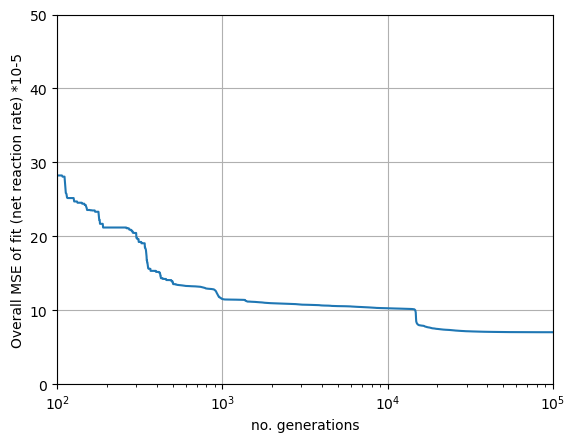

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-10.681840522177627
1.3895496897035324
0.7132008973626299
-4.01342065787345
0.4542392056666324
1.909920758050479e-07
0.3938932780049756
-3.912791575145392
0.24095138779674702
4.017392319824205
2.9990835026347615
3.175943336847606
0.18567215950505464
0.03577063420243922
2.6459888488359695
0.010638397428631497
0.5047055071644485
-10.453462670764788
1.6220986396046906
1.3853990497507158
-9.874911798172892
0.9776451145848392
3.1330704530952755
0.03356139527114863
3.4839229386476562
4.225952457575332
1.2414469550436682
7.760158217379563
-9.899008240240576
2.6835178839382876
1.5454935523018942
3.4545795216170245
-4.2674683852658255
0.5442299113212804
0.9985775630296377
-1.301029920610972


In [37]:
res.X

array([-1.06818405e+01,  1.38954969e+00,  7.13200897e-01, -4.01342066e+00,
        4.54239206e-01,  1.90992076e-07,  3.93893278e-01, -3.91279158e+00,
        2.40951388e-01,  4.01739232e+00,  2.99908350e+00,  3.17594334e+00,
        1.85672160e-01,  3.57706342e-02,  2.64598885e+00,  1.06383974e-02,
        5.04705507e-01, -1.04534627e+01,  1.62209864e+00,  1.38539905e+00,
       -9.87491180e+00,  9.77645115e-01,  3.13307045e+00,  3.35613953e-02,
        3.48392294e+00,  4.22595246e+00,  1.24144696e+00,  7.76015822e+00,
       -9.89900824e+00,  2.68351788e+00,  1.54549355e+00,  3.45457952e+00,
       -4.26746839e+00,  5.44229911e-01,  9.98577563e-01, -1.30102992e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -10.681840522177627
1.6: 1.3895496897035324
0.9: 0.7132008973626299
-4.3: -4.01342065787345
0.5: 0.4542392056666324
0.003: 1.909920758050479e-07
0.4: 0.3938932780049756
-7.9: -3.912791575145392
0.7: 0.24095138779674702
7.2: 4.017392319824205
5.7: 2.9990835026347615
5.7: 3.175943336847606
0.8: 0.18567215950505464
0.03: 0.03577063420243922
3.1: 2.6459888488359695
6.000000000000001e-09: 0.010638397428631497
0.1: 0.5047055071644485
-12.0: -10.453462670764788
1.9: 1.6220986396046906
1.6: 1.3853990497507158
-11.6: -9.874911798172892
1.2: 0.9776451145848392
4.0: 3.1330704530952755
0.01: 0.03356139527114863
4.2: 3.4839229386476562
5.4: 4.225952457575332
2.2: 1.2414469550436682
11.8: 7.760158217379563
-12.0: -9.899008240240576
3.3: 2.6835178839382876
1.8: 1.5454935523018942
4.2: 3.4545795216170245
-4.0: -4.2674683852658255
0.5: 0.5442299113212804
1.0: 0.9985775630296377
coeff fit: 0.9294493579038284
r: 0.9640795391998673
